In [108]:
# Deepdream Imports - Caffe deps
from io import StringIO, BytesIO
import numpy as np
import IPython.display
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format

import caffe

In [109]:
# caffe.set_mode_gpu()
# caffe.set_device(0) # select GPU device if multiple devices exist

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))


In [110]:
model_path = './models/bvlc_googlenet/' # substitute your path here
net_fn   = model_path + 'deploy.prototxt'
param_fn = model_path + 'bvlc_googlenet.caffemodel'

# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True
open('tmp.prototxt', 'w').write(str(model))

net = caffe.Classifier('tmp.prototxt', param_fn,
                       mean = np.float32([104.0, 116.0, 122.0]), # ImageNet mean, training set dependent
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

In [111]:
def objective_L2(dst):
    dst.diff[:] = dst.data 

def make_step(net, step_size=1.5, end='inception_4c/output', 
              jitter=32, clip=True, objective=objective_L2):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    dst = net.blobs[end]

    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2) # apply jitter shift
            
    net.forward(end=end)
    objective(dst)  # specify the optimization objective
    net.backward(start=end)
    g = src.diff[0]
    # apply normalized ascent step to the input image
    src.data[:] += step_size/np.abs(g).mean() * g

    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image
            
    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias)

In [112]:
def deepdream(net, base_img, iter_n=10, octave_n=4, octave_scale=1.4, 
              end='inception_4c/output', clip=True, **step_params):
    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]
    for i in range(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
    
    src = net.blobs['data']
    detail = np.zeros_like(octaves[-1]) # allocate image for network-produced details
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)

        src.reshape(1,3,h,w) # resize the network's input image size
        src.data[0] = octave_base+detail
        for i in range(iter_n):
            make_step(net, end=end, clip=clip, **step_params)
            
            # visualization
            vis = deprocess(net, src.data[0])
            if not clip: # adjust image contrast if clipping is disabled
                vis = vis*(255.0/np.percentile(vis, 99.98))
            showarray(vis)
            print(octave, i, end, vis.shape)
            clear_output(wait=True)
            
        # extract details produced on the current octave
        detail = src.data[0]-octave_base
    # returning the resulting image
    return deprocess(net, src.data[0])

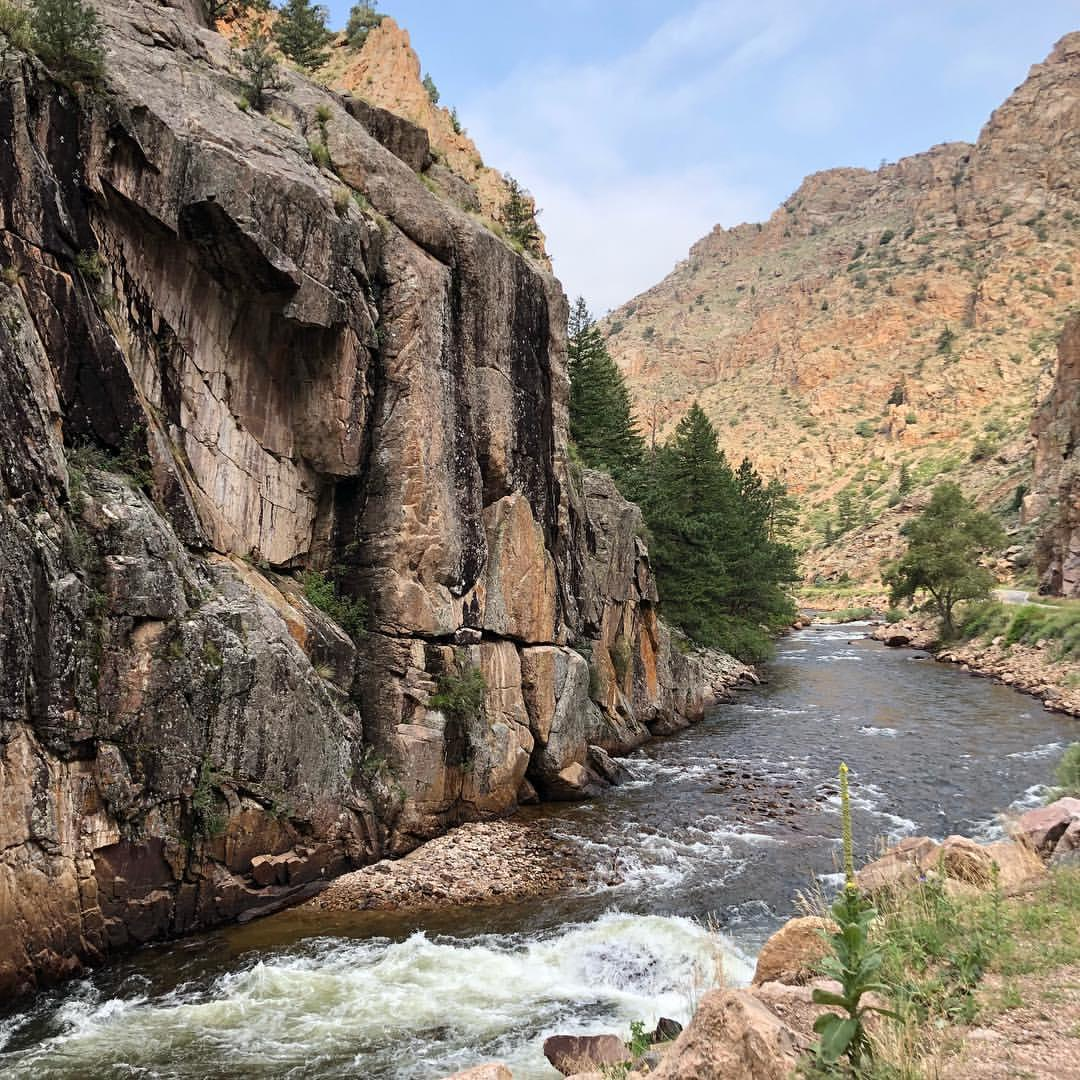

In [113]:
img = np.float32(PIL.Image.open('one.jpeg'))



showarray(img)

In [ ]:
_=deepdream(net, img)


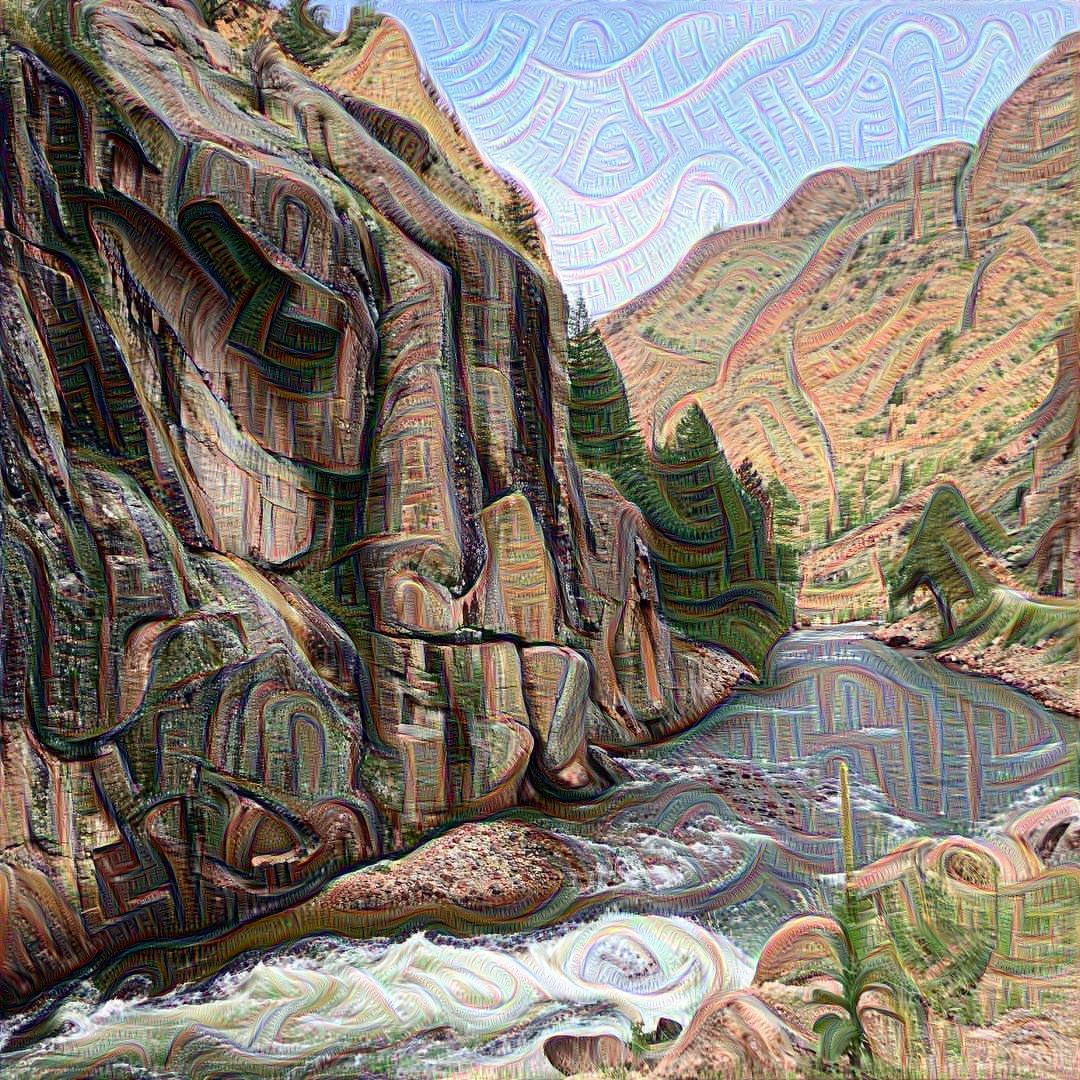

3 9 inception_3b/5x5_reduce (1080, 1080, 3)


In [115]:
_=deepdream(net, img, end='inception_3b/5x5_reduce')

In [116]:

net.blobs.keys()

odict_keys(['data', 'conv1/7x7_s2', 'pool1/3x3_s2', 'pool1/norm1', 'conv2/3x3_reduce', 'conv2/3x3', 'conv2/norm2', 'pool2/3x3_s2', 'pool2/3x3_s2_pool2/3x3_s2_0_split_0', 'pool2/3x3_s2_pool2/3x3_s2_0_split_1', 'pool2/3x3_s2_pool2/3x3_s2_0_split_2', 'pool2/3x3_s2_pool2/3x3_s2_0_split_3', 'inception_3a/1x1', 'inception_3a/3x3_reduce', 'inception_3a/3x3', 'inception_3a/5x5_reduce', 'inception_3a/5x5', 'inception_3a/pool', 'inception_3a/pool_proj', 'inception_3a/output', 'inception_3a/output_inception_3a/output_0_split_0', 'inception_3a/output_inception_3a/output_0_split_1', 'inception_3a/output_inception_3a/output_0_split_2', 'inception_3a/output_inception_3a/output_0_split_3', 'inception_3b/1x1', 'inception_3b/3x3_reduce', 'inception_3b/3x3', 'inception_3b/5x5_reduce', 'inception_3b/5x5', 'inception_3b/pool', 'inception_3b/pool_proj', 'inception_3b/output', 'pool3/3x3_s2', 'pool3/3x3_s2_pool3/3x3_s2_0_split_0', 'pool3/3x3_s2_pool3/3x3_s2_0_split_1', 'pool3/3x3_s2_pool3/3x3_s2_0_split_2', 

In [117]:
!mkdir frames
frame = img
frame_i = 0

mkdir: cannot create directory ‘frames’: File exists


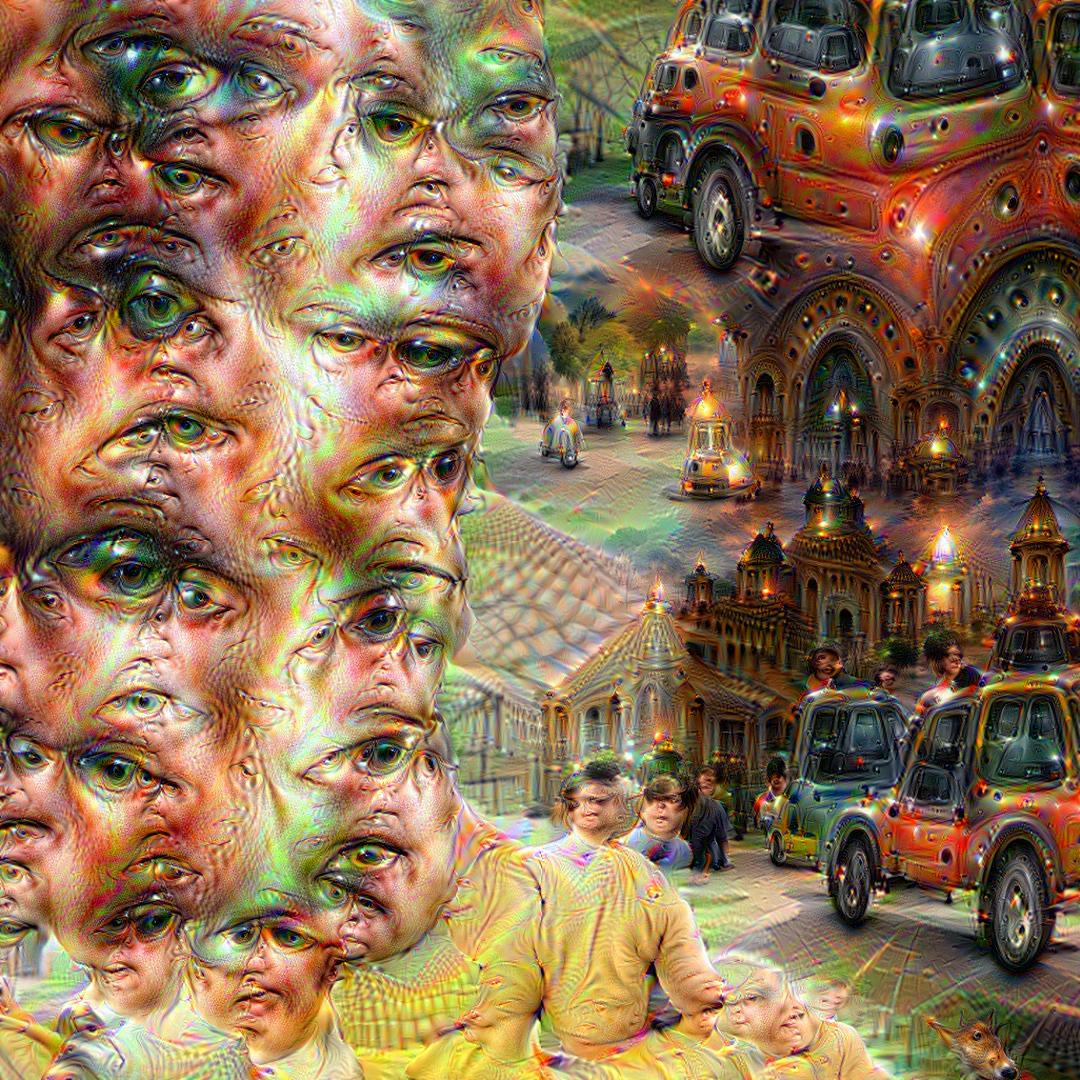

3 6 inception_4c/output (1080, 1080, 3)


In [ ]:

h, w = frame.shape[:2]
s = 0.05 # scale coefficient
for i in range(100):
    frame = deepdream(net, frame)
    PIL.Image.fromarray(np.uint8(frame)).save("frames/%04d.jpg"%frame_i)
    frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAQ4BDgDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwCFRG6rKvKHh1I/KrsV6YCoePylHAYng/SqMcyxTRDbtSYY29ganKqkrRPGGXqQa+clTs7n1kKrtaWxrC4JTiVwD/Eq/wBaiW9S2bbhiT/Geax5YIPNVYJJoGABDbsg+v8ASpWuUCbQS5/vE9a1V+UEoP1OhjvSUPPWoHVXcMw6DORWVHdNjrjnHWpzcgrhTx0/+vW1PVpHLWTVxkxyWAd4wx6Z7dyKz7mCBmdhG0kcajG88HPtV15jndwSTgZ54HXFZN7MQmzEm5OWyOAxrolST1e5yuTuZMyZjDB8MzYGw1TmtoIluFEpBK/MSeWNSXN0wk+WXGxPkXHfvWewlmAw4YFFHzf7JyTSlScrNysjGo3fUqyiESmCJ8Iwxz/eHWtOxWTHAIBHQ+3emR2oXOUBIbcCeoJPP6HNadsqRLjoCeMjGDV16ycEo62OarN1JJpXYwo+8kgEvkKMdTwSfc/4VRSwiu9SRAwaQHn+8PqKvzzNdzn7OPlRsfMOnvSFntP3u5csMnaKdatVcUoKzJVVyqXTs7WsdTLbWthYJsii83oXAGTWHLMrElT1yckA5Pt3rOm1id4jyD756CqSX7MhZ2UkcnC9sfzOBUSxVeUb1ETQwlaDcpO5qfaN5XdM26NuqHPXtVm2KZZmCg553dfTgfgPzNcy+ojG0PgsO3Trmk/tholH7xMAZAPBPPX/AD6VXvSaPYjStHXQ7n+04oLfY580k5Cg4X8qZbTwK0iXcSSxS8pGBzn0rhB4ihjy8rHdj5QKt219a3qqyX4VixY+bkAHoOnp1q5+6vfvYlcsNmrnbWs9jEwns12zRDZskHVfQ1pw+KzOSA+COw7Vw090kbloFUIThSkgOR7gdKreYzT+fbyENn54271Hs01zR2NKdS+j0Z3F95mrcebtz370tnpQsbZmyHPryDWNY6iRGpYru6jnr34rY/tFmi8sE5PUkc1MYKTNJVJLYrzyKNyllC7ugXH696LW4VpBsQhm/iI6CqVy6lzuXHY5PPQ8emKSxuFExkViV5bnuOx/GuesnexrRs4s62KXy1RCSPvFiefpV60MaQRSNmSQj5crjI7Vzcd/tCySE7mYjr93jitGG+ldI1zsKR8+wzxVqMqa5o9TgxqqctlsX5rlYIysrABGxhhkelZhn3bjtc8kgnI49s1HeX6xyvhpF3DJJHIHc+9UUnBYc9ODk4/M+vb8K7Zzgoprcxo0mqfNbVnR6a3lujFtxGP4cD8DWs1zGkO4r9MdQa5+3uVii3E49wcVSn1fczosgzg8Z70Ua3tJ3jqzgqYWeKqXtZI3La6lt7jzldvNbgEjII70C5kV8RzZD/OCOhrnhrsCSGE+bOWAwqKT9RgVe/taxC4lge2HYnr+XUVVWdRPlt8jsVGjB3k/U3o7gqvzNgtyzN/hVyCZZj8oOz+Ji2Py9a5WLVtKfiOZnYnqa2bS83KpiQMoH3ielc81NO7R0wlTfwG6i/uyOWIG7kckD1q3b4LcttcYIXf19x78Cshb2MABmBY9Nxq7b3gXCJnB4Ixx/k/0rWM7LczlGUnY2HVVUkj5VIO3pk1DJHfRTCaB1WF+G2jLCnRyKpUZDHHGT09c1KsoSQ/MPmHI9cGtE3a63OOV1K1rlmISxRq8rKSByVGMgmq9tCY7ueBgzJ99cVf/AHLREkZ46VUusCeCePepBwT2I9KUVdKcehm3fRk3mMsO0uJMcOG6j0qM5dHVx8pBU5HX0qe4PLlYQH7Mf4qzfOO4Flbpx2ANTiFpcqEbq5Unh+0xID/rIWOOewPFZ13ar5nmsMS9dnbH0q/JKqSurEAMdynJXB7/AF//AFU/91cxgO+1u2RgkfWrw2IuuSRhjMO/iRzr6dJ9ik2sec/dGKrEvY3O6Jh5bAAflzXTtZSJuLKG3EZf0rIubFSSQN8bfeR+MH1FKdOSfMtUeXyp3U9jFubeKSUSQbopev7lsH8qS51C8ULH9oSc45SQZOPelvxBaqqnzDvONo6KPWqTXu6Fgsa7T1Dc/gcVj7NzgluhRo2SkiJtRhiLedZkY/uVBNr1g8Q22yDPUsdzfQZqOWaLBBBVcfwuBVCSaxTLCQceowR+NDw6Tu1qd1OckrN6GgmuGMbWAK9Cuex7f596n89XkxHgc4DEZJ965uW3ErrJHIGiY4BxnNblghjjAbPHODz+lXGVtDWb5Vc2bWBiFf7pPdT0/wA9avuStuSXUgDO4jB+nFUIpBvROCx6cYHPQfrT5LmZljUrwnBXg5I71hNPm0CNTm3KN15JkASMlzxlT+ZNZ83lA5kibMhZB2HHU/p+tX5XM5kEEYQqvJ96z57bUZS2+4hiVOSoG7jFaxkre8zVN9ytKpe2BKSHB2kRjoD/AFHvVKWR5JYYbVHYn5SWPQUjJbojXFxcXE5B+WMHC5/D+tW4NPuZLSS7lZYlOCiqeQK0so/E9Cufk0WvmXYoXjsmikJiww3bcEGpptRAkQx5KRqCM9yKzlMSWCrseSeTPfkYqOMAyIjkgAZwepNcKjGUnKWxtT92OurNaCZtzSM2flAYn8arMxW8fltiruQ4xjPWoJpJQQFYpGv3vc/5/lVjYRHFOmdpUqSTncDVQs3zI1nCUFfq9QWIJcLGxPTCjPB7/wBTVe5SFr2W2ubeBUC5Z3TJ/OrkLefEFcbJo+Mkcj0P0qeWOG/eMzN9ju4/l3EZRh3BPp6GsHpV9528zerSdWF6Zzfhy3t1k1KyhRlhZS8ZKbd3rgeoqeSzlOmqhOTDJtz+oP45rqotJtrWE+SQ88pAZ0fI46Aen41Ue0fyCCmC4KsP9tef/QSKqpNc79m7x03HJc1G7VpItQ2jS6Yu3ltvIz1qtHp01scvENp7nt+FaWnHy4U3bhkcACrouNvykhh71hzON4rY8yFuhhNczWBIGfKb7wxgVUuXWVfMgIK9xiuikEU3ybQQfyqnJpSwSblYbT/CKmUItb6lVZONrKzMSKe3mjMEy49zWdLZNDMfJ/1ZPU1qaho5WcSIMMeQM1SmleKXy3J2jrxTSStY5OWUm2ythFjIYkMD1FPlwpTywDu5qR5IpuFAHapDptw6CWPhQK0tbcqKuio7rlUePaWGMimv5iQlIj1PerCGLJSc/PjANLEsSv7HuaNjXklFXKiN5x2SoRtHWmzzxLuQRAFf4sVfaKYksi7l7EVLDZRTWcwcfPTv1sCStdsxTbSO2UIyRnBpqWP7wu8bF++K2vscj48teQMc+1IthdEOruAPyNaKbSHZWM5YWB+VSBSqHhJYHa3Uj1rQW1ZVGWyQMcmlksiVyjqD9c1LqW3IemqKI1Ke4HkoXXJG7jGMdwamnbyotrFFDdc5JY9fzPX8afHEIn3OckDk1lvLJdXUrl9kcS5Ln+Eev1PUVU3eKhT0PRwMU37arsuhYvHN6EtS0qWo4GOn5HrWZ4r01xoUcOnXClIyCyLwSPpWrfKNJsUxaD7VLgfM+XGfrWO07arotwk9s0M0LbCwHU1rhaHsuV7pf1cWMxksRNvZ7DNKv5rjwbIHJJT5cmodZc2ejQ20TN84XOwda1NF0uWPw0YHYDeSdmP5moLmBLq90wrlo4H2zrjkY9q70+ZtvuefJLZlS00mODS42W5LuZlwjjBAPXirN4ixzvFDG7YODgcV2drpli2qySQqrxlfLAA5X3qte+ANfkVpNOZZ0POMYP61qna0WzGbu7o8/vC/mOCn3QHAz+FZetFd9m6vGUmALIOWH49K7FPCOsG9d79DBGkZV8jrWLZ+HftGpzx280cghGQjDoB2o5lHdjjFtpFLxBN5NjBb7uUXKEVveF42tvDck7HBYZFcnrc32q+SMEEIdprt7aJbXwoQgwoQEc561zY1c3LDuzrwycFJswLW4ZbW8vZHO9mbB9vauUjeW6kkYIWJOWPYV0D5/sl4QfmKn86wY0URBGBHJBZTj6V0TfLJo5ldosxpu+UMAc4qzEpK3rrxhdgI+nNRWtrE7Ene+FJIc9CKsQjy/D07srbtxyVHrRDuEpW0RA8saRRHACkZ571JHqluM/Oi8elV3EccUUbRbigxg8n8qYzxgbPsnl5IGdvU0K7V2ZtqTsbNve20p+TGwscnpnj0rbsZN8fyn7o61xSrCjEgouDjriuk8OPI/mpyRjOexpuVnoOye5aN2VnKcKxPBFV71sFLqNdrFAxHvnBqLUSsGbpZEbacEKcnPpipNQaMwIYmyrw+YvGOvHT1obHDRlDVbNXkH2UxjIBVWXJ3HqQay7PUprWXyrgZj+6wbsK2J2FxaptJOyInjuawrtQ07Y5x3FZSUZr3jaEnBpxdjWWB1vY0V2NtIdyc8fSvXtNuo7HSIpJDyVCqgryPQWE3+iyHkHchPY13M12YNOy3LovAP0rwszg6nJSWx7eBxFuaU9TJ1nW7jUNZ8pZAEDc57V1Wl32l2kavdIs6qMkbcivL7KXzbqSeRPMIY9T0rTW/+1N5UVw6kfwggZ9q9KnQcYqEHojx6r55OdRfcdzJP4a1nW4XBS08w7E2jofpVHxTpVppWu2mmRubnJDOScZHoRXFLNcRamsrqUfOSFGAcdK2LK7e/wBZnvJDkwqEz79zXZQjGn717sylUbbUduxU8b3800yW8TYTdtPof8/0rmorq2s0AAWV16qF6Vp+JJC0tqSeoZse5OP5Visg8tQSAyoOvr0ol70rPYztdXZ0Wj+JLiO/822PkyqpUEDsafJfO7uDKxIPJbk+tYenEiSZs8gBc+tPdj9qm+YAAgdfQf8A161WmhnypE95dOVLeYJSACUcDBHtUV66NaKy29vG3GGVfmqpcgE5E2cdFP8AjU7rv0LkndFJj8OtTKW1y4uxPJOxuLaaMgFFViTx2rovEVy82hgqSvmrukx3A/lXNaefNS5PA2wDH45rXmk+0eFd38YGwc9Kyq0uaSfY0hKzUOjOdhdT5QaN9kY5KjhfcmtpLuwvrRppbZos/Kxj4GO31rGjZkSYRvIiTR8KpGDt5IP5V0Ph69eWeK0kjWRHYFF2ggGtVFzlyxJemtiKC2UqI4A8w24Qsux1HpmoZNMvhkLaLFvbPmS46jtjv+PWvbj8PI10kXvmATFdyo3FecXml3xurlJZlRI5AQufvADoD9QDScmnaVhRrxd4xf3mdptrN5T6TLMRdBd7AdFPXb+WPzrOdlk3x7QDF0UjpU+leZHqk8jyHzUf73rmmXi51WaVVILghl/2vWlVp6867FwSW7FAD2obsetXfDxS5lFs2HdHyB1yvb9azrSaOfTzEuC2SH3DlMf41Y0m5axuN/8AEf0rjxEbUnLr0PVwfN7TlWx2mowpbRbXkIYjkKcAflWC+21R7qO6RkH3o34P4etPnuZb9SVY7q47WMz6otrA0ghGBtY9D3rzMFQ5rqb16no46vToxUKK+Ztw60ocPb2hkmUECRQATn1P5flTrjX9akUjzZyP7qycVhz3iI5tYciKP5W2/wARHWlSwvLyJntkRVQZbDEkD1+levTpQT92P3nhVK85u8pFk63qSOdyqB/00bBorM+z6jCAzSIeMjcM8UVr7Gm9XBEfWKkdFI9dRoxMUZl2xEsPeoo7tpLvBHLMce4qBkSIW879XPPPaoBckl5AuGjJxn0ryYxi1dHv05JK5ckdA2JAxweMHGKqTXQjTClIh2OcnNR3NyzQiTzFO9Sdp/nWNNdOwwOh7qeo/wAabpNq5rzX3Ny3vGZBvYE+oGAa0opiVxjjgdK463uHWfGHP+9/jXQWz/KM4Ix68c+3enTi0zGs1Yuyud23IzuII6YA5x+fSsi9uHbIJdWZdrheoyc/p0/OtWbGxjj5hglexPYAVg6jcKkJdm6ZJBPfvXUpKK2PMlV5nZFJlaRpdoUvj5mbtUSZZWfGQCAMDgA8Gm28clztji+Qn5mYmq91qcpuFsLCLzJWOx8dM+uaiKdSTfQHFRTci610BKwyANx6njgY/wAKfPcPJ5cEEbyO/wAzFeAB9aZZ2VvZbmmVZ7g8mTtkVehmcpJK52vKNqhRj8qu8I2VNadzFT5Zcy0J4Yp7fSt+I4mfndu+bjsPesm5mZTguWYjGccAfz/OrMkg5VpDwMsAckDpjHbt+dU5IpZFGAI165c0KU5NyfUqjRUdWUJXlY4Ck56c81VjSbn5yoY4yP6+tX5Ioo23PMSxOSWI61WlumDYheNxnI2njrW8KUpWR1/WFtcitrK9LSwxyqjYztflGHtUx0ORU3y3AyFAcRjLL6HntU0Yu5XRkCj8actndC6keR+HTacenpVOSUt9DilNVJe7KzX4jYtOtBJ+82TkDhjyTUxt9MKkTQAg/wB1ip/DFKlrbxQhBIY3R9itu+U59R71oSWEctsiWVxazMf9av3Njdlx37/kaxUlJ/EaR5Iu04vXqY58OW0gN3p19JCV4CS9SfYj+VW5mNvGhuvklAwzAcZ9auXEcsUUcKoEZe68c0Q28LoUndi553M2f0q4uWjexunC113M23uZzJtTGwnk4/OuktpXCkNkOPmOflz9exH/ANas9rYQYVfnKHOBnBHb/P1qaF8ELtQ7WOEB54P5fT6GoUdbo1nVXKjUKxrbEAsU7eWMnntn1qjJMIZDDgh96llHQdwv5VelmY2qgKQuQQ3Ri3ris1p441YhS80bGQueeTWc4u9y6dXSyNeJ44gqSEmWeQSBM8gDoK05pyGL+WVaQblPQ46Y/OsGW8O6O9jjAEUYGV5yT1pZ5pTAiq+9sE4zg5xk1hra7ZlJ+0alJkzyMzgK7c4+9joO/wDOtGK2Ee1twAx1xyeD698VjWk2xV83IbAwGPJ+v0/rUt1qUb4t/tBTfgFUOWb2/r+HvScZOy7hVrTqy9nT26sXWNXihjEbXaQg/wATfeP4A1JpF7oEK/aJ7a5ugeS1ypVD9AOajtrDSLdlK2yvcseZZjub8c9Kfr1rNqPktasIYoh8wjxx6EjuK05VGChTly931MvatP2fK7dPM6KDxnp5X7NY2sMMPTaExj8Dz/8Aqqyt5okxEl1HG7ehHFZEMmlW/h+KErHNf/xMnI9ufX/61VhbQzxBo4Ck2M8jOK1hQhF88ZO5i6cJJc65bbnb2mjWmrlVthDAp+5lcA02fwbJ5xWPU2Yp82IyBiuSN5cTwRxfaWV0xuHIAx2wKsw6rqNhJJKLyLzJDln+9z/u/wD166nGnTgoqd5szhGo5XprTzNVtM1CBWaGOaftubjNQNrh059t0WhfvuGcflRp3xMOmxGC5kgugOAqn5h9RVqDXdC8TSMzWhimLjG7jA7g/jgfjUTw7leUlY6I4mdJ2mro2NL1WKVFcE4bjdjhh9a2RcBYlVhmINkFTkqT39xXO28UGl3LrbM0qGUp9mYcDH3h+FW5vtT3YS12Q2mQdztliPTArGMnB6vQ1qQjWs4aHRxXbW8oSU5BBAbtWk7maEjcAuMqPXFYN6Te20MNuPmQjD559zWxbr5dqvKgjALMetbRacvd6nJUhom9yRpNu4K7CNux/MHNZ14rRlgWfB+9lePrmpZJNrNlSQeCpP3gB0qheSt5YH3sAAZG7ce4I/X9KqrrCyCnFpooT3GN3JJ6bQ/Jx2wag84uCHfa68F265z0xVWeY/MFG5sZjD+oPUe9Z324+d+8cbU5GT19K4notNz0HRc42R1NtcXQfaJGkUDcd565q+t9ASftEaglsKQOMYrioNXdlLCaNnmbADPg4x2Hetew1KZrKA4V9jndGVxxXVQqSnG1ReR5dbL40/equ3kaV9pdpqUBXJcbBK2wYOPQGuB1Xwl5ZYwalg4ycnJwefw/+tXpqhF1C13JF+8+TCHjnrVe+0e0u7Yh7VZCjGI7lyRg8Y/P+VaO9JLk6mcaai2tkeJz2NrBOFutTfAYEtF85BHAzmpoLXTRLL9jvor1Sdwx99fXKn1+tdNrvhbSBPK0kELyI/zQzk4IxgEf/XrirnwxFJdmWETwwIPlzIGUY/ugciksQnH94/maPDOXl+pcNrDAS0RwhJBXcQVJ74/z3q7Z3PkHy/NYBGwAWHzL/n0rmZ/ttvITBNvjXgpIMhvp6VZhM0kSyrHz3Q/54qpRU1eJzuk4q0jso7g+VwqqUOdqnkDP/wCurFuxNxKYFI2jcgbrjvWRbBJVVpiFMg5UdV96stft5MU0eecKr+o6c1nON0rHOtHZExlDQSxhsSA72PrVG6ukREUyfPcEIoPpUcsEvnSQSPsZcbznr7VBNcxz3AaKPAtVBNZK0XrsapNysiW+ggeFLOADepGVziluHeKxRHlRHXggDJ496rQmSTUTeKyokg4XHJNMcStIzllUZDFW4bntUOSktXodVGk7pPcSNCbnlSdvygyNgE9wAP8APFXba3MYMz8Ko5J5z+dT6VpbqCHjKM4yc5Pzd+e3/wBb3rXurSOOJI0X7py3ua4p4mMp+zi9zupuKqXlsjnJHeQvJIyhY8Ls6Hk4yfzFTW7NFGY7iHYFbbycDH9DWy1sjLnykeTGQ+PmA96r3FpIMLO77f8AYALURrL2nLFaHZGCrxab1exC8ZiXB42ggFfn9x+Q/lVqymkjcK0gI+6GVfl/XqP8agiEhd9uV29WOPm7Zp5iK5kG5028kHIx7V0Tp80dTGnRcHyz0OnsIrdiZVghEoHaPO78PWqOuBbCJZQdsMx3JIExtkAPDA+xP50umT/uzkk89Sa1r5LbUvDV1bSqSyASKfQg1yVFOEUr3VzCTUKrk+1jnoL7zbeIiLaGQHIPNQS3ZTCkHJ6ewpts6vEWGFRRgdulSm3Lu+yRcYHFZ3jzXR5SfvWRA195bAKRk0w6pKwyOT2FWH007s7hnGDgZqoYYoycuOOgraKT1RvGq47l5b2FwhlPze9PvdOh1KPMAAPrWFJNufaUzz1q/aX01tgAfIacqTauaqrT3EOkpGrAcSYqtH9rSTZztNat0WlUTqenWmLqtqYDnAkHrS5J2KlGnZuBVfRhOvmp94dajXT441CT8H1qtd6w6NugbafTNU5NXmu4CsincehraMejOFxnutjb3Lp4+QrJHj61RttWtPtkkbREFlJzWaqXRjADHHrRHaGK6gmc87vmz6VorLYIwve5Zm1sh2RfnHYoOlMa/lbkOzEjoTU13bQwzZDbc+1Vt0RdRszg8sBWl0wt2FN0WHUl+4HShJ2IwRt9qsC3aVNyw/L/AAseKqTfuiI1GZXO1c/qaFFOSSGuzLDlY7OWeTJjjXLf4VQ02IyWMIkA3XUvmSYHYc4+nareukWukW9nH8wuMNN/sueAPp0NSrA1pEq45hhYD6/5FZtJbdX+R3/BT02RzWvzte65Adx+TLZLY6dKs+Hr65bWriycQNBPHvk3fMePQ+tVNhfUXYg4X5cgdu9WtDgcX93csNpSIwn13Mev58fjXZKCS07HLHX4jRk1JIPD899Iiq80hWNV6BQf5VX0I2iBZ77zFdzkLFlj+Oe/0ql4iAWKy05eitgj2HJ/pUlu6xw4/iP6V1rbQ5pand2evaPHjyGUkcZdsGt238YNbxMsUkIbGUD8ZNeXxssglB3HYqnOeQDwP8+9ZjzxiVlgvJo3B+75fyn60Wi1qhq8dj2SDxFY+Ki2mXSgTqNxdRtyR94HHpXMavDo+iXEz6W8SzshDj1rzjT7iVNdt280pGzAOYXI3ZyBn9a1fH9mtuIp7e5DsQM7WyfxqFOk6ip9WiuSXL7RM5m1sEvtakn8kud5OO3WuznVbjSGjjQKqjDY6cVj+Gi0umzSP/rkJRz3PHB+vXPuK17STyfCl5Kfvbjt/lWTV6l+2h0Sno4s5fTbc3n2raM4JZR7Csa2tJ59TlFlb/aAOijkgj2/Ot/Sbk2EDRkLlx87Meg9KvaffLZXHm2yKSef3Y2j8T1rXlbd2c7elkYv9nXVramGaB/Mbkkg8E9Rx2pLmIfYmt2DqrFSTjjj9a7iHVJpV3NCkgPOGPGP51a87T7hc3OkgerQH/Jpta6mPK9DyeZAZGc4K54CtkdKpm8uPK2edIIy5dUHABxjP5V6lc6P4evwfsdvLFcHgDHeuX1HwVqdm4aa1cRnow9PcVPLrqNOzsctFOzOGL429CQOa6HSb149mSHUDByv9amg8JMUFzKjNbKOvv6GpxbtF84hg29jI3H4cU3SUtUy3Oy1RS8qGK9ubpM7XjY8jgN2OalvALiEkTFfJi5LjAIPv65p73k8Jby13t38pc//AFqz73WbmaEw3OnIqO+8yhP3mcY/wo9nVW7CDTafRDdPyumtEpLStweOR681RuQpYojDr8x96uWjyw3almkZHXaA64LL/wDX+tZ88ZWaR9gDIdxUHBZfXHqO9Yu6k0ze0XC6et/wNTR4gtwWQEle/vXVanIx07zCQAV5rJ0S2RoQ4wQwyDWvq2yPSiOPugA15OJrp4iOmx2UJOEHBrc5bSrcsk5HOeRVO3hEOps8vA3+vWt/SAFVj2IzyKx7mSOHU2Mke9egX1NenGo5SagjlilyXmW7t0QxTArsVj0+lXfD4KaBeXbD5iWasS+Jksnjij2bTuAznj/9ddJaQ+R4cFvuYiYDG3jJraK2T3OeTXvNHOa6d15bLnhYgSazCyqty25VIYDB6n6f/rrT1u1lEkdxJG4GArN1xWcUVQn7oOzMWOBk9MYyP88009eZC/IW1uIEVgZOvqMVJJ9lkuJiLhjmQkAoe/vUiIrnH2RGPoRWha217LgHTXII6ldq/rVrmau1YV4tOzMSdosYVdxJ4Uc5/KtPTbS5uIpIo7UIpU7jcPtAHfg4/St+CwNsMyRxRsf4UTk/jUUyTMT/APE5wKqME/elsjNVf+ff3mVbWq2dpKFJbLn5iP4R0/qfxq7YfNpP2c89WIPvTo4w0bs2dg557moNHkBubgTHaGBAzTtdNjvqZaQFACR8qE491zn9MH861tHilsdSguoTlVII70+2hC289tc7oZoszISMbo89R+R/KpLON7KXiJZYs5IQ0SjJu8dy+ZPQ9av/ABZcX3h9AWwyrg7RiuCtpGuL7ZIxJlQttzxj6Vs6attqWnSR20zeay7RGy45+tUZLKCxvZ9QEzgLGIkhZeR2PP8AvdPrWX7yStLoQqcdznlhWLX9mPldCSKz7/czRIzHO/DYOMg9TWhduF1rzBkBcJVDVuL23wpIyxOKq7epsr3sZtnKYddkQkBJBgjtx0rUvGNrb+aq7nc8AVz13Jtu2mU/xDFdNeKssAbnCQqeDjk1zYhK8W1oddGpKEZJMZoerPJM9nc2zK+0srHiq4jxqN5M/Pkxkk+/apNCkklvVLuzqucbucH60l63laXqE/Qyy4z7VyzSi2oq17FqTnG972OWhWSWVFycytkn26mtOKW7geRopnjB+QLGeAvXH0qHTIwdQwduFBAz6nnitQQEO68YI3cV3czWxxvcyri/vBGFk5AO0HGDRV+e0AEpI4jKt+dFbUlKSujOUtdFc7okvZsWyTGMqPUmq95NLiJyAEI+bHUe1SSTM92sSoUiVC2T6+lY1xOptDK8mWLklfc14tKOzPo+ZNotyTRszEBzk7ACRg+9Zty4QkPsbHG0HOTUkrkRQykptjXIHU1DtDuCSBnBVVHP41rJ6oFUu0i1aSjcoIJb0HNbtrujZC2PbjkCs21snBLIqBcbuTj+Va0RVMZAPGSW7e1KVVQSMK8rPlirsfc3CxW4Ge3GSPz/AM+lcfdyvdScnKFunYgc/wCFaepXZmdghcpnIO3AxjH+cVk8RytdOf3UQ/vc5P8An9KqHvx90yp0nDWRLd3RtLIxIf30nAPoKXQLZbbT5L+TmaUMIyfX/I/WqtrE+qXFxdvkquFX/P41o6aFl01IH6WjuGBOOM5q20lyRMZ81SXZGtBZq0Qt0DEqAXPcDrwOtZt9e2xMzyzrDGoAiwMMB6ketYN1r07SSwacPLRm+Y+nsKhg0t7krLOXmOckE/e9qqNJvWTsRenS21Zal8QQqrNaWuRuyXk6AgYGP1P41kzanqF65Bnwp/hj4Ardg8N3d9cedLDiPZvBC4RVzjGfqMf/AK6i1BodNYW9uAJG+XIAxn612wpKPQ55YiU3ZGdHp8sURnngd0AyWchfyLf0FWVu7K22Hy2WUnO2T94WHXpxjIIPWqunwvdXMrXauNoPOTuZv4Rz7/pWlremw2lpbQwwqZIYSZmAxuZjnHHox2/8Bq6sFyLW76majGcrNFSbXV+7FGy/MTknAx/OoP8AhILrYRGxAByR2q1a6BNeaHcXLmVHiblCvB+p61Xt9K8yHzWDBAeoopYKMk2tLdxKulHlXQhTW7jayvtZT17Uq6h5zAOSrFxuPfGOoPt/Wo/sszzOsaxkjoijaf8AP408WcxmKP8AKoX5mKjI+prGrShBc3cv2jvZMt2x1KWLfZXErIv/ACzlbGf93PBqaDUbhZjHcIySjqDxkdKzZLaRsyFT5aqJXAbmMnjoeMZHbPAqQzyTAkBynATcM44wfwz/AColbk5rWNIVJdXc6KHUd8bFnyi5X5uB9D/h65q5DIGVR8+39c9jj0rl4FV51CTbsdujZragkES7ckZGcdqwd1L1NlVTjY3Hu/Klt+pZwV2+hxzkevWmxWrRXM6znicbz7VWhkiLCPcAHHyqG+43TPpUo8yRWuZXAktiqqpP3gOv1q+TqhRquLstyQ3EMdteWKrhvLDK2epFQqf9DTfuG8A7T1I9PfnFNitDcXMqxr++wZBuPAz2oWaW92oxKyxKQ2MAEA/56Vm6W9jZVLQdvX5iajJL9kH2Zx5y8Ad6z7K6ltbcyxW5eY/63P3/AHxVxJtwc5w4Ucn074qydQjEpVYUG5cZI6mqcIJWkrlRrtU1CC1KMerxnLyoyAd2XnpVoa5bysVYxFl4G5ck+wzx9M0kjQ3K+WdgeThl6g9gaqyaOGZHXCeV8rbSDz7GlHDK7lc7KeI920ol6PVBIcRuNuc5HyjP9K39MuNigs25j19/oO3Oa5BNIuoXEiuxQc7vX/P9KBqs0F15Yic4GTgZJ9hSlTW0EU5xmry1O7a7SK4y5G1OWB7nsv54rUtbDTb29FndW3nHywcNJ/H/ABcDr9fevPrm9u3lWUxGOIYcAtuY8cfKP8e1Xh4ln0s2l4qPgSbZMnkp3Jx3rCX7jVP3ntbuZSnaOivc3NW8F6VfTmGB5IMdFZdwH/fOBTYdE1zw5EPI8u/szxtIzsPbC/pVRfFk39uxghZreU5WReQAeh/H09q9EiuYnjUkgJKmTjsQORVuVTmjCru1cyqU2481HVeZhWGvqYjHewNBLt8xSfuupHJHf2NbdheCXLLJEiDjiqckWl6lFJYX9skptpN8TZKnB52kjqM+vtWNc2K6TOl3aXNzFaZyFC7lz3B+n61Tj2/4AqUkmoSVmz0yzuEEXDjnrirZnV9pxyOMgV5/H4igtbZHluFU+jcZ/OtnTdbF4geNiyt29K0p1Etx1KLV2zZvQ+4MqFuMnjGcdB+dVrohYMnknjI4J9Rj61OctCCwfJPylm7+oH+e1VLtj5UiovAHy8847kdutb2WrXU5+bVJ9DImWRIXKbS+NoDf3vr3xWS7RRyQvuVmwQSBwXIrTuzk5z8q8jJ6DufxrmbqWQF9wYhpGwmBwenH0rhlDld5M9DDqU9W7Glp1zbRyoXKCKGPBb1Oa6O2ja6Vbm3iDRryQpySK8zv9Inupkhld0j67FJXJ684ruNB0yXS7JWs5LiMMQPKckhTUQ5qrtfQnFUqELSUry6G5ockf9oPHEt26R9ZLoc/QdB+VdCHHmTKPmjlO7jsen+FQWjeZpw82RS3cjpmqLXrxSgMVGOOK0inCXMndM5JwddXluiHVUeUsrLDIV7uACPzrjdStXfcAi9P4VArsLmUTozAnIPQjmuW1Teqkp5gXkdQAO2M+1Oo6VuaxzUqVVLlctDmJbGMJ85RUAyc+/IpESOVkji3FC24nIC47jnrVHUZx5xPmY6M2V5+ncZ5Ax9KW38y4kCEu5Y98H5T9PT+VXh5cy7E1oOKs9jUhEVvBKYE3zscZPOAah+1NLJ9ngjO23fLcd/T86tKxlu5EglWK0ZAqso5Yr3qvp0aeY8S7j5gEsjE5Jz1JraVranI1a7e4+BH8yS4vH/1ZxjP3iaVomt1d4YV8qc/M575PH86sQwAwEsRhXLKeckdqtC1aSNYZXJjVuNvcdj+f6Vyy0h7wUkpScrlF4NkXl4Yqic7Rjd9M+9LBZebIg8ti2cEg5Gc56n/ADxXQQaY0rKgjKgPgg9QR6Z9KnFkkGQFbzPUE/yH+ea82vWSjZM6KKm5DbW1W3t4wob5gFVecn/Gry26STjcxLDIwnf2FUri7EMxlJCHomSAFyOTVT+3LXf5UVxCQpAOZQCB1/PNY0oRs+Ra9zojhKtR3k7RNiVFMY27tvO3jjI4z796qz2jSRfPuJHAH1oWXUpYElS3jZD/AHT3PJwT788A1Et9dRHdPbMAFIxiumjTqezcradz0MNVo0bNPUgewMfygKOmcVDJG0RO9UycHG/Bz2B/OtL+0IJVUFyTtAKuh+YjrjHrx+dU7tg2PmJGDkhRyO5/Hnt3rWGKlzcskdNbE+2joQAiFiRkDntwCKvWl+BDcRtzuQr19eP0NYblol3N5ZyfmAXAJz/+rp6U2O68tWGeAp6nt1FdMqSktDysR8MkOu5YtNMduQryEbguM/nVc3pkUZwCRyQal1CWK4jiY7T5YwdwxnjtVMXFqoR1Gdx2lfSuOVLllax40J8yuWn1Gcsu07k6cVNPEktusy8n+Lms6a6hRnhjHy9QRVB9QuTE0K4WP161tCk3ZrQ223Zuo0DQnlQVHfpWbLqMSxlG5YnAx0rLjmO8Rs7P6g0b4GRjjjODxXRGklqxX7GlY6uyEwyghexzVe/iYv5sedp64rPmlJVY4s7ux963dOy0Cw3IBZhwT3q3OENy4KXQoWsqqcOBz39auf6OVztAzVe8tjZTZ2ZiJ79qtWIhuk27GAznA71y1or4lsbU6n2XuSfZ3WMeVKBnsaLtpFsWWdRx0bHFLKQs3lwxMMDo1R+TcXLHzciJeq+tKMXo2xu27HQXUFzCssnCqMZxgGqt9egRl4IH2rjJA61bES2k8bMn+jyHAH/PM+n0rYa1guIHiLBQVy2O1E5xjqloQ29TN0yT7VDueJkOO9UmQS6yM/dgX+Zq5p0bW1xcQLMXUDgMKdo9tNey3cqxqzF+MnA44xWtNKHNW8iaSbqK6Kd1Ztf65awuP3TKXk/kK07+508X9rbyz4VIzuEaYHAxyfzq1dY0i0uNUuQPLD4XC54Hbn3zWXqsd1LrdtKujyGKULiTBAII71x4SFariVUlpFJr1PoK8ISoO732RnpbeH4tOjneed7hQS0U33fpxg1ettKFpa2KgDE7+e59EXlR+ddC3gOfVOYJ7a3OclQNxIrV8Q6F9g8PxwW7B7iMqJGJxhAcn6V6ynGo/c6HhzTXup7njF/L9r8RTSHlYs4/E/4Cpd7DIKjjnI/rVm40TULe61Cc27Osp3RGPkDBx19MUxLqOGYb0YBcnDDjgcZrojJSWhnKNmSWxPl3ZPG5VAPsnP8AM1x0txLNPdTElkaXKc9B9K62e+sV0wtFG0bxxFN24lSDy3H1OPwFcYWBhBZlBJzlRyPyp76EWZchiaSxR95DBmXIP+fepWcXCW8oUAxSAydyQeDn1osbq2TSJI5C5l8wbMYCnPHPp3pmjMk2oS2pcMkytgjJGB0Ofzokvduxxvex0fh9Uimv4V+48WF9yORU1y5FlFYDudzgd+9LoNuGtzdMpIjlJfHoRjmq8tyR4kaXaNpiCgdef/11yYd802jsxTg3eHTQ5uVs62p3qY7dwHjK7g57itMuJcxxhV8yToo4Gew9gBj8Ky5reO1v5EO7cxyWJ+8xq/YuDdBuMKMj3Jrs6nIzp4CEBVcdAo46Ac/zqSbC28jN2Gc+lZZuvLKlWIbp0yDxmpLjUPOsnkKjIAPHvwP1p8upla5bsLhoQkmQZs/Ju9a0rnWtakvpbe+Tcoj4JHXisFo9yxKXI288HBBq/FNOfMWSZ5QTvy/XPt7VDivac/lY2517L2dut7kGpTg28ezdHH1ZV7uTwB7/AOBrCvNTt9OcA2omfOBlssfXHb9O9aGpPsFrHxkM0pHvnC/z/Sub1qMnV4Bk9Np5/P8ApVPbUySV7sut4olwRFZxr0+8D/T34qhfarJqNo7SRRq6tt3oNrL6Z65B/Skjt2KnAbg85I65zUMUAC3UfJ8xMjH+z/8ArqV3Kb7lC2Z5rRkyRJE29G9P84qS9TfPJIiBS21k5xtGP15yD+FGlKWuPLHeMnpnP+eatXUZW2ik/uhgR7f/AK+KUlfUuD1sb/g795pkiMctDIR+B5q14hnMNqE6F+Ki8LRm0unQDdHOgBx39DUfiNg+oeT/ABrwQeorxfZc+LlPoejiJunh4xW7Gafuhs1fPPRgDisbUQq3jkqxwNxOcit3/V2XPqKyNTjCT7uhZcfWvSi0ouS3ZwalvSIY7m9gaRQ8aDDKeRz/APq/zmti68xdSs4Io1WMNhELYJPsPasPRpGtbUHlmaTO4dP89Kv37XE6K3lNngA45H0rZNKS6Gcnd6mtcAxl18tWXoVYZyPpWRcQQspWO3aHjG2HAB/CusutOWHTbFpSftFyAQh5OAOSau6Vo8BmXzAoHfjk1UIrlvLYya1vE4HT9E1GW7WS0s2DE4Bbr9a6250vWbdLu3nunje3ZYxEY9oJYZ3BjnI4YHj0r1WwTSrKxBiiXzMfeOK5DWdQMcxd50ZVJ2hjkj8TWvNOo0nHbYUo+9eVkcrbaBdXDkJGSB/tZ/nVu+8OG0tR9pIQn+AHP8v8ast4gmVSYWUD2/xrJvNXknQmZsAeppWnJtz2XQzU11VtTKubONR5Yc7f7oAArMmsI8krkfQ1pST7wWJ6fzqpK+U3g/Ljj0rTVbl3I0DMc3DvcMF2L5vOF9M+matQ2zbg8Q8hhz8vOfzqpkDaSpO4lQd+QSOox7f1q/bSkMASQPrSafQpJm1Zws0iyA4kH8anrVvUTviJkRXbbhlP8Qp+jx+a49PU8CtjWtGlgtfOIwOCD61m2r76miUrbHmV3EsOdu5kJ3KxIPf1pm5ZZp5Z7cSx+X5Ua5xiU9/w4NXdVVbVmBA2P/Cw6Vk2UhF9JAw/1ib4ye5HT8evPrSldJtFqKZzt2NlpCG2ht7A4OehrqYAbjSgy5begwRznFc1qMAilMJUbkXP4nmt60WQ2dqolkXaM4U4Armq6xSTNIy5W3a4vh9GjmkLKRgMwyMGm+IVNvokUZ4Mjc1cikMeowQs+WlbZk+hra8daVBJPYQjA4BYCuBybxUeb1+43grYdzfVnndjJtaV1IDArjK7vrxXRjyJJh5HnEMofJGB9CO1Fj4c0m7vLxIr3y3hHmKH4+op0lk0FibguuSOMntXa8RFKxzcncp3EhXTbibHMsmxP5ZopmozwLaW0CsByMgCit6Va8bxM5ckWbs9wxgV3dnmkO0KvQVmSDfcyQABUjHQDPNTy3DyCIR5WNTuzmqsHzyzKGPzMGJ6kiuCEHdKJ7evQsxopbby7bQqhuelXrS2YgZCh9o4A5A9KfFa+ZC7IfmLY59McH6f41v6bZbF8x8D6jn69qzr1owfKXzqmr7sfb2DmIbvm7/UmkuLIkGMfO5OOOgq8LsQ5UFcgAL6DGf/AK/6VzupeIJLlhaaYgZ2+QySyFR78j9enUVyx5qlS2i/QmnGes5bEd1bRNKbdJVabHzDceB3PSsLW4ksfK0yJWTLAyhgAWY9ye49PrXU20NxZadHaTNCZ7ptslvAoK46g5ySTkDn3rmNbga41eKYEOUdcnP3h2I/I1286jNRj8K6mSjUrXm9ui/Us6WpstMmhf5XEnIPvUv2S3gurgKygPgE5JBB/wD11s69peI7bUIP9XKgEn1xiqk9tKoSdigJUAuAcnjH48E+nQVdRKT5o9SYr7LOSi05be/ng6HO5c9xWtaQXtpL9otRFKqjJik6k9hUdzEz3CyLgEHIJHFW4fPmR1XhkOSnt3xRCrze7M5alKUdYm/H4umfSLiyi0maBZXAnELBmVx6Z6A4B47j3rmms9PdQkpkcKdx85MMD75qxGI7vF5FI1tc5wX5wcev5Crcd3eCFHkNs+XH7xgCSa6YwjJWuYOo4K6St1RBaWVruVooJJsfdVSQufq3AH0962tH0KO+1KBJwCDKrSY5A7gfXkE+5qoLnJk3zBx5gQIgwvH3j74/wre067+yvsJSMFnLDPU/eH8/0NdEacIbsxeKuuWCsek3vgrS5bFoo42hwmGdQMH6ivLdd0q0sLZrGAREq+3PAyevQ+38q6288ZtNpkoE8jsUBAQ846E9jk9v/r15hq2ryahdTM+3ezfMD1b1Geuc4H410VqU6NDkXU4lGpz3puyW5Rj0yF7gTNbP5qcDY+xc+/0qSS3S/v4dPg2szMA7Z469zVeWR0BbIJ3bncnp6AduTUFncy2cklyvMrA+Wd2MH6fhXnQjFy56j0WxpONWS0d2dfL4U06WU2t3BLJgko6Ps3Keqk+39TVp/DVnGFVIYYo0XCxockfU1yT+ILmV83F6sQLAlByyk/0zkUsfi2K2jxGGkfBBPcH2FcGIhVrVFKN2l06Ho4fDVI0mr2bNLUPCkb5IAwDlGGMqa57UbG700o0gJRuVY1rp46jCEvAykjGWHCfQVXl1+0voAkzCRWYkpnBDdvwrqo06ura0NZ07csG9V1IbXUUtxFFIq72YEgjPH9K1mht73U0y+232Yc5zjJ449OOtY9zJa6tpsrxx+XdwDBwaxRJf2iQpMHXHyAnpsPGPpzWkKkk1fQiVNO8kdgsN1DcyWsaeZPzIspOV2jgVmOyi3LPM0YjcKynnr7/mKyLfWr20lLK7GZH+Vs43r021Zh1mKQ7bgAwNu3xMvIfqD9AK61Zu6M1Jx3L09wJJpJBEAuAFCdGFV9qvwzkoSCNpO4e3FMN8k8kBeMx+SDEFVsh2/vfTmmi7WKNjEPun5iDncfY0o/u17u5tGo+WzLf2WN0LiJo17GWTH4jvV63jEa4RyxfCvhtoP4Hv/Pmsq+iu7CWKP7YJHaLzWS3+ZgPf05NRpqrQzqbiyaPn/WyHdkY64+tZzVSWk9fQKdd2912R0sMk0ahBMJFxyCMDHY5/An8KtsqX2nEukapCfLg8sckHru96z7DU7WdQEmiYY+6FwPyrYS0trgglWSf7qOGzgnn7vT8eK45vl8jpVXm16lDyoYpYrecfu3GEk7qRVmbSY5QWt5o5Yp13FP7rdDx9alks3K2+WV4y+1XJ7j1qK2D20s0buyIhJUmTGD6HHWs7pxfc2hq9Hb8h9hoqWb+ZHprGQc/LJhQfUhuB+FakF1f/AGuOBZ4nYnlMkkfiOKq23lXMJeQzyyK3BDYz7D+YrQtZEiheCCICRTln/hZT/KuV1LNTqatHXCnUjfktrv8A5mlY7F8QmOR1PmALn0OOK34P3Jd4neM4AkRU3K3Poa5u3RZJ4ZiSWxg4HJI/x/pXWWrB5FAG5jgtx15/nwKaq8ztuVVoaJkP/CPabqdwJ7nTomyASX5B/wCA9Kcuk2+mzSPYxmOPHzoPu/hmtvzI/LjRCFLYzz6//rqrfOko8lB8oHT1Ndr9ny2vqeepVpS1ehBBftNG238T3prTbn2Y/gIH0/8A11kTTzJcJZW4Actl8Y4FW5J0gDuSM7gAKUqnuJfMitTXRavYp37fMSnJ2nBHcDpn6/41kTKNxiUfMnO4nOPwrTnmhKvKzdhwSc/T8Oaw5rlEdnV9mGPK4Gc8Dnt696XI6qTloaxrtJwitTQO3d9pldE2DgAfePb/AAqVtUubmJLVZ4ljZ9gAflV6k59e1c7czzyRiO2j8yTGcdAPxqo/hjW9SUs9+bRSPnS2XYD9T3qp266XFGnGHv1NWd//AGo9hHGJgkEZHyky4yfTA5q1Jc28vk3Id1kHDAHhlP8AXPNeYQ+CtV0uRBbXSzt1KFiQ3171u6bdXzS4vV2GPrGO3Hp3qW7KydzWMk/I7RpwjsowBwAzNjH096zdVhEwO7HfILY49P6ULeNIn8St3JOcn+g7/lUE86BM5ySMgEZHQ9SehHrRbS5hJ2locffW8YdzGikqDwBnL9h+Jzz7VRtJDDdBA4MkiE5Hr3/wrpp4RJhcbuFjTa2cYP5Z6DPpn1rIe0kizO+1mgRkYBc855OfpiqpOyMa2u5YijSO2/ebU+zMoYA5+8etOVkt9QnKDahHlIR3BqO1ghvoL1JpCj4XGf4x/D+X9atzBF06KJlBmgTbK3qeqkH6Yrqc1JHC4vtZk9ijQxpbsCdg2sT6np/StmFCBtHDYwAeOnGMewrFiZnNrPu3NLncnXBFb9nKsltkBcY+7njFeXWlJHLXqunDmRv6Zaxrbl5B75560uoQeTEnkJH5shxukO1V/Gsz+1DExjz05Hbp1qz/AG1FKuGOcPhQOcKfboa5KFO8rzQ41qypqUNzktU8MHUdST+0tTuZVJJ8hD5aH15HJpieGdAtL1oLezCSAcsG+Yf8CrqJ7P7bPHNbsu0DI2nGPwoudIk85LyMYnT7wORkV3+2u/Zt2X3L8DmlmtZ+84/I4WfSbKW/kiTU9QtpI3CFZJDjcecljztwc5HHBrY+watbWxNjrNhNsA/dSvlvbO6r2qaXY3kouWWdXxtYIoZSPQj09qx7zw9camYIYnktLOA/KI/lB570/ayk/wB47QWysetRnTq0lUcvefRlO41vU7R9mraOwA/5b28gK+uf/wBVJBqhvcfYZyylfuumwe3J71r3ljbpGllbszrxvkbPSqGqabDIYiGIB4wemMf5/OtLxqL3oFqtThP3XYyr3VbmyYtOiJFkhpY28xAD9O1alnNa6lExCxhiuVaM/K3t+HOfrUNxa2ZjeQkC2tlJIAA3GuYtLxdN8Sx2iq8cUyGVjjgSDkgf8BxVxpS+x0N6lenOPmaiTs8MsEjYkjYge1QwuIbbaTvaQ8VTEv2rVb89ElbKYbqOlaSW6lfkAC7doB6gj3qcVKKqHlKlyq/crM3ykluB1IpHZV8xGYgjkY/iq59iXLYdQjqCCPWopbQgRtEmR0O7rmlCpF9TSFGT6FCa4D8phSRkH3HanWKPfuyxDaf4s1dOkeRMGlBKsfu+matLbNY3UbDpnn6Vp7SLVomyouxFFpgt5kUHKuO/rTylxburDJVDke1X5ZVypPGDkGnrNG8b5wTurnblJXkilHklaJB9tW7tjFcbSxzxisq0kWzuSiOdpPY9K1LyG15mU7ZB0PvXPXVk9y7XMJZXj6471dCyTvoinZ6dTqbe1RW8+SfczH5RVvDK0ilwDjPHNc/pOqrJD5E5w47mtuGSEzERAlpRjrxUThrqZtvZjpYftEezcqKeBnv71nSXd4rmylXDB9u9f4hWhcEQQF2yzEbVA+tV9NmLzTXICyxKOAeof0pKOmuxK10RamsJbPEsziIMPvB8n8utbWi6XYXbwGyuTNxsKyHZukH3sAemP1rk/sED6iY9b1KUGU5Vx8ixt6Y74+tbOn6rpGhyf6Ok92qcIYfkUepz3zgVSpScbc116HdT9nTV2nzHpc/h+ObTjaSQxmMj5v8A6/rTJbZ4reC3jhkkWCNYwcdcDAPNcpD8TY3IjMDR56Ancavx+Oo7gBdkoHqFq6kXJKjCIo4aovfvoaKzvp9w872ajYp3Hdz/AIVwOg399rWp6tBdyuLco0yFj1A6D6128+pxX9lKj2lzOjphgzbePY9c1ylxpNpaJ5FnculuedhXO4nt7cVCqyoRdKCu317GlOiqrvNWf5mdoTznTRtmjjYMSsbnlRnpU1xNMylbmwt5h/eVA38qxtTi1exDyQW8c8bHl4zyv1GKoWmp3wY+aGA7iuzmpRjztozlhpKVupp32jaVqkBga2ljc5woOxcGuau/h2YyCkZiT/rpu/QVtyX815a3CfaUjCsHw6ZLBQPlU9ief8mry2dqHCLfSEEA431DqWtqQ6c4+Zxj+CykY/0kAAg5YgYx7fjUUWnW9nG0UVwLieQ5QxISYv8AZ9cV6Np+m6BPdm31BS6lSd2emKvaZp2hLePGjeVGh4wBzUS53G7d0Eakab92PvHOaRYmx0OeO4Xa92MAHqMc1xXnSxm7Y48+OQgKRnNd3r96pu2ZcLGhworkLuG2knN1Ku4xrwo71mo3tJaWNcOuRT9prcz2uY3aO2vbUSZG4Pu2ke1OjtEB/wBBvlG1FZ45Fydx/hz9Oa3fDHhax8T6Zd3hnMM0GSqSHqaxotAvYVdorhlcMeFPB9s11/WovV6M55UY30Yk8lxE6/aLVkUfxxkNn8BSC6gEY/esFyCV+6TjoKgc3lpNmSF0x/FIc5/GoLnULe6kWO4tvNA5YomcV0JqWqMZ05ReqNaG982XOBtJI2kdqvwTB5QgYkH1rnYhaAg21w8X+y3zgf5+tXrdpoN0yjzlVTzGenHcUIzZLcM13qiRRo8p2sEjT7z44AHv1I+grI1JT/bhSWOcGFMOWTB398j9KtaZfz2utRXlsZGntVGzYOTu++2enBx+Ypqa7cXPiSdp3MrOzFmkHJGe9KTV7DSfYWJUdX2guWVTgjqTnNQm3YfOsbbeRu28fnV7/hJFIP2eyjjUHCsVycCqE2qS3dxGsswZXbYSCe4OPbqP1pJJInld7sxLOW407U45LaQRybmjRyuQp7VooRdWtyFBxGcgN1wVx/Q1lASTrLuO0rIXyRyDW5oNpMtlcX0pBgdfIGRg7xyvH4mlOfJFyNaceZ2Ol8FWv23Rre4PLRMY2P8Au9KyfGd0B4hgljhYhDtkcDgiut+Htv8AYNJ1C1mGA43xE/3u9crqm67v3SWbYAcbVHJryqCtVnPp0OmvVnV5F0Qt7gW4QfxEY9+9YOvyGSaGIE4PDY71u3ckMy2qx7i0WNx9a5y9Hn6uE6gZr0MPG0I333OaUrt22NLSdSe1kjUuOuBHtyOmef0r0BdbtNW05IPsKW08J/ekDqPX2rzUQBUeQdFxyPUc/wCFdBCzQaczrkSTqEHNarV2MmlublxqrXN4br+LaIoQedijqf5Vbsp3IBySW/iLk8+mP8965iKUtMFXJ6Iqjrgf/XzW/asUCRjP3Scnj6fzraNktiZdjrLe4kltwqnlhxXP62hg3soUsATvYZP+e1a9pL5cBYA4VOMD0rlrm9OpWzSPHJG4kKnPfB6/jWDnU5kr2j1OnD4WEoupUduxnS3NxuI87j2UfzqlPczM4AZCx5Add272z2p758xQGZgAcjrVWc7wOoPHXg1vGSeqOaafyJCV/gJKn7gJ/h7E+56/jTCjsCCi8/3W5/WrACrbSzN8oUNIT6KOBXJnUrmeQuXK5yVA7UpBGKe50bYDjfLt68BMEnvzVmKWFWADsxzx8uaxtOuHvYpllyXRM9Mc/wCcfnUsTbllRieRx9RzSXZlpI9N8LRJevG0EgKD7w24Nerz6NDc6RBA4yI1+XNeCeHfEKaXN9okYAPhsD37CvQJfiZG2mb0P3Rkj2qalKSjzX3KvdqC3XU4bxfpnl6y8EpOx5dmMfrnt/8AWrjXj+yXlugbcYJCVbuUJwf0rf8AEviJfEL7hGxljBKSpnDD3rl7V2urt1JzhcqT2NYYZVYxfttz0MbClTUVB3dtRmqQCLVrliM7+Qe2KuWDmS3JPPYVW1d1dI50OVDGJs44IHI/On6XLizXI6ipxD5Y3OOnHmkSPN/xPLU9BGoY10GpyXOpzmaOQB0jyme9czJ/rJ5+mMKK14pJJ9LXy32SY4OOfwrNwTkpJapG0dE10Ofs45Zb/wA+dxGZGIds4HvWxC4vYSheYxR8H5fl9uawbkmG+MMbkBeHYeprS/tJ4IJIY5nSOYDzMAfMfU5qpQUtZHLN82g99NuJp4/nXYhypxyKKbDeTOARcJn34opKnO2jMeR32LN1E0Gnglj5kygIPar+n2sYkWUrvDhUA9fb86jgVbm8V3A2rIdg6gj29q6PS7H/AEaFCjeuf7r/AP6q51U92z3Po5aK5LbW5CgHCiMYPy9fU/iTWrEmUZsYwOcd/p/n1qWKxKxqM7c9B90Zz0Gfw/KryWqm2ZAOPvE+uD/jmuaKjOTkXS9motSOavdO+2lvMMnk9493LepzTtM0OxfdazFYwcGKQng46fiK1r21k3JEq5LcAY5+me1OtLZI48zqxOAdyjOcnjH15/I1L9nfkm7L9Teqqq96GpBcaPFpELujJNOwIQJnGfr3rkrVY/7clEq5h2qq7h6dD+I5+pNd3Ncom5bWKVidyh5BnpyCB06c+9c3faD/AGzh7W/ijkQCRGJ2Bg3PU/UdfWt4xfLboZU4uPvz37G3BbQ3libZpAUIHHpWPd6ZPpkZj80spI28UmmvPps7xXG4TDrlsg/Stye78+3O8fMwx82OOw/WnGU6b1CrRW63OQZIRIiOFC5ACsuPw/PsfUUgtlJ2IcFyf++h7+hPSprkJHuClQDzxgZ9ufp/Ks+4kaAh245wccfz4OMn86tKNVXWjOaa5UMv/N8tFgEiBSfMXsfxrMuJfnjYSlYlO4RMcE+5NWrm4ff8rKvmL80ZGA307ZOCe1ZV7k3LSNGyKo2hIznp7j+hrqo2Sszzatt0aMGoEESZ2xLnanTce36/yq/Bqpkj+XkyR7g2cn0Jx9c/pXJrKbeEuUAfkKv90fT8qvWzlABgADOQSOnYZ9eR3rayhaSPLqq7Nk3rTb9x3Davy9/br8vYZqAjy4jkuecDcOvrn179KrLKNgAweD8vp/gTUF3efZrdpS/zk4Xjrj/9ZrPEYqtiZKK2Q+Vz30Ql7dRNIIxznBbsKZ5d7eKCPLtbcD70jY4+nWqmn27u8k5ULGnzSSS527s/dA6nHfFa1p4Z1TxBay3trZ3N3bxAtJMThVX1CD5j69OaKdFy9xfed0eSkueb9F3KAttGRgkl8bmU44UYTPpV+1XTy+1biBTnGBwT9T/9esC1dYb5rj7FDNDC37yJlYRnPA77vQ9e1V5jI0rRCMoyH5gvHT6VsuWCUU231NY1bu7Vj1rTdHtJrYGaOGWMrySQc5HoOatH4deHdbE0WnTm2uwokh3dDxllP07fnXj8N5c23+olkQnBwrnmvT9KspH0ZNQN3qEdyu0eUrgCQnse5qsS+Tlp0/i8jNSbk5ylYq6h8O9a06ybUdOYXUQx5mxgSfrWlYyaZ4h0Rbe5gCXiKQyuOc+nHNd7pPg6bS4JJY9UuNk4EjxZxtY9eua5698OnStbF5C3mRyHLqRgg+vFeXXxK1hJ3a2NI1qcld6W1OS1LwKjoZYct8hyoGCc9a4K+065s3CyAkAcNtx3yf6j8K+hJyi2WCOCOhNeX+IUhuZnCRIzdTkZ6+g7f/q9azwNev7X2dRXRph0sRB1XocHb72IWM5b+96Enr/OrqQbUVRnCAkqBWla6X9mtLm7dMBF+oLdqtQWnk+HjI7vHNdSYkkUAlD179uxr26qcG7bHNWtG3MYen38sUszx/NJIQSzHgAdB/n0FdFaX1zJHuaCOb5f4RjP4muftNMlhu2gCpI6nK713Aj6dK37DUVSMG6tGCqeQj46fpWDrqMbQhzN9TOUXP4WOlSwDb7u3W0Y/wAYXOPxFbNgJGgLRSrdQZHzxv098V0/hvQ9B8TQotje+VdOm6S3mUSFR05btnnHHXjuK5fxd4I1nwzftd6YuxVOW8snn6jp+lOo5Rly1F/kaxipLmg7Psy/5yFXjkhVSZBIWTjKngcH1PPtSTSgzyOjqZzIImjdOGHZgenPvWNouuTasTb+ZEl6FIMMyAE+6k8evpWzscPtvIZI2lJwRwuMenbHGOeuawdOKd0bQq2fLIjLInErox6HA6+nTjNXLWT7WhfDAc8EYOfp2BqNLJIpF2LuDkANt64/Hj161fWIonCntgn2HtweP5Vz1KcZ7HrUK8o6M0dPbad2MY7dT9cCtlLlkZSGyQMAdwR644rnQ5hYIrEDnLnoBjt9BiraXbRoibQOQDnJz78+vSsYUfZxvY75S51dam+t67rlS2OQuPTJzjH50y+1A2kXm4LuxwFUcn8PSsy1uwSuAxJxg57enH6+9bVtYLcOs8pwIxw1JTitzgrTUbpmahvY7SS6Nusc0nJLHLY/pTZVL6as87rydzDd+NXL/wAS6fak2i7pJ8YZI0Lj8eMD8SK5i91e3a5hiNvtg+Z5f3mfLH94jpjoOCetaqMno9+iOJKUtVol1C+mkZgsYIj3D52Ocd8kfhWQsyyNGWZUQcgYwc546+2f++qqtrFxqd3IbOGZbbcQGjXHTjOT61SufD2vapaJcPJFYw+Y0ThpA0uOoJx6jmupU5Ulao1cKuL5VaOhrLrtjaM0jOhXlckgbquxeIbW8CKmsxRiNNnkIpBY5656cDj3zXHt4JsraBZrjVkmCnhWPBP4U+bwzrCM8NpowURqGcyHKAEcNtBzj86lunGSjB3k+/8AwTnSl8c9EtTvbW9AUFLouq4IIOdpz1/KppLuCWNyr5lAwhGMgZ6Z/KvP7W31S2jZFvzFIh5WGPco/kP1qld6trdoWa609zGHK+fGpA4APKjjkHPbIHtWfsqilLZo6I1KUrOL0ex6XFdRiIeZMwznLdCzY6f59KcshZTsKuQSMyHHXnIHt6iuF0nxPDqcjrHvHr8nI54/zmuhtLyVSASGYNydwPHpxn+dJ3jdNG0bdCzfXC2/lPggqfY8elWY7dNSsJG3FQynv61BqVtFd6e20jKgcY/rUelytb6YYmBOxfm5wQDU7e8tjmqpS0W5PpcC3N2ltIoWSNNqv6lf8f6Vbu7dYLrzoGMkNyQ0kZGQuDU0cKs0d3Gf3gw0uPXGM/rV5okXRpGQ5mibp6r1rSjUvK3Q46qt7yMWykgM1xZyxvH5WWHHY+lX7C63Rp5cjv8AIMhl464/l/Klk8m6vWkH7uXyMBk4BH41U095hZgsgdvmQSDH3h6g1NSF5XRwVtbov39uzkSRKVHQAevYVnHcs6KSdhBAPoc+/bitW1dZUkPLEKGT+GqvlKWIDDOO64O7p1PGP61FSKT1CFXk0Zt6TqK26RksvIz13e5579h+ddTDq1s8fIXgE/h1rzKaZYytuvEi8cr9/ueexHNWbe6lC4UlsqRgk5xxxxxj8ajmeyRteM9Vozt7u601pNxghWTj5ioz2rmdV1MvKMTFIuh2jGPfP5VEGcsXMoUgbT6bugy3bPFQTpLJiQyoGIycAc+/GR7jNc/s6sPfqbHP7sZ3k9TNub1kDkh1LAhioyQfX+dZeo3xe2ZicNgnIG3J7/rVy7stokCkYPG1TkAe4H+eKxZw8rHYu9+SqlsD2z6V6eGqRmtUZc8ufRaCQz3cVr8y/M3zAMMjOeAe+OBVXVZFu7b7TDYpDe7WT5epYjliPZRtz9K0rC/kktzZahp28lcZDhvyYcZqfRoftqX9vBchpYE814ZlyWiBGdrHvuK49ga6XC+vb7jupytrbX9DmbOJobS0mxgxsYmz3A6/j0rXWdyxwB7D0FMijh+03Fq2dsy5Az0I6H6nqau6HbfbICW2qUYoxY4HHH+foa8/GRb1ehrOKcNGZxlZXYdAa2LO4jSxZZB8wqWbTYVAlBBDc1mXseQFQnb69MVz0kppJalU5u2+pqyuJ4UK+lOvAskaYPO2qNvuSFQGBwOvWoJJZvtKj+HNbqCT0N73s3uaYgD28b0xIgkk0Z9Ny1DNePCFAxsply8s5jlRtgPy5I5NVFaEOzZHIHmbYPmjJ5FWiPssSGNQY2O1x6U6zgltl+7vDCpLpRJasArRt2JGQTUT958vQi+z6lG+0pGk3xxkbu4qqhubCVM/Oi9DWtZXsctoskzksny+Wo5JqwVjkYK6DcRnH9KxlOpS9210Ob3b3I7u/WTSnlGAQv61BocotdJNw2CwbeFP8RxjNQarCscKW8fSdgAPQdT/AE/Okaf7IWtpI5gi25kJHy7sdBz3+lUo88En1d/uNqVGXI6r2RQvZlispboIrzzMdspzu2ZwvXuW6/T3qx4r8Rf2fptotkkVu4hDSuV3Bj3J/Gsy+kLHT7Unlm3vj0HJP5kVmeIc3LOCPlEJXgZ6c/1NestFY55O7uy9oXiGe985rgwsI08wtGMDH0rtzrUWhadDeyNteSNXwvqe36ivNNGtzFpLKeGlSOL35b/69aXjycmwtoV5CsqAfQf/AFq5akVWqJPr2OqDlGk5J6XOuh+KCzXiR3dvCEPys/dfrjit268qP93C+Yyu5D146j/PpivnW2l8u92soXzCVbnrmvXvD+pyT+HdOMpLPETEx9jyP6VnVp+yhFUjow1WUpXkdKGUMZHBx0z2pjm0m+9GpB44rNkYyMRuGBxnv/8AWp/yovXmvJrulCXPN69j1oO3S7Y4+EtOuGMsVz5eedkvKg+wqF/Cr7iVuS4/2DTcq4yt6VyM4f5R/n8Ks2zTxn93IJB/0xb/ABxU1MyqaycteiIlhoU23coRaVcQasqL5rqV+ZmGAB6VErTWtw6NnAYjmtxvET2JYPEhYjH70kt/hWVdaja3J3MNjHrn1rb6/XqxjZaHPRw0qilOS0b0MjUZmZjz1rNOCCpPBFXr1d3zIVPUj5hn8qxppWQgFGUe6mvWi1yI4XTlNtLYpH+0LbUUSzuzBE+d3OAaj0nUJ1vLuRZn8tjjaeme5qae8t3QpcQeYD0bO0/kKhjaNR+7QoOuK0jacHdETpez0Ztpq0qDLosi9CCO1SsNHvVJlge3lb+Jen5Dmudvry4t7VjApLsRtIGR15rSg1mN3Lm12DCEEHr3YU1Slo4oxvpaTNNPBM2oJ5lndbx/3yf8apz+E9Z05t2y9lI7oAMfjXQWOq6fGDvmmiOfkZTx7A/Wupi+IVjp4Sx+zSXkwH7xcfdPcE9qftJ9iHBu7j06dzyuO31RJHcqLZosorOv3t3zEH6n/wBBFU/Jb7UbgxxSTD76h9ufzr223HhnxVuSTbbSNyYnPf2IqCb4V6C+WaSOYdtz4/WsJVfelKT0R0QdFQSmmpfgeISSQIx8yBEO5n2LyiluoX24H605HnuHRLezeds5X5CB+tevnwNpVlJthFkpHT5zI361dtfCsh/1JUD1YcfgBz+tDxnu8yRX1eklecjzOw+GmsatN9ovJFsopPmZM7mx+HFdQ/h3TrKyTT4Bi3iy5LH5nYDv75/pXfSaHeaRaQCOdJBOMMD8ip+HWsaTRLeKQy31yHwc+XEMAn3J5rKdVtp1X8kZwjfbpt5mIqRx+HrcMMTsec8Vwsqp5dzKygSJKS+Ow7H8q7DXr1ZpsJgRxjIHpXLBRMZzgbZkbJUce1Yc15uaWh306PJScZooxbZVDfMw6g5xXPWzxt4gcyuVj37d3oK6a3TbprSVykeA7TldweQ8fpXpRmqjfK9DxubWxsrbxx2VxDFKZEmlDoxGDtzjBz34zWzdEBoo+MRpn8ax7ZgZQGJ2rtHPU4/+tir19K3PTcwxgdcV0R7kyZNpgSaZmm3+QTiQocEKfT3retWfaGcksSQCepA6E/WsSwxHAF4z3rSjnXBwwPGOvSqXcjRm0moSW5+RiGxwc9Ky7u5klY5BYk54H+fao5btCSysG9QvJ/Ic1WedmQyfMg/vY/p1/ShwjLWSC8nsQG3lY/KhJ65zg561UljKyAPnggnP8v0qZ5Hbk3in8Nv88VUKu0wUz7mJwql8bj6A1XNFMLNmrFFD9jaGcuPMQbwhAIHYc1zCaba20zMgYhWbbuPt3rSa50xbOWaO+uHkMgjjRk+WQd2BPTGMVlz31vvcB+MnBz2pXTKSaDT3tLGedppGUyIw3EZ5xkDA9TiqzXyMp8vfxxlhgGoWuFEhZEJOQQ+MEEHIwTxUEkhdwduBnp6VDY0iae4dXicHgqeD6g9K6rRNF1XVLMXllaNIgJV7iQ/Kpxk8fSuOnOY1zwA2c/h/jXoXgvxn/ZXhi/0lIDP57ZHYL9SelaU9RTclG0dzJmtJLO4TzZF3eYFJQcDNZoAs9RL4A3TbfYH/ADmrd5dtPOzTEpk/6tDknn1/+tWZeiS6uLdI1O/eSxOTgnv9KVRR5rRdyYJpe8T69p8+mWESSxbY5mJQk8575Hb0/CotNfdZhOjg4I9KseIEN+LS88598kZjMWCQuzjOe+TmqGnSg3coH8Sg/j0riqWqL0OiN4td2XZoS1o6+xNaPh6bz9KZmb5UYgAjpgVDKoSzc+ik5qLSsw6Ns6NKf51nQkqn3nRVjKC0Mp4y135h5J3Sn+lVLgEYZickFua09SJt57oI2PkAG0Z4/wA/zrKluXuHBkOfkwTtxXUzkLFqHZ9qqS3HFFSacGKgr8zOc0UkrGb0Z32maakNvbkruKDj1z3FdRbR+XkYKg5yD61nadG2FYjG3BC5z82K10ZCoVckgfyryINyXvH1E4NKzHIQJR8xwfXj3JP+fStKELj+LPB57f8A16rRxKq72HHqRVsfIM5IHt1rWMElaJg2p+6tCwtkjFuY/NxuIHAGT/T+tTS2iR2/yAqWAC4bgU62ASJ3eVUUDcQeT/n/AApr3WSAXEYKk9N2PQ8exraCvHlClXa2d7GFf6dMmyUXUqkn93s4H4j0rn9WsLiCMKl3FJcD7sbRgsPYtzx+FdFqN7uch5GypyNvUegx3x6Vmtcwb25AJ9R1/qfT8qh0lddz0IymlzSf4HLTJrFmiNqEKAH5ojE+Q3PI9QcVcgnYRBmYhQRyPlzzn+fpV3UJ7e7KKsiYVs8kcHv/AIVX1SNI4Y/IlOGwCQcgfX1qXF9TFzTauQ3YO/epVSwOGL8rjgn+eKwdRYJwv3SAWRV/THY9/wAa2Gt3aESg+bH1AVccYxj8e5rImRli3OuMcnjA3H29/wBKIKzOaqlJtmYWd1cDZKiEOYyuTu/hHPHeq0hCedKzKpiYFIUJAzjn681cmjCuPPkIkjDPuTjLDpz9Dn8KrRqjSWwZl4XYcjGSea7Iy5o3+R5FaOrKxt5VaJnI2yAKo67ien607zPLCIoIBACgjt2Puas2BlO9bgoYQrnDDoDxn8KqGEtLIfuiPJAHTPqB6VrUd4JnBKL5veLNuRLK24kkckkdT+P+eazb2U3+pLHHwq/xZBAHrxVqwkEomUyrhhx6gnrUItZBDLLGimFH2umMZUcEg9eTnP4elYxjya3NKajzbe8SyRG4tVdfNSCL/U7iNrepI9T39a6nQvGNzpGmTQWgERlQxuq8AjoRXH7ZFt2WAYGcMh7Y7VJb2sjAZbHzYwfp1/pXTTrqPuhUjLrqWlieZyoKmSVjIyn+MjoCO/U/jUy6YLgCVNu4DaQzAN7A9T+OOaVNPmSUGXKEMeh5GOD/ACH4mteyt7mRtxto5H2gCULk4Jwcn6ZqK04yXMyITcNGiDQ/C7zTq0ybIicvJJxx6Koz/TAzXr3hbR/t+pecyH7LDt8tT6iuX0vR7y5cM12qx7jkg4PJyD+PT869GsNQs9LtVgjkUMnUZ615dPG1frEpLVWsYV/fcXrvsdDPGiLgkYwRiuS1naLWRSmHZupOTirF54gXB2gluG2rySAc9vw/WsPVPENtbW++5C7gPkTgnPUDj3/lRSw86tTnaPQoYdzjea90q6xewWGlBJXLEJyorkINNlnsHvWQ7pB8gP8AeP8A9Y/pVw6be69crJdgrvIZIz1C57iurnsQltGiqVSNt3HoBgf0r1aGHhGftG9epWKxdPD0VCkcTq+lCPTobJV4chnzxzWXdRCVZLJduDsdR647fpXV6gg8pwXwRn7o28jrnPpx+tc0Ih9sEwO0DhQo5rsVS/x7HkUvaYhc0nqhv2ZftSSgAqVCM6tkBv8APf3qC604SLLbykRu5JjJ6N7fX1FX7oCO4SeFQepmTbgkDrx696tGO31EiEShHYK21xjIPAI968+tTqRajTdvM7KFflnapHQb4J1q38J3011LA/nSqFmIberbemMZI9/XArp7fxFeeKZ7txny15UY7en6muWj8HTTSkz205GcF4DkH64rutCj07QbXYo2sRhlk4yPTmuhVY0qXLJXl1NcQna9HocreeDrK/gabZ5V1kskycMDUmmXRns2s55181W8qVW7MOhFX9f1mK2kWWzIdFOCqEHr/OuV1KxuTKt9LcNZXFy/lxxjDl17kgfdIzn8fauP34pzqy0b0NcOpTioyWrNC/a+0+RXeET26Hl48ZA/DmtGy1NJ4o2JAb8P09B/iKPD+hactnM7XdxJKgO+aRshm+nasEsINReJCAN25VA4B79P881lVspe4dlF896b3OpMBk2uOhO0swPHoaoFJHmOELY+bI5zjj9f8KtWk/mRoV4JYFMjdjnvW9oeltd6jE6MGUtkbs5Azzn6itsQ1ToJyOmhWnTup7IrWtgbaNSxGNwC44z/AId66PxEk1l4fSG2z5jKOfU1oaxpaSXVqkK427pG6c44p9zGdU0qJujhh+BFePHEx9vGF9DKrU54qqvuOL0/wteQ2SM8skc0x+d0OCxPY/8A16i1nQtP8NS2NxfKZRfP5M5HBiBHX6H+nvXqNoheG2WRFzj5jnHTv+grltYjj1XxIbK52tGqH5RXpQjKHNUk+hhUq+1tG2nkchPoT6dDJHZlnhXoY1yV+o/rWMNJFxLIzzS7m44OBnpyK6/WtPik0Y6gZZIpLcGFNrYD4OBn+dReE7SXUrZblGjuQULGKQYYfj+FOn7Rxa3ZjKndc0X6+Rx3/CMNa2EDAEvG4YFhxgc/jnpQ+sX8GoxSrdlRGNvB+8vofXpXpmo2Nu9qzQ+WAowyDk5HX8q811eys5HabyZdxLDAOBgY5/UVMIpz5p7r9RxeKtyzs0bOqfERJ9NFlHaWscrDDzEgMfwArmrnVgxh0zTi0sjj/SXxlcZ6Enjjn86y5Ejgb/R7OHeM4ZmzjHWmxSz2krmOONn3fMApHXpz364rsqVY2WmqNoUFC77mlc2MXyutrFBLGOJIPkI+oHB/GoBqYQASELIp+dcYDejY/T3qSx1Z1vgWcocYYg8VPrv2PU4kaKBWCkEvjHPbJ9P/AK9c6bci3aPwsv2NyCiTPkp15q/JCZNT3xNhHj+de3/66wROY4ItuISO4wePX/PrWojBrSJ4CUeHqTwXP938iD+NZqHvWWwVGnqupu6ZNHI1syHbvZkZT6L/AI1rQW/mtIE5RxuYegrBjsiqtcwnCRyLgDjA7n+dbdvKbTWF4ISVcqOxU9K0hC65Ejhm1rIh1C0RYYpo8jGVz6fSse3fdJLJGjqM+YNnI9Dn9Ku3l+0OoS2k4ZULAx5789aiuoTY3ICKG8zBGeg/zmrpxTdn0OLkfL73UcbjbKQ4KLgOy9MA9Md8g5qhNqCpKUGAyH7rsTj0+ijr+NTzys0SjcVDBkAA3A/Xv0z+dc1ePuYeWFwV+XncvJ6+2eOPY1NenZ3MeS8jTe/RpmddwjzwN+Rjt7g9fTpVuz1FVdl3Lu3fwrgYxx9eK5JpdmdxGDyT0yPrUUF9cXM2+BAqKeZDWCgk3KWyOqNHSzO8jvDuZIZHHmLiVlPDE5wOf502TWiqOyh4w43B8DO31/HFcZceII4EKIftMgPzbeg/Hp2rIl1jWWkKLbyFSM+VEhA9smuqNKdf95Ujyoaw63qas7S4u0kB373yfl3jGMnj9N3HuKh+1QytmFCkW4gq6jlDx+ffrXHvP4uny8dkyKTltqgZ/P8ApUIuNbx+9itmwNpDPtPPH1rZJRWjX3mscPE7OFD5ySicrOnWRD6eoqreXE1vqhuH2mZhjfEdpcehXv1BrAh8QSRMBOEQ7wxDxb1JAwPm+n6VbOqRXtuE86OXA4KkHkcA+uep/wCBe1KVV9S1Qt0NFLhLq5hnXO7JJJ4yOhP48cfWtTRnjhF0JQcZ3hfXIrB0rcrHJLRcllYcD8fft9DXTC0t/Inje6SKQMChzyAOoNY1OWpBxYpxsrMtTwpdQDypSrAZINcnLdPFclXXaM4FbmpRz2F0sEuVmX74B4/CqEtgbvdNt6Dg4ya5KSVJ6bGcG+W25NZzpIyjd364q3qPlbcqRwK5QvPZSlhkgEirg1QTKiseT+Qrr9n+8UlsaObcNNzoNOhS6QNIeB61a1C3T7MyxkZHIx7VDp11GYggXPHarB/eBhtVR69657SU7Muo+oW0nmWynOOKbKdkRdjwO3rVK1kfzpFRS6qeAKszRzySo83yKvIWm4RT1E5WdkVDbzWzi9Ay7cSIOw7GriyrdQLOg/eIwyO5oW9W2uNtyp8qQY3dqsNbxWd6pRg1vKucqf8APNY1ajuoyRLlqkyjLtuNSlGcpAAufqcn+lMuNRnuDbr5vyyzPDtPQADg/wAh+NVLOfy7O5eX/W3BkYDGcEHH5f0rb06Tw/eeD49UmR4JFYxwsO7g9SPzp1MNaoqttInVCfLFxfX8DhZHD63KWWXEAW3V0wVB78H6iqmoCR9ymWIqQQMqSTn2H5Vcm0qwtBcT/wBoy3Pm5cqDhTk9c9jTb7U9EvIrdY7GWGQLuuZFOBK/bn26/jXYqia5o6olYeUpqI6zVALSPGNq+aw9OoUfzP0IqLxRFLcwBogTtl3HHuCf60+2uYBJ5quzk88CtSC4V3c+R5w8tUkjYHDj6fl+VcsMQlJzk9tD1K+BcaCgunU83sLGS+nAiVs54Pp716Tpo+z2c8RK7mw4UdmApZ47SMebDbRwAjLLEMKPcDtToXKyLuPGcOCuTt9vSivX9ok47L8TKhh3BNSNIybncA8EbhUQdp4AjgGOb5Jl9h3Hoaiiba0PJ4jKfX0qS1cbRnpmuXExs1VSujvi5KnzImWzjklZre2JBIADHOKmOkamy/u1iiwOCTk1DNqNz5sdlYqPMcE5zjpVM3epdd0mC+wHsPXNcU5Sq+80kdNHA1qtm395W1O11kDbcL5seSAx45rGWAxk8zQt32Px+Vd/plrc6vA8DBn2nKKTksBwfxrJ1DTAkxXHIOGOOprqoKc9Ir7jsrTiqPsFbmW5yk080a/LJHIf9wBvzFVv7Ykg+/Gw+vSt250iOQ4YkdeVFUG8MzHDW0pkUjOGPP5V03hB8k3ueHOMfZt9imNU065X99CmcdQMGmMtoRugfAqK609YGK3NtJGw/jC7aqHT+n2a468YY4zWkaevutnJKPM/eRqRsse1gQT7/SpElgdsyW6891GP5VlBbuHmSBynUlBkfnU8F5Ax2u+xsDrxgmnzTpX6mMsM5L3TobAaW06LNIYv94ZFcrrerTQ61PbWz/uo22gqfvd8n1rTkhdl3wTI2PQ5rmtSsrwStMsUkhPJIUnpXThOWs3J9FsZyw0sNDnfU1LXVLiMq+8hxyrKcEGvUtG1m51PQ7Wct8znbIAfT72PrXidjJPeTJBEhLk8DFeteHgdPsY7YElUGM+vvRjJRp0Yykuprh37SrK+um50dvdajvIk082qAsd7YAbpjA/OtddQkjiAD89+etYkV2TwSfzzSTTgkBn4PbPX8K8mpmCnNJ6LoaxoynLl69zWm1KV4ceYTht+f9o9T+NYeoXssmRuqf7Uu3G4Z/Ks25cPk0LM4Taglodiy9w/eT3Ma6G6THOCCCc881SdWiVnkcnaApPTI6Z/Dj8603UF8981Tuog5y67ogfn9vTPt2/EVtiJycUlojmnLnlyoy1jK2V3agfOI9y/jXKW8RkskQfeVsfQ13MkTLN5zf6z+L3rntS0420zzRH93Ickehruws4umkjyKq5ZvzM9FuIDvZGZRycD+v5frTJ7l3jjZrcmYsAAMhlbuQaje/a3VgJCARjitS78U/2pf6fIbWK1+yQ7SwX7/bJFdi+4nXsSrqJijy9sygHAdjn9KDrgJISVG7Y8sCqo+yPvaS7L5cMOcDOc9Kc81qGZmhDZOcrgUuZXsmJxkt0OfW5mcBYx/vAYxUIvrq68t47gq7KSdowV9Mn86DqFmjfu12v6NVq28SR2thqNodIE0l1hUnK4Ma98fjRZvoJt20V2Z5i1GYbiu4MercmiCyu1uI5DObcq2d3ocY/lmnC7vp4lSNjCo4wykVC9peOMy38YHqh3H8hUKcU9XYqMJy0sN+wx28O2SQybWJ+V+PrVZpLSL7hUH2HNWF021zmRppm9V4/TrUyxxQDMcUcfu2FJ/A0nWj0dzTlt8TsZw86bJjgc5/iPAqQWDEAz3IUf3R8tWXuol+85z6JxVT7Uu4lE49aIzctEgcXLbQlENrGjbLdpDjl5G+UVHHPNuYJN8m0lgny8A4qx9mvbqKOa2guJA5wrIvyhu4JrSsPBeo3XzThYE74PNP2saes38gVFLVa+ZSiKocJtLnjIG410OhaTcxzPdSIQJE2M0n931xWzYeHLDS4wdnmyDqzUmo3p2GJchB2BrGeKU1aKMGpc1ikkcMenagwAYJnyAwzxjBri9Dt5ptRIwFAznNdFe3TLZS4G0lcKAf8APU06G1jtNRtZsfuplG4ehrmlVcIyj1Z6EKK5U3uUr8ujvalkbeu0Fexp8yfZp7Qf8s0wzf0FbWp6LcTaiL5LZVsbc7pHB5Yd6iubRZLhxJjZMOD6eh/Cppz9hUgn1R2T5a9L3Ohl6ppS6gzSRXPluTyjDIHqPzrFbw7qEUb7VEme6NW1dLeWhERWZwgAyVyPzqp9vuVP+odvdeCK9Hdcx5sqTjuVLWK6tYyxgHycAdaKmlvHcfMsyE+ooppRepKp82qPSoX2QmVsnK/JjrjtV61lEfyscHrnp+WazLmaOKZmTheo56A9Bj8KzL7WVjjMav8AO3AJNeXGyR9DNua1Oqn1aKLdtfI45znBzjNZ3/CQSzZgVlZuduPmxj3FchJqtrH8kjSXU5GCAcIKkW5uJ/LiSJ7WFjhTEOR7mtuWXLbYx5qafKtWdYdWeNhLd3Xlu6bQ+dw/EDHSmSeKwbZXQ5UA/KW4VumB0OPrWZp3hLUNWc21htlulGZDI3OPWs3VPDrW0s0N3e/6v+FezD0qqdD2jTu9CZYqCfK0rroaD62skzkSFhwMnH58dc+tS/2nGOQNpAOGyOM+h/CuSe1lYL9iDmJf4iRzSf2BfysplmkGegAwPwraVFLVsTx06mqjp2Oxgk0s3G9oYTu+UZ+ZunJOanS0sYY0uLScv5s3lywHlVB6MPY1yEehXNkwZ7mJwoyVkrSsjbwMvl3pglC4CnoefWuZygt9Re1nLW5u3UEUNzPDbtiHHAH9KyzaJJbv5Z3bQdwbsfWtOG+tNm2TCyDmNw3ellsbeO6RrOVpITGWJPX3FEoe7oQqmtpaHOGxRF8t+YmH7zHXIGB+fX8apSRELEzny5ETYV/vD+9/KuglUraOyRqUDbeevv09BWJqK71SRPmEZCo2eVX3p05tStIwrU01oZFs8glhJfZIp8piOjc8E1qx6bLLp5uU2sd2GAxuU9OR6ZrKt5RLK0cbJMJM/Ix/iB4/Ouq0aaCCNZwCUBw6OnUdAc10TbtoebOF9jkJbWSEsIsBhkH/AGjWro8FzqenXDW0e6S3Vt8Y6sT7fWtHU4reeZTbxZ8wsSO6/jVfSLd7K+k1C3n8jsVz1C0o1FKk5JbGNOV/cnv0M+SCBp41G0FVELlwQ28dz2561St5JLW8mVZELqwyQeDz39R7V0V1qEMWqIb2NLmCVt7sBzn+H8utVZbHTLy0ub9JTbEybdn+z2b6datwTSnDZnRGXPpJWZBBqKZWPhVznkY3A9vqfX2FdLYXJkQdTgbST1b1IA7/AM65sae1pciKaRY227i6EEoMcHntUg1mO0t9xcsScA4/kKylRcjWnCKfvHaRiebav2gjL7MgA575HtgfpTLnUYIDNm686TdlEgBYsvfk8ZNczFrl9f8A7izs53lk/djjAGevJ/H8663TdI1qwtts8drahucY3E/UHirjQjHp8h+15Fcmg1TVdUuCtharYRHo8rfP/UfrWlB4agtrczOBPcZDNMwPzMDnGDmqVlqc+m3xt7uCON2GUePISQfT2rqLKSXUCrSNxnoeAB7D86bxFnaKsXKM2lyvQlhtS0pl27TtwT/IU67COhiQocYLFu2D2rVZVERIIwnzMVb2657nFc/ezLuLSbWULhg44I64B6dcc+1b0uWUzyqmCqVHqY95EyFxlgxXADkNx2AOM5681z8toY1di7ADJwBwD169uhJ+nvW89wRLht6knLjj/gX147+9Z+YpJ2wg3dTk5IGe47cgfgPeuiUeWNmdNDD8isYs1xIQUTP3WG2MBgMgZ6/T+VLaeZdJGpsiuR99hk8duMVvWllCW8wqHY924AB7AVdWMw2LFVUMj74mx09vpXFOsouyaOqMIbdR+laXqJiEsGoXsaAjcsIAI9h7/hViXQJ7qXElxdXa7SN0iqWDD1Pv6jGMVFN4zezdTBEFSRQpUDoe4/X9BUqeKLwwFxJ5AbjJHU9q5qlSooucdGaKgpfDrcsf8I/pPh+B7u7FuWUFo08sluRx8zc1xN9dLqNvdapJldgIh9ucVq3aX2tyAzXLSqOC27K//Wqjf6ez2gtreMkb1jx6A9/yrKi25Xq6s6Y0I04uzu+5VttYkh02Ozjjw10PnGD9fp/+qnW9pI05kfnPyq+M5AH/ANetcaAsV75R3GVFD5UZz/s4/WumsNBe5RSqrGsm0hmGCAORx79a6cMl7O9XcmdVQldLUz9K0uSV1G3G75XV/wBBxycDv9K9I0rTo9LtWlbAkIyQecD/AD/Om6VpEFjHu2Kznqcd6tX84hAkZtqLndgZyD/kVwYrE+2k7PRdDmc5TnbozKa6A1wAFSFUISAeM+/ft1qeC2IlYRsVVjyO1YxmQu7DJJJyx6k/jW3p9yJML1Ofr9a8xYdVJqUeh3VabjC8exrKFgty21copJLGuB0cm81i9uuPlc528YFdfrs722izOuMkdAOf8/8A1q5Hwqps2Mkg+WZSGz3r6K/JhuV6s89KT1Rz3i7VjLY3VtAcJLcBQAOnTp/Kruh6oujafGsMLmUqAAo5/wDrVgeJohpXia2WVgbWdsBhzgnofzxVguy222Fg0ofY/uvqP8960g4SpQ5Oo5Tjd31Ld7q887PugdmwQ2GwF+rcD16A1yWoX9yWJWIPg42o2459MnHPQdD0FbFzLClvdATqEicRIu77zEfMfpj9axtQudIeUxRysY0UxxkEDczYO/8AAAD/APVTlCKVrXMpYlpabGFPrMsZVXtt27dHhRnJPJ6f54qH+303LFLE8aBdhG3OMfT6+vataSGC8aNbNU8mIYXcdufc1C+n4dUe2ymd2Iucn6/XH61lUjy77mFLGKpK1zOjv4br5bZ7YS5JKqSrcnp+XcGr1vMI4URWAUc5J5AHuOv41FLoluYl2wG2mV8qVYYAPX/PoahawuIHkcOwByHVlwB689iKxczujLoat3/pUSyQYMgURYwCWJ6An3+prZ0X95bxiRjgMAd7bmDY/wDr1zMEoGxZEZZAMBX43HjAH+NdbovlrF5ikKMDnOdwPAP1zn8MVXtEh2bOv0y3U2k0LfdPzfN6A84+ta9jaQ3Wk+TIqsQ20bhnavUVzUk8keniGJ8ssuOOOP4q0H1dLe6mhRjgRBs9Mt3/AEp0ZpvU5qsObVFeaze6tppNgkWBiMkZMWP6Vkatqhv7GHOEGQkhi5I98VZtPET2Ud1MFLPeKRH6E1y4kLiRlwsbOVmQDO0nr+VaVlTUPMxhTcm+yLz3AeN387Dr8sYYff8AyrMvozBJscrvGFIGAAcdcDsOfzqeS6ht1AuMXEI/491XqB/nFUHKxmSaSEvziPBzknk/59qxhGT3ZCjabSKslq94F8zcI8ZC9OO1Epg5iMqJFgIw7Be/4/U1UvjqV5NJaQSlFVfMuJwM8njj8AKrSaPYacI/7UF1IjHCXCNvUN7iumEVdJs35Fzaas6DTPGWh+H5oYl0K3nnQMJmY+akoBx8q9Oe34VQ1nxtquo381xbQLaQOfkjUYVV9h2/+tVAabp8MqfZLu3K5yCwKsO/T8T3q3qFrJd6fJbQBzc4+Zn6nvx+FaVcVC3K46+ZrSwrqS5kzFfxLdGT9/dSSt/dDEfripbfXtONwv2u0bc2DubLA+/XNYraNdwFRJ8s/UBsg/n6g4rYtNElnuJJZIBAjH5Yg2do9M96ip7GFNylv/Ww44ipD3YrTqdtYR6Nf248y3jZccZGCPx6/rWBeeE9Ov8AUmTTLp4HCliQcqD6ZwD610nhbRpbyGaFQFjjUsH6jgdPrUlxdWFno0sEL3MWpPMU8plB3R4+9gcjkFfrXl0KNV803PV7f5nW5wc1CnG6W/kchp767ZXo063gS9KfebOFwemTXRW9lcSzxDUFiF1K4WURElcdv0rX0NIrHRZWIH2yTLSMOoPp9Kp2si/b97AZjXHB43Hrj2HT8a9G6ppJfectVN807WsWZklv44mc7pY1KcjkAH8+mKsWRjWPyWHzZxTh+5uy8KBg3Jb09qoXNykepJMMgHgiuCqnOdkccZPm0KDxLNqX2fGcKxqhfaM8dz+4PzkZIrT00NNrrTcbeVFXI2VtXuUBDOF4rrlKUJe7saqPu6nPWWoy2k3lyAq3TJ7VtrqAI2rjJ79zVHULSMxsFXdMDljVSS0lSFWjY+av8NdCUKmvUScoK51mnrHbQbmI3sMmnqDcXBkkGIl+6vqa53T9S+YpNkSEAc10HLQ/e4x1zXLUi47im4u7XUttFFPEySoGQ9qwrq4to5fsPnmBIMSiQjfu5+6B1Peta3nRiIpJNrHgH1NcgxY+JXVydsGZBj+99fpWmEoXq89R6IhSlGLUdb/gbt1pVwdQDWAju43UxQsW2BjJjPHUYHt1x61nXLSkS6W8axW8DbY1BxtYDByPWrWqahDY+GUY3BW5hJcDPJUnI/nVr4a6zY3s2oPqG1mhjB3/AN4n3/Sta8HLmtt+R24WUY8spK7X4nA3lmumTQB3bcGzwSMp7U+2uY1mLtalwAG3lhuIPQ1t+LLnTrjUnKxxgc4x2rm3FkQ5MxQFcfK3THSuV0ZONr6Hd9cUtWrPr/wDXi1+x85Y/sTqzHbucBQPyAP5itxbu2eBkEe1H5LI2GB9Qe3X9a4eK506zvLiSC8d0dVWNcZI5yQf15FXYtYQjaG/PiubGUeaKUU1Y9LLainO1R+6b7iJdwQMxfgljkn8aRJgFXksD90L1b/6w6D6Gsn7ZvCsrcjGMetWRchWLBuSSR+dFKHs6X7z5HRjJwlVdmbULMzKZZFQ54VOfzP/ANanxSK8hSPCqCd7MeFHrWEb0bgd2MHPWqUl5DKssG+UnflNgzlD94Gppvnl7+kTkinJNRZ2PiTRp9Mg0+8tr2F3uSDE0T5IFVna8hPkSyvhuWU9Pyrnb37RciMRSmOJBtVGblV9PrSvfXZZTLctIyqBk+1FeFOu010O/CYqrShyVHc9d8H30NnmWUgsi4UelYuvXMc19LIgAVmJx71yNhrM0Rxu6j1qSTUjOxOc8Gs8E6kavKtjlxkKcVKrF6ssTy8ggkAHqPTvVUQSJ+/W9w7NsWFRjCjo2acZAWOPQEVQ1BzFEsg/hI/Ida6a9T37QWrOOLdSCTdkjUaW7QbbmESp2Zxu4+tV2stLuXIkt3gk9U5/nVcX1xbTys0hkt7iPcqn+Bu2K0Ib5X2l4R9wA/WsG6tF+7+BcHGceaSIk0J0G60ulx/dkJz+Q4qtdaQzcXdjHIP7wXb/AOg1pCW1O04eI46nrnvV63uduNt0CpOMDrUValV6rcIYWcJe0vozibjR4LQ70iurf0ZTvX+lSWd5PbkbLg3C9CrKF/z+dd9DdWkkmyXaTxwBk81bm0LS7gAho0c9Ny4z+VEak3Bc+5njY0rKNRHH213bn5106CGcjDS4wce3vV6AsGwB+BrRl0YW0mzbgDuKUWuzBUYYdMDr71lWndWk7ozpU4w0pxEEm2EkHquQR0qit5MzfKHYy8DZ1Cj+H+v41r/Z94KEYPTGMVUtEuNJmcxgYPTPWuR+z5b7nt5fR/dyb+LoRCC8VPNkiKL1+Y81BHe6Xd6detJJexXMDiKPYcrIx53Y64zwa3X1VJYiLiISDoQRkE0y1trRJPMt4mjyuNhXIrWnUpQfO4k13V5PfZhLBOlvD9pKrMw52DaD/tY7E+lN/jJQBl6fOeGPfP4VqzW7z3B3A/MepHYdh7U5rUbgibjIpAKlcqR6V0RxTxM7WPGxShShdmJLAGIVdzKOndh6cjrx1yKrtbeYrRTRLKndGTJx+HFdE1oVHzAso9eB/nrWfcoArBUzntnA9icdq0ozqKfJTPMhWVVcrWhyd14TsZXJtg9u/wD00YOufoP8aoS+GdYX5VW2nTtt6/lXXtaWiGcGeUzwsFkUD5OeeP8APcVGLgREFAciu2U6r219UOajTV1qmcevhmdjiWNo39NpXNTJ4UiGcyzRk9iOP0rrm1y+PyGISL7CkM17dLlLZiO/FZOriZaWsc0sUk9I3OXPhzylz9nWZfUkY/xqSKM2alYHjtjj7uN6/wDj2T+WK6q38OajeEHBiJrYtfh2Jsf2imUPVhTTf/LyVwjiddYnl9xcsAfMeKTHUqpFUpZm2h47QsD0Ma4r2keANDs8kOrjurU6PR9EskPlBAg4wRmj6zTjpGN2be3cYcyR4tFo+sXjqUjZImG5WGRx6VbtfCd3cP8AOHc+4r2PzNKjIDlAB6UkuvaPZriC1yw/iFZrEV5S5eWyNIU6taKnsed2fgF3CgxsT6BCa3LLwBBa8zIv0YCtufxk5UhNqr2xWPN4nkdjknmtOarTjaUtzuThUduXY2oY/wCybB7eGOKVD92N1BVD/eHvWfI7pHvdYIhySzMawJtekY8sccdDVZ74sDNKAcdATmnVlaPM0cagnPki7tmheXm8kLJLJ/uqEX+prDmkZn4EYJ7sdx/z+VON1PdpvERMfUHOM1FuGemCD0PFZqbirPc29nTp6rVlTYZ7qFCSxY7iW747Y7VbSQzQFSPmBwBUU6NuVl4IBBA7e9SQYQgZJIpNufqa4bmc+dana6EfP09bKaUtGfvJ2qPUvDs9kBG6kpjg46jsaj8NsovIsngkCvTPEtzY3Gnwxqg/doFBrWphW4+0mzWdRUJWorfVnkyQ3cUTRpcxlDxscY7/AI/yqpNYzeezz26kyEkmNNoz+FbF8sMjsEUKAOTWFNviXMFzInpjpXJCtUlLkTsbKEsTo3Yo3enPLIv2dGzkfxZ5/Gio21G8gkP8RP8AEgor1I81OKT1MZKnB8vKS6vrItrbduwx5C/571gWkVxqLfaLmTyYSfvE4pZoJNc1UyspEIICqB1rdk8NT3KRhhtjBwqk8E+/tWXNGC13FJVasrLRDoJNAsHQLFJIyAPNI/JA7YHv/UU0/EMhZ3XT4V4KwjA4FVtQtY5rVLWPT5I7pMozouA3px0/KofEmg2VhYaf9hLsxjP2kMMlZf7uR2rWkoVLzlr6mGIj7FxhFasjt/FeqwKwguZI52UqXQYJLe/oP609btUzPf3O4sRneckgDFZEUZaYYGQEDccEnH/1quQ6c0gWcsWkc4CgYIGMg56jrW08TK1uayONq+rV7mtHr0bW8cVtbskePvFcdOmPWry6uZ3iE0iqqLjg9/X+tc/PowALyxpITyJCSC35f1zVCTTokJ81H6dm6fmKj6xCUeSG33mPsp1Lct+Xp0R3ulx6HdPIuo34jklcMzI+QgHY59f612SfD/S9dgkm0i/t51BzsPBA/HrXi0Lw27gwalJA4GAZPmwPw/xraTX9asbY+aY57cjHn2xCnB9SOfp17UUqEJ3lUlZdDWUpUkuTdfcbWreFdU0RyVDKmMkIflx/+qsmDXZbXLPIqBBxx9/PTirX/CVS6nBKVuzK3k/cdiMEH39AKytUgN45VF/eKQwkU4Az61jGlJe6zr+sc75mar3sSXLRxEBQoZ+chcnkiqE1x5pc+ZGjKxjJHPykcVzUz3lvK8ci7vkI3DOCPX8qaL+VbaSJ0O2TB3HtjpWnsupDq30L1uyteoF2xOozkDPIrtI7Q/YDOrNHLjLxKeNo7ivOrS5WGcGQM+DkFevX/wCtXcWmpX01hstoVjjRGLtIei+n161M6c73iyU4tWsXILG3uIAdwO8fKOhB9OKzr+2XSbCZZdu58hVXkKx6VQsdQeOGeeYvK6OQi7SFHfJzVS71W51TUJleXbG+07V+6CB1x+Na0moxnzHJKnaUWjZhtRPaQz3Mm3OEJIxz71a0nTEu1Z84KMVVP+emP51mX0guFSCOQ+QiqTzjLVoXF0ll9mSFsMQASTwq4yWNEYOSjHm3MpqDqNq+vQdB4R1ExPeXdv8A6PcMRDP13LzkA9+hH4VdXS9FtrRLuRlaQNshibgYHVz/AJ7VVv8AX7gSJbLeu2n2ILQpFJhUyADnvyccd85rC+1yXEgQ/uUBwqL1HPt/nitZq8ryexvTTktXv8jtf7UgtQJrVokxwGYDcPw6kdq218SalqFkEksxcovIlJCkD1GeTjjoK4vR7RoJGlEcMTH/AJaEfP8An2rormwsQ6edrrwT9SlwQSM+mOSPwrmkov4E9Op2R5UrT+Q/+1wbO2F2phmgJVS6lcjPb2Pr711Wn6pby2ySJg7c9MccfoK8+1SWJIWjju4Z1GQTnHHbGKw4G1S1f/RJmdeGK9B1PH8qpWa10Z0RgktD2ifV18vO7dkfwrnPbGOOD6jNcpqGrIGYLLzyMoc546j0GSe38q5P+1byUiKdTG55I2nBI6Aeg61Vmku55kWbKhACMckAcjH6/l71CrulNM0VFSjobs+pLJIpyBjlgDkYx0B785rOTXIAskrEeVGTuYdG/wAjFZ72VzNMFwwUDMgUZIHpmrdppIlh/egGMLtAA+U89SM9a1dWVRNuVk/vOZ4eUXqiH/hK2niaRIJ7gdo4cg4A6k49/Smw6jIwSebVrfTUbgBGMjD2OM4/HFb1jpC2iBAirk8DbWpa6RFFqvmW1pAbhjhyiAfp0/GoShG/Irrv1CHO24p2XSxkaUJby4a3lnjunxuWUKFDj14611tppl5PbvDLEgCkfcXBI/z/AErYFtHM8QlEe5GGH7k9MZ9OtbKWxBRo+vrt4696zaTVnt2OiPNG0rWZn2OmCC3EJH3wMH+9S/2VBBqcMHEltGpmkZOTvI6Y9R1rcj+YBwpAzuxjaafHaQR20nyR+YsnnuSxDYznjHryBW3s6dNc25hUqNtyZk21gVllTy5NwPmrcY67ugzXR6Zp8cESF4w7liS2d+1u+D6ZpkZHnzcnbIQRk8L6fh2/GrvnhclmO1cduP8AIrGrVvp3OSq3d6CSttMi+Wck4Gfes3VGYopELO+M8849vxq9cXEe85bBUdducViXEyzMSWP3sDA6/wCH/wBavKXvt3Vjpw8W/etsYU0kkTnczd1UqON/49s8Vs6MyD0CjJ5OM9Ofp1qg9jFNIh3sUDHhhxg8E/nitu2tPs8eBHtLHbyOeBXfhaaT1OnFV4whbqXdYuEltPLGcDrnn8Kx57ux023jjuduXGVReoqW8mSFQznnORz1rE1ldQs7NtQW3tiJPkiSR9rufQE8+vArrqTjKfs6WrPLpQlJc09Ecj48Frexi6t2aNYh5jiQYwo6sP8APrWNcDUbC9jkM0KQyQhvNDbhhuh49K0r17u+hMF9pUdszJ+8dZiRt9ySfWqthLJfeH44A0cUinyVOc7f7v8ASjn9imt7fqGIdrcm3c4PW7K70u4iguriW43gmMxvhGHbBGe/vWYs13vCCFY85524z6k9++TXaeItMJ0ghVVTbnJMfClh1YAdj0x+NY1rAGAjbG1wHweh/D/PWsaeNcU57s5KvNdLdbGSb7UFYiN42YHG0uCR+FalhB4rNq97FBfG2jGXeM/u1+oHX86zdYs1tEDEjPLfKOmSTVC11q+0/bNZXU0MiDAKOQQDkHj9PxraE/aQvFLXqzaFGdKzlp19To/+EocqYdStFdCNomhXbj6it7S9a0/UEkT7Qm5wAVc4bfjAP5Z/OuUnuDI2TKZoHQOPMX95Hnou7qSPX1rU8H2cWp6y9hfWYkTyy6yuArhfUEdD9c1zYyj9Xg21a2uh20KsKz5Y6XOs1vw2q2sctqoPmEZKN1z/AJ/lWaV1HRGX7RH833gSMZOK1o9Vk0rUIrZZvtVujcAAsePpVvxH4ttNW8uL+z3WJSN7kD8vUV5FGvUnUUGvdfU1nRab5dyPStTUW32i+BSN1Oc+tV7zXVNo95gsygx7R3B7/mTXUeHo9I8YeTpcMflxxjLMOTgdqr+LLPTtK1230vSoxGwwsm4buPWvejQVKCc92c3OpS5Uc/O89va24kXa0Z3QDrkmqLCVJJ4olLtdSHeo75HOK39StWu/EllEpLLCNzNitPRNKhW5W7YZkimZlO7AIJ4GO9YVHGnBuOrZhUqJR9zZnNWGmppFsb2d1m3ptEUhAKfgaykM19PbrjZGG8zYvTJ7c81t+LU+1X2FkTYzEfKmBn8agggFukbJCduVX5vlwQeuB+NaYdr2XNf3mYxioO73ZesdEFnafIocyAEkHnd3Bp97oZe0aPIAZe46jtV2C/hjRRK65zjauAM+w/CpbvX1e38pYd77QAO/9PYfjXVG1RJy3M4znGd0zkNNtrK987StTtFLKdqzheFzwPoatR2ltbzvYahM9rPEcxuyZXH+H0qSdZZI0keLyoS2/ahwWYcjP+FdfZavbavpPlalbRSbQAvHK49DTxFKDjynbTlKVnf7jmjol0V82K/sJIVG4l5VGB67W7Un9lWKBxPemdgSHhtl2gcZ5OMdPQVvy6DpMzRNBYkRvGy5PzBGH3Rz2J/KpYfDNvMySXV2twhwUdAY8fUDr9a4JKC22O2FGUn771X4mKk089sum6TZyQRvgO6kDd+PXj1xV2/0OLRp9KPW7mHlTsTk7M559fm2frXa6da2GmWp8iONXx1AAyfWuP8AEl8s05lXLv8Ac2KuTgnr/WqqaQ9m9iqUVz8yVihp9k667qCyLmMx74gD17cfl+tY1n+6mvA2MOxCN6gdGHseR+Fd1pVqbq3G/iRSdjDqM9RXIa5GLTV5o1iCBVAA9T/Qda3g+eN/L8jlxOjaFS+VDsC8n+8MVS1bDWbvGqgrzndVI3Rwcvx6GnzTh9OlUMDkdxURSjO+5xxh3HeF9k0bSNgurdSfetRMC9abpltuaxfCimOCfkYIyOfStKaRks0kGMGTJOa1ipOT0KqRWiuNIERvXYA7+Rn2qDTI2lmabqZE3c9vWpdTkVdODAjJB6U3TZRFpUMq9xtrlUpxTa6m02rW6k1xpUd5CZ7f5SCQGFR6dez2jeTcpkdAa0re6W1sY9oyrNyPenrFDfB1OElz36GsquKktHsedOPNotwkkRijMgQE8Melcxe20r6lqE8RETyP8p++u4+w9ue+a6LybiCGWFImmCjD88IP6H/GsS3WWS5CmMiQk4Q/3jwK7qL51dNWN6KcN+py/jCZzBbRzERyooRgq45Hb6/Wues9QnsImFneLGW+9lCrn2J6Y/Gu6s7q51i81DSNRtkezs0aSFpI84wcHBPqTmuavLa3t5ikaAAenat7u1nqaadDLM97cOZJU8/PUqNw/TioWkw2HsAD9SD+taJFsHV2SZR1JkbBA9scdj+VRjVoI5CsFsZFz1kIxSbd/hv6G0ZX+ORCs0S/K9rMrHoBHn/A05riAnHlSqR1DuB+lWU1qMuVa18tSeQjHb/hVndDcAADZnpis5T/AJ4stVJx1pu5d0S1jvtPea3eSSYPs8ojaPXOe4/xFWn07yMm5u4Yv9hG3t+QrIivLmzWSBC29htaReCQPXtSRedMpeNdsa/emkYtk+1c9aFSUklouhpShKac5SaTL0iRq37uEuR/FcHYPy60wpeupCSLjGCsYAUfU9KpeY8LZT5iOeU5P4UC61Z8lEJA7y4raOGdrySt5m8sRRpK0XqTvZ32fmcY9EO41EUnjJDySfRxtqI6jqKgh4vNx1EQ2D9KWHVULbJI3iJ7NnFRKhKXw2FTxrvqSwybSwnLq20lGGTluwx71c0+6kO1mbdu7+tQFY54m8vGOu3+oqOB0iOwDYV6L2Fc7XItVqdTxLqQ5Y7HRiZVKkkfcJP4UmpBktFZ1YLggnbxk+9Zc87pJBxlZuFxWr4i1PUtOSx0t4/9EYAkkdc+9RSpOpOLuFR/VouL1GEebbWqnsdp/CnIxRARUYGyREHRRkfTtSxSL5abv4smsq7cKjZrFRdOPLsXnnENuLmVPMh4VR6mtDbFG6w3djJDLgMce/T9KzoIo59OEMq5Abdj0PtVs3sVmhuJ2LSuAqAnOAPrWn1mMIaq7M68p1ZeypF39yjkw3BQt2ZNnP1q6l5ieCS4jxBFwyxrnj1Le9Y0WqWd6fLuITk9GD5I/p+lTeS9qwMcpKH7r9x7GuWUFpO+pVKpJP2dZGybnzZidjRIeVjY5KA9AanUoeGxxn8KxoZQqHaWUBsSRrg/N25PO3Hv6VZjmYnOTk968/EUpTld6I9FYfmXumxEhdgFAxnp36etbUPh9b6MFRuc8knsKwbSYR/OwXpya6S013yrYxKVAIz8przo4l0HypXRzYidWCXJuilJ4aFuwP3tvCgdM+tKNK2gjB3kDLA56+tSyaySw6kA88fkKH1P9y3aRmVQQMYGcn+VN1XUaHKrVa97W5npaCSaWQKSm7yUx1wO/wCeav2mlvNDlfm45O3lsd8duf8APNQrexiUYQHaxK4+vNdnHLb2GiPqYAP7vCKf7x7fnXu4TBTlZR2Z4+Phz/Eee6naOrMcdPwrKFshfDZXnG/GfqD7e9aV/rwmmfcq4B6YwQc1Ri8TWQk2G2DKOPMwR/kV9e8JTo0uWO9jzp1oQp7W6EkumLJCM/d7f41HFotkvzXCA46ZbaPzq0+pxTR5Qjb1FUpL05Ul9qEhWP8Ad/2q8Op7aMHFaEUMPKqlJvQumK1tOUghUcf5zSHWLOMAfutxB4T5j+lYF79kg1Sa0ME7SIB+8ZiQx9aqtLsuUREURgnOOvJ5rOGDqOCZ2rBxS5mzpZPFiwoAI1XHAz1NVpfFNxO/km9MSNwQELY98DsO9cT4lvbddYgW2kzEBgj3rR8U240LwhFqYb99fARxkfwjv/L+ddSoQTjB6XDlhH98lr0RuXF5c5Um4S4Uk4eNgfwOOh9qqyXTZJIOT95lXnHvXJ+Bbqaa1uo5AWhQhlJ7E8EV0U20HA4A6gHFY1WnVlCOyOmMY1FFNajXlLNho9zMOuKrPjngjjoaexAyNuOOi1UlY42gj1I7UU1Kb5YkYijJ/CQzSFVyMgZ/z/Ws1mJ4yePzNTyShgwzyeKiVCRx0zx/jXTWwsqfvSLhDkjqMwzPuJ4B9e9LeuwVExlSfm9wB0/Hp+NWFi2uDtyM4GB1NROoAbzEJUnKn09Qa89e8+bscVJpTbfUh1s3Wn6PDNbK5a4OTIp+6PQjsf8AD3qSxluLjR0urxdr5CZxjcB3/U1bs4zEhWWZ/K6hO1Nu7oTEFyBFH91R3pe0c0oJa31ZupRTajsRKpXJJxzgg9qFxv68+h61BJI0mUyqZXdg+n/1+ahEzyjcn3mwWPoK6aVNuSaZ0UoJR5pOxvWd61rMrA9CCK6S91gz2qMHPI6Hsa8/3yoMqkbLgkkH5h6Vdt7/ACIldvkEnP8Au4rSu5vl10Oilyv3o7mpc3Jb92TjeRn6VTgnTVNQeBLnaIFyYyMYPpU8tu1wkmwZdhmPAyD/AJ/pUUOg3ohSXYTcH77dz9a5JwpxTnfVl16jhyqnuO8Of6XqM4mVAin5Q3TFFNn0i5kc+Wdj9xnANFcNan7WXM52OqhGk4L2krss6LpsFmzR3I2ShgAW5AyM5/CuqmaNLXYsJkVuVK/wnvz6VBrGlpdRLBMgR0G4sAQwI9KoeGpLW+1H7Neo2yM4A3kAj3ArshUX2tzmdPnXOmXo7dbW3kvZSp2giJM5y3uf89qydK0x5YbizvAzNdkyAZwRj3rp9edLy9hsraIJAmMIvHA+lX9a09NOn0rUFH7pWCvx1HetKck6nIlZSOPEU2qfM/iR4w9ibDX57ZlZFcN5fGeVretbdVhVlA3KAcV3HjvwdFqsy3ukkeYEEsYXrxzge9cVp07RzLDcxtG/Tjgg9wR2P9MVvVoxqr3XqjjlLROK0/IvSWsU0RxzGx3DjP1rjPEdk0bfugxDHn2ruJUkhCyoc274LY5UHuc/4imT2cd5buyxlmz86Y5HHT8DmuKlGWEn7Rrmj/W52vF0qlL2KVn3PM7KU2j/ADQrKjBgyMOnHBz1HPPHpVvTLS4vFdULJtUlirEd66P+x7AzE72TH3gYyQPxHT6VahgtLe3lFn5sp2lWkSJigz2zwc9unfPau+tipVUoxWvTTQ8t4apGenzOQk0yVyZUlLXCfNz1cfUe1XtLs4ZkXzdTEUkpx82SAB2NT39i0SrHjybhvmbKjKg/dAI5zjnkDr6iumtNH0/RfDxuWs0mvpV5muF3sPpngflRV54U/flY6YKMpKMIuV+pzepM8crweVFOjKkCzQkn65H04xUWr2VnbW6bp3MrAKkeOM1atZVkupbouqoACSfulh1P5EfiDWN576jrbTEkxxsSMDI4PvUUJSlaL2RtWgqUNN2a7+EtT03Q49SnsFjhkbarMQcn2FCHUV0uQSlVjYYBHC/SrGv+OLrVbS0iijlS2sU8qOJn4Lf3mA+XI7H3rK1K+1LUbWCGZYbe3BysaDPHbJ/wradNq1pLz/4Bx0fatJMoz+dDYnc7FmJIzyPwHeotPYs7ufmKoGA6evGKv69CIILOONRhsNt6EGiGMWhRX5lxvAUY54xipU3OF+46seR6l1TFCUaQhlTDkAZJ78Z70+6juLdDNepG6zYkVC2dqD5hkdBwMVTij8uEK6h5ncMwJPXrj1pEujcXSyu8bpFgRBTtDtn7p9v8966bK1jmjHUlS1eWcQGKOBlIMwU5wTyq59AD+ntVy8u7TSrRY4FEs7cM54A56ZNZ4vGbbb2oOWzhv89//r+tWbDSHuYpHmieSNiVbHJWp0b2Ov2cuW5jtqeo324o7AbS2FPTFRwvGnkTTSmRpAxdSOQei8nqMc/pXb6VoEEBkcOsmYjGsRXDEdTkE4zgYHJ5NOi8P6JCxuJEndVOTEpC/gQ4GPqCRUyrauD0X9aFxwzXvPU42x0zUpkN1aRtJsbIRudw/H8f19K6XRPEUM95HZ3cPkSDK4bjk1sSX+2NPItHjiXhI7aMs3sAR/8AX/Wq9xpbauDNqemy2s0YDRySfLIR7jqfxqJzjJe8dUKU4e9bTqjsYNLinhSQepx6qf8AJouvD6Oi7sO38JJ5Jzg/Tr/KszRdXCCOAyb84UH1/wA4rtraPzYEfIbJ425xnt+tc8lzq19UdUYuOpwy2bRySpsYEuck55BqI6eJbdbWMopC7lVh19s9q6u9s1djIqhT26fU4yck9M1lfY8mT5VGSBHk5568YrkTa0RvOKa5jMS8MupQwXm6AxjERKnbu6dcV0WlRX9uz+XB5pYA+YhBPPUfyrPBvWtmjMsMTbioJG8EjHOD9f0qe2GqKiLe3yozHbGLK3wxH1zx+FVOU7WbSMl7r5UjoI42gYS3joiDn5m4H+eK07W5kuPmjYeSRwQc1QisdHhtBFPbvfzN80kl5JvI/LAq06lbaGygRkt5DmID+D6e1NVE22ndkucmlCSsbMQxGy79ucA9+OgOalYp5mWTbkmN888Lyo/PNQBBbxmBW3ny1IPqc81J5ivE7hgG3BgT0wvJNdTqtRXMtDhna9+hNAzztHIfLzJGASPVTnGK0JZGETtkZ2g525wPSsxpQiyNsVC/7xSDwD3xQt26R7vn8tUzuA3A57fpXm1KknNpbGThz6lK81CNJXKFgRyCqkgg9Px/xrNjundvKG7PTgDrnrn/AD3o1CQpvRXOd27OcbSOeAOn1zVCzlknuTLGThuCcjIH+eKqKUUrHp0aaUTqLWLz25b5S+cH0Hb8+avXkiWsPmA7j2J9SKqWUcoUsx2jAHX/AD7Vk+MLx7DRJZI2DPL+7TB+6T0r0Fafuo4JKMql5PYx7GW58R606pK8NlC2HKdeO2fWtTxv4cTxNpdpYW1+1jNaOJLck5VmHfPXPb861PB+jpZaGWVcySc5Pc1VgtZJLtodQk2/MdsaPyee9VTrKkrU9Caj9ppJ2aOd8Tad/Z3hmCwjkFxfSrtkkTkbm6ge2Tn8K4+ytjb372YbcGtwisehde/8s/WvVvE+mxj7NZ2kYVjxnOcZ/wDrZrz3U7R7LWY2RWHlnBJX16n36DjvitKV5XT6rU5pNRSSI7W3S/R7Zgduwr8wxuH0rlDp72dz9hYbZYXBRvVSciu3RSJ0eM85yPfuf0zWnJoVlr8MZMwt76MfI7DiQHsa8+rTVKXPLYqg4puMup57qGhDVVxnbvX5VPb2NYL+CruGbL20ibeCWGU/Tj+deoTaBrMO3Olm7RgcSWso+ueelWLLRdTcBoGW22gnDsXkA9lOAOPSt4Y+FKmr208zfER5mpqX3nndn4TmlZfMViD83K/ePb9a7K00YaJp0KvEkk0wKXL5GYpB/Q8/lXQG3nsXDIiSTt0nuJMnJ77fz7fyrnNTW5vpnghkaSQECR1GAuf8O1eZVxMsRNynLcywdCVR2hpHuZ5vAguILcoPLBLyKv3Px/X3rnpYmuNLeUJMxds4VsfiT1rqb3TI7CwjsoQAZ5AhPr6/pUWlaSupa5NpfnfZoYlDLKzYVcc89sHoc104SjTheaWr1V/I9Opyw92Gy3ND4UTto087PGPnGCO4qtqcksXiaW6mJYtJhWPUc1O1rJY6yJYw0UgOJE3AhvcEcf0q74l095bePUIELvHgsg64rs9u3Pll8LOOph77IlgZUvlmfg7sbvQ1p2yrE9yjD5G6KTx/9aufguY5oVkWVSsn3TjPOMkH3qVryeRQUDEFRxtOTnt654z9BSlTdOT00OGUU2mug7UUTzGAKjoMdc8/5P4e9Y15cKgdHZZA24uTndgdT6VZmmMjFvm5bJ3dOmDkDPX9Kw7pRI8jP84OAq4wRz04+vPSiCSd2OtDmRHcajHESUQ44OA4PBwOT+v51FFrEKNiV0I5Uj0GeoNQm3ikBj+WOCM5DOBzn60kIsJGRuJgThFROM10+3S0igjh/tS2NZdctpZcs6uC24knpx1z+tWG16yg+ZZVCt82O2fSsl4oHDiKFJpY2CKm3cTn+IDtjvn1FQy2UcN48n2RSY1yGP8AReSaS55PU6aaitLnXy+KJG09Y7UtHGgyrqD971yaW38RiWM72RZVOXABz9R254/I1x8n9sT4nTUY49hH+j3EOM57DGf6Vamik+VSAs4Izs6DPcVnKx6NOSTtL7zu7TXjPFuV23ZIwDmqtxElxe+YEYndyFP6Cue0/fGxhcnap5z0A7/j16e3pXRwnLofMwnUk5z0HPtjA4rPnurBNqLujobBfLWJkLlGGQSuFGDgjPU1yXxCH2e/guVBO4bSvclvlA/WursZVSIdFQLnGeOOPXFZHi23E+oaaEAKq+9mbopA44rTDO87WPKr1FKVjzebRtduwXt4Cqk8FqoG01RAYLjKHpzXqyLfodq3MUyj/Z24rh/HAvraVZijbv7yjirpSlF2aRyw952kVNM0K9hi3CdsEVbFtm0MMkrMQ3TNLoFxNcWoaaTJx0PapbeBG1AAn7wz9amdaomzo9nBiaogbRQI3BYDn2o09X/smNdwwGqhr6S21gBDIRksx55pdFe6XR1kZWchdxAGSTSV3RfqZTVppdDaDq4uQJABGQQCKa8uwEo2HVd/cjjntVCzvbi6tifsUg3nLHH9KnM1oUZbuaaOXG1UVMKRXM6F3aZlFqnUUuxX1bVLiwsBlm2SqJZcYwcngce2Bj2rMj1VorqFkODG4K46Zz0+lO8QgQaVbj+KE/OST8xHTI/HkViINrWMZblZBnPcdf516VO0YqKWxpObqTc31OymuBDbz7ePMyXPcgZ4rir4GSZnwMk10e97iBmjQyAcZUZGfwrnbgh7lxJvXaCxB4OOnFaJpENdzNaIzkhj+7XJYk5A/wA8flSR3NjERuhVx2Mg3A/RabqUuy3ihHLSDzJMcZH8I/8Are1Z8Ebs/GemTt7fSk797Cir6s7PS30LUMwuj285GFzjyz7ew61T1OyazmygICnI9qyreLzAQjFvlJVsc5B5B/zzXpOlaHF4i8HT6xPcpG8IMYiAyWYcZz79auEt4yenmTOTpuNSLsr2ZyH2JruOOWMEu+PMPZVFWZBFcPDC84trUZVGI4yK0dEtpbLR5JpyPKZtu49qvXdillYnTb2NAhZbpJtvJH90Htk1l7WKTctGtjWvKUq0KUndeRzSiSCO3d03Sw7i/H4LUH26+Q8Wpdjydw4rZvfEVja7gI1lkY5LMc7j7dz+VUU8R3l0+ItOJTv8m0fqa5ZTq1Eny6ebsEaEYJua1ZlTapdNnz7XbtHSMY78Uwzw3CbGB3f3XFb+9LmGQzxxQkAZ5qjNpiyNwBk85AoVXq1ax1fFFTp7djGRntpPkb8KttKLqIumBMo+761DPbSws2/Jx69qgMzQypJGMMvX3FdCmqm5pTalrA17a6TZJMxyLcjyVI6+tbGpeILjXNMgimjUNCRhsc1hRbI5Eul5icYZf7tX/MihKvwYnI2/WuTEwhGSdNandQrOU5Rqao0Cw2yMOSIgBz3pu4gR7XVQcfLjO4fWoYmwLhc52jqDnNKoP+j+y81xPWGp2UYqnJmpC+PlPfrVDUy0l5HH0+UmrMBZ7iNUjZjuXgd81W1IldYUMrKRxg1rRgpzhHqY4hyoUJTW5yM9+8F22yQxsv8AdP8AMV2/hfWzq9rJbT4M8Y7fxD/PI/GvPtVULqlx2G/+laXhS5Nv4gtsE4c+WfcEdPzrur0Y1YNnlUK84yUZO9z0XK7gzYZlPlv/ALSHp+oH0wanhnGGVXLMM5rNnYC7uI2+7tBxUzE3Koq3a2qgjeBETn+grwZL3PI+nbVlrZGml2smdrjcOqnrViK8ZRjOPb19qw5Jw87MvCLwCepqbzmxkbwPrwPwrjnhk1cLJdTZN8C+TwR3z0qRbkhotyEoH3bwevB4xWGZGPJAbjgA9fQVPDIDuCscNwSDhT3q6OHj1E7W2NS0u9slqjtjcBnJxzmup8YXzWdlaafFLmBk3sQc84/+vXECaNdQsBIvmKSc7D1Aq7ql0L10kSV4VD7AjgkFf/r19PRrrCxSR85jbzlq7I5rU7s7CCRuYhQTx17/AJZrnrjxDMJ/stkIvL5QrMcq34dPxo1i5dLZjja4mcjA69s/p+tcvIjrbvkspbnn1qotRfM9WcFS17HYaJr7/bTZXWVkbCqM9GGc/mc/pXUiO5MZAjDE9iOPxryrzJftlrLja+9CfXKfL/SvZWmUwRODw4BqsRWlOrHTRnXhU4U3CHczVtLnP724LuRgAdFFKbJY045b1NX/ADreInzJVUDvnrTTqVrt/dozL0zjrXLXxVWcuSK0OinTaqXqM59PB9zq2otJBGzgfMQByPWtXVLL7fp8enXYMlrH09VP+f61qaZ4sl0mcyW8SoSuOeTisu71lbu5eVYtjEknHT8K5sRVqTaTWwo0pRrOVrxZVjgtNOs1tbCPaudzv9O2aiLZyWzjuRTpLl5RuZGAHQFutQeZnIx25rpw8YQXNM7adGUXeKFlAOQjZPqf8/T86pyR5XvjsKny2eKTjaQcfnWc8XCDvAeKqRpxtuUI7VDJgkgZ61L5QjXOM47GppPkyTgDrk8Cqlzexx7hLIiEccmpqY2tXVmeHOVatLTYN8YxmMEFdqjdgDPf+tQ+ajcxkuxO3LDA/wA8Gq7tIHGyJ2X7wZcYqGVZRGzNNEgVu4yfX+tKFNbtm0MI92Tyyb95kJVTzgdsdqqSXMSsqR44Ixnnr3qF2ik8wIZZzuGMH5fy/wDr0rW7/OHVIQ4XkckY71ukkdUKKiRyXQPDZUAnavc//WpytPMNkShEUZdj0+lKjKGMUEau38UzHP5VMUYxLCCQW5+nvTc+Vcq3ZtGm6srdEVjFPEPMRg4HXbxSpMynODjuD2rV1Xw9N4eFlK91DMtwBv8ALbIQkdCO1U/IKylVB45A703JxXvbG1P2c/epluz1OWDDROdvUc5xWzH4vkiBLgE49K5pQG5CGQ/MWMS7SDnv61J5tvu2TIGPo3DVxypQk9UdMG4yd43udOvimKR0EkSguNxP90UVzUP2G43eXM0b8j94OMUVMqEG+pF6a6HpN9dSCHyZnXeFBSTuTWFb6hFb3bTmELLjDMO9ULnUGaCPcUBT/W5J3AVlzXMkciltwkHOBWsoNq5lGFnqegWV7BNNFKrhsrwG4w3cf59a63Uo1vdBeLAyMMuK8g0G7dbtCz9yevrXptlf5txkjpWKdm7lYmn7ikZNnf3MsP2GVjFIh+Vz2qPWdIFwLZkuFuHkb99Jtx5bD7n+H40l+BE1ze7vurmtKySGTRIDA2+WTEzNnI47V10q0aiSlo9kcVahyvnj8zloDPZuglhKsXMci5yu76+hq4tnb3kjSb2s5M/fJ3DnGQR9R+hrtTpdnc3JE42299EH3D+Bx1/WrC+BLIXTL5h814sgk/LJj/61aOvHmaekjz69JJJrqcLLo+quSIJY7sJgbnOevTA/z0pkmgahNtl1S+AjQYWGP5cMOx/Eiu6bwzJE0ZXKxcKSp5JA4Ppx/SqFzojRlzPKxUuCrAcE9+PQcGsnWnHWP5GlHDymrSen5nKWmh2tknnNC00/mCRi3JOTgj8/51heJbyW5uCikRwY5ArrtVn8kyKRtIXYp25B9M46f/XrgtcLXGPMYtnhsZ7dc57mueN5ytI9WFNUY3SM61jH9nOI+I5VYjj1/wA8Vj6Sgtb/AMlhtWThm9j7V02mQJPPbSpg5VoXBbGxcf3e/qD7Vl6vbpb32EO1VUJE2PvEciu+neN3E5JxVRJSKQ0ud7s6UiOHDbgyqTwOp9wBk1salZsVtrbytkhAkaM9UAGCD+IJ+hFdLoWv3TWaRrDAbtU2o067WUegbqR7YrLaOU3F/PM3mXj5VieicdPwFKclKKns108x0Kc41HF/D0KElquoSwX2zMKLsXJ4yDg1Qv4fI1KaZtxEaDy2HpXc+BdPS+8PXti4/fQtvAODxWPr2jNAGWQRoTwGLe3p16entXPKo4VbdFoKVB1fI5G4czyuquxVvmI3YzmnRW5fYkrFBs6bcZwemfXjH4ikE628qLcxlGQ5VgvB4xVxJrdgqlwRgDKnBHr/ACB+uOa7faXsokUsK3K1y9YQDzUYKADg7iuAMjOfcf4mut02wDXLSs3kxE9PeuTs2HzNwWztfPOB1/DkH8hXQWd8kirAkgRQc7iOF9axlVi9H0O72To6Q1fU768s9I03SLY2YMt3dOqqq8hcHOc+nGPxNUZr7Sk1CWKSIStEPlJUEFu/1Gc1Bp4spUeSXUoIZXUJB9ok2qn979Mn64rRnh06OJUkntLghMeZGeCR3GPUUe0pyf7tXscEZJS/e3uynBfWwuFlGMKfmCgDH0qa4tzq4EanzWU5UAc4PXHtWJqllZMXNnLLG8bAsB0ZT/hjr71Zsbw2MqbH5xwGbk/0zxUvXVHSqi2Qlj4ej066JZPmJyA2Rj2/OuxjaNIERcv0yRz06/ofzNYN1eG7uIyp+c9eTj/61aPngQsEbDDiQg5JGMEDsPWkt2axm2khl+R5asYyATzu5AHXHHQ44HsKw5SfOQmRN3OCoxx649a0bi4AJEs5LAb+CCN3938P61iT7Tgsm58fPsOCFPT9eKynB7xOmnKyHiRZJlR422RJmPuCat2sN0gd7jBfIwBk/L7VWFy5hwdilSR07ev51qW8wljDjJUDn8/5dK51JptPqNqVrLY0bGIeUXlyEPUnA3e2K1XmdQs7gYICoAPu9qzbLPmDajMchtvXHY8n/P5VaM5TUIbZI2dVJLelVBvl7IxlFOd272NAsIp4rlwfKP3/APZBFKNyRRpIT54c74wcgqeoqhcZuLa7hfdl/mClumKPtfnTR3obCSL5akcZPTNXJ8zVjgjGU7t/8AvTXhO3LKvl/Iff0/pUK3YQsglAPK4XnLeue2Kz7icxbomDKNu4mTGMDvn3rL+2NcDPZxjg4C46jJ74rmnC+qOqlRTSSNZ5C6JJKgAlGx2bOSB7dqs6ZZMjtKdqAElgB19jVK3V7raoYYYgg4zgd8ZrorC0kKuWbJZvTsBW1FLVl1P3cdXYuxSmO38xzhQMkmuE8SXD3ninTtPSTzEVhLNGgxx/jXoFxaF4o42wWz+H1rhte0iTSdeg1a3YMOPMzXVF2tyLU86lKlN2b1/A7+OCW3WJd5S2xiOOMY2DsD61mSaZ9k1kTDZsY5DZ5NXbDVReJG5x0HfpVq/IntMAAYwyMOQGHP8ALNdXLFwVlaxjUUk+ViS2aXJ81GDSAAj8DzXI+LdDja8eZVRfNTaTg5H1HSuo0+4MqruYtycBuOM4qzfQ+fbFGA9ThaVJrmbRy1ZWSbPJo4pbeOVsMQgWTB9M4P8AKtWG0e4byrVljmWIlD2YHuK259IXexQFs8c9wR0/Ks9dPlh8xGDo9sA8MnPKngg1hVkpO60ZEmpe8nsRJPqjFVV2RXh2Jg9x1P8An3qYRajfKsbq0SbPkZRzxz19eKtW6TwFIrh0OxDLbkc5z1B71qWU69ACWzkEqePX8a4K75tElqddJ30tcyIvC1wyO07DzcZUg7seuKsR6Lb2FrM6KPNb747g1tPe4jKrtY4I+X0xkdOg6jmue1zVI7W2ZnkO0DgsefzrKjhVz6nZSjU5bLQ5W6iE2rxcB2UMQAM7fU/X0qjqOh6hcW1uumxQNc+YTd+bznd3A78YH4V0nhW1muZW1SSCVkl5WR1KoFHQ7j+fFbmoWFxeTBo3sw2eXtm6j36Zr0ru6lFbbG1NQ5uWb1fU5+/0gWel2hcqbmJec85H938O341oWyrc6WOx25DD0pmo2E6H9846BVB4/H8v50ywcBmtzlVAG3jqAMVhOnzPRlzuodDkLtpNNvGDW8cttI/3UGGBHJI/z2q9DDb30aPBPgK2SGHI6gg/j/WtDVbFWyW5IX+eRXJfZt0j+Xc+TMvU9n9Mjpzj8cV0UcVoqdXS3U45UVU96Gn6l280h0V2eXLtIV5bovr/AJ7/AErGuNNu5JSIs7SxAyec9zk9ef51qJqUtjEwltZwxUfOTlUxyMN0IqydZsnIUqJHEYwoycjq3T16fnW06MnG62M0raSOOutBnuGd5mZ0HKRtwpHrVOXTdUSMCOK2dF5VD8rj8c4/OvQZUuriNPJsXjjCj94wG098/n7Vn3Gmy3IRGkhLEgDy+Pw96mMpQjbRepnJ0lrUlfyOEaTxPEcJAqKOgJBH4dKbHq+q2+FvrC4khQ5fcNi/5711tzp7QzulnAzQIVQz+YSGf72MH1zj6D3pVh1loSWto50HOIx5h/I8UnXk480IqxpeC+1uYum69BcGPa+2RMk/LjDE9cnqef5VswtvQMDANxwDnJHHX6VkXVjp93JsurFoZh0YHaQfXaOPT9KLC3urGRY4mju4cBV/hkA54I7mhTUtGrFcs0rnU2kfCu27I+Vs8gH2P0Oa3LSQIVLAEkA7jjryf8f0rDsphLjcTC5bG2XgKe/FbVqqvdpBcxtG8mQjBTtY/wBOhOPQGiVHm2ZEq3RlsXe1tqngAdT0x/8AWqK9lNzIqseBCcj3zxVGRXF3JbIpaUDJA/ix/WoZZJLu5B89IYSMvjqT3Az2FThUk5LaxNSK5LjGvEiuljE5VuxPSsDxJqsd1iCSYsV6gV0Gt/8AIvytBb/JFyH6kmvI5bl57h5HZwc9cV16yipHNCVtWjpbO/hjhKgjPYjuKn0rUi+rRhgQF4BPGRXN2M3lSEgA9txFWrBWkvhIjOACDhacqaegOo0jT8V3JjRRnjcf1NdB4ZDHTV2feAxxXB+J79ZSsZcHnHFaug6yVtMfaABnGFrOpTfJZE3UrKR1sk1wt6YpI0TJ+8O496W5Rp1ZmmUrGMhSOtZCX8O/cWYk+pq7Bf2kbBhtZgchSa4ZRd7sycbbM5bxlqLSWlu8aSCGVsFyMcr1H8vzNZul37XsgDgAxrg46fWvQtQ1fSL7SZLXUdMSTCkRH7pQn+IY6muF0WwRZLh4+C7FQB2xXZSq3TXLsaLlsi60IuLdGkmkTydxyjYOeo/wqiCZLqRDIzB48EM2a1IkBsLpiSCTuH06Z/MGsxY2DSMpjYrHww4Bz0GfX/CulO6u9iX2OeuG8yaWQ887V+g4FadjAkGlrNlSZm2EFScYPUY9c1ltDIkZDJjBPPUH8a2LY7rK0i7bs/mKXxs0v0NWK1jiaBo1wfm7Y7VveCNRmM02hxoNsxDBT055/rVVhFFDEXKhvLwM9ef/ANVV/CV/BaeKI7mQ7YyTHuPADdqqUOZOyuwhaLs1odRDMbDWr3TdRtlm0/YWRFOAWHbNefa7rzzzMInbDklVLYwPfPtXQeKL42mnS+YSXuJDIgJwQvpXno3zuRn53O6R/T2pTXtGpzVrdDSEVRhZO8n1D7RJk+V97+KQ8k1G00u7Ls7HPXdmpJogw8uFMInBY/xH3piwDIAkDZOCACMHHvQ3d3Jv3NLTtbls5QJYo7iIH5orgFgw7gHtn1rqF1Cx1S2a+sY3tpd53W7Hco+hrkIrMlfmVnj77eoq2YptMCXUEjGMEHH97sP8KG1Ncs9mEJyhLmjudEUiv40kJO0ffA/lWHeW5BLbcd+O1W21BdN1zazrJFMimdUPALDOPYitLUbILC0incoGQw7iuCUJU5eR2JLSrD09DAtHCBo2PyN1HanQ3OyZ4o0WWLGA8g4VvYVUljk3lSCvqBU1lEPtEkJ6YDqK7I8lNOVTXTYqfNFe69WbloSIZlkbLhNrHtVksqxx4PRB+tZsMh8iVQcux6d6vpLG1whlQ+WUBJHFea6LtKXQ9CNaMpxUmWVVZZcZxjikvows8ZkYBv4c1XVlaWRkk2jO5SfSluLh2TkpLHgdOo9awhKUZXR01sM8T7iehymtwv8A2pLImNjtnn1qzoVq/wDaEDMpXawYHPpWpLa6ffHDv5LepbIqxBAun58nddKOrKOK75V5Qo3W7PKq4OUKtorQ2rh1e/c8HdGc471Es5TBBPpVeO/E80MZhETYOcdxTZGAYknA5J/GvMpwbbTR7cZaKEi8JVJyGzz0qwDvUhwDnjjrWPHLyRnrx71fil+UbifSnUoOKFUnZ2RdhiaJQQeMk89hVlAM5KsSOBj+VVUnGOSOvrxViOUscbSR0PauFylGVzhqVZrXZD5p2WSCTHKnywc9jV26vXksPs/y7ccZXvWbO4YOq8HacD37VRlvWZUbK4KA8njI4P8An2967HVdaCSWxxVIqq7s5zxEfMvoUBAEiZ68A4qXS9Ki1fVILBZIowwZwz/dyoztP+8eKra+24W912UlW46A9Kw7a9ubbUDLnbsXt3FepyudBcj1S/E5acOWrqjotL0VrnVbra6vFAspQg8Hn/Gu0FhPLa26SXLJtjAwoxzXMaLK1rBCrHbI2S/bOeT+pA/Otz+0cKCXyQMcmvVnCNOKcdzbDRcJPyLsOiJkYZpG9WPFXf7GVR+/uVAIxhTWMuoSt/G59dowKhlvnA3HO3kE5z+NePipznK0GP2Eqsr3NuS1sbZSyjeR2JqlcSRBT5cSoOlZPn3ExPlhwvHzN0qCRQTiSd5W/up0rFUeX+JK7PVoqNGN5Fx5lkb73fpmo/MRMgng9s81VZYYj+9cIOyL1P40w30cQ/dxiMZ25PJ/Gs6r5naJM8VOo7U1oXfMUnKxueP4jtFQyzEAgyJGCMDA/rWc+ozznbHG8r9MIO/emjTL25QGd44Y/Qt8w/CohQW8mZfVrvmqMLi4s4jmcBwwPOfWqpv2BmS0thhsLyOKsNZafZREvKJmCkYz69KhOrbrl47eALuUdfUV2U6ateKv6jlJQXuoa0d7cPG7lbVdpU+XxmoimnwyzmV2nePk5Oc1FAt5eSzsJNmz5trHg/SpLaKCJZJZgFL+tbOFtzB1LkIuZbi1LW0G0HgVMulSSgNdTNtP8IPWlk1GGKLyoAMDoFqJZ5pe5Gemal3S91WHBOb1ZbjgQEpCqqiclc8mnKsjWdzcxjLlSir3A7Gq0UEtr+8dXPmcBu1WrQyxOSCAMFOfXrURSUu5rCXOlbQxLBb+/uRbF2dc7n3dwvA/nW/LMiyIiDcx5VuyilicxuGiRVcsY1cD1GaktLYhOFzKpJCkdR6VrWqpx7mdChODbBtsh3yRFmIwGj4/OrhjhkjInhADDgsOQav2USvGZY8Rr/EGHStWL+zrbyzdWz3jSnAEYziuZSpVHZ6FyreyV5q7OYSwspUMZGxyOT60V1ctppFw3llxb4fALfrzRWE6yhKyudMK1KouaxzM6K9rk/PHtyGC/e9M1iXBJk4GAevHRfUD61sw7kuDZysUMgONv3Gbtj2NU7uBmjeTy/lV9zN3AFeg4xjqtmc0KqkrjNOcwygqwVjngt0x9PwrsLfVgICMn7pI/HpXHW6sJ9rBvX5SADkcfnViWdoHjiHLScD6Vw1IrodUX7TR9DuNJlF753mYKNkfN0IqzoEx0wXOiOjhgTLFuTOU9j0P9eKw7C7W1soYVGXfGfxqa5aWXV7WC3basamW7fOfkA+6frxXMr8rbe2v3DSlzO6916HaC4DWMDqySx/eyvGAf/r1vWl48C2pZwxUgg+in3rkdJaKaIlUJZyZMAdM9h7VYlvpIMKw2gkqoHYf5FbOfN7y7GMYc37o655wIZFMh2hgQQemT1rNvrxGEhaQ7SMMAuAgB5yfx/HNUG1AGIMpIY8ZOD27/kaxNU1AnCbF3McIpbayk8gfpk/Q1vQm5uxl7PldkZ2qXCxSndGqOMd85zjGRye+evpXHXqi6cCLdtPQg8EE4/P/ABrWvLuWSUMA/XIJORuI6L/n+VRWMKqQwPI64PBOcf1/StIxSdolVaib5UTWlilnpzSuuMjLMAdzHtnNcnqVrd3qOxtygQjDbge/oK7bUb5JbJYFZMZIZv7qd+fYVWOpPFFFbR6agg3bmzHtZl9Q9bJqIoKVR2SMHQtWiv7Q6fcxKrI+4tg5Yd/04xW/pent9hCBwWUYb5ME/wCPp+FZeriCONZ44EW7iYyCRerrnJB961NJ1NGGJjtI+8Pb1B7jv9KiclJXRvFWdmanhTOl+I2aMM0bLsk7ZzXqK+H9I1aESz2kbkKcMy5KjuM/56e1efWE9sp3bl3Z6565/wD1V2Vnq/k2wjVslgVAPesmlV9x77GGJpySvDQ5Dxv4f0YSrELeNFGckAcD1ryO50b7bfMNBhkaAfKJp3VB716x4uilvoLhmJwVIUY7Y6flXnF9ZParDPCxFtcQNHLgcoBwxHvU4ehDBRdNT5pfgYYrEOpGNKK1XXzOcaOayleH7a0p6N5GSp/H/wCtSiXUsqoeZF6YVcfz/wAKmttTkhlicr+9K7GbjGex/Hr+NdNbfYYbcT3sJuVbljngfWvWhTgqblOzZ49fHOlJKN/1bOW+0ICFvr64DjoVkwR+HP8AIVNFcywLmxvUdT0VgUJ/EnBrr7u98DR262k9k8V2RlvsuDGueRz9Dz7g1jL4a0DUy0lhcSqoPrmuTn5Ic7TUe9tDspQnUTbeq6N6kUXie8hMiXKlRIgRskgH1ORx16/hWkniK3l8tsgKTuMa4HPv74xnAFZV54S1KytmubO5ju4IwS6bssB3+X07VzdxZXEEq7raQbl3Ls5GB1NFN06yvTYKo4620PU015ZJFcSKgAxuz3NbsGpRJbOiqSuf3oYkfN/s+1eKWd0yHctww29c10+m61D1NwWdgAQ5z/nrWcoODsd9OaktD0PzZECt5sbMQGwByVPXPvUTI29W3HyWyvynGeM89uP54rFtr4uUbdEZRkAsR3+laEQRtyuicvllY4OcZJzQ0prQ2UmtCe2jclVO0spB2hMYxwR9en5Cti3aGBl3EKo65B+7VGFmjfKqzIW3Ank9M44/zxWguMqVV9j8AnofWsXBr3jeEk7LuaFu8yymZCWI++Q3OBUqSSG1urxypcng8k49KpWcqpCzK3EgKlS3I9R+tLZ7YlltiQE2kAH1/wD11g4pL3t2VKCfu22Ld1IZhZxW7nfcKwk54UAfpTUmjktbUoMWofySuORjv/KqNgzjR50lyt5ksvqF9KUtusJGQE4IcqOxHWiUlBXk+tvU5bJLlitESX07sskkb7iX+YMM7cdF/IVlwz75AwwF3NgHOSD646/4kGtB7gXTM6sAPL8zavc4xVO1s/NliZiCfLyOODWc5u3KlqdFGy3Ol06Frgrs+WMdwMY/GustWCoqZGMjOe+K5LSJWQAsdi4xtrVbUHjtpGgQyvwq46bj05/WnQvKOpyYuXO7G1dGSWTMbqpHQtwB9a5zxGmryaZ9osIYLzy8/LayZJA6jDAg/gK0dI0p2Pm3zm4nbk+Ydyr7AdK1bxJLa2jjsolbCGMW+4D5T3B9un0r0YwSXO5bdjznaMlTjr5vY848NeK47tmjMckTr8jxOuGQn2/z1rvoL/7VtweSecDJHBJ/n+grH1DSYZboXFxDAt4ed0fDE+nvWvpkQMaEZHOCM45HUfn/AJ4rBYmLm1sFSfMldalu2i8tSy4PcbejenP+e9XjypBUEH+HIPsQaTYAoVhk8ZBPHHNNnKBSreWuQSARnAPWuulZPTqc03zspGH5wrNg5wGZc8+vpzWe9pIt9Ig5SdCuT/DWq4Lj5Q6nO8qD8pHTFQXASSYsuRkbSR3A61GJjdpLc50rNmBcRPm3bzB+7VnQHqMdgf1qOCYm2MoPyZIbnPXr+tXp4w135qopVPmUE8DttxVUbEh8hXRh5mDt4I78e+a5+VLR7np0WotEM98zfJuy2cEDpn0/IfpWDfwrqN7b2k+dhYMw7HHvV+4Ox2CmNQDl2B4Hbt1Gar3dxGzhwn3VO7J5yOh/OqhJWdztcuy0O9s7mOG0jgwFCLhccVUmvhLLkFSQuQzdgffr+HvXGTa40ahD3445NI+p386tHbMiO2DjO9jx/dHNW5RjrDsFPDx+Obtc0NSubiVmXeGHOMZGfz6VUtfPS72zR5AX5toz9f8ACs77Rq1q+9raVy3zeY3QZxyF98Cpl1ITx73G2WMBjtGAepBx24P60ozTN60dOWGqNV4BIzbl4J2ng46eo/L9a5XxHpr6dsuBGdj7cnHTv/X9K6eC75jEjvvPDFhggfQdD1NWtfsxqWkSQ+WTKAThzzjrkUTUZ6s4/ZypyWhwNnqkmnQq7ok9seizLuX8q6Sx1HTLnTpLZbGCFWGYHCbjE3p2JX/GucksIjp8i3EWySLJwRkGq3hu4kmlZDgIrY4OMVz609HrqXOnGrDn69zoA0zWUkZbE8a4O35QR1JwK52+1RLKXbKHRlhDcDpk9fUcZ6+tdPaMk13OGRimBEoY8Nzmqeo6Cmp2M05HzklMk5+4f610TTxDc5PQ4KsVSina3+Ziaf4l02SVIp5gEDl2GepJ/p0rqUXQ5ow0VyIXPKhztB/PFcMsM/hq8/e24OwjJK54rb13xH4d1jQ447jSpIb7eQt3br9wDo/0J7dq2pzp1oqjRi1y9dzF0ZSi6k9pdmac1hDcqySokm1SVOOuOevTkDH41Xl0GIyCMqJhgj5pMMQeRluucYOQaxtImvI7XzUkJeB9rjtIvUH8s/ka7TSr1bhAZgFZhgAgc1li8Go39nPVb9x4SdWm9NvwZy72l9aT7Ym+0RKvSXDAgfw5GDk8jrWlZzfaAhglMEgO7ypeRv8Ar9M/XcfStnUYI/JZZFTIGcOcZ/KsCe1RiSzlJMHDFsgEc5x781FKbUVzo7J0VUV0rGg5eLVllKbJwduc9AOpP9Kx3X/iYz+VzFN8yqy88eg9f8astfmWwZZm3y5Co+OTjpjPaqEt876oksciqkKlcqOWY8Ek/n+VdMVd8y6nOouzXYfqOoG20adCQ8UkZGMY5+leUx4YDbuwSQa9D1hH1DwdPJFkTRSsh9T3/rXnFjayeUxddsgOeRzXQttX1OV6JscqvsB2kEgnrxU1tcSWZjcqOowTzWmljnGQMFRxjNTtBDtBlX6BhihyXMmZt6GXdNHqc3mTqhPtkCpre2t7Vf3SKPx6/jWlHbwE/d4/lT2W0LbI5CG75HArOTb1Jc0tChvPOOg9Dmmsiy5y4Bz2yKum3Tdj756fJ1pjQK2RtYnurrk49hWTdiJSuVkjRCuJC2WAwT1qW3hlt7yWAAqrOcHHQkcGpltod8aGP5mfA57/AE/Cpn1lNOu28/Y0APlkdwSOv0oXP7N8iu2Og5e0u1oRPHaNA8UyNvSNUZlbnNc9vt3kubWKWYrs+QlwFLDq3PtxW7aeKtLWC6a9tCJZsqu3nA7f0NYsdpb303+i3ERyCMOuMZ9anDxqUk+c9Gdua0NUZkLQyKQsjRyN/CpwCvoc9a0bZnM8KHnaOgFGoaJdm/gthHvkKBFycLjtz3/CnzWVzpVyElspDtxn5uOnrXYnGKV2R7Oc2+VXO308WG24GpWJuEeIiFiSPKfHUexwBisDTrBPsbQSKf3sqzSAHJXJ4UH1xj8as6XqZu4vK8t1VhjDHOPxq1bRiCdmPSMOxPqf8/yNW3ye9F69A5WrqRzXjK+a61fyXbOzG8/0rFUqsZ6BmIwPY0lxIbu8nmJ5Ykj88UsELXNy0aOqdQN3f1H5VlJa+89ibrV2LKxCWyKoTlSCD0JGehq0lqqZbBJAwpznHGKuQWzXEa3Ag8ppcIYl7P3x7Y5/OtprG3sY8SRpJNj5tzDant6UNq5CjJ7HLC6WN1VZ+QR8hTC4Ax+dbFsIru2dGxsb7wHO1vWoL6JJELiHg/3TuA9OR04qppcjWF2gUkwSdV7VUbF8jRXl0yUXbRzgbhId8u7qMcGuo0G5j1DRbmNzmS2O0Z/u9jUGt2uyESJyOx9RXP6NdNp18y5JScbePfp+IpVqMqySTNaU7X5tnuXbi3/fEg5qvJhJI5DgEJg/Nz14rRvbc29wYHxux1z1HqKzrmLZEzhRkDPHeuGN57bHoqnGFqk9V0JYJCGUglFUcjGAfStKCaWOwR5IBKjksCeeM+1YST3UuiyXOFKZKmtPSbm5i05DySOMHoKdRzgmr3VxxdKvO9raaGpFeW3lENBsH+0KgZbI5eOEZPcHH6Vbt9RR4FWe3RwRnIqWSzsLvaAZELHGF6VjVlTi0kio0sRS1voYzyQRv+8t4cep4P5Vet9QKJiCZNmOVGKsXXhGaAgJOkinkZ5rOfwvOCWiADjsTgUqipNWkxSxt1qWTqqGTMtmFYjCsvOPemsyPgJIjnAyM1TaG/tAVlgLr/sioBeQBsbDA/riqjCNvcBVHOXNE0P3kT52ED37Un2plfqRxxVUajcxnO43Ck5wad/a9tLIBJbGL1NNwl1VzvpN7yL0V985BPbmtCC+XPXisdBYy58u4G7rzUn2YqMpKD+tc9alGS10Oxwp1VY1pbhQ4YltrcHacfnWfJcCKfD4MchzwehP/wBb+lPgTeAkj7valk0wS7o0cPnoCOadCNKLszF4aKXKZs0scitDKVzjHzdCP6VTW0htyrvlgOibtwq1d2F3GBvgLgfxYqFIblRhYgPoK6YqFJ3TOR0ow94mFwc72ZRn1qZLgbAVWJjuIOfT15qulvcPlggYjuR3qX+ybiUsX/iIyRyQaVXGOb1ZlTw7qPTYsfbl+UAglRgEMcDFQtfDPyrvbpweBVmHw9cS/fykY7k1fg0m1tQS2No9a5FiadPVas7FQ9lZMyhcXc6khHI9BnA/Cr1pot5d20rrepDIib1DnAcegPrWpaa3Fot0k0dqLhAeVxkEVT1C8n1y6aZbZLS03b1ReCKv29SrG8VbzM6lOblaWxm/ZI4bFvt4Bmfo6nBA9felt4o3YziBi23bknCn0P1qOeW3t5ctmWT+FTzVO5n1C/JRF8uMdlNbU6besmOTjHSJpSajHZjLbJXPAC8YrJutUurwjK7V6cGpItMwgZxuf/aqUW6ISOAc8rnrXTGjCCva7OZ1HKVjLWORx82cY549KsR2uzDDhgDj3rQS3A+bv3xViC0M3ynCr2J7VrUqK11ojFwld2MlYZTwueTmrP8AZL7N0z7RjOMVqxLDHugRla4UEgngECqj6hEzpKqyAsuHQjt0/PINck6s5O440ud2WxAtpbxjCDe3THvTpEhiUB3QMeAqjJzUmbxlDhBGOfmI5IqFJzbsu3yzIejuKwcm9L3OrkSWmwrTCCLcG3M3Cj1NTWZ8p4l5ZkJdjnjOe5qiz53XLgb14HHf2q1DGXSKJiT5imRifT0qubljqVa+qNZLr5JQjW+8PvUfxdcdaZNKZrrz4V+cNlto4/8A11ARbyFzBGokg5YdDU0EQXUGmRiYJE3AZ7jrUScVFsUU4y1JzMvnfu2CEjdJGehpkmp3McRdpPLEoyqKcBR61AgF1u1CGAiIkpk8nI61ymtam3nmMc9sZ7VnhqKqTs+heLqKlT5lobv9vwXMvlXpFwDx5ipg/gaK5SC8SV1WbfEOiyKMgfhRXpu0dLHhc0nrBnZSSYghuMjfEQfwqMfvJGjVgVJ2AFv4e361WtrgSQNGSMZxyelRQkxznrtJ2kn+Gs6V/ZtS6HXb3nY0LSL/AEo7UZVBIBI4+ntT3iWRyTnzIhuXPakaXYHlDnC4yBxkjpUxUzz+YhYNImSD2PpXG4SetzqoSblzbFuJ3tws6Qpu2ZdlGTn/AD7VuaP5YtJ38ws10Ms7cke1ZOll3bkFiy7SuO9bVvYlZFigPHTAOPrURg762sdzg+Vxk9yXRLyaORrcKQFO3AOSR/StO8jfALYVc5A/T+tU9Ptxb3DycnByRnrVm7uQofKqW7eh9s+3A6UkulgqTUZ2pq9ipJdAJHg5DcKD/EehH5c//rrJvb1iygFgjMAu8dvUY5yT/Wmyyv5Z6RsAQhX+eRWfe3XkrsUASHoAOnHU/hXRBO+m7OSu+VdyvcTZb5MKWJAwRzz1z16Y61Wn1EWlsi+gwCPlHf8AzxTWkTdJL5Y/dDaMDj6ZrDhthqt61xdKWhBwkKuefxrqUVCFl95y3int8v8AMvSawghKZZ5HG1URdxOeOfwp0Hi7WYJZGjtIkjiGGEzEkcdw3U/QV0mhRRTWwWw0+OzdW4kQDdkHg5rU8RQJrNssFxa2XnLy8g+RmJ9SKy96/wAP3/1+pS95qPNY85l8SHWbrF7FbQk8LIm4Ln9cV0dnujVFlA8vaNs6Y2nr6ZH+TRfadp2mQpYrp9tIzAMzH+H/AIEOay7eJbcSmKWdY8kIjNw57mtJJdrF0o1VHV38zqrW9ElxtEg3LgZOGY46df5Z5wK37PUSJBuOY92cqMZ4z1/L1rzyOeVHGTgnBfDYH0res7hndJTw5PyjOBye38vwrnslLQ9GVNSimdJqF1JcW4QEHce38R74z2/+tXKxQNJDsOGVGbKuRg57Z7fWtpzm3zydmcEjGeOTx39PeucmvzZathhiOXhiDx71lOLpS54q7Z5kqTlKUIJf8E5jW9FFlO7xZFu5LdMbT/SrWi3Zlh/s28CjI+QvyrenPSuvv4be6DbU8wGMEIOvBxkfzrlbrTjCR5cYdCTyARxnqPTiuyEr251c8mrhb6tO5l6vp2o27xW88ckyRbhAwTIwTmp/DkF9b3W8xuiHjBFdZpjSy26hAbiM5PlSgMDjjjdwOT7Vqm0nwDDpiRv08yaTcuPXDZAHbinVm616SSSIpKdOpdsykmDaiqK4+zuCZSf4CB3+v9KyLW5vbF5LowMtndFjCXQHy06Eexxjj3zXQtp0uozrZrcLcTOwMvkjg/7P4f4V1EmhPosspdwyXKqzJ2VgMAj61Spxo0vZ0ld9W/wOqnac3J9en5nnM8Hhq+jEQs1sX6mUSZ3H6Hn8gawbnwzMkjyaZdxXSLzgKUYD6H/PFdlq2kyXM0gj0+1WVz8skY2n8R0qumhTaSYRIT9rYBmRGyMDvt6bsZ6VNOrLlt+fU6KtCipXg/8AgHO6ZfXEZa0uYzFMFJQ/wuPSutsdTWZFBwGKlcY7e/5VE2nRTQNI2Du+eIhMEeoqnYWTfbduQojY438An1H61zVZKD546HfRpuUbT6dTs7OTfIC3yM2CCG6N24Hfr9eK2/OVrVoQilsZG3qCe36VhR4gtxvzuK9DyWIPH0OcD8KtpdRMWBO3zRsDDjBPf8O1bxbnFMhK7v0Ji0E0CW+9knkO5cr2FSXLef5bocTBxnHU4qiZVmniJcgZwSBg4HNTSMReC5jkDQp04PJrmrOKlzHVG70NCe4L6mmU+cL+8HpVRrlrPVGX71vKuCB+tLIXcfapGVWkOAD2FEES3N75aksWUkBfXt1/Gueq4uK59jjbUZ6alZZJbK+jUENFLkI/TPtzxnvz1rYtYS3l7Vj3o23Ez7Cwx6/dGBk9fX0rOtYxJJNZXIJUE7T6H/8AXVuzuFt9Tltbg70lA2k859qw5/Z1LSXzNG1Nc0Gr/mjSvraUQxrHBIrZBKAE7l+o4zWfaa/b3M0jTzXNn5cmwR3C459RjiugtWkhmJjcBvmO1GPGDycH8K2fsSX+I7u1hnU/Mx2jOCMD9a7Kcac9Njm+sypxs1dfiZdt4itbQczbxxkouSK17bxLDePtgtJZGHQsMAH155pIvDFvCMpHEhGMZHbFaFnpSRsQzqAP+eYx+tehTwsINSepxVa1KeqRzmu6bcX7GS+v3iJ5WKDAx+NW9Eilt4VimnllK5Klzyw/xpLjdfasqycRKcHnqO1bF2YEeKQLyo+UKe2Kxn7KrNtLUXt2oezexYSdFVRgBBgDHGAenFQu5wMMR8+wLjO78D24qBnwpDnAGC49sUk06wxNK7EDG5Qev5fhUUpp1fJGfstE+5O7rDMZdpKRx4A7k5qjMzrFJ5g5SP5h0wSev8vzp6SEpbo7+W75dd3fqRVV7qEQQME8wYw7E4zt+X8eefwrp5kld7kRptbK4lxKIYuOyhiWGOfcdc/SsN5gmV3RqFO0DJzjufXgZP5VeuJSIMPy0ZJLtxkntn9KxZtxkVXZm+blexwMjnv9ffFYQsleW530KdlzMZeTNLEyxYyW79v8j39KwdSuWtRu3RpCjKd83yqTnjP+etXLzUVWCT7zvjoB15/xFY1v4RufE58/WLuWGB+I/L4AbtnHOPpWcUpys9jpqT9nG5zlzrWnPMRJrEk65z5dojdCehLYq/beNNH0xWC6LcXrKpX7QzlXA98cfpXUt4K0YvHFb2yW5B+YZzg/U9a4/wAW+Cdb0HUoL7SvMULgxNC23BznOelbxw8KkknK0V57/cckqrteote3YdP8WtSRW8m3ee3I+5MPnUf7wHPHsKgs/HNtfzPkC0mkbOxxkP8AjyOw61t3UaSyxX0unQb9iedHGoO7I+ccdcksw9MAVNr/AII0mSyF1DbxqCo2tEMFs9xjv2pOtFu3Lo9maJOO3lddjS0zUUaRfPmwSPu9SD9Oa6+2kDx4+dIx03n73/AQelcNoOkNHAnnZeQHaQ3ORngiu506yW3ZUIZwDyRkn8j+FSnH4WjZ3abTKOpaaJLCcxxbTIcdOawdK0s6YHBX5snoM/5xXocsW2MJtALZAOetYF/CI2I2MdpyFK4BGM8/j/Ss60lGN2TTStyrqc/p8XlXzM2SAS57c9MYPOc/pXQ21srQXVmGAeVVlib3HUfjWVFA0cjRkPtCgBgvAOO/8q27dUjMTTMAqgxdeRx1/OuGhiJRm2/hHiqCnFcw2707TfESMl2hjmYBZFxyv4VhyeBLqwURxCK5gX7rsdrAfTqPwzXZpDaXloJbi2LzRIQzx/K2R3yPWpRa2EisvnTLkjl8559/rmvSc41VzUtux5VONSk3GSuvM4F/DcsKySTTLAu0DbGA3Gc8D+hxnp3rIutHjQefaa1G6E4VRw446YOAPTqa9Gl0rSwd0gubjqQVds4H/wBesG+8MjUUkcWaQRtzhRgilCE4u8dD1I4ilTpqEVe+21jzSTxpqGnXa2M224dcADdk/p/SpH8W3sy/Z9P0yRpduJJNu1EXOclm9/Yd67u38G6dpNrJKttGJZODJjJFZGpWUcCx6bGu3zQZp2HUoMgD+v4VpOcdkrsiMXL35aJnPx6neXDNb2mnGa+UfvHWT5Yye+Cc/lV230+c20VmxLX10wTaowIVz1/p7ZBqaz0+3026/tvB8+eLbIBJ8j+mB17frVnQrxnuprtBiRlMWc8NkHn6/wD1qWHhGnKM479fUjEVZKEqSVomfNcQWfiq50oMPs8iibH+0ev+FZestY3E6rbIiOvDMveqepyR3OsTThsOgEe7PIH/AOsmmCJSPmQk/d3Kecnoa3qU7u7PHryd+W+woDq37sjPpTS75Ik+Y+pXNSEHaxO1hg9+SR9KVZTuOzCnH3cf1pxizlXkQFInG0ymLvwuajNrHMcNF5wHdSR/Kr27rlVbBxuz+tPE8iYICxjocDuK39m2i/ZsrLb7U/1TLjgipfJuCg8oMeOvYfWp0mXA3zJJjGB0NTx6w9uSBCiL045zWTwkn1uT7Nvci07TL67vIAzRqsblyrEYORjjvXJ+KvD15p3iBY98c0M0gVGjfcvJ9a7qPUoZJBK0OPkYEjI7ZrF1+ZZhpd0qKoRfN9yT0rSEasdWdFLm5bW0MzxdYWmjLBZWVuJWEQdpXG7avOBz75/DFc5pkUV3OFZNk+NyFP4sdgOma63xG5nSNGJ3SHJIGfkAH/6se1cjKf7OvVkjGFBWRSvT8Pwz+dOMVHQ1jdI6qG4gtNUtLxiXWAgTAEuT2B9ce/09a6q+8QaJqyyNLa5lRTtbpuGOD6Vwy2D3P2iVJQqJk4AxuBHQH8vyp1paXEtpGHPkyBsszneGFeXjKKqNSbtY9nLcbTw8ZOSu+h1lgttNb2wto49/khnDMFzyfXvwazPEUn2DRWkX7zZJI55PUZ/Gqfk3Md0vmRrtY7YynIY/ToKz9ca7NnFbSRMkYlYhZn8zrzxjpzXZCvztcqskcFeUZNye7OciABUEdzitjS9OElst3Zyl54pBvjddoIPGQe4zTPD+lQ6vfpDe3q2cAXHnFc4Y9M1qaTazWWpSWk4DJDuVJF7kdT9K2c7tqL9f8jkir2dzodOtk88OPnEC4RiMbmx941z+rzyXNw6wsQgPL5wWPtXUTMLPw80iDbJcHan09fqax5oPsNp90LKw5dhkD/8AWeD6VUIpK7NrvZHHfabixuQxkMidD83IGfzrUDZO5SAGBwfTP8X+e9Mv4JZ4JVuAUuofvA9ceue/Ye9VtNnMlo8ZJ3Rfy60mvtId9bM6eKU3ekLGRl4fkROuEHGT71h31nsjWReJEI56ZwcitHS7qaORxFtHmphiecqf8OPzpjxwxSSLKstztzuVeMVpCTSIad7Fq/lW6lsbhf4xsbHrVC4zDOyfrwaoW99dLeRw20YClwYi/wDn61q34uXIkdIhg5YIMEV5lSjKEklsenRxH7rkktShJEgtJE6bzk4p1rIfsg49OM1HO3yso796dbH9wew34FJr3QVRuSuaicrwT9DUiMhlUStIIjkfJ2bt+FVbdmYEnpmp+NwFZRtG7Z6cKkr8smTxXNx5CL9pbeGwRV+PU7nyPNeL5A2wlj39azViBbrj+lTgMvInJTOSpHXFc9W1Rly+qr4kav2yVf8AXojp2xVSdtJmbEsagmqsSwrIzkyEsMbSeKfJNAIliNlvCj/WA8/lUxpOMklcunSoT1gxV021J3Wsgb/ZHWmtpqu/zoOO2Kal0u8CDMTA9CtXU1G82Hzo4XRVznOD71vKVWL3JdKz0Zmv4ft9m7BUk8YqB9EuYwPJnPy9FNbiX1vJgsrp74yBVmMLJxE6MD1O7B/Wt4VXa0iUmnoc0tvf2zF5IWbd0YHIFXLO+aDBcHcTyMV0AiaMnahWMDkk5zUjW9tcw75Lba46OBjNZ1YJ+8kbQr392RnQ6iZMjAz3z0FSJLaSsYhC/PV8VK2nJBtGOXOcClYSmJbeZgkMRO1QORnr+fSuWtCKi2VOkqtlYZujZw6RBQOAqjrSGSO2O+TYZD0Rck/U44qpLfbnMVqPlXgsKhHnB845PeuSNJ9T0KOFhTXKty79k1rU23RjZAOw4NOtrOSOcW94juh4zipLXULrTdk7TkKzbQmM5rpNb8RiHS0tLaGJnnXdvI+ZT6V104ut7sIpJHNXhOD5p63OVvFgsWaCA7Uzxkbj+VZtw9zdn7Pbgqi/edu5/Cr32d0ILEtcv09h6/WrkdtHbpGwJJB+b1zXZCEYHLJykY1ppMcY8zaJHPBJzkfhV0xQxIUXHPU1O/7tN3zs5J5b/P0rKkklLEsfxrqULrU427MR4AXJ+Y/XNRNGkZPA6cnrU8Z3DoQPypzxcq3UVvOUVG7IjDW7I4oSqkuQvtST3b2drM8MAnlQBTGfQ/xetSyv5KLKHXK87T/EfSoUUIf7SeR4pyMJxywrzp1ub3pbEzjdtbIgltoJpIQu6KcDdKRzj2pLjUbDTW2hPMm/2fmNQXd0bOJl3uZXI3Ow5yayEQyybVO6Z+STyFH+efxop0nWd5PQipiI0Y2WrN6zu49SmHnhlBHAZv6Co7m1Es5t87EB+8Onrx/L8azDb3WnMs/m+bGD86EYGK27tCIPOGdrKGQg45rOpR9lLmi9DajiXWtB7mYWWR4wfljR+Ae5HrV1MkysBhmbKj0H+cVRlxBbLCpXmXJPOeeetadlbtd3626KXYjcAB2qajSXMztpwvLlRPbxtFfMq9GiLAAjJNMty0djkHHlSlPXC1JYyj7SzbR+6YjrnFKiqttcIWzzjgZHHNKo+X52IjDmTfYNOKtb3sRfaVPywBuFrhbq3a71ZolzliTgDmu40+QpeydFW5iBPH3j3rmZl+w6tNKR8soKK3909QR+X6124Lku2eXmNWUoKJkPAFjkUdU5x6iilv5S07uDguc7e3PpRXcqcump5CstDagURxcEMS4BY8An61cilQOVwW3eo5z7iq0gMLiIrsI6dyO/NRpMUmdlPzY6+grlnG8bI9F3k9TU25iQfLkfMzMe/bFWIt7sMHh8Mxx90iq9ookXyyQUxvLnk/lWpDEy4R1AcDII44rnlVUVaSOilVSkWNOzHNuQsSxJBz0H1rqLSZQykctkc4/z/k1zVtGInVm4U8EY4Ge/61vWg8r76gHhTjng+/0FctSrGOqPRr11yK27NgzfI7LldzbsAfyrE1FkVWLgjHYnPfnH4+npV5p93yljySCNuR6ge3684rMv5ysAU7dmQSASQ2TkfLjsPryfeumNO6ujkjPlkYzzhJnkIGV4Cdfmz2/r9BUE12qwcBP3jHdIerEj37cU6aLdMIycbRvIJxmo3cTOIlKlIzwBzwPXHNaQgk1oTVXM20YV3HNKkdsWkjTmSU7eT9B04/rWrpSw28ivLCyIowintT47RpX3MUTbnL9c571S1C8li/dW7O5PJA5Ht7Z+lbxdtTC0Z6mjZ+IXsDKkeY/mIBI6VHL4gfy+JCHEm7cTknPUZ9Kwo7O/vmyI44z1YscgDpz29elKNDK5b7Y5jI+6iHB9wfSnLml1Lg4Lpexevr+8uIg2yNmfIaQHrn2+lVYLee/jUuD+54OTwB149Kdb6PZlVK3U6yA53A8Z+nJqZ1SOdM7tygrJt53fr/nNS6bS1OlVo9NBsKFwjBSFP39x6tnj+ldDYM0IVcgbmx93OT/9cc1mWreZKD5QQKwbae4rUiwLhlLBNq7crhiVI9fXp+dZKKbuXLFWXK9jQln8neu84LbfmOOOxx2BzXP6xbGW389OSpxkn35q1e3BWM8ICnUEZPPt7VUW7WS3aHKsWwoLVvaHOlI5ublvJFjT/tM9vbvCA8ydFJxuHcVbjeeGNlkt8KJt7RDoOx/T09qZeacy6Al/aS7Z7YhgnQke1a1vrMN5p8NyUUykYbIycjvWMsP71k/dbKnjI1qPPa7RBa2um3BwHlsTu5IGF/Xn/wCvXS2Xg6O6mQS6k9wnO1XyiY+h6isSfVo1nGqiJWYLtkXb0I6FfTP+FOk8TI375bh5k3ZEkQLbB35HQA+vbFc8Yyg7XZKhGUfdXuv8D02w0rRtBiV4oYMgfwjv7VzniLUbJ75ZWDuu3AETAHd079v/AK9cqdfluox5V0HBPynPBrCv766nZlkDK6nkk8Vum+XQdKgr2b1X5G5LrUMF07pb7rhmwikglf8ACm2lhc3zXF3Op87sTzsWsTR4Hln2sucnaxJxgE/zz/KvTbNUgt1IRt4UKSTtyBzjH6/gKcG5LVmtWnCktDnrnSzHYRrDCrbxuB5yW/pWM+ntFMHkHEODKzc1295eIsG1OAgI3Lzn8vX+VcndXAWQlSmC3zcck+n8vyrCcOZkUpSUGojdQuAIwIgm3AKqOi47kd6pJeJDJg7FjiIBB/hB6L9cZ/Ko7+RppkgLbvKTPZV4H61kwsJY5psEBfvFuS+O+K1UlCnym0FGKsdLDfYjOWWS4YD5Mdiev41oQqpiMQQLEnzNnjJrm7SWUmKTc+UAHHRientjr+tb0TZG5QQoAJJPTsf8BXn1Je9odKVotmkB5qKjEAL2PpVfzWSaSWLdiEZcr0z/AEpPMka2kKIzPjnYMYPbk/54p2n+fHaXFm0NyWkOHjiCtu+rHoP8aTpuUVzs4Paxi2oK9izbeXc2P22Nvnz8wPapf9cqz8Oy4PAqvp4SwgayurR7eJ/uluRn6irFnbNbXhhJLRvnb39x/Wt3Qp1E+VlS0ak42Rc0/UTM6jCsM5Knjmunt5GURP5rIwyuQNobg45+mfxrk4YRbSlydqZJzx6/pXRafeCXKDKsO/TH+f61FOHJLlYVYRceZGtHdyunLsU2nkZ/h6/yJ/D3rRt1kfeXHPA2nIPH6HrVG3T95ukTfvYneeOBxgkcds/lWpEIvkZUwvbvkjoa74049Nzx8RNRRSltVabcVAIOVK9c9j/OpbnP2MrkYGMB8AelWZCfvHlc9x0qndeXOggaQIMFiueCfp+tZuEKVOUjii5VKl3sZpl2BpnfJ27cY61D9q82WOPBaSRec+3SrLxQCJbgsrRLyDjAwO/NZKXyLcSzqCGzlMDouf61jhLON7nswtOLcVsWJb2YSQSMN0iq3T26VDO5j22isS4YMFVjjnnrUAnklmuJMjeUJQscYI5JBNVmkY6XDKZAkhOGO3dtHUc13t8sbNWbEqb0THTzb/8ASA2xCcBQc5xzk1lXt0BCHZcRsMIwJB+tT3t1CqlywKj/AGs8dx9D2+lYeoXJmjRU2rEhwcKcgn3riqS1d3qdcYSVlBad3sNtoStvuYOzyN8hcjIHrXRSahHFp6QIRtjIPB6muPuvElraLHGkuGVQp3EZ6/4VjS67eXjm3s7GeQEEIdp7dqIe0k/3cdCHBSknN6o9DttQiM5EjAoeSOea1YtajgRkjlimt2+9b3AyB9K8ftT4kuimbYQkpn52P4fnzWlbx60vlNd2hZHHWM7hj6VrLD8t3KWj6Dq06dd6JnrFrJoNwXnitIhcKhKrEdwVvUjtjrWLZIE0+80q4IEkbGSLPRSedv0FY+neIItPBhTMcjjB3DBH0p2uTR6fYf2hNfxQJjcATy4Pf1NE3GolFK36k06fs7tts1dNOBkgBvunngV0NpNuUghUAAPTJ6//AFv0FcDo+pCWBZYpFkhfksDmulguQ45fAPTnofUDp6dqizUrM0cFry7HQtKeQ6YBODzgEHqf5c1k3jBm52sQQcDnOOx+p4/A0i3ALAIMbuNp55PRSe3fmqplV2RRyzgruC/kSfYfzNRWimFKCROmy33IGG7K7eQSc8f0z+NWnlCJIzbQhOCwXgGsaxCtcShI2dmfhyD1HGcntWtDNBbiVbtwEkGGWJvM57cdf5VlTil719B1VGLsk5M37d1SVHA2CXHTp+NaZjjk6oueT8w6HvXPRb3tfKs/tN2QDs3R7V+m44A/WrtlfzyKftFu0DDjbKQOf6/hXZCooKPu2uefWhzXlF7GuHXYu3aB0HGD7/iP1Gao3e87hICuG69vzqq18wkZGGFZhu9uxPPQ4oubtZYHYOdxUr8r5OR9R/k1q5p+71M40XCSfcpah5RgA27ipJA64IrjdXtnXURMGI8yIoXxwqnjAFbWqXbLG6qQzD5clvmBPqB3xzXNXerYtmBUEbuHVskEdAR1rn+GR38j5E0cvqy2+lRC2tvMJbO5nJPXsOw/CtPR4/ISyQg7GcPKT/COx/PFYMqS32plid4Xqex78fyrpJNtlpqsCPMMioF9Qf8AJpxneadjnqLS1zjZreaPVL8EBT5rA5bnr1A6kd8+lKxKye+eCo55Hr+dd5F4SfxFpJu4G2TQyHL/AN9M8DmsW88KTWzNy0qHrg13NSnV30PBlFupaxze/aQcDIIzn6U1pm2N83yjJ6YGMcVvNom1f9UFyOdwxQNIBYfIvTkgda6FCMd2bRXY53fIXO1QFBHTp60I8xwGkyc9z0roZNEO07RnjHrj8KrjSRnC53AY56/jRzRNOWRjPIIV3NGFU/dNC3yop2q2QQRgdu/9K0ZdLUfebaR/y03/ANKrvpCDrKgJ7kbT+VJyuHIlqVRroCMgV5g2QVxj9e1ZdxqSSMIEtZIETBVDIJMAVtSaXbIAS+T2OMViaxZpHbtLHGFAYbiRgkZway5WpXEpO3J0Ze1AvKsUxfa3kkqAOu3kj/PpXNao4l8ohCjPFuKntk//AFj+db0V8jxaZfbS5hKsUXvsOWXk9xisvxTqcWs6/dahbxLFFK+1EUfc46DHTnNVJWdylsa7XGoJaWc1nCjosSyyBuR64x156VCq3S2ieZmNyxcpj7uT0pVuVjdUhkWMrGAGOAQMdR3q0NcEhBuY5JCR/rCclvwIzXFWnJaJXX4i5ktkZ8U919utD5jgpIWOASACRnI+mKn8Ry41QoMMgGW2rt/HFWWvrCVWja4liDDGGUL/APXqC60572W8vrWeOaOOMKAG5JIz09M5pqppd6IcYSqytHcy9IVZzLExJikPIBwfwrpFhESrGjs7SFEBPXGf51yugSf6aIiAB612luT9sVgTuSPf/wACPA/rXS3rbsLZWNPVtj31lbcFIk3sM4Gegrc0TRDeXKQSMrqH3neAeOjA++P6ViRwCXUYoVPO0bd+OB3BP9a9BtphcaHKYrdIruXKmReygYHHr60py5Uax7HCfEvwpc2eoB9CtGls7q32xSLztRfvKT/ngV5bpe6K/wBjkYcGM4PGete/aZq99HourWly5SVEIhDfwD2rwzULGXTdVTzXwZf3oCrnGTU05LWC2KqPRPr+aNC1O1wDwY/UdBn/ABAFbumX89nfXEUFlvjnh8uSWVeN/UEH3rn4JFGoqjfdYFSMduorXs3YTzoZHLYwFzx9SK1i9NTNroc9HDPHq8IkXbtYkiul+zeeskrdMYJz0rFu4nkv5BC21lOBu6NSDXX0+QwXULDcRliMcd8VzYuM5U/d1Z2YSMJTSquyK143luQFLDP8PNNglXyo9zGNi5xnp7Uy4ll1S7kk02OUZOFQckgVVhuJ47xUnjYbcghlwahU5ci5i60qSqv2b0OhgO5SRtIBydpqXcBIeOnaqAngc7WgIVvvFDg1aVkeRvLZiowAJOGz3rkcWjrhON3Iu7wqHJxgc0sf7wZGGU8Bgc1XEcc8JilcoD3zin6bYR6NBLi6E6OdwOPumslyw/xG0aXPHbTqwMTxtlvxp8bcHA6D9c1X+2rM7nG5R15wTUsDDYa6532aMaPux5kX450PysAxxzTxJakblCg/SsqW6MStt4JFXIdT0fUcJDF5Fwq4K56muWFGU5nSnOmvaSejexdFwr/dDE98cZ/OnZjLAtFHntjg1T27OlIAQWweoyPaq9l1TOuXK7NGpFPsYmKWRSOqv84/MVqtqF3fxxLN5aJaDLlR98HpXOQuYpo0ONjsA/GM1atdsUcwYySS/M+O3B6/gOKunVabRhNRk/M1ZWZ1e4jIZugyelZs8E9zLJAhIZcB2/uk8Cr8KYeDAAL5LflmrNmFs7R55AuZXL4bv2FcWJxLi7RR6FK8I83UprYW1lCsQGMdT61ItmjpuTHtXQ6Voun3coa7vEijY/KG657Cqr6XLDrjW0RHlKcluoNKhCU480jP63KNXl2MS0E1sJ7qWONrZlKLu5O4fypbO1Zs3M4yxG7B7egrSltFub140UeRCdzf7RqSRcfKBgevqarm9m+WPU7OWM/fZRECLKJZWO5uUx2ppwHaRgGJHGKtsd8ewgZwccZqrOFiRVHU9STngVtSTe5lVSWxQuFJIUZz/e7CqjwKU9Rk5ark7HgAEE96gchO/A4z713+2jCF5M8yVNuVkVZCsZ27iMEd+ORTARnrjuWx/WoZGzKcE59uRTSpl+XJEQ67Tkk/SuecvaehLjbclTF1NkhEt4/md+/5+/T8RUs6hm8+Vwsuf3cYGQAB8v6VJHHFFLHFKv8AoakNMR/EOwpYpJDp7QRRAkM37xuD14xUKMZtJaI56krK5y97CZI2n5YBiq89T6j/AD2qtpMT+cWI+tbtzbMo+zlQTHJg++R1/wA+ldDo3hOW80q4uEiysUTSNx/CBkj8s10VHyU7xPKmpVJ8tzldRvLI2fkSzBLhwNn8QxnGWx93/wCt70/Tka8ght3BKWvDg8j/AHfwzXI30jXt/LKeC7EkYwF7fyArq9HEqaHJL/y1mfcme2eP5VrWpL2Sgt11NsLUcalyvdfNcKzHCqSVVuAB64qeG5uUDSWMpjn7spwR/wDWp0q+a7kHBLBQfQYp8VuyyKSQspOMe1cTg7bHvwmr6sn00SrFO9w/7yQDJYd6t8LaKJpUPmddvBX1/SoMxN0lzgnpgCpZWtnhVVJikBGT1DDvRX95LmHRhbmaZXZXSKBlK7onyuOcY6D8f6VFe2K39mGQBXViAD2OelLNIVWdkIZ1YSIB0GP4cenerVtIiXSuhBt7hR35U0UZqG7scWLwjqx9w5Y6dI04BibzVP3SOnvRXX3CQSxvviHmIwXKc/jRXTGvNLRnlRwEmveMC6EhjcsFDq2c92FUYI2eMXCIzBW+YdKfFcSvLGNw3ZIOe9OjVpIrq3jX92VwS3c1avsyU5J7l1LyK3fLht0nykRrvP0wK2IrtBFLNeRTl2A2EDJwOxA6Vl6ZFHa2lnaRH9+7ZdvStdZBJrLQI7fKvQMQK5K3LGXuam6kpe7KNvM1LVCluiE796iVARztNT/a1LBW+UkAY9wev5fzrHS4mOpqw3bI1MTc9PTFW0cGQPxtVsY9R3/Dr+dckqOl3uzaMbNOevY2S2NrfdYEZGOvcH8qzb1gWlziNlwWcHKsOuQPyqJr0yMo8wFlBwB155A/9l/Gqk0is0gk2tBtD7+dyrnqOxHA/SvQw/uayZCvHWbK8jk3BjnYuR8zMDjae+D6YqWMxx25UoG5wJP4sZwPfk4qqejbyJCSdz5I28deOfaqklyUfcCArEEndjB6devQY/EVrOSm7RJ9o5u0di9LcrEHVRGn+zt4Azj+vFV2lR3Z0UliNxBwSuORkd8f0rMuLsDed5MgyO+PqP1qrPqPkLlA3yr8o7Z9TRByRDUUr3Na61B40aPc8eR8wGF6cD8uRVKXWol3HgdsA8D2B4rBkmnmIVUIPXJ7+5q7pXh3U9ZuBDZ2zXEx7Yz+la+x5lzTdjGpi4wjZEi6whkLeauc9c4qZL1bokRuN3Ukc8CmXvhq701yl0Iw4baYyo4b0x+X51V8p7VWXcoRSeB39KHGNtBxxDn70noakV4qT+azbWXOATnHr7VaGqgF97jPfI557Ej0HFcy8qhnXeqg84z7elMe6gLgK5ALDr+H+FV7K2pq6t9Wb9xqDTJuZmOVwS/XIPWm2tzvYAHpx9MVkNOCeGVwTgjpjH0q3EJHfy41bzSPk285PtUOLjr1K9pzR8jpRqLyRiFZyPlycc/p+lQPepp1uw2MwkGdsXzFT24HQj3xWD5EqXqxXbMm7DvHHycH8utdnb+IGhsRaWKW0NunytHLg5469OtVN8nLFrYmnGXK6lF+6QaSYtRgeY3LIvRg/AHqCBWtaaNcAOtlObdSNzCHChhWTFIbaZpIYNsEnUREcHuc9AOp/Ctix1NrVwA67f4M9s9qznDmbRpCdlddSD+yYbSQRxHcsjbmJfHPfArZGi+bMjAjO3APX3Jx+IqCKVmuC/lKdx+8R0/mcV0MTfJ8wChscHrg/wCTmnTT1Npz5WrGTFZCzaZtqkrgHcOGxjI+nU1ZuL5olAIY7M5YEkFs+h9QW/SrN3NFHGwDn0yOOR0HPr1/CuYu32OxfaXyQxzg5xkke2MCpXWxcpe0LkuomRQC2FAznpk+v41iXdzIvz78cjaD/OmzTSTRLGiqZGHmMGO0Kv8AjWXPd+YcgB2EeCQdwTn+dc8lJu6Lptx0iT3FxFay3DJK8ksS7t3UE9/1plpKQ+zyw29VdmZug7/zrKnuWmXHmAKwCuq9Tj0FXrSAecgOSyrg7iTu56f/AFqxqqy956nRTir+Z0GkxsYlDAgrngjHXtz7VvW0K71GMjPvyP8AOKo2KCKJ8NnHQ4yST/LHalvdQaG5S2g/1hG5nPGPT/GuOkp1J6bGOJrNLkj1Nye4hjPkZBLAZAPXt+dQXep2GkOi39wGnmORDG+Cc8ZOOQP65rEh0qV79bua4llLnGwttUe2OD+dWrjRoL2cO1vErLysi/Lkdvy7g/rXSqFPl99t+hnClyWRc1izt9TsVkjuL+38wYTeNoPuK1dGgmtrCyF4GkdDtL4OWHr9f8aleNtShgiuJB5UOAiqM8DrnHt+tbKKkmn+Wqhdh+QE8+3+fetFGG1NWM6laUPdmU1hWYvD5ahVGSw755/LFXbC2azckgk85zjIP8v/ANdRwK1sFnmYYbkBuntxWmqJMEJIK5yQuRuB7/TP6CtF77u0Dq8vu9DQtxk52yBiSDn7xbGeR0HQCrsTEDBXDHBIBz1/kapQ5jTpgKDkE8kDp/Q1bIYIQCWIGQe5rZ1HGLbR4uNqa8pJuJOduSc5GSO3P54FQNAh+Zhvd+jHqM9amypdj0XrxnJ9arNeRfMBIN568g7azlD2lO09jmg5STVMr3sCTWbq+BBH1UH7xA6Vh3Rt7WG4I5mOEU+gx8x/DNbs5DW4Z1cx8AKBtLYOSc9cnpXP3hijVlKoGYFTjkLnqfp2/CjCwWyR7GDenKVI55DKjMqghNuGHHvn2x/OqdxcFQe4jJCDnH146gf4VJdzlvLZckrH0AxzWPqdy0Vs0cfJk6SDGfp7VrWdm0etFRXvdWRzTG4n2qPkHcgAHHaucuBf63eurzMlmh2hYxt3H0yfwrfst90mGhfPRSGxke2Ktwac2WUhgmeijv6+n0rmo6PUiV6jsmUbfRNL026ithbrNfuM+WgLuM88/hXUWlrBpiiaZYoOd212BwcY6CtLSbaNQA6LkDI3gcHt9DWnq02kWluq/Z4ftjAZYrznvW8aMqsrRbX6nHVrRpx5Lb9TChvbW/kDLatKQAA23YvHTr9asCextPKjnTydoZAc8Dd15rWj8NwJYG7uEUsVDYQkE596onw7Gtq1zhIx/ckUuG9uf6UpYXdu6RjDEKUrLZFJ7rR7mVo7oQNhAQQmDheOvvn9KLPS9JMrGKKC5iViRHMN45AyOaf/AGbBICrQsSozh2BHPTrz25+lYzWdvBCbi0nht52GQHLAN+WcH8Ky9koqzud1OV42TaZV1zS4LW6+02EYgOOY4/u49MVRj1HIjdMqrcMM/dPcfz/A1Ygvr65llt5o41ePhmLZB+lYmp2tzHcLHbEFpXywAwFq+noUnyysdZbXTTnewyoG0nJBA9eOv+fWrLTfu1z8vmKVOxcFSf8AD+tc/aJJbuUlYs4XO5Wx+ta1rMwZVVGLuCG3EYJ9c/lSjqtUPaTS6EzhrjdIrEJEFwicbhWpYslvIwIzESArY5+n51l27oMOXeOVV+ZVIwDzjrU/21W5ZbaRMAMpZs5HXFOLu2uoScpXgtjprSeVIyqEhVOHwcAe9XTJC2DLuGc5DDI5Pr9a5+E+Ze+dbSybCmGjYZB47H8a0Ipvk2hvkK5KsOgFbQjyRutWcFWmm77MbdwF51XgL93IGcDqD9O340yS52woCeFIYKCMMepAX6tmrkriUYTb93cyhuo//VVCc5UpuwDtBBXAJ6k/jUqDcnJkqTlbmWxzuqsyKVZjlc8yHOGGMsPXHFcdLHJOwUbgxBOD2FdvfQbmdwyqBndkYJz0AJ9+aw4ooDmZSQE4Ugbix9D+X6VyTbc7HT7T3bmZp2nFDvLAdgMdT3H51ka1cudchhLj7NGmXYjARj0z79fzFda11DbX8NpFNCl3JyFOZHGfRRwKj1HT10vUm0+/2XC3eJ99wgw0n9324J/P2rem3GPMlf8ArcwnK2r/AOHL+h+LLWPTzZ20iyrjB2jP/wBaqD6rKkjkZaMHoecVFGmneaI7WF0deq4+ValS0kMh2IDDnkmurmTemh50Z31fUT+2INSTy2T51PUDpQEKj5SpxxhutTx2saqwjtgmevqahljaFecD1OeaqJbkmyNjuYoQgJ7d6hPlE4YyDt93+tSbZid2xSOmfamne+VdwiHhsdRVlLYqSafO7GSAwGMdcnmq5hhB+dMtnGQMDNXDBaAFknkZxnGw8g/SkaOTaPlYAdC55q07ClG5kXSW7xlUh5xxmuN1p7iMODEoUjoMmu+lt/7ygk9D0/Xuazr3TY7uJgQNo4JXkf5+tVzIycDzO1mkjR4VK+VL1DDIGexH5flUUzeXIsY+8DuII74xj/PrXRah4WkWRmgbAY9AeKz/AOxWiXBBJ7nHU090SzPS+nWMI7hkznaR/KrCagjHLqUPSnPZMA5A3YznBqqbd2Y+WCx74bAH8jUOmrDXZmitxDIB8yHjgEVJFa29yxG+SNv4njbAA+lYyhUZgyYK8EgZrQsblVjljByWkByRjjFZqPLsLke8S/Z2gtNRjWOYyqSApYYIrpJJo7S2ku2Dssl2IvkGSAMdP1rl7KXfqsMZPzbuBjk12NsRKJbc/wCrUkkYBzkYq91cLbXNqwt1HiCONPmURvITj2wKpeLNcnsLqCztpjH9njEr4Pc8KPxOa3PDEDXd9LOFLOkYB47D/wDX+lcX4k02bVNQ1PUoMyRIwi2j+8OFH8/1qPtcrNU30O70bVIfE/hhtQChbmMGOdR6ivLfF0DP5V+TgKfLA/Guv8HWU+iWNzHcN5aSJxu4y47/AE6iuW8TETWGVB8pJN288ZPfj0pUoRpy9x6fkT9nlfQzI3C3Fm6kH92cg1u6eFbU/mPDw7vxFczBMBDIRcRM0YBEaKc475J/pXR2a+VdW0vYrg/SriuVWLfvO6MbxDDd/bVkhDhF5Yr2yeM1MfOaBUugkvyghiMmretWGo3Uz/ZX2wSnDhj1p/2DyoYoGfd5agMzdzVqUWkVKn5GO0tzZSJdWx2GLlQv9aWfxa13AYrmyh3E5MifezW9NYWK6dLJMzSMq5Cjhf8A69cPbrDc3nlt8iscLtGaXs4TeqI1WiNi3vIZseWy5/utwau+ZvA3wlwOy8H86gfw2qR5zz79aiGlXUPEM749CeKwdFO7iXCrJPU0EaIghUkIzgo3J/CpkW2CtsEyk/wsOKxZBfRHEsZ/3lpy314mOrqOzcnFczw1R6o9GGIVtTVcQLGQ0HPZlbkikS8toIcvIwJ7Bc4rPXUoH4kV4m9ulTq/nAeVOh/ShwlH4jaLpyVkXfsr3WVjKsasab4HvI5/7RuZESHqMHmsnybpDvWVVYHqpwTU8WrPAChupmOeVY8VcJy6E1KKlCzl6G5KAkhA6DpShM4OR6EDqKyUvmkyT+eanScY+/is5RcY6nRTlLRMvTkLGCDyGU1ftWZdRlC7STFxuPHNYck4ZACR94DI+taImI1EYA+c7Mk+1YwV7oqfxJG/pyhrCJnEYZf3eIySBzzg1Bfu+rSW9nZja6Mdw9QKdasU091zyJTWDYalJZ6/5gPV9o/GuGhRk6znI99ckad+ozVJ7uOV4UmYNbAM2D0OeK9C0+8kbQY5psi4kQDOK5lfBepyeIpL+RSbCZd8j44PoP0rpIoGaa0gYYUtvYeijpXo1MRSahCD16njTqXlKTLcdkEttoDFsZc+561W+zl87Qdo7HtXSLYtdAKB82dyH6dc/pSXenmyg3MuGbt61wODlO5dLGr4UzlJU2Z7fTrWZdkZYBuPSte8RlyaxLkkEkiuyUoUo8zPXoQVRXbM9/k3PJy7cDHQCq01wDGV6ntT7mQHJzxWeoZyXOAAe/p61i/3r53sedXiqUrIIwWJUnDMMgdBir0QW3QSiPaCMBT29aht9khdnbdGnzY9B2x9f6U9M3UhmdMIOFBbgVtFJ+9PY8+rU6LVke8MFg8zy4i+STzx6VIbljGxygRZN3TrilurZPK3IVZRnlelVvmIBTG8EBc9ATWyantoc7V3qLOgF20m/G/DqR+n9a9F0HxNb6ToU0MDfvZV3M5PQdh/OvOxMu6ONkLpyFA4YD1FNjuxHIR5gCM20qc5wBUOc6b02OOeEkVdWsYr/VX2pHGHbd5cK+/PsBSX8oSBLK2wpwI1x24yx/AVNLqDMgWCMgEEFjxms1gq7DJLgA/Ow/iJ61pGo+Xax2U6FrOTLcUqIPIVAzBAyyA9R/jQ9xEMlmXOQWbqRWagMoWIOV5Jds8jngflUptbcEESDPfJzmqhSa3N5VEnoWlmtR1Xcc9hnNWEMMo2BiuemRiqBkFpAG2Y5yTj9BTY9Qa6Qq9vwRw9TWi5a9DRVnG6iWLqCWN9ynkcMKr2tyYgVZQCehFTu1y0CSNhgR65NUnVjynX0NZuKtZmkaqkro0vPSUBhuVyvzYPXHeispJDIuDuUjIOPSipVGXQ5p1Y31Zlh3baTkOh5HqK0BKY51XLbJBuBB6+1UdpeJirgMOhPWrKRpcYVWwyYwPevQnJI8SEn0NSGaOzl88HMrjCkZJBq5as2mO13LkzSjoeMVRgj88IPMPnLxx3q8x+2zbCTuQfN6cdxXG5R2SOqnUlH4tTUtZQtvO8v32BlAHX2qmt15caiQbRIvQn1qr9r3ssgzt3eWf93v8ApVaS4Z5lLAq0ZJbJztz0GKcaFtWbxsm2jTkldpt24jABIHA44H4j+dReeoLhSu9flCjJY9uvp1qOJgW3sDgqeeM89+femMxELBmUMACSvykZ6Hnr61o3zSs9kZTlzTbewyS4COxL8/3mBzk981Su52iO/wAzHHLE/M1Q3kqxKsgDYH3VOadY2T3MwuJlLf3FPX61rZLUynUSehAsNxckELgE4y3Ga0E0SO3Gb2YLGhIcHrjHb35/GtmNBajeMBlbYjPjYZD/AHu+PceorIutPivrvbLfC7ydxaE4jOfTPP50lJWcnsjCafzZTfVNNiTy7WBpiuMt/fP+GSartqmss6xw+dBk8RwsQfwx3/Cty5istOtCtvApdMLlRn5j296ydRu9X02eLymaNZkDoUXAcHoc+9aUJSr3klZLuW8P7Jc9R29CA6Xq1xMHujcqxYsWm4bJPJ55Oa3rHwlbuqyXs5kjyCRuxT2e8M0MBkYkryCcgHvj6VV1e2v7AbleTY3bsD/SsZTqOaipI1w9PDVqblroak3hfQ4YzsHmc5VgcfSq97pOhwl4oLWNmdY1Qk9M5yfyFZdpqDtpsgmDHb90HnDetQ2TsJmlb53ZuCRknHPH5VioVopznI2eFouajG7RfbwrZyea1u8iNtUx85w3cH29KqXHhzVILZbiG4V/LcRsithkJ6cd60pL7yYpArLgAMOCTxz+H4ikbVjP5rlwA67QM9PX8vWtFKrCKlJ3uYuhOacIaJP7/UyYL4WlxJPdwtM8hyzEc1qQ6/obkAW4ibbgMVyAfX/PpSeRbalPtmEroOFWGIkfi1R3fhDzc/Y3gjwPuyk5/TitlOnpGT95mfLOUmqcdi5DcW5YgeXJE3BDZwc8EZ+mPwJq5bGIBC5SPYfkXBGOB27j/CuRl0DXrEl1hZ0/vRMGH5Utrrc1q5S43qxYF+2fXINX7N7x1Qo1bO0tz0yK5DhVjWMIOw54x/P/AOvWnbzqkR5UsD8xHJYYHP0xXJaNqiTopGCnYBs5PoMd6345g4G3G099pOefXsOh/CtIWfu9Tb2hfuJ3lZdrsOCCrchieh9sCsK9hMreUFAzzhTgADqefWtBhJLHs3sqhT90ZPX/APX+dUb+MoNzqrBxuyHwFUdiDz1/lWVaLWxrCVjAvECRvhmnuJlLBZjuVV9h0rNmlBnjiY7bcYMiRDG6tC6uBte5jwMDy0RBklfxrIcsTHBjy3XKsu3k/WsXF8t2dcI3WvX8BqDfKpiUMG4UDnn/AArZ0qMBEfax3A5JGeAR69+1UrexcMhPAQhgpPzAH26j/wCsa3rURwW0gEYLDgKvSuapy35WauoknGLu0Xg81xaQxx8KDuZh/dHQfShbbffFtxDAD61PpweK1aR4xHHjnPf2p0UcjJJIxcCQEHBx79TWUZ2b0sjli6cFeUry8jUhEaFQCDxnn1Pb61qWcyMQxUbSAxZhjg9PzrnYXSKMFiFODyB+vPPT+tPk8Uadp67ZnVlPZMkjsOlJ8vMox95s4a8sTWl7kbI7FJrZtpVVyOoPQ9v5ipft4R8cKr8nHT6j+X1rl2n1WSAXlt4fupLVhxKpA4A7r1qlNqWqgxtJpE5hLDMincEHvjp+NbToVYLmtb5o3pxhL3HLXsejW6pfwBIwN2Rz6D/61SxYREEwK7wEJ/3T3/z6VV0KaGOzjkyAWxn1q95a3DXEatmIDzVJ/UUUaz5LzRyz5ozcL7F22k3B8jDofn3tgEduas7gpOeSuGBPJ96qwTK2Jwo8uU4kXueMZFIksZljj3DO0ofUr659a2lG9oo8qu3Kbdi3KA0TJg7sZBBweB/+uqX7+OyikluJFd5PnEeAfbJ71W3s0qRSxvvyVBZsc9B+dRSXT5WIldqknAOeRnNP2Em07nVh8PJNcrLF06mTDOgKADD898ZxWReyqYmSNlLE49Bx/wDXp93cvJukccE4GRwB2/GqV06gtPJgNnrHztxwTz6cVtUcIK6PXpwjDVlGVW8gsEZvMPysG3DK89e3esy7BnA+U5GCrZzgY/8Ar1Y1K7YHCpgZKn5ugx0498fWqMdwwfMznod3AGOOeOuc/wBa4KlR3942lzW5i3b2zRhg4IKYGc4bjr9O9acT7AAy4bncpxxgZwR+VZUurQojEcEDkMcA+q5PUe9Zc+sMPm+VUyGySR+Ofw/KlGbb0OaU5Sd1odbcat9niTGRjkkc55x/X9ayodRgvNSW5vZCI0w4LHjj19a5x70zRu2ASvJ2NtwTj35znP0+lU7nUI1t7mNJ/s77Q6sMblbuOeMZrro1Jw+Dcwmm01I9O8ReNLO/020axnXG4SOA+0kj2rN1D4nWN1ZLC67eg5HevKri4njZlzAHICZYH5QRk5+g4/E0128NMrKby7aXG0RY3Kfrj3712wprlcqkm+yRzOtCklG12ehTeLba4hVRIoHIDN823PJHGMZxVOPUTLcwzySrt3l2J+UMem5ifyrzW7Igfz7JWC+ivkN9ahk8RmeHZLEd5QZbdzknB46VhNX0R0QxKavfQ9LF1/Z87M0kkkt0d6A8qF9QfT/69T6ddxzXRmkw23ofU15y2oalM1xNYlri3hiVC4b7gPbFR23i2fTzta1bfnl5AeKx9k7abnRHEdWz1C/k86QFArEnGCeMZ6cVAmp3TyFIUQOv3CRx+dcVbeNLWRlkuXI7qjdAwP8Ah610Wl6wl5F+4aIK+cYPrUTg15HRTrJrubz3BLCRPK+07x5ik5H+cVaaaNbiaF4xHCirKCO5xmsxo4pJN9yABuzvVuVzwKfDbXljcoJpPtVk7HDryQPeueamtmb3hJXN22vXikwWkRTtJ8pOCDnjPqOcfWugszLFEFDknndg5BH/ANauOtgY2jYszHJ2gdjnPb0rq7Bv3K7wFCgAAHb60Uq13ysWJp2hzJmkqoCDOjEHKh15ODz/AEH51VnmiRSwZ2BXaPQj8aVnPmIqMu1mIIAywx1pk8yPbSKw68ZYcbfb8K7qrVk77qx5DbWrOc1GZMl49yLj5QU5z3PvWReXqWcDytuVIYy2WIJA45A9egHPf3rX1E4DsVGeoAGcDsB71xnixG/sqCzyDLeSDcV9ACcfT/61cU+Vay22OuLbSS1e9jT8IyTWsq67Kh865kAUOBlOcYrovFd+moeIoEkVXEXP44qroVoL/wAKWTxgb7c4cD1UYB+nWsm4M0t608gYFfmJxz1xXdSfNSnKX/DHJim1FSW/UvSXvnceQEI5DAYz2xTGuJcYDtGCOjcc1WDhtoR2bJPQfqPalC3OMrHu5yCeRinThc4Y3kTPNcOCu6TZnkgYzn3qNSGLKMg988n86d9nlViGZuRwc8VMIJZGDKhL9+K6FyxNLW0RDHZ3XmqY3LAjIB7ipm0xfM/0mQnjjB4/Grq6dcrtDziNTyoBpVRoMqwDEHkH0qeZ9Cox6tkEVpb26hIokjJGCV6MacYx2TJ7YqYrHJErIfkPY9VNN8mZwRCNzgdM4/WoZqtNEZt3ayI25rZccnefmNVWt2KjcQAOnt61rpDqCYZp4kUkh4xyT9KSS3twAWjzx1J4q1NLRkSg3scxdRJs7Z28j0+lc/qClyw8vgdiua7+4s7WZCJYuMg5HHesG80VNwe1uWkjJ4A6j61XOuhHI76nA3MWWwzpv6jcu4j8e1Z00UjksyMT2c8Gu9l0SYH52gUMOg5P1NVH0NQT5kbIBxk8jjmsvatGsaae5wkj3KAgyNIg6rJyKfpCWFzest+728bKdsy/wN9O/wBK7X+wbcja0ZweuBgH8TzSf8IzoYRvPSReOAjYFJ111Rf1ddzj9PO3Vo3+1Rzwo2AZTgsPYda7yxAW5u22qAIQwC5wD+NcMIYLTULgwqQkR4yOcZ9a7XTSXLjPMkaJ1/vHArVSUldHNLRnZeDpJLeaQhS5nj27VOTnHpUvhXTGh8a+VJxZklpFc8M57EfTNczYuLbxW2oi7Yf2eViaEjHzd/0r0K/XGiz3EZAllbztwHOOo5rnrXknGL3RpSm6b5lozkPHmr2MHiryYVZI4iFK4yj59PT1B+tcL4mn3XEqPhlkhL/UDn/AVsavIl/fRPcNgCYs0mOuR0P05xXPeIJBcTQsPuyJ5a567Qck/pRQj7OnGG4qjTk2jGaYLapAHPyjbjAAGep/lXawxyQpaSRorypjCtwCe1edSyn7S3QKG7jnFeg3F9DFZW6m4jjZHXeXHQf5zW821bS46aUpWbsat5DrN5KlyunMHfHmIifL7mqE9tfW08gaziGD95utdBafF5tEjMCW6TFR1K9RWEfiBYahI0s1oEd2LHPQGsU6k/sWNnCVN/Emio8+4FLizaRT1VVzWWukwy6j59nZtbxjGQ3Y+1dNH4i0u4/5arH9BU39qwAfuNtyO4xg0fvIu7RuqtJ/CrMoxqFUKwLYpHjQn7n6Vak1xAMNpzof92qj69b8h4to9xVxTeqMqtJPVDhHA3Dxgr6HpStp1gxBiGxsdPemx6zpzD5lOPYVaiuNNmyVlCEdCxpuk30Ji+XcqSaPbOmJYUbJ6ntVdvDOlzNlGeMnuvQVrM0UDebG/mqRzUS3qvFLEtuykn5XxXPOhVt7sjeM0ZzeEZYube9Vx6PUbaeIflu0SQD+8M1tG1/eRoZS0jplQvOcdaSOUFGZIy0anBLDqa5JUqy1buddKrHZmGdP0tjhWeFvbpSnSJMfuJ0kH+18tdEttJLblo7OMNn8TUEml3u9VidFfBLIB93HbJrKNZ3s3951qCmrrQ5ubT7+NPnhKLuHzdqvxObm/FxEjpaxbWO7/noOuPr/AI1eVdatpACVIHtk07/SZhELkhQzZ2KME8/5/OulT02RccPK6k3saMHNsy+rEn8eawmsG/tFucMr71P1ratyX2JjG84LE4CnpVl7VZSocqtynGR0b0qOeNmh1KrhJa6HTWPiK8h0VNPk2BX+Xg9adbslzIUX5LhemehHpWJZ248xJGTe8ZyBuxiul0+133YkY7Nzg59B6Vy0KMIzu9yKrTj7q3O28NQCS2DyL8yjAz71m+JFP2p2ccKMKK6Wxmt47QBCMgZPqfeszWzb3to0i4Eq9fevY5aUkpPRHhKc41G0jzm4XzHY9fauZ1GVRLsGMnoPWt/ViYfMkDbFQn5gehrk7maSYG8YYeYeXGuO/dv5fma8PE071rX909/B4pxg3Ipf65nLEGNDg4pr/vPlUEJt/etu27fT8+B+NPkURQYDKBGTnHOX7ZqvcHylSEYe4kw0j4roTUnotFsYTm5vUc8/meXbL8sYO9to4JPWn38c0ujyRWnEv8J9aiBRQFB3EHlu1K8j+WxAYDr0wBXRTpTk1ykOMeV66kXh5Lm18Pztdlh+8+Xd1A6fzqQMCAV/A1HIZ7sCNiQncVO0KW0OS4Bx1NddSmrPuzmUlFr7iu52ghXbOMDFQSXb7N3lKoDZBPX6UyS6GAIyznPp/n3qLyZXDcqiA8Me9Zxo/wA51SqqEbiSGWQJukAO4tkcACqrSW6rKI1aZ+cEDIFTmKAQurb5ZD909hSfvNgQbUT0AxW0YwjruccsS5q7dkRMlwrq5hwsoDE59sf0qzNYD7Pv80B+u0Ln9ahkk8uEkuWMb7Rz2PNQNrCqCC+DjA9q15ZyWiOaeI6pm9dXliuj29s8G6dfvHFLJJZSadCizeW5bGAvSufPiCIHBgPt3oEj324wyFckfKwxU+xbVpGca9pXNe/sTbMkaTCYD5yxPY9qoODEXbcD3FU2W8sjLJMWdWPGDnio478uQze/BolRTRrTxLi99C5IBuR0YiRe3bNFVZJllXYPvZzRXM6Uk7I9COKpSXvK5leYUfLHI6HHAJPWtC0mYnOcP97Oecj+lUry3Mb7uvXnHTFWbBdu2ZlGUb7vQEVvUS5bni05mxZSmOdJyNrkdD2zVuCFo7WaaKUZJznB71nwyiUXDFSxY/u+eBWlIhi+zQxOX3Jg44A4rjaadludV3bmZFNOsKPDGPlG07h7nk1RMpkuZdhBDYIxxkg8/wD6qS4nA/dKw5Qq56nI6CpbC2VpSxDcNkEkADjGfw/rW91GOpUZtl2FVC7jypXB4x8vpk9geKr3EmyCXzPlCjk+565H6VduDFHAA2N+OmemDxx9K5qSR7258tSxh3YDHgNRTd1ciVTmY+OM312jHd5YywHar11fDS41ZRmWQ4VONyKOh79fWpnhazdZCwb91wMYXOahi0g3E0tzIEAbAAX+EU1yzd2Cair3Ft7TVdbZbjfFZqBg7NwkI789/wA66ax8ISxWhn0t21FyPmjJEbq3rj+L8/WqOki8tZylxBvxwrBuCPXFdd4Zuo4rs+ZKo+YcL0on7VpcuxcdE2nd9DAh0ZSjJe2t1bPnJWWE9f0/MVZMNtZr5sdrevKOjI4RB7jfyPwr2+08Q6W1htlKsQONwB9vr61514m17TGuSIolUE4yRn6/lWtWlOo/cWj8zjhKSvCrZo86kvLuO9M0Vs8tw3QAFtv4nGaWWC6dDJfAGdzj5vmKj0HatY69BFlkSNOMkg4PTjPb6/Suf1LV2n1AlBwgJK+h6Yrelh1RV9EXKcXoti0ulxpD5O7MjcsR/CPb3/xo/s6JiVUpGjoWzjIGD0/l+VU3n1OWU/Z7WQDG4SsML6nmo285F2Xc2FJ6IeOeeDWKoyqO52qupaXtbfyGmymZFRSCjL0zwR6f59qof2VdpMsfmuqON0ZHGR6Z9q27CdPljRFLpxkckj1Jq48jTWjKiDdC3mR+/qKbclK1tDKUoy/hP18zDWSewhV3u7hLdmAfY3I7f5+lP1O5khuIRDqsl7avgtIo27f9nk5P1zzW+1rYXG6Kb91JIMMj8q3fjNY8nhmK3l3xtAwz94uRj8/6ZpU1Tg+ZK7FKVV2jF2L0UGpsoNlKJmUZw52u45O4E8EgHB5Hb1qtLcC/n+z6zpjlegm8v7v/AAL/AOua17ffdWq229TBDgbFQ4c/3c+5HPtW7eaV5emQSQr+4k5OB/OojGSTe4TnGbSktzgptHm0SRrmxkZ4ON0ZOcf55rq9PuGeJVPzFTxxnP8ASri2UZtJlkwWKkBVGdw7f161k6Ol1b3MsEimPYcKWHJX6VaTupma+CUHvFnRKktwo8hWVV6nHJOcD9OlVr/T/s8EwcGR2xGqhAcj61pwCaMBSvIJIY9u4/z7e9WY9txNmNAz7d7vuJOT0/wqq0W1zIunPmjozjNQhYySzYiiijRUVQACCOR+dY0ti0dxDNcI5llk3ZUZGMd67L+yzeQMJv8AltMSp9RnIB/Csy7tGL5dzi3zsH3dwzjBrlqPk0O+Dd7R2MgTAuQh+U/KoyTx1z6/4Zre0a0WYK0uOW6ZPPrz3/wpui6fBOjSEAIenGGXnOf5flWZqUuoSXj2lkpjs0O2SZFyefSuGKlKfu7luMHHkjojrZrqyhjMxIS3XhTjhyO3PqelctqPi3fIkOmxCVx1ubjKru9l/wDrityC1tdPsFuDcPPclcKZGztFUxpSg/arm2QmZsm48sZHvmtUqdNc7XO/wOXlpxl7KG/n+hc0fwfNqmkT6nqmoSGKIfMA2xFIGcfrWbpVzpUOvC109R5qtg7PlY/8C6mt6+vGv9Al0hoJZLKQAym1Yb3YchiBzn/PSsnSNKttLuPPjike6OcSmL95z14Bz/SnNQrQ95tSfRaJCoKtRk21zXOz1rXZbw2enWCfZsyLFujYqdzDknH3hj5Tn1rat7VYSVR5Rt4GwbjxxXPafZtbwSXl0pWWRcJE33gOuSOoOckV1Xh68/0KWWaUsAO561zVG1PkS0Wn/BMVCbXPDQxpL3ZDOURGeHnah2kj/dP4dM1uW7gRwxsGAEQdyD2br9aybRUvr26nkVfLClRkc59qjtb+5On3EuC0kUmz/gOf/wBdTKfv8i6l1YudPmktUdDBcKkqOx+S3JiQD+MH+L8KArJDCksmD55G7GDgZPb1qLTrdVv1Rx+4UHbuPZuf506SWT7MFLhfKfBPXnNduGlZ8rOKpBOpeO3Uq3zli0pdyN2cu2V/XpjrVQhUyxAH8SmPkE/p1INXr2MMz4/dtwEAGfqcVRvB8hZfLwOjejY/wrorYqKXJE64aKyImm8xlXIC5DEkZ5xVO7f7TGfMcIhJ2sx6Y46VK9wsMZG4DjkkHJP+f5VkXWowRS7t6lv7q/MQf6eteXVqOULLd/kbwpyfW3mF15UZKKynpg9eex/yayJo23hoSmAPoBx1/lU890oEsxl2Lk5Zj0GO361xOteKRJK9rp0ZbJyWPJJ9h0+lOnhataV27IbcKa3uzXu72ysY8zXW9lHRW2rnvx3rAl8SJvzZ27s5/wCWn3f161Rg0G8v5xLeyLGuc/MMn8BW/Dp+iWkO5rvzQCFkOAu3PGcf56V6tLD04RafvM5Z4mTfKtLmI97qd1MQPKRTg5QbskcDGcVPHpeo3Uwied5jGVDqxDLvPIH0/pXXeJrLQdHuNDl0y+jvZAuySNOD5p5DH2rm47fWovO8v/R1Ds7SY5JJySKVSo8OldJGdGnLER916snh8EXN2BLc3bKzks25uSTV23+Glqcb7lj67WxXIXeuahZSkG6lznBy3WnW3inVwQReyg/3UXJ/Whuu1zuQTw0KbUL3kd4vw/063OLa+MUh7FgwBH0pH8H2PnJFfxIVYmITwnlGwCCR+X4muXtvGmppgvHa3WByDxIB05Pb071rWPjaC/m8qeGSFm/2dw9uTz3PbsKxdOpGS57+YoUEk1SlcS38IjTLiO/tJ2MZLRyYOGVvT+VaSaPPZxtZXu28TO7LqPnzz168ZxWjbOt1ayPhdjMrPt5ye3HY5H5VsaXL5kEkd4kN3A3IWXgq3cj65P51jNe1m+V3Wx0qpyWbhe34nIv4P8L3oC3UzWEnRPsQ3rn3z3/Kufn8BarZMJtHu4ZxnhUcpIR64PGPxr1W2sRqkrWZCi3yAYlAG0epx3x3rQ1uziW6cRKoVwA4UdDjGR+VNOrCSSd/XVGzVGzdrX/A4Lw9LetbJHcv5yg8ll2vxngj1BPvXSafIqmOJiSmTG3pk881g3SNpeoCVI8iQ8x+voQfWthpGWGMSttc/vPLXoPcnuabbd4yRuqbTUk9GWfLEE0hXA3YB74PXp0rYsbyMpgk5ADYIGB6/hx+dZUkomtHIOyV3LAewA/pUdiUwSFYAZ3gDp/dHt/9esYazuimrUuWXQ6M3W3zEjKq45UjgjjOc9889+4pGf585O7PAJzwegPGO2faqhO7LHDcc7huHb9MgU2e4SNANx4yVGSep/r6+1dOJqKUVGJ5zXM+VIj1OVJJoVOPmI3c8t6CuP8AFE6p4gtpLjmOEqpB6DccdulbGn3C6jrb3Mj5t7foR3Pt/SofENrFLBPJcRuxvD5qGNdxLJ8oTHsp3f8AATWNKjGpO03dR6LzOhRWH1irykdP4ItzY3d1ZsD5LnK/j1q9Lo0FlrhkljWS2ljK+W33dw+7+GeTTPDsUqWdhJNxMbfdLg5wSOP0H61Nqd295psE8Z/eR9QexHWlh6knVam9HuYYxc/w9SnNp9mzf6kIxzyvUZqpcaTceUgglBUHlT1xWj5scsaXMa8SD5cnoe4/A5FKTkj5uR2FdkK9na2h5yhNOxmNZtCN0/CY7elNjvQ6slrEGjI6981sI4ZSrMHB6hhWfcWBTMtqQoGenFdEHGRfw7lEtI8Y3DIHqcEU4KSN/mZXvk0iqzDDuC3Q4p5iSMZblT1X1qpO2hd7kYWAZTeVY9wMgfWjGGKM28D+HOARUgkXaQqfKfyFNfaVyOD9M1lrfbQoARjaCw9A1RvHld/G364K1nXWoTxsRDbu+ON7DC1j3d3PcFkuJiynqg4H0ptW0uNp9TZurzToUKyP9pcciPJP54/xrMe+MjYREiXsqDGPTpWaQq9AAPakMgwAdoI6EtgipdgLTOrNzjrnkcj8fSlVlUO8TkOB91m49qpGQLwcfTrj/wDVVO7W9uCPJliVF+8rnr+NQ1fTYtPqXj5p/wCPhlXH9zkVXkms4m2yMGBGQVGfwNZRaYcLOQe6qeKid7vJ2gN15bjNNKN9xe9JbFHUooJZHEYQBwQTk5rW0qcSWsEp4DJtYehHArJunndSsrx/7oTJ/Kq9jeeSj25yqKd2PQfxVrFKOzMXBpnaao7S30aTXG2Fhl4wgy/vu7V0lprLXiXNgpyI7YOnuq9/1rhtTle50aK5GTNEAkhXkDH/ANan6XrkdnrkU5bbHPEIQxPAGOh+lKcW46ELR2HX6Ms4yhlt5xkcZFc7q03mXse7AO3YqDsO9dbZ60umW+qR3BgnMpxbRA8wgfeP61wkrlzdzcEFtyyE8pnj8qmGrsg7XK9vG099DFuLpvHBPGBya62eRZyI5Y0mDckyKCVA7Z/KuW0xtkr3IUtsGxFxnOepP+e9an9owFvl8xW6EP1q6l76dDaiusupozzqZFHlIVAxtKjFcnfGE3kyrGEUMSPLJxWvNfARSsCM7TjmsBQwiM2ctnkN3FNbXQS0drDo5I4jk5OK1rPVhHxBkY68YrFEaswZcg+lXIVRAWCDJ71V3axJ1Vt4nukQLkEe4q1/blpcK32m1idh6iuVjmQEBkzn0rU08GaXy4Y2JHfH6VnyU1qzSMmarPYyMPKjMeecAU7y7JsmW3WTPzA45qZ9FlEe8sIm/wBrvVB4nRyjuCM8nHX6U1KMleMjWcZU/iRfjubSB91t5sJ7B13fr2q9HrNu/wAt0sfpkNyfyrGVZGKqmcHqKtR2hCErFvVcB3XHBNDS+0zNSk37qNb7TYxASWjGNxyGK4I+lOGqzSKEMVu8atu545rEa2lXLMzCMdKkht2Zsh046lqUqMLXNY1pLRl+W7t/M3SeYGzzsJYVJ9vhK4NxKfQOc/oKoyu8IGZAUPcrwaiWfnhVU98dD+HrXPKlBrVHXTnK10zUS6hfhbhx7DikyzHYsglPG0A/MCKpxSKxDMkTr1wwqdrgJC+MIBx8i9K4a6lDSPU76cqs9EyaeKRw7yzJAjsSUhPOe9NhspMZinWZG5D5ww+tR2Ojz6zb3F8l3DEIPvQ7wHz2x7f/AF6ZpTK1yVYErnD85ZG7MDVulOhBN6vqZKtCTcFLU3LW5ubNhHdqQezEdfrW/aakdwxwQcZPSsVJXjDRSq0qbsFpT8re4pkrPbJuCAQ5yGDcVdNxq3fUUueNm/vPQrTVcDiQnjvxn8P89KWKdmnk2kshGSuf5VwtpqjIVy3PZsdR65rWt9aWIbgfuHafpWWIqSp0pRj1IdHmdyh4xMEpgsLaYFXbMg7iuSv5ZIpoI4FBVztQnoiL1P8An3rWvXtLzWZ5vMKADqp4yay5UaNLmQOGVUELKVyQSeMfX+hrDDUm0pS3CovZPkRX228s5aFGijI3yq5z93/Gs5nZpJZ1Quznt1xVnUZDaadJ/ekIQfhUFjvjiDDqe9ehSpJ/FsSptLQignDk4yCD0PBFWBn1Jz2zjNJcEM4kYDf0yB1+tELmdgiDgnOa2vKN+VaG7qwULyLMajG7JHsaoXMnnSlWc49M/wBKL+/jt3EJYxRZw74yTV3VdLi0bSIdS+1Rn7Su6NWGWA9x604RbV5PVnlVajU1ZaGXNNHaKApG/wBOppksUhskv3DeQWKhn4BbuP61XiuwyCbbv5+ZQM5+lQGK4vVeNpWhsd28Rk4UU1JLTcmonL42Sz3sUWQBufAK7Oai8vU7/PlxCGPIO6Q4/SrEZt7fJij8xv73YVUvNVYfK0wAH8K1HtJXtBamfLzbKyJP7HwSbi6ZyTkgcChYdJtx+8UufTGayJNQlJOwOoDc7j60iX11I+yPA4JPHpVOlXa1l+hLlSjpubqTaSRiKB0OcZEeAKGtbC4U41Mo3ZR/hXPPNPLbytK7YJDg+pqaTSpVnjjhO+VyNi92zS9nyvWf6j5lLaJtpa3EC5t7hJFPQl8ZqCWPeSLmA7z3VcfqOtZpiuLSWVGhkjljOHUH+lWINQmyGiuCwHVGHP5VrTm4vV3REo30W5G9v5UrmN92eoYYz9KK0nmguoyJofKkPVl/nRXTbm1MozcdChqFu8TOMHYenOflAwKhVvJtBIHO44OCenatSVk1ONViIRphwuOh7is6eLEotmU74hk471jFO3LLcypSul3NWzSIFGVSItnzH361ZWYjSYpoyDcOSP8AdHWsixuimnXCkfMmWH1qzp0o3CJj+7kAVT6ZrldO7cpdDuvZcpXugLm8Voh8qgE5Gfetm0ZHg82LASPk9wc8Y/KqVogtb47gHgcFQUGSccf1pYZY9OvGs5G2QyHcN/H60e7NlWSRJNulSQMchjjdnHGapafED5lvx5i91JB/+vWleR7XaQ7dsjDBA7VVeLIJ3MJlbahA3A47Z96q7j0I5k/kOiFybpikpJxwhIC5q/a3UiAo5CFgQFAyM9wf/wBXesaWJ0AFwzMwb5HjHXAyP8+9M868wSCqAHIc53c80+RfEiovzOvtL6JJgwDM/Gfk+RB3OT1qhqGptaXji2iXDjcSCPzJ9Kxopi+Q5zjOSCTwen5Zokmdl65yCF2dAf6dTinFtehfLy7GsniW68jJmKEE/N2z3I9e4zj0rAn1VppmlcM2WLbMnIHOCcfUnHvTfnCncuNwKrk4J79BwRjqKzpQzyMy8IOV5wG7Z5+tdMW1sc9R3dyb7bJt8zIzj5QOMn1x/ntVm0+0wea8Vu0yRjMzgZwTz97p7fhVewtZLp/KgjLzYJVFGe44qU3XkxzQRSyRQTRhnXuSO30yCfxq5R5leWxlza6bm6niHUrfRzZ/bI4orrkxsnmMF+vbPsKjha1WFI2iluCjZz0B7gc1hRBG+zyuCdxOck9KRrm6kjDK4QEkjHYUpV6k5KNPREexh136nZuRqMxeOGOzBXG1WqVdLvArNBcxSPEvmbWJDMB1AJ69f51w8UGoz4aMztkbiV5xVyD+1rV/PiuRLs+/GJclfqDUTVSD5JyXoHLFfA9jqnVTEP7Ri8uRcMgxw0eex/CnRLGCxMeRu2KXJ6no30rITxCoVAucIoXZj7meeAeOgx+dXEuIZ8yxSgKyDCRnJ2nORz0NTG19UdEZu1k9DdRHdQZSYMclWIx+AHPp+FasviAnTHt1jeVQnHHJ/wDr1lWjNtTcUG0jduOfm69ee3H51tQyW6ImyIY6nI7d/wAj296pu+iKjJxRB4cmv7mBvNX7OjH7p5bFJf2jWt3b3ADBJFKsQuRuB6Zq39oEUn2mLjJBKKOhz09Mf4VHqKG9tiLcOkrttQsOOe/86fJZBGXv8xcmVlijUyKgONrH+Je4rR0p0ineRIwm5igTsOP5DFZFnCzWwjv5v38PyLnota1mjSBJGRVwpRiW5GOhpVH7ruXCOnKJLZ+bdNCG/cSNvjcdsf0NZWo2oglcsh80nnC53D+Y/lXVqwEOCgPzDBHb0/Cqep20kwZ25TbluMfQ/pivMqy5qfoelRWtzmLqM21j5tqhUj+FTuGPw6U6wWC40zzYSkpB2GJ+Dnvn/HitGOLy2XsijawAOCOB/PA/Os15I7S6TEC/NIUbB4I9ayp05yuoK39bGc3ON4qOidzFjVob4Q6iksce7KufmGM9DXXa/q+njQIoLFUKKvPcmsKeZ5TPHaf6oLuWKY5+UdTn0qta2dwphS9tkjjkQMnzcH/PpWsVOMryViHThUfNe/5j9CVrgB97xRMcIwHf0zXV/a2gtApuItgAJBQMxG7HJ/A/hXLXHmWkbW6yoqlgyAY4rY0u1RoBvySCGBJ7D2qmmtVsaKMGvf3NC0jbUJjIz5jTOS4PTtjtSi6kmWWytd2OQxVs/wCRWnYQxxxSrG5b5ThgvAzz/j602x06GHdIdoMmSQaxlKL9TaCjr5FjSLQQ26Rnrgk4+nP1PP6VfaCG0ga4YDyJECyAf3zxn86FLBsBSGLk4OMHjAOB+Hpml1HZLpf2QktJMwB9Ex0/pWPsGpJnLObdTXYsQ+bCsSM2WSMrkDllHQ0SAhpCVxvUOwbnc3cU2fcj28JbhU27iOtRTSMspclcn1/vH/6wr0HF2v1ObkaloUDcM0ygsQVIUPnA9mHr0zUV9MqRNNxjkf57e/40ybhjsKDK4A6jj9R1GKzL68DO0ZfAZgGA6Vw1vc95nWqXOvdMDUdRub68W2gbYg/1hFXVsZLcAxkKEyzQ7eZB7k/yq3p+j/Y7yUSgOjqW6cVuXGks9u0EinyRwsu3JPoP/r0U4qycSZVqd12Z5VrEGoa5ctEIfs1lGeU8z943vnGMe9a2j+FgqJFZaZEJX4V9xd2PqSTjA9hXZQaLJb7J2iEvl7lKt0dKmaKxspDJayT2Tnnax3KPo3UfhXZGq9FJe75CnSv70HfscPrvhZ1gNpdXslvOQSy9B7E+p9cdDmuWh0V9MhKre27YPyrAjMCxGDuJ5HHOBjpXqF5Y2mrxGO6eV2GWWVZcHH480yHwhp9sRJNJJMM8Rs3H5D+tb+09ldwkS4SlH94rNf1ocB/Z/wBmaxnYHMj+XErdcZ+Zj+GR+Jrdu18vWI4x/qpFK+2R/n9au+IdPmctfKn7u02pGB26U2ONLqee1lfZKAkkT9dv94/QZBP0rlnh5YlJzeuphSruhV9ov+GOH8SeGZBqLTRAHdyueB16/wAq5Z7WaKQxtnOdpYDkepr2ie2vIkKXFs0gXjfC24+3B/nVOW3tpMPJoTzuB/rVGxvxxg/nWtGvKkkpK7X3F1Ywq3qU3dvfU8vuV1DVplxDmXCoDGgUYUBRwO+Bz68V3/h7wr9gsUivUeYzjc0RwAM9OecH3rTtRNDhrawtbb0eb5iKfqOspp1pLLcXjXd2RgKvygH0GK4cfi8RiJcsevY58KnRqpPYju9C0zS7ea8stalt1Me5oJhu3t07enpVeG98qdrdirFQMq5+U8DGSOeBgde1cfPdag9xbt5LNtcyknlSTxjn0FVjPcWmG86OeToyo53Y989/zrrw+EnTp/vJXkz0XXpRm4wd4+f6Hruna+tlbPGkUdvsOHAAH69aJ9cSfOGznrg+2a8mstYv7q4WMgudoVlzywH8/wCddrpUgZA8sRIY7X3c5BHH05/lSlFxdmdcfZzRsNDC7NKYd0mTkuSSPp+Y/OqcjJBEUDr86HP09vfFSXl9tRot4GQCc4POMZ9uPrWG9yxAjZi6kliVPGM/hwKylKXU1pU7s6HzneZg7bGkj2MF7EDpV20YShHUBdyg5POB+Hc8/nXPWErMdzuofJJbqd4GD9OCPxrdFymVZRuUbSCeAM8dPanh9HdoVaNtLal/7X5CcsQSOCD3/r3rA1vUpnjFvAWE0xwO5UHuffHFWru5UXKg8AZIAGRj0H+e9Vr22YxxyqMyFsuacpc0mupy0ko+80SaVZi3MNkzOocZBZtu4+5HX9K7DSbjPmWBCLPFIQolTcMkfeB7fnWBHGXaxlTB2HBX+XT867TT4YhJDNJs3g7Qc88+nriopqNtCqlWVrSVyW7tW0jSLm5mOZWQkEDj6D0HtXP6dMVhUE5IHWtj4gXrQ6dBGrbhM4QDPOa5WC9iB2qR0OM9zWqpxTaPMqycoJs22CZd4VAY/MygYB9cURMjLlHbJ7Baz4r1DLhZFJHJwelRi72zHyzkZ9a6oU+aOm6MOdRl3uaRmjSTB3bvpVpTlMknaeapGdZEBYqPfFU7jWYYQY2cDjHWpdJyV0Vz2bUjRnsopB5iMA1UiHjbbKuB/e61hx+IP37Iz/KeOvSr0GsFsRNtKOOpHQ+n4VU41IrXUIclRWWjRYmj3nOSc1CLyCxPmSsFZehb1+lEkpzjjaehB6e1QtcSg7WCSL6MoNZSnOS5ZPQ6IRV+SotCjrHiUaw4RbTywOA4+X8/X8KwXABIEit/umujktdJv1MTKYJx2LfLWLPpM8LStEyNGnGQOuaUK1OPuRVrdzR0G4Kp1fQp+VuzhwDj16VA2UxgA5HHFSSx/Phh8w6/0qJz833Sfxq+cz9mxgYd8Y5HXrio2fcmMjngCpJUjZygJjRQEyR+J6fWoXjVZFxIHycZHNPmDl7kDBnVguTjIAHPNQOi4O0K5z8qq/XirZwcleik7RnGKR1IVcnKoMfMMc/hzUmiMm4QhAoKqudpGOv9axZCsE4kVizKeSOQa6qSLOY4xvboMLnBrG1CzkcksIwCeA3AwPYfhWtGV9CKkHJX6Emn6jF5bWjYKOv7sn09D7/0rOuAUlaKQ4UcqQM5/rVKaKRFGOQOQQP19RUbX0pQLcJvA6MDitrOLtujjlEsC4mkhISUsMbN2MKB35PU/wBMVXuGAjW3iYuN2WYd/aoZJixz+8b2Y1ZsYXkkDYTd2Lnp9BTtZXJinJliwhu4SjQMyt/s1sS3DTxbL62WTHBdV5q5aW8kSAOpAx1q7HAjFVA3sx2hVGeT61m6ko9DpVKM1aP4nNPoUs8DSWI86PvHnDCse4jCZh2Ojjjay16FrOlf2YiGCYxXjDJUNxXNt9vv3KOkcsg64WinV9o9dhToOOqfqjGFuf3RxjcuG+tPRdwxzuHUVrNp1zbRIs8Do5bIBFVJrN2/eQ/eHanfTR3M5JxaUtCvEqPIqk45rpNIuDHvjQATAkg1z0JSfKzJsf1HGDU6easgkjlw4OMmpqRVSDibUJxhNSepsyvrF1cZlSWNi2CrcZHrirUsLxL+8+90NP0/XphFhYhJKBgO/IX86r3Ny00m5vmJODXJCU01BRskdk5Srtzkx6XIUYUfT3qre2+qPrdo9qXa1K5WXonP3sn8vyqF5DnOTu9/SrUOqTw2/lfbDFGf4QMk12/vOiOdwgtmSXmoF7gITwvBGamgfeDlyFOAXIyR+Hf/AOtWNJGjTmQ3Ayehz606L7e6qbf58hl+Q88HGf5VSi+TlkYSqLnua+p6Xq2hXsQu54pVuxlBG2V2/wAP0oJPQYz15NYkP2uG4a4v5Du6Ro5I4q4l7GwyzEkkk57/AJUmr2XYqjNpMvPOyL3z3BXlvxp0crAqdzlQc4P8QqmLjg4ySfWkDgs20HceuP4qxrUm1daM78PirK3cvT6THeqGttRMalizxkkck5P1H+e9alnZrZxeXbsWcLy/rVGzbCgiIr6k/mKutJI7eWGCKeQR0rgrOrKPKmbKgpSU4vQ0llQksWz7Dnjpn/PrUkjkxEgBDjgdjWeqTQYZwTyNrg5FO+0ZPPuOvT2rCjCamdl4OPKXbIQiOUF23jnGMUyR1jWVt3HJP+fypIT5cZ4GcYBYc1VuWUeYGPylRgDvWk5xm2jRU+SN2UnsY4zA1pc+YZX3yJu6CrV4+944sf62bzD7qBwf1rOsBC80zlWDRoVzVq2uVOtWnOfLtiNuOprsUfcVuh5eJdql2Z/iWJzc20CDOfnNNI8hAG7V02hfYby6vH1LP7ltsWPT0/PNYetGNrhlgH7sHritowXIkntucqnNTtbQznbzmWME5Y8+wp+o3jaTZCWJF7DPcVDEoiYO5wMnP0q3exRX+kuiqGYLk7R96nzxTSnsaVvdd299hFtE1/RFuhlYl/1r91NZs18mpWcdpMNzR/KD7DpUsdxJp/h5tMifHmNufFRW0MFnbmY4aQjaormlKMndMzipQTi9SBiqoLeBBtX7zE8Co7iaGBPMuH3Hsg6D2x1//XUd9fJax7AMyEcjP5VhuZLh98pyx6D0FbU6Tl6HPOXLuT3WqT3TbI8JGOgFVApf156n2qzbWrS87Ttq5DbqWZCOQOO1dV40lojllNyaTZnsUU5kJZjyQOlWiIxE1xG37zoVHpinWl7awWWoQT2Iea4A8iUn/VY6/nVmxtvtGnI+35wSv1rOV0ry0BK2xQeRjYw25ClY2ySARkdT1p8U88OoQXSufMgYbSfUcitN9OdIg7LwarGFFwSGPPRf50rxkmVeSZF/atwbq7vLrDyTtkk+tJBHby2xuLhvL3H7wHSnzWofbEoOC+OfYZqq5gS7to7kubQ4ZinXHtWcYxatHT07I1Um9WXktbi2VWSZbq1JJBXsTRTBHJY3OLWUmGTJjB7+hxRS55rr+hrCEZLsTJBL9oBQ4CDLYFL80V6Lt1LxSEx5zT9Ou1Op7LkiO3kGxyPT1p2twWy6i6W8jSxIoVGY8muhPnjqebF+9yszIyLe9aJj94FT6EnvU6I2wwjIaIFsDg8VUvlIELZUgKOe4NXLmUqILr5GJPZfQcg0pe6tDsi+YvQFpIlmhCqQGX5ckZ61f1BYtSsIUmjYsWCCRBllP0rKtpY4tuI8o5Vy2cbTWxY+TNctbb9ysSUJ9etcclfWK1Rsp8rvJXRmM13pxEclyklsp4wPmAHfH/16s295ZTJIYbtlYAHbt25btjP41qtZMbxmKklBtfjJx6j1xVSfw+YRJCtqbiaZg8LBMfhuPb/Cmq8LKNXc0+qqbvSY1opY1fbC2z5cO7j9P6/SmtZSFzlMKCM5PBGfX0P8jWS39qWEoT7JKsMbdhgZ+vetEeJgYyk9oU3EFivzfn0rojSu7Q1ZyT9pFtWFu7FkxvVx5g6OmMA989zwcdapygsJJS24q3OCPyP41r215aXaBYbqNpRxh/lJ+oP+eas/2BfXFuJorVp0Dc7R90HgfhS5XF2kEKtnZnLIirI21y5YlyvU4wOD07n+VQzWxaYCUD92MuBjANdHJpB/tdrSyAVw2wbjyW7n+f6Umo6HLZ3f2add77ld8jAz25/CqjLldmVNXs0cvEZrVVdLhlaQ7SEyMZp0SqkhEmCinb04Yj/IH4VsXOnolxCJXUmQbyqnIXn5W/z6VmXbQoVWBSArnBZeWB56/St5WkrmF3sKibiVU4ydqjI4Hf6c5rZ07Rlm2MowW5Iz05H9P88VTsrfbFuYHJYFe3Hrn/PX2rq9HVbaIu4VDyzY6AnpXNWxCp0/c3MK1VpckHqOutNjsbeEgEmaQRkDsD3PpW3qfwctI4BdWF08hKAsVbILEdjWXLLDNLmW5VFIwSz44r0jS/E+k2XhuHT4pXnaNchwpwSfU0UcLVlT9rJu/wCZpzxpcsYu769jwfVvCWq6Q+5lEsYyp3LyPUVkKjKzNFKkDDlVYEbvbPr7V7drV/BqkDoqEeZypI74z/IE1wdykTOkN9Aslu43AgZw/b/9VQ6k1fm6HRz05u9PQwNK1e5hdUmlwVzu4yea62z1NZJox5itnAJB5Prz+H61gXOhRzQG+splM0Rw46H8RUUcjwXCCdWAbGCwJKn29s1pCqmVZvQ7O1kb+0HhJSOGTlWJySP8amjEtxPIBPJGYMtGDj5/TFc9FqZkVJpUEh3bTzhlGe49cfzrWhvXKwv5q7Sp5HGQO2e5z/StXUuXGGpv24kl3zOygPtDPt7/AF9K1YcO7NlN7Nl17g9KwtPlSVRwWLnaSOP19ByPrW/YbYs/cJK4IIzxkYOScdeD9aym2zogktzXt0RZclGAZc4zkD8fap7uANbrwPXp0xzUVu3lCS38zacb1QcjPf8AD6UsSS3SuFfkDJB+XP51zyg0/UcZ2d27WMowqAyqO+Ac5x/n+dYmraVsKuHH3gBiuimm8keRIoVnGBk8j8qxdQea6s0wpZkPXGAMepNZQ5kxOc3Uu9vzM7WYYbS3XaCJJVEYI6he4H1NOu7GCHTY57mY7dhxEpyST0NVtUsrvU3S4aQCGFd3y8bjTZ5IW0dLmRmZ24iH93tn61UueKtJ3HFN2knZlXR0trrTpWaHcyMVcnnHuprR069Mu2PfuAO35umR3x37EVDHG1nYottEscO35Bnr+frU8NncWpJCq7E7y2eFJPHsazm+XrodK5ZK7OkglMbBfMaNcLjoQAR6duc1fhdWjO07QFPJIx+Z9SD06cVhwF2ZUDOcY3uBgnnritfTY2yMB1kByTt5z9fy/OuaElN8xeiTubUEeJQAg2MdzFfbjA+nIqW4jQ3oJheKEHhlI5PWo1vFt14T5yPkXvTZ9Sj8vbJcwRyKc4c9PUVteV3ZanmSnUnK0EWNUXzjFJGQYwMkk9KyrwglzjLMvX+6KvC7jWyAuCjhxuRk5Az1plxB+7R92dw/KqhOVNOUth0qnJHlqboyJSWdmODx/GuAcduPcn86zbq08zjnJAAOOOe/9K3HhG/djsT06DuPf0p8mmmZgNoxtyG6fTr9TSliKdXRa3J/tCFKS5jPsX3QC2lOXXjOfmrr9LtwOZJFBGGIxx9PyrFg08xEOCMEAZ28g1p28jJnBxt7A45x3P1rLkVN3p9TWrUhVXNBl6809DBjDuc884z3/wDrflXL3Xh2d5y05HJJYHtjqR244H412FrL5ieXkAMOCp7euf0pWEZTdsVcqGO9h069f1r0I8tSFuoYfFyo3ijgU8Nt5i7LeXOQT5bZyByFB/HP/wCqtfT9KWHzJnRi0QO0k58zvn+f5VvSyRxFGUMCGJJXjGR1Oe/X86ZbqCoAQp1YjOfm6fyAz71UaSSuzSpWlNFKw0aC90mSCYL+9YuCR1PpXL6/4JuLV0vbABygIcLwdvcepFemW1osUKAArznFVL4+dbmFcln+Ubm/oK1UHH307Hj1ZNTVtUeSxX17EsUF3BIxZB9nYrzt6HJ7tjII9RTZTJuLBFDNgDBJKn0r0aWFWubi28kSWySDt93K8kfjVJ/D8XmENFEIkUhGTgnPqPX39K5qklKSSjrY8+dVxqylDRX2PML0TLHukm+UIMluMD1BHqPbjFYX9mG9uQu5mC8zTHgKBwf5foK9J1DTrC1wAkfyZ2tt3bfUgfl+VczqVtJPHHYW0ZT7QwL5HIX/APVXZhsNGK5rWOynNzimzlL+0m1GX7HbjYsjHBI6xjj8MnP4Csq+0220qWMXlrb88Bre5Yv+XT/9ddtqN7ZaGYr6WN2UsIEVDgkA4OK0b7SodHvZY7O6tJbWZA7iVAwk3DJUn2ycH0NW+eMeZL5dzvgoXS8vkcnDplpcWaXVuwlGMhwo3DPX/wDVXRWLHyBvkHGB8vc5/Qc1zV28FvPMdMkAfduaKNTKh9eRwDUFh4gMuYWXy5FblDkY/wDrccflWMotq7O6nJx0Og1NW2ljMAMEhe/4D6459K592IkVHdsE4DFcEZ5Oe+K3nDT2bSNCSR8wVk4P4dcf4Vita+Y2MhUUFkGc8nqfbj+lYulFnp0aqL1pMSeAApYqWHzcY55xweBj61tQSNsDSSEPgj05rn7dZInQgtuyqmMv1YH5ufy/Krv2kqrxtuUI2PmO4Z9fp2rGbafJCxFeo5aR+ZtPKLmNcklhkAYPORz/AC/lWlZg3EI3PhwCPTJ7Ee/WudtpFJCtjAbGMdjz3/pXTWDo6jY25SOvXHGc49eprlcHGV0jCy5Wi/FZBbdnH31OVA4APtWhpM809wkkjEAcBc45qGIj7rBMc5A65xW/p1kqcgAcctWkPedn0MpVbKzZzPxCZ71YILc/vrdRKF/vDODXFCS9VfnCIPT7xrq9UuPtOt7kGChK49j/AJFI9hbMnMCbv9kYP516kVThTTvqzycwlyzUUcv/AGhLGm3fgDt3p8GqOOcNitqbSLV49xcIR3PeqFzDbRR7IyD6mqVaC6GMaTtdMy7zxBOoKpwKyZbqW/bDOVfqM9K1WtEkc8ChNPiGflBPpirc4Q1iONOc/iMiNZ4jiQH61p2uoBB5c3zIemOoNK9mx4LHHZccCqracxOG5XPrzSdWNRWZcYOD0Ojiv7WYGNbnyZx8pjbnJ9asNJJGMSYz2bsa5u30aMlT9pkGOArdMema1o4vJUIjKvHOTkH3rgqRitInoQknGxZYLPhiBuHqKY0W9gn3SSPoD/n+dJGr4EgUcddveryMhUM3Ofb+tctSbSudUI3djFubV0PzLgjg/Wqnkcs+OAOB6muv+zLdxZGC2KyLq18mTb0b35rGGI5/de51VcNyu8NUc80B4XIzjk++aaVEDgRqrHHPNaklk5YHCnHT1pXsWOC2AMV0wrR5veehhUpxjGy1ZlxRK7DzikWOcdM0rwRKCWVmO7P3uDVl9Phc7SC5HQnjFNhfyJBGFMrA9l/TNdSip+9E56lKULSK4gkbCZAJ+Zmx9wVWnskmyEiDjGM4/hroHilWMmaMoG5IU5P50ySBCvyllUc8d6yuk7iTvscPqGlyISXjRQeTjkkmsWSwYsfl284616BeWCqQ5h81+TlucZrDmtf3jJs2lT1xwcV3wqpx944qlGSd0cwumc8rV6CzQKAV+XuRxWstnwrMwVSPTpUsUUQlVlUDvvYcH8KbcXsJc61ZNYQzCDcA0kA6l/6VuaSqRB5oMPJGM+WepHrWNJPLL824+Wpw6LwKat+bO5iuEyNh4Kn+dYz5pJwia0uSbs5WZl+Iry8vrp8Bs7uSe1VYtRbSIEkDB5A2Sa7e5is9csTcQBIpATuTua4+Pw60+ps8xLWyn5l9qzdeM04yVrCrRq0533PR9M1bS9X8Pm8vERpo0+WvNNQffctcWZCgklo/at3W59P03TltdMkVVdfuZ5rlLJi25j1zSwsHTTlFaM6qlSnWhHm0kPlZJY87f3pYDjsO9Co4YZP0zVgKpYsV59amSFmIKqfUkVv7RK3cwnCCdkOt9iAevqe1Ne5iIzvaQscBVpWtkdTLNNsAP3PUUj36hFisoUQA5DsO9XH+axLfIrCJHdTEBI1iz1LGnCyQv+9uWnbcPkiGP1rNnv40OHkedj/Cvyr+NRmW7miJVRbKE3INv3vpUTlUv7rsQ7dTZ+w22AY0WLrhpW4496kWC4hAkj1G2TYSQUX168//AFq55oooprUzzyNExDuytyEzggfjTUjtRHcMAxZXJRv9gd6xcJNfE38hqStojpl1KDcsN6wu22hQ2M4x7jpUi22k3Y/dSyWz4zgkNj61gRXOomFFQxzRS4EcbqOSe2Kd50jtskhe3nAIA24Unp9PWiKnB3Ui4qN9TXn0m/t1LW7x3cY6GM81HbzJkK4aOQHlZOKZZzmJDJbXBWNACypw2T/sntWm1xFeAxXsSrKfutjBNbxnzbh7Nx1HpcErgZGOuOfwq3aSKGG48juecjvWb5DWuFdcxH7ki8gipUJ3DA4PSsqtJNPlOuhiOWXvHQrInlkdQRg4H+e9VXV1YkgADqc1Wgc79pPP5VeVg6MoYls8ZHFcavT93c7ZNSamh0T/ACcgZHTv+tVbmTcWycL705nK5UHHFUZjl+mTXHKi4vnkz0IzU48qCybal0Adx256VJDORqTOMZjO0cZOCP8A61NsmBnmG8NuTpVOCbY95MTwrDP0x1/nXp8v7vQ8TEO9SzLZdo4HKk5cluP8+tQW2JJvnPeorW5N1Zq54DE8e1RuxhJKn8RXVRsqbT3OeqmqicSPxlE9vdRw2bBocD5l7nv+tP0/db2gjd+cZNTrF9rtHmkPC9M1ntKDGZGbCDgsD0rmrVbq0VZoUV7rUtRyrFcXEhkfbGOS3pWdqWqfvCYlwqfKoA6kd6ffXP2WH7Og/esecdGU1isQz5OWVOBxwTU0KSk+Z7BVmoke1nclz87dz2q3HbYyCpUYB+bj5en891SRW7DKEASNGX+bgbR1+tWEGSPlUsygHA+UfhXddvRbHnyld3EZUWWOB3aOJhklR2pkMTqFfLlSW2B+u3tn3rZh06RbdZTDuAHykjFUJVlmlIlYRqP5VMW7+RF10IYooPMxIqvkYKnoBnP4VsROsu1YhmM8MU+6PxqglqAAFT5fVjkmrsYKWkjFiWTAAI9eBioqx5tSoNJl7UdVg+zLAlouV43BxuNZdq4uCVELH2YYrKuNxuMA8+nvVuG8mtY8oCSR+VV7KMY6mTnJ6j7qB4ZM7TGd2RuORUAs7a7D7ojHIPvKTkA+3tWhZ6sbs+TcJFIjcbmG4j/ClvLFrJjtA244x6Vy1L05WOmhUjLRmTagyzyTSDCwDCg0VcEYmglCHErKdp/vf/XopStUd2aKXJolcz7tdzMw2nH904zUZkLXa4Gd6/KD3PpVlHSeUO6lgc5APAb1qnI3ktBOctIrByvTac8CuqEloc7XQNUtWiGQ25CAwx1BPY/gKHYvpsak/KBk4HQ+9WZ1a81WOMlUNxKGbJ4jJGD+QqpMoKzqMfKdo4zwDjP1rWVnqyotipKVaHdjbjDECtvTmV7jqWHGdvOOev5VgZ3yZIB3A/d45HFbmjArcQyksVdgrEDt05rKouWLaOyjJ3Vup32haZcXsgaOePzFO3EgyCK6CTwffI2+VFSDkqEkJHHXA7VoeDLOMKJG2chmbcCBj1B9x2rvGUeThhgnHAYFcnnAx6dPoK8StXqYle4rS2uEueFR8jtF9Dw3xKcRi2CCOJTtwB96uMa1MLI+CQBglWA/CvWPF+lJczO8QBQtxu/LmvNdQs5LXcFYSgcFccL9T6+9deFo1aEVFbtandVcFD2ctuxiXFossoZ4Ym3DJMbFSPr6963/AAz4q1fwvcLJZzGaAjDwyjII/wAax2uXQkPF8h4Dbc46cZ7Ve0eaJJvJkjXB4C9QM+/rXpwqpQ5ZRPOlSdSWi0ZuXGpDVNV/tmxiVCDl4wfuufb0zUGqTzz6vG9w7TEjfIo5DY+narGu6LaaQ1vdWU6eYwIlTPDDj+n8qwP7SltWecDdAARBIBnjtWcryW1rEKlGHwbE93LDNdNeJbgW+DHjPIJ6gfyrnv8AX3ahUUIRgYPGOfXvxWlqAnhtUSTJYhZcxkcntVHToogS0gIRACuT93HUGsXLli9TKdorVGjblURJH+6o4JOcgdP609tRhkjBuLwQQkk4HLHv/IED3IrNxea7cGOzifyd3oR+eKaujAT3EDbZXWMmNVG0Fu3171cMJJ2qT0OdckZNt6+R0ukahoNxcIqWbOw6zTSD+p/pW9rFglpbrd6V4htfObrawkB8fjx+XrXmT6cha2bJEc3ygHnB9T9T6dMGoAzWGoM0Ny0Lp3XkZ9K6W6sfcpt/maqMZNSn06ep1DeK7lCEv7d/TfsKk/4/lVqLVLbURthuCSxB25AIJ9c1hPdR3CmTzJVlMSmQMwKM2fm49Mc/kKe2iw3dsk0Fu8E2Nw2HcD7NyNp+n5VNeEab5ZipyjLSEbGzFHNa6lI32by0lUbljOc9ulJdwlbWMNGWw4z82cZ5B9KueHLp541trneWQbT5rbsDBHX8f5Vt3GnQyBxGGZWX6+uP8+9eNXquhNW2OujWhLSW5xj2ySs72sxRucBTnnsc/T+dPS8nhwJYB8r5Ei+2MZ+p6069WbS7wFoyyE9TgZ/LtWzY2iX+WgbJKhwp5OPTNdaq+6pfcdMYqSuO0vUZEkChhIgG87W75/xxXaabdRyfM5jYjBbHI5/kOh/EelcpPoNs10JwGt3MY+4OCO9dFB4UvrbyntbvzraZCwV+Rux047VP1pvoW6e2u51drOkxhmWDaygMAT+h/CtFoo0dhGNoPzDPoa46eXxXZ6ebyPTobmLdgmBufwUc/pWhZXmsS6Yjy2fkHdybhuVH0GT+eK0jNSWtlfzM5U5p73NDUrAwqfnzIfmAI7e1ZesaiH0iOC2J8xflcfzrauLa8uLeBpJ4XRcDKN0BqoNGitNaCyLlJUI9QD61F5QkZ05qXuz3RiamuIILeByzsm0qORyKxFtC5NiFJjtXABJ+9nk10GmQuL+7BUOsY28845qnMipdlUJHG2Q98nkH8BTdk3GxrFfZM8B5kjiYjy1kPv8AKDW0ltG0Iibcyglmz3x0Jql9lWC/2gZ2DAL8ZzyfrWhC7SGMqT1G3kk46r06YzXFUu9EdCTa10NGysUtyY22kHkEjH5Voo8MS71znqBnjH+OapKxdgCGKr69SR1OTUbO8rlWJ8w52qMnaMc/TgVlTpKmm2zjxFqkrX9S+SjybnYDIwdvXHpU1tp9ju2RWymSVDv3HcWP49+M1nWoDS9TIo6lRkfiegrTaQwbZfOgRQCRiYE5HsK6Nrc0jBqooctFWXfuPtrC2Nu1q8YQgnbJ2B9KsLBKIxGJkJ65P6VRk17T1uFLTptZ8HPcY5P1z/OkbUrOWCRonZX8zbH9K09hKa33POrU8ROV5bE7edFId8W5gCRjrVuJyyAmEEjoAcVAtxA0nmvdFIdmwFlyd3+FWIdwCqyxSsvJAPJHtWMsus1KPQznFNWmrk+F2AqhbbkuO/4VXkYJcjyiFVjt+fqDVvajlWhk56FTwaV1G9opkDEEOre9dTvyRVtTOnUdDV6odHI4Q74/3kZ24U4Bqw0yRyBm24UbVG3qD1/UYrOS8QXckJDLIBuAzgMKneXdbsY5FRv4iOQfQ+nY1NJ6yNIVWpWaILmRgdmWLqAArYIbHf3Hb8KfaTopALYweQBjvxzz2rJuZNvljYTtO04JAUccHtj6e9NS5CphSVVSQcDvVTqSbsj0IV7xsdlDexAqAw5HTNczfa2y6obeCWONl4LOCAM981mwam0kp2h8gY6dMcVuWCiTDSxRvjgBsbl/GuuFKVSPLJ2Gqappubu+w+ylR12ROZAo+ZwOGb2qeafy42zg8dabc3KY2QRxqoxuIb86yJp/MDEShwO4HH17/wCRThRUZqO67nI8L7R870KN8Ms8iIpO04J6fievH9aoLaKHnYkedjepPsOn4Z5+tX5XjddrqMfd2k7c5wPx9/8A61UVaSGdokIdSmI9wzkE+/Q111K1NvkgdEacotXRk3ejRXOliMwLcLE+5HWQDBPXI6mmzaRa/ZokmVi44O09PYirtpJbTRzMlh5KLkKdxAP41NZzrFO25AQeEdm3cfh/nisrO7sdENHZowr/AEM21l5SwCGE/fAXB57muZk0oLqf2gqsco4GR94duO9eg6rqYuolDsQxXb2xnv1+lcXcWk324tu3LJ/EDgjn17day5UtEjtg38TYG9RbeYIxKbdpbb981kySxK4eXAjjB2lfU9f1qzK32dXjLEx5IC9PbBPXPf6ViyHzJlcdiVAJ4OO/rUSTd0zSlLoWmlXfsRB5hTIJbBLZ5qzbMFIkfeqMSrBTn/P/ANeqUMZaVi6blJ3AqPw71pxMPNMZXaAcHtg+o9f/AK1c9uVcsSXWSk6cPmzRgAkOFQELwSBnj0x9OK1LbCdMZXruzgj+XrVaxhRGLbRnAAxn+v16VpwRqRtG3IBI2r0/GsttLke05VZM1tPfzRGXZccHOM/iM/jXS2d60t3b20QJ3P8APg9B/jjn864j7bIrLFbRPI7kgP0XI5PJ4roNC1GPTIZbuZ0zHGSNvO5iPX0xk8fSrUYPSetjOXMlz2v2OY1aC8tfE2rG22TKXMsS7sEqfTPFc1d+K9UhkeJ7doX6YP8AjW/LeGS6W4zyetVbxPtTiCZVMTciRu1a4Cqqs5TqL+kcGNoTTUU9Uc1JrN5cACWUKnXlutSRahJt+ZiaZd2RtrplKggZ2ntiq+D3/livVm4uNkjii5p6mpDfANyxFStdPKwAKHPXPBrG8zYQGwBxwR/ntUf9rM9o5gVQ7PsGf7veuWVJy+E2jVTdpbG67Ov3XOfQtxUkZc8MKxrWbfOjXEzMJByvpj09634k2pvYBd3Qe1ZVEoWitTqoyvFKxKkbbRuBGfWpvKZ1XGDz3p0SH0xj2p8rRom35TuJABOPfH8zXHOpbzOmMbuyITK1qxIJUOOh/XBp0l18oYbSCM8dqgnuVgTMkhhP+2wY/kP196ptdKxZI/LkG7goMDd7iudxc3ex6ELpJMvx6tJA5wdtNmv2lkD7iT6VlSHB5yDnvTGmOAy5yvJ+lEaUVLnitToVWMYuC2ZvW1/bO+yceW394VpSQny3dNjqBwyntXIOUdsLIFYjdGw6e4/Dj8/anQ6nd2bNHLGXQr/CcDHYgisp4P2j5oM54YhUpXa0NNxGZsSIRz13cflV1Y4Xj5YD3Wsi3u7a5kjXzjG78BX+YbvTPanXFvKuWhOeeqNkGuucea1Nu1ghJVOapJ2XY0o5XikMcmHx0z0YVI0cVzEJISFxwwPasmCaRABMSdvQ1cwGHmJJtV+GANOcOXWL1MI7NrYgltVVpFdmLfwtnvWZMY3fZJlAnLYHU1pXKeYglQjzEPrn9KybmaRtmAoYdeOtdEKbl7zZldu8UVZAsjiNcEE4BY96gkcDMMoIUnn2NWrkeYBLGMNjBHpVWZ/PHK/P7/1qknLQ51PlldojZpI2DLz2b0PvUAnjZiuPl7k0OpVdu4n1pksDPEGQjI5AJxmtU1BmUqcZa9RZLiawnWZGIU9AKjutVuLdjPC2YZRh19D60QSLcwtBMAT/ACrLl82ykaJ8yQmtJUoz1S1HDETguSeqM+4MkznejMxPyuD3rSgUwRKr/fI5+tJAi9Yydp5xUzQFpA3Jz2FHPJ6DtFtsmjy2COnrUxcRQ73uNi+tMkmt7G3UMT5h6LWNJNNqM5ZiQgOOPSkkpNSa2LU+SOhPPe+exwAsa9Oc596b5c0xUSuY94+WMfeYetWEhRMfdUKeAWwXbsM9u1Iu95GhBZJQPMJYZZCOq59KU5u2hkryZLbWtskyp5kVvHJGX3yfeVh2yemf6VVjY3VujMHZ0PBc9AehGK0Ley+2RSyTwgiQ8E+vtRPGIQI1G36Vx+0Vt7s6Y0ndJLQZa6QkgO9xtI4BPSrP9jLLA/lkEMm3g9qzNYlltoljUnbLxnvTLG9u7ZoF8xijNhcHgjOM/wCfSnKlUcOdS1BTj7RQa0J7m0kEEKs5VYGOzHbPT8qWG9n3ytMGlj3AhWHQe1ampGMEqo4zUZEJtdkjlGHdVz+BFZKb5UpR1ZUqcZVOSLsiCOOyu3EluTb3P93nDVOPNh2pKGNo0haWReWj4ycfWsS1u0+0ESxNjdkOOqr2FbscjJ/pETeZAx+dc9a1mp0n7ruTTnf3ZFyC7Nui7iJFkUOIRzlT0b8atSWqbGltWGxSC8bnkZ6Vlrm0jE9u28FCuB1XJzj6DtVq0YedixV5HRcl+okHc5raE1NaFuL3JPPZWUOcH0NaUM5wvPB7VBJAl1ESMBsZBBziqkZa3+Vh/hSlBPUcK0o+69jXkCuM54rIn3C4GBkZ6GrsVwZSEUMznoFGSarSPB9vS2nLRyt6muWcG7tq9j0MNUV7NlqMtHcKCiqMEKB6Gsq3PE5boXZSD3HpWnOq/bFUI25VPzHtWV/Hs/vcn/P41rh5KcNDkxKcZtsmi+78oCqBhQBgVCyNc3CxA9eT9BSzTCFcdKJUW0sDeu2HPIHrV1G17y+RCqX0S1FaaW3n+xn5ZE5KHoaqytFbrLdbR5A4kjPf2p5WTV4IWRgL37271FZGt3ov50to/kjtxiVh/E3qa5kpVZ6/Mc5KnHQz3Z5pDKxJd8hPUKOp+uOKngiWNwGX7o6dSQf4hSwx7/l2Ebh8/bYg7g+uefwqWPCYCj5m4GTk4+tdya2R50m27sljjLwrCUyx6u55A9OK0LKJRqI3AeUop9nAQM5ye9WZ4TFEzYya0ctLGDimU/EWtStILS2JUAdBXNx3c0co3yY553dK1bEI+qMs7YBOATW/4m8HQaXo8OoCVHe5/wBUm7GT3FZzr04zjRSu2a0qLlGT2sUtOYSYL88jOO4rRuLfbaEDHTlv6Vh+G4ZXMsDoySQ8lTnoT0x2Ndld25NkgwdxGQtOovZztuRJc8L9TiYrVprl0AyM8Gu18OeDrnXBIsMQZsc89MVk2duIpDyqmQ55HSug8PeJL/w+l8loB5064XPJVR1IHc1y46VSo0o/Ca4RQipRmtXsee6raS6Lr7xOpVlbBx0IroZmW6sUcEZA5B/pWDqd3d6zcC4vB/pEsp/g2ZUfxY9+n51viE21pGh++V6egrpqxjFpXuzKNrcz3RiRDy5jGem7KkdqKsvBJJmRAcD1orKrBJmtKrFx1KVzpupacnmXVpMAT95v/rVQaYuyuyqGQ556GvRvF9ybbQo7WQ8y4zzn6GvMPLkmuxbDJbkHHOauEVJJmFCrKabqIsSffF2Gby49qlj1IPBpkqnbMx/jlC4/2exqzIBst7XBOD8wHVvaq90h3tHkFhl3I9ugH8qcW07M63TsJGmZVwDtw3PX/Oa6LQYFkkXqFL4A6gj0rIggV7gA5wAo2jvnqB712mgR+S0Kt5YIcsoC/XP9R+IrOu+b3UdmHSi1danqnh9ntYFJKDv8/wA3AHQD6VvC5UcBwo5IBGCeh/Lt78VyFheRwRyeWzKRyoJ56dM9uPWo73Wgsf7tzjAALNk8e/8AhXPGnGJ2OlzMm8S6rZ2hYT9Tw3065x+Veaapfw3krSGV1QjDdh9RV/UpNT1a5bYscUa/ekdv5D8awdQg0vT0zqNzLO7dI1ONx+g5rojOpLYJwoxfNLUoefZx4LzqQeo7N/nJ/SrC3Fpb+WwnVox90twR3zV7w1baZ4lvWtUubbS1QFyJQPnUdMEZOfUfSuc1iw05NQc28olTeQDF0IHfB5x9aqeHlLVs454yDlywS0/rc6eHydV/eJP5oQk4HOQKz9PsWS8vEQ+ZYkkqDyMjtWzpmzT9BglWNU+0KAoXvkH/AANS6PatD4au4OjyS+YPXBrkq1vY0m/MOXnqXfQ5+4tZEhmvljkEACkKx+6RyQPx/lWFZbpLeZlIJyRg8kivQrm0eXwlJYRx75WJIAPIrhtItTDLNBImHGQQT6fWnhK31hTb3T/A48TFKaSWha0S8khDxJIu2RPujjB9R69K2ri3gNn9qKPlRtBUZIx2Nc7FG1nMrYJwxYnjHXtXXWcqywyRM5VWJDemMZH8ientXpp8ytI82pSjzPoc7cAyPZqVIYkyZJycjGADWTqNi730kiqu123EY6Hqfw/lXU3mlzG0RlQmW2kIYDPK+opiW63SKHEyTDjcgBDehx+lc85uMrw2OiEouHLLc537I3liJRmR/l4/pXe6TaBbNIpFUhAd7HufX6Vk2mjn7QHwy/8ATWTjH0zz7/lXTW0McsUsNvxFBhiw6tGDn+lctd1K0fZR+8524wkk9TnLtBDqbzw5CA8npmp5NYZkBYNjpgHaOKZr1yjz+WU/dRZDEkBeuef0/WsCGA6iTLK1wtvnAWJdufxP+FafUowp81WWx30nKUlGMbsXWNYRo3iz85UjkY/Tt3qXwzfXUV80yxStGRgcfKoosrGKS/EOmwW4DLlTOhYnB5Hfnn9D6VoanqOraPshurNfIJALRjgim/Zu1OK+89CClT1m0ei6bdW2pQpayoobysFvTNdNogWwit4GcvGnILCvJNB1uGW5yknybhu9sV6TpuqLuRSwIP3Q3zDOOoHfvXNytSNnGMo6HcWdtGYZZVjVN7blVe5p8dhDJczK8YeOUclecGs2zvGzEXACKe7FQPUj1rWikgebaOGc/wDLM7Sa6aap7tHn1I1U7HJX2jyQakscDFY2JDLnjHrUktjKlu+pNJujgj/lW9qISG2kMSMhkDfM3PH/AOrNQvCJvC8lrgDKZYe3pVOUajcV0JlzJRm35HJaVGbG9nu2P7i5GcntxVTyVgupZ5VIVmxjsc//AFua2TCZvCUUYXEytsBPeqmpx7NGt1kUbgdhOOoP+cVz1qjTu+uhrf3pMy5rZ/KmmHMinbnPXj/64/OpNLg8z5g3BP3gMgf455FTXsOdHmdU+dkDAKMYOMdetU9C1XydNYMWDD5WJ6oe2K5IN2tuzplKSj7u5qXlxFp8RmkZRg/L7msGTWb65cw6fp0pjzsM8/yJnPPXr0H5VoWzm4u8yZYjCpyOPp+Na625MO1dnmDlg5ALAfoaFB/FLU54zp0/ji2zBl8Nanq9q6z6+1uyLuCL+7Rvbf6/zqOy8LWNrbJvtpzcuQC0bnGc9SepH/1q6yOKYLh4cMMdOcVpJZCSBSdyMSAWZdoHfjFehGcpWjovQyq4mKu7uz79Dj5I7jTYnMGmRTpHmPG3cxPHf68U+LxA6zIl34ekt1ZPmlj6ZruLWCCS5lcsmxsEx7SDnv8AgTzUOs7VQso2gdD6e9Ze7rC17bu7OeePcYrnV77WOYg1jTbgQoJAh3Ftsg29K0ItatIrgzmRZW2gKM5OemP6/jWbLo2n3cYuZbUPMwIQscBBnP8AhR/YU0EKNbX0dwFOTBLgKPp71pGth4NLnYScZRUuXRnUWk0GqMYZoSjYyXU42nH+fzFMe5VoWZWMnlNt3eorkxfywpJCzPDI43EqMKMdetFvrsluXimMYaY4iWQcE9vz4raac43sedWw0r3itDZvL6NLyL/SkJBIXePXpTrbUfMDQzsVmB2kY+U8cVyWoXsXkukjGOa2+Vto3A56Y/n+FVYdddLgkSHc4BjaMbg2OoqXTUV6jjQcY2XQ6S4vUJL24cYX5dx6Y7HNVZbklZIyvIwAAeg/xrDmv1vL2aRmKRthgyt0bp0pkV/+9aDzE3L1YdTzycn8qJctNeZ1wjyqx0+nQojebuxnpnPbt/n1rcbUxFGV8zowHPHA7/jXDRavtfYJDu6kB+pH8vwxSNqv2iUxHCR/xFiAF/E1x+3k17urZ1ewc5c0tTp7nXrKytnu9QlQRoBw3c/QVTHii1ntvPZ1VGHy5OOPp2rPt9T0AFYrrVbeAA5Lsm8k+gzx+lZupr4U1G8FvDAbm6d8+ezEKR67elaU6FWMVzX82dkKdK7jU0a6GneeI7FbR3imRgwKEIcg56j/AD71RutUnuLNwbeeRZcnngDIxxVW88HW2oTxQ29/9kgjx8yEdaYvhgWpE9tqk9wxwFLtksfYV1RxFCjG97sJqL/hu3mzXsPE5tdJTTpojcoPvMyYOfc/7v61JNNpl3G4g321wi7lCtuDdMgg98H9Kw7g6rbrJ5lrJKFHL3GAp9Bn8qzftlxbt513ZRwO4+UwsSrA/XmrhiXUV0c6ord/ffqdG0qNGzE7gMgggEk+2eCBznNZ0syrLtkZSijYP4sfXt0JP5VlRaqqv5TOuQBuAOaV7gXUrgAFSBnJAOc9vT+laRqQb1OhQklqgvyGVSjI20dhu/n7fXqKxTG12V8pCzQ8fJ6CtOZ5Y5yCoZQpLMrZ79hyP/rVXsZG+2+bCuYSOYwAOv8AOomnZtiU1pZlJWnd2gAwqn5W+vNaVlDIkTSMScfeGePwFVJ/9LuRLG4Uh9pUjHB71b1GO6ghRICsYYZYr1FTJO9ob9SOZuKjBct3uasN1HESZZ1RUBJLNjH4dc4/nU5lW68u4MF99lJym47EPvxz+dY02n29ta2hiyzSMN5zycD/AOtWpek3csEkUuzChWXOAPoOnTis9Y6J28/ISUb3SbS3OqZI5tAglKgxIxAA6Hj0/E1zGpXjW2jW8O4qZ3ZBz/DyR/6DXS2pEmmraoNttFEV5P6/z/OvP9fvlvtZSOLiG3BCjsO3+P61cJQUJKK93dmVO6nHmevQtWl8WxG+dw6VqsPtEYV+ccgVg26ruDd63rblRk81wQ5IL3Dory5p3H3tt9qtUbylGz5Rtrm7xBaozNkAd9ua65iIrZ5NhLAHIHWvNdV1C8E7K/zpuO0H0r0MLLmTTPNxKV7omncTwXJQo48venOCD/k1WRlB8uI4O3Hupqw3lw2yOCVDpnI4OKqxTvHaSXDIRLJ8/wAy9McfyraVTojOMNLix3QRlKclW2hz+pz+db2k619ovm885jJIQ46YHJx6elclFBI+3zeCRlVb5ee/6VcRplUtEv4HgD8KVSzjbuaQbi7o9H+1xkAFwMnH+NQPP5o/dqXzwQDgY9zXE2g1Ge5QsPNAJwW+QEnqfXnAHTtXWb5FiClhHgDKDgD8f/rVw1VSppKLuzshNpWSLHkxoMNFEoH8IGQPWqkrxIMRxgAc/KcfjUEkw7kfg1U5ZhuxkAnGN3r+HSuOMJSd2ztjPT3iaWWSTO4FRjGD2/zmq5dkYjv2Gaa1w+fl5B4yeg9KjkkMikKIz64OBn0zWy0dmtCnVUtI6Cm4k8vZLEWKgshxggf/AFuf0oW4aMCNkkXA2rznIP8A9bFVHcnKAq2OSEycD6n1piT7dmFdCOmTxn6duK6konDUnZl6MxPudAjFRg7TtYe9aNpdyWaKqj92ex5x3xmsf7RFvUtkA5y2PWp4YtzAxxtKzdCGyQe49BU1LVHaREZpvV6m49xHPGSg2tnueKt2LwyHZMCpPpyDWTZqocBxtJ/hati38tHGF2/hWNTljHlidWHrPls9gltNk58sY7cVRurY5PGK6m2EEiFmxuxWddW0twXNvbyyqgJdo0yFA9axo4mq5csVsa1KLcPaQ0Xc5aVfIUvIQqnpk9azZpQ+Qv3aL66mvLqRQIodgOVdskgen4e/WqTNtVXUY/vL6V6VnGye7OKpDlV07jxIB8rcA9DVGe0lnm2zysI423RyIe30qyoaVwAKfMEjGxAGfua2jeJz7lTzD5pZDgdhipzIlwmx+voRzVWRRyDhmoRS3TIcdQep/Gmm4u5Vk9GAs3gkLxZ2dwTwKt+bFBbiZiVkP3B/jSw5ZDMwA8v+A85+tZeoXTXTvKoAz8uzHGfam5cwlHlKtxJLf3Bkk5OdoxV+KHyAI0xuUd+gP94/T+tNgiWA9MmIdPVj0qURSII0T/WOxO8dG/vA/wAvxrO9xvUFX7TEyn5rd0HlDoVOev8AWtoacsts04OZCoVj6470uleF7zXLa6msGCpaLuKMe1UNP1N2ke2c/dODXDXnKprF6JnbhoxT5epR1G8vBdxiDcEiHKjjNaEp+26ct0g5XrU8lojMz8YPrUNvBcJFNa2ttIyOclmGF471u405+9blSRkva01o9W9vIZcWkWqLbB3KhMbyB6nn9M1evtCgsb1TAG8lcFcj9fx60tlYXLMC0giweqnJ/rV+W2TblIrljjls7c/99dfwrDndrLUqUOaq2n6mLfKwcEDgcn3rD1EyxsjhXZdu4sMjb6c108iedlflJ9G4JqpPbDyTEQxXrsK9K1pVVB6rUmcXKLS3Zo2OpaMvw9NvPaK2pscCb2rAsN1nF+8YlX4C0sVqN3z/AHF7U+WTfcxoY/3RO0Nx19KmlSlzSS1vq/I0nGKpxkun4lyOX7PMc/6tjgj09DToy1mEhSQpCGJjYdgOSD/vU37OFk5PBAB/CpfkmV7UuN5G9D/tD/CsZuMJKUdV1Lpzv7jL0UwVBLs+zQfdSJR8xbuv1FTsguItzjZnpnrWfY3YM8TSKPNwUcE8Lj+Ie5P6GtB4Wkia9jJPlnBDdz612QldXCdK2jMW7W+hvBDbv5MqHIZep+hrdsfIW3aS4h3XLHJkflg3qDUcELz4mmdC2OAB0qvLKI7jaSecjjnFVOo5R5FsRCDUuaT1Ld5KzvHcHJZiFLdOelZKn/SXOM4baB71auHJgBGefm/EVUhBM1yw5HLD64rmpRVOLZ0YhqTV2K0QuJS4P7qPlj/So475J3xLyi8BakFzDbounO5EjjLEDgH3qPTrJTPN5wBQDIz61lOo3HX5CUYrYjvA+g2u8gmafIUg/dB6Vh28Bw0Jb5jzI59O+atXd699qDzSEmKAbQD7U2OLCeXISDId0rY+6OwralFxjruziqScndgfLb7ucNwMn+EdPxp4DISyLljwDTi86yMlxbxNbMcRupxtPY+vNdJ4OXSrzVfsWpt5Sno57V0Sfs46K7OR3k1/KYVpcCKba87hgevbNdGsfnW5B25I4I6H0rmvGdpbWeuvbWE/nQA/K6d61NAvW+wBJssU+Ue/pW06UormTuZqSa20KF1Y4uQ6fI+ecjgf/WreltzrNhDDfLJuhAEbxNkDHRh/npik8nznGcdDuPv6VoW6ou6NpHRSCV8v1/u1jKVk7GkXdLXYZYWUOmxybFkeWQYzJ949smrEyO7IDEZZDgBd2BmrtrZj70UBz3Z2yTTp7WZmgDzBFSQnGPboazUZSejKbje/Ux/s7K6NJZhAWO10bdn8TVh9Nt7qJGWZoJo+QTx09DV6y0wooRZzICxbJORknJrp4fD1xcWitFaRyvH0zznPHatGrdQv2ODn0yRLtZ7srLJtBVhgg+nT8c/hWbqDvJLgHrXdahpghjFtLG0e0bfl7Edx/nvXJ39sYm/egFT/ABp/OsabSn7w5x9rGyM07baNS447kUU2/jdrd4SMsM4I70VMqUqsnI6cNQjGmlJFbXtUfVblWfO1B9elY2kJ5muW8jcgOcg+9WNTdbcm2RUDRod+3n5jUekJmXzQcbirKfQ9xW0k40uxlQpqUlTew+ZJE8SXEKoDITiMH+dQyQrbSXEZO8qoDH1atG9lWPxLDe/8sziPPv8A5/lVe+hMd2VY7W3hifUE4FFLWVntY3jFKPKXbGzcu+AQAMg8ZLY4P6D9K6y0RLaCCRlAkEeCD1Lep/KqGnwRw24dwGY4bdnof8/0qzcTYUlU24/u/wCfpWc53d0dtOmuhqfbsEgHG4EA9if5+1Z97qcNvGWmmHJz7n/P+elcvd6+ts5i3gt0YjoPaordL3V50uY9PmnRCNoIwhHoQeD/AJ9azUW9WaSqRi2k7vsdC2ri7RbaAqkSf6x1GTg89en4d8cVw+tq0esC5lh82EsCqM3DLnoSO55zjpkV3H2DV7aFFkSF9P6usA+aP3Ixx26VMmjwToRNLYyqD9+TKOv4/wCHWtfbVI1EuWy/rqctSNGpT+PU43Q4nluZEtohE85OQn8C+gPWtpfDyxam0zJmKBVBH+8cE119pYWOmwbrVFJP/LTGAT7Z6j6fTvRJE0abSVWRwxYyDghhgn8B+tOrUm1d6X6HNRoNz/uoyDZm4vYdOgBMSyN5PPAJ/i+mAa05ctYJNbgZtRtfAxuCnv8AlW7pOhpp2hz6tJs3lCkARNqqMdh+ArI8Notxol95h4lZmH0rycTN1oXjsn/w5unF1ElsitPKpiF1FkxyJnB6D24/+vXISWEyalLMFG7dlQG6D6/nXRafujMtk67k3EgH3rQbT9jFlVXQ5HTdj/P9a0ws4YeLhF3bOueF5rOWxw7CJ7ZyY48mTJYvgjj0FWoGkRPMjbarKOowc8enQ9P1qtrMEunai5kjIhfjIWoIZJAQiOM5Oznggnr/AE/GvXpzTppnk1qLU2jp7K+nj2b2yBxk88e9bp/sWfy5LhVi3IA00B+4R3wK4+BJryM+TcIsYG4xyybZF/4D0PfPNTw6YWtxdTxfbCPlZI22Pj+f+TWU6XM+ZuyOKphk9XLbodJcR+E7Ri02qyXeTgKDgj29hVC91uO5hZNOtHtosj/SWJU7fcdcfhVf+yokupbZYTZmSESl5ACET0J9z3qtezxWUayh1uZnwI0TkZ7A+3rXVRjFK8evXyLjheTRJ/Mpz2w8xbcxg3ROZdyZEftnp79O9Jdajpun3MVvcwveOCC0LMUQL1O7HPI9K1dM0maO3kvLgl5HGTI3OW6/rwPwFW/+Ea067vf7RvZJLVm6ODgFeg5+npXM8TSlW974Y/i/I9eOGqU6PNHd/edonhPQrvw/Hr9lD9hF6qmCOJzlUAyDuPOfX1rkbu3edTZvemUbQUWbGW5xw3fnFdLd63C+nQWenuHtoE2R7RgY74HpXFaze2c0ttpvzTSooDGEnzFxnaR68k5B67RUSdOvP907+fYwoTnGNpRutkcbqNjL4evSrI5UOerY+v611Ph3X/tCKN2GBUfN26/nWLqH2hbtLNriW7R+GhuUw6Vb0rRJNNu0kwxtpW2gjny29Kc0uXfU6afNTdnsz1/S9QMwVfmCr8wXOMex/wA9jXX6eiM0bFiuMDnv71wuiLGiRuW+Ujrnpxx+VdrZyq8aoDtYoVG5Bjjk/T0/CsYe8VUk0rIsXuZVO5TtHvyuOgIpfDrrOt0X5TO1cnPApt6D9mefDqz8ZJ3dh+n+FQ+H5xFP5ICBF7gEfXJqfa8lRW2ZjKmpUWjOvbc2tjOOdomDAYxnnn9M/pU97pyana3FvuGXjAjYjrJjdn8Bx78VrXtit9Y3EII3EZVgO5/+sKzNPuUMQguf3Uy/KpY4DAHpmumtTVSHL13OeLfLruZ9lbvNo8Ec8DRSHMcgYY+YVgLo4S4ljMWY2OxtvX1HH416GbOaCTMcm6OUjCkZGfw/GqsunRyalvCsvmjIO3gkV5k4uDclsyoVtLLpseaQWM2nysnnAujZbJ5ArSe5kjYbpACBtLE4JJ6gdvU/hXRappUYmkcgs5bI2jjI5II/Wua1KyG3ESnaFIOOcjp+Z6fjXRRSlDmOuPJUjzB/au5stNISBjliApP0/P6GtSDX1ggcxvIm89C2O2Dwec8CuWezuZYAVTc5JC4XH44/DFclqep6gNQFrZRSS+T/AKxwcIv4mtoKc9tF3OSsqKdmrnsdprMcSKWfbuGck5x+f41mal4n+0RGONGlk3cFCSB7V5xp/i3SYXWDU7W+vLpzhgDhU5/UZxW23i/TRIUWyaIg42Lg7T3HFdEfZNWUWzF4epN8ySSR1Fo2p6xtVbWNgq4CmQqTj0AqpqtnrVqhYxzxA8BSgC/hjms62+Iml6f8j3E0THgmKLP61ov8WLt1EUVtDeQhMhshnYHvjr6D6g0QpxrT5oJJLYanOjG71uc7darq1urPcwLcxRDcw24LL0A/9Cpq6tJcWcc0MQMpGPKkGQp/pitb/hOdIuiyXtkInIwRtxj8Kz7ptGMjS2zJ5c6hcA4znt9ahYj2c3TmrG6gqy5oFLzVeR51Blg8vc6g5yT/AJ9aofbPsdk8bApCd0idyhPUZrSm0823my2cyso/dp6HjjP4ZrNkgkO2N4TJbRQbyxGcpnH8xWkpp2Zg6XLuQw3D2ltIr/vRsG1u7Z6cetNivhb2EwmdnkZgEO3G0VGtkJPJDSlZBHkKeAWJ4FbcllbR2luJ8ea5xL8uAv51jNJyipi5dHbc546jdwRO0KtLcycqByaiXR9cnQNc3ot0YZ2xjcx+rdq6DTxFva6WHa0D7EJXrW20cYlczEKqkAj1Y+lEq8IXsjocHZQicAuiy25Jk0178E4LeYSxqNWvopPKjtLq03NhWYBse3rXplvqumW+VC8jGDjjrWhHfWt+p3xR7HkDkMPXqPyrF4qpduSdinh5K146ep5Yg8RxAEuGXnox/OriaxrFlNG/lsPK+5gcZ9a9VbRtOlWSREdEyAjD7pHemyeFYmDNA5kBXI4+UjtXLXx1O3O47BSrL+DUl8rHm9r4wvZLdIr+SR41ZiVOTn0/KrJ8VRXSQi8soJtrFt7ZGB2JA710GqeFXkj3QGNmHZVxXIXuhSwGRngXzP4jnqO1ZUa1KX7xOxtaCbdVL5E1xPo90sszWiR3YHytF8nPoQOOKpx6dFYSK1hem4kcbpkn+UI390N/npWX56xSkExvgg7XXv04NWYLyHODIyLnJBBIz2J9a9RVbx5ZbDtC94Mkuru4067KXEPA5L2zb1/E+v1qeG5iiukmXEluxxlR0/8Ar1Wj82yJaGXMe3jaMqWI+9j6cfhVNk8iNWMyurclguwoR2YeuelWqtmtf+CZyUZ6PQ3zHA0zuqqVlDKQR054q7BIZoVWSM/KvGD6cViWMxz5EhzITtAByCev5HA/L3resZ41hmVkHA4I4ye4z+v41tKUZe8jlknFcslchguYwvkOgKqfu4/z/k1p21usjgjhCehPI9RWLI/kuXU4brx/P34NaOlSu93jedmcAZ6YrFu71NpWt7uh2VxbGw8K3VwoG7y9o92PSvG45W3Skn5/Mb/Dn8Qfzr1XxLq5XQYoE4+cN06nPH+Neb6rZxsguoVKgnbKo6Z5IP485rtlQaw17aNnlzk3Nq+qGQXhVhk5rWh1wWc0ZbkN8uD78VzqK20bFIx+AqJ3efDBVcxn5cdjXFKjCxrSmzp0164nE2ZSQrZUAcEdMf1/Gqep2C3FzJJsKxmMFM+p5NV45PIWEiM/OcZ9P88flXQWTMV/eFVYHK8ZJHeuWUvZu8TodNVNzmLiBk09IGK7idqKD1B5/lVprZGtt9yVjiUKnlnnin6xZ79WtZIWCx8kjtn6VcSJ5LcxugMZIODzmtZVbJT7k8mtmY9rbIksszqu5m4wM8dvpWzbacjJ5kise/TmpY4Y43MgVeuRjtUouWjbLTlC3IycZFc1XEymrR0KjStuSxWFmvO2QZ75OahutGhuCD9rfHZc/wA6mW7ZgQ6AjOMnr7c1aSZGOV8ot/s8sPauKLnTlzI7IKMlqYU1k1im1UcqOm0lqoyOyrwCd3qcge/FbOpW1xKVa1YMM4IY4K/gKxpVmhcgMA2MktwPyrupVFJXZE007EAUuclgxHVgcAfl1pqMJmzklB05600qsjqCFZx1I4UmpZZJTEUYRqqdABgn61rJ30RjPUmfUpfsi2myNYlOeBk//qrPdztJZ1ZGOPu9KFR5ON3B7ZxUWFDFWJCluuMcntSpQUPhMnd7kzkJKURxJHjIbGKfEWVw4ZwnX5TgD8qhWPcCo24GefQinpFIGJQcqwDDHTPfHfr+tbLyEo66noel+H4dR0uK+DkkkgqCAcjnqeTUH2YwALg5HAycmqlsy6daR28crTFABvZs4PsPT0pEvwjkvIzE8AsePyrzqVOom7u6ZSrK/LE1Lcux2ryfT1q9FfanpVtOthdiRJl2srjDY+nTv19KxoL0q2WyuO+OKtw3JnLK2MnoaupKpTWm3U6oVedKMnocdrNrtka5ktgshOSUGf0rIzGy7mdFXOck47eg7V2Ot2S3ls8KTzpcBS22LoMevp6VyF7a3Gl6fFNJBGJTxuxhs+5712UeerT509WyalBYefLP1IxODtRCSGTI2Dkn0qVYj5XCKg7szcn8KybW+SKRpb6MleuE4J/Gtu0a01O1ee3BTbwyOMla65PkVnqZcqavHTyKvlBm2qqhfU9SajSNmA+cp0KtjNWMKZTGhyucsRRLJ5cbzMQFIwo7cVV7GVilezsxEUYxKuQSvG6q8So8yvyoQZYHuaFxIxlEpVzwufWrLQMpggYbXY7CT1xjr+lTLYaWuokBEeyVuWJMgB/mat28H7xJMYGOOPWq6xiZnkGACQiAsF+Ue/rmtC0kG/awwfTOaxqSsrGsIqTKF5qWpaNcsbSWRYZhtZVPBHpS6Xps+PtjKRvOTWzc2K3G04yuav3b40oGFP3UWAwA9+/tUOvCdP2cNC40pqqqkthllALj5U3FhgFwm7b7DtmpbaEQPPDtG9T8zM5JKnoRjt1qzBDLa3FgdJu9yyIfOHs33j/Kq2sahYaZugEwKIAGZOS/oKzhGVdJW0FKSjOTjrdfcRfazZiQR4aQrgEdjVdvEmrCQGGxMsSQEGGRAR5mcbuecYrN/wCEmGP3FksaZ4eTkmkbxGs7It1L8vog56djXYqUV7qRg5333NFZYLm2i+1iO1lI+ZjnaPX6VEC21I5wJC7lYzy2B257VNBHp+oIPJuZreU/dM44J+tV5rW4tH8q5iBU/cmjOP8A9dZzpJp2NFUfUfeWbpGSF6j8/wAaxdPs2FwUWNwC24ljnmtq0vOGtZSSFwEao2UJKwXIZfvLmsnWqUouK6mvsnX5Y9uoarIIIg1Q6jpV5aW2n6qR+6uO6tnA96NaRjpwmQblGPwqhour3d/J9iuHLwqMqD/CavDYe1Lnlq2a46oqM1Tpr1ZegbEcd1kiWF8SgdTjofy4ro7P59zYysn3snv3FYaQ+VOw/glUqQfUdP5itLS5F3fZpicMvy/Uf1riqycE5HZSalaL6lqYJaRH+JP4f8KxLtt8LTRqVycEd63mvLeQtEkQjhbhg/Y+oNcveSGK4ltN77B825e4HSrwuJctGrMeKwvs3e90aDRSvbRowRSy/KrNzVO3JhSRpfly+3moNNMt9cJvwxDA5JwcirGrrIl8FSKRIixZsnA/Ct+beLOO2zKl9Zi6u4yg+ckZYd1zVnV71beJxD1VQB7npU0UsLR+aN2FGN3YVj3n+mXMaKxMe7OV4x+NZxTnJKeyM6stLrqUCfKgijQ5kkbkEcjHXNXEO1hEkjK3dh3PoajCvcXrTMQzfcQ46gcZ/HrTbl7jT23TWwCt0de9dSu3pucU33OhtbeG4QpcRq7YwHHB/Sub1qC4sL3crPs/hetbRr4SHc3C+/etPUbZbqPIAyR0NVTcoS5luQ10b0OPiDXEqZIY9d1dFYRtGVOT7VWh04W/CqM9617eDaPatvaSvvcwlFKOpqW4LlQevbjitWz+zW4SSSQtjLBEXOe39TWTao07BVk8uJeWI6mm3usnJtLFRGoOGk6k0Rw8pvXYmnLmWhq3Gq3brtiSO2j6AtjJ/AVmyXCg5uNR2n2/wqrbWQur2FLm4kVXcDc/APrz/nrTIrC1jGpfuVd4WPlv1yKpumpOMDdQ0u+poWr7nzDOZR6s5Sus07WNV0tBLHOYl7Mh3KfYmuQsbedrC3l8vDSdyOtdBFb3SI6Rj5kXJJGQKlVNbWFKNrX6m9ca7FqqZuo0Mn99Ov8AhXL6l5VtvabEkKIWK9CzE9AKoSXxWQi5g8ls8Sx9PxFK87NF5c2JIzyrjqp9aidBS1X9egJyjK0ihcolu8MWSwkXchPXHpRUJl+zylZPnIT923ooPJ/z6UVw1FUg7RPRp1W1ocu8kb+aCo82QckmtO0tBa6OpIO8nIpFsme/AI2urkbvWtDWEMQijjJOP1qqtXm0RpGlyO6MnUYTPpEOf9b5u4+vWrmoRfarUXadWQAkditJJunuYApGQpkI+gq9oUYuNO8naGRnK4bHOefyrSnK1Nye6/Uia5ZqRZ0+4WSKN1PpjAB2nr/OjUC7WrOhJAXtknp6+9ZcW7T7iW2KlTGx2qe2fQ11FhCl0qszdSeW/iH+c1yxZ1tODutjlNM0FLd0vb4b8HeQfu59/aut0y+j+071u4vKxhSuNxHrjqB0x9a1J9MgW13JyFAVW7jPXNcjrHh+S3lElhvhdQWbBxn2Iq+Zt3ZVONJrlW51onEVw03mDy2BUk55BGP/AK9OgudCjb/iYojKDhZomBcL2Ht3H/AhXnmn64XuhBqIkVEODk16DpUGiBfN8hGVl4BOQ3FW6vL7siamHTXNHVeW5rLLowfzdLsppiOd90ckD6VNpOiz6pfpJechiHOD90Z6Ypn9q2q20NnCIwCeMDnH+HT/ACK6LQQsQL42hsdev86hwja8d/M5KvtOTlvoTeM41j0dbKHEaRpgZXg8H+QGa4HS1FrDFawrkHcoGeP88/rXoGu/vrYEOxw3BPRW/pnbjP19a4B7dre8iDKpQJggfdznOPrXO+WMOVvY3wVCN3JszbyBLXUmdQ+3GSxHU9OR61ehuGZDyTjgY7npil1WA3W1kTZGoOCzYLN7D09+awLmw1qzs0vIsXvlHBgI3MPcHqeK5Ur6s9OUee/NKyRe1Ew3YaC9RZI/u5OA34d+vTisKfw3aGPFjdY67I5htwe4rWh1DU7qFPIhtLXIy/nJuYH69vzqRZIppPLmkS4A5fyj39Qff/CuuGInyWX3I554T2jUpvRdupy0WgajGWSb5C/O2Nc7vfP/ANamzR3VnAUiSQCMck9a9Ct+bdorSEqp7sSxz9apNFGs0drHsBVgZXcZGevPr2rf21Wr709kZyoUKSckrt7GBbaVf3slpJcO6i8+Sck/dA6A+1dDo3hqxaKOW4XbOjsn7ztg8ZzwDXRWJtJNctonmRredPK+cbNzjuAfwrprjw7LHDIsMcUgf76ydGx3yOQa51iJV0lH3bdCFF0qjjJ79TJ1C10u00VY9mPLGQD3Pr+lcq0SRjb+8jJxtYxiVM+w7f8A666uTTJA8dlJCiR5Bd3kPA9B79Op7UqW2lWsriPcvG0DfkA4zmqi4tKy1Ro6MorljK9/6ucl/Y2o6sQkdtNNH3bfsjA+nX9a0k0S18L6bJhIftMg+ZkXAU+1dE+pW8cDC3mEcm4HcP7p+ntXJazOLiZlaUEvhhjpmun2iUOWCsZ06Dh8ZzJ0czD+0VB86KQlie65rqjaQXOkyXA2qpAbHT5h0xWW8ktvZi3gUysxIIUcmoLW/kWRLOZSXRsi3X5sntmjme7CFPmvpojZsBOtwbZjuB+cLjseTXommj/RgoZ1GB8wGcf/AF65TS7EyOJZgfN28N7jt7V07khAsYYnAHHbjk1SildkuSkuUku7pDGdsjK55zjjrnB+mDmqenXCpdKzEYYdO+D0/OoLq5VDleQH7NuO09+fYAfjVO2kfz1faxC92HBPcenFclS3Ndm1KmrNHbWtxHJCWHSMknHcGs+aBDctb3MUcsUjkAMucHGePwqOzuAsvl9ImXB5/wA961ZkWe3SQY8xG3Kc/h/KumjOK9x/I8youST5SlFYxJAssTzFYSThJCNo78dKvGDEkMiXBmjQZjB9Mdz3ohjUXD4BjMq5IPQmrQQlgCFBAwBjGKqpT91oynUb6mZe2+8NtXJzlSVJI5/zzXNahaqwb5XZgcAk8D+7+QOa7C5UMi5DnPbPTFU7yzy2Xzkk7R7+v4AfpXPSi6batoYwr+yTbMGC0jTTpEYiOSbhT/dGOOa4+/077Hp0Wo2MG2Dz9xwnzFQcH8yDXearD5ltIkcLMSCoYdF9c1b0yzgvfD6IyAoBsxj86qlSteb1V9UOF6cfaS1lI881Pwzp+s75pLaJ47jEkbrwyPjoPUEZ/HrWXJ4TjiWSFEAYqMYUAHjgj0PbHoDXpcXh+5sllS0ndEVyuzgjB5BGaZeaW8kCz2cPzIuDGR94f41x15TpvRuz/I7MNWpzapzenT18z5r1jQ7uDUSDC0sIfJQdx3GaugWttpHkCCT7YJPMjY9RnjaR6AAY/HPWvZ7oaFfHZqtoVmHG8qUb/voVmzaL4Vg+a2JEh+6pXzCfoRXYsyjKPs4xf3GWJw9SNTncX5djgtPgu73Sm3BHCna0U43Ih9MdfTpWXZafLe6hNYqRDbqc/uhkK/tnt/nNeiyaVc3MZhsrOVIz8plZQoP9f/rmmadokWmzrKRwuc8DnPWqhJqLc+u3kdtKhKeq6fic3baBrWmt5AuDdRvypAwW9sdjVu4vW0JfLdt/mDbLbTxlSF74PpU+u+IfsfmyW67ih6jsaxW1fUdbtt+pgSsWCKcjOD/s9e1Th3JScpO8PudzvxNKEYpNWl+hVnv7vVLWIpaM8PmZMkfJXBzzj1FXNQv7l4kvcolkPkZWbLH/AOvUemwy/bb63tGIMcIKBehJz/SsfxdOJ1s7W2b90ibpWXgM9aTxUqlRU0rL8Tz5UrRclrZj5PFQhVILfLMEwTjPT/8AXVjTdW1LVLoW8NuGZmCKJWx16f8A665BpGiLIBiIJt4+XJPqRyf/AK9Osr+6spFmgLbjyDnAFdmGoUYe81exx1MTKCtHc9o1LSrvw5paXesRwjzThFhO/wDWq+meM9GtcebbXEZPQlP5V5wvirWZyALssF6BiSB+HQn86l/t2SVfMvjayLkqVRCjscZ/h46evcYxWmMpKrTvN6eW7+Ry0MR7KVpPmueyReMdKm3eQw+YfNuGHx/+qpf+ErgSdHVwSTtJD46jJ6g9v8814Le31jcKRbTXUDZ4R24H0xxVaPV9RtZFBnLqrDBfIz+IryKWXxt723ZnVWlD2l0tT6GHieHMhkAkQE43j5hjqO+azNRu9Mv1MsBUDGSvXH09Pp9a8gt/EMlxC2/dHKo4xyBznjuasJqF2kqyElQeSD/Fkcj/AD706mWpxbvawU8VH2ivvsb+r6bb3DM8akZ64Ax+XbtXI3ukXEJLWjl+clY2wR9BV19bZCwLuwGBuBHb61Sku7u+u1hsYZHmZiMIMc/0ruoYduVl8KW5q5x3np6FW31i7tpPLuUMiE8kgqR+VbC3MNxCzwtuRlw8Z7j/ABrWb4a6stgk+p3kEIcZiCjex+p7VyuoaFe6HcKDcRuhP3kbOPcipc6NR8sHqTJuKUlqn95sWjmS3jlByY8ZPsMdvfFbscwYyJjGBknAwo/+v7fSsjS1MULpMhiaRMlTzyOv1qSwmWGOS5JIT7gB6n6VnHRyRb95JdixdyDy2OSPU9Ov8vSuh0C1afc7ECJQdx9MDPP61y6yvdTRwIpeR23frx+eea6u6A0bQ2tEfM86gSEdhWMpznJKBvOHs46vVmdrV8b4RFegfcvrgjFZ5f8A0eSPGfMG3p78frSTkh1Ht3pUIPUZr6SMrwUd0fPTguZsybzFrIYSHVhwd3Q/Sq0ChJi6bc4ywAJrW1OBpIhJ5jRqo+Y9Q3tWDbTR+epTe3OMnmvKrQtojWhJamtDfBFWI4Ktu59xyP0zWpZO0rxPICXCkM2cBf7o/AVzWQb0x7RuxuGf55H41pxTyEqnlsCfl4bjiuOpT00O2M9STUXuVv8ACRk54Vx0NbMKSCCMTqu4DtS2Sm4iCMqH+6S2cfnT3tpIz8wI56lsqK5JzvaHYq+ofKwwMegB4HT1qLf5gbYsbj+LAyp/GoLhZGBjKyMWGAE6EfWm29gRbCK3JHl/I+5uCwAyOPTI/OmqSS5pMSlrpqK0omRhNuGepHQH+lX7FQqqf3QyBgtyc84P6UltZiOZi8fyYBGDwc9Py5q4lmwX90+Y06nHOfeuatUXwoak1qKLhIjkx72OQc9BWFqahrkubRAvTfnOK1lBLMGQBweCKSQSEvkBieOmB7mim1SdzrjLmikznZbSQHHIRRjIP49KplVWQly2zOOB3roZllVHQ2+VYZznke9YE4YzbS6oWOAo64712U26kW1sZSUU7X1GQRtKqsgP3sYHPTnP8qSaHEixrznOGHcdB/Ku48F6LaalNcQXNxHbGKLcryDhsjp7Yxn8qw9StE/tSRYMyQIWCsi5X0yD+A/Krpy5pPTQr2Ollv2M3T4PNhuBKwU4Kgnsf85q80YeSIjG4sCwAz2xVKEtHIQ6tvBI443D+tWFff8ALHI4ZclQxGf04rV03GpqYyatbuX5bZyxUMQRznPSkit3ByzqMcbz1pZ0lYnJY4Uck5qCJZlb5cn61rGN47nI6dpEzpOMrhm/utnAx71pabuiBLEZGBx0BqJJpYVGYwxPqtWYyWZSeMlTjvjNZ1Ic8bdDen7skyaO1vdT+0WdvNGkkcgYFzglO4z71V8d6Z/allHJYLlYUw4xnnufrV+3ZoNSu3z6DP4f/XpkCkq8ZdxG6kuhTAJ+vXpW8qfJFRjpYutXlVqurPXyPNRCLjSBFMgKh89MH/ZP5Zq35UWm2gt4F2b/AJn5ySa0nshh8LhDIVA9AOlVb2PM0eRwzhc/Uf41lCbadzScUijEp2FQeW6YqC7YybI+TGGyQO1W5ysLMpkCFTt4G45rNeSPJ/eSZ68jFdEnroYxTWrHlmuHnhkhQW8CAq68E+lMinPlxuxYsAVXJqKWOMtnz5Ub/aHBoVG3Lg9Dis5u6NIruaVvFv8ALjMaYC9+eas3dowRZFLIy85Q4NV1f7HatcHoBn1rQ0jVYNWt3jZBHKvVc5zUOc9ZJaIpQTjG25r+F2j1C4MN0+EUcse9WrbUBpGq3NnJCklreAxAsM7cjismFBZSmZT8qdcdye1XJbqK3uZHvIzJE0eRjqG6jFc9Kj7ao+y/EK9Tljp1INanXwzYLp8DE3QBLS9diHoDj8K4gksxaZj5oYAZ+bIP8Q9gOemDmruoXMlzdlpJPMkLbvNBI355/I/zxWfJLHbxl5ACxOVTsB6fTpXoc1lyxOdR93UTypGG5YdzYK7mOAMn9f8A69PUXEbjhF5zheP59aoPdTTPl5H9lTjFSLOmw+Ykhz33ZotMhSibFs4RnYb0kUZIk+XH0Hoa6S1mVoPssvzDA3Anoa5azlwokLrNCGBI6ZA/hOfwP51o205DBkZ0lkLSpuGRIuf0o5nJaopK2qdy3c2434LH5T8r4+ZaaZT5aqQq+SMDHJlyeDmtAFL623DiUdOx+hrOlhMigjAdTlSf4T7+3+FYzipKzNqcnFlq2f8AdzW7qWVhyvFU7S1i0vzHSMB2PUjoKmt3MrhwMEH5wasakn7tGTo4xn3ri5p0pcie53eyp1bSlutyKOfz+fm5boG74pZ/lEMoPIcA1BYWtzGp8+PZlsr8wOR+FXJV/wBHKnHDA805U1GTje9y+dOClDoJLcTXEJWFR5isQ7E9D9fpWReIYcLLL5N10UxnoPQnvWisYE08UhPlsgceX3JPHJrNu4U8lkUfuyd25uWGOoJpU1ySsjWbU4XQsUFxEV8y9VRjkgc/nVxrdhGZo7tpgv3snIH4VVhgMtgXYEHHHsKe1z9gurSxjgBSbBd++Dxgn65/StOWVRtpmD5KdotXJ7i+a1h80ONpXGETGPcdqxidluZFkBLHILgBhn1qfWCI38kHMZJGfxqjgNdrFjgJzxW1CneNzhxErTaNK2i+TaGEciIF3uOFHrjvWWTeRag0DyNLEThmHKEetaEL7lRwoBx3qd2LqQcD6VvGUofCtWcjcZO0jHVRFebomwM8Y6V01lcmVQrHNY4txu6YrQslCMK7ko8qvucqumba2ocZAH4CpZrUwIqlf3jjgE9B9OtamkQJIqvJg45C+tW0s8LJqNwqqu7qy8sDx1PQ5B/ACubmjGTfYpwc43lojAuoTbWyxNL+9ccJnGBVJ7aXTo45LcLILlSjAdee9TX1t9oaS9D7jGPX0prFrO0j16UFtOnBt0UH+PucVVSpUUfdenX/ACNqKi7dL6IS7hFzcabcI5UQg+Yzt/n6U6bxBp1kJ1iYSiUYLe9cnqWqztbtabtux+Gzyyn+tZKJscHeS+4gjscVzeyclrt0NpOMYqL1a6npNl48a2ez8mCGe3iyWhdeSRwBntnn8q6Oz8eWN3PIz2hiFwwVgvO0V4zFMAUEluhXHODg8nJrV026giaHzCyqhLSqw+97ilKhyq8e1gc4VHaStqeteJNO0qeRIdNuFlGzzJT0I9q5GNZbSQo3Mfp6f/Wo0qF7LTf7QNyHF85dFzkqvpV0uLuLzF2jbzk8AAetaKUIpKltsZTTi3F6szdStDNbF4SM8lT2PqKKvpHHdWhkhIwx+ZQe/Y/jRUuor6m0I6DrzT1DpIBjJI/+tWPeOBeZd/lAwc11d9gPsXBHGQfp/k1yWpxhijrtCYLntXnwd0kz0m9dTNt3eXUZivB27UB7D/8AVWtp7/ZiSoU9evTPas2yfNtcTsuJdxw+eeRwK0LeMrY2jKpZixEiNXW1ze6loYSUebUseJtP23ENzCpwiBnfPA4p+i6i8Ma4ICAg47dOP61rK1tdaZLazIyvt4brkDmsG606TTpEdQDGflXI7nn+VcUtJcp205XjyyOrOo7gAz4bdjKsOeM9Pf0qMyG7ileNcyP2LY4HbJ71y8ckkmFCudw4Xdj5ux/n+daGnXb+dIPLLMykiF/mVj2wPUY/StVJLcylRb0RebQbLWYjDJb3UNyRgtHDvOfoP8ahj8LPpkclhBe+YpwU55Rs/pWxpguMl4rtrdG/5ZoPu+2T0/KrUNmHvw5eSXYcsZXyfrmtJcko67CjGSfuv7zM023lWdI7h/36fI46cV3thKIYirqqNjAVRjgdB+fBrGvIILi8guLd0yuXJ/ve5rWdlW3MsEOQWG4gYGamnG10i3ae61JZ5keP93hh0zs6c4APPOSGYZ9Pes2904zBdjFiHIwvGNv86tEMZSjMQVJXCjG7IyvPsOnvWhAPMAJUZDgj+VcWKTk0o9zeiuR3OZa3jeNnnUEPjq3Q9sDFQ3DjyViUlHGQG25BH+cV0mpWqwxhlOATycVx1w06M2z5ecFscn/I/pRUXLJOx6VGisTd9OxMunxtZtNcyKC5wD6iq0Gm2VjC5i2NI/3yDjA9MVJI58oliWK/dCLkDnv+lZ9zcBF+WQ8DB7+/bpn0rSLk+liZqnRja5t2ksNrpJcYLleMVseFbG2toGv7kRtcSZK7hkLmuKe6IsY1UEeYep9P8/yovfEUsUKpHLHCqjGZHxz246n8M1m1Nx9nB3u9WedHDSry53pHuemXPh+y1jT2uwYjcQOPKZ1+cOD2PpgjGPWt1bxoLeDzxtLDa3OcGvE7TxpMWSOV76bBztRPJXPTjP3q6VPHFpLH9ncTQSdknBB/P/61dUkqLhHlu+tjCa504QlzWZ1uqyRliw2kH+8a4vWJ2Vgsb7SCfux4Iz7jqM/0q0NcE4xuSQHg8n+n50y5a3nQgxqykA7s/MCO9U4Ru7HXh63KkpIxbS9lkd4n3MHPQAsGJ/2e46U2G2mado3cudx8zEZBBPfHvz+VasFmqFwfKIUhhufaR3JyPw/ya3ba1XaNxJKv96IYye2fbpj8aUFtYVZ31KE9mbDTEa3UgABAigbjnpn9Kw9O0eWC9knA3TO48znlQRXoRtATFMw2BDkkkYP1qOPT0WRpAqtOeA0g6r6cfhWri3bsYxmkmM0y28q3eFmMkx4+gHOPrUks8ighWWPj90d2NpHBz+Gammf7POGYkBB5eF756n+VZbt5KlvLAlUkqX64PHT60SloZwg27shum52rtJA8vKpjj6+/9KitwFn5P3QMAHr9ainJC9SzY2L83HHQ1GLlLa383IyMA+pNcFV3Z0pO1om5ZzfuDvbgnk+lbMNxHE+yVtyFOcE8elcat8yWc1tEjS3DLlUU1rWl072sLvE7NgLKAeFOO9bUZPrqc9Wmtnp/mdhGZNqMxz5R4Y85B7/zq5FjgkdT8u7n5T0rItrli0cedxHRVHBP1q9GFhcpncGf5tvbPT9c16FOSa5Tya0HGVmSneLlkKsRndhePwpk0WW2AkgLwSKmRWMqssYHO3AbGMd8dwKaWcuAxAZW5BHOPwonGKTT6nNUt1GNCrQH5c5rJ8MyrbyXWnSN/q5Tt9wea6HAVWyMjJ6dK5PU7Sa11Nb6zkBycMjcGs1KNGcY2tF/mb0Pfi4PfodabdCXDZZT2zVSdUtT90BT8uQPbgn9KpR62o+WT5WOMg1aunjuYxz8xHJFa1KdOXuzBUXo0UL1rO4t5DJaxy7VBIcZwD0NZM0T6c7NBZwQhSGG1Bhh37VPIL2I/L88Qyu5B8wB9vSqkwvriLaZASpwygYBPY4/KuSVOnH4D0qN01zbGXdaveSkqZAF5ALDAI/xFcxeSSsJIhiRWBwynjp/j/KtefT7hr7YJWdzy2TuOB7d/WpodGLz7n3OOcArgdutYxU5vU9iNSlRjojzmPT1uIJ4blSQw5Kjoe3tVY6emnLuB3zY2r8pG0HHzfjj8sV6DeaNHBI/LMc5JiUg57ge23/PFcfqGmy3l0LdFVFdsMoOSeTkmtVThTd2zjq1ZVZc7Lfg2xa4a6kztM4baw4we38sVyt5YPFqyxyoFVJMbT2J4x9K9T0+2g0OzSNiqEL/ABcZrG8QadbX4N7AsiOfvMY/lI7896l8zfMgUI8rTdr9TzjU/Dz2Ium+R0kJMbLJvGB16ZAPU89gfWso2ReziGNxCtkLzn0xXoVppdvbxLZSRCCK/OYr6A4KOOx+uKrSeGp7ZiPs/wBsgVjnyRtkQ9+B1rpVeMr8jPKxGG5Y6/f3OQ07TfOkjKqVUNhjUmvW0tpcGS1VxG6CGYoO/wB7P48flXS+RNAxSCGYYGSZvlK++0D9c1AbpVLpPaef15Tdn1ONvY88VnLnc+d/cefb2KckrvocU0LzMkTBmkJ6Fee3X3/xpGiFsCDnYxADI2QD9OuOtdWYLq5Bi0/SjbIxOZZIxHx3PPOPeiHw2ftS+cyyXDbiSRj951AJPZeCfciu5yk48zVkkOnCUviMvQPDWpavLL9kjJljBZ487eM+v6VoPDDHblrjfDKGMaIwJbeOzA88c/jWzLJb2VhGiS3VpOE8tkEZJkXocnqM8+tZdvKbhvmjf7PbZkeWU7nPrz6nj8veisoqCk3p2NaNB1KnKUm0NTbRXDSqqMAWDnGAeh+hruPBEekW1wrIVlDjZIx4I9cH2/r7VxNvbjUdTSCcsiTfNGqnAVSc7fp6V2d5eweELD7NaWcZkdCWMg4wPX1715mYVvdVKldt69l82e1hsOoqTla/S5peJ9ajvbwx6eRBapgKZDgn8PX1zXnOqNC9yq3ErklmDmIZzjkYA4we/wCHpUmrXdxezEX90chwnkphVBIB6DqOQPrmr1lp0dhp0t4RgrKioc889ea0hzRglK1+iX+ZwOhTpN1E7mRcamTFatawyBRDsMkzfePO4gf56e9XtPsJ7izjluSEgTiOIcAn3qhYxNNrH2dwxjgaR+Tnlzx/IV0EshztzgDtnAFdLpWSh94U6/Krx3L2mJBpredgNM3VyO9RX1y13KxY5zUokimsgwbLDgj1rPX5pVUHtWsoxjT9051UlOrebHXxIaIgkZTkipLcoWCv1PAH61HfsBCrHqBUMbhpIoww3s5Ct6YrojO1NM5JRvLc0dShjk0maIllZh8u08Z+lckIUtowSFwp28jI9jj0r0XToIbmJVkDF0AyT0bHBrhdfjSG/lCxLEruSqD0rkc1Kbii3Gy5kR27p9n82ONVfowK8itKxs47mRTHIxnclQT9z8TWJA0krqqEHvz3rb0xwi/OGXn5hnHNc1Xmim0UpGjM7WWUuEVGB7HK/UU9LySUYjn3KB8/yZx/Sprny9TgVI41aRfuoO+P51DHaC1CoEUSSnIVj933/nWCceq1Nopt6F63jaCHznBckZRWHH1xSaVZeSbpSJDvfzQFfAJbv+Jq19kkdQyTKW/iU9P/AK1ZGratcaPaO0S5nX9xDsPmBTjLEj0G7I9M+1cdGbqVHGL96T+5GrjeL5Nluy6EUhJVMilCSpzkEnpxWjFLDFYuysyMG4Zj1JHpWPo2sDVdPTehSSHCSrtwVbt9DVy5aNUPlwec7DbkjBHetq9G75JdDLmcGyzscJuYRyDAOauQLA4Odmay9OZxGYpAm3rtAyxpJUeBtxSRQTgbju/WsJ0rvluawqt2dtCza3OnWevhriGOeIowxI+2MNjjP61xMwb7be3b7d0b5QD7uzPP4471qXMvnP5g5/0gAZ9On9DVa4UPLdqRgGEqAPzrtoQjTh7z12NpJJuK67vrbsa2mamiahFFHHEVf5lL/Mct972xwOuegrohYWkF2lmzJl0aUe3HSuC066W0s7e53okiJvLFC3Q9MfStKS6mnvpZ/tAd40VlYR+WdvX+RqK+GbXLCVkl97Kpzbmqj1/yKWoPELm8MYdGhfPyjJI78GtDRbQX2oIpIbau45GCPUYrMM6Rx2szSlo53LsGfOByc/jgVd0TUbiy1iFLZFzKxUq/zfKev9MfjXZJOceWHRfkVzR53F7M646VGGwqswxzk9KaNMRDnb+RrSE825R5MZ5+YZ60TTxg4wM98dq5U53LcIvWxRGniRhtBOKmuNMaKEuYRsH8eec1etbqGN8snb8KfqV7FNpckcTuwbOAic49iaFOakkVClBpvqct52VlkJwz4H4g1N5g8w46ZyPx4rIbegClbhFB3ZkOakinhDojXL7R14wa9iqk35Hk04e7Z7kT25W1ZyG2iTbk8ck4rM1TyYyyPsLI+R+HfmrsSpHZzbi5TzC/Jzk54/xxWRcuZZGuZ1OB90N39P8APvXnppTlbud7jom+xRkiMrGWV+Dzsj4/M1DIWjyBtiHT95xj6jrU8jTyuAHVXY7V3fKoI6jPsP5iofsald5gcrkAEMSVQ9GJ7/8A1xQ23rJmSt0IS8oTLJFJH1JiHH+NSokcjCSPnac49KgazXeDDI6uHMfzYBDdScikjeSOQkrhh95a0i+bQLWZau4GvLF7UuqyKBt38B8deR/X2qrols0OoKqcL0Jz+daYjFwiyAnPtwRVnT1SHMjpye49ay9o1H2fQ05U37TqXrqePzkg7Y3tWTcTTO3kO2Gjy8b9ivcmnySs001yu1sEFhnoveszU5jFb+VGSGuWyv8AsL6V0RSjpHqYy97cz5Z49rzADaeET9cfnzVeC2a4YtIcnqSBnFPmt5biXEKbvLG1VUgZ+lWLCWPmOS3KyIf+Wn8Jp35Y6as55z55cq6Ge0P79kyAqgsxXuKkWJGRv3LhAPv9dvufarU6F5PlBZpH3Y/kPxOfyoSKMMA6n5shXDd/6DBP+RW3K2uxipW3K1orWV2BICI2wsinI/H866FPNjRYIdqyFgqP0AQ5zx9f5VmXEO+FSeOMKc5HuDViynMtkrf8tIGwR/I1jztSTfQ2teOhtIfst0V3qSMB9vY1POVWVZ0AaNx+8A6H/wDXVHR47Bb5nu4WuBICsqMxwrHvxWhM6rclVULErbQvbaeBVTSZpBtehV4ttQZy24EZYn+IH/AVZOHTaqkqf4mPWoL+MRNGx+6rbT/u9P8ACpElZQ2BudRjAxznv+A5rz60Nedbno0ZpppgzeSpI4x6VkTa3BFNtkV8Hvnj8q2NQUKsbjmORa4S6iYTyI+T/dIGaeFpRqpykVi8TKikoo7ixuIrp3wykeWXB+lVZodqmNiAVOGz3OM4rM8OylLi3jYnGdrZPY1s3wDzTAsFJYuVI5I7U+TlrOJDkvZxcepXtJCzAtkZ4Cn09MflSTvscuhKsM44HH+FMt43+0Koxk9BTLlf9IkBY457VpSim2hVprRGRcv5l0rZyrfLiltwZXclwHAIJIzlen86ZLkToqjBJ4/DpUlsoa4cjt/Xmup2jA86pecrDEu441AEpZskkYqxFehzjP61Zury1ntzbpYI0qjlolwT+XWsW3XZcfMCpB6MMGqp0Z1KXtLWHPljUsdJFFvUHGfrWhbwKv7wnCDOSf4cCqmnP5wCA4H97GRWyIfMZIAMLj5sfWsVWlF8s9xVqFtY6ruXtNmZdryny92CP9ken+Ndl4vn0rWPC9pbWcgSdcZwcZOMYrg72RoDlG2svCnGQcetCRz6ha3E0LKRbgO+G6Htx9cV1yjaEXbV6nlJSxFdu9orQpwiax1BtMmXIZcEntWNr9xGkEOmwySNaqx8ny2+6/09a2l1QmzN5Mv+lwkidWHP1/KuJlmW7vpmhzHG7FmBPC+pH9K5Zz9pV9N+1z2ZQdKmoq1n94Rq8zsxIZyVJPbcO/8AWo3ltYnI/wBY3sMj86S4uAEEEPyKep6cVXW1ZsYzjGSSMYraz6mFkvNlsX1uOGtRt7YbB/z+NWFEUy7rdiP70benqKoxxDdtjYgk4DM21D7e9B8yFhJgRSAbwB0I7GiMrBKN9zs9EulktWt5cNKRsh6YBP8Ak1oX19NZQQ6dYoHvPMHnRkdUrl7KcPtlUhCSCSP4WHRvp7/WunF6gb7e8YNy6hT7YqJXpTU4q/kK6krS3NS3Vo7wkoiFyGZU4APoBRVLTplkuQ88uwE8ljwKKwqNSldamSlUirWNbUU2tIH+ZiMsf5kelcrqBMitHGCM+/OK6rVHLb1YKWXkjOQD7VzrxHeN4wZDtBPG3PU/0rkUWp37HuzV1dmTbw5uTAVLb1EnPpmr8c2YrmaIFtjAKq+nc1CziK6mdVHyjy1JPJFPsYTas0uTjBYhRnPtXYoNx5nuTaMUubqdJCcupt2XDRjHmDjPda0dStmubWJ0tQZAAW2tkA4xxWNbSlZSjsBHJjH+96V0dlClzEIluEVtjOVdsD5e1ctaN2pbGtJzpx01SOJvtPORtJiIPLA8motP1J7SRhcrt8s5WQnkH6fnW/qVjcNBCzKsbypuMYHKc9C30rnbpYxM+Ttl+8I5R19AD37ms4PozqtCXvdzXh1V0dgrElyDnuffitqxvTdSfOr/ADHGVHauPTdHcMk2CxGATxgH+ddLpJaJgJMkg4GCQB3Bz6cZ/wD110wSYONjr9Ng8h1BCEMckk/lWirvJAUSQ7YmL7jwG9ayrKWRoWRIQGfgKMAg4yRjt/8AWrRjLzPGNgPlHaznpjucVdRqK90w5dW2WIlCEOZDIkgV4znkdif5D8a0rcNhmkIypCn1Jqmq7ZiBGJThzGynGE4x1+p7dq07bE4R84c84PB3eteZObjKDluxynyx2GXVsLiLBHrnisS6sI4WIaPfgjH9T/h9K6Z3QxfKuJO+e+Tn+Y/Wuf1SSRyVKEjuCM/59evtXTLmjFyexeFqzvbY5LUuPMG53IboV4BHQHjPpk+uK50+feSpBncAfmcjk+/5nP4V1NxavKjRsSrbcBuepPOPrUOl6CWIUJhw2SMdfT+lYNuaPQUIOLczL1C2MdrK1uwEkahAx9T6Vip4DuvsTX5Jnu9u7a/IHsPevQrrS5JrhJxCPOBBIb7pIrVsI9RhR5ItPLbcFkBzx7VVKcqX7uO7OPGQcoxakrLoeWC/8SHSpLfyH8tMAgrg+nX34H61I3gjxVfXXl6VeJcQMvmNERjy/Uc9x7V6kdZls3kjk06ALIOBKMc1i3V9Np7tNFb3CRz/ADfu5CMN+HIPrzzxWtOVShO7imzkk41bwprk8+jPNb6w8TeHcC+0+UhTg7ST+lW9D8X+cTBNGUcDG2QY5+ldYnifUYLlbfBtYmOQ12DtYntjGeeatan4fsNfhMl3pwtL3GRPABhvwFbOrC69orN9n+g6lKtTV37y8iewuIZv4VMmBuIAy2eefwxW9asN3+sVCQDvzk47A+4rgdMjvdNuXsbn96UG6GYfxjOCK6m3vJPMUmMgAg5J469P8jvWU70209S1yz+FnXpGhUB8lWHIK5Xd+H50kyKApO77m1uO34d81HbXP3MkElfmA6e2P89qmLq0KsMspbYfr1z+fNawqK/kczbjK5n3CsMFYgvy4kOfTqOaw7p3BPz4cnLZGfl9PrW1dtuK7id3IIx69M1gXRd2AVuGOC3OM564/wA+tKrNLW52Uk9yk+5JUORtjJCq3JNQ27SPLI868MflTrimTA4XyjukwEUAcjnk1IJUUBDhwg+ds9Py5rkV5bGkrJF+2tQZ7e6LASRscD1FbdjAFvWlDELIeVHSuX0vU5NQ81rW1leO32iQlcAAnGR3P/1639N1BLizW5RHWLLLllxypwc/571uuZJpo5pXTsn5WOmiRo5MHlVG5CKsvOsmWQo2Y1dSpwQc5Yj3Axj3rPtpjIp8yTaeAOemf/11ZW3LjypYxvQFQ68HB/8A1VUKsINSXU8yq7u8t0aMMrO25lQDdlTn7ox/n86llfaWYpllA+XGMewrMjmPmqPlUDqSeB25/nVtmMkQeVTyuM7jjj2/z0r0ZxjOKuc0oJ7mikileCQf7rH+VVr+NHdUwMsQDx70tuUlLFfuj0qe4XfCGCEshByO4781lKEa1PlWr/IienvQ6GHq+kxS6QT5zwyxSEpKnO0Z4z7VRj07WIoljhniYbfmLLkt9O3vXUiNTDJHtAjdcEHr+VV4Qx0pYZI9rL8mfbsQKqVO8bN6o1pV3HTozm7Z7+OSV5gqWsIxuI+Z2/lVuFHMAdwUkkO4fgcfyxWjchxZxxnYIlOCHH3j24ql5n2iaM5CgA/QVjOLi02zsVVTTlYrGKJHdyoJYlgucH2xihQoZJFUnHG4jGSeS2fTj9ahkmCyF2bYo7nkH0pvmEEAAllY7grcE9/yxV6JOx0q7SKmpx+b8pEikAHlh19cDrwQKw9O0mEXTTBPkT7u7Ofate8kZkCKDsAxgNjnkfXFY+o63HpqKm4tKeg9/Tn8K45PmdkdcLQiM1RbWK9WW5dREckkn7pHP+fpWl4a1fRNWnNobxHjcdGPUHgcH+lcvdwadqVqz6zeTyRHkxWIO7Hf5j/hWVb+HNOhPm+FjM68nNzEdy+2/nH4AVqlTpq8ncmcqs42Ssn1O3bwqIodS0RmEkCzedavxlVJyfxVuPpWbdWeoaVdiSVZUkUASeWuS2Bww9aWxh8V6nAWmaC1mdSkG2QksVHBOe1aNp4l12K1iGp2qmaH93IzL0Yep/rXNiE2nWg1e+qRhFzU/Z6NNGbFrDMqmWxW4Qc/vkxggYOPxINVr3WluImAt404O0RqMKvTjvjPH/66u61qUs6B7iLynf5xtYKfQYx0x+fPtXLXG+d8P1J6Yznjp69OaunioRtdXZnLAxn79rDbzVMb2knLAAZRlwwU8ke5/nzWTcayVhl+yWieYEAeU8KvUEZPUnvj2qa4ggDbmVcNkkhvmU5+U7T6YH5ms1rxpoipLSMCWZyOWOfT6fzrf2kqtmyPYRiVhYX19BE95NJJEv3UViMD6mpNRnjjhi0q0UKzkBlU5/M02e6u7xHigL5A/hXJ/Kl8N6TNFLcTTq0t590KXG5B6ke/rQ9dWzVaJKKNLTtP2XkOoEHZbEAY7mtTx/aG8lgu4VVhsHGMgj6fz+taX2RF0CZGG2UjePb8abaL/bOjxxu58xR8vQcY9e9csuji9TqjFxbclpscJ/Yl9rlxaBAm2JBHkjDAZJ+Ynqck9K3NdkjjWDToMtFDtXfjHmOOpHsD0NdMNKe00w3EkjAsoCqpwxz3z9OK4XW2awilnIVJWG2NQ5cgeuTzmtKM6uIqptWtsedXpQhBqLvcr6SftOpXs8e3522Jk4BI6fgf61qQiK5QuoKYOCG6g1laSn2ayiB4Jw7f8CP+FWkkMd7OM8SHI+o6160lB7PU8/ncXsaFmEBlUt0Jx9aoiRRdbd4BHt0pLd2N4VDOcgk471nyqVvNucsT90jFY8l7gquuiNTUp2EcKpICxYZU9aoidHu0c/KF4cZxx61PLDJLaM5XcseOccgn3rCaU/aioJyRgAjv0q4q0bA46nd6RqMkiAxhlEKkBjxuFZWtact/L9otzjjBX+Zq1plq5sjbJk3EaAhccjNaNjaszLEODwCTWMrRldGrhdJM4+Gwmhbc0TbfLMivnt2/QVctp2VYxJjLjOe4r0PV9KtzpZt4kwoj2qR1Azn+dcddWhFxDtT5QNrAdz0/XrWXPfcj2XYs6fhGAkGH+8hU4yv1rbsoFvLmSWQIgA6+tV7bSSLIt/CF3KfbtV/RJrLyJYLmOSSZ1b7Oq4+Zh2P1rlrp8rceuhcU+bkeliC8ihijZ0ctgdc5/JRx+dcF40hb7WrxX3m26Dasa8ZP8Rz05PP416Jere2UWL3QjGDE0n3lHGQAcHjHP6Vx2ukaqgH2VowACu/GcdqvCQ9nq0tOuh1TlHkVKn11dil4FFzJdO4bbbyjZLKV3HcOjc9z0/D3rs3tom+aTDlOpztx+Vc34KtmWa5sZnMVvEoZsHvk4NdeRaWJkNyiMqYIbzd52+mOn69aWLpyqVOaN7nLGb5eS17FY6ckTCe2uPKZ+WRhkfhSXrHyldju5xwM/wAqnnkW8TlmZAOAy9/T/PpVaRQmlpEAPkz3zmuf2drX3Oun/DbsccXm81UhRWbzmOGOMD/9ZpsrXW4+YkKlmI4ckng+nFT2qxLLM1yuYx1Jzgc1Hqk0CQxvADhZMnGcAkflXda8+WxlFtpyj0Mm1ml+zYUHIG3JPygA85H4VcbUppLqRyVPnQbdoPQnt/Kiys/PsTDDw0TFjIScYxk1YstLZ9JkfcHkyTGc9QexHqK1coP3mONOeyMQS7rcRHBABTPsDxW3od0RexO+MsVVpCenqf0rHmtfKuFgLMxBx0yea047AxyGOaN3QAfcwCAf6/1rRuLVu5HLK90tj0Oa+ky4F2rKeQF/xqj9rKgoPmIPBqOxjifTVMZY4HRhg4+lOhsybqMM+AThWcbR0rmtGKd+h0Sc5tW6l6K4fy1dxt3dC3+FQtqMgR0ZV2Y6Djmm3NxaahZPe2jSfZ0+TcwwM5rI+0SGIDaHIPB46VMHGSv1Np050mk+o6V3Dl8lVPQsDj86lW4lC5FskmCo/M4P6VUld0G7DKcZyrnipoLwooZgJFP91cV0X2OOSd2NnQ+dJGi4YnlVPA9qxLuIxuzEmVlGQB/T3rbeNIrye/RXCzKECscgH/OK57TY5Bf3zvKXUAmME8Kaxikm32Kk/dTECFg7iTfBx5TEchiPmyexx/SqM+rWEUyRPJI/GC4yFH4CjUZ5LXTmMWf3/AUDOCfvcfQY/Gua2Fckrgn/AGhWsIKUnJ7dDCclFJR3O0WJZoyVdZIiA3mD+73z74qjcRNF92Pb5ZP8W4svYenA/mar+GrnypLizk3bJ13EAZIKnsO+emK09SWQSKGimjY4KqGHGPUdT7GsWpQnboaU5c0dSS1x5HmZ+QjIx3qW8kS0jRG3b8ZYLUNmwWxPHCNnaR0qta3gn1J7qeXZGh+bjgimmpO7NGmtEWBFE5WWLO0gh9wwR9awL2bzdRkbORGNo/rXU/YlsbK6uPNV4518yLB/hxXHRgkiRifmY9h1NdcIJw5uhyyn7zv0HRA+arxllI557Voyfv5vPllaSZhhs45qnzBIYyQTkKMDHP8Ak1ZAQDEjZDNgKicDjv3p61GklZI4YpqfNcntowtu052l5GJGf4R0zVWUvJG21V+UA4A7djV6aJTapFuICoVClMkAj/8AX2rMkthJukQAOUA5OcH8fwro0vYpx5iypE0AkEojXktu55Pb/PpUVpK8dwflfnuVwDT7AgNIg3HvhuR0/wD11FAx2qRAxznLmbGeffiuetTvdo0hPlVjUsZVttb8qQlIJE3AnsT2rqbPRJruJ5WdUUH5Sxxn0rgZdxaBiMHfj72a7fU7qfUNItrZZzE0S4yo4YY459qxk2mm3uddJRlD3ehU1RGjElvIPmQ7CfWq0TDZG5x8ww2fyqOVpRZxxu5d0ABY96WDcY1iGAxOQD1NZyjeLNYytIt3LBtPjT+5kD6A1gSxt5hEcZY9/lyBW+GhW2XzjIW/hVV+9/k1VuYpdgVIvKyM/M3P5VzR/duy6nVJKa97oU7eNkIJ8tX68DmtG4JWeNmGW2Zb+n+fasyJ5LdnwEZlI3I3JOf8ats3+jhYreV3bliP4fwNawXNK5hXmoxSWwy3lMNz5rmNdwIGTjn2HWq97gSyeX5QAIxucgk/jR9pgt54nl8vGcncMHH19agubi2lmkdLUqGOQT/nNb0oWdzGbdlcrSqn2vDI3yrnB9PqKbbQvJI+0/6zjIP5U3d5ZZ0uFwOSmOtT2il2ZtqxKeAmOGHXrVzWmhlTlyu73L2gTXFpfLClqRKrFW2j731zXR+JfDiCGO5lRY3cZwvrWHY391Z3IlYPJGnWRznaK6G51xNTuYhcMfLT7yjritnj24qEVqjlqYGtKp7VPQxtLs3jIVch/wCA+h7H88V0SQCDJDABeACOSQOa2vDfhuW/ZpREfLHzq4HGRyBWJr0c1vduCoIVug7etc8KcqlV8+gYrEfDRg7soyFbi5SF+knOazpVutC1v5AzxDmRR0kzwPyFNtL2AXjCWYxfKETeO9O3zG4m0+6Ytk+ckn91em38f6VWIlKnJx8jqw9FRVuhma/doIw0bEySHCnoSvoR7Vz235RBH06ufX/P9Km1O5N3qTup+VThaW3QIAJFKZ6E8Z/GijDlj5iqzvJvoS2to+9XcSLuPyvjjI/z0qzLaLGWXOEQbnJ9T/kCpNOg2XDc/ITkjNW5gskTk/xtuI7ewrXVuxkl1MATxNPiW2OxjgOD83+FWZ7QgmFGHyNujk/2SOMVXugj7/LQIRzhePp0q/av9oQMSPucg9jSmrLmRpB62KunyFHdCnzIc7T3HdTXQ29yEi3YMjA5Qd2HT865yRBZXYberEHLhfStiJxDcRt1Tr+BpRkp+6yKkeVXRpXMz27C2ltvNimGXcdUz0oqpE8tukm+72lmI298etFbrEVKXuxiTNSqPmudZdCSRBuJy2C/sKx9SncKRsK5HAxwD/8Aqq1c3JKlifmdTuJ44qtMRdOxbCqi4x6Hrj9K8l1OWd2e2m+pntDICjMTvc7i2OnpWks8MEal7m3TGc+Y3A7/AOeO1ULnfqJ2oWSFByy9WJ9KdpunxLZyQvCrPyGc8k88da1ftKuu1uhg4wTvJXZ0FoUlMRUW0qhA2Vbbgnnv16E/8CrVtoWiO6JlO0fMoU4568msCDRIGtU3qyzA4DKa6+OO9s9LjYOLhMcLP8xx7GlWlKNo1TWP7t/uihcyQzDYsoDEfdrA1O2lj3F1Z4zzW9ewx6tbiXyzHMnOVyCKZI0EujFXmUyRgk5OaxlBRtKLudEW/tKxzdjCl1GVhlzInWJkIJHsDW5aSiI7WUjcACgyPbA/IVk6ZCLlC6hvMi5U7yMituDbfQC4jGJYm2yKetKaad47GyqXfKzobKMzBXACg/MpIxz34HHf9a19j7JfKZlSUBCPTnk1nWMLeVmQHHBGGx+Ppmti3ZnjChcBQdnORn/9dNu+5TXWJdt4ZYbrahz5OxFJ9AP/AK9acEO6WVyDEUYEErx/+qsq1WeSe2mMmMoVkXHfNa7vBa3WJVBDDJOTWCglHmS1OHEyfwp62EvFVJGwQMng9jWLeo7xnLBt/IJ6gfStyQHYruMknPHTb1A/nWfcRIjlmClj6NnmuuLtTtLVmdCtaNupjR6eCys4APseMDt6VfhiitIfO2t8ucBeue38/wBKdDiCFncEqeQuB19qiluiVII2gHBwc/oK5OVp67nSq0p3TGsbmZBK6CNOcFjmomur+zXiVgGBUHPqOlVH1Ix5jVwecjH5YGecYxVJNRkuo/JUkzozFA3bvzVv2cVeWrOinTfW1i7cQ3GrIWdiSO54xVjTrsQ3csEUqFLxwME9HAxx7dKybfVnt9IMHmQw3ErEsHcHI/CrPhC2trfVDqFzOJEiO1ATw3uPcVtCUFFubJr07Rfu6HX/ANlPa2M8d1aRThh0Azj0rm9Nsltbp1uGlyx+Vc4VfauuvdXhnjZUcOMZXB6+2RXPXkqlQecseoYZ47gfWj2dHdHDS9ta70OY8S2cO9HVCCpJV4zgqfwpv2p0slM4kf8AuO55PtxVu8Z3Esbn5wMru649qzJ7W8nsmRJUZEP4e+D+FNJSTZ0cqTjH5m3pV7M8JDE4K8AMCQfet8yLgOTl9qD2B6fnxmuL0vbZIQ+zzMjO7pz0/LnNdFbytLBnO4bT7AHufy/nWEk4rlY63K/fWiLNyN7CROc84PPXrmsW62NKyNgEDcq8j2H+farUsgeL92cbFIJweAB/9eq7xxyKs07YZvu5PQY4olrpfQIzs7XMfd9m8yEk75DyU7D0zUdlarp90stsCGfrvOT+Z5FXmRYbuSSU/uUGdxqW4s7mztX1W2t5bhFk25Vd2Mdc9cdaafNpFaBKolo2VHurm31NomDKZhgsG61rw3jgDRbmMSW8zB8Hrx+vpVVp47y1ivTCV2n5gV5U1rO9rM8OoR4JQDpVwhZXhuYScXpJGhbJNdzQRpEAY3IlX2H3f6D8K3bbbcqd/BeMEEdsf/rrEtr1479JIxiNBzj3rUh3QThRjEcSqfTLEj/Coc1CWq3OSrTco8r+RN5Au43liAzyrexFQXEz29p+8ZjnnHar0Q+zLMAQN2Mg8c0l5a/aohxgKnI967qFotQ6nCqvLNxexS0u7Zn35wpxWuLvfy7YHYCuYnS801ZJFAS1iJ3MELsW7gDirmj6oNSQT286TAcfd2sPb271z1H7GT9kzWVGdRXivdRuP5ZiI+7gcFOtMESNbq7ArITzk96l85SFbaUPXcP61HkgsF25ySOcc11Oajbm3OFvqiC+RWXcwZwRt5/zxWRKXVgc7AfQZ49fz4FaVzPFu3B3YbSdygkEfX35FY9+w8wYHPc7uWJ5/wA/SuhrnV7HoUG5WTM24uV3yFAwYZzxkMR0H5/ypq3DhckgFl6seij+p/pVaeQy3JaR/wDVhSjhcBjn+lM3bZXRAPMYkknqPUD8TXLWTPYpq4XcpVJmXBkA3ZPUnP3a57TPDZ1TV3v9SzLJKcxRt9xMe1XmvjJcvE+Gi35yw7446e9dNYR24iBkdA459Du9a4otJ2eh0T5opNIl0xWEyWb2kayxnCPtAPtg1papbunlW7R/ewSQoI/Os5dR8qUK4YO5+Ugbhn69qnFy0iNIyckcmQ5P5dR0q5JRi9DjqRcpqS0HXksMF5azxfdhG0L2+tXTcQkC4JQOy7WQjIZfcVxGtalJZyHLkqMnO7kCqFv4kR4TulATHJJqU4qDT6hKhGUbvobmt/2QLp1trfEz8ny8YA7E/j29q4u4hUymNYwq9MA/574q9d38V2hmMmwY2oC+3d+FZlzcJbRhYoXkfrGFUkn6/wD16zjRfLdRt6msanJBQ3ZnXOlmW5x5auJQMszgHOQBx14OPyrMt7Dy3eLaVYNt65PFX21iGWUxTabc2qI+8FVLKoIPUjtUxginlW5gkWVT1weTmt1zwVpEN8225V0J7O1vHSUYkY4Rjx+VTTx6bZ3yz3DyBgSYngOOvOGHpnJ49aqarpgunViXDDBU7ugrZ0W2jRNskfYfO3zDGKJW0Q4q2sb+aNJFjfTiIc+bKP8AWnLHHbk845/lVzw9aiMozAbifmHbI/x9KrRhfKEOxsAZVVGcHp19/wClbGkIEAcFhxnIJwfr+tZTTk15Gzm1FwvodBq2nRtpEZBBxnZ2YE9enavBfGHza3JZhf3drgt/vdx+A/lX0bpoWfyY5Gyvcn8h+pFeH+J/DVxL4z1Sx27XcG6R2OFPY5PpiuuhpeXRI8qrJRT7mBGwwf8AgPP406Y5/eBW+SXJx6VMdIv4QUnnjTaCPl+Yn056VL/ZLFpN8+6NkDZB71mnK+55qmrkUBlTVAVQDdn361n3qONQDSDawwMj1rUeyuBJayiYbAwyAe3SsvW2ZZXCH5t5UY+tddNSWlzRJdDdaVn02YwhWjjI8wEdc9K5WSPyLlnmQoZMFAe1bkF4VtQiYEbxsdw7t2FZFxeia8tXk/eLnJU+g+UD9QPwqopo0k00md14cYNdnYqiQxDcSOo7V1VjZWwy2MOGA5PTPSuO8PqzzXZ8zY0PAwf4RXRW80kJYM4ZmZSSD3B/+vXLUim2rnXBqybOkSxju4yBNnAPArnbnTlS5lXA/d859619N1S2064Mt0zBSTtPbJ6fWqtxfW091PIsseZBux349QfxrjXtIyaexq4xSHxpHHoMT7cM7bWPsAa5vTMfa4Bz8nX8TXRTyE6FbRnHEm38zXJW8o+2yr5hjVXKs4GcV00qblFq/U5MQk3d9Te8TzSPbsqO/wAyiJhnIO7j+dZmoQxmC3IwHmjjQf8AATmodQvLi4SIsGkYuVAC4PyZI+vb86oi9uLmPS2e1QQpK27MnzkMeOBkfnSr0nyp9EzbBxjJ8rfQvWEYi1i4HI81jGfwGa6SGC0L+WLSMeZFh22jJP3sfpXK2krjWo1kiMUjyltrYPA+n4VvvfpBKpBA2OIyfTecfy/UitasG7ehzx2a8y8ml/ukuDxGwLYAzwetT65oktjpEE+0MrIGXDdu2axTqswQwKTgT+WP90A8fn1qtea1qN1osqNdOrROY0ZeoI7iuWVCq5KV+p1QqRS5ZP1MiGMQp9pMTlFJYkDI9jXOa9N5e6O38x8jdtJ4Geen41091fLb29qwV1acASIemB1HHYjArF8UPbpHE9u5ZydzBUyVHuPTt+VdNNe/qiZK1L3dkV/Dt+ttA8T7lkPIG3n9avJqUkHnyMoKscKWxnmsyxktrZYrrKTfui5+bGW7r/n+tRPeB454QRuH70Njuee3pTcVJ7GiqNJIr3sv+nGcswbPG3tW1BbzXlqXtfNDMuHdv4qxIJFkR3Zwgi5b5MV1+iagktuIzMJCnQ9OO3+feqm5RV10Clyyk+bqSadpt3bRRKZnAwM+/pWjc+ZDZE27g3SAGNguXJ7fhn+dXbZ/OdQqZPTHrV62RobmOZSizxfKABv4IxzjgdTnnuKyTnNOXLe2ptCkvsswbrTIdL0YBIRAbg71d5SxA6kFe3PQ5/nVJDEEUxsrjGSfXjriuzTRUl0ie3ZSVlbIVhnC9cH9Ky309I1MXlYcjAbH3vf379K86li73i922zqxFOKSd9tDn382SIllABAAKN/k1Idj2rqd5O4KCVPT61ozWy+eM9GlzyO23/61QRpIke3zWGSTgHOPTivQg5WPOkipdbE0OMKDlXPJ74NYVmmFmcdCxFb16si6fsKSSH7xbaFx+HesK2jZ7GIbmjaSTBIGSK1StNvuYvSkZHiKxmHlQ+TJtiUtljwSfp9K54W5aAueuetdNeQbdXOJp5FIw3mtuJP8v0qoLUNp2AuHeYqnH41o24WRlCEZSb6FHw+Hj1eCdXZCjD5xxt981tai2L0h3Pmk5yV5z6fnVLSbcpehQMrMmQM9QOamnv7uC9jS3tIVWX7pkO/OP5UVY80k0EHy77GkQEs3PAZxyvpWBdWpl07Zu+YPuVc469/8+tdPqwVbSDbGqu64fbwM/Ssa4j/dRqB/HtxWFBtq/U3qpX8ibUpPL0mNAeEjVFX2rFdPLUIeDuDeta2qrm1jQcZAxWbNC8koBOAseen9a7oP92kcNR3bbIJXU3O/fklvur19KvbJGZIldefvZGSv5cGq0Rghk2xAu/tyTWpawMSHYADtUynZ6ipx0VtguECxKysUWFckgdR3zVa6gltPklyWwDyex7/rWu1uXVY2Vf30o3emwEYH0JJz9KueJbXb4bsbXaTcWjEbj/HH2/Xmsatf2c4R/mZ10qHPCUuyOZhzDMQygEjKgYH488H8agWGEQku6sVJADdsn/69aYgSaBSo4IDKe6+tVXiMYIKDJOB/Ot3Jx3OKcVYrPC2QUjchBu+VuK6nTLhptLeRv4F+tc0qMSxVVGeAS2DWvpEjDS5UJ5PFRUaaTRph9nd+hdji85TIpDKTjIqxKqJ5E4dkaHJG3+Idx7ZqHKpbxuMIzDBI7/WkvLq0khWKdzayN8+JGBU9gOK563Ml7p1UeWT94z5tRmWLdBbysSTlz3+lUINSmlV28/yXbhg3O3HpTmikkmMMqoUHIk3tn8MVFJpyFmZ2CRr27mpXs2rNGrU07ourqHmuWhiEz5J8xsBVz2+nFWI43eMvPcFz/djHH51mwRRSPiHbKR6twPyq7FOpJiW6bzVVmEQGFGPWpcEneIcyekkQG5jtyzLZSsB1JqC61CGViP7NUYQMd3pirkv2qYToAscEgX65FVZ8O7CXkkKDtGDwc/zNbQir3tqYyk5bspRSQhv3kcig9l6VcW2tni2p82emPlYf40sZWGfz44WfaG2owxyf/rVsRxC5DKIo8kkgL0Udufqf0rWM9bMzcLK6MOKUQN5XmPjPzI3y7vrVmyZ1mRT8oUk+uakvIdy/vEDqB95fT1qOwjCygbiy/wANaUVByuyKs68IWjsezeFfFCWOivZlAUYdT2OOtcVreoiW6mLqRzj86rxTtsS2hIUscF3bAFRJa2upxyFZZk2fLuK4BxXK6ylNqXwodHCRppV57szLu207UYJY4n2zQDc471QuriSDSg8hP2kqdx9R0Uflz+JqT7Dc6ReSyO27zvlVgOueKz9WIYLDk8cn8P8A65NRFKVS0XdHROTVO/czbeH94C3O0frVuaJCoiMO5nz8/A2ntipLWLCF5B3HXvSKTcXKDywx3dzjAzXaoprz6HG27qxbtg66ep58yUAZ9PWq+oajJbSJbQLuGPmGM5zxitIKzXUML4BPCjpWT9kN5dXQ25m3eWgY/KfX8uv5VS5W7scou1ilcs6SM/lOnVGBHermntsu4RkbXXnPvWrZNMVl0JjH5XlbirL1K9wfX/69YkLGK+EbNgo5Xp+VLWXMrWG0o8sk7k+oQ4jIMkRkYnBC4JHoantm+0WC85MeEb8KfMoEih8HrVbTWKvNEeMvnFc93uatJlyVY5Y2llBZkI2gelFR36TRXJK8ZHAHQ0V1wqaXOZ033Oh3/vhuwoOGJHrj/GqQlBWdycr0wKnum82ETBAoJ6emKpTRmBrdAQdxzgGvL5Vc9lWkrMv2JxbrI33cfdHTHTFaFlhps/e55OOtZuprLHbQw2cQdsbiMgbR6U+Br+PTzJDGk8w5ZI2wy/nT5pqFo9QvSpq7ep18LQuQCQXz0A6D2x07VpIk7KAMtu4VcgZ/FuK4vQrXWp4pLqfy7eIdd53MT2yOwq1p+mX2u6qkt7dyG2jcho3bbswePl78cfWoanKXLWkkvxIjHTnjqjrtb03ybSK1+z3MWoOpkdVlGAvpkc55HHTFclq2jW2nWE1zaxq8gXMhJJ8wd8H+VdjPILjVBHa7yV4DDk9MZx7Ln9PSs2/09hPbacQCWcIQOhUc0LlptQg7L8zWPNNXqP8ArsQWEKrbQ3KoBGyZ2DHPHp/nvWjYW8R0ySVYyJGcElOg5p8NiEaeBlB+zMGXA6r71twWks7eXAAi43oe3PWpptX5ehad436obariyLz45GYz6+1aEDiQQRqhCoQS3pzVeKKPfHGSzpCPlAHfvWhZhopXZwS2Nuz+8ac7UzXmVm3uTrIBKUjBBZ8kDmrsqoQFJDMpXAA/MZrLtIne7kkYnk/NtrYjdIzkrjaC33uQfX61zxqx53KRw4rlhJKL1sS3EsYfPyjHp0H+fasy6lQOQzEN13MvTH8Xv/jTbi9ljCfed2x9wbhuz0zWPNfOMhpGI2nAJ4YjJBx9ev4Vo8PJfvW7I5cPh5p8zZZnvI1yCSTnr6fn0/KuZ1nXobAM0rbs/diBIJ/AcmpTcSXBMMchTA3SuOo9QP5VW+16dp7g28MW/JDTMcv05yT9R1rNNSdlqd0YxTtDUzxqGt3qmeCyW2iXr9oH3voP8TVeKwunLTapeyRxH5ljT5Vqa48UQ71hkkPGMgdCPUU688Uac8SyyoZTBmUqeFYg/KPoBXXGEo7RKc1HaW5FFo1rZ/v0ti7yMEUE8gH1J+tTXOnnSWSEzpB1OwOX/Uc5qrfeKk1a+gutSszHGse6WOJtgkkPCge/AyPXPrWZYto0s8kd9qzsrHdNsyoB7AHuK0hSUppzloc08dOEdW/kbRvbuMxhbtXBHKNyT17D64/GmNrd1bsGkjZmUfKSeB7gc1nmx0F9z2c08rHOcv5fH1PU1WutF1qxm2xPNbDrtlPB/PrWc3BScYu9iqONnNXlsa1zq0bhFcMI8bjnA+U47/iPz6VZt9VHkPE0oBkxlVGcDOPbniuOurvUof3d9arKmRzHx+I9uaqLqbHeBNnLj7wwWB6tnvwPbkVnCbTv0NXNN3O+t7lmHA+YEjcuB+OeOmMY571rQaifKTyjldwGSSevX+dcTDrIubT55gu8+WoB+UEdD/n1rTttSEcCtIzlZkwoPYjjPt/9esqjd+ZmsU52R1IuWaKWNzlhluB0HWqAuf7XtZLaCGZpIer8AD8+tZqagrIZrhtrKSCE/iGM083yM+21co4+XjqQRnn+VZqXM9S9I3TRauZri+0yOytbPe0TZM0zbeR0OBzU0VprMthFpv8Aaa2sG7dJ9lHJPu3U/lVayCwwSrLPI0rKWjYDkH0q3Y20lykhmkkJUblBbAPvgVvGtLS1tPIzcY7JGnZ3r7msYoWmiRdpnnc5J+o5NWNG05kllkmk3lz8qquFUVHZq0lsGIC84Fa9o4FuUGS4+fI4yB2q/aJLTcycXvZFqOMR26sq53OWb8OlXYPlsY1YZkc/vDnpt5/Wq8RWRkhynlZ3nnlu56e5pyyk2aNIPmlbefY9CK19nzQ5mcs2+nRmjcZeDeR1XJJqxpswdHyTxwPwqMOsumiQBvlBBwKqaZJ5kJYMCAxHX/PatqVZThzdVoc04XTbLqPHORaudwYsSD7VyM+j3fhnWn1GxQyafIczRj+Dnk10EiSLrKhflG3C/WrciSiRyJlj9SelKjThKLcnp2M3Ulh3eOt+hWg1a3v7US27hkfIz9OPzp/2giAS7WJGFAHUE96x7uCWNmuoFDA8yY+Xd+A9qm0q6tNSgaSzv/NcHBjlGwj8PrXJOped6a0XQ1dGMqftY6pli5vNijbcAAP9xlwQnXHH41mXUipM9u6YkdN5kX+HPetK5d4d0k9rlZE2tgdx7/jWY1xLa258mFJopRsbJyVFd9GrJx2NaKutDJu5kRygJaMoenqeuPyqsG86d3lBjmVSF7buM1ZuGtCkloz7GQArx1HeqE9wjgSjeZIWBBU/eHeitZqx6dJtbFeXZGRMOrMMhSBnjmpUuxGcSttyCR+Pf3PtSmWK4jkViqrncDgA1jzOkatvcc8lmGP8fSuCpJNXXQ7KPWOx00epYYMnyx87yMDb6/4VL/aIhj+Vdm7k+o9sj0rkodQPTLMGAO7dtUH8etU5tY8w8EFup+Xkj3P6981nKVo3YSiludfc29vqdvsnJGeGA5HXsP0/CsGDwTZyzs8moSCBBuMcff0FVLbWPOTJf2IGTg89f89amm1z7PbkSP8AvGPGepxThVqRj2X4nn1aUk+Xm36C/ZbGDU0mMQliijbAYZwB1qJrmadRJI1y0EhzFbPgIo9arR38bbmlkwN3OFzkEdz9cflVbUNa0xUBl1MrIBjJOfyo54SsleUvwKbcLrlsu5tPbX++O1W6YwTKS0YHyhvTn16flWfbQRWc7NEjLEcZUjgfh2rC/t/UWdH0q7W82sMqx2kjqRzVi313UJ4jFqli0E0kjTGUr98selWqUo67eRm5uS1+86CayW4tSUO1VPYY/wA8VTQiJS53Hn5iO/4/lWrY+ZLbI44VBxtGT/8AqqjfpHGC8ed2MAEY57Hj8aau0gU0mwhuhDIVDDKsAVVt3c9f88Vv2826PILEhgp2vjg8HntgY6+orgXuBlip4U4bc27GD09eBW9pF0ZY1dgFOQOFwMZyD6Y6fpURT5jao7rmPStIuWe5Al5OADn1Hb8/51l+PYUN8skaKLkwl92OQOmD7c9Pap/DjCS4UAEgEU3XIZdV1y9ZELAKI0A9hyK7cKoxcp1Nkvlc8nEr7R4/NJMzMgJJyQQT0qCV5F3MV29Oh4xWnqdlcW95MjwOsgIBUjBNZ+yUkKsYZifmGOMVCXvHl8zb1K0cwdkBZnw+AASKzvEL7ZpWCsoUlgGHrz/9aui0y3drll2qAzZG3sAam1fSIrq3m8xAS0uMk/rXY5qLUX1OyKunK+xy8W6PSraZi3HJJ+lYscmy5iVudh2n2ySf6iu/bRrRreS1VsIjBgD6Vk6joUFrdL5jqhd9+T6YxTnPl3RUE57E2gXypEglYZkjO/Pc59vxrrLeST7arKN0JUk+gA61zenaY1rIiBvMXaAeK9E0LR/tUDI4YKcYJYsQRznA/wAa5KkofEdCjJWTOcs7pzrDS3c21iSsSk/KT1K4Hbk+2RWrdASXKvNGkaH7yYwenb05x/k1uaD4ctL20NxcIGe0mdJPNTazMfmHI6jBXB9mrK1CaIvmQZJc7Ubngf5/lWMn+85baHZUS9ne+pO0MbWUMSSDdhnbcRjIGD+p/SuMMd5Zme4kijdGnLHYcjjp7+ldBE3mNiLCYUqQy5HPtWROZLa6EK/MDh8Hpx7eldtOmkefObaMLWb29tbeVRbF2RwFI4OT1b684/GswXNxJbNHiO3BYFOT8hHT8ulbWsX9xOlpLJKmQ74yMHIHHP5YrL0wWksdwLjcd0hCdhj0x/npWnKnpYUasoJNPVlu3gvJZDPBcPLMB8kfsep/Gu1gsUudJtdQfrP8gXuxXJ3Y/wA84rjNFuDGt1PEAGiJjUk/8sx2rvdFFvFbrFckIkfEYLcbyMnHt0FY1rxjzS6DUubYxZpY7e4jLxy4AOSD3NZss8H2X7MWmBMgThOd2ef0qDWriZdVYJJtQvnaxyQo4OKrzib7bGUDsgm3kjoMDFRBRaUlszWXNFuMt0R6wzG5SMSSKG4jJUfIcjqPSub124d9ULZIVV2xKTnaBwfz61v6kGGr/vXPltDhAOWLHnOP89K5fWizXuWJ3IgSuiEEkjKUnN36C205kgeBQSRIOQcDn0/U/lUcsx+1lMDaVwc9MZqC0co0i4+UqRwKezqbtEALAnqeOKq2jYlLWxpW10IixCBvOGAPcHp+VbNjIvnrJGMhnIBz27fhxXMO7FjySAT1/U+3/wBauy+HsgTVpFlkBM8ZjgATcCc8t/THvWFS0IubOik3UlGmju9LsJJbfdESik7S7JjHGT78V2vhfSYobN7+RDvZsKSoJjj75z3IJz9fascRolsIEO95DtODnj3rrNNuoooo4g2NoxwcV42IxVWClGD0f5HpYlS9koR2GajpixRF4RweRxXHanGEhbcudoz05GB1H+eeK9C1O6zbHGMY4A9K861S6bdOjW8iOirISwx8hbG7Hpx+orgwmHVTEP2bvGOpOHqycP3nU56SXfNslTOFBVgSMj/OKryCEA4Z0HopwKsXCiJx2z8wDHGAe1ZF1G2RuLhGOR7+1fQwqRb5exliYcrvHZjLxR5MgVpNpGMqelZVudqQxhcbHyc+tWLn/VOcuVHIULuqrbsG27TnI3egrR2ujlV+VpspTbpLuZh13HFNkAj02CQcfvsjPHt/WmSTQr55eTkAscHB+opj3cB0mCESMGEgO2TkAZz17/8A1qdS7sKlG1ya2XytRQAD5IiBxUU8Y+3RAHJRgv5n/wDVU63cb6jM6NCwKhQSuAD9PzqtLOv9oxENvy+cgcDnpQ7tJ9UZpe813NnURvaFTjhv/rVmSgC/gjPeYMfoeK1L7BmADdKybph/aMfHPFZUvjdjScm4ot+IYEiuLVYyCN3NYFxBPLK5kl2xAkYHFa+pvLNMjhVCrxlvX0xWPMMy7riYk54Qdh/n+VdTl0W5yJK3cZFbkEIPkQ8ZHXGf/wBddFZBRKkeOmCf6f1rCgmVrl2yq7cDbjn8+1dBYrPFceekbMcAMm3p65qsLRVaryzei1YnOMVd9dj0KPwXPPpc+rgRtp5iDxOCcggfNwex/pXJeJsTiFieRboePU54/lXbx+L7keEZdOMSxx7CoC+9eT3OoedMTMCVVSoAXPPTp371zYqhKVZVUtI7G2HxDpwlBvdI67w54Qn1LSWlgj3BBh+c4P8Agf6Vzmr2i27vCVIPQsevWtzw348uNEsr1IkQO6LAISNu4HoQO3Arn9X1NNQuGnL9e+MH64qoRqW9pU2eyFiKDnFSbV12MRsLKzSRb26fJ2PqPatDS5UO+EFgTzgjHWs6TYWyrsDxwT/nNXdOuGEwUyISTjEgw34VpOzV0TTjZ6m0DuRF4AAzyM1k+JbZp7OIpHGHU5c7Pnb0574/rWmsmc7nJwoGD9araoAyIMgAYJrGbStLsaU07tMz4Ekt9JTJ3To3lnPbPIH5c1UukWYuJpWEcQyeep9K1bdN1nubB3Ek/UCqFvYpfSSpI4TOcHPeoitXI6HJNKJlwSS2VwjxZwGDEdmHpXTnyyZbhsCMZwQMFhn+tZMVqCBCeMRZUnqMnj8eta08QZRHnaqheMdgMVTanJISXItOpnXGoO53bV44UHO1ffA6moBdXjRnMqlfQKMD/gNMkjMshAY5PtirVvYhYnLDEaqCT1xWsuWKFGHNoU1u5oz8rKp6AAfKf+AmtGx1LzXELKI5D0A6Gq89rscqoI45DJ1/CooYf36LghsnByOD1qtJGcouOxtzvLBaxww2rTLgCRx1Qdv5foap6bMBcEEcZ+7/AJ71oykvbS4OARziqOlwbriTODg1leKTvuXrJrszolhV4tgYlcEA9Dg1m65q1zp1tLBEpb7SMM4HSrLX8drE5K5C8F2P8qBdWet2R2hHZTjpgqaxjp784+6OcdUk7v8AIzbC6l1HS0ackm2PX1rHuAst7cN82dwC46eprZj22OnywLgMw3kmseGYxLJL5jEs5KhRnPGOtbUIO8pJbkVrPQlvJFt4VReTgEAcHFVLVnjk81zsXOQDyx/AUGAyMJZVZiegY0qGTz40UDLHbkDgfjXTqo2MEle9jXuJDNGt0YfJZVwmfvMfXFRaV8nn3R+byyFX3YmmlDFZSmQbXj+YknOfpUunKRYxrn5g4mb8KuhH3W2RVlaRUGYNYF2pHMhyR2boR+HI/Korm2zrUyrja/zjNXXiYwF1HyIzuuB1wefz4P4Ur7U1C1kHIPy59QelOd2rrdDi0tytcPJuiU2zHnHmp90j/Gqv+pvyR0dwBV7VYPKdh9paKQchAeGHr9apOC5ibeGIPXFckXF6mqTNDVE8x0288HrRUckheNT1IBxmitYq2gk+5o3XELBQwV8KQegNOIC23ms5Lxt8uDj6UkeXaMpgoWwwz07Dj6UsMSiZ0cjBbaAfaueUbPmR3Rk+hf00i61JV4Kj72e49D+f6VdvraO31SBSNxzh/dfU+9Y9rcCwt5L1QSokKnH8PvV+21H7ZeLJIcHGVz3Fc0rqTNYxV7x6nZeWttp/2ed2SBzm1I5I9cj0qWyhhkDK1xbkqMM3lsr4+lYct/NqDwWu1sx4AOO1dNPb/wCj29tHKH+X58Jkn1P+fSk+Ser3OhQlH4dLmro09pZLKbSESS4x5hX+VZ0Ee3WWupTulzhAfrWrpdsLCAo2CzjAIXnHr/8AW+lU7OEJqM/mursrZTnI+lZqKpax6kxhq0adjbrE128sY5BLl+4PpU9lEtpYqskjF2yFC4/D+tW5YJJIWfaXDqF2n36/lU+wxIUVohkAR59QOP5Vs5KKcjnT6mda27Wqyjyj5hwfmPVv8/55pJJZEAMLLluFIOSP8KkZ9gaVmZy43ZI429/6VmPdOZCCERQTtGCME15lecnLTc3pRlJt7mkkiwIVTLFMF3PPPp/n0p0lxty7PtULnqO/9etZf2kmELlY4ycgY6gdTj/Paqk1+JWSJQCPvsQOcf5wKun/ADPYidNttvc0Lu4Hl7iSIxjqCB7nj2z+Vc9d3DSMVLj5m4zwfb/PrS63ri2JEalTIM4UDGc/z5FcxNfR29s15qF2Y4XBCLn5nB9qp1J4mSjT2LpUZSjebsjdie2EBEku3zB83Y/jU02peFrTSYwYmm1HeY5WAyiqP4yD9QPx9q8w1LxmZW8qygHAwHk5OPoP61j+bcamfOvZ55HTG3ptGc8YHNerh6EKEbT3OTEVnKXLR6HR6x4rsGuD5EdvKvbaMEVzlxqQkZmhZ48kEZ+ZfyPSuk8OeCJfEE8cCROrucDeCox61b1H4bX2ia9DbSW0otdx3ygZXH+Ga25qcm1DocPtZSfLc5m2tbq/sJJdtw7WwLAK25Dk/eJ/SqNppVxPF56lgDlsZ7dq6nw7Ett4nu4vsrok7NBAZG43dCMe9blraxaZeyWk0ZAQkbWGDtPT+dcWJr1KbcYLz/zLp0PbSSvZ9TzWaa6sZDmQoQOCOCfxq9p+sauoZoLlLog8wTlpGAx1Ge30IrrtZ8ILqEg8uQAMMo3bPaqemeBdWttUhuL/ABDbw9MPk49sV3U5040VOUtX0RljnGjUdFu6RVj8QeayxXdt5DP0ZDvQ/h1H61aVLC/LK22G4IBSRByGzyD+lWdU06xuGnjmVViJ+TbwV9x/nv7VQ0GL7XqX9mXKieODh5iSGI/hAI9BzXHUpRs57W7bGmDnOaSa9Cw/he4t5lubGXfCWKbc/n+tU2vNW0uUG+tgYgxG8oWHpx+td1BpN3piNLbzs1sx3qHxhT/Squo6g9va7Luz3xYPzxgsv+ea56fO3aWp3wmpX5Ojsc9Fd3F7G00d1HGrDJTYSRjp1qVNTvraJJl2TQAAyeUMFSD3FVbfUdBhu2CymAOc/NkYNdfY2Nrd7JY5EcMDkqRhx26UVcPZ3Sub08RLaRQt9VX7QkkTFstuALkke1dDFI0w3BtoZSgbd3PTj07/AI1k6poX2S8iuYMiN22so6A1YSbyISuOe4HOOOcD1x/KuJ3p2fRnXFKd11RuwHeYxI0hVlKsQNg6cc/X+RrSimCtHJIHiVjtdeoPsPXNcrb3nnTk/ebg4TnOO3Ppjt6muh04OnyrgopEx3nuf8OldVKS3bOedJ7M6bT9vnyRMCItu4cbQcdOPxqbSA09lcJMMSM7Mox0FU2VpLOGLOyaR+eegHP61rwkC+UqShbBHHBzXbFye3U8+orJ3/qxLpqYhaB+N2VyD3FZ+mxOlxNblvmViSK07WQG7miKYMfCn+tRRsH1J1dQJFPDoe1a05QpycGtzgnVnBtpadShdXzW98rHAZT1Na8Ukdzbs5H3lIIT37/WsvxLpTX1qZ7WZY7lR91+A1ZvhW9upIHguU2SLxg9Dj0qK8feU6R1cka9O6L6Xn+l7VdeCAc5X2wKYsNo+pXCPaqS+ctEuwn6moppymokmDDZ5NWbrLzeecpgbT33VxxTU3K+pi4OgrR0TKbySWAaKN3aEDKpwTj0+oqm80waIWNzuHm5KTDqMVPqaZsRcB2DqcKvqfpUdwqW9orKAJEXGR2OKqjzxbblqelR5ZRTa1Zm3CzxrDdzWkUzJO0cqxt1Hcj/AD2rDOqWCpDMiXESTOyeXJHnJzyeO3Tv3rauPOxGgYqiDJPpxWNLcBmUPgRx8KT2PUn9B+dRVrQtZps7adGUVuZtxM9uWhYMGDYVyPvj3+nWql7IWlyJuQcZzwR15HvxUoeRy0m8yGVs4YfcX2qkwclp5Y8tIx3IfTGFP5Y/OuZ1VNN3NVPkevQqLIVmOTlHyNxOBjrkep6frVC+UpJwpVnwfmUfIOePfof0rU8jaicr5nBxnp7/AE/wrPaJ458quRIB8m3sRx1/H8RXVSl7t3uYSr3TfUgh1MfMU8xtg5AGT9B9TVWe31i9l3RxeW5OEV3wfbgf41px3VnpMrxm3wHG5WK9x/n9K0ItVjkdTFBIzYDZx3/+v/T3rX3t+XRHN7SrFXW72OfXw9NPcLb6heSGZ/m8pF8tB+X/ANar8fhG2twRBeREj7wk6D61cuPN1W4RYw8LjBL8Z+lQJp0wikhSQxySnyzIeffd+XFElJwVnZ9uxklyStOWpNF4XZZ3h+1xxsGC7rYBeSMj/P4d6vxeF9YZQsWqw3Y5xBMPmbHXGT16UtvAiw4ZZFwApdeoI6H8wD+FdLpcIiiLSFZpGUrsYYHXhvWsVD+Zmkqs1qpX9Uc8uiXNjBJM93d2B7q6h4s/0H49aqpqyTv9luriB5TjZLE3DjsQDXoFxaRWlst2yjz1GUGcjHpzXHa9b2mpxPJLaRC5JwkgXaQx78frTp80Xq7ik+beNv67GDqNtJbs24fN0TJxznqCfr/KtLR1d40bYFwCrLjjd0H9aZOqvo8FoGYTRuAcc5HY1o6VbOsdzOAF8o73GOFAH+P863tzK6IcrKzO68POmnWsl3NjagIXPrSxSjBkP33O8j61Ws7W5Fs1sJ1WSFlcb1yGVlHOPzq19glySzqT7dPpUtK1pv5HmYmV5lXUktLlYriWNTNGevXcPesrWNCtRaRXELqGbkr3FdEtnCV2SMB6ACobrR4LuARGQDAqoSTsr7GMVJyStocfaaOu7dEM59PSr50jcBujDY7HtW3Z2MOmt5SyhxgD5u1aAeNjlMflV1JXenQ74Q93Xc5IacI2kItySUxkVzvivSn1BkkW3fcLfblCCQf616gZQODFn6YNQ3IguEZZbdVwhJZscAck8U4TlzClSjutzyXTrS4WYGTzFJVU2sAN3bIPOMcfmK9h8O+Rp2nou4vKQQXJ7V5je3SWLi68rfJcNllBwY4ieMfpn/61dboV28kA3PlEPBPeuhYeVlXe3RfqZ1anKpQSu+vf09C/f6jd2U8ljFO5imkUxR8HA/iHPQd/xrPutGGqQNcp5kcwGcK2A4+nr6YIrooZbK4m8qK5hnnwN8BUAoMccnr3HWm31/DaxFANm3AweNvp/WuTH4t0IK8fX1OnCyTi6Mo6v8u5w8Wnm0/eRqJe/wAp+Y++P/rmuT1eSRfE3mxqBGI9uGOM55rrtRv0SIXCH5NxVsdsnI/9mrjNSaC9m3uxLA/89MV6OGrckFK1+ZHHUpNScW9mZXiO+dLOPBRCG4UDIyeP61m2OphLRFZ1D4wxPc1c1LTUuLZoomKgkH5m4P5VRXSGToc/Xt6/1q3NW0ViIwdtWbOhzO012kbxHzJVOAnGB1z35rp9USDT9OS+a6ZhbABV6gsT8q4/PnPeuWsdOkgkIBfAPDE8H8Bxit77El1amC5JeI9Vzwf85rCdSDfvP3Ru8dX07G4nh2C+ijulktZFdcoysQ5HXkfXNDeGABuFxs/T9a3tJGlwaJZWUYkP2eLZwuCfrnr9adIlm3yqdv8AvNXmyqSlPli2kvLoaxqTmcrP4bxc2dxGPMaGYD5W25LcDJNcH4v0t4NduzhlRBkg9RjtXrk1vZsm1pGGSOrZzzn+lcD41tlFvdSxuWaSQL+FdtBtvV+SNKr0SSscvbaQyaYL1vuuuVPtjrTLnS3W7tYYIzulxtHqT1rsLKS3PhUQvbxSHftQsMsFOCQPTpSXn2W51LTF2yxGOLzMk9+mDitFKV2peYrR0aOXn0mezLvMsZC53bTu/Cul8M2h0v5HJeRBmMjtkZ4/GrVxa2cySK+XDAj7uf1q3atHFcFbfIAO5cjsAKzc7xsUk4u7Ni2uZI557wlXATLuT8o7ng9DWhHrdxEzbYpGZTyIlMxA46+nUVU8pVns1ZQXlfdKnZh6EVcNlNNNLFZ6tBaw28u0GdvmZRyOB9Sc+/tXnycHUbn/AFY7eaSgkiw2tz3UTRmyu3Hdg+39OtZ9x86SRx6fdSmVDGQrkkKR68mt3QrG7nbUBNcRSrHFvEkTA7iP0FZV3/bK3jQxXMMJj6tI2zBIz7c1y4iNOnDlWl/MulXqVamnQwbieQTgT2dxauy5femWX/ZzWXM8d1J5lunyp8jbSAN/XJ/AdfpWrpOp6hqerahZ6pdR3exPkdem3p+YIrEs1EVvcRlR++kbPHcHH8q7aMFB8vVJfiZObceaWqb2KUt5GQqgjk/f7fWovlt75WkIEXlMzE8fyqrdLiJVVvu7lAUdeatXChoFm2MNyBcLznH/ANeul6X1JSTMSyuLBHLSRF0DEkgfezwPyzmryy6TBDbI8bEwMwk+XIJJ/wAD+lZkCB2f5mCrnA2/MT6HtVqT7NGiOIndN3zK55HqKzldvcpNJbEQnsRdL5a42ggcDv7/AJfrQzE3UJG1CCCxPQnuf8/1qN2ikvNiW67T7dKkmSMKNkkbIvB+XO361opWRk4cxq5zK0hYSAjAHQ5rMdJn1FA7KCvByOB/jWzbwpHaDZtPHzGNt2B+NZDDF6SjybT/AAvyfxqqe90Yz00HX/zyJ50zeXGPujjJ+lZQaD7R8sJaVmB2gZOK0blLeJv9IfezfdQEfKfU1SMjSMny+UVYlsDkjHFaqLauYTfQAwlkG+by0eUs8Z4BwcV0w1O1GwG0uHbafmBKjiuYS5i8ofuQh+ViWXPu38qvxXpLgGeRwsnzRhexGTj8eKmMXe+yMpUuf4tzpG1+zTTnjaSOMsvCydf0/wAK4u8lDu0iq+0t8pU8HPb2rVu9YgXTI1bRo4533KZsEEg9PyrIuVh+zlrNJBGx+dpeprWndxuy5QUXtZ9SxoMWm3OpRwarNLDATjfEcsvqfcVL4ii0Nb4f2E8/kBWbbKPmDDseT/So9GisJ0xeysqr/wA88bvpzVfWIbNFBsU28nc4Y5Yds1hZutzNu3bodXMlQ5be8RIrOgKko4UoSGwCPrWhBIGYBzj5slWQHHGOD9eap2ab7RS2MHuemKtWzHgw7pIzzt/ixnGR+NaMz1eqNVHJVS2GHYkYPAxj8/Q9qivzi3MeeVQdRgmpoBmPcp3KeqHg/UVFP88b5bOB0YdPxrGa0NIy1QyAf6HbDOA7sPzH/wBasvTY7cXU5aadWCswwhwT6YrZtkzbabn1bP5Gs+xj/wBKuzkgeaenpinD4f67hP4vMfb7ft8YU5VtoGVx0rXlKxTSEKEUd+Tz0/Ks+xhzf6fv5yCT+eP61puo8+6JJ4cDH061NuWo0jVPmgmZCQpLKHQ5XcScDvXUaJo8uprJHbryq5YnkY9wKybVYkRppCoQnIGck1ueFvEEmitdGGMsbl/J4GAUIyTz6H+dcuO5/Ze7q+h2YSSjO7X3mNrVh9lEbOATJkbj3A/+vWLCgM0PUsJMDI/z2rf8QX89/dNFPHCqxkbGj+YBcZJ5/wAO9ZKL5V7ASrjMm7G3Jxj29jXThrqmlLexnjIRU7wd0y8OYJOepP5U/SYgFMoBI8zBqOFkka4jDfMiDK46d/8AGkt7nytDlcbcyEld3TrgVc1eVu5yJuML9iDVLNrnTZUj6/aMr+PNM8LWrW1xqCNnaseRn1qxZa6RLtNvB5ZYcIMDNXbK4ZhPujRT55Uso529amak4+y7kwkk3VMfUDumnGAf3WBnsc/4CqsduwHmPwicKW4GfQCrqbJJpGdgFEvJP92sTU72SWZ0STEcWAoA65NdcIPlV2ZSmr6F5PLdhsBbPV27VSvkkNtG6OVwWDBeuSeKdo8jS3s6fwlfypzsY7yMfwlssD6VTWtoiUtNTS1JEh06OFGO3AY56+uPqKm0sA6ZK5IycjHpxVXVpojaod5aWTkkfrWhphV9P+zpcQmSQ/cJ5rphDlioo5p6tthDGf7DtmKk/vvmx2XvVK6TFwkS4JDF1I7Z7VqwQNLp88Yh8wRvtGHwPesrUJFj1KEbtpIAAb8qmfxXRcXpqLrapLFFc/e2ffT096y47m2lAVcqcYwfWtjVJEibIl2/LjykHQe/161kWt5ZwXBSW285CMKQOQfWuOVPmXNE3i3F6lkY8tuemf5UU90VI22HIPY9qKuD5lcUkaFiA90rrvAlXI+XIFWbpc2Ick74yd27HWmxxmKxjdSwY8BCTlTnnim/8fDi0ixuIJIrjcJLboehdNKRpafZLL4blLfdnBOPQ1Lo6xNpiW00YbYxQMOGXuMGorK72aPcWUYBk3ZyR0psyy2UFrMo3sWAdR/FWUm5J33uawpWm4X0Zs2COUYI+50+YE8Fh6Guh02d2VipYZ/iY4PPBx+Q/Wse2iP2yJl4yvzD0rZ0+3dAmwnP5YrnnUdztprodHG5+zFPkwOSQCBjHGSeeeKl0qzijy7KNn3XbHB9wfrmq1ltI3ZbP3gRyeOQffnmtOKPasikbWcbTxlh/nP6Vb96O5jVfLdF95N+yNAfMZT26Go5JBHlI4g7E7lJ7npVYO7TSFshVIB+bn3wPxqO5ukjYojr5iknJXI6fpWDkl7plGjdpIq3c7o7fd3DPJJwM9MH0HT8Kwbm5aPcxLM5ON38/wDCrc8pDhnY7WBOSeMeuPfINZ0tvJdK7OcKx+RT0UD2rOnG8rdTujyU1ZjBefaFYEEDGzrnI6n8+B+dYWseJLbTi2z5p8Yx3PvVXX9VOn+baWoMkw5wPXoB+Zqx4Z8CyTRpqutszyyHKxYyfpitZU6ai3N+XqYVK7jLlgrtnPRSapqt39pMEk0kjYjRRkk/41s2Pw61/wARzLPcXNvFnG6MNl1XtgemOOvUGvSbLw47riPFlGVZQVHz57HPQf4ioNYttV06wDwWMc94i+X5mcq6DpwPz+uan29ak7UYJGTbqr2TklLr5GDp3ww0TTpSt7co5BxhQNzn6dqralYf2NZPqHh/TFvLjzCgZSuYUHVxnkhsADHbNV4L69Mub+G4hzx9zAA9K0TpGpTEXNjcxurjoxIZfb3Fb1qsG4+2af8AWxwOMsPJ8jvfTYpab4j1qw/07UJrdbjPyRxR4x+PWtjxZ4v1S88LohYxyXI2oE4P1z1rPg8KTy3IutWuXmkXlUJwi/gO9Q3v+n6xFIoxa2jAcjj6V2QrQ5VTpLRbsKeH3nUtfoZuuWnlx6TbERuqQeasqkiQuOoJHfIPfPNT+THe26XKxFjtBOw/MM9xnr9Pwrom05bq4EOSYWJeMZY4J9O2P8KzLfT7jSJljZSVTKezLWdZ3pO2hLhKO27M94byCBmg2XFtkEoW2lM/XnH0z1rMn1CUgI0YiGe8jH/P/wBevRbay0DUox5rzW1yejwvwT6nNVrnwnN5gWyv458nGIgFc+245rycNiZRlaUb2M5Yf2rSk7X7nmklnd38iruIKkbuODz/AJ/ya29D0MLNi1cPOrM7s3BcKfm59eo/D3ro38NagXWB2igXJwpXcx9fmPQ1LeWem6Ppzo1073oA3iNuFx0UH25r1Kk6uIkoN2j2R30aVHDJKT1fbUqL4rm0+Z0toYo5G+UpcJvH4L6/pVu3kvJ7F5nRI0AIHmrhNp5wR6Zzj0HFU7S/ufIFy1sCP4SUBb88ZrI1K58QeJGW0j3W9pnBKLjP4msYqdSKpzsoJ/NnTUp0oSc6K1/IyNR0bTPEUk8y2iQrG2wNb8Bj6jsRTNAtbnw7qAs2mLRE5TcOtek2fhlLGxsoWVtkAZxkf6wkfMM+vcfj61m6lpMdzAhZCJN2YwR8wq6kmo+49Ow6V6kuaa3Ni2tE1CzKuy4OGHHT/CsXVLLyXCgljncOemO5/Wuk0yMWdku6TJ29M9MVS1J0nRipXaTyT3B/Sua94+8jeK5ZtowNKtmRSzDAUZA7qenP1NdXbQ4Ai3bjIR0I/EVl2EJZgwJILFSytyMY59Mf4H0rcSREsWdSdzEiMbfu9q4YXlNpDrybaitWaGnvFK08jbQsQCrg5zir9hKLjT3uCcrBkDr2rIsS0tgQiKgVSWc8GprWQW2mJBnBnbHOele3TfLHTc8utBvRPY0dKuRukupSTwdx9s1FBNJb3cjBDNEWJDL94DPHHcf/AF6jvU/szTnyeHXHIx+VPkgV9CtZc4coPm9x/iK3dJVHee5xS9l7ylsxms65axW7bFkeU8CNULNn6dvxqHSW+z2yCdVEj8sPQntViSTfYKxHmIP4GHK/Q1jQFbi+/wBeNo5Ct1JrOV002bYenCMWlqjoPKVpt4AJz3NVb+UqMAkgDIC8Zq/BgRj5SQeCQOarahnZnGAedzD2/wAj8a8/E2nUVmcXt06iT1MKZ3eQSM5KocKpORuouN4VTJliwB2scD9P88VIkXz73OSoyc457n/PvUUziVy0hDLzwD0A7ZpxqRhJ9j2YOyRn3Qyku4qX56sQCcfjx0rnntlVizFWxzhyev8An2710NxGvzkqBtGNqdyOnXtyaovppuZPMCuxPy88kfQHpn+lctTEym7dDqdWKjozFkMIbCzESkgbUXK8c/y4qCR2GF87a4zlX+UnPT+orfNlGFbDuc8snUdPSqE9uWcIbpiCu8JJGGVc47VpShF7I86riVF3i9V+JmTWdxLMkRWNosBQT1BPaoHss7oplDGQ9MY4/p6fjWnPJbQAboSAQuZojxnucduKZNqENw2NsUqKSu1jzxyQfoK6lBvYyVVPW1r6oyboRQWbtLb+bGDkZPIxgdDSR/YykQSRFLZEe/IxxU93PDKmWLhCA21TxjqfcYPFZOoo7IksHkMQ24Kn31U859q2Wtrmk5qTbZ0Fo9skGXmHnFgE2r1H/wBbmnzNbea2HV9p2oM4yDzkevJ/SuZludQRoWjspF2FvlJz19+lPh0/VLi22xTLEEAwmPmUE+v50VKr5rR2ZlGnCM+ds6ZJ4EduQcdWLDoOhHrnn8K1YNShdMeaX5xub7pz0P04rjl0y6APmNuIPfAx2z/KluUS3TbNcFmHUbsgfTv/APXrnlTbektTpVWj2OzfWYrmFYpJjtTJAAyfpmsS7lZw6wDIIwWY9OOOD+v19q4+bW5YnxawPKQSdxBK5P8A+qpLCLUtXvIBc3HlxMwHXgfgK1hh5bMipVS1Wp1MNulqj3k9x9onbIihQ4RCeufX2rT8JxtJqiwzsWjZw82f4vXP6flUWr6cvh+ZIPlYJGH3+vvWp4VhUxQzuSrXThB6hM8n9aahKm02yfaKUW3sblxKH1CeQZ+9s49MUm7jl2Y4H3v5/SpJ9PntbmZXhkdtwbKNgfWovKZf4AOTweelKq+ebaPFkm5OwvmjON2T9ecULNz/AKxffBpgjbAUYwRgAjj8qUB1ByFYf7uB+FOKKiuUtwtbqm7zcHHZOaccE/fXb0G48D6is17iKNsSqobuBU0V9b/cXeSo4IHIrW1zpjibK0kXAhJXEw47KuAKZqEbpp8u7HIKZHQ5GCKjN2efvHByAayNb1K9t54AkksdmN3ntGAQVwAAfqWH5VUKLcrt2NFW1vHc5PVkTflsHbGMitrSn+zaHFIevlySn8uP51zGrzwXO2K2nLzSuU2su1hg85BropriGGxEbSKgMRjyewPU10U6koU487vqZOEnWahrcsW8skOhGeNsTBDKfc45H54qr4mv5bjSbW9B/wBaqs/PcYyPz4//AF0WtyreFw3mKzBXVguRtzhh+XBqpdqs3hyOE8bW4C8EqecfXPanXj7ZXlq7jjzUppLRoLGKO5029truX/WRFN7cBXHIx7+3uazv+EdsGUMJi4POecVraG+2V5s7mKrLGGAIRl649R9a0ZFthcSIAAB8yge9ZTm0/wAzS6Ttucm2gWsYyrsmB94Hj9aYunW5+5MX9DtwP1rqWSxB+YHPrnJo2WTDdvDH1YUKbSuN2Zz8VlGnCkDn04rSjtAE3tIEX1yKuLDZNkbJWY8gj5RV23to423RW8aMe5GT+dTUlfQnkZnrpU0sYcXYkjY/IpYpn8O/50z+znAILEE8H/JreMHyndHtY9Sp25pjRZJUR9eg5/HrWSve6N6S0tI5m7spFy4O5sELh8EcdcGuJ1Kz1SXdFJK+Fb5W6HPv61622nkDMqRR57lNx/P/AD2qtNoUMxJIyD9K3p4iysVUpc2qZ5JBbX7QC33kDqz9DVuPTdQeYM0jqOwJ4Neljw9bREBUGRyQBzT/AOybdBjyQG+o/n3q3XV9DH2Vla5w0Gk3LDmRvwNaNvZS2jYO1skZy+SPwHNdP/ZcA5WMZ6ZJwKdDpsRkQkBDkdf8aiUk90R7y6mfKW/tyLLDESHJ7c8Cs2cIdQvxJzmSMnJ6f3uv4Vt+QV1K+mPyhHRMj0U5J/Ksl7aW71i7twQGlRpPmwcLngn88fXFcVOTdR9LI7pyfIktkdB4F/cXdxGvCzoxYKcjA/pWTdyOdYvGIDtJCHUP8w3/AEPHGK3/AAbCn9u7A6/6kxhe+R1HH0NYt7g6lPOsUscJmKN5h2lVweR6gU8VFy6GOHUotqxgaXMiXF5cwRqht96lUHBUjgj6kH8KTULIRRWUwdgsibyVXJyeM9am0iBRfX2WBhkjLsfZf67cGtG+spLrQrWZRnYDkegPT8K15eSXMun+RpdXcX1OQa1aMuEbfk7gT3z1ouoGbTIPvgxZZgDirbW0ig8ENnAqS4T92+45ORketE3JO5suW1jnbSzLSyHqrg5Oe/8A+qm3FoLa38rhsclscE963IITztQElsgE44x7VHqkbJGNy4+Xpniuf2snOyK91QsYGnR4meUZKBdpB70zTrQR21woJy+cZPX2NXdOXMM568ZGBTbLzpJkj8uLEilvvEHA9u9dUG9b7GVSKSTXQ17aH/iUxoh2cdsc/Ws23hnkvnVUeZ88InGa2oB/xKE3KpZcjcBism0iV2kZvMypP3G2/nXRSTu+xy1LKz7lC+hjt7pYJ4f9aOQB90j3qPzpIhMyxKSGVBx0z0rQt4vtF0yzKDsPyt35pIbbdcXMOAcHzTkZ6dP5VvLVK5zRe9yg92EleIwMChCcjvSpeqkoAt3564HBqeSeVLY3aqhLOZWUpkccdP8APWnTpLDf2kQkUebhicYHNSoWeor2voNvtV1OIIiacpj4wdu4/wD1qp6iTJZrK8bRSSDlSemP61e8RfaDqFusV66hl5RRgfp1/GmazGGgiOckgEn2xVUkuVSirCqq0kjP0NGVJ2XH3epprwbhOMZWOQjHY8f/AKqtaMgW2Gc/NJswP0psd1DIXUWtwDJITu3hgccdMZrBp+1bR1XvBIfo8AltLdW5BkKH6Y5qnZoV1mTbyQ3loM4+UHB/StTRzsURFWBjYsQwwRmqNkMeI1PYMzc1T91Nkx1aRttbyIGe2LEqeVyCPyFU7qZTA7NhHxtK9K1mVEcOy5XABwcGsrULiO11NGilypQg/LluRxz7VK7MdupLAQ1jbsrA7AcYI4qnaqFe857Fh/Sn2s2ywYMF3BWU/ugOSM9e/JqKxlQOxchQ4C5J64HaiC5VZmktXoaenxA6jaLlQF4ySOOM1oeVGl5M95EzI3zGPzNuPQ+hrJjtv7SH2qGZEt/ullGMAc5Y+2M1uQpbRlGWIOANsZlO7OO+DwcdPfmscRUhF23ZvRVl7xb0+whmmeONEaEgKImQD5yPlBYdxzUt1o0FrEIvMXgMTvB6EYbHv1OPUjtXf+A9HttT3yNGBFChCHHGT/Q+nb86t+IdBt4hlUAxz9T61wY2vCnyySa7fIXtb81OT1f5ni+oLbTOptmkctgOJEKFgO47HPt6VTZWN0kjEgbsEA9R2FdL4ktQ2Sq5AP3h95T6g/0rnzK+QWCmSNwCM7RnqGHsRj8TXdCnJ0I1n1IVTmduxNpbGSS4DkjzCY9qYGSOlTRWtk1tGhUhIpCxYnOfw+tZ8MrW4yvVZmk9OBx/WqkFy5trgEcM5A2sec0+RvYlyWqHNaxJBJJCoCG4AG30B9Ovc1smEwK6nhiplI781zkMLEFAjuN27BOOa2ri/uHsMiREIXbsxz+ddEovmTvsY01aDT6lDT4XnuQg2qHycms69hWO5mDyKdzEnPTGKlguZYVU5XeGC8dSDx2qCRNrMyxDC7tzbfvc8VvZt3Zk/Im0pAlyMKV3LySMCm3MZ+1NjqowPxPFSQTDzFLRtsVsZP3jxUjtFPqLiMkKxUjd7GtKUdWyamjRV1SIyTCJcKGBY8enQVa0NgIoZvIhGwkZVMHOO571LcW/nXEu3GI1wc/nT9NtzFpjqVwRKOvvWkVu2ZOdlcz7WOc3jRm4kVHYsAjYNQasjmUK7s/lsACx5wfX8K10i268iKrMFHRRmqWrqRduShA3c5ola6HFvYnu23RR9AzJhiBjPp/WqGjhBM5YAkN1xVp23W0bHvis2zmEUz5z8zngCs50/dcV1KhK79DXlwDhRwSTRUBuyykfZpcqDziisY0mlY3ad9Dp5mMenC4C7GAxg8k0mkWqQwSai5wX4561DNdCExSyneGGdvbOMUxvNeNIg2ELZxXH7RfD0O1wUpcoWURi1CaeQHy3bCj1Nb+wbtjLzGu76Go7m3QTWCRgEBd+PcdqesrvEsoQfPJjpz+NTUUZe9Bm8G1Yu6WHFwGc5Jwa6uFxhgisVyGGOpXof1/nXNqFjuzKo+QptPYD1rVs5i84DPgcHAH+ePzzgV51SV2elCN43OjtFY4KMIl3YGT0ParImiC4jJAByBnJIx1x+dU0BSILgjd85ORx6CoprsFAxfBYgnPzHrnGfbmqlaKOVQ55aF2d2eRSC7vz+nWmsIRJl84Iy+OuKqxSuqMfvSDljk4XPGTVE3sERllnlx82TvOBnsD9BgfjWMXZc0tAm38EenYmnMIMl5KRGm44+np9Kw5LybUJH+xQ/uCDhl4Knt/Wql1fR+JdSS3WeeOwi48uJNm4epJ5559O9dRaW1sIkhtIPLij4ZSST9c9am7TU29V+ApwUIWe7Rx/hTw59ruBfXrFmedmYkZwQeB+lesWCW4kRnUBk4AxwPp+dc4mnnT3meMDZId5C9G9x6Gq0+uG2fCgrjpk4z/P6/hXTXpN1HOOqexCUaqi1o7HpTTxJCSzDgc1z+oayiMwhWGM88u3Pr0H41xN/wCK2YGPzdoIJPykkcemfXk1l/2q0kwRCPvEkYwRj1B5GSTg89TWkaU2uVs5fq1OlrPVnWS3zyLIDcRgsANzL6+gqrKumRPM0l/Kx3qgjjYD68VzK2V3ewPcXE0igttjjDYDH3PtTZmtdPCLDG8r5DERpknHrmtIYOMH7pDrpv3TodW1eOC2W0sNySSv5QYck46k/TP8qsvpkEfhqW1sbpVvQu4yTD5XPoSOn1NcDLqOopcQyQ6XIFiQ7CcFsE9ccnt71btvEepXSGOSwmdCMMAQpx/u5Brd04xSVzSEm9zv9IujFaxi7ljacL8zKvGe5rZ+z2mpxrHMOD0IGOa8oXxIkFyqysYmz91hjGe2PzrtNI12OaL5HXgD5SAe36ev4VLSt6mjgpW8i4PBhF9JHbzgBRuHvmqv/CKa58pyLYeYFYs4JYdmBHTFaK6mzXcH7wpIp2ktx8px15/zmtw61BNdxxht6LwFXvWUIU+bzRrJ1ou61utdDkn8L61LE9tf3s6tG5BeEAiVexPf61dsvBEEaKsp8xFO4sCfmH1PfpXTNqLrfXFpNvSRcSQOQQHX0B74/wAakguFnUqR8rKR8rbeT+g712yioy5W9H9x569r7O3YytU0m2jiENuAsW3lfXj0rOstHa0njkMwUFSVHQqO2T/npWlqUr2twwdkAJz8pJ/DP0/nWVc6g8JHzHIJICHGcdeD2yT36mueUYp8vRHdQU5Q06lvVJ7aeWBY5FeFeXGSDn+tY2pX0CszRIgCjAOeRVLU75yQhfaq9fLj6t3zj0rnrq/Z2DyN8inIQDGR0xXHWk43SO/D4d2TudCl9tjVN2cMB15AOf1xmohOJpVUkN8/LHp1/kKwY5tzlGYbw4UKMnb65re02FZiWJ4zjb3x/L/JrCF9eY0cVHU07a3LZ2gAFtqnaQVA571uW1p9ohd5CwAHy7ulQwWuyIM7EF+Nx6tV+aZLcKijsMCs4wbl7h5terJy5ae/crSypBaJaxkEyOFJHYd6meMy3cUu4iONcbe3FYzyvJqyRDC7mOWOcDParGs6xDo1kYRIXuW4RQMnJ/pXoUo+zs5atnNKi4tKJb1e4GqQfYkOXQ5Yj+GpjqKz2EFsmCQCre23iovCenvDpk1zeEiWcFmZ+wrO0eP/AImkzudsLMdue1GNm5tODOeXs/eVvhNNYwbZVZWZTziordRDIxZFXPG3P9KuTXJGUUHCkoMduMj8B0/KshpwGyN2T0Oc/iT9P6VnXqzcE0c9JVHBrubYk3AtxnGCff8AH2/lVa5cCMASKGJw2OAW+p7Vk/2hgsVJ+XlQOT6Z/Piq8l0BuiDFQuFILcEe3UE/lWdOhOb5pF4fL5KScmSyyhgdu1l4IIUrn6jr2/pVLzd5CK4Cgj5dvfvx17U2ZhK/GNwPJizjI5yM9Bk549KiVwsZYHaiHG7q2fbv7UYj2aXKew9I2Rb/AHcZA2jJHOfrmoZ5mZtpKr/DnHr6np/hVKWdH6sPoxI98kjnr29D7Vy2veJoLNhFJIGO0qQDtBB9l68+vrXm0Iuc7RRj7GbVpS9fI3rrU4wgBULuGwKDkgg9x3/+uaw7zxJaxIxYOAy5Hynoef0HFcidY1TVXxY28iAOT5mdvGO+Ks2Xgy+1AxSahd4GSCuScV79PD06aviZcq7dTjlCMZfu035mhceNLNImWKeNSezruU+3FYp8R29xM6TWzIX5EsAIBP416Fo3hvwfpFvs1FWZ9uTLjODVS4/sS6kNtBFHJGTmOUAcVpPEYan71KN0xYaFSpJ05JpXOTivY5AJIbvKOx3r03eq/XNWwbSFpkngMbSHZ5q88Drx+ldpYfDzT9SkPmOsay8kKcFWHQj3p7+C7bQHljuXzFIpUM4OPY56VxTzDDufs9b+Rr9WqK6vqu5xa3o8uGRIpkXbvILYCEcDjrjBzW9pcU+pzpGrx7iMyCJh/nGP1qncT6a9k1nhZbrf5caw5b5Peuq0bTdFsfCk1/MrQXOCnlBtpPvW84unHma1OB+1qe7F6mR4l13QtHTy4rpZJdmSrcliOOfTnFedal4unu3KWloip0D43cfhUl9c2rNPLDYiOLcceb8z+mN35k/Van8OWWk3d19p1y58uHrsj+U/pya68LhFK8nsur/yNfZvC00p6vyOdiXU72dT9peORj8u9MKx9Pb8a7LQFaC3Z7oKjpzIoOMHnJ/TFZWp6nph1sLpP2i7hZwqmUeSoAPC9STg85rUs0kl1q53LGzPHkBslVA6fj+HNOabdnp1NYNNc0dbnTzyya61rZBw8uPn+g96v6DqKkXRySLKfZGoOSVA5/I/pXJaTqMq6vvT5Xd/LJP8PrWylpLCyyWHlK5w0bMxBfnlSfU/0rng+dy9putv1CslSiox2Z2F546kvpV8mIIMbW4zzTYdaV0Y3ICsDlSD1rk7S+vY7ya21Gy+zTgbhgcOPWrJdJTjlvbNXOMJO8UebUck+Vm82uGQmOMDOeHPpUUt3JKzCSb7xzhcgZrH82HyyGJRwMLj1pymS3j3CXzE7+tXGmhK5qJc24UgxqHXu3+NOOpSMgAIUD0wf1rL+1+fhxGcYwHxtNI0vl8kgHrjGa1UDWMDaSVWGWkYfQ1leJpVsNEvL6C4Erkxjbk5GDycfQn/AL5qlLumO+NpFP8Asfd/Xms7UEkeHMuZOc5HP6VaRdl1OPn1i4u9YmEISeKNgwcjBU/Wtu1v71I0LwIcMfmf5vlPUe/FLDb6bvdbm2kw2M+XEQD9SK0I4NIiQ/ZHuoGx8u07gfY5/wAapq6sF2tlckk15p9HuIUtEhxMEYg4wd2V/JcD8Kfb4m0qdEu1nuQd8bSHaFJ6nPTHU1y+n3Dj7Wk7t5iT/aUUdT/AP0rqtQ1611Lw40UNjBZSR2pt/OOF3KSCTgd+KijRjRg4oqpUdSfNsdNo2iyX+i2l08/ksYyGES984HJ9snj1q0dEtoAA0xkYcYx0H0rH8PeKxqulWqQWdzIqRLGFiYJ93j5j/hzW+jF0BaIR55AHUe+TzXJKnKG51Jqo22iNbCFSFAXPZSMA/jTzaQZybcD3AqQfOdrbCO4Ix/jTuY3GJJY84yNuQPxrPyNOVdBiWcbMGjKKRzjGd3+FPWFVJC7VAJwOtPjmXDeYqknr5P3se9TItqP9S2D1IcZoS7mU4PdESIo6Bl46AUM8MUZM3nsoOCqVYIVNoJHJ45PP4U/ayksGwx703BNamSk4u5l/23boCsNjtIO3Ljn/AD0ppv5Zh/qlHbgYrUaO1kJ8+3XJ43DAqMw25YKW6DjFRaN/dRqq6fxaGazkgCSKNhnjJJx9KBHCQC+7ngq3P8q0xFY52kmR+wzgc0jAqSFIi9fl54qOewOd1dFQRRo6lYyxx9zGce/0qRl861Lt8sowNpGOc/5/KrCqocAyMezYHXPPaq2oXkVnbNO6eb8oDIwwGyen1OQKqnGVWajDdmUKtpJvZCQWUE2nXMzsB57bYj3MhP64H8qvXfh+4gjdLTT4PLCjbLG2FYEfNnuBjH44rJ17xOvh6ztLMNbyyH5z5g2KgPuO9Uo9S1y4u7eW1kb7JInlIIJflTJz165zjt0quSdObnNe70OiCVWNlLVu9i5Bdy6KX+ywmJ5OHMa8H06/0rMuJLUGV2sSrsysWcnaeeRjqM8Z+nvUs2paqt9MkcJlETbS+Tz/AI1RvPEeqTEW404Ju4DSwgj079KipiIStBa9dzohhpRfNfUsarDZ6XqjW1hLL5gBaQQqNhLDnB64xxj2osPP5i2/u2+6MccdPyqzHdjUtOtLicILiMeVICoBABwc1rWFrHcqsflncwJXjpzwD+HNTy1KVBSe3mYVJe0k7L3l1MW90u2YLOE2so+dV5HuR71zM9tDPpxu0bHmTFU/Cuz1qxubQgjOBnaRz35Hv/XFcTf2ZsryCRG22fknCckLJ6D1z1FdU40oYZPmvJ7Iyo4iMtZkOniM3CK+Aob5hR4gEUlzOkHKRrxzWS88sSMyA7j8w6+tRyTys05a3aRXbIOOMbf8RXFUoSVRSW51UZ80dSnaK0ekmbnYWKUsCbNWhUcYjIqOGeOPSXsXtnKCYM4DED1qX+04H1Q3sMY2llRUI79/0/mK7vZSu1bR/wBIIzVryN1FP9ksccByPoKyLU7VuCBznANdFdxmC0VY4HWJgWLHvx0rl7Zg1pctnH7zB7e1aYd83M2Y4qPLyotWke68Cr1kPy++OaktoiNUvBtYFo8cjuP8msyadkmjjB5hPGff/Jqe3m8u8mZTgsBjAxkYrd3u+1jlajyon+xK2ntHt4MgPPHy9D/IUtxBjUYZBg+SQF78Z/wFJDfRwsls1ujxj5uTzjHX6Dp9SKklv4JnikFoIFYgH5s8fnVK90Z8uhV1uLdfhiOU2j8GP/6qqapGSFXZuKKQMeoq9qzr9ohHALsOPYGjVPsiFTNOFDLuAAzkfh374q6asmDjdopaZCUjcMhUxuJMH6VTihAv7ZcYCyMf++v/ANda1rBaIlwbe7jlDbYlBJXdnuPbNQSeTFqeGCphFKqWxzngeuT1rnau2zpWiWuwWkWzUr5cdFCisxcprcjei4/EjmtuxcNqk+4qGC5cA96xpRt1Mkfe2s368VW8bMmPuz06nRi5gaMqXBkA+53IxXNas6zxx+WMFm2kCups9Ospbbe0n+mAc7un0rD1W0jsjskKiVnDKATg89KiEtbGsoO2hQnkiICsH+chid3uc+3pTreKFbx0WMNCwC73HIz1/GtaysZZ7KW5tLYSRhi+zGNvHU59cc/hWLazXNxMVkKgnPy5wcfWodTSSj0LUOVpy6mxbSSwRXFjvjRZAPOYsMjJ6fkD+daouY2ckY2ZCqP9kcCuc8hFuWlLLHK3Uvy2frT0njEhU3UgY4GOvtzXM6KldxY5TsrPoe0eCvFaWNv9mGMdSB1NT+IPHcUjbPsjbSdocAkE4zx2ryCxu2tnZ4777PIPlHnL05ycjnof606a+v8A7QJhdPcFQZP3Hy5wD169s964ZYOLq8jfu/Pc1tR9m5te9+Bv6tqVvdqZogRuTkE4yDxXKSuHm34LggI4XOcHNMn1WcRBrm32qBhixyagWezdVaL7Skh/usVXHfvn269xXrUk4Q9nJ3Wyt0OamlG80tXua8KW8tpJJDMkkQygIP8ASqV9DBbWu9YySORt9aoRyon7uFgFIDHHT0DfkMn61ZuLh/szMY5GXn5gMr7c1pCk4SXZmcmirbyTNhg5KspbB7Yq0PtE+jYk8xnLYCk8VDZqrHIBwAVwOnNaaaig0piI8AE4YntWz02Qku5TeS3gkHlxkqYi2MdHxx+tUpLia4j2IhBCAjjvUiXm+MMygHGMDj6mmI5Sfc3pjAGPpW6gorUzvfYlhDLCHHzMTjAqtbed9od3jcjptx+VaQk+y2qiBIh8uB6n1qnFdyRbgCWc9RnJH51rE56sm3ZEz2rz2/zSskkjc4PGO5PvWvb2N4luI4JvM3ODwMjj61nxXcjIp2PG2McdavRXdxtwBg9mJ6/XFPmtIzabVhmp2d/Je3EpVNzIO3PH+TVCTSrp7kOJwVeLJXoM+mD+dab3FywVvNUgqPuYH86qzyb/AJpXOR0O/kfT1pXurAlZlMW8v2TytvI5PsOlZcUHk3QcyLtHOfetu1uoI2YrPjJOd/JH+cVh39xbTXrN5ZznDEN8p9xUa3t0NoK2pvf2iHi2lFkXGGCjofWisxbuWCAeXEWUcbsdaKyVO2x1KcXub4iFxbwuPmcnJ9gKmV98hJ4VabpbtNGI4F5XO5vaq9pZu+pSCeV2hzjGcDNcN4QdpHTaLfKldm496q2ULjPmB8e4FadooivZVU5Tywyg8896xtOV7TU2SZFksyMKp/h9Kv2TG3lR5VYyLPtHoUPSs5U4JXpu5vT9xWZ0NnDukjX5VUncvfHarcCpbn5iN5cnBOCR/nFQ2sixHa5VXEnzYznB+lS3Ntm4WJHB4Ygg/wCeteXVg+bVnXRnrZ6I1VkEkbFyGbAOQORz1/HIHPvWbNPJJqXkFSnG5zjr+HvVhbhfLZnXlUxgdfTOKyL6XbM8oIMgwGOMEjv/AE/OhyuvQ6KatFm6ZF+ys0rbIFBLgDBYdhj9PyrkbwX+uM5jvGsIQceWq/M/YFiegxxitf7Qk8JiLsysQWweprQjhiUmVV+cDGCeD6c0QltNavzM2lC8Vu+phQ3t94enhgvbGFrSVARcwjq3fJHXjFdKuv2r7Y7XYwPUhv50uXt4WHkiSAnLQzjI9OCKx7ux0SWUyx2s9vJnJMXygfnyac6UZNTgtepz06sLclXTszpl1GOXAzuUDBOODWPf6ekzrJCqfMSTuOTnPSs5LuOBcIFAJ+QyZUD8B1NXftiybArNtYYLMMdPT0q4VJQdrETppNumzJm0SUTgh+OeW6E+p9Kv6bo0hBUltqkBQ33TnqR3/PvWpbGJ2wojDSDywTk59c455FXoVS3kJjAIJOFA568gmu2ni6drPc5qkrt33JE0AkxeUiyxKCHiLdic5xVw6UgVYEttgY4CuOK0tHvYY1YllGOeSD36k9q2I5Irpw4I3Lz7/n6f41tGUZyaRyJqMnJ3OD17QTp1tPdJP5d3sCxIgwBnqM/WvONT8IWUkSy395eR3zctMSWUE+1eh+PfEkEOrWenkgEt5k3+yo6Z9u9RjWdI1y7+y2Sw33kJm4MDltq4+8eMY9wTVxhLlbittb/kawk3aVV6f1ueP6loWr2lthbz+0bPr84yQPbPQ10Xh37RHaRjeWXBAXdgg+hz/nmuuh0u18y5togwidtyq3UHPSsQwvpt0UkCmNeFAB61MnKWjOinZNOL0NaNpZIt7thQMtgAbec/jVmz1XT7C4U+cLm4I+QxgsQfQg8A1WhjguEw8uAow2BgYPfH6UtpOljcStHGkSzsCQVGCf51zOLvrqjtjUTWh1q3L38aSTxiNl5XDnd+I6Cobe+eGYrvJwxUkcY7/wBf1rGXUVQKU4J/Hj29RU8NyXYBduM56dTWcpRUOUqnQTb7G9qspmgjAIcD5vmGCfx/p/hWLdW4EaSMo3EHdgc4q6+91HmtwTjIH9Kka1aZmTBIBwqdumRx1xUTcnOyFC1OPLc5C/EmD5R4AwVBxgDrkfzrB8smJs5Zt2XULncff9PxrqtVgjb91uDxhOirnIPA475I/Gsqa2kPloUX94mMAd6Uo887I9Lm5aaZS0yHE4glAcMCF25x15P+fWu002GK2tkyDvYcr61h6bayQWgCLu2sFUpwMdOvof6V0engwlpZ4wu7gHOW9MD9K56qu+WDsvzPPqzctTQYzT3ERfCxr26kD3qTVBHEQFdWyMZqA3xMW0sc5OMc/wCfX8apmZ33fui5HODxilSblK0DnjS5rTlokLHEDGbncN/ylh0wScH/AD71LdW8N9pMt1NhngPHrxWRoqtq+syRT3arHGfmjhYEsM9z2rf1lrNsWNpG0Ty5Rz2Y/wD18j9a9KLgo8qfvdTnr1HGdunQampzat4cUWo2uh2nb6VSt/kuvKDZYYyM/nUugtHpBmsHOCwJweorKs5mj1a6UPvzkqemKxrrlhZdDKCb5ktjdmAV3DHPPX+tY95Ntmzuy+cKNxJx6e3c/jViCcSg5Ybi+COuF9ap3rh5QFCquSvB4OBknNVCakvfRWGi07S6FYzFMZUBVGF3jJJPOfwpVaNJGLFiEG0BTx7nNZ7ztC64IO3rgEjPfmi3fzJsmMlSfu57f1rCtieX4TvlK0eyNG5mWKBMbVftleMc9azZLliuRvTd82D346+1T3jR4VeRnAx3bJ4BHTPr7ZqhN5Kw7p5whYfexyFHoPrxXmyvWnZGPPpaOpk3smo6nMbLS967uGkHX8D2qtb+E7Gzy0p+1XefndjnB/H0/mKtHWbbbLbwQtDavjzLjnKY6Yx/eOAfTrW9J4Wu4oVvNVvluPNHmLHEwCnPOTjqTXs0cPVgtfd/NjnONNXl7z7bnPBrazgcKu4kkkLwB7ZrA1TxHdzu0UNx5SZwREmTnp1rS1Z2mkeGAAKGChV7mqsmitFpN08QBlj+Xd6MRgD6Y/8AQadShCMVUnq2znrZlJyVKmlcybBLm5mDNNLJg5PnuCv5HgV0U/hzWbG4WIwpE6RrL+7ffuQ5wR+R/KuDs7NvMC3JnkABPlp1Y/j/AI13nhO31qSJmWWSVz8qgEn5zxwfRRgiu2UKVKk5Sd5vbtY45YicJp7RW/qd74I06/1N1uRK5gU8sSea7jxJJb2mm7LtFm3DaoYZqh4ZtZPDmnCFplZnJaeHurHuPr/WsDV9TfUNSmuZjm3jVjCD0JHevKxVGnJN09zaDnippS6Hm96xbxVbJZxrbvEdzKB1XPPFdZ4x1dryS1gi8oxSQhFcptIboQcdawbixmWyl1hDm5WcHP8As+grUn06O9iV1VxG+GD9Sp9fpniuijUhKSdVaLQ6XhFRj+7+I868ZCaGS2s0ASONDnH8R6A/jiuetC5IUscN74r0bxNpDajYNdohW7hKeajDK4HGQffHI/HvXE2tq0bFHRzJG2Sqrl4z05X0+uK68PUnCKS6HFiKEq000/XyIdItCXmLq244WID+9nP6Dn613ejRYN3fPjYq7QR0JXg/huyfyrItLP51VnVWcbVUNucj2Uf/AF66zUbZbPQ4NPCbZJW3YBwUXHOfrwauo3Uldm0IqnHliczpFm84u0bIkLk57jPeu50uBJeJgMIRwexFYvhSAXniAjb+6mTyM4wNy9D+NaklwbW+uk4G19p5xjHB6/54rhqqSnJrT/gnHi5NRSiXdYYNeW5k5R225PUZFZn2fbcMhbbgfypzXH2+HaGBKtkEGpXUNKruOq4I96rB/C4HPKN0pFcQwxElvmHJyO1IomyEjIC/3jVn91Hytu2aeLtNoAhUIBnB4Nd60RSikVyZ3UhNrEc5zioFaV874XXB5cDaP/r1ZS4twWkbzEIB5GKQyrI42ytjtkcVdi7orlt3A59NzEUwhzk43kdAtXyY0IVYhk9SOc1Iu+UERosYyBl+1K2g0zLkWdFO5xgdeBWddyXOMqM+54NdK1lhcvgDOcA5z9aabFSc7PxwTUO6dy1aR5pf6dd3MpmUMkvtn8jUFp4e1W7lVLh38kY3DPB9q9RXTow3KgZ6kCrcdjGvKqD9BmrdSy0BQVzndLtLyxKrbIiEcBVH9K62xn1iQ5vPJMQ7MPmNNRIghzJtxz8yY49qsCQOoI2Y6DJzmuaTNotE2WOSFZW9ucU9Tgbd7nqOD970OPzqssjgkCZd2Pu9BSvdxK2JsRu2cA8bvw69P6Vk/I2TRZMp/wCep2nnhduf/r1G0xXlSQfUiqMupS7gsMUiqeBMy459QKYrybN0twZmP8bfLSs0JyXQvHUJYV+UlyeFUDk03+3ZVKpPCYsD5nC5qttJPzIxPTI4x9Pb+dNWVUXbFJg/3SM8+v0prslczeurL7auxJ27VjA++/OTSDUIJ9u0FX9R0rLYxj53spCo6Sfw5+lRh3k7qcHjZT5U9kYy901WO5sI+CT2PGfXFSrqU8AKSIH2/dLdVrFVp1yArr/dJHPtmrCveMgAHmKMkjowzQ4X3M1K2qNptcszAHnS4RhwfJGQD61l6yyXE1lFFKJQ5U5HGcDPT61BP5xi2mLfGeWx2Hfisy41GH7RvQyK0as5T7xUDAwB2Iyox+NTQg4zXs7rc0p/vE9Dl/FTT6rpU90I5Jf9IMfyjOFHI/OtrwI1xZ6XaR3OVkDb2DH2JH86r3NtNBEY1uY+GBIBBz+FNg1G5s2V5JLUZORvmAJzx/nirxdSdaDjFam1GHs5o79r3hmGQzZycVzETao2y3eeUwRbwVk53BsdD1Hp9BVNdckZ+kZ45KyZB/MZpw8Q20n7sT5bPKRHd+Z7fpXh4OhPDc0XC7l82j18RUhNKMX5nXaBHFDeBpNp3HDBhkN9a9HgsrJIRsgQAjIXoCPf1rxWz1uJJhIJU2DkkODj64yK9bgvo30u2mWQY8pcMD14/wD1V6EG41ObEu8baep5tai2rw6lLxBHG9u6bQFHPy/w+4ryvXYnaEsoBAI49DnqPbnNelapqETRyAzIoUZd2zgfXHSvP9WaaOcjyo2DjdvXpt9/z6UsNTUqjqxfmZxpTW0LrY4fbKm0RsqhUP3h6nP9Katzdo4xLETnnC8/nVtoVkVo1zgsdjMvQdh+Z/WsXUbieyRgyqecADgDtyK6ISjOo09WzrqqUY8xIl+370zbXySTg847VVt5IvKVJYcHJcZFUZm2wSkggeXt6elSWl4kvkQc53AZJ+6PWu6NNLVHK5t7neXur3pit1lQYS2bcp4GR0/WubhuYrhFh8tVcIJDt7/5/pU15NKtnJ++WaRU2DceMVh6XczmYsAihYyh79On9amjSjGLsFSdmvI0LmASa1cMgOwqMZ6/560sULpfFSMsFC8fTP8AX9KfaXapq4aVnKkYOVPX2rTuFRHeZTgFc9CSfwrX4bXOfdHPXSyQi+Q5J8vCg+55/p+lMsriVtKgiZCDGdnIIGCfX862bCxW5mub2ba1taxkzpnLjd90be/OCOeRn0qnLbH7LCS4LFiHjiB4+nse3pzmsFU/e8svL8jdU/3fuhryO9/bKM8DJPpmsPUEkmvAzl8r8oyeSB/UVu6hcJeXSiBGKBcDjGcdevp9aoTWykxllIxPnHU7cc8jjrx9BXS5OKszlhq/UqtbF4kjGVU85zgAnr+H+NNmnP2z7WfmZm2Y68+v4fzqrcXwSaRU+6rDbznoc9Pfj8qLqfzIh1PPUe5z/wDW/Co5ZM2ckdGk8sdrHet9/cd67fv56Vnj97fFpFK7sH0qzYXMcdiGkx5g+XrgVlvcSNOysdyhjjjn3ojfVDnbRnWWTQ26Bn5aPCkLzk9R/n61l6jefbJhPFuSBSQVfqO1TWlzFcwwwyLtVU5cHrx3/lXPvNNFqDRqwKDnB/Ss+X3tNzVyaj6mkmqi10+aLZIEm+QSIxUD1zWTcrFIIzCWKdFPekW4muDslxgkjr+PT9Pxq7aSq8U8ZiXdGvyn7uCeT7+lJU/ZvmiiVPmXI3oQiCUQK0pLwnjJ5xU1qI7K3mFw7GCdAyL0bIPAz+NNhlkl0eVXxu37f0ogtbm8sEZcBVcrljgYHbNKV+rsrihr0uyaOawNtESrSSAB3LjOSTyKcdSs1mle3tXQvC0RC9CCQep6HinwS2kC7Z7OPceMp3+h71Lc31lFhZBKF7b48L+fX9Kjm6JNh7PS9yA6kGtyk0aGHIwGyzYpL2WC+voJbFXjRl2bcd/8/wBKkguNPnysUMLE9dinP5mqlwY1tj5J5LbQS2MVVOEYyulZg5vl5W9CE6UyT7/NDuOcEdPep/MupQwaV+OCCcYPsKryX9ySwjlWMEkBYx69Bk/Sr8UTRgpLCyqVBy3rXXG7V5GFVq9ojLZvKXYdpJQk/XpVhvI/s426xHI5Yg44rIl89JGkDKqhjjaeKs2pmki74zyO+K2hG7uZynpYpXsoUgJwhOcUWbNcSKrNjB4J6VLPatISNhBX09Ks2WmSeXuJAB6H0q32Jv2Ib2aFAIwWkKHg5xUNoxd1VmwPpkj1wK1buFceWXR3AwNo5qvaaa7gkL+fakpJKzFOLbuupdRznYo+XOMNV5LGYx71fZ7VX/s4nZhSgHcd6s3cfkWjSPKTsXOPXjpWM53aUWaU4xv7xWSzlwWaUuYyRjPb3FUruzMgILHnsO1amiz2VzaGTzZYpc4aHO7b6fgetS3EUGWKyn3x1pc0lILIwbezwQG7jgj2qtc2hiZiiB4+isB1NbZMQB8sHjOdzcVk3t+zNheD22cCto3bJkkiurOX8uYbUAHQ96KiW4KSsuAWbGW9qKuwtWdZpFyluvkt8rydKul1jRidu8txyB1qpLpEht4NRXODjA+tN1GwtNVvIFAdCPkYqf1rykouTbZ2TUY2Zrefi14DMP7/AJZH860cpdaSskUuJIxgjHNZOkG5s0mhW+lzAdpEo3gAexrQinuLi1e/tILWQxnEyD5C49h0z9OtYzg/aaWidd2435ro2bC9SSBZeQVUq57sSK2YpG3RgkFoj/rO5GM/1rndPlhkaW3MbRS7Q+wjhh1yDWhYTFogpb+IoT6D/wDVXLWg22dEJRmrx3ReuYwrS8EHtu5wDWHcysyjlhwApAxnrjOfb9TW3MzvE33jlQCFw3Ht79B+dc3etIOQ4L4JB654ySB6dP0rHlco7nXRnfchgvWiOVbODtOCScitFNfWObedxUjcPYY5PsOe/ciuekk2u3C8JgEL192rPnO6ULhWHJABznpnHeqhh0lqbVFFv3zuk18RqEQhQPu46AHpj0zyalfVVVQ80uWbIBPX6f59a42xEjZZjksDjoMj39OP6VqoILhVMq5BAJGc89j+ArWMJvY5Zxow1sbB1KO4hP2WHzJiMBiO3f6VCtxK0cbIpYqf3jEZ2j/P5YqpHqMVsxUyxhmUq4XHvzj8P1qJdXgjdhEwCyL8+eefp6Vfsna0mYqsnokdFaXaW03OW2MFHPbGQeOcdM89quLqamYoTs38jI4BAzjjn0Fcc2oRwyFDIXYMFyeF5Hf26fkagOsCUJKgUgKOM4P0Pbvmn7GKVo6kzUZK52ra0YU3Bi2054H3T6A+w/lWlYeK0hUln/h3HOMd+35V5tqWpyxCJ1Egyckk/KT3qhO00iLJHcbIZBtYema2pKUo6aXOe9NRXMj0Q+HNF8VPJrOs3mL2TIiWQ5RI+wIHf3qzp9hbeFtOmsrW/hWGXjcmHYL3C/WuEsYZ3IErloxyro3GPwrSXSXkKrZXEO7khXPzDFaujPS7vb7jJzpylzO50epX8FsIWtFKiIY+ZgSfr71j310l3l2IbvgHtWVqOm+I7SPebC4ubYoS0kKb8c46d64+TxI9lKY5w7KDyGXBH4VcZTd01c05aaV4vQ9GibccMfMAHAHG4Dnn8Afyp88xi5DCPGSAvOCe/HTvxzWPoGpxapDlWHzDjPOfb61uz2oMYwMKfvNjnrnHtzj8qzkk0axlZ2ZShuyzYiBwcgZ6deBgCtzT/wB3Ir/Nk/dz19yf896oWdqA27I34G4tz9B/P8q3LGLYAeT8xO0d/TFcFWm3PQ7qVS0bGzCoZkDjeSCihsHBPQ+xq0I5ZIGht8swcFnHcgYxUVqwVXEjqu1QxIH6VNp5llt5XwI0O7Cfqc/nVWsrnHOdnzdjFNl5l+IxsSM7mJ9u39aq+Skk+SrMwfA9gep5/L8a2pLiKGxhVOHAUOcVmuWFw4JVQEDbVHfPvWUnKUeb4eh0c85u8vkQt8hRWxtQnC9sgkHOO39Khm1OGPOWLFeOmSTWbrM1wsa21sQtxL/E3SNe5PvTtOs4NNWNljN7P/E8xzn2A7CuFyhH3b6/ibRpxSvLp0NMpqd28bSstnBIxVd3zt0zz1UHp19RUFt4at77XbcXF1PeRs2HilbhR3Ixj/Jrp4Yy2mM8cMNr5hBIeTIzjGQOxxx+AqlHe2Wl3QWK4invGG0BDkDNd8K04tQTtfounzPMq1eZy5ntfQel1pmm6u8MVu8SRfL5oUH/AOvVWe6WTV45IyfLZsrKynafw696p+IYX0YwTSZe5nIAA6sTWpqaNbaLFKSpLjkMuQfwpxoR1nTdyFHRJ9SlfeauuyXhUPEFyXGOfyqi5EF+GDhUugSwJ5U9vzqzdaj5+lINnluEwSDkOKw9RnuJNNRZUzcWwGePvKelayfNFp6MuMHF6bGvppby7hSNj9Vzz0NVJ7oEFncEZOMkcDP59f51DY3LpsRn3LHg5PcGqGpILeeeNWA5yCp3Y7j3x/8AXrhpSs2pbmkYqM5S7jp3Ek/lyEg7s8c4b0/z6VFcahHaKV+8Txj/APVUNncF5gpclwQBkY79PxqXUbAzAyICW5wcdO2cCsJyUpas2lyrWRg6r4miiKAknIOMgkn2x7/Ss+0h1bxFKrGHeqclZn2Dn2OKks9FxqU7XaBpIyEViPu57j6VefTzcjyt5huFGEcudhPb8D2PvXVeOH1ite5fP9lOxv2EuraDBse22RD7yGPzEweCMkEcjjiojqlxdqAzHZ/dB4A9B9K5WDXfFejs8d1cTzwKSEQHdGPbngfTg1py39zEizyWAO//AFgjxweucU+eotJNSv1uY1MMmuZK1zWe12FZwhkYnJ6VJGsG79y3lSdJBMnysD29+Krafrtuy5aNthTP3en+HpXU6ffw3pVFsY5T3LDvjOc9h0pUcVOm/e1sefPBuMuaKszOtNI0K8l82Wy8x85YwYVSfU7q6bTZE3C20eyG9flUohKx+pJPetKys9HUB7q3jyeAg6ZIz09cVdk1u3t4xBYxCOPqpC4H+etaupGtO9iHhZzlrf5mfeWi2a7biTzbpiSe23joSOcdD+lc0q/2rr62ERASFN0mO3sa3NSkYl7h2f5gW+Y1F4V002t7dXcqZN4QE47ngCtknJ87+R2xtQp8sdzHNvDdG806PlR8pwOAferPhmJHtHsrtdk0WVBPT0qpJcD+3Ll7fU4I5oVdJ7WVSpbd156YJxg+5q34eF2JimoJE7OCwIOcgn271Spw1V9zefO4+0tqmVtd0W58vymtle2XLE7hhjjHOK4y+sbtnWFkijjiOA+AzrxwM9vTmvUdV0YtbNJZzSLu5eN23KRj/P515/NazW96m9HZCM88kgdM+9J1nhvdl8PQqGGWKd18X6Emj6db2X787nZVyxdQADVHX5JBJcTtksAVX68V0lnp6vZqk7/KrBsrzuHXn9axb+0Op6gLVAQJJVwO4C9M/oamlifrPw9CcTGGHXKjV8H6abbTYZ8YcAEHOadr+jTPeS3kcRMc+N3H3WH+NdVY2axaoIlVVtWjUOc4Hmfxf5+ldI8MFtbsxjVo8cjqCK1r1E37y0e54VaL9nyx3ex4xYb0uCnpxj0rTuoioDKDhuortP7K0LUp3uIE8qfo2w8fXFE3hqOSJkSQMcd+Kzg0p3WhdGpThH2VVHnbfM2PMb6dKVLRnwRIo+taureH9QsSX8gtH6g7v1rMgtpJnXIK/SvUTVrx1CcPZx5ug7+zztBMin1pxsHXaVbcvoK0IdLaMbzuKj1NKt9b28uwqBg9e1Qpxa5jFPmej2KSWLSHDnyx/ePWpJIZEbYysy9dy9KnuJ/MIJUfX1p6K8qgK+0Y+761EqrWqGo83vJ6lOG2ljIIcg56g9KmCuNpdQ7dyDzn1qysPmnbLIsbfwkf1p/kMjEbAD3xzms3VfU6owa1loQ56EMTx+JqQ+YQC2T3+U8mlkQAjdKeegC5NIwUvgqwP97PWs+aSKkoy2Gi6nXiOXaQeeMmoJJtz7LiFMjnIyP5VYaHzD8www6H+9U9vbCVNlxjy/4ZD2ocrK7Y0k/hM0vAX3STN5fYA/N9KniuYmQiGN/K/idh8zfnWgdO06AnyJlkn/vuOB9KgdWJLFQZV6/7Yo5lPYcvddiP7qkk+bG4wef1pgjBBdJMA8EHp+NSCHCiWEnYx6entThCjtu3BD0YHoR60OyJ5iBljgP7xjGOoYdKe0kfGUYHs6jtUq+VCcND9pgPA3dFqTny9sShlXqp7ipv0REp9bEJFyVzHcLsPAX+tNIWMDfEAc8Mven+UhyQCCe2elSJFKQBGV5/vnpWsO3Q55K+oQ280wVY5BKD2bjpQ6Q27ASvucDBC8nNV9RnktIWDI+5h/BwMexrFQLIylZXhZs7STuP1NbwSvqB0MdxbmXcV4UZ2sOtYjiGfxDeWeoQJciNRKGX+EkcY/z1qRf7QjXO5J07mMg5/CsObWbnTdSk1BIP9IMyxlHXG8Hqv4Hj8KwxVOdS8KDs2tzuwdSNOV5rQxfFeoy2KqtsrG12sGWaPIVvbOKw4deeNQht1UAAgKQuBjPv6j866DxP4wXWoxFe6cBCp+RguAff1Fc0t1pxJYwnB4ytKjT5aShNammKrqpVc6eiL0XiUKwCWuHPIbJOPfHf8qQ62l7MEuLHL7guWHyg596fpuqaZaazp1/axmQ2zszxeX5gcHjBH41M+qW8nmD7Iiu7sxO/rzn7vb6URjThO8Ivbe+plzycLXRNFd27PNHtCOgGFUY4P+B7V2lj4wnGj2saW7iJIwoYsAo/A8muHt7iLzWZII/MYYz0z+Jq/KkcgAu5YEx6y5I/AVFekqsVF669TfC4hUZNtXNbU/EOnX9vNBfXswDoU/dueM47H6ViTa1DeSMLXz5lIAZj8oJ+ppxttFHGwysBkl+FA+lQ309nbtbbJYzHKdiKgwBnjP05qotUY8lJNvzNJVZ15Xm7IqapqFxJpvkRHypInEg8tj8vYHntn+ftWlqaW8kcBcRFhGpZn+Y5xzyK5nX4rvR72LTpMoWUNIQOo5AHuOv501LsCNUAICgAFjmqjQvGM767/eZzrxu4RWhevoo5rddirycZUcUaboublJgQccMM9jVBjJLz523J6qQf0rU0e1njctI3nJ127sf/AF62gmnuYyldGjeWFuUKncmOxIP8qow2VnBnG4hvXof61qGWPnYq4zj5fmxULySfwW2R6qK25E9DBVGmVwsAYbVZQD2yv/16jutThgvHhO4pAm9lHcnoPx4/Ok1C4iisZmYMkoGF+XcM+me1ce0ss07TMWd2JPHqRiqdJxXvkyqpSvF6nUeH9QC3cltJu2XjZLBurjsMf5xXotzpFpplnGTH84GWPoa8k07VJYrq1mjhiea2AChV28jgFuxIHGfevWp08T6p4YGrfZLeWADnaAzfkf615eKhXxGIi42S66miqQjh5RlLX8WcDrN8UvFmi2n7O/mxyqeR6gj/AD0FS3+o2RmMoj3vImAinAQkZ49sYFZEhl88vNEEPzLJsO5dpH9Dz+dZLzO0UXUtGuxgP4lHNenUjGaVney+8y5lTaitiq8JZ3Gxxg85q3HZyPaKRkjdjd6V0WhaZayWslxjzEkVifm6HPAPpk8f/rqS90trB4YfMwxTeyjnGT/iDWMKym3GPQ6XR5aaqdzJljkgtWXaB+8DAkZ4qhsLOdyuQfXoa23tWm++7Angk1HLYpFEBv3MP1q+eyMpRT2ZWgH+gOuSuUJ6+tUm2I6sDIQyjOCK2p7ZILEuOcR/P7Z6VizRAquADxjPaqXvXZL00ZBAcSxDJGPX1q1akA3rHPI4x3qtFAxkGK0Y9NQozSu6q3X58CpkVBdSW0UR28iH7ysr/TPFPjuRFps9omfmJXGcDI4/mKrKqLJLFDcliQAFZcdOQM1XKSwnBVvmIIPYjr/OonBNWZpTbTvHcs6VaT2l4pMrICcfKas6vJb3FzJuCk55LDGagtfM2JmYhuSR1BzWtaWNreOGuGVBu3FiKxm7NNmkVo0ihYW0SSxFV4ZdxNVLi2EhEbHb85YknAHOK6VLGwtlPlXYkITYuOMms27gszEWkc7Qc9OM4wMn/PWrpVE5tMmcNEZ9rpkM7BTcKRvLYjzj9eauahaCFMpcEEjBUHr/AFqK3eBZFchhg5G08f8A16vyTxTKP9EUAd8V0Jyi79DJxUo2MKK0kLdFPP8AEetbVvBbQx4jXIYZIHr9ageKNgSoOela0OlyHT4rkFhBICUx+ta+1SSb6syVPXUy3lSFXaOBFzwfWqaTOxcEEITnAq3Mu2TYkZYd/ekhtTCCzZC54BNdCVzmldMmtmhSQ7JVct1QjJzWhCrOD8u3PYrmooCE5CRcdCBk1diuI87SfrWVSLb0NYNbMaYoFkw6Fn9VBzUOoG1FqYrqPYjnH7zGfwI71rwWyz4EUoU9MHj9a5vxZcSWJhs2bY27exwH2jPBDeucfgK5KqlayNoxjzXlsbdnavbWYja2IhLZD+SFGTyBnvxn8jTZraP7oQEdelYreKL+O6hs2vYrqBAjbYRu8w44HPQ4JrpXjupIleS38t8cjPf8KdBVPZRqT6ixFlUaRgXcUC9S2ccd/wAqxrmBJmw2Aemcc11N1DcADzAoVuh71mrZM7fMYyh4ORkiupT0uZqL2MNdNMsmRyNpbjvRXTfZEgVhEc8YooUn3K9nYtWGoebZSWjJxGcrn9ap6awg1dy+Gjk4GTxn1oQFEjuI+zMr+4PeoY5WmhJPWNvvY5FeZKPK2ztVpr3S6kipq08cpKtJyG6Z/wDr1eglRbgWLk+VIwLc5JpkO+QKXjVpEHO4ZyPY1K4hW5FyU3OnQqOhrLSt8RtTVSCsjpp2EVxCZkR0iAUBhyqn0I6f59api3a31O4WAlElXdtzkBu2M+oqpdTzyafNI6neFPHfp0/lViCR2gtmZgZWj8x+emKwdNQvZmi0ak9+paiufNUSLw277pzlWHXBqK7tYpUV3ABJA2kE8D29Px64pxYIWZkUo+HOTjg96mutqQMglLgDGBzkHoaiV23ZaGkJybOWmtyq7DuBbILA/MPT6VVWJ3vt6jZjBDZALHvk/QVuXVj8+5gdzBsL94KO/wCg5qmLciNpEQZDYXYD06E/59a0i0zerPqVJ72G2XJZEC9SDkcfX06cdaxzqtzfbnQiCAnh2BLMPYDrTr63SadYiG2gbj/dJ71W8j98Gj3MCwUIBhTx1/Kul3irdTCSjfTUmmZLW3EjvBHEckm6h2M3HQKMk+xOO9QxavLcRg2tpPNJn5WJCoR9D/jWnaWDyXqf2golJwUMi7lx/d9u9aMlqb7UNllb+Ug4VQOlZWuvhuzF1Jt2ulG3Q5i41PWZAfMtkjO0KfKUAjB7k5prazqkVuY2slCsd28c127aVFAR5joXA+Y9jTBZ6eynzCo/3Ryc1aqSjaLhZGXspVFeMmcdB4k1CJ0NwFeLjCyIGA+laa6npGorKvktBO5z5iPyD2wp9+cZrb/sqxvWMUbIT23rjP4VDJ4KiltHnSFf3fVo8ED6+1XUrwmlZ2a7GcoxhL39JEMV0LdlS21FHEmF2MApXHbOcEH6VpWuqxwGP5G3AEs3GBzgD3z+PesY+HbWaEF1eG4iPDxn7woXwNqZia60LUUulf78WdrfQg9elZ05x1tP70XLli05rfqjutO8Q6jcFINLuEt1TOCFMgBPB46DjjvVzU7KxltQb+1g1At/rZJkDMD7Ht+lcdoV/c2itb3AW1liO2aPbtINdPDqSyxHPKScc8lvwq+Zt+8tS+TljeL0Zzo0SLRNUkls0xaS42KOgP8AjXTISwCMyHo20c7T/n+dY2qTNJEC7fKnCLkk49as6fL5ESqgzuBO49yK1vdsSTUUbK7XkABO6Q/MijkA1atC6SgRr8wIXbjoB1596zIJfOJVFLgcNgnBB55H4fpW1blhhiR5u4Eqp6/hWVaFjaE+X4jRhIV/JRSFmBYsfUds1M91vsnaFsMsi7sehGD/ACqlbyqskcAjJMqmRG/2s1PAxaV3KADG11I6ZqJQi4ehcl9p7oiuI2hiMcg/e7jnPRu/+NUJblzLkICxT5SWz07Zq7MzvE4Y/dPrgjHcf57VjXMzL8zplkbJBrirXnpU3N6V5a9jImlu5Wy9pJGZF5ZyOOenFWLK4W0+Y3Mb9Dt5yP8AP0pzSh3PklsrwCR+I/HgfgTUkNm8kpRgoZl2rznn2x6dq5o4eMpXRrUTkuVaF06zK9u8zsihR8oVRx9Sear+HLQpqC6ndg5blVb1qK9tyJ4oUUqjttwew7/p/WtjxC0dhZWU0fyojrz7Cuh6Q9lT37/oc6w9KHu9ZFjxVCbq8tb2RWdozkKvb6VDfXS6jp4USH5V4XpioLvVEvYGk5IRCQB1PpUci+TMYsqXAw2GHB46+lEMSqS9mlqZezUH7zMeC6eW2awICTLIpB/2Qcn+VPuncm8RH3LKcjPp6CkuVRLoyjg+vtmsy6uAt7lywizgY6ZPTNa/xFqVFXI7S5DxjzJNnkZjfPf0p+qTr5IiZRIgQbcHqpPf8T+QqjFK0UMqyRoSXLMM9W9KbdtFvYfMQkeUdec9sY/GodK807DtdlWC4+z3S7mJU8ZZsZIOD7Ee/PSu1tL5Jo1V+SD35xzzj2zivN5H2T/Lu8rdgbeMYHzcVrWl80RTDKQxGOcfTP8AOuLEYdtpl16CrQS2Z111p8cwM0Kr5hB4PAP401tJP2JLgMvmoclDjBXoR+dRWerqYwVclioJOO3P+BP5VqxakhRtq4BALKw4/wA9KcK+0O3c82cZKV49NzNazMbC4gDSKehRlaSP2K9/0rPNhLJvciQK5w0kihcewUZ54HJNbhexe6R5II14yQpwM1NPKs1woZAoj5CZ4x/n+dbycLJJHZRqy+y7+phLpSJKIkjUSqPlzwD7H8Kt2bXMpBRcRq5GCeo7DHfv37GtgxwiZpQpZmGRyBntjNPISTaVbywEG4DjAPQ/pSjho6NHTGor26fkTxRSMwDSgLjh8kB898dePY10FtYQyBXkAAX5mwOlZ2nIA8bRxN6nr1P9AMVtrDJIwhI2k8FT2NddOEYyXY5cRN97GJ5b69qggt0YW0ZwzkcGupubBYoY40Uqi5JKrk56ZqDS7b7EZYXidSrHBHPH1q1dTTwliqnyz055WuyFOTi10Rx1Knvrlexw3iXwyur3CzTX9xHa25DCPy1AkYeoHPX3qraS3L6m8oUGNgAuOxH9OtaGrX5+ZJXdugI6c+n86wk1ctchQ5jUkADgY9fxrKqoRSbR6mHpzkr3udrayEriQcY5B6GsjWLOIndtBYnHHQ+38vyqWxuJWYN/q1O4Y+97E8VY1UBrM5Ug7eQBkn157HH865MVFVKLXUjm9nU0OMur0RqBkdT09xkfyxUvhoo9218V34JCn3rmfEd0bdirFQxOBg5GfatjRbhNPtIhKduFGAR075/HrWWXUKs4cserOfHtc930OzFskoMN8gli8zzIihKNGx+8cjr9DWl/ZcgU+Xq9ztx/q/lC/wCfrXNLr1rBC008gKgcbW5/Adf0p2neIRIhuplkO4/u1ZccfSvZq05RvJbdjyqtRpJWSZNBYzaZrjYfMcoPHvWxNdGLBDVz9xqE91fpMUIUUkl5cXUm2JflHVz0Fcc6c6keaehph4upK7eiNpr12z8x2nrg4/CoVtLRz5iYBY9AKooCY2ZsmNRnIGS1XI7lQQ+0RwFcgsOc+wohJUdIu9jebi48vQku9MuPs7CLb8w4PWuQk8O3nntlS+7r25rrTdzuQ2GRByCfSrcWrI5AlQADo2Otbzk3HmijgnScDmINJkt/lmYbfQjJq4mlQOMxOwb/AGq6JhDMm5SKxL7URZuUig8xux9K5I1JuVrEqcYJvqQnTmiOGQYPOahdGMg5bI+7tqm2sXc67mOCD9yrIvTOFJBR++O1dUXFKwlVlJ+8KWfJLoFQ9QByaPLxggblP44qaKYED+LI6VLIsMMe522qeSDQpQWjNYSlKSgupAUSLCqrSu3IRehps8MzkG54U/wKMBafHqqQArFAQWPD/wD16SS4aZsqoz6k9aahCL5ka1JPDy5JFRLTyScMJADgDv8AWpS7A4Y/N6YqZjcMufLTPqKjEsi4ZofnH8XrRKopMyTe5CgmDs0Iwh/1memfUVIVj4UxgqepJ61IbtbhipXbg8haAojwBJgdfpWUm2W79VqNKpCCBIQrDgjmgpvI4VuOG6ZHrUy5OAsayKT1Pan+UikhFOO2ahNImUlHfcgEQyTtK98E9DTVgt3JLzNH6gng/SrBAB6HHemqkXmcRZxzuYVrCTM27laaxDkkkkH+6e1YereHzdITBOYJeBuK7vwGORXVeQ27JcLu75oiiRm2pIQoOCQOfetOa2oKaW550PD+uW6/u5VnA7E4oNvrKJtkQqDnIzuBzXpRt/NSVo4wkUfy7nPJ9TVCZI9xCYKjjhcA+gqfaVb+9ZmynCW2h5bfaTeswdDsPcIgANZUul6jnlYG/wB9Bn869antFLDgZOfwFY9zZAsxUAjtk9B/n9TVxmm/M39lpdanmcmkXk6tuhh+oUj8qYvhu9l5M7jtgV6K1ijOqs2zPJJ6ewqaK1hQ4A/HFU6qXTUFQv1OAt/CkhJDvM5A+7u25/H+lXX0U2MTeXAqMo4YDJP416F9kj8sOFXKjIIPP5f571VvbKOSEq7KoIIDelY/W+aVr6HZDBpRvfc8if7YTM2GOcr0znNWksry5+z7opZPIUKqs2QQOR/n2rspI9LErR7C/AQZXb/vflUqXlrFbfuEKJjoo+YD61tKo7XSIVJJ2OP1J7+7lVrhArKAMA9fc+9VFt5QTnJJ/u10s0Ykk3lTtJ6kVEUVfmMYCjqQKyVdJJW2CVBt81zGSzwVZlUeuwYOfrV+3tnVgYwM9fvfN+Zq5jBJR8HvuGAKdFP1/cpLjOdp6VtCV2YuNicQXcj4K7R24zj8RU3kMNq7txIznFRJcHq0e3vhc4qQXELNxIVA6gjpXTG5zNGD4quUW3trLewdiZDjkfUjrnsMHoPeuXCSDO6J9vOGVciu08SqLrQ2UTLMqMNrbMFT6DvXPWW6x0uSZolJxhgRkc8A1lVfKtNRQpJu39fMjs5DJIu19xB6Ku4iu7t77VDpItlabyiM4YHafyyK53yLt0k3Wtq6RFQpAzxtyCMfQnmtyO1mOklg8qEKThGxyaxU4+X5lTw+vKzmtT0+6lkO2FZm6kq3P86poiWb7CGEjD7rkOAP0qbUo5GaR2mdiFJG4+g71UuBKizIkkZULu3IM5AA7n/PFbyqSlGzf6GPs4p6EF1N5Eb2wkjKM3mqwJ9Pu4GQM/zx6Vr6HrM0zvb3RQmRdyTzA9h93jjoDj3zXOyhxGGLrnA5AyenrT4oM7DyWkI+bOT1oUIuJtGcuZLodiu6YchefTpThbYxuHOM9K1IrJYLdFHJCjnGM0jxDn1PaueHM43Oh8iloYl3ESgjRcj88VUNnshzJ29a6DySDnj8aiNs7LztOe2M1pGrJKyJkoS6HPwptbJjCkdfT86m85JAu6JQPUY/rWs9ntjO5GcEche/4flWeFuI5cx2qQr2lLDIqua+5KjroaaaXaRWTXYlZ2x9x0zj2x0I/CsOWWRpyETHOcEdfwrpbedUhCPNvkJAKxptAzyc9jxn8qhmgBDOHj3hciNRz7c/hXFzNSfNqekoRUfcMGOPcx3W6gA8sMjB/lV6G3BUFdhP+yQKuQWrLAJGjBUEfKW6/lWta6aJ43kR4kA5CtilKqlrLYzjSdSXLHdmDJAcZZGIx6df1xVUWuJEYW5xz8+45HsO3+NdJLbLE3IiX1Lc/rUEsLQyZDA7uwGB/npWkZ2B0uXcznXCK8WHGOXZeR9elKE8yP72D9Kt+W+/Oza2Pwb3rQs9LFygM0LcfNkH5c+9dUJp/Fsc06fNLQpaBZmLVfNkiMzRE5V1BTaR+pHX8662aATwlGMYTJ4b+g9azyVtoni8zKx8rt6n1Bxz3rNuLzCkRyOvs3GfrSlB1XzLQdOahD39WQTafa285LM8hHJ3dMUsv2SZCDGoC9jyDVCd2Zs8ZHoagLFzkjn1HNdyptpXZ506yvZIJrxRLsig8pB3A4qIanDErFmVh6Bc/wCFStaJKMTv5Zbqu7761NbWVuJFEcYL8bVxwPqavZamem5Sa7mlgeQWLW0WDtklbJB7cHsfUisGa3Uz/vGaRyN5Zj2roL9jc3TKzfuYB9w8f8BrNaJm9Cz/ADO3Yew+mMfXNefia8nPlvod2Hptx5pGU0WbZFbdhRnC+h5yP0/Kuh0rWLuyhWKSeYxAYV1O7A9cGqEcJP2dlyzBMEH0OSP0/lV/SLcSK1s/8PzpkcgH/P6VdCd3yyFWpWjzI053uLofaBc/aVAAA3cj6iqNzdzRoUxsbocVal0rbkxlo2Pde9QSiQLsuBn+7IB1rqjHozkUu71KyagYI1aVtuTjGc0UpgywQ7ApPB25zRQ7LctTkSR3ksshiiThfmAAwAD2q0qLBI9uBkOAc/riqO1rbUA23cr/AHT6GmyySG7+XCc8j0/GuCXvRsdUXbU6C1m8uVT1AwD6+/6mrayeYkrso2g7yB61jeaqW6kEFy2CvU5PStSJ4xalpW+QLnAONx+lcaTgztVR8uhesrqN7CeS5xlwT7+1RWNwxtxvwJXygBHRTzVCQG2id5Bwqhv+Ben8qntY5IxEXK7id5bJ5GOTWns4cjkmTBKT5pG1auTGWdV3RHZ82Tlf5YrR35gTyoVdsYOMnPPAH51mxzRQxptkDdkP3flqR7zEZZomU5wXTnke/f8A/XWU257IlVXUfurS5HfbJX8wlkILYGSuRjPBHvisuUxyRdV2rnBC5UDucdD7VZuLzzQygrySW2nB47YrOe4OdzADJ4O3DYBH/wBb9aHRs7o6ea0bMrPA5lODhQpw5GFHpj0/+tTls4Y4s72R4sAgjIz6Z+mOKZJcyFnUMOAS7AYzz2PXvUJuNzbmIZlIcAnJHb9AB3rpgk9zlc7XSZqh2zjeA2MEJ0znpz1xwPwNOS5nhy0b7HI+UsDzn/8AVWDcamsWXyfmwSDxz/n69aqv4gUJsUgAY6cBsdKzbk/hRnaUtVsa00d5OHCu7E5LbRnbUP2a/wALvu4laMk4LjJOelZb+IbdOZBIxJHyp165FSf8JQsgykBjUkn549w/76PSraqy1lrc0WJUEoRdkb0F1cWkvn24HmIu4s/Qj29ant9TvrC5uGVpCk6nd8wVI93PTv0z+dYUWqyMqkwoB2Kk4AqyL6Nw+dquemDgDJ4B9snP4VhKnFPaw3XlJWvdFy012L7SLeQyrM/Zlxn168U/SteGma8TFzExLOpz0+vbmqouYfMG+FZAFIjEykNzx165H4VAIkg8yRQ4SRCAXHzZHUfnVpJNuOhKcXaFlY2vFuqpJfWt/wCSzCZVQzYxuI4+bHeoRfy2yBpG2jGcD+H8e1V4tSi1C1t4VgAKHLvJzg5x+FXbwW9wqJlQxAXGegPTI9P8KblzaW1RVJezXKQxah5j4G4YB55wPx9fatOJyFAYkvtG1jgcfn+R71gSKNKVXY4BJb5XOf8APT8qp/8ACUWyE/vGVlXBbZwD/WtVCSWhV1LY7zS7xo5QFXn/AGeAfQ5PX8q6KJn89VWYlX+XZx169RXnOm63BchRCwkdV5AI3H04Pf8AxNdXpl4JbXEYzJkNzwUI704yitOpUtVc6kCKOIlFw+/cCTkg/WpY3Uw7/M4JIYDqPf6dPzrMjuh5oMjE546cA+tTpcF3PCHP7sFTjHc/TOM9amceqKjfqT3Ls0Bcn5yA2R8+4dsjt05rBvZWTI+Zjt2jd0bnJPt1rWkI2ORGsODvYIeST2+lZN6sZUxrl+qHd6HnHv61xVEtmb0nykWm7JDgsowSMn/P+RXQWiRZGAyknqq4Iz7+3qPaucjBjL5bADYDHgYxgdPfB/CtNLv7PEXYnKZb1I6YHOcc9veuSlScZObehpJybc09yzfQO97vRFVlO3JJzgd+atalaLrOlPasfUgjqp9KzYLl5WB5O4joeCOf/rVtWCKriQFcd/f2rX2MptyehwVbxbnN69Dm9A0m/id7e4ihcxn5JZZNij/eHf8AKq6W2sabq8st1HZXds2AZICVMYHT6j6iuulnigllYKMIMDPPJqlczBVZTtLqvOOxqI0Gryclr3N6MpPXk3MS/tnmuNzBRkEqOw46+9Yd5CjESFcY4BBI75xnnpit8yGOPy92NrbQOnXpWJqT4QtEny55wODj+YqoJRasdkH9mW5kSybCGjIyHBJPOc8D6e1QBt00fJMYLFXjByT68/54ptzIE24YEgArzyMeh6j259apGcRONpIkDAqc8A5z9cdq71Zx90znFxYOEDI5dpQ2QzKdpHPGV9cdabaTiYeTt25Xqw79OlQXEkczskgAwQUIPGfalWN5Isybmki+ZGK54+tYSpJq82TBX3LMOpNb3XkyFScZBFbVvqaSRDDrtwVJ3cqff0rl9/2t9uFY9V/vCmQTtAzx7uCcFjxmuadCM35k1FCq721R2EN+6newIx3Ubg3vk1oQaqZ8lcA7cAkdD2GD9Olc7FKpt8ybwQMKzNksOy+1XrKXylAjjJw2NwPQ45PPHGKwiuW6sF1rpY6CG7ZgiorkE7eASwUdcE8dePxrV0oNOF83B7jJzn049D359K561MlztLA7mQBgD0Pfj6fzrptPfysGTanQlR379On4f4V386pw13Cc1Ba7nTQKHwu5h8o+UdfpVhb2CO+8tjgE/KC2c/jXPDUSk3lK5BIOSDj/AD0qre/Yr+B91vdzToRtktpdgQ9unb8+KqHK9OpyKfPK72O2W8HmBiQecE556Z/GpZ7wywlCwAPU+lcND9styZL2+hjjcnaix8j8e9TxarNHKhVvOiDZ3DIH41veULvoL2cJO8WQ69EULlSzFhgZOOT6evSuViikW4LbFIGGZdpCkZ6DHfvx7V38h+0xMkihJMAj5OWJ4xkc4rFuNILTs2xCrr5gLkbt3c4+gpVoc7RtQxUoU+Qs6a+GCg7wzZCk8Age3QYbv610AhD2hBUg4zljznv3rA05GRiSzBi25kZj9QMeg4/yK6WIoIXdjtABOTz+tc1aDaaRlKavdnlOr6O+oeLM7CbaxUzSDHftUkXh4ai4vLjUpoo5VDRxRKAcnqpPcDp+Fd94etIXh1TzVBkvELEHrtxgVzyWbWdraeaxAhDJwOp3Zq1WcIxp0XblWphipOTlN77L0GQaJZ6cFYWwecciQktn6g1oyIZ/KcRDcOdiioJLlXlSZpJNi+gzxSLI0dw7RAt5hwOcVhKvUk/edzy1CO8tye5aSVxGqKq46L1NRHznRgu2MJ94HjIqI3LQNCZJNsgOCFHSo/OtE1IruklZ+oJrSLk1dnZF3XJFaFjzLaW7Hl3LuF+UxqcDmpo/thmXeYY4FYj5+aqRO0s8sEVusCn+PHNRC2VQAkxuJPM5BNNJGqtsX0liuZwjSyTuhIYIcLj608SCeUxuFSMdOeRVa8uGt2MDrCiyY+7yfzpkk8Eai1sbciQ/xnsfetacnHYaV1ZluNbhFZ4XJQHGxuDUckRuwQ6kOOvamxRzxhZrqXMyqdi54wKuQ6pHK4XYsrY3HA7en1rui1OOhzzpJMzG0wKSzHH49anESRqAuevfmt4WNrcw+ckmxz0jY1SktyrFcYrhqKUW0c3I4uxms/lgtgD1xUToZV/eNlT+orQeBWBDD5T1FQi0ijG2NdqehOa52r7kyqOK9zcpfu0DRt90YwQah+zjO+Mtj2Oa0hbwsQemVyDUsVlC+MoOe44NVFygiOZz+MzreUpJHuzy/wCmKtx3SyKA4OcdxVo6XGQCrHg96Y2mMp4qvawlqbxi0rX0Ivs8bsQp27zkmpFh7MOR/Kp47RgQpFWfswA3FgMDkE81Eq3Yvmb0KYhC8gc0hX/9dW2aEFQzqM8dad5QYZGCPWqi1ezMFLXXcp7Tx0/KpghkQCaVAnsMEVK0IClj9KrSGHB3tt28itU7rQzdR/cP/wBCSTdh9q8Dd3olv4ktRDawqGySzn3qhLIxIJfd6Y7Cosk8Z4raNO5g6zTsWLy7Itkg804HJAHH51RadQwVHckeqdSfc1ZRmGWiK+YOgfpmqNy9zCpku3LZ5Cp93P0FaJaHVQrRfu9SK6uShKZJI+9yOvpiqMt0ok+b73HJGDUMhibkBkx2qu6oEbMuFA2gDjHvQ6Z6EKmiiiw1zBuXzLhVIOAjkD8aZMTCpYKGXvz2rOuIYUiSRrHzY0ON7Nlhnvzziqks85Y/OrIOgA6CpVO+zN/aWVmi1cyfckSV2VTuVtxyD7+3WmPeSzqyearqTu+c8oelURcENtAJU9RTvKkJ3RZcdSD96rlDq+hca2tyGdZBuLDHYfMMkUsLncMbk5+8o6D8asRKJlLBEB5534dTVuPRQrLJGMjOTzisalVRVpGkYSk+aJVltbh/3hYMp9eCaqvZzlskIrHqS3H1xW8bNY3fDEPwOec/5/pVK53wqzeYiMgypcbh+XWsKK9pK6expOXI9d+hlvasjASxNJgZ+U5B/pTHhYZJRYucBUPOfp2qbSdWvpLuCyuhDOHhM5lHLAE8A+hHQ1pz3MedqqhyegXmtVKUZWS0M2lKOu/YwPJcn7rN6AsadtmDgALuHt92tV8sAHG1RxjYT+lOW08w4VCefpiu2nVb0ZxTopPRmJdI8loVdmfc6gcYGM9hUUVt5paIqCu7JHYDpWpfNBCWgeSMSMhYEHOCO3qabaLCUU+arMeH2n/ODWOPxCglFblYak3NzeyOg0nSIjp8kcYQsVUfKQSR79+nrV660/7PpYAGAT8ygZxW/wCB4NERGa/uA7EcI5wv/wBepPE13pSqUsnCJg4UAbfw9a8nDuKjKLd22dWKnL28Zw1UVr/wDx3UNOJlPy+YM8qMZPOT/n39qzLm3HkOEtHhRYynPzBQPcd66nVfJkYg7gByWUHg1zM/7yZpEu3Qjop+cDA7V6NOq6iSXQ8uMpVKrlayMa8jC220MGOQpI+lTwKXaLZyQ6vjHUDHT8cU1p5BLsuJHkUHkHnipVBDRvDtTaRjHPGc16OHS2ZVRqJ3kV292Fb7KUBxx6fh2qY2jKu4g8jrV3whcR63MliWWW9CbjtQAbR1BPsOa1dRSK3k8stHwcDHP6//AFq8qWLnKo4JWserTw9KcE0+mpy0kGwF3dVx/eHFUZpRnC8r2IrS1C7jidhuUknjisk7rjJLtz6qMV30tfiOCrCSfuFd53ySHlZh/BF1/LrTIDFqAMcceJQP+WrEfyq9HYjKh5Awx0Izj86vLHatH+9Kh+xC9aVaaXw6nRRpSqP3jKW2nskC4lXoCAQAfz7f41bjgmnkEiWo3YAOThun5ZxWh+5duYidn3GPGKuxCN8pKhdz2c8Efzrz5zfVanbGjFaJ6FCKykmby5M4x0zyK07WxQK6Rxg4GV/2jVq1ijhblVQZB2jp+dbljaxtKdhQDbgEnGD15/L9DXLUlZNo3pxtHU5iaw2H5UC9Rg1G9sHOCScfp/hXXarpEllDHJIpfzslPL+YEDrz/ntWWsMbfKgYkcn5OAPc0qNRTXMVKndXWxjW+n4ctJCu3Odu7ipzFHGCA0gQD5VU8fpWhKjM4WIGTPAyML+XSoZ7ORl8sbRxlsdq7aVW+5w14vaK3MK4kRIC7JGqE8PnDDtnjr/+uqEsErOHluldSMhTwT/U10rafDCEeQZkXpn1/wA5rNumKykgARfwggAfkK7YTTehxzptK0jJS18xPMAGOgJprRKhPO5ugC9BV6V2lxGHU7cjaowB+NOjgC4OMn1xXZGTRxSplCO2O7JXk+tSykWdsXxl5PlQevqfwyPzFaEVrkk53E859Kz5ZPPuTIo3BMJEvp9fqeTRPmmvIVOneWpltBIVwdxIyWfbnkdz7DvU76ePs7vGDkJgsx3ZyOTkY5zz71o2GmyXcreUkeIGI8yRirBRy7KRzxyMd666Hw+G8Ivfq8TIT/C2cc189j8VCDjGD1ue3huTVS7aHm8NmPMUEfKFYEYzwe2Pop/WpbVQskLKY5JIRhvLkzz3OPTGB+dbcWj3F7p97NAttIqqF5O5uPRTgetZ88pVo7idUc/KpZlG5exHHbH8qqFdqrvszmTc4pvZo6GbT1lhjnjIKyLkY7+9Zc9mSMMpOc5zyOvX/PrV7S9RtpbRYHbZIpIRD/cHQ/lippxHnO5MevSvoHqk+55U0oSafQ5S9smiDFFLxkbWTPIHqDRW3dIrRkrhvXFFZKUuo1OEldM5l7+H7j/NnuPX1rPa6RfMj+ZtzYHP61He28ttt3gAk/LzzVNpCbpVYZYY4PIFc0Umro67NaM6OACK0PmfLIfmBLZwKle6WLS028sz8MeuKx2uv3kmCGfy9ucdPf607z8r5XLBI99T7PXU15tLG9cXguFQD7qQjPu2a0dM/e28ryMcRjAY9Pz965iOVlhiXPOecev+f5VuGX7FmNSSRGN3bn8P881FSDSjGGgpttO2xMLkpKduVw/y4Gc+gP41O+oRIhSNcdAMHccEY6fh09xWFNfKX/dghvrjnHB/+tzVO41DytiryuMYAxx0HT2pyj7Rp7BKfNZy6GlJeopbLc7uvT/PFVTqnXeRtOeC2Sf88VQgtZJmZ2QO5J2q5O0D1471cksnt7fz3ACgZVpAEjbtx1z37DpTkox0bJlVlNvl1ZHLNcXA3LEwT1yePxqq8s6p86EDGOuOe/17flVm48Q3r2kWnxG28tGB3W8Z3H2LHrVBvtknMrJuViG3HDEdun+Na0qHtWowW5PvRV6lvlqVJGuJmWJVyWO0KOPyqWDRJ50UzSCFi+07zjA71YsLLULy4EMC/OnzZxjA7Y9a6u0+H2rS2Ul/ezWzJ94s8rBvyArqr0nQi1a1u5x4iu0kubXscv8AZtLsCUx59xgkL1BI6Cq51iadLdfs0cIhTEhQY3Eng+3GK6Xwt4SN7Nc6rNfwW9vbMRH8rMXbsuAO9XE8P6Y8kwf7dMzsWkSKBYVDHqQucbfT0rjdaMZOK1fU2hThpNvRdfM4Z2jl/eGWSNycKycn8qaJ7uIE7vOi6Fl5IHv/APXrubvQ9JMkbR6fcJJGMK8cgUN9Qc8/TFc7e28VpOIbUMZjneQQdoPrj8aqnUpVPcirv8hyTS5oNNepnW9/LE5lKN5RbaXU5wccfpitCx1ForyM53x5K4PTkYB/CobaO2e+j+2IsVqQdwiyGb/bIPH/AOqq0Q+z7wFyokJUkctGeePfj9aSgntsKNRu6ZttfMGl3uoKNkBOAR/j1qbzGA8xCBg5AHBwT0OPf8awjIgQEO7yK2FJIK46k+/Jq2mqKtzuRGIHGMZycVkqdpaHaqsl5nRw26XSpNcN5mX2lW6KAOf1q0+n2GpThDCiRggZx0U9/wAqw7a7mkjSMXMNuijGD87Huc9BWws3kRsP7RtlZhhleElyMdse2PTtVNNO0Xd9gbbjaStYiPhW3jm+2aTuZFJwdwz19O9adnqbK3lyMRJ91hjHt0ogM8FkkttqCSs/Aiu4sfnswR+ZqndaRLqLs7yw2N2nIaGMyRsfQlsH9DSck1aehrCPLrTfMjpYdRL5cyoiqSAAMngdu2c1rR3PylsvtxyAPx/HkDt0rhrKO5t7hLfUPKaeP5vMAO1gehHp3rpobjZjznXbnLE9vfH4cY9TUXa0LTjJXibcTneccMCyMByd3b8ByfxqOUoW8hOMN0PPOOT/AE/Gs62uHt7kSyMWQYRAM7cn0FXIG84SSNw8LFnA7kjAA/nXJWjzXizXs+hGBGuZGkUkhQOO3bg98E1FqcX+lCOMuowHYFefertzbKy2kaYXaGDgEZyO2foasG3WS1klYfvMqq4rKL77I0hVTSluQQkwQ56lui4xge9SPqZQtDDukKZHTjPXG7pWc9lfX/nyQ3Jh3sEjwM7B3Y569/0qLT/DD22qSWl7rOpJOvHDLsP6Z/WpnWjFc9TbsjNzpx1erL5muTk3MsMIdFUrIwJJHOf5UhV5CGS7RvVlGMD6d6oa9JrPhXa1ppmm36n+J1IfH0JApln4ttNT07y73QfsLMd0ksEmXA68Bgq8j3rWH+0Lnq2iui6/5mEq9XmVne/YmuLcne8sUk8Yx86rgD0GPxrMuLfEeC0ijoc9ee2KvXesaclnZw6XfyvcRtukS8TG8k8cqCvA9+cU1tXjkyl1b5ZI1USxMGBJBOfU4Az+dKrhpxVzpp4jlabVjn7qID5VGT0yRgHHOP8APrWRdwH5C5CpjPzDnH1/OuruXtZ7aJYWjwU3SB/lIA6k1lXYMVsXeIPG+UGB0zWdKq4S1N3VU4nO3caTQtEo3tERjB5I6/1p8NyVMLQTMY8bGz2qW5ISeNYo8TshVD0BB61Wt7UDTrmVnWOS1k/1bfxDv+X+NdsrTicr0dyuwd7rauRLGWwUGAR7/rT0i8wr8wy3APbPemqdj2twGbc52HaOM1MZRHviRV2owZVzku3fBx0qXKy0Wo1Vadompp7by4KIuRtAbkAjv9e9akbKsijcShIjbGAOnWse3jfdujXALDBA5zxzk+vb2rctYtyKxBPViF9vf8656lJRalN6CqtU/fk7mvp8mFJGAWHrz15Of0rRaYQupQcZ288g9f0Jz+dZLk20JmBBxkcYIz6Z9veq1xqsaW5d5AAi/M+ehP8AXpWd+efLHY45V/a6w2NK0ny5lncksflT0A6fjWzHrU2GEMOV2kDaB2wR/hXna67I3723tp5hyI9owpI46nA/nUkUHjO+Hn28cFpC33RPL8wH4Aj9K6VzNaWXruaOFOOtV6npTeInjQrJaLMqkLgrnI+p7960Ir20aaZLeBEjwAVGcEkdRXmVoPGFvPsvLdNVjIIAibO38eMflVyPxPdWM487TL22AyCrKHTH4HP6URhWvaOrXVEx9lV23PWLWYPIqsDkKAcj7341aTTra5y0YETIABkZyPb8zXF6B4jsNVYpZ3MckqqCyBuffhgOnOe9dha5chl4lHQ88/8A16dOvKPuVFYipRlB8yZiXts+n7GAJDyfMW/pWiUF0BDuKpjLlv1q3qtu99YMAGLD5iuehHfmufiuZ47NLtGVmiOJY3z8w7YI/rWnM0046MzpRclbsxi3x0vxQGm4iIEeB0ZScKB+NUvETXZu4YrUMY0dm3KcZDc4P06UnjK3/d2UkAO5D5x5/j9f8+lXCv2q1gvyNySriYDs394fjyfrWcLQTlBX01fmb4uftKfPaxjZuRGHkG0qwyB/jSztIJEklIQq2AE5z+NVb2WfFxbicAcEYGagLTusClZCE6npmuaEW9bHmU4LdmlPLJDL5xhJi2/x802S7iSSOZIwXIGSozVSSV5bEO3mE9D3/wAKtTSTJZIY02gDqwA/rW9rJux0wUbJJ7E6y3T3i7YPlcdXOKjjs3KTtJIkeG/gNPvTOI7eRpo04HQkmoo7YtBcFpi24ZG75RVK+ljRSerRM8VtbfZ5/MWVyO5yaQXs1zqBe3hwgHzcVFcWpH2QLNDhSCdhJz+lXGvBpUrrFFv8xeScDFCatbdhayXVkf2V7zUvNeXCqAWXPQUT6jFbyfYbCIcNvL+9Vktr1YJb1OknCgHrVy3tLWy00zXr/wClEbiq9xWkZqL06dC2rrXYLi8WMoN5eaY5Aj/gargv57aMR3SZPqetZdvf/Z4nuVt1y/Eanr9as2ULEC41iYNGecRtz9K7IVINWmZyjyq61RswiC8TKSBWHY0kmnyMcoD5Y/i9TWFcXfm3H2OyhmweRNjhR6GtWzbUrGHLyp5Q4KuevuKxrYdR97r2MXSUtYEn2XBx7Y/CnHbFwvUDFMSWeQNLgMvYLUPmFn5PIPSplQfLc5ZRadixv+6M1JHcsp45+tUt/B/KoZroxxHb95jwaxVC7M3zQ943DqdkiFZ8JLtJXHrXJzX1xLcNJKzFWJ4BwPwqOaUyyF2UA46g5/Oq7nacqv3upzgflV06HL0MqlWc5X2LAuN0ZQED1PcVYj1Ge3ZjG+cjkHpms3yzncACO9AmVj3GfXtW6prqJXvc1DqdzNs3v8oPOOn+c5pDuY/M23nue1Uold5VCDPOSfSrL/MxXzFAHXIwaOVLYaiyYLGh2+YGNEk0MMZZtzKOTt7UwRWcaEvMwcckdQagkR5pU+zyQug+YNvKmqgle72FyRk7PYgN8L0nypGUAYX5cZHuaqSyXMR2oDDkfMzfNxVjUbq7EKpLFGi5xlBk/g3A6Vku6gnyzIATkmY5z+VdN3JabG9On7Lb7xHMe8bpfMc9CvTPc1XmnRD90MR/F3qQsrEo0BweQ8XBI/GgCOInYI4z/wBNeT+lDVjVMot/pG5helWxyAMAf40z7PP1wCSM5B4zV5l845kRXPT9yAP502KGGN8xxzq7YOJGBH6VlNaHRTnfQofZXkYBl2yddw6GnCykX5WAZezHqfyrftoJEbzZFiVDycMf61eCW643FSp4BXrXPKq4va53QoqSvsc0kDKQWCkHkfLWlbXRhISVSUyM+mKuXNqkDk7wYz/EOlVRdWFq+25cSxk4KoMtj2A4/PFTLkqRu1qa0+enKy1NK9uNHj0q6ur1vsvlKdgP/LQkYAHqeM1zbahp1/p8lxaSI0QA3/LyDnG0+/Gfxrj/ABjrcGoal5VhJOdPh4QS4DEnrwOv51z1vf3FqkscbyLDKAWUHGSOmT1/lWcMJONDlvq/yM8TVovEczv/AME6zSbezfWmnlk8uJ3aKIltvzDqPxx+ldgunxKAE5z0yeteU+dbsYUNxMY1O5nkHKt/FwM5ycYOe3avSfCOpQ6lElqyqJgMoM546YNbVopRTjfQVCUqnMtLmh/Z+4ghcH68Vn6pJZ2p8mWeQTSDKheAvbmur1CNNLgJkYoxTO0jOK87udQMso+0oJVPCtHwSegGMDtU8zhHmg7voODjN2ZDbxvk+TFE5Dbhv5ZfcVORczShJBuI7InSqhi0xw10LuePEvlIW4J/yaghgvWkm2uZNh3KSx4A7ZHPNYOSk3KW/mKpHtt5Hpfhzw0Li0e7GqRxsi58rdhjWDrlvHYyF3kYZGcx9x7muPWa+nl2gvb7m3gGUqAD1Hr6Y57VI+oSRTy+b9pkZoyiozKyj3HeuWGFqqq5OpddilLD+zUKiba202+ZJdz2oOBMwJ5G9jwfX3rEmufnIEPmkd1Qk1rXGtxXSRQro9vEYIv3jlixY9uvT9apXmriYwTRJHGuMzIq7cHOMZ6+9d1Nyjol+JnOKkt7WZRkmLbQ8ATJ/jGW/KnoVADQIXjHDY5OfXFSTyQW99N56GW3C43h88nkGqbM0CqGjU7BsLp09c8VupSa0MnGK03NSw1G902/S7tZPKnJ2ja3IT+Lj3rqm1N7nnfuJP3s9a4eOQw7ZYyrJ0Uv1U+hx1+tbEoVoVY3EiRsAQAoTJ7984zWkIRqzitFYzlVqUabd9HoaLSo02xJE3DrubpTlLEhpCCB0A4qlpulwXTbJImAYb1lEnX86ssyCXy1IJ6bQTn8+R+tFepHncYa2O6M1KClaxYLkkEE4/DAqSNmQZ4GTyAOSPaq2Sp5GCOx/wA5qVGjzy44HPPJ/oPyrLmfLYSm9kXrfMyBckHGN9b9rpkbMJn6gY+tYtpJGfmXIGef6VrW9w8hwGKqOp6kfhXHV5k/dZ105xas0aH2faAd8KoTgMxBJ/Cun0XSBtDsm8Hht4yMHvjp/wDqrL02wLyLJcWkUewYTLbn+h7DJ5zXoGg2rQxYfB45FcqcsVNYaL03k/LsPEV1Qptx3Zl6zpTzASoXV7ZRBz0kT7wIHTOTj8xXLzW3US8EdS3+fevRr4LFGU/5Zduc4/CuP1ArC7cnkdRgY9+a0zCMqNXngtHZHJhKzlD2bd3uYVxIyKp2rtA42HI/Cs+WcAE5x35qaTc0hHlBQxPMTfKfUrnAwPQjvWRdy+WmQxZW5wRhseuK0pWT5ep0ymkkluMubgMwPP4n+tUnjSU8ZYk/xsMCmyqwZl3j5eWJ6AexqFn2gBVGep56elehCGhx1JO5oLDZ2cJThn6sc5/WqyXKbh5LlV77un51myOzExszbe4zn+VLsieLY5ljH95Bx+PNb8jgrt3bOWclLRKxJd6wJGaG2g3n+J1GAPxp9o0SyLJcMiAfMcHJzWfcW7adYPfbomiiPIDNuZieOCBkY9DVKDWCJUijtZXEQbc7YVSR90n1Hc464rkxM3WXJTdorf1KoU5JXmbs1nLPoupz2akLA/l7nkx97k/LnPUmm6faapB4XW2kuyq8nah6fhWINQRbXyHuLaNC29xFuJZvUs3H60Nr9osPlvKxQcfMdw/DGa4HTlso31vsdvLCMWotq6LAsZ0jhjTVlX7TJsAUjCt6sewx/X0qhA1x/pdjcvvaNiFbOd341FLq+mv8rPJtPpGMfmCans9V0tZGEa/IxywiiIb68k8/WtLTSbcd/IG00lF7GvptotxHHOkim4RPKkXdz1+9j3q5PEyHYpJY+lKLzQkslljvpoJWIUGVFCoe5OD6ew6e9Ulnlu/ONu8dxFG2wSQk4b3+bBxXfha0qkHfoedjcN7vMvmOlgaKEyXEypnPBPb6UVm3kAuCI2VwUz19aK7oKyPI16I3tf8ACSRuZ8B9vT2rz69iEd60UYJI6n0r2fU7omAhuRyORya8u1NVX7Q6R4c/dAHJ/Cvm8sxVT4WfXYmnFq6RgNKRI6g+mferEDebPLnG0rt59AKpwQlkUnGSWZj7CtzQNOa8k8sA77hcjjoBXvycYRc2eZHUn0+Bn8tmX5ETDZ6buv8AhUz38ZluiDlOAQO4x2p93L/Y9pJbMcyEFye+aw7ewuru2MrfJH1z7mudRlN80tiaj5dRqyzXSmUDbklYl7kVdg06ZQkkuGULzntV63t0UrHEwJVV9jjPJFQalI1xP9kt2CJH/rJOpOOp/Cm22+WPTciEXLWWxDda1HZoILX5pBxuH8P5VlXFpfXDm4ulmDt95pOc12Phy10W2kLXti00bKQw37Wx9TwOcUzUJludRaeWSNY93yADr/T/APXW9KNOCva7FVlNOyWiMux0yG10/wA+8YqZF+7nqR0NTBYrq4IOB0UsRnnFQarcz3bRx28kYUHhSeW+g6n8KuQyCBlVHQKcBmC459QOv4GuyEpRh7RbvbtY4pNct0zrNB+yW0KArEDgZ+XBB+vfGf1rX1O/a70uTTsnyZOfYjuMDiuRj1B4YwBI7KPlygyO/f6/N+Yp8WsIJFDAHdyQP58V41adTEVUm9LmFCShWdeUb+p7N4c8N6Y/gy3tbJI2iYAuoGOaj1Dwxa2dkCCA6j5Sw5X/AIEOcVwNp4/vNGgSC2jJBO/5RyQOSMe9VNQ+JNzqCM1yo8t03jdJsPsOPQEVpivZRXs6PveZ2UKLrp80bLvfcdqmmFpm/exjPXB3Nz0/lXLTWMSho3WVVJ+cheQDznP4H8qmufGNozbY2YBcYAHG4dMew7UsWqwyxhwhfoArcLns2Pbp071NDCyowc5kYnlo27GHqNgotnlUrhRsxnlSpyB+P9DVS7RhcKzRFgqK4Qr7dBXQr9kuNlvLLhckEy8jcOgwP6/XvVW6hYaWjeeJ7i1kAdVfAJJ4wPTB/Wt46aoVKfNYyrUWkME8Vx88mP3DJyG9f5VA9tLMkEFvg+Ydo9QfeprlbRZ1THlRsCcqOFPp9ev51TSWe3YKu5XRt28dfakrNncm+m4GyltXeC5Ro5VUh1Y4IP48VOjX1tcpdhUlCqFdTzntkevrxS3Wo3uq3b31+pnITErAYPoD9RxT510yG5YRTHbtVjzxux82D6Zzirvq3ESvdOT1/A6C31hrlHmkZg5YMkeNoDAYz7jtXV6TcQxaW0k3E7/Kik52D+teeQajp8JG0LuOcFhnI+taEepCVtkQYA8Zxx9M1E25bm8ZwirJG3e3UbXMIZwrhsBs9Qe+f0rRtrhmYRBC7BhvZ+Ae35dKxYIIJmaWYb5IiNm4ZHPetuNBBcJMSsiGMMQTwyn0P1P6+1RyNov2vY0FmC2B+YTSwv0Hr2NaWmv5l4sMW5Q6bju/vHnn9a56zumj1MyXMOYpQ25PQ9sfyrQ07Um8yLDKHWXaXPGc9M/hXPWhpsap6aM0F3wSQeb83LPlu/Y5/n+NabtGsMgjYcgttYcHPofWq95HtnEMoJKyYWUHpuH+NS3cEq6cuR8yDZuHbn1+vSueMVK9y1NJq+5e0m8to5vJeQsBlckAjgj88n9AaXxRJb+dFeK4V0weeAwH/wCquXt0uYm8wsSuTn0Ax0x/hzR4nhubq1tRIxMOR8vfLYHNR7K0uXuc9SmnWUofEaOs6xDrOkJFLHzHyXT1781iQpY3lqY5Iy6Yyct1qRNBe3LpICccqCThvpSWlk0N75bKfLYgD2HT+tRUoOL9y9/yR1yxMcIvhTb/ADMqXw9aKx+xzXFu7dPKY4/756GoJWuNIiH25PtMByPPSPY65xz9RUviHQL6e/8AtUDmN4yBKvmbWAHTA4ratYrifw/Gtw4aWMKk0o5G4nA47r/hWKlWjGMpzvfddjKWIg58iV2ZdnDp2sWu+3uFD4+4/HA7fTk8U+Wxb7ShjXK+UWePOBu6dPyqH/hHEcPJaS/ZbnGNuNqnnt6VmWsus6XqZt75d9sRgyIc49M1pKEKmsZaoHKUHsEsWJoZDgPGCVAHQ56Vk3EP29WS3GxWBVscHdnnP412FrHFeSySqo2rzwR+pNZRsQlndAqoE9wNuOw70U6kqcuWRqqkZxuYEYVdQWJiRGqk7Dk5Yd/0pclbxGjh2QFCSQuCB/X/APXWokQ/tCa6CcoCrKe6Acn6/wCFJbxSLZx3RVF3/KSeoXJNdknHRshqz5WWLKLdGhA3bhzjnb9M9OOR9K1HcICd6q2QSSdxGevHtx+ZrOgmSCzCI6cscO5+768VTlviUIJfZ0BA6/5Oa5FRnVm3skcThOvLmeiRLqmoypAkMbFmc4XB6dqa+kGR4DdtuAIYRA5B7HP502JFYwSS5Llsqo4CirxuC8jbn2DAKYIJBHHT0711PkgrR07s0+sa8lJbGlLZ24ukhRmESY2bjnH4dq0fNdkVFY7V4wOaybSWJ5VOcKeTySeuOvati2mRWKou7Gcjjp06/n+Vc061FPR6mftK3Ol2NzTGIsgoiPJ55+Zh3x74z/KtGG2uxb7lUTRg8lhms20+Y7d0ShT8zB88dj+fp6V1uiE2VgySXEEiTnYmG4z3962hUjNKEWa+29neXLqzCGgaZrpE62UdvNAQzTwja2R7j/OKv6LcPHdNbozSeX0OM/rW9bwwWFvPbxyIzMTuwOntUUNlFA2Y8qe5AHNZVqLTWupUMT7jjJadETXbl7ObapYhflCjPLHr/n1riVWZbho5SBGr7iR/F6Gum1J5ChRfQA4JH+f6VhTrhmdcHJyFz/n6fhWKqylPkRpSj7Om2+pFqMqT7kk4IHTHQVY0hgNJntTg7TvFZV1LsICk4B2qQcqRjP8An3qHTr8QzZB+THP0x/8Aqr16EOenJdzlqQluUY5me8uCsWQJMCrcUryJLmPGZNq1HYytaSXWI/M3MZA3X8PwrR3M1rDiPljuP1ryX7TnlyLQxUld32GnTpViEB4JOagv9JkEIDFicVZhvZ31NJJB8q8e1aF9O9xOrbCF6YxVRqTUrl88FLmcehhaiJVtYUjHIXrimTQyLp4kcnLL3rqpLS2NvGWxmqeq20bWYjQr7c1sqqlZroKMk5WSsmYcaFbRXI+6pxTAxurqInkEYrfj06P+yjvkUHHSsuSGOysQ64Lr0NWp+7saQUeZ3ZJNfixg8g845WsxLa51W5WVMkJyQfT0pbONtVnJlAGD61qvdQaRGyLjca2untuPl5PhE8iGSQSyfLHGPuGs+61IXTNbwxhx0ApWmbVYnhizufgMKu6dpQ0azLXGHmPf1qbcr13NIyVtBLF54Lc254Ld/SmTLqEs4iuGJgTkMD1pl3fxRD52Ksfy/OmwajcPEUQbgevet4VJPXqZzg4u8S75scKb0lKoOOD1q9FdWPkpAD+9PJc8msOHSSt2t1cOWtX4KZ4Bqe6u7WKUPHgLjggVUW72buE0pJNrU0ri3lYBLcbs9xVa7sXRmUjIXA+hxUmm6lOu6SPbIpHGOamTUEjs1e6UlnOW9jWilyuzMalFThdGHLb47VBNFHtDvmRsgBR2Nbv+j3kqJC3LnuOg71OugypJcNK4aMDYo9z3/Ktp8sdzljQsznEtXXO9yAeiip4bKF08y4jI2dBnGf8AGrl9bvboH2lmZjgnoB0qpOr9DIp44B6Cs0lJXTJlDldmIxPITau7oOlVHnjVtsjgnoc9qSR2wV6H1xxWTcSvgqMemFPGauFK+5m1c1Rc27sPMjyOnXApxjtoo3lj3NGPmeI9h7VhCRlTc25cnDAnHfrVmC9+zn5ssO/fNOcOVaFwXRltdSExMNq6oOmZBwc+lVZYGB2yy+/Xgnv7elXmu9PuHaNoUjDLx6Z7YqGKPDmNlzHjjAzj8KnmSd0rGyiimlvGAR5zE4+4pp/2TcmY8cc8859f6fnWiLdMDc0YQfqPp1qzLCohEuAkJDQrkY4xk/qBWNSs4avdnRCipOzOea2VChAVGI+ZeuDSlZRHiRsqDxsHOK2JbaOVhKsbSsR1XgCqzWzryEOew3YxWyqJ6MwcbO6KQlc8IGcDpzzSlbqRvMImx0A6VP8AvLc71KNnpgf1qVb2QoC5LtnICjAFRKL6I6qU76NlbZcGLdM6xr/tNz+QrM1WzvLS08sW4jluYhIJAeRGeoPv7dvxrp2+xX+mul3HKpLqqGPru5IIHtg1neKdx0svbKzvON2eiqSOoz2Nefica6UlSp/E2dsKTacl0W547cxgzSIgB2k7nxnH/wBfGf1qMQ46DaMcvv7kcevtWibeBJgjvGRv2nktwRyeM4zjHPY1ASkyZSZd/k4/4Fu9eg+X+Vd0ai6Hl+yb12KYB3B1YxyKfvfy5rp/C+sR6RqsWoGFf3AJkjRflPowHTg5/OsGULukAZTGQqq3X5QOOR0xUuk6j9j1W2kOyWJvlcSD5eeDn8AK25Y1ouD2aJjOVOSklsdxrXil9Wmd52Ks3zMCPXtWDNcFJlaJh8nzEZ79qu31t9lKiIrLbnDKDzx6Z746VkObeZnUFoJySCG6ZrjiqaSjDY73W5488VuNeQiEo8eVixIMdyOafd63OI5RC5ja62nKDG3b1FRT2tzFIrLhlUDAHekSSP8AdrNCQY8nnuT1qXGG7RN530JdT1FtTubWeWUxYVd+3jjpSX1zbQa2hilLxbRy3NQ3Vpb3M1wIpAEKrs59P8morjTkjaYq+/dgL7YFCp03sxe0mrJola5h/tiaOSJ/JlXYzA8getUo9stncq6jeGMi+p7fjVh0na7WQQMcx9MelQrbwzrHJu2NJIQQewq4pR0XkTdyWpC0ZS3V0yQq4mU9jTpEltX3McxFQ528g9sH9ak+z3MaNwXjkcq+O+2m+b9mjtjy6O53I44/zzV3voKysPhKxvwQUkGflP8AnkVdjnhtIZDKImlA/dZ4H/16i+z2sxMUEmyXPA6AN2AqKeGe1+S5h8wL90t2PfmoWrte1zSF43drk0V7LJPGzyskYYnEZrVjvlYBYUCKRg5XBz61hwF1c4aM88/7NXYlK8eaWPTJ4Fdip06jtHoYe0lC6fU0VuovPSAThpWBPJx+tWoxlgGTIz1J7VVtrRjIQgifzim1gu4hgT/TI/GrsoKSEKvfGQP6VzOUHJwj0Oqzioy6MuJJDAgO9HPYdf0rc0ycB0AVnlYZXC8IPX+tczZQATqSC+eSx6Ka6COQW6FWvEJkIBaMcY7D1rjxvLCLitWbwqdkd1o88bnaDlUwWJ/irvrWZBK6knGQvX2zXlHh+aW61G8ggMTLGiliCck+ldVHeamI5JXjNq3niT5vmJUqVXge4q8lwSVGdWTtcMdGPu6nX6pOjaaXUjgbhg1wd1IbxwyoHZgdi9d3tUkmuXLRNbzSRsuMZEZH6dP1rHnluY9OtnFxDCEuNpmVstHzw2PTGa6MfQ9nSk21eT0+44YKFKqu6/Ur6gYo1I2MinqUb0GMj0yMflWJIksk4IO5+qzJwfz9vSr1xJZrdyLbXMjtHJt2PwuF+XI/EN+lZdxdxLthMckMcn3Cv8J+teVglJJKGst2eo0ldLRdyLfEMRRkxwpyWcYLH+tIyIfmUMCehY/rTJXkwPtCxtEBkSYzz2Ht3/Oo1w+9lSdyMZLHaOeRjtXrRStuck7If9miB5m+b35yafaWUjN8srdM5PGfaq5m3fKpAYdFUZxU0d06sm3cvHPv2J4+ldPv8hyTgld7HP8AjPVrnSby3sYbJIVjG8Sk7/NJ6sG6kZ6ZrEttVvdVIikuWUMMBUjCg46c10+ueHn1kC7WfyDEhx5jjkd8D61zWiXDX98untGFJPyMVwwI5BPuP1zXFKMLPlWq3NYVZy5Yt+7siGexKnPkSSsOc7ie/f8A+tUQsblXAWzRgHJIxwBjHX/PSun1ELCylUzI7ZUEkBQO5x+lYUuqXW5ktNrbOoVcj9azhUnLY0lCCZnNp1zgMy7CAMkcfWpY4ZorkwLIAF6S5xipRrMssghuo1AYhdyfKQat3lu8KpCQGxncSOWHYVbnJaSJjFP4TIvIzI4YXRuAD824YI/H0q/oWofYpJI4EkyeR5Y5P+yT+tVLaGW41SKCR8o7bfu4BH0r0BLK1062EFvCBt4Jxkk+/wCNbweqic1eSpwbXXQyi11OBJPHtz1yeaKtOGkfBV8dOmBRXYkkeXKrZ7GjeaqZVcBRn079eg/DFcxqa/6DNKvO7JDL3qSZZXlXY2WXjNX5dOa/05xBt8wDLoD2714tHDezab2PtakYzpto5GWE2+kspAzIAVI/LFei+G7BIvC9tfKVEoyvTnArj3tDdxQWg/1kWTj1AOa6bwrq6tZvpkmVYEgD612Vffgrdzwars5KPSxzGoA6vrs2SPLDqvA4wOtdzH4fF9oMiWh2yRrkAHk/So7jwXd2EH9oQws8TMS3HPNUv7WuLAbRvUemcVdalOVOMqelugJRqS5oSsc7crfaTOv2+2SS3CkB+UcfiuM/jUdtZXVquYvs91HMu/Ew2k/8CXB79615bmTWN6SuHU/wtWTZM0LLYvkbCfLDdPcfl/Ks+eU480XZ9UEYyg+WSLoEkYeK5sHgI6sr7gfoaga2tZiziadh38xBk+2cY/Ste1mklVVjkLZGY+O46g1qIsk+0eTEAOrbAcZ65+nP6VisbKk7TiWqDlqca0BLPIsUrL6Imzec5yR3q3HGyW4VVCquQgPzcdc/4V2MNhHOylkLOSQxxgAjt/n2qhqmiXJi8uFFiZurKAMfSsa+bxlalFWRMsO6jUIq5yc0hkYsxw3HLLnnvj6DI+hFRLKlvEzswVQcnsWqbUIl09i8j7mHGT3P+cfpXPtNJcShpGxGOgz19TWtFOcdNjJ4Z09ai+Rrv4iuHTahit4eo43u3vjpUMur2Kgm7iubxz2Ztij2GO3OB7UtxbKlrHKsbIznEb8bQwxnj8RR4utLS2vbT+zyxR7dHb/Ykb5iv4ZA/Cu+nhYUo81rNkuq2+WOwv8AatntHnaTaKjcBV4bH+9/9ao7u805lb7PBcWzgZMRkMiMPQEe+DnHb3rCWTfLulUPg5ILY49BWrZWhawmu3UgFhHGBxuz/wDqFaVqqdr/AAr8WZPZtq7/AA+4k+2xzKzxXLEoFzvOGBXoc8deP5URu0v7zzdqiXc27k5P8X0zmq8tm95esqLlouXKjNdBb6A8tgJiS0aLkArjcR1H1rhlVjTSu9zO8fsoyozCUS5YPJCzElDyVYevt2qB2ZpQyQMDcZfZ1wPbNdDeXb2Ok21qI4IXlwbjaNx68kf571ixsby+ZfMMUY4z3VatO6utjem3ezWohhRM+ZMY142BRndjt+dNTTrdl81pPIjPQyNgkewGSfyqrdW3man9ngDKinbyea9E8O+H7WKz3mBZJiPvOMkfnWVWooRT5rHTGcL2a06nBNb6fJPCsV3KpL4d5U2qg9c9f0p21wADcJMvfDZIGfX6YP1zXqGo+EYJLTzby2hIYgRleuPwriNR8MQKW8mJuOpQfn/I/kaVPErZ3HCnCprSd/wKttqUlorGR2LhdoJUN8p75/z1rbtrz7VHG5jaTkhd7fM49j7frkVzx0+5sg32aRnCLzFIuflPWm2909ukaMjoCQ6FedvoP5H8K6FU00KVOzsz0mScz21vOEZhH8v3cZI74rTvobGVhcWu0KyqXXOMEc1x1jqtyL+FIp0ktcZYHntzWvDMk9xO4B8mUbVXPf2rCpK+qNYx7mzemeO5tpQvyOByDkHPb0rWttRFzC1vIDu/vEc8f41zcGox21tJayo/+id3NW4dXthfQSo2FnXjtn2rn+1qE1zRt1R08cMaQMvZlBzkDJ7nHfH+NX5tPS90+aN+XGGVsHjA45NYMGqZlAL46luBn3/p+RrSi1NQpG7qu1iSQeT27ccCulQ2a3OCs5Ral5l5LZdQ09YWXbNEuCuRn8Krx6f5cZ+02kzgciSIZI/DH86rLcwmOTdlGjOQy8HHv61Zi1E5GbvC4BUg/eGc9P8APSsa6V27mqvWTjNX8x82n3FwqFYYr5E+59rtwjIP96sXWkutkcbWdlbIoOEVt+c8Hn73PpmtzP2kfLePgHLMpPQ+v402PTLdZGlJMgBwCxJz/wDqrikl/wAuVf8AQ66MfZL9502/4Jy1xpxtbESXV1I+4fLbxfIij045P4msaCAQ2Ny8qKkcinjAwPSu7ubSO4ifzB8wJ25HBHtWLqFmklollGgaRmBBx0/+tWFKk/aKk3u7szq4hzUqtR6R2OT8O2N7Z6bJ9oIHnOSpPGVqWXE94IYgTFECSa7fWNPUW9tAq7VRPmxXPfYmtomRIjmQ4HriiNSTr8r6seEqQxDc/Iy1scwiFl+eaQOXHb2+gqvew+SLhVA2xgiMOOCDxkY963LiJlxFkHcvl4Q9AO/41V1G33Ww28AptIz26fn3rtrRVOafRnPjK6pzi2cncjyEVFyoiG3DAZ3HGeR15qC5EMFuJJfmweAP0FX3gCMACWKqV4OThegweTkc/pWfPCLhvJnKNgE46DPqa1509EPnVSKV/UqyasqRfa2iWWVeFjwflP04/rTo7i/mxJcSw2u/okVv5j8+oHSrul6dH5rxXJBA9Sasxw+XBLAhXzXGyJgPfP4VMmnK0UCxMPhpaRXUypdWtrUbDcPK/XmUn9B0/OmjxVH5hXHY4zzg+v5cVdtvDdlqk7efdqr5xuZcBh659T1qJfB1qXYpIWXOFx/Fz69q6KdGm1qaxxHI+WKvbqNt/GjNIVdyDtwoJ4JzWnaeKbhhb/6RFEIvmUlthBPXjnNVB4GZkLJPFDzkEckH61M3w0ubiIypeyFscts2r+fU/lVTWHpJSVlqZPGzqS5VbU6rTfGc9rGFju47knPy+bsYnHQZyT0rpNH8epK6pdK8LHtICDjOK8tT4Xa9jfDLDcKOSqfK/wDia0odM1zTStnLY3Ms8eHQMN/mp9fqD+XvQvYSVoO8i1Fu6ej8z26LUdP1BQElDS79vUHB9ap3VupXKMepbdnoB0OevrXlq38lmm66gdJOoZWKk59vWtO18YNHEWt7pbuEYPlsNrgewrOWGU9aaIU6tNuM0aOqBYmaTYfvbvl6j6fzrKtLofa1xIHVsjOMfeOScfWtSW+ttcsDc2jfOo+ZB1riYrj7JrUKs37uV8HH973/ACqKPtIT5TeUozhe52+guZIbyFwdyzbE+ldBbW3lSlZjhQeATXO6Oyw6g0Ocsqhz9c10Msq3Miyxtu2nDe1TiVyybWx51RNyVhl1CXuwgjygrSEcQh2rtHHJJpJriMQhkALHHJrLW4eec8ZXP51hzRuma0Kc6l0uhU1O8kSVUjZevG0GrkYdrZd/PHcUSwebJucjA6AU27nKxiNXHpwK7fZxsrblQqpPXoUbrVRE3kB+nYUyKGS/woyV+mc1Xl0l5GExByDnmui0zy4LYbcA4qXKNLTcuUXOKnHYzpoBpkGVIV/rWHNb3WrPuQnjrxXSXMK3k237xz1rY06ztrCLAUGRuprKdRRlp1NYOPK+5y2mILJgqryo6mrc92r5eQjavQHuat6utuu4xEIx9q5JzePehGAMY6EHIrSPxWYRtJXRoWOlnU9QaWYnyV5+taaReRIWt1CBeBnvTrS4WC3EY4JHJqrf3yom1OPXFTre5p8SuSXV2buNrZsL5nyttpmnaOtkXMzCSLtu5wKowwyxMtxJnDc1de8a5jMKHrx+FbKTa0IUWtOgk0y6bIZbdYzA3YdRUctyb1A0aFkJG4Z5Wrkdglwp3HgDFVTFLpchwu5D0OK00eqItZliNZl1I+WmI1Xg46Vbi1p2PlbgAxIGSTjA6/jTILmJrXf5h8x1O71U1AlsDDbyDHnupBI9RTTXUOW70JWf7RbokmRG7big9u1Zd5MBPhY9igYHIPFaCQyJJCrvnAOB6io20rctxKowTIAOcgqPStoNROepC/yMrzkkUA59xnGabBBDPC7DYQOeOcHNWntYEVmdxkHPXvVRAqM4jQhWPP8AtU6k7aJhTpWZUuII5ZdgYZBwoFU7lTbuU/PaOv4VaniEbkOrE7zg5xj16e/6VUnZpDyrbgeGzmkpu6aKnS5UUhMHIPzEDpjpj/GtW2eZ1ws0O0gZLHBI/D/PFUIbUszNwW7kd6WMLAxcqsaDgsx5H41cmpIyUbbmzGPJ+eQAgDqpwD68k1Zm8YaFYXVnp91BcryUndM7UJPyg57gkcg+tYT61Zwudx3fuWKkc4kPC/1zmvOrjC3TB5554JH3DzSVIJ6k9ecZH41zyoqo1KrpY6KVZRha12e3XAhDFYHZl6gqe386pzL8iqseB3+fcfxrCsPEVo0NpZhZJioMeE6kYyG44PHB96vfbYJCUjfy5TzsfC/gPXtShTnBJSRnUacm4jrgxPw4kBHGCCBVNo4CeHCn1xyKbe3TxofmcY5GW4xWQmqy+Zyox0+4G/nXRqlcm1yjqHiW9fV5rUGR7e3QxrJE+3lv4j37c5zjBqheXupaio+zq9xHtDKkzYCD3A49e1Vbq0D+IFniJRJXxIu4nO7r9KTU7u70+9hs7Ocw+dhQ7duccmuCpThKSdNK67nZGrJJxlsZ0jaqsy+YiK6kkBVAxwR2HvSRm5k27xG5UAcxbuPbirNwdQg1VLW7kV5Q4XeGyDn6davR212uq+TGxWzVSW29mwev403UUYpu21zONNym4rWxjT27LkPIu7GcLHggfh/WksZIbG6W6uIDdQr95Cnf0z2NWJYmjvroknkfKDVaCNWgHm79gJJVTgH3NdNO0ott6EW5UpWNtvEFrfhkETW3B2jO4A9unt7VWuB5wVmKGZEKtg5BJ6flVGTVYUQJBYhB/fPWmWMiiabI5HI7e9SqaUHK1uxcKl2kXIJ5oSEVi+ByauHUCqDz43K+rKHH8v6VHbxkujdUKkkjrj/61SzWAEQZWaMj5eDu/E+xrCW+psnpccP7KnTzGV0LDqBgf5/AUqWtkUzDdOPQbs1ShkEFpPBKuGbgMvY/5/pSabpbXNg5WTEm7nntUuCte4+dmkI7xWVor2Igeoqo4lUFZLFZwGJ3oaq21k7s3lXAcL1AakimukaREkO5DyDRyNXt0JctVdbjluFt5A0Nu8bAklXBHXrzUq3kNxGIprdVAOcEd6a17qGzBCSJ/ECMkcVCt/8AwyQhh/dI6VfJzK/X1JUrXXQdLJa28UqIrB5vljdeqnvn2q/ai9u40tbqZJUCgIp4J9D9f55qmr2Uo5Vkz65wDViFJFfCF3j7dgPxpN2VmvvKXdMdLpcsMhV4go4+UD9aXMkaAOd0fdNpYn6Ecit6zuJbiNYp8EDozdqyvEn7lWhtwdqrmV8Y3N2Ue1dFOolZ3szB01JuL2Mq71aTypYbaEbJAqluA0ZDZyMd+AMk+tP0m7urjUhDd3EaiVxiTOACee3aqIt/LVsSKwCbgVPYYJ/nj6ipVwXVdxLAjnZ90np+fXn0NKKjFPk+81UrSXMtF0PTrLSbmzsWu/OLo3yglcBhWSos4r8LskgllbG+FMgn3FMl8ZzXtnY2MirbpGu1uflyOoz/AJ6ik07ViuomTyRJtby0Ujknufwry8JTre2c62x61T2VDDOrBpt7I04opLHWxbx3eQ3LlTjcfevRNP0nW2t1EEMf2do1zmYknBz9a4h7GJrpbmSPfKeSFbGK6Gy1ya0gZYbmdQV+6vr25p4utKpJQpu0b6+Z5yUoU1K+pZvI5Iywlt5RKO5l2j+prnp7tYI5i9vErochowWc/rVnUtVklaQpdsCf+eg6msC5lvWmeSORWJPUDH6VpGlOrC9eWnQ5L+zqOcXzNj59cmeTdJYq9vIghknMW0vtGM59e5+tQNdSxFZWVZ4pMrjrsXHFWofEd1caPcadf2asEJKHbyc/QetZSTINJYSRlOeBRS95Sly2S006noN8ijC+rJIwdkclpLtjyQQ/O5u/FRbyzuJY9rkFfQA/Q5qSS3sTHYrE7LvJkPPGeg/XH5VEpZ41I/eg5O1uoA9664NNXWxjOOlmS71YEOwOcHDqVA/D7v6UI+xA4VxgcbMEAn2FRL8yAxuw29UY7iKkVVO1sMDnAMRxgVsnY5Zq5V1pBPpN0pUZBAX5fb35qlotjDFrMc0caoBGW4Hrx/Wrl22+xfOcs5Bz1/GpPDsfm3lr1O9SpAGe3+Nc9X47dDaH8JIh1SE/biB08kLWPp1qsOoxSAcPuWTPOVx8p+prptWi2380bA5GePyFZzW227vdnaAFcDqRXFz++49zruuSLOTGnK9/JuYqjsX3enPA9+o/yK6W9jE90XHQRAk479/5VSEe7UrcYA5Dc9xj/wCvWoFDwXTY+7la6MQ20n2Oeivea6GJZw+XdW0+OknX6c/zxXfyjTYot19Kfm+bbHyeea41Ih9hibj/AFin/H+VdTqY8xYFGNpj54rrw6UpK5yYpXjZPqU5dT0WFn+ypKxAB+c9aKzpLSPzI0C/eVgT9KK7eSMtW2cuq6EtjpVumoAXLyyzN8xLNgD8BXpGg+HLXdPOLdVUxgZx365rj5RDcSpNYyxTTbkiKqOjH7w/DpXtUNgll4W29JRFuGevIxXz2L9vN3b3W3Y9uVRexjCD3djwHXLd9K8TtNGAUl4X2FY94p0/XI54WBdiCyjtW94jvRLaL8ubq3zGVx1IP/1xXHxlxKZbuQmTOD3OR2r1MJC1G8t0Y1aapyaa1Z7Pa/ESNdMS2MQZFjwffiuduLuPVJmZrUAZGAMVxCalqjRMLS0CIF48w4P5f41cszfXufN1OSBiM8RhPQcjv6f/AK61dSUF72iOOnQoxlzR3Ni60S5KCSMwwHBypPPtWTqNr5UtpIjLI0a7pH9DWhard2soV7+Kcf7R2k/ga25LBLi3ic26xjf8zKPlIPHP6fpXPJ2d0eglFqzOat5wC4D5cc/LwAO5H+etdHYCMRhAi5zhskkqeCG46Z+UH1Irnp9PazuXjYsY2zgMcc/X245rXsZjGyo23lclTz09/TqR6YrnxME4XTNox0szsbcBEyEIYgAj1HpkdcdKbcwgWrttAyPlXHP+FVra/j8lTvIOONzg57dO3StiLyrmPhhgkEfNng9Qa+fhhW5uTPRw/LCKkeReIdOnupGkMZMKH7i8DjqSax30cta5VHP8O5VBYf8AAa9gv9DjimlntYi8ci7vLyPTpn3OK5+bSEE26HKIEBKMpJx/nP8AKvpsO4xpJRZ5uOoqcnWi7o83tIEiV1l3NEg/esxPPtj1rUuIJLnzBcZacENL7sev5jDe2fetifR7aYSogCoFyuMcseRx+BqO2ii1BE8ybyL1Bsk4++Rxn8sfhiu1xjUj72540pyhK8TnoNLVTyoYA88d/wCX61cmVxCG2gLGf3Y6At2/x+ma6mPwvfzoDB9mujyQD8uAO5J4x/jU6+ErhJ9+rTKuw48mIbgv1/I/lXO/YxfNOV7dDGVdTTS0OW8N2Ahd2l3DzF3htpO71H4V0lvDMdH3XGIrUuSiKOSR39a1o7COzjiaJVRoWIhL8AH+I89QeB+FYms38d3dN9rm84DA8q3O1R61x8qry5mh0qfNI5DULU3WoSJApDlTsQt1OeT/AC/Koij2YV2Rf9IZMbj1wea6+GBo0muJYo0kmVlhBHKqB8vPrUWqaKL17ezkUq6W/mdPun/IrZTfMoJaPqegqKjFze5lR+HL99Sle0UTIigx+rk/15x+FdDbnXdPh/e6bOAByRg//qqz4L86TS5Ldp9t1aS91yefu/0rUnuLnzmUw6hcXMJy6xqyqjevH+Nds8FCUvZ2u1ucVOo25VJ+7C+nqc+vife5W7hnBHByh6/XpVjz7K8P7u4CtuBxKxGMcj2P/wCuku9akmYQ3SxfKOI7hMHHbDDBz9TVaGxhvHMlq5gdTjaRuXjtx/KvPrU4c1oK1vO5VOWIVS71TLUlgY5Pm2SIRsB2Akj69aqXegQmcrLETDjC+qse/rXUaJA0rGCeFY2HAeA7SffmruqaQYFy/wAykfe9frXkyrTpVOS+57EasGkqiszyO50S7s5H8iYIxcwhTwcj2qS21Wcw2sEwImjl25BABx711+oWX7xHZA3l/NG4Ofm9657ULGNShlXAQ/MyDoT3/OvRpYhuymtRVKNvei7o07bXVe61C1vFAZo93Percc9tJpttIoDiIgjFYFvZRX+RJtMhiXDr164NT21m+ipcxyGSS0D7Q2M7TV1FzLQcE36nVxPbRagipIMSZkTc2TnHT6VqRXKmQI5HQhieOO5/P+dcq7KEtDvB3f6qTHr2rStZS+4bcMvDHOBzXJrFrU0VOMveaOmhdi6Equ58o4Y5GMYAx71Ygs4WYws21lJ2qD/F3FUbPbMp3sDl1O4LjacZ59SOn4VuW6H7yocAjcOgBFawfM/eJlGMdETWUYtSvkruHoBxnvzmtCG3E1xIQ27Jxux0OM8Y46A/pTIV2zLnaCCPfOR/kVrRRmOI7mYMcjHqO306U5zjSjaJwYvE9v8AgmNcxpDGSwCkLkjoyDHT0/EGua0NZdZ8QS3BWPyIOAWbOPyrX8Rzu8Zs4RHGpGXLdfy6CmWlkdN0yC3iaOMTnBZcEnvXFBt1Fb4mXUpQpYK9X4pPQtzwpdXJxICB/d6UzU7ON5YdigLGnfjNa1pbRwxbIwTj7zEYyaiuYyEIbGcHpjn0/wAa2p4CqqqkzxpVZ0JcsFZHG3dn0UjIUBVHqR0GO+frVaaIiF0C8Z4wO+P5DkVtah8jNtUlvrx6E+//ANauWvbsBl3OVIZlVY+g7McD2/nXXWoTrSSm7JGVWnUxMk+xk3UERfJYEp3BwRj/AOyIFZ9xb/uASySPtwu7gnHUZ754qxcXEmxwCOGwDt6Afd5/nWXNfQxn94y53b18xt2AOg9q1VOMdEenSpzjuWFmkfMc0e3eNuV6A47f5702ODzbNHt51E8UmQrfK2R6Z61z8viC1iZVh3kqOqtkdarNqdzqAaKFSu45D+hz1rop05qPuoJqG1jrbmKyn/eXEU9nPjEipyjDvtzwPwFaGqR6ekFj/YmoiaARgHcu1/r+J4z7Vxsdrq6wrJIzSwM537X+bA4FakHhy6+ym50+4EiqpYwsMH8KtVFZJvYzlSa1WljpdJS8uZ4VmziTGxWOBz0/z2rpY3e3uZLedplnTJjiVSGcdj7Ajr+FYen6Vq+oWiPaXMYfAJinHfHY10sMevmFYNSnjSNeg2+YPqB0rji4e056zVl0Mo0vZq8VdvqW7aVo7qCOR8yOcuufyH1612Nl5sEUcczB1Qfu2bG7B9uo/wDrVy2nW8Nu3mgyXEw/iZcKPw6Ctq0vBJMFbbK/OAOg/GvKxeIjNuNNfcdUZ1MTpLdFrU9F0m9hkku7WLYqks5GK8w1/wCHWnlf7Q0wPayumRHIcncOd34ivR71ryYEtPFDCo+YKuW/XisiWeG4uPKVy8cafvZAvCp1I9OfQV1U5TjCNKndW7HXGl7P95Uld9jxO3GseE/EVrKIWH21vmidtqc9s9BWh4hsL6wmPiKWOJYhwbVXDfN3ORx/k10erWcfirVWjQFtjAAE8BPp6Ve8e6VEtnpuk2y5D7VbH90V6MqtnGDfqzGzbv1fQk8OGeTQY9Ru/LaWfBjUKRsT0J71vRvBBA7RqEMybsZ71i237nw9HHnBh/dEfStDdlI2ZCYlXg1xVlJoxqXbFjmeWJeuAMYq0JobW3MjYLnj6VSSRltmWNfUiqbRzyyBWUkMM9aVOlbcdOm5RTWlix9uluZVjUYUnsa6eHS0MKuRyB3rBso47edDIoBA4zWrNrHlRbQeK2jJ30WxpXp2XNHqOuwiRkHoK56W6IlKQknPpVme8kuBhF3MajtrCQSeZI3PpUuUYu81qa8s/ZKMC9ZhoE3v1pLvUxGpKtyfenmZY064P6GsmdBdSkxqUx1I6GtpRjJ3sYUefVMPNadtzGtmy0tPI82RcE9BVO009olWR1464q2NWWLIYc9CprF8y1sdSSa5Uyre2hiBK7cfXms60szdXal/9WpyauXN+lwdqsefWpbd1TCr+NVJy5dUTQvzOJoGCMx7CoZPQ1R+yQwybo1x7Zq29yojOD0xWa90ZJdq++aFbluactpWuMnuNl8gjJEZGGq1DcErtmQMhqCzsXfLvyp5x6VoSQxwBSTlT2NWpcugkudXRRurNUQyWzFQecCqcF1K16rHfhADgHueOlWjJKk5GMwE8e1XotNt7gNJtBLYJB71qrNGesZamX9pb7dKveNABk960kmcqAxGAoBI6Dn+vNZ19ZPFqEuyMDO04UelMDXe9QFWJd3fnP1/nTkm1YFbmuWLmzt2DMXAL5yevfpxVO3hUXKKq52kNz6Zqy/mLgl8gdSOhq3pVsZ5EddrTcv856AnpXNUqKCuzalDnlZFO505zZyT46SOzk/7R4+nQ5/CsX7MFUgrkenp/wDXr1KOK3+w3KLjz5IxuPAGQfT+friuLu4FII+YY7E9u1Vh3JRSno3qTVd5OSOXLRQo6HgrxxWFrD2KWy/Z5XkneUIygdF5Offp6V019p6by3msoOAA3UZJ/wDr1zt7ZxMHUtv2ggNjpxweK64aO7OOo009DlHDf6yE8qeonClSPbk0+O6tBZj7TMiHPJbpn+Z/KqAgIeGY8zSufMcZJIz6VakspZLCf7OVWQXBCsRxtHP86yrw5moyZrRkknJLYbPrrWbRm2eKaLOcAFB/TH41qR6lLexLNKVWNyHjiQYZfYn0/CuZ1GEKZiMEKBkAYHA5+lX32COJXmVCEAAfnPHYd61pNqGhjXjyyujel1NZ4zHPJwOcK4zUDnc2+CQsiL1fCj9awQ4VkAkJ56BeOmR/SlF9cRPEwO1fcAj9auN9nsYJu5sRYe7MmDhCrnHpmjWrVGuXEqBtiAAY70yxka4urkHy/mjU/KTgfN+lSahcQ3OtSQS3RUyMNvljoceprz+Xt0PVS116lC5gU6nbyquMAdO5xXSadZederPzxHgZPBJ4/OstljF1CPPUsQRnPX3r0bwp4ZuNXtWurYxNb4IZmfB/ACsMbO1HTcrBxj7W9TSPU8zvbbbM+4Hk/MPwyKy/IIjjDZbAyfmx3z9a7TX9MeyuZ1ljIwx5Pf8Az2rmL91iYCVxuxwAen4V0YKsp0/d2OjGYflW1jMkB3EfTpUNowWeYEHk46Gp3I2hgwOe/wCNU3X5LjOevFdXNzOzPOkuSNkbtrDuXy84U4Yf7I71l/2/LFd740AgU7RHngr6VswfLpCz7kU+WVw+STke1cpJashyOR24qYpOo7kuUnTTR1d5Akts00eDG+Cp9R2qpbl0tJI0JG4YOD2rUh2nwzZBpFZgpBAPI5qrHGUidwOi7ulYxW/qW5c2vYytBjeLUJDnahUgA85+tGnIw1iQMcgnr71vJYCHULNFCqJQcknoMd6qw2EyXEEwCHfIc7WyeOabm5czfVBZJRfbUyxDOmszxgseMqV9fT2qa48kAGYZjPIYdRVyWMfa3mUcsSB6iqmrQF9NiRR93+Q6U73auOOzsV0tjuEtvL5sQ7o/zCr8Pmkjo8XRexJ/CqOlwCC+NowyWTcGAxxWi0hSwlG0ZDY5HUDofrVvV90TF9UPGuxafMnkygyg/Mcfd9weefbFMnkv3mMwNuwRcltykMXHbPYDn1FczEkfmgTh0Xd8zDrj8a3LQwwzTfuVkKEbHbJ4/ix9RjHoR71MoRptySux05TqvkS6jDcGOMCS3jyLfy8mQEnc2WP160yS9WUSKwkGYggBwenA+nyjHSpbrVI0l2tbkZXoYgnr+Jqae+toQgSz3u658tePx4pbWfLdsprVpPYrefvlZiHCOVLE9Rjucdcc/hXU6d9rt4I0vbb5SBtlgXdj3yP6/wBK5iOVL92SGJ4pAP3ivyq/hW/pkSWbRQSXcst3If3HkNhU9Q2evHT6ms8RT5qeun5l4f3qiW/5I7ix0P7RErrM56Hjg4restCnkLbQZNoBLHnH+eK2NCtVNlH5vUqM9ya6y1VbWEJHGEyckcZ/GvH9upSUepWI/dqUVr59jzi50J4QzyRnn05zXHaxrsOiT7RBDu7rtO817T4mvBBosrCFXk2nBBxXkGo6xbvpLvLoZuJWBUb0+6c9nPqcHFOSnGryy99J20ehphKarR9o9NCvY602rr5jRiMYwAw+YVmy7WmnibcAucg07QJRJfzLsKkqfkPbHY++KQkHWbtW5XaDj19K9iUI0ouxy025P0IHFnc6RJLDIS0SlDj+Egf4fypl6JY7LTBC21pHD7vYdRU9nHI+h3cLeUF3sq4j5Axx831JonUzeHrOYHEhkG3/AGR3rSMk7PpfYudlJq4rynIYhRuOQOP8/nT3P7otGGI7nuvtV+WGPe5VFMbY4OMY7VRubcxwuYWMczDCoTkP7Cs4zduZmUlFayexnySmSwV3POSWyat6BJLC1nJCf3ioT+XWqVwQdDIKurqdhU9ck9K0dF/dCOVdpWOPaRnueoqsRrJySHDWPKjREM15rCbzaqkrEmSQeY7L6hR0I9DjioodNu3125tY7Oe4JQgGNvlxjqVHI/OszTLlIdXlklkNwEJlRojgA+ufbgH2xUQ8e6taarJcW8yxSHI3dcj6iuR0q06jkrNJG3Jai4+d0yo0bQ6tAlwuGQ7Segx7fjV8TWiwahGbpRJvysew5OOvNYr63c3ly8t6m9Wbcw4ClO/PqT/L3rW1G6iNtbizsI7ZpVDLcQnDEduvVvX8K3qwbahb59CKd1Fy6kVsoksYlXoXNdFO37uN/wC7HgVzltcKlukp5CKdxA6v3reR/P02Jgo5XH0rbCvllaWxnVSd21dFGG3eZXlQglTx3GTRV221G2tY2gOwqnDMfWiuqeKmpNRjoefKq77WOg8KeFY9FuRdXtwJtrfu1B4Pv/8Arr1Ml7iwSRz80pJAx2xgVx91Mt5qsNvGqKrfdaPgBu+R3rtLVg4VCQAi7QPSvMhB3lKerZ7Vb3FHlVup4Rr8H2fULjAUSSyMAQOr/wD665CW2fKpGp4BO7GWwPrXpHi/S5J4r8oCJIp/OjI9uo/rXFWirOVlVQJFPzDHJ9cUU7/EXU+K8tUVLRligeCVykhGAz5Aq7Y3mlRXYikMjhSABINqbz7/AHseuB6elOuNHF5bia1crOoGfmx8xyeR/WsLUNCubiAXUKuZVH72LuK3+syUlzysYSUXpBavsekahaeBblobA3TpduNpWElgr9xzgg/WqOlwroGonTZ7mV4JSDb3GcqR1w3uOKw/Bmn6TBcRX+oESPCCyRMdrlscZ7HHrgVsfa5JNSti9uHWfAaMj7g9T75z+ta1K8Iv3ZNrr6+ReHwr5eRp/qdJdWEOp3ThhiRotpGPTJ4Hv/WsCbSbmyZQI+C/8QIIPXH4YHB9TXXahCLRrS8jO/ZgFh6VoXunJqMP2iBEcvhiDncPce/ArP3Ki02Zouam7T27nBLLJCirICUXkZAznrj+fNX7HWyIl8wEEKe5zzWjJp37pz5Sh1G8qOxP8xyapNpsLxSpIm3cfnwcMPTFedVpypvbQ6fae7Z7Ey+IluMbZIoYl6vK+PyHWpvt+nzGPGqRM6noI/lOP9qufOh2NqypcWUN3Fn5HcEsn0/+vUh017W5MFvfyx20y5iSYAqh9AO1NYpwfLFv7jKdGnWtra+3/BN+ex067aUlU3ZVgyjGQeT/AC/lUA8EWmot5sVybeUchuMHP/1qxYX1BGkjuCglXP8AqhxIvr7Vq2st06YMhA6kVs69SNpXsjkrYH2e79CYeCr2BX2assyphSkXykj6+/61Wum1KwURWllO0gVVHy7+R2P+e5rTigiUebcX6ICcKrd++ePWp5vEstm/k20qvCqjAzgHPqOvHDfjjmuedWpXn7usfuOGnhqnN735HKnw34n1q4Ml5GbOEABt3XGevpjtmrEPh2y0qR2z5jL94mtG88VXc8bMzERqPLUtlDj6dee/0rB1O+uJLRY4Y99xOcKCQoA9STXVR9pK0enkenCnCEbsbp8Z1zV2iwfs6zqwwM429K6LV7fyfGluPIYLIgjIYDoR7dv8ah8PWA0SxZbgq1wfmYhiwP0PQ/lS2tzFfatF5kkphRiCqv8AdJ6H/PtXoQStotdjkrpu7buiLR4l0LxDJrDKGt2u1tpFPQccN+td5feNbMQzGOOMMo5OBk1wl6k08t/ZzSMVdgirgAIRyD6nJGPyrmLk3WmuIbguN3AJ7/41y4eulUlSm/e6ehGNoSnSi0jI8UPPrWt3bW6FmOCkaDljnkD36Vh6dqmpaTJa3cJlBIO4YJEiA4Dc+vP/AHyPWtO9QrciVZCk2chQCd30x0P1rYsNK1nX7rzL/EdsADJPdEH5euAffjOPQV1SlCEYq2i3v1IweGqu7ei6HeeH9Ut9XsYblQFkBBdcYI74/rXSyNFLakOQM9FJ7dK4iLQsRiTQ7796uI/IeP749d3cflSX2r6ppQ8q+tS5XhvIbzCP+AjP8xXkQh7Vc9rO+i62PUUqSrOKlfv6lnUoVE7fLtXP30PTjr/9eufuLJpZfmXcOvy5II/L9O1Qv4wtpp1jkcGVtwyxwNp6cGuhs5IrtRKoGevB4reovcu1Zo3SUdL3RyQsDY6pGWDCMjpnGPrWpbKLyKeLJ2M+TU3iWCFLRpVyGA656kCqvh0s+mCbnDcEGs5VJJJ9GDhFq66FeOMrp0e4MyRsSTn7uDxWlb25W+iZJiQy5ORxk9KmNrGsBTdmM/PKD6D/AB6VLBE8NtdK3+s25Q+g4omrq6HFvlNqxCiNmGdmz5mz/T1z+ma24XBLo4keRXwQpxnjD57cdqwrKSMcsd6/KzAY4wODzxmta3kfymR2YShd2xegOPmXn2wKdJ8xjUi76m/poXJYqNpA+RSTn0/T+VXJJzHuVsuR/dbj6+9Zlgxih3ncAhAXJz17n37fSrzqyKHflXbJ9vT+VcUpqdZwvqeVGHPXd9bGbPZrPMsBUM8mZpWPUKOB+uavapEsWk2N20ZQRTJuPp/DT7OJ3uZpnJ+bHCnBKjsDVySzSXR3s54iVcEE553Z3A/y/KvSwtFuXNLSxrjHUlUV9bbD2CRKRuGPUGs7ULqDYSJk64JBzgDjtVLzp4YPsl8gZUGBNt4+pFc3qmj2N/PjM1guf3L2TbeO2ev9K2dWrT0rOy7mLo0pvmm7Mr6tqlr5jLPcJEgO5ssAAMYIz/nrXGap4iijiCwL5ysSoeMcHPTmtfUdJsdNkNrcxR3byjiZx8wHrmstdFeUNI0LLAEG0Ie/oKSdC3PKTt+ZrzKCskczM9/ckySSeTAn3gO471ktazXZdhuCkcZB6dvau01O1HmSQxhivA3dMnjP6fzquLFI4BsUbzhc57CsPrkY/CrXNYUKlVWRg22grHLGoUPI+AM9M1txaNpMbbbq5cSBgrBDgZ69qtrsgyZW5ZNuM4JB9KypLmyguGZpBJk/e71vSc5Lncjsnh6NBcstX3O28K+HbfU9RbTwWSG7Uqsq9lX0985roW0R9MuLjTGIM8XMDEf6zjp+I4+oqt4B8V6PpyKbzEXGFZl5A9h1/wD11a8VeL9B1a9jGm30ZuoiCqt/FznHHau2VOFT4NTyuWUG1JWTKWjLC8PmFpPlO2RR1jPYYFbkKT7pVguD8hBy3JI7/SsWx1AWWveYkiiK7U+bFnhm7fiOn4VqW18kDk/J8rFt23n6VxVYR1uhOkm9HoXFhmmVTNOWJAwoGP4vb8vzrY0e2WMZjUMAcqw9M9PzrFjuVeYsxGRgH5sdM4APryfyrftJ9luhbJIxkZJA/P8AH8q5JxhBXsZyqcjt0JL2SKF5BLjYcg56YP8A+quJ1rUXuIRDC+2N1yUQAZxyRx3ro9bmS4jkUNg8jHqPr2rzzUIpTKuxiGUk5U4Gc9v51mqrsuU64OMtL6j/AAlcGK789RuuZflkDH7oz0rqNcthPqVsyctEN647Ec1k6DZosvmlBu9RW/csqJNdufurgDPaqfNPTubXXNzdTOt4FdpeAYZHMwHY55ouLmEJ9nBCqOgFWLVlj8NLK2C9uzLIB2XqD+P9KzjJbFPMeRc5/vZrrnRk9nocVSfLOzRq6TZB1+bhccZNX7m1jjhDL95elcx/bIt2xHIwi9uc1P8A2stzFiNJTn+IHirhRSfMxurOStsh2qXECbWilBdR696yBc3M8gVnXZ61p2emxyyGSVdwPUOKvSafYRp8qYHotaXjHcUea9hun2pVQzyA+9Xp2EcZxyRWYkkdpzHBIy+marz6sQwBjZB05rNw51dK4+ZwfkRXdzNNL5MalfUmt3SNPBC7/ugZPvXPreqzBmfc3pite31hljCmIgdyDS5pNqLRpVva66m9dMioQOK5fUA0jEtjjoRV83juceZuQ+o5FJHAs0oL9ByRRO8dSaGjuyrYaa3liWUfM3QVdfTpgmYmAPXHrV3OMnjPYelV5bkxjluT2FEJc8dRzjKNRNGDqlxJZIEmBVj61PpERmUysfvDFW4l+3XgEgDKOxGa1jYxceWQG7AVMo2p2SN4zj7TV6iNthhAHpis2a48zyR6nFOvp2t1KyE+xAzWdBJvniGeA39KhS/d6l2UZabM2rSKJl2yrlTV547eKMNA4A9881k/aBEi5PJBqjc3M0koaOR0PoD8p/D/AD1pq6aaZPLeLUjUWdJHmLgsSwAwfaoJ1tsZYmM+rHNZa20tzLInmPtLDgDqSPatGDw2hIDGXn1bH8q6YVI8xmqbdjOupRHZ3RiuBKyRluTg/wCe341SLyxzWV3Jcww24ZQfMYjIPsv9fSurvdCsbLSXlJXdkZQttLKDk4I/z1rirTWdPj1B4BpVvcQyNtUshLoSeoY/4Vx1K6nWVGmvn5HZh4ypwda+i/qx2EuqxyXrG0uUmhMIO5DxnPT9KzppfmYbs98bsAg/5/Wtm/8ADOlW0C3LRTIJB5n7xi+0kDOOw6DtXN39vZW1uZI71ZGGWK3T7kI9B2GB0rqUoVl+7fw2XmzinXi5Rh31ZVmW2JAeJAQy8iTP8VYmp25hs7uRPL+Xc2A3I49DUF3K4aRU+RHIdVHG0e34/wA6pavNaX0bQXO4szKOGJAx7fXP61ceYqUFd3MCVFimt4mJHIyCM4z9PfH5VuaPZfaIr0BC3lEcKucE1i3oMAhEa78S55bnaOme5FV9Y8QXMdxIbe7aMl1crDwDgfpzU1V7WSt0KhFU6bv1I9Rt8O6upBeXaM+lO+zGaFgBvaJFVQVyevOKgkvnv9JEl07krJuDsSWc+mfzpUuJrqUSlvJgb5T2IoheCd2Z1oKdmiyujvJGSlzFvILKpXBOOPxrL1S1eO6KpGsixgAyJ0BNaLQTM2FfznTDIsmAMfyx/jVO4YxTGR4ZVmB5MXIU0o1ZX3J9nBdDW0gpGrmR/wB6VwA3cDntWLc+VJqn2hpdrI2dvqa0LTXb22tZIls43jkHMhUFj+I5rOmvYfJUi3PmZ+YsKinzqR0zdOUUiwkgSRWjiLgDCk8jk9/zrt/C2o6jFo10ovUtIgDtQsQQe44964IanbiPBG3PDKo605buE5VI7gMvygo3BP0P5VNaj7WKjJBQxLoTbjrc2LjWrx4Zo7m5d9p3cLnIz6+n9Kge4bzJFFtHNIqgu7ckk9CPbHP41WNxfTR+U3lxwsuG3MCcfQUyUSYVhcCSVjj5cIMen4/XtRJL4YpL0LVWpVfNUlcW8twkG4GNpGOWUDp9Kz5FIiYMoBYdAelSRarvDK42j0DbT+dMkmXA2swyedxz+vStqUZQlyzOWulOHNBm5CD/AGDgdx/Ws1owYSTjA+UD+taVswOkRruGdoOM1Sk/49Cf9r0qJv3rhSdlY1fnGhwR5ztONu3ofrVi4jGnxCN4zJ5iEhlPB9PelCKxgjzhW+YfgKr3E1vDdIHLFl+bHqauNtH03MG2uZIhXVneRN1vuCKF59v1qaC5tTIqrAVKg42dAScmoIlVpnBRcg8b03Zz0/WrrwwyNh2Z2/ujJX6gdqJSV9AV2rshaGQNIjwgK2Crj371WuFVo9vcBSB6ZOKu/ZzCN0BDp3UEqRVSQj7VtwQCuQHByCPcVnPXU0pS1syvZIRfsMng4GOwp9xH+8njG3jnpUmngvqLDj7uf1qZ0H9qXIJ4EYJopy3NKqsjmLlLcXWJGMYHvkf4133hTXfDthEVvbdZERSQVwWz6ZNef3nlCfzZULISAVU43H61p+TDFp9tIkbDzZNuHHIHpTxFGNenyzvbyCjUlSq3W7NDX9Z0e+vHFrE2WyFDDlRVJv8AQ3hucgMsexWPPH+OKreIfs7aksdvZPbhFGTuBDHHoOnT1qxrAMemwFCR8ik7Wx1HfvRSprljbS6FVnyylfXUtaNHa/2gs0MkvmM2WWRMc/4VrwFRr9quOBn/AIDk5wPx4rI0RMT2h5wy9zWijFfECkbgBnkemf8AJpS+CVjSndVY62PaNL1IxKFdcEjAJ4rci1Isqg7ceqnPNchp1zdTWaILKFkUczyKC5Hrx/Wr8d00Y2naHxkALjj6V4FanHkTvqdzdOtLlS1RL4juma3ffyo7eteeXzuli+JHCiVTwffp/Kuu1ifdGqE5ZgRz61x16CdMkwc5cZPXvXZTtKKiyYw5FdIz9BO3U72V+uAKjlx/a8r9tuKbpUn764Y8biQfwaopp1ivpHck45wBk16NV/um+pw09K2pctDt02/UdVIH44J/rTd27RoIR1BcAfU1BY6lZNYTLJd3MRkbdtkA2kD0HXoD+VQWl5EXt4xKpGSc4x09qdNSULtbBUXQ2GvFIAXsuOfUVWuZhJEJHB44Qr1B9RWPFOkr3MbGY4kyu1dv61YF3bygLFvKx/fSVd1J0dm9tyatnK4yaS5S4+wXDRyF/wB6WYc5HTpVvR7i00qJ572Fn87KLHn7rHoR9McfT3qjrM9nqD+dBHJbzAhFCP8AKQOpA9zms/WxJ58EkWDGq9IyVOf8aub9stdE/wBDelB09Z7o37BtHXWbaS5l22kmd+eBjqCB75rN1ttOW6mFioeLJKY4PtXPqVjJ/wBUgxjDLyOc8H8abLLEuG3FSf7rkH/Gso4dxnzKTsdDrqUWmrv8jQZbbcx8koHC7Hc9WwSf8PwFbtxcRPodmVIzbPt6/iK5S2KM28neMgEP82Pc/wD1/WtyGa3nWKxhu4IVcBWMcJGXzxznH4+lOatKN29DG3NBojTItliJOHYzAH3PNdKzvHoiMOCegqlJpaKTYB0Z44yqlCACxPIx26VauIxHZLaAbXjUBwexrqoyU5aepy4iElTTRhIxVHyM8cjPWirBtliwBkcjLHv60UpTlc5fYnsWgiOceesqPvYtkc4J6/Susgl8sBjk8c89q5KWKGw8q/tY1jhlxvEYwoP07VuW12XjVhz071xQk3uj2qkHJXRj+LLfa0hVcl+emMc/rz/OvIZrZ7S7lZEYFPnIBxgV71qduJLIs+WIXPJ6kD/61eWajp5W7nfbwCE6ZyD/ADrOUnTqXWzKoqM6bi+hhxyCUmaNg3y846qPXFT2tzb3bFbmU28yH/WKcVWuLcwIrxfJJEWU7edwzwPyqSVUlYgArOmCH4wfY967G4TXvI5nFxldbm5HotxJEZ7We3u26lUAVz9c9aniht5rhY50ayuRztl4DY4yDVG0kvZIztuFhkK4BVAc+2au/wDCPpq/z6jqV01ujfKI2xubHXpnH4+lQ4xv5GtLmvdvU6K5Aj0lbclXCjIOepqzo92Ft1jBJIBzn6YrLtobW0szYsgaEjEcyAg496g0dpVmeMONsbEBs9fesqnu2cWd0YqacZI7loBc5dgCe5K9sZ6/nWZqGnK+THbqT0znnnjmtXT920cqM8YY4PvjPI6VLc5Ksvy5JwpdeueuD7DmutNThZnnTXs5WRwr6YbdWkBEaHhlUEr3xx+FNm0xTaLbXRUNsLRuPX2rrbhFaPBywLYBHAUcc89eRVbUtJa5tUXYFfdlcdMe1c8cM5SszJ13UneeiOWuLRYo4JeAwQxlm7/55qdtM1S2VoYY0utOkAcjrx6e1aJsV8pklYoVyA2M4PbIqW0t9RsoYreK4aVWCjeBwR/nFOuoQl7PdvYh4iuo+672OdXSbm4fEdg1sMbSynHH40xtEZXFvaoqEcvL1rtdRvZ1tymMYGDxiuW1SaW3hkUMqs64X5clj/dx78fiKzdBuSjLd9jSGIrVVe1kjDmtYrrW4rQSHyYuWdjzx94n26/lQNV0qx1KXVb6FZIoxstIWGdx/vEenf8AKorXS5ZHkuGlkWLIRwE/euB/Ec8DPeotV8L3GtXMd3pVyILu1IaGKY7SuOe/B5weK6YyhGShrYlwco88te3/AASxd+IYrsGVLaS0l7xupUfTHapPCFvLdTSzAAKZBtP48/pTJ9E1K7lU3DF7l2zK5OcE8nnvyce+K73wtosVnAB5YKoCCcdz3pTk1Jcu35Glm4Pm32Mm8toru6W7VtstxG3nRj+BV4Vh+Wfxqs94ohEV7aRyqRyHXIar+rWr2Ek8RDFGkLBRzkE9PoePyrnr6UCKTETKxAzz0XtjrjHSsZ+zdTtc66NCbpcu/YlW90u1ciGxWL5Qdsfyrzng/hTH1rS4oyksMEjscsiA7v8AgR/pWLdXBlkG7ymJIJUjAHqevIOM47YrKu3uLi2VIizKT91R26Zoi6Unr+ZNTC1HpLQ3tS+IS29oU02zSEfdXaP0rmJrnxTMW3eZZswDbpn2lgf7qj9a3bLwtA1jGLi4WBz86yHop/GtjRvDkFvcG/up/tPk8rscspI6YB49OOaJVVC7sKGGUI2hp+vzMnT/AADa2yfbdZu5Lq5kOfKOAhPuOp796vyR6ZoqbrFDCG/5ZhsjPtVTWNalNwQQwdz8itxjn0/CremaVJqKxvNwq9MkZznNZzr31RapezjaRm37z6psskUl5eDj+Edc/wA62tOtY7a4+yBflhjG78q0bSyWCaWSNMOccnrj8en/ANak0i3M+q3Kqp2qcb24zWGrSUhJ3UmVWgZLRLcLmWWYbPYZ7+1SRxxtNJI/zRkiFD79/wACea0rFFOoXARfNl2lVOOFHOf50sttFDCI9pMcZDIO5fOT/P8ASt7JxsXTd0inDFHFEbd13SJIVfZ0YHnH4VqWiKBsLjdkiRmH3vQ/XrmqQTZIsknHmfOePX/9dadnbyERRGQqFHz/AC9Mj1rKT5djRpM19Nj2yBDlM/fHOM+3qOlWJzLgL8oAXnnpT7ONUcgbSQAOWLZx047VpTQeezNtJGBxx+NeVSoSWN9qzyK9SFKupkFiihVJYA9OnOP/ANVWGQbNwLrg55bnHv6VXJFt88pBB4JJwB+Hp2/CsufV5uUs7eS4YgDcBheOpJPHXNe7Ur1KTXsldnLiZ+3fLB7l+fYGbPzgjnjrXMTDyrea3VSCmTEe/wBK0ZDfSwtLdXdtbRjnO7p9SeK5y8uru9uFtdLvYb6VXDbQQMgdRnvx6Zp0ZVMVzRrLUilhXQScmU49MbxCzu0ZLxPt69cVpXQhs9GNudiTL1CkZFaWlZ0cPcyIvltuJbtu7iuE8YeJYZpHEOQZCQFQZLfl2rknQnXah0TO+FlUck7qxjyT7pXIJBbuX6def/r+9Zeo6utuvkxBs4GDjd79PXmgy3AtCwjYEgYL5UAe+cVmfZ/PEmblpH/iePCovr7n+VdtLCwfv1NkdjxSw9O0Vdsxr27kMhWZpJDn/Vs+PzA6U23e9RS9t+5VcZaNM7R6k0uoRpp7CNI13t0+nqfWmRXtz9juoGaQpOqqSrHjBzjHcdP0r06cKUlzS26I8SpUqyl5m9a39+LSOW7nguA4JVJxuOB7j/CtjwzHDqjiCa2iAlk2pHHyARyfwrntHtZWsXYjy9zjY3pzz+AruvhfaG31/UrmckWqQF1VhnDLyD/j+NcmIrSjCTTsl2Nacm0ro0NV0yC2uLbS0t0gldvl2Mf3bDofb0/Gq97Ne2brEGLtnBNCXRudcur26l5ky8YA9D+foaZHaTahfKbiV4Y2J4C1xKcrpyeiRFWc6UdtepvaPLNGqvK6vI3X5uh9q6q21BUgZWK+4I7Y/wAiuXW0u7G3LWenSXJQfOXOD07Y5P5UkepQzOI2WS1mZfuSjCse4B6Z9q5p4edfWm9DknzV03ayR0eoTM6MyxjI2jG8DOR2FczdujybTlT6t2z1J/z0q35nmbXO05UqGK5xj1x34qi7RFFJQ4UAAMCSR2Hse/41pSouC5WdFKTi7FywnMZbA2nO7A575x+o4q5qMv2vTfs4YhpGBJB6d/6VnoB9n80MCvPzD371RtL0yyFjzhsDrxWtJ8s0zuu2tDp9JcCcg9JBtcdjWfqWmQ2l26CEDPI2jsam02VTKuD068966DVIyy20qKDMoJORkFfQ/wBPxrtaUXynNNNtWOTs9Pkmf5bceUOue9aqQwWfzDKqOqkVcZrhgoCAIfu7amjsI2TdMd2egqbrcI3vbqUHmivJUEAITvitRbaNR9xfwNY89q8UjPafKoPTtTl1UBdrBRIOCCamWqViktNS9cyIBtQAHGSfSshbdbpySm4D9ad5zXDlEJZmPOK0rWDyQARgepoh7uiJlDRNlKXTYBDjyxjHaso2vlyYV229s11kgRl46eprFlRBI6tjHUVkuZttG7lGKSkVoQ0bBZASOzCte3ZAuFPXvWYpeIZZQ0fY043Ue07SFz3J6GtYTcvdkTOCSujTkmxlVKdO56Vlzzgv1zjvUM96qqqoNxYZNMgimYb2jYsfboKmzT0KjNWu9zUsD5CGRh+8boPSrfnhRkv82MVlC4CnG0qR6igSnOSaIza0YpUVL3kTT2f21dvmlWB4Oah/s+9tlyyiQDowq5p6mQySvkLnAArYRgiA7QRjoeK0Vm/IlRnFWZy0azSv+8IwDxVkWxzwQPrV69bTi27aySeqrWa0iAnbMcD1xUTp8rulobwnzKz3LsNvPBlxEGTIO5eavnVIoAplIAP94ZFYRvnt0LQSTPJ0CoM5+tUHfU55Fe9SFF3AhFOWHPfFLlg1q9TWHMnZ6o3LnWBdXDo0F0HUf6uD7gj9Tn3rKQWtpdm4k09I1zkvEQW/wrSWRnENhE53THLg9ABx+HHX6VTuba0k32qS7F5xJ7DvXmyhGpV5GtVuxVarXw7dje1fXNPudOWJDO7hRlrhSAP+BdK8yv7O5uJ2YQQTQBSx2SZIAOQA3vntXSXy2/kxPDfZVVVCg4Y7fvVQbMd2YA37mVdyNjo3Uf1H0rowyeGnKcOplHlnCMEtTkftzxYmQMH7A9q5KSWeTU2kkBBD7gynt/k16Dq2mi5V/stxHA7DPldW5/SuYOh3MJJO+VvUiur6xduSNPZpxXM9Se3sprmQvBIkkKKfnfqv+NcpqkEw1E4k3jOMKvSulP2uBQMRx/UHisU6g8t0xklD7c5ITHT3NTSlO7kyqsYWUWRQw3KQ7AMqDuQk42H6U25ebeET7hG5vqakjv47i/ERUnBxljnmrmrC2j8sByGkIG7qAR/SrbfNZoxajy8yZnG5kkidZd27PysT0Vev61NFeTwlmhl8z90JGD9z3H5VYuYIX3TfLtC4yBgZ71UuLN7WBWjbKSEc9wO9CcJaGbUkSnUkO7zLZUYqHJiOMg1JHeW8zjzJAxVchZV+8PSq8rsty9vNCGFwgCsP4cdD/OkeG3ngjmGxkaTyQehHvT5IPfQSnJbFv7ZC0Nq8djvlD5lULwcHtTDI7Sti1iSJJyxEpyRu57elRtYXMWoTQQXBH2dRkZzVRY7yWGSWRgybjlnbPf0FCpx6P+mP2suqHNHZ+SjzXJySS0accZ4qexsppN81s8UUJUqPO5bB68VDDNp0EJeWLcx4UgUiW3mRmeWV44W6AVbbSaT/AK8ibt2uiGBYDHJ5iEfNhGUFv09KQW84y0T+Yvoy5/SnyJJBPPb20ont0xkhhtPvRGj8tEsmVPzIGzj/AD9K1unqRszUhmVLFvNVF2L1BxTZBsgXg7WOcmo11BfLKSxKSB0brS3UYTyikE0ZZfm+b5TXNJO9mdC5eXmidFafN9jYgkbdufrWNqU8661cwvDGYduFJ6jHTmtqwVTYpKpBxgbgc1jakQdQmc91rpgrxucU3aTQmmzsLVWmJYxlmOTnt/8Arrnp9WvJrwz+cwIPygHgVvW6YtZATwc/yrmWQdfU8UoWk27DcmmdppOrDUrNiwAnThwO49aglupV1QLbSFVHZ143f4VW8IN5c9ztxkp1C8j2z7/0q5c/8fQYADH6monFK6KpO9RD9NaYayhkSEqx+Zo2559qsMPM1m7ToBGQah05R9uyeRtA+uKmY51S5J/iiIP+fxrmhe79DpqrSy8jlpxvjCq43NlsDvk5raukLWFkvX5lP4Csp5Qs+zbu6/Ko7dec10MCLLNp6xIZoySDtHH59B+NdTXuXM2/3qTMzVYxJJPIOT56/wDoI4/nU2qqHhiiUDBUdR3HNLKFNxHEySEvIzMBGTxk8/lin3flyvaBC3MfR1I/+tWNKWljWslGdmTaIdz6eehXdk/hViQhdZd+mMAn/P1qDROZEx1UNx6c8VYlZEu53kdFXO7JwSfw/wA9aVlrEtK7jI338V3OlW4Nnltwxnblf8KrweNb9ZFlkVSpTyQqfNhyfT8/0qnc6vYppxYK1wMhSrKCQcccfnVW61SwuApgVRgKAOmW6E/nx+Fc1GjBQa5Op24iq4yi7rb+rnQ3via7nuYY7iwj+70k+YE+w7VXE+7SiuzbiQ8e/Wsyd2NtE6SOQGG35doP/wBarkAkl0yXYu5IzkkMCc/QUpON4xirGSqtqTZm6ZLgyYGf3jflUrTTLfSiAbd64JYYP4e1ULBvLkZXUrg5O7gk0t/dxWsisMhs5+9w1dVWN/dicsHaTkWLWW1tZLd7uL7UsbFguOefvfoP85qC5mtpdSElnG8DAghWGSB6VRW/N1mJYmBY5G04GTgHj6Crcd39iD3BSXABBDr/AJBojKab5ne5E0nqiW2E11POIJk5lCgHg/561q3GmXFnbE3QbzmU+WccMP8AOMe9YyXccAW5i2MuCdpG3LdRz61veHrs6ndwx6tcNNCBkBeEVM/3vY5/Sk6seV+0XuxNIUG7SfUxZrRRFZrKFV7YYZ88sM5zWTrM1zcyxhEcRpnBcfNjtn3r2fWD4VsbExaWil8ZaVsFj+PevLdTlSeZvILMe6ouc/4Vhhqrq1G+V8q2udlZKUI8uknucwkywQ3DSqzzNgR56e+fbFPmvYriwS3W3jjIbc23+RFXmt3PH2dIjggk4zz7fSp7fSPOXBeMMeSAMV1+1px1ZzOjOVktTFRl2srKgUrjIHTP6dqUzOblUjRkV1BwegJ7j2NbsnhzyzlmAU+qkf8A66gGmrAwD3yKuABuRs4FX7am9tSOSSe5vW3h/VrmI6rEVnmiUbVjO5zgYHHXirMEVzFKwlaWRGPzGUbjk9T9KoadPHbMCmoscdlbb/8AXrtLG6tERbpXSRGPzEMMZ7g+lcFTE1qPvNX6L0Ounaqmr38jNu9AuXsjcxJuQDqB0orYvviDb2OyxtbNBAcmUtzgdAPrmit8JVq1afO4lVcE21ey+ZrrfrfRvYpysjHfjoM9T9a67T7IwwRg5OFx71yfhfSzbxrIV567m6mu2WQbQpOaiDu/QqblGPKthJyHi2sNyHI4zj864DW1UFwpUAHt6fxfl0ruLqTvg9Qc54Hpn9a47WvmdyGxjkgdSParqRTiTQVpanA6h8wkCAq7MHG38hz17UwkzThLjKyLEVD5xk1f1CNIxIZH8tlO7p6jA9+1Zkqt5KMwVjERuLH5iT2xWdNSjGzZrUgm7iJdTwJb7ZXl2kqpHH510NteXLQRxFgR0CqOF/GsO02JcyqhZ+d5BGFUf41q2sIE0YG7bnOOevpx0PSqlUa0Qo04rodRaeXNbC3BZmc4LDj8quQWSWcYBZlcueh5xnj8ar2EUcbqVKrj5g34Vp4aV8DaCDvLP+opNrlbZftlzpI1rVuQQSh4IB5PAxn/AD61YlYbUaNWzIw2Z7AVWhnERQ9SwxuAwMetSR3DNdBfvqOeBwKpVGtEcFSbnK6WiJ57eS7OAEjjCDDls5IPP6VoReWSGI3MvB9uP/11nwpvgEMspZmkdy3YA5x+lWIgZDCxUCN1G31GK6aS505N2OCpR5tG9EPbT4bkkbf4jkHghu1X7bT0VMsCwGCCcc062yBgqVIOB7jtVqQ7FB6Ad8Z/SsYKPNJ9jLnk3ZPQwNUtlkfBQcnBUjJ9/wBK5nVYlgkS2tlR7p84lC4ZY+5z1GT09wa664uUVgJG+8M7EGTn+nNZ2iWUV1qF5fyyBmkAiQMcHaD6fXNRGLs5xWp3TqWgoy0X5mP/AGF9khguZPneY7XjJydh4P6Z/OoG0VLXW47P7ShUkeSZPlLD+7uHXFdddywtInkQzl4/lCiIgE+mTWbe2em3iGaSCazuo23KXy21h0IPatakdE7lUXJb7Mn1GztbaNbeNcSYyzKOv0NTadG8MYWUr5YOQeeg9a4a48TRWt4tpcTrkEBc/U11+l3q3UaMpJBUgj61UWublkrG0qdo6O4urWf2kiRU3E8DOcHAPp+P5Vxer6JNM7FiWYk59M+n49T9K9MjXhSTgBupGTyP8f51n31urIE2sCM5KLg9c4/L9KivTTuy8HiXSnoeXf8ACJ7t2Gj3EhT8n3lx94E9qt23hoR3X2ghSqr0BrqPKykaqOF+fajANg/wgdOnFRRxCD59wdZDkAHkZ/pXPTpI9OVZvV7nMaxb3LTJbwKREeduMkfSrsdnJZaUzMC1wR9+RyAntx/niuktoYGw527gccjqPrTr5I3biNh82dyHhz6+nQZ/Cm4N7nJVxXKuU84XQjd3UcpLMxYMxYYznp/+uu00+1SDS1UcZAAAXaST0HfPJ/IVKqW6/LuLvypKjgk9Se3PHerds/l5WHAUEAgDBxjr9c/oKPYxir9DkdRy1fUyJp0trWVpeHyVBxyWP9OtR6bY3iWaSpiNXOSxGMiorm4gvPEEcUkirDActz1NbM10l4HWMN5YGBt4xQ4xekXf9CpPltCWxU0FUVrsoCCxILdTmklDeW21SSclcjrzz/WpNHcW4lxhxLypI70+VJRI5AG7pg/nj+X51N+WNrmsWk2Uo7YtJE65bqoOOF7/AM63LeAptLOpO0NnHVgefy4qrZW6q6hiHKYOB154Pf1zW3axZiIRxnJOcAZPr/WuFYiMpqC3ZNWvtFFu3Vk2bXTaM4HrkZ5rYQeVEG++uMEDg1StIUQDKjDfeO48/lzVqQmTbH8jdSADzx/n9K9Jwo05J7s8qvKM5WRQvofN+eYpHAOv8TN/QZqjPI4iSOK1ZjJ91mOAi92P0+nNSz3cc12d8i/Z4RuI/XpXnHjvxFrl/p3m6IzRnzwjLEQJI9hyFI7ZO05q4OGns4pvq30KoQjA1fEniLw1DMdIaxa8vFXLyFzsU+2ev5Vh21zbaTYprNrEsTpmRQvpWDpGkalqF7c6xqxLTSpgu7Z5PJ5+vPHrV25KTWNvp6fdlfai99i85/E/1ratUhNRjF+vn3FTpTqyldu3Uh1fUNRsBZ6XJdO9tdyedIWPCFu3sKrPp8Vm0l7eKxXOFQdl9K39a0s32i2l60ZdY4hFIB2I6GodKu4pFRboMwHAJ6/rXDDEumvZSR6kqKnTU47o5XUzqV04mspoLyzHJtmXaG9uefyIp0sj6nYLbR6Vb2hgA81YOGYAdT6+/XtXX6vp9reQqLRghzksODXLXVhch/tHniOROY23Y3DHUnoRXoU5Jqz2/I86rGT961pdGc3eWK3N40jgCZRjawxx7U610pdwDQSFc8BiAq/8C/wrooibhFTUDatj5G3nLLjrz/ga1YNB06Ty3Y3EaYxvc/Knr970x0z14qnRjGNk2YTc5PVJHO/ZlSSKIsrt/DEudue3ua9A+yJ4f0GK2i4v5PmnZx1Q/eU/gf1pNMfRdDzc24t/OKgxiNdzknqpz+HT0qhIst5fm61ENcN5gXbJkbyehIrCqqdKkpT0S19Wb4Wi3K8mU7a1a9uo7i3QeVA/I7bR2+tdh4d07+1bie8hOIwDHGAAcA1havbR6Za3MNwjKrr5gMeV2kdcD6Uzw5Y6rYjFlfkNgFC74TnnIHes8J7PML1ZSUI9L9iMXBc3LZto9CutNaPzSrFPk2bx1z/iB39TXL6rY21zv82ItIAFR1PzIR3x0z61akuPEsEO6Y29xGBjCtyfoOtcnqniS2MjR3bNbTZ+bPI6/pWtSl737h7djKFOaj77+4ekxXzUSRhMhBKjkOOex6Hj/OabDL5hY5Vt/wAwbJA5GN3t34+tY8uozOBcLPHPEhO5lI+Usc59ccfoPWnWV2GkkiIUhJD05O088e/9aiVVL49xypO10dDYyF7GdDzj5gD+VV7W1KRnYSGTLEE9RT7aTy9wbqBhuwGe1LHv28nBUBOvYN/jUwS+JlQk7W6mvpKsbkKQu8naD/n2FdNJPGG8sdT1c/yrD0mEqPt2P422/wC8f/rVpl3cZWNY8/eNazleXN0FJJtJkV0XRz9kDHj5s9Khh1DzSUf5HHUGpGupYwyQgSKTyR61Sm0uXIuHJ3H+AGkuxSTv5osz3L3R8i0QlV4Ldqw9S0yaDE7HdjqAa6ewWPyQB8uOq+lQ6mkflnOMYpObi9EXGC5TO0kpJGCjbfXFaUkrwDOdy981zMUrWcz7MkdsVMt1dXZxgjPTJqnTbd0HtLaGpcajtUupDL6elZpvPMkzjk9utRLptwJMyyERnsK17PT0RN6KM9yetVTcYX7kVoufoVNl1Km2KPH17Vk3VpdW8hMmShPpxXaqm2PKY9+Kp3lvFdQMkpIJ6VklJz5kX7SPLysyNMtIXKmQ7q6OJPJdSmCvTBrlbUzWNy1uVLDtmuhjufKiACAuatfFZkyj7nMizc/ZZFPnRD0zWFcJBC2UDvHnsOlS3moiJMbvmzkg1HaXZ8reUzu7YrZUkyOeSXkWbbUrdY1QOMDsaivNWLZVHUfjmoZore5z+6CsfQVXi0qaZ8ImQP4j0FOdBxXN0NqNTn0GxySXTbRdf8B24q/DpUfDTEEDnNT2tl5JAO1z9KZc3CyEwwqXRRmRgPuCuKrXSXLc39mr3RUluBcMYbJThTgLGOXoS2W1LtI8nmKp3bm5B9KsmZYrN9QuWWN1GIRGMZHbNZz+ZPZrLMT5lw447hepNc8HKo7rRGrqKKsW9Pmd5Zbl/wDj4nQhf9lQME/z/KooYrObQru6uuTkxxDGeO3FOM629o2osRvmzEqHooGR+v8ASpRb2sdmtujF1eLzRkY6e9OMff06s5qstLsp3SRQ/wBn3dtJi2RQsoZerE7T/SsedZIk2PxJDKT+B6fhWo0LXOjQ2eQPMk84HPUZyf6flVXUAJpGu87hcAQMB329R9a6LKMuX+v63Mo3bSM29lmkEfkTrGrKDhowQ340+znikBjuZUjkHXPQ/SoZmkSzljjI8yNv3Z9Qev5cj6VQmQXMAkYAqc9R3HB/I5Fc9SLpu/Q9GnNVIarVFvULezCuwZXGRyvPSuKl0gL58ibf3km4DPIFXZo7iGVvJnZV7ANwPwpnm3ufmigm/Q1rCpbc5p029pXMBNMeK985yBzkZPFM1fzH2vtJCAEnHrXRFmfKtbYPdTziq93ZJcRFfLYknOM4A/A1tGqnJNmU4OMWjHndz4cjIByWAP50mmyyzk2kxz5YyCa200xZLJYGU4XkA0yw01lvnl2nlcVLklFxe+4X95ST0sZdtNm+bfyqqVwf0qvHZr9mlYEhRJxz0xVqW3eGQttJzLj8KtTW5TSZDg9WpuTi0l1sS7SjczYZrm0H2hX3FgctnrkUou5YNJltpIQWLZJY4PP05q4tt5+neWBz8h/M0k0Al1UREcOoyPcUKUW9V/SE4OOqZFJLp39gQxtAwuDwXyP5UGNfsmGLbQOmaNRsh59ui4Ct/jUk4xZSADOOMd+Dii6aTT3ZSTU7eRmrCYoFnj2MGOWBOM+1SIs0jKqx/vVyD82M56Hii5FusUduYGR9wbI4yO/FLFbMzAJLklWwG5xzgV0t9WZeS6FpZ4JFC3Nv8pG5SRjA+oqeSG1uDF9juZgcco/T86gBnUxttxuXeuOQcdvzpqSIlyN0bblHy8H+VQ090y4zSTTW51emK39izFypZTncD1rC1Mf6XJjkmPNblnE72qray7A543DpWXqdndx6jJ5hWQBcZSrjKKptN+8+hyt/vduhTXcDsWcxZG75VyTx71gSDa5jO5toGGPGOTXT29tdvM0yoVQJt3HGKyJYJ4J3Y7CR129aik7e6zWVpe8XfD3D7kllDtwwx8uPrVq4DJcEEHIXP3T61V065uZZQBCFP9/IFaN3JrIiluFZVVjnA7+1W9dJaNjjFqXNHZBpT75zg9BzUhP/ABMJ2/2MfnTNEWXZG0yhZXbJ4Apcj7VNkgEggfnXNy8kmjrb543RzRlKXzvnB39CMg11cF1eQyqsVxbkeVlQBwc9sdOBXLS2kszmRUYoWILEYFa1voU509Jx/EP9Yp5X29q3q8lrN6s5uZRl5dhLbVb5dRYmdgBuQKBnBJ6qPfFPuLmSW+xJIzFEB+YYINUYrKaG53AKzA8lm5H51LOkyyPM0LiRiAcZIwfr9Kz5YxleJbm5rUt6HOsVxM7IzASYAUjOPxqO7Tz7wzCLbliQXOep7jpxRpUMjzyoQAOvPGavrCLeN1ljbYvzF+oWpc7TstWy5p8qKEunzIfMaIkZ44zSRRyeRvVmG1gfug4I7j0/+sK0JNXhmgjhjiZRGQQ0r7u2en/1qo313JNcBI5YmAycBuT6j0IqryvaSONVLv8Ar5GstzaTQMzXBeTAGzHGcdanS2gurcBGjCR/wxMc/jXMbRI4JDsQdpQ8kZ5yAOvarFu7wSh0JideTg9vWuedG6utztpVpWszdstNkN6zg7lbkmTpWd4kgeW7WWUBiowrAVNZyqtxveXCZPVunqPer2p3nnqNgaUDpvA4qIOUJ33Kq2asjmtPglknCoWjYchsf59q3mu5EiEHkrKMfOX5571QgjlklVUT5+gANaxLxQOs8IHqqjlvarlKLdmEKEpxtEw9RNmZFghLIzYMiD7px096kudXW0tVsY0khlx5gmU/K5zjp27/AKVi3isb9lVJEGw4kA6n+8TUSM95c25kyS77iM9gAP6fpXfTpcsVz6owlJqdovY6CW+lEAkcAlvuq3TP0qjNPqjJkb9g/hXCj8qluZf9KlIBJgi+UD+8T/hWL585nG2eVd3HXuapRvGy2InWbdyR7y7PWUgZwc8YPoadDeXSSAidgP7ypgfnVZ5C1qj5OXmd89+gH9KlsoiUI2k4BJyfcc0KMdraBzyWzNGS51badjThe5ziqqajqiPtklkxsbIYZBXuR9Otb+tPewwW0n3fNQOOPaucuJZzJFJI7FkkPJ7Z4x/9anyq2yFzluKQzrFmJN8/COvAVs4IP8/yrp/DklpY2Ewu12jJyHOOO3FcnaLi1lVeGt5d49gRg/h/hVSQtcXWHklIKZyCTj6//Wrmr0PawcL2W50YfEezmptXZ11zHpd8kpgvpVOQTEw+Vl9R9KK5+2iL6Y0bMBLE2VcHpRU0ac0uWM3ZHXXxblLmatc+jo5Eg2xgFX2hiMcVYF5tQbj15FYUmoNPDF5WFKsMNjPFXbkwugi6sSGG04296U0r+6dENrMuvOZY1II5Jxk4GBWHeru3KckNkjH3iR2rWjUSIyopKD0z0qjIkmSynbuOMmiKshTdndHHXkbg7hjaDscsM5Y/0/8Ar1jNEGDK/wC8Ly4iZerDoTj612tzb7RIHAkO7GAPXrWHPbSKgUR+WGG4ccilJJdDWnJNXZlQJI05TJ3x8MrDlq1bVgrhmOWB5ION3Oah2osokCyyFgDkcdRjr9Kli8mzdYyqSs5zsBLOP6Vi2ovUuUnLZGzFPvU+UQBnljz+A/GtGxfdIZJpNxHJyePQf0/KsCCW5kxGlr9nwSCZnGCPXitbyysjQQvE+1QzyqwIPsPzroUW4mUkk7M2FcyK8uF/2WPfHoKkhlVrXa0m0JxK3fJ4H+fesyKZmiZmOVBCrk8/lVq1bY80LJuBUyPJ2VhyFP44rmqy5naJMaejT6HQwyIY0Y/u0I3tnqFUYA/IBq0l2yRLMy4DqCik521k2371klkw8ksTMwAyAeMj8wfyrXsow8ETMrZOHYY7ehrek/ddtDirQjHVmjEMKCAw+XIBIBqO6kblQSgJ2nacg/56VKMIB8nG/IBPAHaonkG1VJQbc8DnHsfp1ow9NU1drQ82Ekp3MqK3lFwWaMFW+UknGBn1q5bRNYXxkW32hvvBU3H8+tNeby4mXk5PTjtUEt/e5lcfICqkE9OP/rkflSlXg6mjszo9pUqStbQ17kbyru5A4bYo5A9/xquJdysRDwRjlM1Q/tWRnOZkPyhc45HP/wBeobm8iQOizSKTyeDz6HNdF4TempcaUo6SLt3YadrCyQ39rby4H3tnzKf9lu1YlrD/AGZqLWgY5UbkZh1WnzaqoV3VsBic7myQOg6VRk1GOadJRxt44HJ9q53KN7dTqhRlHVbM6mCdC4CuxIz2+UA81FdES7y7BsZHByW9vxOKpwXnCgoyqWyvHJB//WamlLLG2CuEI3Nj25AP0ra8ZaGXK4u+1zKuGEYAx8iqQoI6nuR+Qx9apyoHBXAJKgMpG3c3t/nrUssqbgUHOT8zn7oPC/jVKVyFIZQzE4Oe3sPrgfnXLN8stDvim1oWRNhE6qBgIzA4I789qjmJG8gbASeVOcAenv2qFZnjcgZGw5ZSec4/Wh5GkDHgv1IJ43E4H4ZP6VrdrY46r9672M+91BbQFpmZWbAjjQb3x26cfr3pbaDU5rKS5ljmsYTn5mAdz9McD9aW3trZUnvbjc/GAxOOfUfWprq9kudIjt4GmEYGBnjP+Nc0pybun9/6Ibm1pGNiLRdK0yziur4BpblufNmO5/8AD8gK1NOuVfT5rqYBFHCjuazLVBaaY1u7lp5uuewqO0uFmt5IAGYIc+3FK0WnNP5jdO/xPr+BYsCXtZ2QEF33IPrwatNON7jcDuUENj8zn65FZ0Mha+Cs+yEJtbPAA7fmf5VagR5EBcFQCef9gemayqO8lY3UFKVzTsl2YQgksNvIxnPT8AP51u2iYAJUDYAPyH/6qztOh86RHXATO7BOeMdP6/hWtdP9liJT5CSSSBk47CsoUFz6LU5cY0pckd2LcXghGNwYAduhHr+tYGqeIILeI75lTA45weR79OKztbvNQmBttOiJuHXaGlPyL6DA5NZ3hvwxYvqGfEBlfVlB3R3PKL7qBwa7I0ebSUv8yYUKdON2r9ScasJrPyrO3uRaM2ZLiKAkMfUnuKS28P2sitPLfq6Hk+UgYt9Qeh/HtXfRxXFplEljkgIAQAAYqnNZ6pdoYwlnEv8Az0K8/kKbpVKN/ZvR79yp1Y1oKPKopdf66nFamU+y7EVo4BxuYct/jXO/ZCNTt2dSrqwXH9zPTj3Fd1qOjJpaGWeR7qTB+dTuKfh6dqwdLtJr/UJLkAyLkMxC53Y5AH5VdKKeqL9tCEOWOx1NvbIukz2xBO8Ekg4wfxrze7spbe7cIO5GQeDXqN2CgwI2UMMjIBzWRqFjC8KkgHeMghMDris50ud26nThJ8suXoziVluEIViRuXPUYz3I9MGll0ifMcg3lNqkYIAUjoOOPXiuhfTljfYV5zgnb2x1/Ef0qNAkSRR+XtZeC7/MAw46DPTB/Ori3TNq1GM9jm4vAOotdK1tK4zkMDyCOtbVl8O5xITLNJO/dGkJDe3pW1DrTQlgHA2YCjdkjvzV4+JI7Cxd9ym5kHygnHFDxE76Stcx+rtqyjdmXPp1lpyxQWkK4kQ8nqH9Sag0HSZdZ1qOQj/R4l3O23gt2OT/AJwKv/Z5rzT49SeOdUnmVJirhdq5+9n3rq9TvLLw3Yl0j2NMCPMBGAccE/561z1sNOq+R6v8jB1IQjy0tZPqcH8QkS7u5LOLgiMEkHpjr+lZ9mWm8B/aIBm7tCVwP7npUF7du188rEPJcMI4sH7w6E8/Wtjw5D9nvNQ06T7pj2jHIJHUfjnj6GuqjhuWNm9FsjPEWp8rjurX9DzCTxFrN27RW8Ee7PJ3FmH4dKbJBrd06RanKrJIPkDRCbPsCuMGnazoc+k+JJgnmKjSeZC6nGOc4PuK3fDulXT3F1eXGJIVBliQ54kI4XHQAYDenNdceSlS/dvX/M56lapUlaa91f1uc3a6EtrdyLa30sE20llYeYuPcDoPqfWtKwhna5nhcqZINgDpyrqe31wK6HSdPl+yz3MnMskhLk9yOcD2J7U7SrANLcbDkrLuLHqQe2fXFcGJrrWL16HLSlKV0ug6JiEJxtIYr0x9OnvVqzjaVljQZJ6fWm3tv5UbKF+8wI4rX0uBbWJZGyXPr2qqT5Yam9CHP76N61t1trAWvyngbvTNVQkYk2GNxt5O9v5e1PW77eppHdZ2AZtoAyG9K1jJS0CpHlu3sxGuFTIRFGe4p6TscOwJX+VJHGhbdwR+lPnlihhbkYPpRdN8rIuoJWM+9uxE5eE9KpCea8kCuDtJpykXUhXHyity2gtzGMKKE2t9RzTduVkUGlxqobYDVW7svsz74hgGtYTCJdpPQ1BdTIQyMy5wMDNZyclK6NYOMo2Zm2s4c7W4YdjWjB8h4H1GaxX+V8pgsD0FXba7DkA/Kc4INb1KN7TiZUqybcJGizbf61WnYEYLAfUVFc3sMSYeYD2B5rIuNRaX5UyR2NXTfLqwnT5l7pJcqZXx5oD44NVJLi+txsmUsnZlqW0tWlO85yTj/P5VrQWEjxj5tynsa1g4TlqTKM6cbJ3MKOFrltzyb19K3LSyaZBgbV6ACoX0NhLugYxt6Vrae89u3l3ACle570VafK7xZdKopK0txU0bYN7yhEHJL9qW7uYYlFvFMjr/AAsp2hqdf62JYWtrUB5WGBuHFYWkW1tHPcRashtkQZTJ4J7D8K4sRiG4crZ1RowScupPO88uLW1KfaX67uo9qZK0ekbIbgZkcgy7v4j7VWtrs2txNexR+ZtOBL/e96qL52o6j/aF7KGj5IQ/wntXHCjKfvS0QTqRi+VEt0s2p6vEJAI7dT/qz0K+tMuLkrqd4IwPLt4TsP8AtUO93qAnkWIpKnyxs3AI9qbeWk1rb2cc0ZEsxHmEc/WuhOKsjK99xJoLeMWK3UsqqwG7GOCRzyf881e1JtLt9ctYbW5MiNFt5JzWbqaw3F9bpMjNj5vlPboP8+1WvskdxdQyxRqZIyCpZcEfjTw7vUvNvQyrq0dVuLqBS3vrSPzZUMaMAoGMA+/X/IqtbQpLpFwxuo3aObcFI2k+vPerGvpeSXRkllTcQBgjjp7Vi6RYH+0xHc3ZeG4YqfRPSt60U4t83/BM4MZcEJLKsZy8Thh7qR1/mPwrmNYuZ4bJ44CoR23xnByAeSPqOldXLZMl7OisHwTGpHfFZOoWZNtJbSMLcHOdi7mB7muSnWg9JK52acrinuecnV76FysrCTHXcuDVqPVI51y6D1Oay7m3kt7uWBn8wBjiTBww9earoxQuhBBKkdMV6ShBrY4/fh1Ohd08qN2MgBQEFW5GaW2uw86xrcPJ7OKikXNmQOyrj8qpaUXa/Csc7RmsZ0o293c3o1W372x011KUspCoHyj8qxtL8Qulz5bKAGOPWtS7G61uU9V/mK46yRhfRA9FelGnGUG5CUnGSiu51Gv3sEUcAMAfJ55xzWoZLCTQt5nkGEL7DyOlcxr4LiIDqDU8bMumpGBkY21HIpQjLqLaTp9DV8LxJqD+UrqSFyQT78VVuIpI/EMuVwIm559axtLnls7x5iWTd8p2nAqW3u5BdXErcMwIO7vmnKjZtrqNTvLmaNPUWzJDKpVljGSdwJH4VBYA3Etwp6bhx+tOnlha0dVI38A/lTtEG2ZvVkBqOVxp2Y4NOTkUdQmhfUSjwMoA2l0/wqK2ZBOhjcMMn/0Gp7xymqOBjnj/ABpySwmXEtlvxzleD+ldLttboYRdkMjuZIYrfBzhB39/8/nWnaz281x5tyPlb5fTGe4/EiqT2sMststusi7eHVx0x06VDd3MkMrLBgLGdmSOWb3qHDm2dgnd6HaQpb2WnEh9ssY2gFsbu5PPpxWNcvCSSJJpTuyQy549Rjj8KzFsZPJWS4uY0lY5Bkk5+oHSqdzZX8OZIZmZfYnFXaC3ZfspSWqN+Ka5igYRNugc4aF2yd2eRnt2/Ose5iYSu7IwMh5APT2NO0rVJlmMFwvDj5vf6067kC3LKZG29ue/pWllfRC5eUSNWiknaFygWPK7eua0p3lGh26faH+dRuycgknHT60ye2aGFwEI3MmB6ZH8sf0q1eW6zQBIzhJJd6DGcDH+NQ5XSLjGzuWtHESlY7hl2oOu0DB/lVG7vTbX0i2TIUBxu25LE9eKvacDbSEmMAt97zjjn1FU9QFs92XEaIvdoOhrnlOLnaS0Kd4QKKGRSXcjY5JbGFDD+XtVS61G7MbQb2WEnO0jAwOn1/rXW6dYW9zEfOKwxAfM7AM4+lcfr9vaxXzfZLozRdjknI96KMo1ZvTY4nUbd0QLesE+7EOc7s89PyxVyO9knuIdzSP2+/ge4rDyB1XHPyksOPwp0cpDA5HGOp5rq9kn0LjNo6CyVTqUmZY1yfug/N+Ge/WrPiKZLaygt4jIssnzSiVOoHcN6H6dKydMm23geGNzMem0csPqe461f8R3U1wqGaRXIGBgfMvtn/CoUH7VX6I0cuaLjYxvtLBt2QuOnPQ+3pU/2gypEPKVyeF3HnH4VlM+Cfl7g5pVdl59+1bci6ELzOksI7qWUeRBvhLFTgbSDjp/nvVrVtNv7KGCSdUGF25AwWycnj/PSm+E9VigvN3ktLPj5Sx6D15ro9c19LuJ11C3cbRjPlnj3Df/AK65nKSny20/E7qdOMoXvqcpHbysQckhs8joasmC4ddgVsetW9JkhniZ0bgcD2q9uRePPXA7VlPRuI1BSWpQtJptOnWVYvMbvxWsNdj5lmiVGPJLrmollhP/AC0GegwMmnHyyfnkPlj7wKjn2rCVCNWSudVDFLDxl1M/xTcK+nRsIY1klwN6qQSD9faufsY92pbedsKBP8/nV/VJzLBEztlImzk9wD/9asa2vBbLJKQ5LhzlWwVY8A/l/OvRppONl6Hl1ZOU3KXUuZMkV1MRxJJwenA4FZjKyxyyY4UY4Pc8D/PtWrY3Fv8AZ9sgkZVAIP8Adz61BNqdnNZvBHZxqxJ2sByMjv646/UCtoaKzOezvdmZJkRW6DjAJHvzWjpwGyTPBcEDHX8KQ3NoLkExklYwgX07Yq9ZyWgVCIANj5UihK6Lbsb+u69a3ujabDDayK1tB5btjqRiuPunNwsg2nHUfWukmvofJMMbptPUN1BHpWRN5YJLAbunNKEXFainKLfu7ENh/wAfDqek0HP1HX+dVGQqxIViUYjIbBH1NTxTpG8LA/vEflV5+T1z79MfSlvISFuHUN2kAI6of60Sai1fqOm7hE0lvFMsvyOyZVc5z+VFZ8ZYtjPFFJQSbszZ1f5lc9dfWMMv2e5huIgeqEA/iKu2uuh3+Zm9Dxjn8ai8RfB+WBHks54/NHVQ3J+lcgul634cnX+0YmuLEnBfncnvmuGNKy92Vz1o142u1o+p6rYaqJX++GG3HJ4rXZN8bY54z93PPauQ0/TQRFdW8haIgEDP+feuz06JwpjlGON3PFKnNuVmgqJON1qUbi0Z97JKinfn516j8OlY0lo8IOJNzZbaX6AHP+NdnIsRjwMddxIBA46D/PpXPamgWNxFn3B5J49eh/8ArGqcrrXYdF36HMXSzRWEibA0+dseOmPWorO1kttLleRVN23fPIqWSWYnd0HY+1ULazubq4aYM5jU889q4ueO0jolF2s3Yt20Zs9JPntvu3bIBPQVrWsEcliLXYIkb5pWU/MR6Z+tZtzYENDeuxWFDjfnAI960JPNnuYI7aSN4WHVGz707yS5oO5F9FdWRfvUIgVoERIy4j2gck45Ofzq5YSL5rr85aVtxGOfl7e9RLMsvk2/ykgLg9cc4J/nVuCFoZ3dQdxYbSeCR0yP8+tTOo7JoKS5bwmvQ3rPEXzMQoVlbhMnbyCPw/pWvbMV3gtxncONv0GKy4QIogrsgPP3Rnn6/p+NWzMI237jjAHXPaupNcum54ePqtvlRYu5dp2o2wsAMn5ckdOT/hVSe8EaHcWHJ4fr056dTkflVa4nMkhKMSMYJK4CAdz7daybjVljdhbW015cAcYXYi9gMnrj29K0/eTjGnBa9R0qD5U5aD7u41q/fy9LsySf+WkpCj+prmb/AMN+OHaeZdYjV414gszuY88jJ79OK2TZeMdURvJ+z2SHoIzz+LV0uhaQujaTu1C5P2tgDId2ckZxj1xk/nTgqMFZWcn8zonXlT92lb9Tyq11fxToktuus6cksEr4EtwCGJ/xr0WCTUdSiCTSxRx8D7O8YOP85q1dzWuq2pttSa1kgVw5BbDADnIHrTpJ7OC5SeJ8qQFLHoQOn8/1pOM21Uat6bFwq875XHUy7zwfaagvlPNeWcjdDCco34df1ptrpS6LtUMWAOBJ3rsBdx3EA2Ng9Rise9tmnZh5m/ePqaqrC6vuVRqu7jLRMzZ0FtJ56h5mbGw571YnuilvHuCliu4p6H3qG9SaKBIRtWJedxNVZH3RA5/2QOgwO/Nc85Wuzdx5lH1KF3dADEz+YiMTKV4HTjB9uaoGYPNJkE7VErFX+8wHQGpNQP3ASSGJLbThfT+tZsrzQxIVKMXHKHkt6f0FRKqpvQ6XaK0NQXKAbHJBYgnPUcZFZ17c3cp+y2bxC5kB8wtyqx9D/nI61GJP9LjtIkLSuMu2eI171Lb3NvaSXQiG6RmCmQ9dpxxWycVdLVnnu0XddxzWsctnHG908z/xO5AGfYdB+tSzQoJ4LW1mbKplm3luP5Vm+cYopBGwDNMCo9ianhmlW6nbJK7dikt/F1pNy3ewRTTct7k1mZp9SknncvbodiuV9P0q3eFy0jQMwEnyjjAPrz/nrVC1e4j0lYpPLDjk45rRtm8+yVVf98q7cdBn1z7VxSbd+xU2+ZSWy0KulEyOTMwYseh6HAwPTpz3710MUIGw4BCx4IHU/wCeB+dZNtbx2t0CFbDHCkYPbnn35/Ousso/kDFfrnjiuZV7VLMv2ygk0ixpcLRRgOTvI5APyj/61WNQkijt2mcgrHyelO8oL5nPBGPwrH1Oxe8tJA5URqTjJ6kf0ruoKVWraOi6nlqVOrWdST2JtHiNzuv5huAP7pCwOM9//wBdaMdrFeyu10iSJuxC+PmBA+bB9M/pWZb3Y+x2sUWFjZQCB2rqrOJYLNSoyOtb/VvaaQ0S6jrVJwm+bc4y+h1Gyn3Ws7CA8hXB4qa3uL4KZblyAoycnvXQXUkD3AL85IVQ3TOOP/r/AFFc3rN9FNb7IXVSQDjBzjP9cVop1IRte5pRq05dDA1XUpry7+zwtliCTg8j1rR0sRfNHCBsUKGx/eA5rnFV3mmhiDLKvIYnHU9K6TRrQTWxhVmzGNzhBtzWTrtu7Olwg1fZGyF+0CZGZj5S4wp7kcc/XNE9sotC7BRtYDOM44q/b26QQK6DBkAfHsvT+tVL/wD1T7EG0AMMDPJOQMfrW1L3pvUVOfNUtB6GDdFTHuOdxVic+3B56dOMe/tXPT5QOu1l6DO4tj06YPAx+npW5cuJEkIDbgc8ttDHPf6HkfSsJreWSOTBJkAwT0wM88+p61lWumkj2KcbLUwdW1SS2lSCKJmnY/KoXPWtjQ9KudSMb39hFOiHKm4kIVfpjr+tWbDRPOvd2wNMT8pJ3Y7fl/Wt7UNO1GayFppf2aWRSDJ5kmAR3HHr9az5bboyq1Umo81jo1a2u9OOnGWMDZsKKQAPpVOdbqTSfKuVWRIlxubkn3rLtHu0gWOXRRZzIAJGBBzjrj26VvjN1b85JOPvDIzW/uT+E4ZRdOWn9fceTsj/APCSfbJhhYztiTHT3rr4UzcW16BtMZG/A+9Gep+o61la3p0lrqW4o21m6Y5Ht6V1Gkqn9niABQpwCWHUdTn+X51ph5qXuPoTi4yUlPuiPUdIsLmbZd2/mqGyGBCEe+T/AIfyqprCW1napY2cZ8twCQqEs/tkdfyFdk0SqY7mRA525GBxn61j3yxxpLOFXcw3swHI/Ghwalock5x2106X0OOuS1paFXAWQgkr12/X3p3hm3RtoflbhmRj6dMfpUGrhZkkjL/LgqxRuQW5B/IAe2TWx4ftxIkSgYYt5xA6DsMVjiIQUUjNWhTcnsyHU9LeC6KyDGw+nBqFX2jaT0r0K6ihuVHmRq/HQisu48NWVwD5ZaJj3HQ1xxcnJt7EYXFR5fZPocp5oHUn8qinkMqgESAA/wAI4P1rbk8NvASB+eetR/2O6ZIfbgd66FU5eup2ONzHjuZdwiLKsYHBB5pxxJmMyhh3NacukwOBu+WT16ZrKn0SeCXzImcg9SO1aKrGej0Zyzpygu6LduI7YgoQaLi98n51P1Aqg+m3jpvimww6gd/wrNudQmssRTQMGJxuxVKMkzN1INqUNy3NrckrFQStJHeSsdsi7g3Q1ThZbtgWgwf7w610djbQCMB0yP73pRCfK7NF1Ic0eaDsUfLdkyEIx3FElpcNlTwBwff/ADxXRKiKuI4xVa5t5pwRJKqc5GPyrqlUaXumGGjGUmpnMmGRD82CCcEVNbWsLnMcpRjzhuRWzHpm1SpbdjuaRtNXHA+laUqsavuSNqlOVKXNTdxkaSwkblBHJyB1/wA81tWboFGVyPas23kubJ1BVZIweVaugtLnTpot3+olUfhWVel7JXjqaRqxnHVWZObW0uIS3nCJwM5Ncpq95JODZht+PuyIf61Lq2ri8cwwQeUB8rNGc5Pfj8sfjWYNsKB3A3N9wbuWPrj0rjqV5JWe51RjCmubv0FihjsI1Usz3L9FHJqO9kj1ya1cpKY4sqzZwCw6k+1KpcGVIW2XaHc0kvTHcVWluWdGht8hWOW2DH0H1rGFKVWV2Y1KiQ/UblZgsCyCK3BA+TgkUl5LaQWL2Fsr+YQCrk0C2httktzGzH+EE5xTZZknbcwUjswGMV1ckXaPQwUncivri4n0qKHGGjwCw64pWjuJFh8m9Ksv3RONyj8ewqwdStJYfIkTZKfyNRauPI0tcPAFJGN/INZxcZT9m1ZI1g57dSreWl+10JWwjBcExEOre4p8BIfEzPIfQSFf0qnHe+UgBsiCP+eMny1ctPEJtGytqTwOPK31tSmoK1rkVHUejYl+zbT5UUmOwdsVz/265W6AW2Vsfwxtk/4Vsap4jN7uZdNfJ5xtwPxHT1rnm1G7aXEdnGn14H5CtWou76mUeeD1RrTJqtx+9SFbYY6u24/pxWNOHhmbfcO8vQu/yqPw9KmnudQdXaaUiGNdziIbQKpG9+0WwkVVdOjADdsPYE+4xXI3KD20O2NOPJdbmHrEBuQZWyCOB8mMfjWGETzFE4GR91j0PtmuklWSTLJHnbyzl+c/SqM0KuCrLuPfC9/atY1bahyLZkcqNHan92wyOzbqq6MqtfghgeoOeCKnhjeJtsUo2E8BzjB9KmgBgmeaS2bP3WIGMGt5VFNPuc6pShpEvTgiKTPUpiudtoVW5yeqtW/PcCW1JRCSexFZ1ooMxYo0ZPXinKm4pkQrczuxNQjzPHkcdatxQ/6LgdqddR75wdpPH96pfMEcZAUg+9c0/cikbwftXzIwZ1zcIvTc+KnktSsZO1AfVn5/Kh1El0MA8HOMVttHuXaI1/KtJTsk0JQTk09DkpCVY7guOAWzW/poInU4JDLjPaq1zYym43jyiB271Zs4oyx3M4cD7oonNVEkHs3C7My+Ia/DbhnLZGfU1ZtwVYuucgZH50t7p9y10HR42Gc44qw1tJboS6Lg8ZyK0m1tc54XcbjodQnhlWaIPkfe3kBWPbp2z1+lZM13JeMnmbQyEkkcFmPcnv8AWnvNIiP5Zzxnp6c1nM/lzNghkDYx/KnCmlLmsXGo/hex12l6TBqG431xJby5G0hABgDGA2fp2/nWrd20MNkLW0LSbB99h976mue0fVYbGLfJb5fg5PzDnoatXuo/bEluJoryNo+UlUjZ+X/16wmpN67HoRlHl03JbDQpJLqO5mZI0gbznJ5yByRj6VDdWXl6s0UMCR4bcJZWyEUeore8O+LVtNKkkltVyfl9A/1z1rGuNbXV9Slklt44XaMsPL4UqOgx69T/APqqsO5uUk1sZYhQVJST1HapLILectIGKJgbRjGe34cUya5fy7MK8SFY8c8nj9OlVbmbzY0TI2tnp6Y/xxUcExOnxTEgFiAA43fXiqeiOaMrm297pe4GRZbhpI8sWf7h9vbrkVXMiAgQyQ+TgMY8ZbHasu3RpC5EwUruP3Plxn0qQXaRF9q7vLGSFGBn6Cs1SUhuTLWoGZdoBcIw6AjsP/r1zN4kJctnDHrz1rfE0l5CNlo9vGqhd5GCorPubq2ZjG1uyqOAXTH410Qhy6RIcFa5iFWwT2+gzSorBSV7cnH6VrRWH2hMqy9S5yeD/n+lbMGhwDzY2kBQsCPXOOfzrT2iRHsr9TH0hGNxneiKDkFjkg+3pWperG9tJGpDORgEDitbTdBtFD7irnso4zUc+kozsbWKVMdTIvAP19qz5k5XRvCLijmW0Um3WVfuBS3PcjpVS305y67s8YOMY5xnr+NdhcRP/Z7KqnCKARjop/8ArgVzN3dskpPAkL7iM464z+ufzqYyldxZXLGykdVptlFZwi7t4hJIww6gZP4e9WJL6+nUWN3bIqujbBcjB46HA56cHmqegarGIkVTslJz82eDmuviN1bFNTurq1mS2BcK8ed3HTJ5xzXJN8p6UIRcbmPpWkWtjZoi+U4bl8Hcyseqn6dKS6smZCwkVkLYDMAeK5m88Z3DBorZREXZvN+QMpyc/wD181DY6kHcLLLJGW4JDbl/I/413Rws63vxdn5nnTqxSaWtjamZVYqmzg8DnNVrqQmzMa8NOREuO2ep/Q1oLpNzJGHTbIhGQ6cg1UnsZ0vbdfLZvJUtgD+I/wD1qwlTlCqqcdx01CpB1U9uhk3rCONIngWQCVVy3OVyOMdqpazLpcl/5MFu9myDDsjbkZvXH0x36itS7hSSfh2hlBztkGRnsRisnVdKntpkdomdrrBiMYzk963jCMHZvUyqc0lzNGhLY/Z/C4uree2uDffKIs7XTB7iubME8fDRMuOCT0rob7TUkgT/AEeSFQBxnkH6His1tPdOVmuMZPIjOB+NXRkquy1MasHF90U0aUAHMuFLFcICAxGO/tViCRlVVEDtgADn0qRLK6Z8q8jj1I5rUtbeVQPMDZH96un2b3MObyK32hvLJWydADkHAAHt7/8A1qgZ3mwEhnbGRkgAH8603XWRqdubfcLfeCNo+UY4JbPbk1v3MVrcXZWOBVUdMDI+o7VlO0Sr23OIa2YKPMkES+ick/jxVn/j4ldkjdP3QDlzwW9vauxhggtG8wQpv7HZkj8T/SrdveuVKDTUnBOS8yjrXNUl7ra942w9qk0ofeec+QyYiaIS99qA5NFeoxaKLrcbm4hgDdREOn50VzfXJLSx6f1CnPXmOx0/w1dLqMUsuqyXrRnLyqxxjtxW5dRW2r2F1C8KgplSuM9utb0RxEWLfPjkcc/WsW8aO2d7iIEORgr6mk1yvmkzdTdb3WjkNLjNjG1uPuqcIg54zgV1ltcK64C72wBgHoa5PVJVgYyLxK4+bnpVzR70yQqnTqCwPT3FZ35al11NZRbp3fQ6LzV3IziMlsliCTg9Dz07HFZd6UIyyDcV6A8Lnn685z1xU/mgRgjcFx264HPH0+nesy6mSONmlYiMDdnvz0HpnrRUvJ2RlTVmZ9/FE+F3BU6sT047fSue1q7uneHT9KcohbbL5UeWwRkHd0HBH51o3cN3d2D3Es62Vrnh9u5pB6L6UyK6stK0f7RbC+upjlU8wBBz3yMCsHOFKWnvP+tzdJNX3HX2kWaWVpZ75rpywLNM5yPXI6VvSC2tVaKzjCMiKI1QY5Ix+tZdpBcDSTf3zLHIw3qhNXNLUxwC/nbdIx3AdhjpTl7RSjLmuiVyz91mha2Qhu1yxJ2rED6nGc/nWranMjMVITGAdvcd8d6qW26SLI4G0KCR/nt/KrVwSo2xtgkA9euadRxujCdZX9mvS/YvrdgPxwfbg9Bjg/XNF1NvJSNl3dVGPvfhWbEQFjSQspyAOreuMDt0P51DdXKBclnByMcdK2UXzKUd0cLhTjUu9bEkks1xdNDDhISf3jjPIFbcMUFvEqNcFyoBBk+bH0PpWTZAQuXWQZZMlVG8cd8np0rSiZY3Vpped4J3jOFxjHsc/wA61c7zvJ6GfNKpey9DRbUHtzDBFt3yH5cnGR65qW+ubJrlbW4bcwGWO3GPxqpc6rZW2pC4fy+FCrk5IX1Hpz6ds1C+taDI8jmRWkZ/m5OT1z/Mio9rQjpBf8OHsKknzW+7oLd22iyxYjtsOfuupwwP1qndGQItuNPjuEkATzXOCn1A/P61JdyQyxb4miBI/gbv7LWG2pTQyKsijJyp2/Keef5Z/GtaFenPRMp8ydpXN60jjtUWLzi4XGDVuOX5HYN1yMVzMGqK0atDCASw37z8wzznPJ6/1rWa7EqIEwdqZZic5A71vyaF3u7kN5L5uXd/m7AjNUZZD5ZDO3fIXGV9uatyyhE3gAg8EAZwazbzJYNsYDHyg4xnsPwGK5alPudUJ7Ix7qVizRFtoIye+T6fh/Os92je68yUlEUZyeSP/wBZq7LGWn384AGfc/55NZ0kMO77OpwjKGVz3x1z/ntXFSjaWp2VHe1hBNNYo80hDSTHaQR/CajmhRGNmkoMmRI5BzxUc02+/SO+AdUXIY9vT2qCK6LXUrOox5ZToCetd3PJRdtzjYy8lMJna23Mi4RWJ469qsPPLaRw4YySSMGx61XEqpaTWrDMkbFgP50y3l+0QI0sgEyZ2oeoHpWMpaJyKV3oaxkkZ3LSnfJJ5i49Aa2opN7uPOz5o+Qkbip7dK5mxlkmcCRcGJdgzxWpZRsiRxZYKUZEY9Oeh+tQ3GWiHyX6HSoBKkcxO1UwMgcAd61rK8IkIVTlSMAH8gB1HH8qyrL503eWFcqNyjpgdcf4Vft43hnO7ewx0P1z0rN0Y8yaGqatys2jcPIu5eTt+b3GetTXUMclg8LPsJXgnsap205VwWBwOuOSB6VPMBPGVeVWKnaQBg5xnBrqhSjCLS6nm1sKr2S0Me232WnWrTL/AKqUozDkFTzXawTh7RTntxXOWUdtd2E9nI5PmjjYPuEdDz6Va0ZZIrYwfa452T5VIUqT+FVRpJLlixSfPC01qiDWXEQZmfaiqed2SPU1x94zSbXeNwATyCFx9exFdvqCIIm5O49PkBJP9a5W6tixdCFAxuYdN30A/wA8Vw4hzovlZpRUXaxTs7FpQFi2+ZuDAhuo9fzrr7BI0tmUDD4DExjGTnp+FYdonl+XJEoV3OAvoK6C0V4ghZsCPhyAOc1WFfPr1NqsEoE7uifKCf3Mijn06iqd0mPM8tSrDJVyfXqfyqYygpONkSmTHz8kkA4qCe4AKElSMbORgAf/AF674Oz0M6bcXoYsltm4ChC5wBuZsDj3/wA9abbW6AFpdw3OGYY/IY/EcVcfBmIcFeqjLE4Hb+lU7u5G5YY3ZvnB5PtzmsqjU5HfKve0e44zfYbISQIXluHKjI6LVhNTtxbvFLEMFegG3pz2qJ8W9nuLKcDChmC5P1NcteaV4q1SZpdPlsYYtx2eY2A344/pSi9W01p3Meamn+8vq9DtjqIunfypVG3ggkYI4JPP4Zq1bzZJRCSRk4HPOcjp+deZx6f4y06Qx6pb20SSfL5wfcCPqOn5iuu06XUrWQR39uY2IDK6tuTr2Nbe3SfLK3yKlGPL7mqNXWtLF7Yu6ycoSDtJ/wA9OKpaBGyREuMEDB56dOP1rdiDGFwAcbCBnJHX07YFZscaQocb2R2ZSc9qKm/MiIVPc5H3NaSYGI9UYrkbeBn6f57Vi6i25WRcIWXB7gjP9aeLmRTjOTjLAc8g5Ix1z0/OobrcVBYqRtOSDx/9bilOTcUluclSKT1OWvImmuUhABZzg89v8K3NPmWy1QhNu0R7EycZx/n9ay7hWS1udR3Y2KSi/wB8Acgfh/Om2cGpXGladdpCPtEyb2DnAwTkcfTisLSkm3tscuKneCitjrm1B34yo+hzQNUYZ3DEa9TnrXPPFqiQvJIF39lTpSRx33kBmjZpCenSijBct2cUKVo3udPFqrFd7YdWOFQ9amfy5APKcSMeqr29q4+VrmJxkHOOg7VFBr02lSFwp5PLn1rreHhUV1udcZVIq51r2oQmS4O49h6VEZZVQYiAR+EJ6VT07XYLwG4uiBGv3VPc1c8yS6xPwIxyqdKwnhWjqjVT0ZSntJYDvYDLcjaKrzQrdIEmt1bPc9RUy3935skkpCw5/KkdmkXzEk3DrgVpRX2WYVqV3eO5hT6Re2khmsoyVHYjpS2usTxNi8tTuPXAwK6GG5lIwRuH91Tmobq3WTO9MH0NTUg4yu0KnLm917jLa9t5/wDVSgH+61XxE5AIiA92ORXM3NoinIO00QX+pWGCkplhPQg5H0I/z2rVRUo2i9SalOcXz2OpWAtwAOcjjpVmGy3YyOh5rP0bxFbzsEuoCjHuo/pW/d3trDEWgbzMjPyjOK5KkpUXaWh3Rk5WjFGZqzWUFoqyxkyP90x/eHuf8+tcbLeBWKRyeZzjA4P41pamZ7+cscqvTOeg9Ky3eKzk8mJ2acjDOy7iPbNKNZSjaWpryRpJuOrYoaOFWM8oiCjL+X94j0+tRtLJuDtCqPOp8p2PKCgb4GVozFcW8Z3zZb5mB6Af57VmvMkZbazPK7EgucgZ64HT0op0+duyOeVT7bd2WZJY5NsZla4bo7BTlj6VZR/ssYyFh746kmq0CXLx4iCWsX8UjDBP4VHJd6daFsO9zMByx5H410SlGNoRVzBXm9Cyixz3HmS3TMpP3e1W57rR0CxQSbZiOV7GsB7uS5topYo1iV5RGcLwAT1qaPSDLqBe4UI0PyhY2zuPbI7d/wAazVJc7daXLbZGjg1TThq/yLa2Sy3HyAEE9COKg1DQhNOGEVxbshGfnyhHfA61tQW5g+brj0rH1/V3kLQQgRqB877iSB/IUk6lN3i9GP2sZ6y6FSOEs7xRLkoB+ZOP/r1LLNcQBjNKI0fYF2pnaV9x05zSWt5b6Zpgdl5fBwPvOT90fjVePWZpEw0aBHJ2eWeM55BHtz+Vbxg2thOTvd9S3ezSzBysccmW35mYKoBGDjp/kVgG53zMuFAGM4759P8APpWrqaR/v4sAxzRhoXP8PHSuaSLyZ8IkmxRlndsknPP4ClyJdCb32NW/82O1SeFBLCRh1Iz27/jzXK2drcWUUkVtuWC4lBLN90Hnj2H+FdNHqCWsTK7qUIyCPSuZ1PULi7nG0eVB0A6M1SnJLkS+bNoRnOfNPZErCKU7vKZx/C6nBI+hpjRBlwtwzr1MeMHPuTUljeLcboZEUTx89PvD1FXPJiuFyhCv271jZp2Nr9DJubYBQJrdot3bOaZBc3VkRIh8+McFXHQdsitAwvHlcCI/xM53ZqBwpkTDiRiMM6jj8RWnK9jPn6hdXkd9GFEPkyY52jgVQje7tpVQW/mIf4mHWtRbZrePeGVrfsyDJJ9D3pbS7mWVpDEI4ugLnrVRqNLlauiXGLfMjNa+jN2A0e1v7p7GrUtyhXHDZ6j0qdv7PhumluEMsr9AoqrqGny4EqrsXqqZ+Y1pzQmknoYunKk/cKqlSS6nGDyRVtmQwfO+R6KcZqAPFEircKpc/dx96nxwedIHt5AR1CP1/ColTtsbqpdpsFgjcDCcdsGka3TBxM6e4q8UYqN4YcdMcU3Y7naN3/fIP6Vz3aOh6rQxyqxS5M5wO5FXDcs6BozC6Ed6ivIYWBDKzH1BwfyrPTybbhYMgdN1dVOKlq2cFapOPQszxGcEhEVvVOKWTRFjs5ABuuGTJbpg+n5Vd0y6guLmCCQLGGfrjjIGcfyroPsJQMXHIPzd8mpxNWdFK+w8DFYicovfojl9Me18sRXCBXA2lWHatAaImolhYQz3LIM+VGeCO/XjirF5psbIXWEF8YzgY/WrMTXek6FeMG/0mUCOMISfLU/xDPQHPXtilTk5pSatc9Z0VTpu797scdNcXN1ci3aEwwxfL5fb8fXNaLJDKymRASmNpHGD+FULuO4R1uVYSCcMMbuVKkZGPx45pLcXJGZFC/71d8aEUrroeDOrK7UjWk0s3CFra6jRTEUWKQYwfqPeqKwT29vBC8XEcpJO4Yxin7bloyqk/ghORQunXjA4icj0VtpP4cj86qOEc9XJIdJvXn+Q+3V4xhlIycn8Dn+tUJ7vybxItxWPIaQoB1P1q1FbyoWEaSxzL/A5ySfr61DPpd/qO24FrLJGg+d1UE9eQcdOhwT6GidFUZWbQU6jkepWer6bYaBH5UduRIuC9wwIDehIzXDa3eaVezLFHCiXUhwXiOUz7GlsIIIdHOFBuC53xkZAHVcZ9uhpscRmlU3KRrFGPkQkE59c1xQaWqPTnK8bJFa3sZbdT5fA4APp/k0rS3Xl5TOQcj+orTaWMqEVgPYjINKkZcDaWOQemMf5/GtOa7uzjktLIraRfXsJLCFmz3PUVrvqOoT5Dg496rRJPCTs+92FW4bpgds8I47t3H4Vdo3uRzuEbNkUUzCQl1DbhhuO3pWd/Yg1B932cGNDvD5wdvXB/wA966VY7aaJk8oo5U4IGeT0wOtastpKtoIbS2kwMFjtwM+g74Hapqx5V7S1r7HTg6VarPkUd+/Q4n+yEfUnVJCjI3BHGR7fhVLxFqzxIdNt3Z26SOT09q7KCxmsrhJAqqoIYvI2APfP5da5bxx5V9fNcLZpHIOHVRsA9DtX5fTmubCxdSV6h1Y+9CXsqevmcbtXzAVPTgkd/wAqfAcybcnGSo/nSwWU80pSG3kZl7KhzV2DRrxQpK7JF/hY85/xru9uqMWr7nnUKE8RNqCudR4O8SSafJMlyvmWscYk2Hq7YyVH1O39a6WLxEdWBeGARI/fAFcBBa6xE9qlnDcIxJYtCm5t/QD6cj9a9R0T4e60bFLieGO03/MVmfBU9+B71pWq0KNDmk/eYP2dNtNbfiyg8OmRgNdW5uJCR8sQAPPXHvTF1qG1kvNPhVbi1gCtb+ZHnaxGev0/nXRTeELGEEXuoNKe6RfKPzHNZ0miWUTFLWIJH1yepr56WNoOT9o7jo0JVYp736GNNfi8UPsihYjoy5Ge/NVDEXbPmxA9ioz+tdANMtVGJWBB7ZxSra6XDkhBxzx1qVj6FJuVK7Z6Dbpw9ny6djGj05Zz+88t++Xbb+o5q5HoCHAFuij2bA/Or0uk3dza3EljcxRqkRxyCWK8gfRjnn6VQj8P3TyWrNeKpeMvJmXG1uw475/nUrMKtVc8qlvIzq4aTTU1ZE8HhiGSYLvCZOCd2TXeWHgbSLXT1kursAtj5nbpnpXnS2GooFWLUFJwDtJGOe2aJ7bxOImP2V5ou7RzFh+IP+FVSqVJ1rOSZyyy+M6Npyst7HU6toFjZXUkMMscxU8lex9D+lZbaTKwDMrJHnggYFck+sX9g5+1M/mO29y3c10mmeNI3s2WZwVA5DDOK9jEQWHgmtWXhW5RUadrIm+wiEq5hdyg5Ib5Wx0PPr/hRXGX3iafU70t5jeUTlV3Y496KyWFqT1kObpxdnN38j2az1o3CctzxuI+nJ/QfnT5LpZLXceuf6Vx9nqYWCOIMB69M/nWl9vRgEDnIOOen1qF70tTtlK690o6uyh85YknjAwc9vwqPR7kkLGg+XJwWXOR04z3yKivJo50ChxuCjKs+7ac4HHrnPp61RtbrynZY/mAA3D+X9amvFppm1N3TTOlkuH24ZsEg8E8j8unb8qq3SedEWJI5LE/3mPf/PvVS5lztlVQo3dQcgcDimNMFZovMLcZVSc8/SspSla6HFNSV9i/cINRs47Wbac9xkYonhie2+wAEW9umZG2ggjHXJqjaSSzxmUxsgVtp3Ng4zzwPwrZhtw0QsBgo3LsoA3Dr/n3rH2j2S0NH7vTUqyKJdMhQQk5xhT1C+taDCKONYZCpXACZPGeo4qa2t/MupQoxGibFYLwazZ7nbeKob5sBA2RwR29enX6ii0ZRdjKcnOSj2NtJkRQTwAMhcZ/nih7geYYyw46g8hsdT7VmCfy3UcjJAORjA/H8PzpDKQwkwAQMEkAEnPAHrzVww9/iZxVacYJvqaJulG4KwJIw2xuRz6+udtUkxLKzKBIxODuGSPX2GP51Wluf4UbJIJBY4Huf1/SuevPFJhdrLSFa6uR954wSAfrWknKUuWktRUMK2+ZuyO2lvGtAvmFVwML5nBA+nv/AErm7/xRHK6wwzDzCCgVBkk8iuRvvCfia+j/ALU1CV2iBBaCIlmwc8HsOlXZNHSySRLILujxtKnjJAP9R07mrjhGtHK76+RTxFGN3BXX+RoPFreozxqkqLG2NrSHqB0YVbk8FTxRC4nnuJULbWkR9se49jjnqR+vpXO6la6jYrbIryDJ5YE1m6v4k1rQL+xt7W4mjt4yZmjT+NiNvI79cc+tdPPyfuKVrtPVdDg+u1K0+aLtFdO52MvhTVtu7T9QCrj7oB3H/gRqpPb+MdOjZntJryBPvjcJce/qKo+Fdf1LW9UeKa5uZLd+VWRuUPtjtXpFnPOrl4meeWDqoPLr3HvWlfCeyp2hZ2X9ak/XbzfO7s8uHjX7Beot5DNAC3KsPlI9efyrsdH8QWmoEvHOr8H5zwAT6Vua+ug629pod3aPMdRIMEph2yRDqdx/KuSsPC2l6Frb6Q1zJCjHMUhHPvXJTxEvZ7a9vI7o++npayO6tipj6Fw/Iyeop9xa749xUkL2K+p9fwqG20O40phLDc+fEynvz7cVoNcIVyxdCQCwPBHHzfy/WtviscsauujOfu4NpBD5xk7iOfc/59awJbEK7DcMHJC7uQe+K66+YbG2soPc+/48YFcpqEwTcxQBWIHyt0yemO+PauavSnH4T0KVRy90wpWlKyJKpPfcTnp0rOSZZbZF/iMx+V+nrwfwrUmvICGLDBAI68kZ4HNZOrWxsfJaFy8RdSfUDrWdGSXuS3N5QXLoS2twF1xZXzhxsOeTnvUl5Jat4mtgyZhkAR8Dpk/1rOuJPJv1JJ4RmXI5yauPtndWWNWaYAY9CBn+mc1d7PmMmlLSRtavod3pd/v05xcxBtstuG+eM/T8DXT6bLb3kUSldh3BSGGCK5fSVkudTnv13GW2tysxycsB39c8VuNp0t1bWuuabqskCv8AI1tIm5WHfH9OKyvRq2+y0tfUpe0guVu99mdhY7VuwQFyD/EOD2/pW2ltGWyeSeuP5Vx0X2kXMET6haJM52Km05dvQE4Udq6NW1G2/dywY2YyVcMOaKVGo4pxd02cuIu+tmXhZtGue3c9hxU9vb27RMxfc2OFYAAnGKYt0TGFkTPbB7/WrVssMpO2Mc+3FUpzp1XTktO5xe3qSpqS3M5J7e1vAg2iIgfKo6Z/yKtRxRzB8IsaA4yv3unNNvLOJNzJuAP3qp21yY7jBHIOQD61dOp7KpaWxrBqorrc0LtIyrszOWOMkcHjqRWFdWbAssaCNCcBxyFGM9PTOfzrot7lMqBxjA3Y6e1ZV0iBPlAMgGFGME888/nW2Jgna/UUHaSKFshMm4KQGUMqejYx/KrcDu+YEXCh97AHqaSOFWELpkKhZcj17mq1tGYvOSQt+8LFWz27YrjpwSkktzsbi4u+5YZxEWUKSS25tjfw9z+PP5Vn3F3LIjEArgd+4zx/SoLi5KiT94AyjaMrkEjPf0qjJJvLKC+xsZKtkHHf88/hXfZJ3erCEFF3epNfXjw2pkUqZHO0bTnn1wKjltJRbQvJdiN8bisQwc+mTVNroW5WX5cAfuwOAvvz2qOS8eYK3ztg5zu6eoz/APWrJ2j8WhorvSHzf6GrJBpbW6STp9qlADYlOSBmpdP8iHUmilZDbKN8Kq36VzM9zGu7fLsUKR8z84qtH4rsxCsKy73jXB2rwce9S3de6ma+yaTU5aHoj60pd7UpG0Z4CsAQRTLCEQ2RtWx5YcsnfbyMD8K4iHXLYT+Y0jMABlVIb9B71r2Os+YDI/7tifulTvp3e8lYwdJbwOwgjG0uJPMAHA3EY9az76JyThFDKDg5xtHrn1qJL2MrGsasWc7ueDnvRcTwvCqsMR/dAdePU8H0pwqu3KzFpqVzLa7AZhgZyDyQGUf1/wDr1diY3di6nCsxzkdB+Fc/dz+XMoIyCM78dsEkYPUnk8VetL1mtjHGCXYbeDUJtO99zOouZooXbvcDbFGXh/1UYyACFPzdffHPtU8M+pKYWCBRFkbM5yvbB9qparcizujap0tj5ZI77hu/mDTINZcKVRHJ7nFbTdqaUY3Rx4lyu07I6KDU3hdfMRjgZbjNWbbWVnEsiR9B3FZVjqDujBoQpbj5q0NPkQM1uzIN3r0rOnQk9lYyi6VN80lcv6PLZ3scrTrvfPQCsm+0JdavHFuvlovXBqvPqI0y+ktraQZf2qk3iZ9LaSHfukk7g11+y1tE0VSydjD1a3n0a4zkNbxnnB5/GreieKJ7ly852wgYGD1FZk1xNrGoeSuADyzuf6VJNp0Wnh4A3LjOSMU1JtuEty3bl5jqZtfsb2z+zxuqc9T3oCm0UElyp7qa83sbGee4VhI5CycjPoa9Dj1aGX7PA6r84x8/tUyST9w0TfKi6hEx3Qygt6DrUq3ZgbbKju2f4qzZIt2WtpEJ3cDPNPTVJ7dxFcKJEH8LDB/OtPiVjOUXujSuJdOlsnlaNhKv3VAzzXJyXMv2giHKknowwDW7qF5ZT2hWKZ7Zm6gLkj8ayY7C5MHmEict0Oeo9a5Zwa1ehpTcpaFafxZa6U7wXVtH5kSh5fNyCB22jv3/AC966vTfEPmxtFCjRP3QHKjgVy89hO88E5lVXTgqEyGHuT1q7Gl7YQb7Kx3Ig6Dj9a5nXopX+L1OuNG37pKyfU6CWwv58yFCV6sR2rmr6804QT28gIRRy8fVfU471lP4iv7i9YTtNAAOTGfmA74Oce341KkENrMz2sqTxzfOzuDgN/nt2oVKMZfvHr0sTf3bpf5AyXF3HD9oxEirwBwxXtSSXEFhnICyN/AvLY7CmYu7t2KMSW6yucAD2pYobe2ZhGhuJ+7AZNdTkoqz0XY51FzfM3cqs+oai3CukXYHircGiYZi7N8/3u4P406WS+cHBSHjgFsn8hxVeVpDMqPdOWPocfpWLrzSvHQ2cI7M1riez0jT2nfYRCv7sMeGkPQf1/Cr9tJpt3aR3On3TSxsMgOMMpPUH3BryHxfdvNdmOeaTZGSI23bs/hXZ/DG9vNUt3slskcQgfvZAQCOzetJ4aVSkqsxtwpXjDV9Tpbq48xfLWTa3TC9fpWBd2QlcIVIhQ7pD3P1/wA966u+tryAEzwK8I+8IwMD6HrWHf8AyW0Y3Bmc7WbplR3/ABp4aTnLkaOefLBqcdmc3cTPLqUJUoVjJbDH7pIwCPpWtBoLw6JNLGMoshMbEdNw5P8AOs2MpLeFkBChtoO3HP1rp7uaVfCvlW0sKux3bZASGPpx0rrr391R7l02tbmJeYNqiNyqjC8ZAx0/KsCSSTzPJkJLZ+X0cf4+v0revGk/sa3MnlmToxToW+n4Vhy4aEfIDnrz0Ht71UWpx1MZrllZFF9xn2NH5SAEgN/Ec9qrzIyyfvIeD3zwfpV93LcIZNmMGKZcKfxPNV7q3SBeMdMnBOPYc1wTk2zup6IgNmCyTQthk55OKtOWKrMm/JXeCylS6+vNZjz3CwuYEZjj5QR1NZK+I9XXUfMupHlbd86OOp9vetKdGb0f/BM5zikne7/A6IalMAcL5mOSuPvCle5hlAaKLEhH3Yv7vcfWoXuVkTzYSMn5lHc+1VPNhYll3xAnOI/mwfet42SsyZNbxNOKZUPnWeQuM+WxwSo6n61divrZ3R7q3DD+CRegPpWBvZsqY4ZGjYEAtlx9B+tL54hdwrFpFHzxOeceqqKbpRlo9zO50sVpYm58/cJZTyo6YqlqFjcTXg3zqCx+WNOorNilSVt8TukgHykjBcfT1/nVu1v5bZjPMNwA+8oz+tYyw8o6xdy41rfEia70QWcIkMDvOw4PesldOu0UySMEHZR1H41ei8SpqN2w2lFBxk8k1vwJatGHliMkmPlWQ4ApXqw+IclBrQ5mC+lgIRm3j3XNXQ8U+TEcZHzKDyKfqs8AUraRbZcEMT0WsBYZI33RzMGX+IetLmjPWSsXGE4q/wCBpyQxhcKF+hqjPAjHAG1u2ehq3bX08hEcqq7E4DBetWprZSF3qI3VgWQnqvfB7VnJcjuhpuo1GxkWlsWmSOFXeWQgiNVJYEd8djmvZvDXgC7vdPSXU50s1Iztchn/AC7V5xpEj2W+5DoJuWbPH+7jtjoMZrY0jUNduLxJJDMueXD/ACgDsBnrng8dvrXoUor2TdSy9d/kZ1KqoztQ0t+J6HPoXhfRi6uHuJwhKSyfMA3b5fTqfwrn77VrK5Pk3FlbSRpGIsnuo6gjrjPTPvVC/wBRijJN1cH3BPB/DrWFPrelKDttJ5sdxlVH+frXJWcqukNSYe/Jzmrt+ZoNZ+EZJMTxTIoOfKt/88dTUr2fhxpC+nog4wVlHzj8TXPjxFbvGyQ2WePushK/nVZ2mmuQ6WbRoGyUVvMwCORjrg8cetFKnXhHkm7Jdbl1I0Zt1U/e/Q6UWdtnsBnpR5VupOAOaxreG9ZSkbMwHXg/KOwJ6ZFXYtKvZsbjIB6hNw/PpUSwuJlK6noc8pUajcZ7Gp/Y2jaw8cV9J9njmBVpQcY288/XoPxqD+z7K0haDS75har2jXy1OO7c9f6k0tr4fYsyyXEKb8bi0wJyO+0c1Q13wPqyp51rqlrJB1xuww/A/wBM104ai1JQqy03fYn93GMlSei2X5lK5A+0BHt4ruGQhDg4IPbFZ6+Grrznby5ltyflZgQGH+eKjFteWUEkEkM1ySNu4ggL75rRs/EOuo7W8IWOFsb7c4kVh24/PvXVLDwnL920TTxE4xfVeZWXS/K3AYOOo4pSksQyiScc5ADD/wCtWxHcQyuEaEQyE/MmOhxUzWcbE4257Y4qGpQk0bLkqRUo7Mwf7QlUhGCtzjBOM103hzwvc64DdS3BtbHqWzlj9M/56etZcekNNqgDIroiFyAnzE9hmti88SrptrDZoyqirjC9CQOTRKrFNUoK0mVGjJtz+ytzudF0nRdNmEVpaiSY/wDLRzk59c10x0CCSRWcrIxPIB4B9PwrxWHW76RlnsmkBHPyfeI74PrXq/ha6kSJpFZFsNodGd/mOeefxJH/AAHFZVYtfGzX6w43nTZr3/hyyvdKnspowY5UKFgOcHrXmF54Ms9O+e/u43CDaoU4O0cLn6Lx+VdX4k8d2trG8cVypI9OB+deS6prFxrExKXXyk9IoyT/AN9GpeEqVPJLqc6moOV38W5Z1G/trYNDakRxj0GBWFGBNOXaQOrDDDFTR6EZMSSRO/u8g/rx+lSNa6daTRi4LQBjgOjf5/nWUqEINXdzup41wpunQjbQ67wqYtNmhC3Mb8mRgvYDqf6fiKt+JPGc3msRKc9ijYJHauSuz/YFldpbXMc8d+q8wrzEAflzn1JGfp71mTh5GSORznaGPP3B/wDX61x1qDlU576MiKpSjeavZa+pbn8V6gX3RTuoyCfNUqME9Qfb+lV5Nc1u4G5rhAvfcQB/30a5+61WJXKQSvFEOMoNzv8AQnpVZLjTmO+4WYnsZG3NXXHBUd3H8DH61Uirx0N6XW71PvuH90O4VH/wkRzhnAb0JwayDLpQOUMyn/pqSo/Ic043kICo1rFIjcK0RyTWn1OhayV/wJ+tVLWsaS6rdyP8l1Ii5+6wwKQ6naxcS3UzH35B/DNZ7OrRILQEmV9ig9h3qjO1ukrRw7G2HDO4yM/SmsLC2uiHPG1KktXf8jooPEVvGQIX3nsFyP0rVsfGkiXCKoAftk5JrhmilYjzIVdP9rCgj2NSWzkTGF1LAHaUl525OA2T6HHNTLBUH76WqBYyp5Hq+oaimq6aZry3juIsYZ+61wBhjg1JoEVvJbK8c49jXQ+Gbosk1oxwCNyg/wASdOnuefxrK1q6bRZPKtoEMrtwSO9c1GvONSVK15dDWdKEUqkNE9wtdMt9PnEV4rvBJ/q5AMZ9FNFFj4gub1Xs9QX5ugBX7p9RRW9W7l+838h0YUeTUSw19nuGNxFJbspwysd236d62ZdVMSeZuVlb7rA5z+dVZ0gn0wEqhlUcuThs/WuXuWnhzbqSUc7gAeldLhGT0ViYVJR0bO6S/M9sERwzEZBb19f8+lSCdhIBGrHOQ7L/AJ+lcRa3UyxhV+8OPmPFdEHFvZfaLnzFgBC+ZyFJxWc49GdUaiTTvY3RKkcYt5rn5XAK7V5Dd/6CpIV89EkkjO+M7Dg4IIqlaMk9osscwkVuVardvK7SgPypxuPTJHr+tcc42OuM+xoWatvLEqAfTuOxNdDGF2h+yqc8YJP93+dYsZSMgZxgkD5tuMjr09QK0rebO3cGY47sV46gfUisYx1NqtV8tzUyYl24C8ZJz95sen0rnpG3XEU5YphyMhRgk/4DH6VqNIoXJ2u8YBYgdcnBP+fSqOoJ5CPGw2r5mflPXPRv5GijC1VxZy0HHmae7EQ5lPAC9d23J9M89z/Ko5pCrrEuCx+bg8D6VAkzEJ2buST265/T86z75LlcNGSVkYlznO36VtUnUlPkg0jnUOeonUdifYNTla1tlSYJxNPLkop6EAHg9x7gH1roNKtUsVMTBGjXouzB+nHP0rC0xI9M/wBGm82PecqW5Vs+/wBP611tnfR/ZxHG4IAwTkZP1rlxNKqrxls+tzoqqcl+6ei6ELaSkwaRLi4t4j1i8rLY64B6Y4psHh53kDRwMluhGN5LNIx7k9+pratriNnVQWIHXLHH5dOldLA8UaorjbtOcntx1/pXRRq1VFU+iPPrUnaTa1ascnLocOqR/ZniUSxjj3/+vXP6r4Ms79E+2O1ndwY+Z0BBIyAwx7E+vavRLgW4ZZodqshzjsR71C+u6YZFhvIEVyQBlA4/D9Pzrqdqcr0d33OTDYadOHJy3X4nn+j+GodNYrZRvLIwxujQlQPqcfyrqbe0ttFt99w/72TlgCCfpWmLq0YeZaabNIrDIIcqM9PqPpntWbNpN7qEzG9mis7dfuxQDLE9ifpihXlJpT91mv1SmpOo1Zee4eGLWTUEutVlUq5fy4kPJjUHr9STUviTSYLsrctAGkjkKORweB/X+laukXFvBcykKEEiguin5Q2Kn1iTy8zxhiWHIAG0gf8A662p04Ru0rMqq5uomzB0g2n2YxSRqkeDnGckD3H1FRXukoxZ9LvpEcdYZcY+gpovEjuWkheKN+CEmUgN16Ef4VUu76DCJb2Ty3DMWaWJ+Ax79cn9KPrLdNqa1W3Yiph3N81JWfUxrrU5bOTytSRkxwG6hvx/AVRuo4by3M9tMH+UsNp75ya0rm01C4YWpkiXd95im5QPp3rm9QsYNJYmzkcytnOBwT3yvbP+NTzKrD3tH+Bpzcvup3KM8dve2zRrlZkPQHnPWssXQuEmtbh90qoACR2rUsrDbqMdw0jCaQ52noq+v9KytVs9/jCFrdCYWYBwOh/zmuKVNRm7vzPQottJoNVtzcW9rcxMTswSvvVi3ddN1iAOu6GeLIHoafOPsV9BbHBG8nbjPHak1aMvLbIoVmRsrzzycAVjB87UHtqayW8orQ6DSHjhaUxkBZchwe4rZtlfyBCM+QOigdK5GQT2EartbNdRpN4xgVjhcDgnv7Vy8yUrvYTU7N0zWfSoNdtFguIpC6kbZYm2nIOQc+tbNpp17aQm3s9RljC8ttUF3PQZJqnpbLJIrbiuW65yR/kf1ret5ltZd0bASHOQwJH4YrvS5ly8zsccvaXvJFaO216e0aMTWk8ijAWZSrY7YYc1Nolzq6M9tqummCRejqd6N9COhrStg8M/2hwSzD5VxipI/Purl5Xk8tRwFFdXLTUUnE5qlXmk7Ws/zIvtcb3f2aUFZAcj3FTR2cbXG7b3PH6VmJAP7Se5ldgqMFUH9a3Yvl5UE46DNczUfaJvbuZ1fcs4PcbO0ceV3Z/Dp/jWXLH5rvGcgkgL/P8Az9at3DEyt8pGehJGfx+lSbFTD7ckAnb3H/1666kZTSUfxInONNK+5RlHlx7RhR5gAJ9On6n+VZV4dsrKM4gDbcdwK25Sd8XJ4OTtHft/Wsm6tGM0yDqzkc9xjPX3/pXFhbOo01rc3w9RXvPcxZJA1y6wMF4JZm7HuR/OsO9vxaW7ytu3/cUKeGz24ravHAnWOIKygfMAg3D/AOtn+RqhNpBkaORl3rHjg+p7n15xXdUjq4r5nop06cVOXyOen1KKys2nlElzduPlhiBwPqayseKNQ3bo7ewjzjl9zfp/jXY3GmIG+0yM8TL13LkEemen+TWddzho8Qxxxjq207yePbgenWoVJKLt+JzTxUqj5V9xg2/g3Ur64JF4JpOm+VtqLVm48DyQF7fUtShBZchoD8u0+9JqS3lzaiLbOyScAo2MfUVVj0MrbIs93OZGxge3QDaMAcVEqqb/AHkreiMfZyv7rv5E6+Dlhd2stRBLqgZieu2rnmahbEPIplkHHnL6f/qrFk063iDF7mdWGekpyMewHP5Vmm4vbVi1nqQlHZZhsz3x+XvSUVU15r+uh0RVZHfQa55kp/ehNo5Hr9DV06mxhZgxJYll5GCDwfxryx/FFzDIFvrLyXXOWA4I6HFaGn+L7G4KxyPsycY4H41nUw04+9HVFOceqsbmq6kqO4XgFuQB9P5cfnW34RuBPOrMQduCDXKahaw39m11ZT71XBK55ApLHU59IgfaCZBGQPrXPObav1E0pLTc7PUbAt5+qQTpJvlKSwMcEY/iH6flVSC+SBlMlsCOrEcgVwEes3rRecXkGCEZR69Qfr1ru9AkTUNNMrAEq2yQDsex+hr1XU/dRe9tDy8TRd3d3Ll/MtyI7u3nYLnBCrUFzdNayLJGXZmHXFXRNaW0E0bsCi8jPasqGR77VVVRmHZkGmqrRyw0iyNLea8uRcSZRc9c0TWUIvZI0G6UDjnmtK2s5J7ue25CgA1LZ2MP9sx3GMgDY1ROtJe7E6IqCd5HNWiTWF2s7bY9/Qnk5p2oLc3bly27bznd/StfxTCI0haMAbX6D0q4sCnRvMKoCV/hTFFOLU4z7lyqe5YwPCKK9xJ5g/jPWuim0hVuluEOUUnArE8Or5d44HGGNdIPtUWoqZlP2VgeSOKVZv2mhd+Uxo7xjYhHQHddMiHHOAM/0rRgvI70xW8nmrP5e4EcjP8AkGny2EL29iYnBLXeQo69aiktHttaupPmUxEbAB/CPb86Sn0aLsmtGRvb2l+5i88GYD7yDj6Gs7VBe6NZAqjzxXEnl5gb7hx69ulSS38lpFJf+Uiu0hypH8PapNYglfTXaS4ZvtKxsFX7q/N/PitXJNa7Mi0lO8d0c5oN3I+puqyStB/ttkhvr/OmeLPE2sWFwVimSG3jA6oWJJ/lwOv0q7ptssV+qKnVzgD0Bp2twJJqsJeESoVLMrDIIFeW2lUu4ppdD0XNSjvuZ+i6tLq0Aa9iic/wy8Fgf88Ee3vXQW1vEbUq+FgDZCBs59q5W7vd9zDPb6ZBBGjYbY+48HH3RwOldoy7TAgG1ZFB249RmlGUudT2T6dgqwSTiun4kE83nQbIY8Rrxgj5fxI6Vg6xrH9lwKkYd53GVUnoPU10mkQm5u72FmYx7NqJngcdcetcX4ispZdTuXVCwHyqPYDFd9KkpS944JVeVWRl2Wv3l9d+QZlZ2/gJyD7c1vKW/iDEqOnQD6VxWl2NwmvQs+cCQdBjivSLqEmWXHTce35/59qutGME3FdCIScpJM5O9nxMziMuR1AGTXbeAtUvog8UOmR26yoVZ2OCQe4x26H6iuas4Buu5gMso3L+HNb/AIMt/sviq8AlkaGKPAVmyORz/Ss7KrSUYrY3bjTm21dF7UZ79LzBuEuMSBWXle/60zxEnlMkaY5I4HT3p10oOuBADhy2cfpSaofNuIS3ZCT/ACrWmlz8y6Ixm2kkzm4IzJcsZSG2Eleff/DFdAHb+x2BJUkA/nWFZuG3PImHViqgDrzjmt5DnTJT5bZzt29D9Rms6j9xm1KF5q5k3Kj+zoVzkBixGe1ZUSbrZ0HP7wgYOD6ite6hcRrGCcqGXBxxkcdPTj86zlheNZCAeEVx9en+BohU93Rm0qGupQh+ZFcsSVdh87b8n60arEU0hJSOWbBxxVkx+XaXfPKuuPpwan1+MDQIQAByp59z/wDXrCpLZ+You01E4m9u76ymENujMgXed3IxWXeXVzeTIswwDhlVeAc10mrCSTpNJtGMKcbR+H596x5Iw08B7fdH5VtSkrJtaimr3Udi2UHl7sJvGNy5OT746U3924YSpJCCOfLOc1NcZhtYyASVXDYXLEVEkaPGHMkm3qCBtb3U1vZvVmFxjxLJE5juA5MYGHG3n61KY7uNgCIhDnAKfMV47Uz7JZzja0/Po0nI/pQNIhjOYrt1P+w4qbtaX/AvcVSJUXffA7hl0lXB+gqa2hvIw0kLLLAeqHmq5slhyZY/PGPvOcEfjUgtlt7I3UV87Sf88v6D1qoVH0dyZR7orSol1dbdv2bHXYK0/wC0pre28qeVn2gbDjO4ZxVC2klkf/SSHl7DODn0OallhLPvlJY/wr2FbNKestkY87hokQGW5uHJBJ56+vNXILOYgZIUdcE1nzaikOVWRARxhBuNS2V+HmTcrHcfvMcnP0rCq217kTaGr996mpEptw7kDcoPU9apWWq3d0zyywyyWxOOBwidx+XpWyEiumMLEBgMHHH6Vg3097pd2ttbkeU3AXs3tWGFmp1LNa/odVXmjR5k9NvVnRw3VtqSrfpbmKAZYxlsjeOi4+v6VevryPTNMBLuJZvmIVsHnt/n2qikMcUUdrAgVLqZHCqOgAz/AEql4lk+0axHAD+6RDI3sAMD9a60o1Zuctt/keY24tJFB7pncsr+UeuAS7Y/HinAXZO77a5OMjzV4/SubEk0+GL7GLE5wR156ipkFwo/4+SQfUk1u6k3pFIzdurOlgnllkljv5D5cSCR3jOPlqWG8tBCGtp0WVsbUfJJ9Mep71zsLyPpd5K0mQ22Mn2Xn9ajliK2lpIHQy78/K/zD/DpWejtcq9r6nVvq93KoiivJfkGSG52gHGePfgc1E95OceZfzjP97I/QVJ4ctFbTZbhwC0spK8dQAaxfIv7ueWZLmVV81lUKcDAx/jWt2tEzJyS3NMTzKhbz7hl4wyDjOcYPemTalPbCJt5eKQlVfkHcOqnPP8Ak+lQ/wBiXsqktOxORz90/pTorOS6sLyBh86BZ0HuMg0SnNL3tUKLi2rblaa/mmyXuZVGM4Dcf4VHbXDeYpSRbtQeQzYZCe9NhtTPZxS4/wBXuVgB3XgfyrQbQ7qCMPJbRQggMjIwyPqOtLlitI6I0c5bvc6TSNRGoxGzu8u6jMEp64HVfw6fnVlzJARlsoT8p9D6GubkumsJrXUIxiN22zqP4W6Z/l+NdpoWnP4quyBtXag8zBwFUfxD605OKvz6WGna0o7P8yfSNdWGKT7TGWGdq5H51zXiWLT9VvVktAYJtxjwDwDnnOfc5H1rs7vSNJXT7mcatEXtx5a+Y3Mh/CvMvInhndWVw8rNtJIIPHJGPTjiuCGHk67rJ2TPWp4yCw7o8vz7mno5is7oW9msl1JEcNIzfKD3x2rf1PX5Ug+zT6igOPmjtxlvz6VzrH+yNLiSAH7RcfKhPOB3P1FUVXyI3dyzbWCuVGSWIyF/LmuqNSnBpQjdnn1HzNyvbzFmvVeYiOymlbrmTn/61RG61ZjiNIohkYDHniql1qt0BiFJ9o7PwB+FZbazqG776rk44FaOtVn8SMlGC2NO7t9WjQXErO22QsSz8EDoMD8at29zLqmj3F9dqpKHy0CjG3FUk1W9GjyyPcbd52qojzub0Ppzn8K0rSP/AIlsUAAHmuHIHtyf5VlObcbW3ZS01vsSK76hq1jHMF3BMOV7gdjSa5OYdPu7gcPcNsT2HQfpTtKUyateXC9II8A+5z/9aqXi9xCLK0HJXBIrjqNPExgun/DnU3y4bme8jnWVcgEvwoIwufatGCwxZC4Y4klJVecbUBwfzOfy96rSRv5zrtddq7VVmzyen0rp3s9kcaAcQxIoH4Z/nmu+KRwOWlznm0y3Jyz7enOM/wCf/r1LY6Yr3yRxyyPDGPO+fjGPb8q1DbbVB47YPepLBdr38g5+UR5/U0qt+V8u5VCVpXltZmdpsBVLqfGRaxOw/wB5ulYItnKlwCSuGOB159e1dlZhI/DOpyOPmkbcPfsP1Bqjpg0xb0rdxSyoYCwMbfNu7Z7Yz7VaWlzO7SsZK2QKnYrkHnPan3KMrWd0R/ro/Kk/3un8sflXQ2pWe1bZBLsAK5duQcnPAz37VmX1uW0mZdpDQuHGRjHahR6hTb0L2jXYtdQibhQ22IkDH0z/AJ7VZ8ZW4mhS6QYKjk1j20gcxuPTzRj8q6u9tf7T8M+dHIAxXKo38Q9q8nEctCuqnV6Ho0+apTdOK8zkILrbLZsw5bOWx04opmnwi4tJFJ/eR8/TmiutRS0ZhzJ7aD4rm8SFLaUOkh4YnjIrSJt/9YwTABVSfp1q34j0+7m1Wa7neIIvaPgCuXU3OoXJittuxe7Hj/CilP2yTQ4ybfcvwNK77IkDhgrklOBz0zW5p9q1vJ5rTPI2c7Gbgc9hWXbiK1KxXd7tU4OIxwM/T6Vs2l5ZEK0UsYcKWLO3I9sfka1lFPRM6oVFF6mqbM3B+W5kgjI3MYlAP4+/5Vcgg8qB4pndpY/uuR82Pf8ASqlteB9sMIaTByznnIxzn9ea0o59xUKqAAblfPJOawlTaVmdMKiezJNOEuW81Mhc7gR19c+1aQkIVAzhmcbRswNuDnp6kcVEuyGJXZyu4b9gPUentVOGaNRKqlwx/wBWepyevPsK5pQszd1OaJqpP5TFXkDLsAYAcsexHsARSTSxXVplvvKT05BH16+lZqXg/wBHjBKDc0e4nsBnn2NQNKEt1CsM9CUbBB7dfrmk4Ju8t2cU97394naURjDAqM/3cEf49z7061u42yrqSCccd+OAKw5blkcZ6HsQcc/5FUptSIdvmGBxjHA/z/jWcMJOTbOlUYVYWb1OvN8nlLbyOrRhc8gE9ccenQ/lVQSLE6yWt+iqASRLgKD2XPv/AErEiuY2t1Z9uSflyc5J4H8+lOuvJtbON4jDLOmBsJ4Ge+PwrWDv+7grodOlKDc1ojorXxBLa5R2+YDBMYyB6c+1akXioSfKpx8pC4JOB6knqevp1NcC7yTQSSuxSCP59wH6H/PenW0DmNv32587SUIwp9KdSlytKDsdscTTcX7Rar8T0iw8TxsT84IY8c9uw/OtP+1La4ubZBbxttbO4A4z04Ht3/8ArV5tYpIjEyH5gMjH8uf88V3Wn3UMdis0TxeYu4hpjtCEDAz+Y/Kmqkafuy1OarTjUknE1P7A1WZisGqSWbRknapwQrdF+vH8qrvoep2ccytfNK2flm3ZOe2atTTS3LNdpc7HkUAqvt0I+lTWUV6R5kl4kysf9Vg5ArfnUl+7OB0pRV5a/mjntGl1aW+aK6hw6N94DIPuK7wQmWDDbdpGQRng5rn7i6hhlDqdrMMkkY47Y96tJqW1SpZRgDgkk4x19f8AJrKV0y5Q5lZF59IszITKqMCMn+X86ZNZ2VtG32eOOI9MjvzjjFUjqDtIcMdqnkBQ47nv9Dj61DezyqroVaOPIyM7SuR27cdPb8adOMWrnNVVRJRuU54gkjsNpdlILKeQPUisD7LFJcsZnWV+SCOgFb88kwi+VCyuo+Y44PsPxqleaAbfTXdZP3kmDuPbNVOW0R4ai+a8tjhTHLd6xNHDnyoQSzgfpUZKwaxZR9pPnyeprrLuCCAW9nax5kZcsy9zjvXKvNDJdrcNgyQhkGO3X/CuZ89Sd57I9KmkrtFG+VpNWupy0eIk2ru4PvSWzG7vbEYOAA7fhwKhsd97HduqO3nvwSeR6itSG3FlYefx5rtsQA5yOxrnqNc3KtzZbaG/rFvG9vE4ACIMk+p702wla7g2R28junUIytgf5+tbWnQwySwSXRVoIEDsGXOWJwM/qfwrFlgOneMvtts26zkk2yFPQ8Bvr/OppxSpKMl5/wDAOZyvNxg3dG9pXmD5UgnDKRvVl2n9eo47D1regupYdvkWkm4cZZsL+RqrqUiGKP7THvCjaXQ8r7/Q/wCNS2NjBGFnEsjgj5QzcEVomoq8FoY/WKlTSpo/zOght7uePzbqUIXGNq88VajVIbconyjuT1NU4b0v8o6Y/L/P9KtLNluAME5xjPft/n+daxftLPoefOk4XSK9+o+zoiECFiN2wEHk9c1oRYCjjJwvb0NZckz/AGiOMOxyxIwufoMVbhmxCVQ/vH+6cdPXj/PWqjGU6i5tjSUX7NRJQih2YqME4XnPH+f5Ur3EIG7erPnCAcnP4VWZ94kUS8scbwPwNSQQpEqmP5RjALd66pNJPm36I4pTUm1fVDZF2RmR1LSKwcbvXp2qjOjF5MtuIOQeucj+n9au3bmSPeq52kBgOcYOe1VpELRLk7MtyQOx5z+FWsLyLmRrDlgtWc7f2SyOJN21cgOAflI9RUpWJOOoHRiMD/647VoG3jIAIIYHaQOcL/8AqNUbiMrJvztAPbrgdMfh/OsHOUZcyOiU1WjyyZj6hYtduWBmVW6hW+UjHpUcGioi8gABSeTjAFXJLtoym+RhtHzMcqAe5+o6VUm1OPb5WCFZdoJ5x7f4/hUVMRzayQ1Golyp6EL2haYBQqoOSxYdB/nFUn06S6usyKsYIwpzhvXkfSs+81Ce3hYyxAhW++x5x6ZHGKpXHimGMH94A555bqPTPuayUub4Vc7KdKdvdf8AwDok8NW8e19xRx91lIJNJdeD9OdvPvRLPC/KopwVfswA49Ac+/rXI/8ACZyqG2tkn7vuanj8eXm4rHOREQoCOuQOpZvXGBXJUw+J5uVs7XThB+0c/e6mtJ8OX1ZSljuttnTceRXL6l8KdVtpd8+JU/56QKGYe5x1rqNP8ZXM8gDF41fAPktnHt711cWsSxQI9lC+GPzZ/hx1r0GquHglB3POeJlOUuZLyPG4dM1Dw7dxu4cw5CtwQCvfit65vDDe29xZr8rYPT869AvNXtr+GS1v7SNspvV8YJrj76+soIBDp8W6QcKSOh9R/wDWqJr2+sem4qdR07OUddjT0mPTdZ1y4tnsYhE0X+kbRgCTsfwpLCzt7HXry1sGcWrxFeTnLryT9T/QVP4Usl0uxlaTm4n+dz3HtUMbra3k7DO4v5gOOferwatGSfyOXEJc2mxAbI3MrJI/DnGAeoroVs4LKOBI0wVwuazrCRUvHkWDzWzuX0UelagDXBLuDGAc7SamVVqTizz3JKQtkoW+nkHdStU7PLTXaDqgyKuQeZC5OwEZySW/pVHT2f8AtW4HltiXuTWtO6puXU2guappqkVvE2GUqOwUj8atKAdDjX2qrrqs93tAONoHUetWF40oj+6tdH/LiL7FWvPXqZWgJ/xNJx2zmuouJLm9tJLZ9uyPiMjriua0P5dQmPsf05/rW9yLoJ6jJ96x+OdzWq90ZAhlaexw5BgnJBB9j/Wp1v7iXxAzySkxvEFORnk1NCv+lAHja+eaz0U/bLM/3nIJ+hrV78rGrOHMi9qCWEly1tJC4jjAaSUDj8qv39naL4aSXz0BD7hu7rwAB+Oaw9UgLXt7KqkGRNmaS8Jm0xIJnKxoqIW9CASf51lyp/CUm1a5n6bk655bqRhTgsBg0l7GJNTAKj5Eb8iag0WEwapvaTzPMU4cd8VfZQ+rzKQQPJ4P+fwrjUVCu1HsdUmpU1Jbo523tlmhjj4w9zJwPUgf4V2oVXa2kbosP/1hXMachPlfKeZmcYHqf8K62NAy3Cf3FAFT7JqdmbSd1Fr0IvD8ebi8feqsOm4ZyPasHU4bUtLm4uZZOcjy8L/n8a6rwyJEhmaOQRyFSN5XPrWJrL5uxELsOTkMQuDmu6DbTijyZScara6HOJYv56G3mgUMAcMMfzrdnt7j7N5k1zagOC2UBfOPpismCGNPs7ModjvGXJbjOBWzPCYtNt4+hxjj3racFyWJUmppmPptrukniLK37kjIBGefetTw2mNXu26F12g+9R6ZEFuLtuihgPwxVnTQ1tKj8h/PB49DWWFW6Z04ltqy6lto8aw0+0kRuG6e2P61W1OI7pxhl8uMpnHfOf8ACtmG1kS9MwhdYCc7g/DnPIPv6fjWXqcVsLq5SNg4xkyb8Nn6GrhKMOZk1ZSbi7bGPFCryCRZJRNgbQRwAOP/ANVaKplcGPHmPuJc53H2xnsDxVSOzaCX5t7FQBl26f5GK1tPQS3CQxlXL/LhQR1+tclST6I7aUW7JMo3ds8hbbg8ggkYOeuTWU8AR9p4L/Lx6dc/Wu917TP7NRUMiNIRyAwB/M8Vx837y7H7soFO0beQPx/z1rlw6nVhKa+ydd27O2j2MUxtIkiYyZFJYD14qTXoj/YsKyLg9Mbgf5U+Xa02DEzr0IJNLq8McWjP5NuqEDgsc1qnzWR585fvFJHKagAzkDoRxWY8f+rOOjqf1rTuLe5kCMptlUryXJrPjZmtwWYMwfB2r054rolpYqDunYu3cZUybGKOiZBHvVaKFjpBYffCs2f9odDWrqCLhzjrEoP4VXt0xoTOe24/hXTH4bnLJ2l6nDEkyfMcZOeverPlyb9qyHkbhT/KtU5m8/IOPkVcdM96tjyVuYceYd0PdMHOa33WhnbXUoyPPGAgkPP949fzrcmZorK1kWNEIALDrk9+aybie0MhVoZlcdyf6Vt6ioNrCF+6du01jU0t0N6WraM+GXE0ckwZpZMkEDgEHHNWdTZ4rOZsYKkLxUKR5kgz13kcfWtDU1zBKpAxkE1pG3IZSvznKKXyTtUc9zitKxYq1tLgffbp+n9arBAX3HHLcVdtIyI7dMfckBP4806jumxQ7Ec15c298VRsHO9yT61oTyfbDFIT82QOKzJlWTWpAwLAnpWpZx+bfW8Y6bwfyrGSjCHMtzSLlUnyPY6qNQNWh9IICR/n8K5rVHb/AE+4YNnIjXIx1roLy4MM98yLuYoFPrtA5A+vNc34gEdskKRxFBcBZGUyb8EdV/D+taUY2gvNHNJ+8YyR5EaEjnrz6VMyiPBYDAycVZghKzlEhVsHJYHt260ahCzIUjhk3NxuAyPzp+0SaRPUrnKaAFyf3sgz7804Z+xMGAJRwI/kAIyMdep5q7eWkkWjRS+WPKcFFAbdtf8ACmfZ1N9FaIMjCyHHfA/xrWGq5gkrOzOw0sLa6QsYBPkwbcr/AHscn8aqWWk3C28fk3ceVXLRlCDk9ee/NTQSgWVyTjgquD69amgvkV4yTjbgHFaqNloc8m2y1aWl6xCYgLdzJLsHFZcWbfUxkorYkUgZ5y3B/PFXje/vHXJBViuM8j/IrMuJQl9HKDnY2Tz+dKMejFcybACG91GxI+Qn5B7Dg/0rQjAe7i3KHkcLuZ8sSOgPPFZ92fs/iKJh/Gmw/Vs1ZWUrf2nqpKHP+1wv61MVqdG+ppanZGJDuT9yzjeB6HjP8jV3TE1DSIpbKNmSWVNkcnT5fX6YrR1l4njhghw7SAK4H8Jqr4o1OG4061W2l23NpEY2ZT/rD3P4VNWm5JPsXTaTt3OK1yC+srlYlnaW3RvmVG6H3rd06MXM8U8cXl25QrEoORuHLHP44rm9GW4urg+Yxd5VPXn8a64xJp1pbqzHdGu1BnAA78fjWGIxC5lSbuzo5JODqdCq5F1q5z/q7ZNo+p5NQKGmgiHmNGGdpiR3LHjI+mO9Mt2ddLuJhkyTuQPzwKvSReTJHDjARQB7ilQik5N+hlVVko9ijJCgba05kwDndkEcf/qrk5wgi3HOSxrr70LHDPL6Kf5Vx92jF44wCTwxA9K67mSRedD/AGbbQcjzH85hn/P+c10Vr+7gLH+GPisO4TF68Q5EYSJfyyf61tzsIrSft8gUVjFXsXLW5qeDLQXOn3ErcHzTIx9UHOP0/WuW18XGp69ObeJJgiZAjbJVfU13PhWDyPD7ntLEa87jWS4ubw28piYyEZU4+U15eGlzYmrOW17I6sTpThCO9hbaI+fZSBVHmEMeOuOn6iunGoyeU0cgBALdBg5Jz169MVm2FlIZreIBXNufMYD+4O2OtTTr+/kQK3zOWUOpU+3vXqNPocKd9CSacBizNHtHK7htJOOBx17023KpoEtxuB3Mcn1brVS4kNnZSTM2Cx2QhT0PfJrSmsnXwzZxqpEs2HcY53d6Hayu9WS5dEVr4fZfDcaev7s8/wB7/JrAtbkfajIMgZ2e3FdN4wi+yaTapgjzXVwPTArkrSBnn/1OHYMUOeWI9KuL93VCWuxu6ffFIWQEfMx/Q4/pTmV3trph8wWPBHqOx/M1l2Yd4kjzsdMhvlJJOa1rWMJdw+Z82CQWYcdCOnSqclYtJ9TK01jvEJPzRq0Q59eRXR6M5ksbmBj80BKrnstcvYZh1uOI8bpix+nSugtWNtcXno7ba4MZG9jswzbUkv6RS0uBU1prR/lE+R/hRVnVkFprVhMOAwCk+lFaJtpNHPYt66k8vhd9QywLtsb0PuKTw3ZRTadH+5QyFv4hkMnofWtC4Ii8P3OlPBJsjkLhihIAPrVnwWiFI7VmTzYlymTjemeD+dVSXLTce7/A6XeHvJ7aGhH4dS6XEVtDEfQR8fTFYuq+FniRv9ChndT8oiba2fda9Osfs1ixFy4iQKdrN0J/+tXNeINVitLoyq8Nzbxj5RuByx9vUf1q5YZpb77I5oYiqp8j1PPLbVxayG3vLWW2kTgfvDt/756D8K3LbU1acOWHXLBRgc8Z3H2wOlXBHZ6xbbt+Sw5SVf5Hsay7jRTFJ5JfODmN+4GP5cD8a451/ZS5Zqx62HjGorxZ051NDa+UjYII4jwRnP6jPHXvWf8Absec8b5KKShzjLbsEgehOD+lYX2HU7VlVo9yYzz379vw/KoIWvVmdfJYjqSF7f55/GqjyVFzJlVW6TtI3lvCJJsshjEeR67uv+FUX1dS0y9S4ULge3XNUpo4bffJ5xUJECA/ck0xn0+0jEW4vMjZbjOcj/65qeVN2scvNz623Fub+RrZdu75WPPJpZobm+libISNlyc96rDUEt4WuGQck7QecgnjipbW8a+iafcE24CRE4JB4zXbToc8eSnv3FLfmqSskVJ4ruWQsJtsMZwpXpn69qT7NPFMZpJJZZCeicj25rfjhsrbHmOhihkPlhiOeMN+BP6VYhktTCRFtd2ByxxyfWoqThR9yn95U8Y5Wik7GZBqd7G6s+nSSRqQSHxt/Htj61Z/4SKeUx2k+nyQRRt8k/l5cDvk/wAX8q11MzPuBjQYwQBu4I6D8cH86V4dwIaF1yeMg7SSD0/EH8AK89V4Loiovmd7Bp/iHT7l3tw4LqNx3DgD1x2P+Na9rdaZf5inEgVxjI+Zfb5en41gNZ2c5LyWoEgwGwMZx1H0PaoxpthNefZ4tQns5Wy0DS52ljzs/AcVm60Hex0Rg5dbNHT6XqL6ddXGnPeRTpDhlnRvlKHpx1B9q6my1Yxx5J255Ga8wjuDaXA/tCWI3ak/vDg7x2P1HrWomsRAgyT5G4FSrcg57VfPFu8f6Z0KMno/vO7ubuO4Bk3gBCRnHGfQDPrVO4uisgCrIGbqCNpUdicVQtLsOhAGyIfdIHT9P85q69uZYs7R5aguzSHoMd8dc8/pV3vEnlsx8F1J/q2IRhnKsC+COg/QZJ7NW3Y2aS5RgQGX5gejHrkD3/wrO07T1VA2BIi8b0bBOOc/U8jp3rpo9sdsoyAT3YZPX+VKlJ6oyqqK16kawRRaeFlxgHjvVG+SXyvKnjKxhhkn7uO/PT6VrG1R5SY2yUXarP8AMCf85rHu7NPsPmXkkl1LK3lnLYCjpwo4pttRa2X4mcJXfvP5HK6pJbRxT3AfIhbCiBifwzXLXEZhslEdssQYGTBOTz6n867S+jCOtvBbrHBHxwBjd1/pWFPp5uIIml5YuSR6qCP8QPzrnnNw079TrpruZej2hj2xkA7BvwBjqP8AOPrWnrFuAtpZowU7g4UDoAK0IbPyAUQBVWQx4YAZI9vTrULt9r1fanIQAAdQBWCfv8xolKb06EmqXQtrGFAcPtAHJXI64yK0dFsPtPhy8nlUMzjAHbJHTNZl/ZtdXKRPyowfx711UOyHSl0+H7pwWx1J/wA81rdSio2Mq0eSyi9TN05vtelpM0xYgHDN0YDsfSuhtmhWwCEEDqpHT/61ZFpp8tnF9mlPzeZhcHgD73T/AD1rStiqJLuVy5GQcDr7fh/WuqMIrWOzOWfLN+ZKkhSQFeQM5IHb1qybwxHkfMDg+x4Pbp/9jVNWAdZGLNvXOD2x0B/OkV2nhASQDJKZPIHGM4/z0oUkvdHJrqWxOXm3JuDn5lGdo6+vf/8AXVtZthcktvfgYbnHtWZCxJRvMfKpsCIcKV/3R7/rWxBEySgRiNCoCoCuMD6fSu2EFBXe5wYitZWRahREAUZ2g5JPripyE2k+vX/JqEt5YLkjIHOOOf8AJrNutRwQq4PBxjPPqPyNTbnldLVnDTgqj30Lzxo7FtgHH3l4P4kVnyB1ZyqSTRkfNsbJHtjvxUJu7m6O2C3Mi8Yd/lQd8/nn86ZfXotB597rtpZBSX2K4GPbB61xOHLPljN3fQ39g5jH1G2dy/nNFt6jHzD1P8vrWff6mpgO0s7DIADBsZ5zjrwMDrXL6x8QLT5reK0OqKF8r7VBEVxnoSelcdfS6lqloLq3QwJnYVBwR71u8LKnbmYRhyNLqdDrHiyG2TKybRgYUuW47Yz0z1/CuNk8VXN3K4soGk9W6L+Z4qd/D/nxm6v5iVC+v+etZ0kRlb7NaxSLEv8ABHhSR6DPc1lD2NSfJH3n+B3ctRRu9O7Kt5c6rcO8jX6wKikssch5HTHoTz27VUl05VbMlxLcHGQ+dox1B455HP41ba4trmMW0EZCPbklsgsxJ2jn1xn8KtWmsW2mSRlrVWlVR80mMivSpWg0pKyOHE4mUItx1ZkJZW6kYlaIE/3ic/jWna2szKAkwnCnpuwQPr0qSXxnNf3HlOlmsTNsHnRAjn1PYVHO6Q3knmxpFsYf6TbyB1HQZz0IzxkdcH0rKdGVZuUdkKhiKnKnUW/Q9B8BWNnNqKwXisVYYAVMY/p2r0rxBqGn6RYPY28aJPs3KAPT+teaaPBrOk2CayIY7yGMZfZww59Pyq34gu73XprecWj24lYRq0x2kr/Fx1rhjJqo4tprvfY6peznZ9ew+3muNRie+nYIijZCqr8zAfWsbw1agXt6J0RZUYsCV3EL9TWhLeRKPs8CyAxZXYinjHFYV/rU9pOHmtJIgOPMK9R+FVQcJpxp7G04zaUpKx1CXqI5XP155FV9SHlxC5jbhT+Vc7DqqXreZE5JHB56c10EMv2jS7iNmH3Cck966qa5XpsYVdvMXT533jZJsU88mt+eNbm0VnkDbepXqa5LS5iVQ7hheD8vQeta0+tIXW2hkJK8bgO9cleH7y558kudmnshNk7RBkkUdSetV9JR5oPPkucENjCjn86Jb6D7EUmlAyOeajtZbKztHKyAA+9bxglCx0QVtUzL1J7JdWXe07uT8vJwa27tLqPTg5MfkMv3R96ueF+txctHGgfB4bHStaWKaW3+djtYbRz0Nbqo6cOV7FNJy5uxU0Rv9Jk9Wz/LFbl4xFwpU/w4rG8Naddf2yIZ3XbySewHatjUylnfNFI4+VetYxhZ3ixTmpT0KVs9xFK4Yh1HQsM1MI4ftEOJipj+bDDofrQk0byD5WK8HchxUUkipcNg71PqtRPmbXcqEnG8VszWngtJJFiM2WlG9W7Z9CPwqpMLZNNunDxsDLwp7DHX6fKR+NUmLkeYrAbeEyaz3Zltp0dCVKgYUfeA5/nmpje9ikl0ZFCJTfo4jMZXau0dCOnFXcNbXjytBJIWBjAQckAZrDS7me0S4HyyH5cZ5z2ravL6WG+sZVb7ib8McA5GKwlTanf1/A6YyvCz6GXpFzFNqrwf2XOjmfakjyYC4GT/AF/AiushOf7Rk4XIAC59OK5axvriS+kR8HZKu046f3j+oFdB54KXe1uCcAmtayfLe1mKlNxnaOzL/h/i1mKDLM2VH6VT1KzuJ79vLihCI3ysT1/CreiyCEgDokP+f5VjXgkuZmzJIFU5yh5FdFFKULs4KikpuxUmtGWZUWSFiONqnBH4VsataSRWNoZYnjBGSWHXisMSyLIZbdGlZCC524IHTOT74rev7rX9VsYJRcxMUH3YeOfXmrcocq1t6jnGcWlIy7FVNtduD95eDViKLOoxRZGNgP4imwW1/awA3MUQTHLKOSc9zU1pKratG/GACPzrHDSjKUuV6G1d3jGSOug0iXVrTajrGo6jqc+orkNV0aG1uZoLm4DOvK7v8K6E6hd27Yt2dV/Kua1G3lvb155wXkP8R5P510yjyQ576GKk4zcZuyWtikj28TkInfO4kkdMU8aqdOkN6AT9nIYnHB7AZ7f/AKqswW4tvmYsoH8RGM1bhgtdTifdYtcrb/vm2D7w6AHtjv8A8Brjm0k243X6HdQmudTlpFfiZeqa+usArubc/OAu4j8M1mrYahaSLLBtmYAkBZsuCQCwKY6dCMe9TLqOlWllMl7bYkO/aQcFeeOfWmxa74WOsW9zv2Rxw+Xhjw5P3s5/pXj1as6SdOjF8vXrc9KNeddq6SitkUDNerIFuVPmn5n4xlu/H9Kr6lItxEVMrgdD8uMVqJqaXV9JLbzJNCAcYHQdBn6cDp6Vk6nJAzAvIgcd/U+ma9CneNRJrc8mUHyXOenggRPluCR7jNV4V/eIm/dubgAn69KsvLNIJnMCIsbYXccZqOMn7Xa5A+ZucGuid7WZpQdnbual+C1mWxzjFV4Vxo+33I/CrepHyrOQc4Lcc5p8FjMdAmlaGQlBnKnGP89a0jNKOpzTfvLQ4ORQYQW6tIc49zirjxZvbQbSMkoceuKa6ZjCqsinzchXX+taghBmGSVmiTzMHrn1/Ctb2iO/v3MAxH7dEc8NJhl7Yzit+9+aO0THJIrOmjCXiKcZGMY7Z/z+ta8ikz2gYdGB/Cio+aGo4K00yg6bb4Kqsds/YdsCrusRssFwflXLZ+Zvb061Dt3ahMOeqtwce9P1d4xE0UdnuZ+smcYohta4pPVOxz4aONiXmQkY2hRnB/Grdu53Su0x/vAKuM/1qnPHOxKpHx9MkVNbw3kaNttnk7E46UTV1oRGqo6skigJka488nd/Ax6/StXw2hl1ZyeREv6ms21BUMHgKv7LzW14TUeTfXY6LxRVi3Sswou07rqXIpfM1VmJ+Rptp/Af41ivZDVPEosGfbHhiCegOM//AFqv6bG72c05ByGLA+9ZUbG4upp2ZkKt82OvBreKVpcu6MZ3si2uh6so/clJMg7Uh+dvbPpVS8g1dJo4JYpIJoiWyTyAevFbtp4sbSbmCWyjVTjdubjJ+tUL/wAY3eoateXtzFFKLoEEp95V9qrkfLeaVzKPNva5l2kYFx9nHnkxv5u9iQpAHykD61JpYWbWZZTn92MLzT7W9gUTy3Ezh2XbHv5wPSm2G2HzJVYMcnJ/lVIvyN4ts0twcZaYms1bh2Jx1XrntW6LW2n0PdNcCKaM5Mfc9658m2KqePNztLEnOO3HQ9cVal0IlC7uXYZXMTtvXd2PqfxqGW4gijL3czRKeAdu7LYPX29/cUqXMCKUJbHfC81FcapCq7ImXoQ2Vycdx7VT7is+pDqrZNrdYIYAM3HfjFTX2IklnwpQ7VG4kD2PHpnNZ91dNeIGkctK3Lse+Oma0J1N34NSVY2BaXYM9eP6YqNEarodPo9/pVpozHVpJE1C6wkH2ccHsWJ61ga9Etq509HRgwyjr1/P1qTR90ukxXbqC9uxjiBHRs4NZmsgz6lboj+ZKrAsRyazlFt35jbmt03Lvhu3MFw0rAZC5b0A9KdeaxLd3M8SSlAASBtBDe2e1W7l107SLu6PBdtq/lXK2suL9QcgSHBz69q86nT9pWlWfTY6Zy5aUaa66s6K2mSWK3tX6xt5jFeMitS3gEx8qGNCULFcnqvXk+uP/QTXMQS/6fcEdFj2D+dTW3iP7Mj7EcyNhCScYU9/w5rsjF20OSbuzY1WzuUttrWdyEJzKQmQAORg+lctZRtNNLqDITEgYD0DDpn2Irp7jxrrF1o9xZyvCqxLjB+97YNcla39xcKLCeUeXIwLcYJOelaWexKNNLaZb+1+0QrGSQ77Wzn0J960NWfybaRcfMxGB70yWYwWFrZMpN0suWlbqVB4/wA+9Ur+6Z9at1fBjz861nqoXsU1qz0qOEWng2O4iIOIg2D6157Y6Rv1K4a2YDzFPyucYJ71v6xqM8fh+WwSQLEhwWxksOoA/wAa5mwMsqhxId3Qn1rx8BCpGEnL7TudePqRnUTiraGtb6LqNlqLzyziMvwXzxt9K7jQL3SZZRYXha6XBd/3X3QP9quMgvJioimdWj/2hk/hVuXVHtrP7FHN5zzSfumx0XH9Pmr1YKTlaT3PPvrax22ot4Z1GRbe00pY44DnZgPk+vPArIkiWa9EsiKAv3I16LWbBfC2txbxsS5ALNnFNGovFcpkbgzAEZ5xW8KdldGM3r5DPEYS4UJKgYI5YDHqOfpXLafaDStTi1C1/fSRMGRZeACP5+ldBrsge5kVWPHt1rmpChcllyDxvLYAJ6D+f5VTEkbl1eTandvPLbQxPKxY+WMDJ9Kpz2zBtwnYuJF+Tbj5e5zTbZy8agMSnVGPVTWwLZpwrkYbGC2KzbjG2lrCUnFpuWhyuqxeRrvnhQsMQGWH+etal38tos398BjUGu24ayQkE7W2yAeo5B/HgVaeNpvDcOR87nb9K5sTG8IT8z08FZqUntYf4gh8/TrWcA5AByKKvTiGfwynmSiMBvL3N2orfCzUqeiMqt1LRC6Fdzy6zNp6SMlvfZ8xXO4Dvisy+LrrbKmYZYVJRV9BwV/rWppks1xqEst1F5ctvxgcEsOoPuKi8R2jDVYr0dWKjI7g/wARqKkpWUtpI6oU4ubXRk0dlJq1uzLPKGADFC544x/jXNR2VrbXVxFqhkIwdjKcEMe574xXT6TcOjZjAEiZDAfxjOOn1yK073Q9M8QRlhcJb3I4KyDKn6+n1rJ46vJJTduhhWp8mr2vsjhI9UOj6iP7L1BbyDjMboVJ9Rk9WHqDzXoVpHLrunJcWUDNLs3hE5yPYVjw+A4Ldt1ze5jHaMgr+vNdboNlMsiQaTbyOocFZGJj2t0GO9RXqUXFRav5nTQo1HPng7euxHp99Dd28drdwNFeRnBDrg4qG1SOLX2KhRGCUbjIwe9eha4qwaOHvYIJtRICuypjDd8Hrz1Ga8ym3WlheXWQZpOFHpngf4153snF+7sz0ofvoO+j/M5jxsfM1VslSkb7BsG3OBmse3sZJrVLid0AfLgEjpyBXUeKtNaXSI7xct5gDjv83Q1jaxa3UOk2cSxxzW2A67/4cdRxyOQK9aLhyx5db7nmu0I8q6XMdtM1G6tWu0tJHgDFAWYKoI7c4pj287hPtt15OxcBIoiTz0Geld3qN7Za5pVrb29tJb+WoEyRsGjkYjliOufeubm0tljMUSsAowQ3A/KvQ54qNr2R5TqSveXxGE1uGI+zRs3HEkjbunHHb9KmTTLt8efcNnBwivjP41JcgWqiLDDkZK9RjB6fhVY6vDC5LxNKx6LnAxzx9Oa454qU48tOOh0U4zl8UrIuxW9zbHfHb3YI6hCT+v8A9ata019IZMTSTQuM/wCuOR/h2rS8P/E2fQNGKHR4Zrd8rhlAQH68scDjqOpqX+2fDmsQb20VUupTn/RzhR74Nazw8XBRkrvr5FvGSjJ30gtEaFjqdvfBRIFkjZvvJwQO38hWxN4etr/TZHim81opVEQbh1fPT6dea4q60HT7JJry0u5wYkwBcHKl+vO306VLomrT2Uyaa8zP5XzOVYIm8+vc4GfzFfPYnDqLdTDy2O/DVYYj3ZaHR3mmTWkvl3enrNajOfl+/nrluvXniqT6fZaZOl3ptv5CMcSxMSy49s8106axc3nl+fKkkP3Qij7o9ATzVbU7K3mLMsbDJGMemcH+npXVGLXKm90b0pNrme6f3jrGcO6ZUknhQB6+vt1robUtPGjJGoJGDuPOa4iG5az5lJVQ2ASM/X+tbunagJInUz71OSAO+e/1x+tSpWOzkcjsLNBtc58tWxg/ex2rQjulBjOd8m4xg56Z/pXN2l3E48xpWUEbT8vynjg/59K2oZ45lkjVAWRMq68Z9a1pPT3jDEU7u7LH2iYXjweWIFRSEd+jZ6kHpVKVkhjXcWkEb+nGT3qVybixid5mXyiEOcHHNVbqRIbpxmQN0IYcHPT8v6iqTSdkYwj0M/UW8xYwqHacqX4wxPPb6VQICMvyKgVioQdAOuPpgnNaU8ZEflZzIOQVOASf/rZ/Kqs9nhQZMYdgMemec/z/ADrmrTS0ijtpRVtSh8ggLA5wpwz8ZPdvzqPw/HFl7hjktzk8cU3xFJBZ2JJLETEKqIOWHp+NQL/aLaOfJiggXHTO+Q/QdP1rmg29TSc4pNJl64u1muZEtAJJR1Udvr6VV0jUr2HW0ju7VACf+WZ3Z/Gs7wc6y6s1re3N1BPuyqXCgKw7cjn8+v4V3Ot6THZyw3IC+Ypydp6g966ldfCrnHU9i2o3u2N17UIxq8DxvhWADqByPwq9JJCJlK4KvhRg5Iz/AF5NY/iG1SdLTUh1UgZHetVI45IbaWM8FfMxnv8A/Wq1GT1ic84xja24so8vcWH3NqDcMYPQf596IQqM8Qf5GbYqoMFV989z0q3JvudkmwZZdxHTJPSsp5ZIrANgqUbIGMsy4z1/WsnF3uzknKU1Y2rRMKFAx8pLgcfLn39xjitOMbERIgNx7k8msvTJPNhWSRwc9eAc/j+X4irbXiA7dwyw/vAjcO4rb601FI4vZTqSaloPuHA5w4xhgQvXHueKynWa4z5eIlJK7yefQc/iah1bXbOwtmlnkVEXnhjk56CubGv3+uR+VYW00VueBII+3sTU01Wl70dF3O6hhU9Nkauv61Y6fbukQurubptiGBn615ILeXxdeSS29jNA6OQJNxYhgeevp7V61pfh27s7iO9sbuF5tpVo7k/MM9Tt+7u4xn0rVns44laPy7ZJnO50tMqS3rwBiuh1qVKkp03dv8zWdb2U/Z/Z6s8+t9GSxgufMj3b5gAD3AXkUk2nXkscUJcRxcMrFfvIe31FdbJpLzXcVvtVHLL8idEQc/mcD3xWnrNikWl7I03Dy9rKOpHt+dclp895bMUIRko8j1ve55vOI7q7W1QEwQDc5A++O2PUn9MVwfibT7t9WC2kge3D7/lcId3cY+9XdabPBZaiba7LNFv4kRuTn1rqdQ0XwjBYS39nZ/8AExK5iZ2LfN688V2YPDeyTqU9/wCrl4vEK3sFrfqeL2Np9lvre1Zf3kJ8yfv975VX8ATWTrdnM2oTlOF3HBHp/nFdXaaXOZEnw3nHf54HXd1z+AqcWMNyXU456+zDv/8Ar9q6I1Y7yOathnrys8+j06W4gTaDuZsrjua7XRfDElxa2enhf3ssu+XA+7x8o/A8/jXSaVoWnhtzq8YznES+YM+oz0/Wu2sUstDg82GA+cwKq0mPlB4J47gEnp2rCpiJVJKlRXncx5VGD77FO8kEGnwaZay7f7Pj/fADJZscD34rHtIZWhnurqRvJEeUdj/CfvD69OfauqtrGWez2z7gsbAs7AbpEzuAz69h7VgeLpC+mmxsgAnmEArx8ua4pRSh7CPV6s6sJS5pabL8yDSLc69bTNHJLHbJkkqRkj1GeBXDXt1NBqskNpeM0Qfa9vckZ/4C3f8AAV6p4Z057PSYrdOQwBZvWvMviJo0kEkt1DtjeCYs46FgeQR9Ca1wkXRnyQtyv+rnViKzqw5Z/Z1sPXTis4dYXhuQpkQwn74B5GO5GR+dbVndD96m8NuiDKQMBgRwQPes/TZXuvD1lqbMxMGyN274Pyk/rkV00Fjp7kJKPIzISjKMx89Vx1UDgY7HOK7p2hUkou6OGLc4pVNGV/D9v9qlJTDYPSpLrRZbfUZFZwBn5CeuPxrUs7Q+H5mu0dLmEc5RgTjvkdabPrNlr9yt7bK6IFwVYYYHPPH4UqtL7fQ45wfPd7GZJ4fuLg58zgd26VLaaIIQQW8zjqa0A21Rtd2U9ST3qWFxzk9jjmsPaSTsjV25fM4y0+1Q606KV2hq6O5muCvliLGe56VixFR4nK5+U10l3NAgAfn6HmrrvVXHpymVCmoo5Yk890NGpq91aGOSWRZW4DdqsiZH/wBTM/4imMk5JLSgAHrtzmiNRxQqdNXuOsriOC1hiClzGNhPr71Ye8laVEdF8t2xuNUfsszj/WBj1z92l+yyr8plyCeVSocrvU29mjc1CTS1sCXPzKOCorAhu0n0qW4il3Lu2AY/WtKawhl0yQS7923qT1rNsLC3bSpLdDhFPYdPrSUYqHu9yYtR90x4SEjMB4ZW3EVfv7m3ijtds6q7YDEgsB6g45qBNLlNyFRd5J++GwK3H0HUEt9/2aGQY7VPPHnu2btNpcquYNtJDb6qxllJ68IuQe5z374z7VvxSo9pm3KLvf5gw5NYlvEkN4fPhjjfdgktXb6VaWOrTRW0axxOOSxGc1U60KbUXrcxclze90KtiZXIwg+Zdm5RgfX8jQ2k3NrI0n3lByTjOBW5rOnDSvKUHeudzOqnIA9hXIeKfGUsCiy06WOC4A+dpDyB+GalVZ1bQprbcdamub2ifuvY2Ghe4vFCqgcJuMjELkdAKguJjBIlvdS7Rj+Bdox6g9wefyrze58UX++OaaeSWTOAV4B/Lp3qRdevm24dQjDIw2doHOPxFRPCzk9Hocru9j0E3ttOn2WK9cQqu4hhkHPTPvT9NWya58oooZT8zCuEOqx3AVpGOWO4IB5eCe1bVveW1vbq9rLJ9nYbsyDn6ZrSnh5U1aL3NYWjHlZ7VDHYT2CH92VC4BOMmuGvgizPGBjBwK5WDXbq3kQb3eJuQQTgH6VppqBupHeR1VkXOW4BrrinJ8stkc2OoRhTU18TNqw0mzjX7TfAs8h2o0jf6v3x05z+nvVfxNO+g6a81hfwyLLxsQAED/6/0rnLjW2ubiNtyPHImwBTkZHXB/wqq92JBKCiKoGFOO/161yShz1HKpLRdCZTq04KVTWTOL1HWbi63+dbyEnoSu3/ANC/oK5u4EcmR5J+vY/jXZakBHHdFmDbZMZdQcgD39cn8hWJd2pMJdiMjaeB0zT9tG14xsae1u7XMq0vJbGVWtvMicfcw3ytj9emevpXRf2gmpWwuJyAp6q4xgjjPvmsSG0RmfMSyyD5kVhxnP8ALGK28skUJe3UrjAjHzKDjrz+Xpz7Vs7OHN1N6dSzcGZ07gSsB0b5evekt2XfaP8A7eMfjikubgz3QP2dIyrDO09/cdP0qGMqJh5qZRHyAD69P15/CsnB2sdNOa5U3odPqW47UjAJ3gcHpSRaRqkejTSC6ICnLJu6uehA9vT61R1vVBewQLCXiEeSVePAY+m6s+81+/hWCNJ8pFxg87jjqazdGrOKSJpTlTqOaKl3bXtvDE7XanKlxgHOR0X8T/Kr9lY6vdae+piASxqdrMcAE/8A6uPesuOa4uYzFLN8jYZVPUHPTjp0/Wr0Gv3tvaPZwv5cDjIVj3P0/P610S9qo2ja/wChcJQTbKsy3kcSXU9v80jkBSOM9SRWpCfPghlOQY0II9CapG8vJWgDS7kVNpRsBWI4A/Hnmrunc6bfCQgOrE8emKKjbirkpRV7a2Ktt+81B3xncg4qaQlp2WVMJ0yT61XtMCW2Zm271JYj2q/KFa4aUzq8UabmKkAgY54PX9aqUtNSUrtsoJPDp7gzWm47jk+vGfxrY0zxJagrbvbGVCo++uM49PfrXHzXguZXeUEAj5dvJUZ96oySSR3OI3IdHyCpPUVtTik9DlqctVcslod/rM0KwPcwKAGHCego0SJLfQLhgMCYFqh1HZP4es55HjjWVdx2jGT0PGKggu4kSCGKVgr/ACmN1ODWMm3NcqtqOEVTpuBZL/Z9GWGPh5yEB9M9/wAOtYcWm2v2eSQXJt5lfYXb5wffHat24RUltUfgQRNIxzWBYt50N+8iRkuxYbwTt+ldnM1rHRMm+voVb5ZYo38yW3nUuFimHdeeR9eprMYj5iPLOMcrkf5/CreqyZgsoemI9xHuT/8Ar/OqRU+Wo/vECo6juy9ZSNHGrIFMrfxvzgdsCp5WdwTLtMoIZnj+UlfQ9s59qq25Mtwkagkk4AHepSxF7KrDACeWfrnP8uKvYWnUuwo0zlpJCSefv5/TpV1bK6ltHmhmC7SRkIR+GTWStw0T7g4AH1rRttYv7dVhVUaJ084b+Rnt/Ks6s6sbch2YejQnd1pW009SuVvEUhrgsoYjhOKo3DTHg7mPps5H4CtmG81C6jXe8ajJJAXnNSxasY0kEVr5qpw7kZxW+5w3sc8kc8Ub+ZDIGf8A1YK4J9fpXWwRCHTJraU5ZI/NA9gOap/2zf4IgjSPP95Qf51NYsximeRi8rj5mNCRImgEx6VPC5yU/eH6mqGmx/bNXaQjOGq5ausKTq5wkgKk+lSeGovs8M8s2Moxy3r6VlX933jeiue0Sz4lQNZtbFS0chVuOoIrkYoRC8LOwXyxuwDkk54/p+dbGpX/AJ9w0s+5oc/xOVB+gHJqMy6DcW6xukkEuc5xtj/Xms05QtHl3LUYyu3K1vxKC3BW2vJd0YdhwCvY9warCR1jEbThlHQDkf41qS6U1wgNteQzqv3QDx+tZMun3EUm2ZNuT1HQf54rXQxW5GWy5AZwCOQF61LYQs+rWwUFCHDZPPQ5qv5YMcTLcAs+TsGcp9TW74dsYrmYSTaj5CryTjLH2B7UNNDukal+y3PiqTyx8qLnp3NYr/v9eZRztxWrcSxjUXvbeBogg8lwxyJP7rj6jms7T1X7fcTMOew61NnCNvIIq7NXWZy+nQqnLSDqfas/w/NHueIt8ygnn+dOvXzYWpyMxsevHUf/AF6g021jt5JXBJaQbfoO4rnp0+Wnyr7xzmpS5mbbKNhwe24n+VUbOQvNLPxn/VIT/CP4j+mKs3DGDT5Jc5d8Kg9zUCKtvGkAPCINx9T1/rXRDbUwRqweazjEbgMc7mGB+ZqwCTPCz8cliD6A/wD1xWOzbEIRmXPUBj/Kk81wQTK2cAZ2/oK0bM2my3ezeZMzE5JOazWHzHaM85OOcHtRNcxK2xr1gfQKKrO6uV8vVMk5xu5PFTdbjUJdTRs3Xf8AMrHBwcDP416t4M0fT9ShZLi5RFIxuJA57V4cdRnjOftWcNjPU1pWGvX4dQtxIRkAFjxTlSjUXKxqnbU7bxP4egg1mazhnR9wwmf4mHODUVvo8q6MWKnbGec9veuZ8Q311MILvdsuIyPMKtnj+9/T8a7q315LvwnvUASMmHA7+9cGcTlGEFHa9j1Mupe1co7I5vw/Fbalez6fe/Nb9do7rRVHTSLPVYZS2I26e4orjxMKin+7k0vI6MPVjGHLNao7u/0B9Csd17IHvJMlzn7zt94/59ain00anpKuvMqYIH94Cr2s2eo6lchrkhY16A1p6PaGLEeOOM/Su1tJNF+zaalu+pw1pZSJIi/KdmV+c/MF6DH48/hXV2mnWl8qtNAC5UkleDwcf4/hWrcaWlteR3VqoXLYcEeo4/Ct3TUtY0jbykDAZBXjn+tZRnyS0LlSjON9TJsfCEZcOLcqrHCyOcgf5Ndbp2n2+kpuaXzpRnaeyjHp+dWYJUjtlCcIONhYdfQZqC6nMduCRGwGOc5yMZ7e39K3laXvM41Bt8vQwtfuo50cM4AbBHsc/wCB/QV53exvdXaREqUQ+ZIB+mf0/Kul1798reWxAGdrYxkev61kW9qYrF8jLvyfrXBUfPOyPUglQpu/Uhhgj1XQJ7PA/cHcgP8AKsaxiLWU0TQFmik2L5nOFI5478itPQpUgvnhZiNxJdTwavyaaDNviB2TRsT6ZzgVNOs6dRxWxzrD+5b+rnO2dmkyrPAgQEHORhcdunbBA/A1qx2UIi39ARgdT39Kbb2T6fO8EiDy04U49vWukGmMvlc/eOT2Ga7cXHnguR7nnypQjUVObtc861TRctIW3cKXJOAAPoOBmuF1bSZbOaNjGx35bOO3avfNTsYBbMSqq6jLK4xyD3HcZGPowrmtT0KK4gaNY+FYuqv1QHrz3rPDYlUovTrb7iq1O8VyJ2/XueQXDzi2iXePKWMIyc4zzz/9f610PgWLbqckk6/uAnDH+E/5zW63hO2kAfzkVV6+b8uPbcpz+FXYdOjt7YW9nHlc5LnrIfQDrj3z6+tXWxSqJpbvqef7J1FyR2KbBr3VPIiyUAMzlT1x0+nOKo6nockemogEYuHkJVynzFTyOewz/Su78P6GVtr29uMD7QpjiPTJXg/T+vFQWUdnqNtateSFJLZZLZ2C9ONqsR9Dn6gVlNyc4U46R0v6np0qdoSlDpsea6Z4n1HSrkQXUpmjHAZjk13UPim3uoFDPk4xtA61iSfCnUPMuJhqNrPbK26GUSZLL1+Ydj+dZGp+GZLO5UwO5Z87kQ5MZx0P8/8A9VbYn2TqqEXqaYSVStRfWz3On+3wzSxwrGWY5Iy2ce/6/pWslyltEvlpLPIuNyY4+oIryeDV7y0nzFNuQuRsHLEA/pXXaV4p0xyEu2uYmHVtxYfkvSlVw9mbUcS3ojt4NQYlZFTEagswUbyn1A6V1llfxKpEDo7gbemTjuWHtXEwWtvc4urK8+Y/MpL4BPvjr+NaNneNBcCC4PkSA/df7j564I4Ga4akZR+E7VVp1fde51ZnRo1QvtifghejVGbhnEKyKVX7h84dG6L/AJ9KzTdmIqG42gEBTgYPYY6jgVYhlkkP7qR8k8KMYLH19vx/h96qFbn0ZLp2NRBvBZiqgrgkphTjjI/lTb23driIxjcW6+gFSWSZkXysKOpAbdkdx7c56Vfdc8Djrgjjvx/hWVdXtFdSFPlZyd3YJfX3lOMs0e5c9VNWrezV1hg25aR9hHbIxmmXjm3vI5zkNG+1sHtmtN4CZYLpMGANvYKf84p0qcZpRZc5yj1OA8UaPfXc6XmhxiW5tZiLiHPzlM/IQvdcZz6YrctvEhv9LNlPa3UV5ENhieMll9/cVr29vHqmuPHGoWRiWQxsRt79uo9un51keKLiWy1RbOKRsxkA8nk+tbydSEFBL3V/WpzTjScmlu/wNxra9/4RlVvbYxfLkZIOPTpTfDj+ZpqAuGcFlOeRj/8AVW/fzr/wjPzfxW/A/wBr+H9Qa49ZG0m4hckrDNIvT3HNZU3o5MwTlO8ZfI6lRugjRQQQwbBOflP3c/zqvqGn+fZlgjIhy5JOeCe3+fWr0AUykEFlkG0YOBt7H8Kmgw9iY/KB2fK4AOSo6fWuydPmhdHBUfK7owDcT6ZEEAJSM9R1AxjIPp/U1zcvjCNPPeVyirxknhuvT8a67VYGkZdxLBwVzjofT3GK5LXfCVvPJENhaFWAlRByB2I9f/rVx04RjJc52UqlJ6SWpX0oT61cJqN5ZiWAZeBZ1+VR/eAPAJ7fSupbUNRjUKoR4gO3GyuQbw54k0pppdJ1R54EClreUbht+nSrcXieJ7UPqCSwENtkVOAp+nUj8q7I4qU3+8St5dDX2LnK6d7Hd6Y2oTfL5cboecP0zW0tlOIsHykPpGuAK4ux8S2kDKtvcGRCMoWGD+I7f/WroE8UQzoFDjkYJz0rKDjB6K/Y5a+ElJ31saUFpbWeWYhpDlmdup9f5isTWJ1mi8s4CjjnjJ6dP89aiuNeV43KuirkE4cnr26fgeexrnrjVgWYb2yzYUhDk5HGR7elU00uaW524TC236GbrHhOWcR3MT7ZQM7ScZ+mPpVZTqxsHguLMPHF83mdelbrXxlCoCB8vXuOef5fyp7m3vY/IF0yxr96QTbdp/vYHX6VUakpO6djacIwjy8tzk7XUtN1aH7RdbrO6jbEjLkbmHRgPyqzElvI+Ekt7ls/xR/MPbb9f0rr4Y7K4voGuraJw8flz/KCQexBHUVsQaHpaQtIH8ry13MAASvbI/Dj34pyqQfM5q3lfY4503HdtLocjYWOo3RUWtjJBuwCz/In5d66aw8Mw2ii61CQXE54yRnbz+vP6VuJJZ20ht4uowMdT+H5f5zWXqF/LOZIkheNgdybvk2nGCcnjp096zpWl7sdEc9OhOTu9jH1m+YRyFTtitsqBjkvj+gP6Vj61p7QaHbS8CRUCuT69cmtMWo1C8W0Q70BUyvjG9s9cfTitfxRaoqrbMBslT5Sem8dM+1VUTveK23Oq1kqcPNkGj2zDSkmjTfj5wvqAOQKzfEWgW+vWzXmn3wikAw6kgEj0Oa3PDd+kNutvHE/7sCJCx/hGRj65q4bXT5mdooY47qdC2WHHHHT6/1rbkSV0ZxqOT97fueU22jRWui3elwAmOJWeRh3cg4/Ln8hVixxJoFpI+HBRYZuf4lPX8etdTrNkmj6ZJChH2i4wQ44yc59+uMVjfZRa2RCgASNuKgcDPYCslUaqX6XOipBSp/qWbzwrptvZreM8qyyp8oR8ACqItwqwPGqhthDkDqQcVs3km7QY9zf6sgD6ngD8axZpGs0kWVFGxgCOfTJ/WujFXcVKLZ5NTmitWMunaJN5weeg4xU8Mo8osqAcdzWDd63bNbsMFefSoItbFxAfKjdhjHArNUJ2vYT1jYmshu1lpmVTz/D1/KtW4n23QC2ZYn+Ju1cpp+oX6XsiR2jAE9cYq1qM+uKUkWIjnGa2lRblaTLbXQ6rCSAExovuOKULCDj7QFPoOtYa6fqM8UchkOWGCB9KcmlXYwJXOe4FYqirbl+0aextsLNW+aYsfdv6VDdva+WArTHnoo2/rWZa6e409pGzv8AtAH4VcuRsjVMnAJ7+lY1IuDdnsbQlzWLMhK6a+CeRxk9qy9KnbyLobjkKTmtO5GyyQfn+VY2lfKLwZ+6gX9TWtv3Vzlj/EaMO0/tOTUGZLvZhu3IP411FxqWqtYG3F4ofHBB71z8WI5Z5NpYRnkKdp/Or8scMgBMUilgDkPzTvztSlFG0Zezd4OxPb27Jt/tCIzMvDN7+tatlrGn6Rcrdl2CBggVBnLHoBXOzXDTyxwQySn5QJGPGCe3vxnn1FaNrPZW6i0YCVeQvGSD/Ec/Ws40Up+1r3fWy7GVRqPM1q2bV/4pvLi5knt5XSNVKskq7Tn6dwMH8xXluu3AmupbiXyfNbgsF2HFelSy+ZCIra12qR/rGA5+n/6q5nVdESUMs80Ybr/qskfjW0KsUrxha4U4zq9LeXY89S/mtpfMiYocEZU5xnrTEvmMhfjeT24rfufCTRLuEx2npuaqq+H4vMVJGKknBBOOPUetdWm97jdGUX7yHWsqXEYjlbzW6BZPmYfQ122gafeC2eK/RrSEjfF53O4+w9DXOaVoN3Y3vmxqhwQYWDZAHv717FogOo2qJqhhmEXqORWVSo18JTpKUXF9TiVUfN5kvmLnAbbjBqaS4k02NGIUhhj5lBBBrv8AxBoGn6xo/wBnsitrs6EJ39M1xupaC66Ajq7yPE2GY+grKEI1I2vq2YrnjJyqbLoc0UEZtAqBQrySEKMAD/Jqv9qczyKqK4zvKjrj1z+QrQtIzeee3RUh2gnjnnNVdE023WSabVG3qxwm04wew46//WFKUopNVN4jqRk5Ky3Mid9SeVxHbsgZFYnhhnnPJ7fhTbyK78qZntA/yjPkgjp7/wD1q6YakLCZxFGoKjI81gSR+FWYNTGoQmzv7OFYGOXkU/N7gAVzTkm7yWhq8NG/Pa7POdPVZbhZW3RiKRZCHPUA8jPvWvd3UMqySW+9oVK7c/dHOTz24P6GtbxB4asrWBrvSZJWj2nfvfBb2Hoa4a5d4PKcXJYM4Yt03E98D69K6Vy1GpxXy7EW113LmrWs9sXcxEqZGct1z+FR6da3l2nmWkSyT9CcZzn+L/PtT1jEmmRw+cDJnayliOO5I/8Ar11fgy9sLe3nMPy3G0r8oztB/l/9eibcaeh1UaXPP3jCSO5Qst4wkYjLJJ93Fc5rJgSZhboURiQqn0//AF13OoXGoxXIkSC1kt92593DgeoU9K4/xFK19ceZDbpHu/urUUZtTNcRBKOhS07G1wULNICo/Ef/AFjRHMgClpEjIwrKnBK+/wCFRwWcogYgEE/Kn+8f/rA1I0BMLTAMNzH5B0BHFdHuttnE3KKQ6KSIvNDtKpyBt5Y475/OtvTNs1pJEYWw8eHKnlm781zlmSbwBgVJ6DHWtqyuFjhuw7hdpyBvzSnvZAm2rskDWkciNFE5dTlNzbucevvU1zKZ7G5kCwRbozlYxhsep9z3rPVYxMi+ahOwAc9DzVqwPnWhjjl+9jftXJGOMk/UCknyq9xJXlZnNRQSSSYiTqMNkZ/D/PpTQCl0GYEAMN2B07cium06zNpa3VzdRvGqSiPZnBCnkHP90Ve0K1024F2BF+/m+QAHcgHfBNCrWb00OiOFvHfUd9thn0mGO2RFRDkErk5781SivXnuLeBgCfMyDt7D/Iq5eaT9g0pLcNsl8zvxxnOfyrV0zTtFluTc3k1wy7QUEceE3DsW9D+HarvpdGE/ddn0M7xKTAt63TzdsKfQjr+tZFrEBLHB0Zk+b6gV297HoviO90spHJbRkHcHGQpHygk+mayNX8MXumXdxdWq/a4bceSZIfmAJ/i/Wt5XVobNL/gHCp2inJWOJvofPuGY/KN2FwM4A6VCNPupJVSPbOQf+WZ5Fby2RnBCrwBghhnH1/H+tPXQZZiA99HFGVJP92ovy6M0uu5hQR3mnXUcoDJNE+5Ng3MrDkUOt7NcSyyh1eZizGXgk+uK2I7Ke3iTyJzKzJvKrzhs8gk+3t3p/k625OIEC+43/wA61inLS6Hd32MX7DdOMmVfenx6VfIyuGYYAw/bjpWt/Zeru2d0UZ9UGTTk8OavK2TLn3d9o/Sm/d0bE5FO2t5oZizS7+MbF4x+FTxxahaWF5a2roqXEiO4kXBODxg/ic1fXRryL5Zb1Rj+FQMfnVlNL2r+8uoVB/vvuJ/CmtdiHIoyDOTipdNXzJJV9FNXJLCMD/j534/ujApNJs5JtTESLsRjhnc44rSMQRjai5g0qKTBxNIUyOo561uCya1tLa0YjlPMkYHjb2qpeRwXHixo7ceZpn3EQ9mH/wBcGreuzG006cZzIUCZ9AOgrCpPmnyrZamq91adTmmZbnztRl+W3iyqYGTnOBj8cUPNAssKPm4mMPmPIw7np+lR3LKlnZ2ZD4UgvtGTk+31okO69uGGflCxjIx0H+NPqwekSdZ7IHL2gU/3lP8AXtVuOS1nQgOxT+653CsSRdp464446mrkCCV3w5VVYAYPsP8A69UnczbGanZWqR+ZbwsGB+ZQduB9Kv6dYIiRSQnMcihuarSMft0Me4/MuOvcH/DFalvIbbTAI1UhZtvJxgsf5cfzoX8rL31RU1o+QF6YzyPWqenj94RkjeSKk8QMxt0wckEE0aXE0qLIcgKP1qZpcruXBtNSXQapYiSGQkMSTz74H8gPzqzbIDIx6KuCa0Lq1tpLYs5ZJkGCQOo7H9f1rNR2BUSYQLk+aDnP1FclCpGbaXQ6MRhK0YKvNaMsajN5TxOQSsIyAB/Ee/4VQe8svn8l5ShkLBJmztUDpnpy278MVrRSST8gQXHvEOv1Bp32K0dv9I06NASfm389fTpWntOU8/Z6mUt2GJO5CT2DA4pWuRnPBYdBnitJ9J0FyS07R5/hZcL+lRto+jKh2M4/2w+V/I1XPzK47eVitYfYG0a7luLSdrpX2W7oPkOfvZ9x/hT/ACNKTyyLpF2KP3ZTknPPNMm0vzY1jtdQnniUnKnKKpqI+HrkLuFuu31LYH59atSg3cFC791syJ1iSZ/KAMbOWBBB7nHP0NXtOIljCSLKp3EAxgZz2FOPh++LHyrdnP8A0w7fiafFomqp/rQtsCerHLfkKU6jStB6nVCEE/3uxKGDxXNs8b7h8pMh+bOOhrofDBL6KUIO6PKt7is7TdDguJjZveySXUvzEsMBx6Dvn/69eildA0PwwumzRvHe8edKvNcGNfOvZp3kb0m1bkTSZwd+IyYoIyDhuRnoPUUVsalpenWsCtauDc3AzGOvFFXh+T2au/vNp0G5Nx2O0trtI7m5N47yNHEJFUnkt6frWzpl5bSQKXuI43I6s2Ax/wAK80m8XTeKG8qDS2sxk7p4jlx9RXS+G/CdrtjutSnnuSpzE7MV/QcUuacF77/U6k6Mt1Z/1sbOr3mp2cfnR2El3b7sM9uwbA9cVqaVqEdxbo68Z5we1akRgQqYcKFGAq8Ag9f0rm78Lp18CjYSQ5HHesmm1d7otfFbudTDcMclHAIGQduSD0J/AD9aS4uSI2JRlJHJGPl/HoeeP/11hRXDDbhyxPO0fzxUrSsRlQOSTkdAOpz/AJ9KqOqsEqavcoXyDf3G84xjqO4/xrI1JGEUaQsJAGzGMnl++T7VsznqEJfJDZA3MBn39ayb/LJlC8bHOBngNnJOPfkfnQqVveWpPM5NHPwOE1GR0BQgAfMcknviu6s08xUyoPCjOOh/D8R9a4mZY4LlbiLZtLE4JyST1/Kuh0y7MQwDuyV2uxPOPmzj/PSvLxMWnzI7lDmp6HQ3Oj/a4JXVQWZQ2Q2eR1/z71QtL2I2v2G/VlaLJDqcHA5rqtMu43QL269u/NR6n4fjvyG2YZsrnaAfT/CtsHKb5V0ueE6K55Kqt9n2MC5024iWC+sb1rm3ZU86CUhlIIwcemOD+ArJuvO0hvLvrO4WEAeTcxDeNg6A+49a04UvNBgjEu57ZjtPtWm+rERrGqHySwPmMmFI9Mngj6V6FbCQ5uVLvrsZ08TJe7Ozj07nJJeaBO4eYJCzE/vimyQ46kA8H8qZC+glvMs7S4uZG6zTnaF9dvY9/wAq6SdNI1Bmku7JTIjYjZuqDtn+tU3trVlcpHtgX5VXP3WI5/MDj8a5oU4U7XX4nVTpRldRujNl1BrqKS5K+WkS7IExgE9Kx/scsmrPPp7IhdiXVvunjv8A5/lWnrSM9vFawxbVdgV25yq/Wo30S8vtPigtyqSBgHdm27T/AJBpVcROT909fCYKkleb0JX0TU5R/pF1aRRAg7YTnOemR0H5c1m6rd6Noen3EMTyXmq3MRgw2Nsee4+nJrK1fTr6wzHc6h5iquMBsLj61f8ABvg9NevyZJCUcFpXGSFX2J79B9M1thuSn77d2ceNk5PlWkV2ViK0sDrSTLJp1uZbaKKORViC+agGFk4/vDn8vWsPxB4N0uQItjYy2s5YAlJPlx3yGPUDpjrXsl1p8S6haTqot7gJ5DMo+VwMAA+xAH0xVPVLQxgsbNw4GQzOjpknsT8y0L2savNF+q/rcyk4ShGEo2/T/hzyvw9Y3OkTrZzXAnjPBwSGXnAIz2OR9Pwr0JdMS/09hOm6SHGHyPmyO3+e4rn205Ib9rqWTdNk429B/nP611+kzZtSs7LK7DblFCg/h61nKc/tfedVSnBx0f8Amc5ewSxRKfmIVMKx75//AFitDSZQ42HDAHByuR9fb/8AVVjX8lSoh+UA7VB547CsjTFkWclvusQAcdfXj9K5qsVG0kdVFSlTblt0O2sdsatJuOSMD0/Af56Vd8xNwGcEcfiOR+n+eawoZGPfqDGFC889vatWKT94G+b/AFgGF547/Xt+VZKV5c0jjrQ5XqzL1GMJEzruO7PGO4/yKuaRqKm2S2fBUgBeM/rUl7BEbeZiDt5+fGMe3HrWTZQStPKNzMAeHx0OPfpwa3bV7x0K54zjqWrOCfT9Z+1RZMZ5B9Aag1u0g1HV01B1wBguCOCaT+0JUvfJwQue9bGp/v4VO3ZuHQAcV1xfu36nFVjyyTlqivdTSXlluIxBAC2Me3/1gKp+INLe68J2Tp/rYhluPzrT8hYvDuVAOThsKeR369andPtPh54HG4hcjGehrKpF2T8zJ1PeT7FPwlfrd2sdtcYYhcAk8gCuhmsjDKwIBikHVTgivONDaayuf7o4wD3J/wA/rXpdlqJuLdS23JHGep9KrD1ldxkycZRfxxM+4tZZAMTkY4IkHB98/Sqnlbzu2opYLlTngk4Iz9BxXRuiOGU559qp3Frkpy7ZOMCuhQbfvanDTlrruZE1m9oBNbORKAUdQeDjpVOTTxKfPuLNM8sT1J/pWzcWjKypgnByWfv6Cpby48uIRMuVxwpH9azlh0k+TVlSryptWvfucJLp1qrNcSWrZjX+AgDvkAfXP61kp5q3BD/u0LZ3EcZ/zxXZXspjjZSGGFyu1Q2fTH5YrlNUvVWHy42jZgA0Z7E/j2+tT7Fx1tqd1HEye5UuL2TymJDyKuMZHGMnavHOOv8Ak1hXWoyYCozM2cZ3defX0+tWtRldUVmQqrk8525GOOPc1nQwmaQwIQ7N91yBx7e1FR8yPRoVtUzbjvyNOYRfNOVCgAgn65qLTtRubVfsb2l6sr8/aECsjfie1VYbR2kWONc5JwMYyff9a6KxFyhEBlGzA+T+6e/9fzqXHlRvKTtzRs/Ult9ZitCu9JZZc48tU5z79q6WJNVuoBeJamCBhiRZG5I65GOetRaDpKXmoPKyjZGMknv7fyrrjdWyW0gmkACKQi4HGOh9ahR9paDWvdnJXrOElyLXqjn/ALKlx9mMl9LEE6xqQN2fU9f1rNu9Us3vzY2TSFlO11c9D+NatzaJqmjTS2sqpNA25Cp6en4VDb28UqG4ljQT7VBcJgtg/wCfzrocG48r2RCn2exp6PaLEokIG4elW9esDeWHGS6/dPpiqkF2Y9mCAp5PqK14LsPGA4wM4JxnBrWmrqzOWvzxmpI4jQ7y6Z57GTAkiwSehI6Z/CuutbXMP+k/MQDsJHPJ6cf55rLmtE/twTKvX90T93Pcn+Vb3mlIQCuQMZweDUxja8fMirO7vFWucjq0BuZ9knMYOORgc9P5VlXkCvLBGnOWCgjv0re1LCyluRt+bj5uhHPr2H51j3pwyuSS6HJGOD2P4dazlpK7OuUrxQRql5qM+mA52xB4wf4n9Py5qvveB5Y5reKUDq7vz+VQvGZNds7xGCzQbmLr3zxk/h/Kt2908X0vnxoNzqd2B3xnP6E11wXPTcVvucOIpNq5gtaae5jV7VMhc4x3p1lZ25EgWCMAc4A6VYuYpYZ1xbMwx0XmqtrcywvLut9gPTca505ctmzii3ay3IbEI13IAqjDelP14f6EuB/FmotPEwu5XWBiGbOc1Pryv/Z+5l60OaU2zZp86V9BlomdORiSOe1WCgUoNhwe5NQ2TqdLzkY471JNPZIqlrkhx27VMW1HzZM3eeuw1I8pIvluyhg2FX39aqajbTx/O0QEeegOT+VW4bqb5xAWaOQYPPFUpzMLtizkbiMAGnLl5GnuVTnJVE+g7UQBaRDBG7kZrD04/ur9/V/8K29YnijsEeSbkDjd3rnbG6VIJx5ZKyYKtnHWrp3eHUSdfat9yqq4e5XP3m/nWlx5ccjYwFwSenpWZkq8DdnY5z7Vem8i6sfsRu4YrkqxG9WxilZtK5vu3YxZNQg0+we8e4xJMHTytuW2k9QfUDn61TsfERkuwtrG2AAodup4/wA9qTWhO1rFBMBNHBmN1jCnYRznHv8A0NO8MTaS94I9zO/AwFJNEpSs3NX/AMjaFCM7KO3n3PT/AAtay35BkAZ3GVJH3Dj+XX8SK6l9Mso5CrR+YVIHIHp2/lWFYalHptsfJiYEjGTgVVvPHdvaRhriEOMhctwBk4HP+FZOUqjbi9H9/wAjVUIQav0F1m3hlmYRwJGB29fwrn30fSbpZEngwUJw4GDkdfyyK0o/FGj6qqyRW1xEVySVyUBzgfMe2OfxqpdanpIhbHlBiNoZZdzEfQf40Q5o6RVjaTg1qyW00G2tvlQySJ1Ud1P9a6CyuIY0jBwVXHIG3I6ZriUvbyaUyxyybI1IeU5BCHttHQ1dhvpfJFwzZMkmCp52EEDH8uua1vJS1epzuneNuh6HHMgDQ7gPlJ/CkEs50ieO2hilVxjDjI+tca/iWK2vZd8xkZ4xGFK5Jb6Dip/7Zu7q2/0a0itYxgl5mZGI9Co70pSlBtxRyyw8qlm3bXqZniK50jSPD8UTWsn2mcM2EbG0Lwc5556j61xw1a2DRJI3lxDlQMjn39/8K2fHNve6hH9pubg3EltEC4AAwW6Dj2HX3FcNBO6MsgeXYQd2yMP+a06fs5Qve76vzOipFqXLAsfalRpBHIZPmJ69a6LQrhZJkCRnJxz1rmTc2Ui7/syGQAEnPl5J9cVe07xW8EnlQWSo/ZjHv4/rROLlfuOEOXSR2+q2qPDJFu2QE71UHkHH+NeZ6xHHawLFtj4yFVjksWOeB6D1rpbuWXVLN2uLiOOTojQko27OTkHIGAe1ecXoMF5OgySrFQWO4kZ9fpVUIOLtcmu4paI0vt6odqESLEABuAwexOPp/Oui8NNeJLDPZtHElzvEbHsynofwPBz2NcLC4S4wPuk8j2IrsNAjeOx+zu7Kdx2/n/k1pUiradSKM+V80jp7qxuTK7anPbSHORITtK/iBio9MgtLmSdmTKBtq7v8+lVJLx7qGSM3IR41yWwMj8DVRbxbVRaxeYiKMM8w2lj3PNcVWMktUdE6qnpAj1C0EMjFAXRRj5R0A749ayLpkjjby51bIJKLyRW7a6jFFMJNwlcHNU/Etymp30M8Npb2iJHsZIMAMT3IFXhpR5uWotzzq1+myMTT5SJWxEJA4wRLjGe/StO2RmMq+XaxB12EBcjJ9vpWVaSfvUKdn/nVhnMSzuSc+cCPoK7HBPVaEczT20NRowkiyb4OCCNiAfpU1tDOs6JBcAkEhUC5LexA49/yp/hzTLfWWaaUv9nhBMoU4DADOPr6etbMm2yAu1hEFrHyEjGAR7kdT61j7Tmn7GGsjsw2Dq1XzpWiupF42tVsodLlsVDgwgXBY53P1IP0/rVLw/cSy3CyywpFGvOFTA/SrmixPrst1p97KkIklMkMr9Fc9fqvQHHsa63Vfhx/Znh4yT3wklk4SJPlwPr1qcVGGFtBu7N1iFFtS3PONY1NtW1dCgKrKfkX/YHGfx/lW9NKsWnG3jP72XbGo9MnrWBqcTWN/capcW627EBYo1ztL9MD2xz2xWdY6vNNqKF2BIY7c8ZNduCjGuubp+p4+J9pGdn8zv1tLSS8uZJIcx/KIwDjoMH9a6Ky1QaTC1zNORZxx7RFIBhvQe+Otcvp7mVA0jY45JH9Kd4muWfw9KivJsVxuVVBOD1I/WrlCLfs1rqRzTa3902rjVNB1BBNcW8R3fNuCgCsW6ufCuSFRy3TrxXK6BYJqhvFhlDi1UEF2PzA9OOgqSbSbnJ2zR4H9xd38+K0jRpp2hLQ4p01F6GtPqmlq+22VVB5xjpTf7XtCOqk1gHRirbpbyLcegJ5/IVJHobO21WkYnoFQ5/IV1exo8ur26msHN2SNpdYt84Tk9KivWur6C4S0uVikYqE3noo54985psHhm+WMYh2ZbOZGwfyGavp4X1STCguc9lAUH8a8uWIp87cWrI1/eKpaSMTwlpb6trVzp95PKfJGSSeM9xV7VdJit7ww6eoJGRycnNPi0fWPCd1NdPHHAsnCtI5YN+NJZaJqM1w+sPFJNGg+8pwMk+ldNDEQxDk4tafiehVwU6cI1JdfvKMfh3X5yCpRV9TzXR6f4CnurCV7jVWN6oykS8Ar3rV0/TtTmuIlEhw/IB4ro77TLvS7VrxlMchXHpXDjMTUlBww797yJo/u5xlJaHm1naGK5uL2RQsVrwPQsBWRreZFt0Y8yHd/wDXrpbuVGsrLTWJU3EzSSk9lBzz+lLd+FZNbuILqzuoBC42xq7bSCO34/0q8MuSmk9zfEQTqNx2PO53Ktcy4/1Sr7DOen54qlFezKB1fcSzcep/Wt7X9Dv9OtZo57d1mkm8yVccqvQfmRn8KwoU+VDtPTByuBx71sc7RI04AQ7RnPOBV6zYeRnhRuxz+f8AjVIWck0KyBxy2CwXCg+lal3pF7pulQTTQgrO2cZzsOeQcevFaKLRm0tiq8qy6lE0DFgjhs4xkZ5/z7VqzRk2d8i9nBUA9+orO063nfWLZ3jkCNlCzLgH/JrbSI/ZLiTHIlKn+lF0xbGXfxC6nRMZSRVK49cfyNTxlY5fssP/ACyGDj1qxcW4QQyDg2ibGzxwfun34/lWPZTm31Ry3zDG4+5rCrecXG+x1YdRjJTmtDo9AvopvEEWjSwrMLj5Du6jqa1rr/hH9S1yWKxtSGiIiyRnkccVydvpM0mtC7tJfn3blbOGU16D4a0KCwkE0jB5CdxPvXm1qUKL9pB62/E9TEY514ck9r/gNm8B+bGrmRAWGVjDbXP0rOPhuK1DCSSRlXllmPAFSeK49Wn1h9QtbmRlt3CrbxHlVAyWI/z0rt7Pw3dXmnW9467BN+9UN1QYx/PJx71eIp1KOHhVqT1keTGEXKUZ6xR5yNN0vk7GU9/JyR+tMFpp0T/u2GfdcGvSpvDrDh5I3A7BAKz7nRoYx88Ubjvv6AetecsR7SVnNryO2hhpV1ansee3V5DA4AGweqL836fhVKXU41YGLzHYf89Bk/pXoq6ZbxoZUtIJYxywjIIX65qVtItZAHjtUiBH3VUD/wDXXoxoKmlJs7Fho0pKFlotTzpNc1V8JBasfQAc/lUoGuXrbJ40gQ/89Bk/kK73+xIMkGNQp65bb+tNFkLdSqcegzuH4Go+tzhpSijnq08O/NmPoOiWWn3Md7IXluYyCGfoD7CrXirSJr2Q3MAM2/5yqn7x7gUyW5aOUgZVh2pv9qvFGQoJ/wBnsPeohivf557m0MvqJcsd3sZlpa3LiGS6tQn2fO1icMF9DRV6K7l1SdYp22xE4Iorz60pVZuVz6CjhKVGCjWXvHQahaaZpF1LFaQ7Lmdg0qqeEI7ZqyupKsSQfapPlHCRDgf1rAZIGk8+ectI2dzk9OwP0qrLMTj7LOIiTkFeor1oxnB6Hhxp0pJRbuzrxqEkK7XcjK55GDVWdn1KVIWBIU5yegrnEvHjuxJLMpOMkyDj6Vdsr1IAZmfdNJzmRsj8B1pSmupXK4rRnRPKqR+UssZIGR2PFR296TAQcDc2Md8D6fnWDc3ccqiTaIznAJPf6d6ji1IDcj5BXhtrYx3IwOeeKSqK92O142N64le43nzm3spwy44PYGmTZc7yol3DapYcgqOapwXX2gYVj5g54GQPQfyFTiObbuilRipyF9QTg10qV1dGCtezMy/hDKkqBh5YyVHc+v1qxfK9v5TQszgMoPHH+etS3cnk/a3MZ2CRQp/IVV1CMPcgJNmFtpHbbxXLVSqwdjshNwknLY6/Rrxd0QyrI545wQB9a7jTZw8HPUHJ5zmvLtHLWu5HbGGHluBn6/5966ux1DDABiMnBBIrz4SlGKityMdhudXR0l7HbyRyJIoaJ+WB5BP9KyZtM0+C5t0eNXtLj5GRySqt2Iq9BeqVUkMeATtwcev8xS3am7tTEWXhhsdeGDD19utelVnCVNWe254MqHJP3loZsmjQW7zh9xM5w5PAVR0x656VBNp8UVtHb5BRDggnqf8AP9a2J8lIy6ws2MFxwemDmqWpD90JkYFSPlZuD6554zyfxxUSirI6qEmmlczHtrRJInfbkfKOMDjPTPbr+VZuq3drBb+fE2PMUEYOMjr/AEFGpXaRRZDKhAHyg5OR6Dsa5PWRc3kQghLAudu45zjpx+tTazPV1S1K0MFjfal5ksb30+c/vGwin1PbP1rtrXVZLC1NlHZm3Mq+ZG8eG+YcYz0/xFcxHoSw6YttBHJJuG5yhwSfdu1UZ5td0lI/s+kXskCuGJkfKlB1w3fnFJpcyabb/Imnb7Ssej3N4sluEd2kkQDknJJqKW/FxBFvG/JABXHX0Nef2uvEzrH5mWbqAwJH19627aUlQu6QYO75Rxk+opueu5vKjFIuz6bFHc+bKGYc/IDknAOce9ON9FB+5iUJs4yepB6/4fjVe7uURVJfaFTIZmPT1yPfisa4viX8vOQTtwvQHPTHcE1lU5u4qVJM0tRvDdZOBuKnIPQY6f59qLKHy3KhVKNtRsnIb/a9eeaowTBmRpBiLI+UZzgf1/xq/azSITviG6OPc27Hf2H4fnWEVKe5pOTSUEbafu0LMRluFAHYe1T75XkaOJGwG3gHv8u3j8DWaf36LNLwwIUL0BHrWnCgEqkEDauCT1A/yK1VN3Tucc5KOu7L9s3mQNayfOrjIYHOD/kVXthHbzS20gYS4zGfTsaeI0uLgLAfLL7jvU88VnS2Zur5leWaSMEFSW5BrX2UZaSZyzWt5Oza2Jby3EESXMyMFduGPQn0rSkVrrTopFBJUgcDqKpavPJe2Uelo5ZB6jkH1rQ2paaAnzb3iGGHfiq9lKlJa6GSnzRS3ZZbdNosYQ7QwwnPBPoakgQrZbTJy0RXHIAwf/10tpEV020iMZII3gGph5aoiBAQxY5JzgjnPPbNdEWpR9TlqaSsjhL4CLUztBIQDITgYPb3NdBpN7mJVzgKpySPTFZ+sxu8m4Bd7nJAGMVDpKoksbbyFYEBsHoP5HrXi1pSp1rI3VRypW6ncxzKy/KM5VT8pyefb61LuZQWYYz1zxk//rrPhbfCuRk8qxZSAeOOfTpVk71jU4LEcgKc7vQfyr04VG4eZ5lWPLEJn3MckjjjAzk1g3mqln8pkMoTgmNC3PpxxW+SgUgkBTyeOB+PSs6dzHaSTKxUuSkajGFH9a6qMYr3nu+xEK0EnzK9jm7yaS4szN9k8rnaDK2c+vy/h+lc5f2kogVJpovLmYIRt5QewrsdTTEkcSrtESct7nvXO3ESyXSyeY5jKlV3Lkk/5H605QUXzm9Kqnqjl0SN7kvBJIyBPk3jjcCQf6U+K123BVZXIzuO3opPJ/XH51furSIv5UIaQbGAP+1gEnHvV20sYzDGxDKABtUemef1rlqSTsejGdo8zCw0/c6Mu1D6AdCTzz3rVtreKK5aQEbgMDcBk/j296qArG7eW2xM/ePXk/5/KphPBCEdQT1J9Tjpz7/0puTenU6Pa21e5uJqUdjA9tESWJBYZ6HHT9aampIGUrH5hOQxABCjHJPr0/nXK6kNTnsJZrREE8753sw2oPr0rLtvBPiOFRfS6xDcEg/6NG+08+/Q1pZKHuyX6tiVWmleSd2eh2OohLcTGCKDz8kRw/dC9s+9Mku4th2FkyAAEY/Nnjp0/wD11wV1D4vslBOlF0A+VRL5rY9gv+FU9P8AEt612LS/sbmylyAvm9D9eM1peSV2vuZUeSavFnpMN5+8d/3bKY8qQ4xxz+HUn1rZtp3YxqmCpP3s7ioI5+oz/KuV06TDgPtdOAxK8n8/89K37RJfNy02Sy8EjOf60KdrNCqJSZqxxqt2syBwdpJJIHzHjFSSkAOMM7AgYHRhnof50Rtt8uPGcfxuM89sUk24pvZGJOc4I4PTPH4VdR/icD3VzntRkPnfM6gKxJIP5t6f/qArnL2c71RhhV6qR0PbNbV/MSmzJGG2sqrk+gGfryfpXKX0uwFULNI56MeB65x6f41yVn3O6CdrEsWoD7SQGyxbpjoOn9K7fTbpY7b7R/DCPMb8O36155o8AubhxCJZSp+Yxr1PfFdrGqxQxWqKybzul3Nkke/+fSjCzm6yS+Fav0CrTUoO5t3KR29+ibAIpxuiJ/lWbqWnyTQSeXENuPvE8ite4RdS0lFDETQkNGR1FQQzLdRFHfy5R99D/T2rqlThUj7SB5dSk16o4htD1FIBcLcsuDyEpmq2zNpo3szE9S1dNrcF9FZt9nQNuOARzmufkjuvIVbleR154rncnykx+JXINOiC6XtIHC1ZWBnUHamD/eqlY3xZZ4Y4JGKnoFxViC5vmjKfZWRgcjitJwbjfqTFyd3DoWF05mwqTqhJwRjgVW1PRbqC4MnmNcIByYzxV2OC7dg8qYb1A61V1VntrfdJO0cYHCqcH8TU0oyvbe5cITk732KE81oluFuo4WB7O2TWDcJZSriByqA5C9BmszUdV08yN5at5nqpzmq1lqXnnYh5PA+Tn8+1dkaPIiNFIv8AlTRum1AyrwNpzXQWWm213CkklsVmLffc4wPp9a5WO9uIrkKquG9lx+tdFZzvsxK5JwS5Jzt+v+e1cWKlKCsjuwqjN8zMbWdMht76W/gDlvtKxYfngjn9Tmsez1OxmndLmJFcn5JA20grwRn3PT6GuodTdi9cglYf3m3Gcsc8e+AaTQ/BFtYatDdXD7wxDFMDHIzUKqnG9TWx0xpK7cTrfBsD32lSfa4yUQfu3dSu9vQA846D86lu/DVrfWUZACSLIXBPVs87fYg1vXOp2unwRukKxxRjACjgHFYs/ibTbSIRCWCd9gBttrNIzewHtjnPrUcylJy6/kbRpzfmjm/Evgq5voBIt3llHyjO0nPuO/Sua0vws1tMEeEAjr3J/Hqa6i88Ywz3n2eOyu7Sc9YpcHH4irlrMG+eXbuPUcZ7AAe9bc84rlYSjHSyK1xpRXT0hRdse4BwOP8APSs9YXWGSLP74t52QOA+OP6flXUTSxpBIWYEA4GOSfpWFK8hlMkcR2KeGUcA9ufWpg03dmc27WSK1tEnkXtwJiJHQOI9hbOODz25q0t0ZWtIEkPkZ3MDnB4quHVSzhbiHeCHRUIUHv7VTuJZ7bRvtiIHMHyH5wDz0OD78GrqRk6d0+tjjpwi6tn8v8jf0qIauLtpPnExaPnngcZ/PNLpXgGG0nlmuV2RYIHb9K6DwrpSWdnHcoyNGEGxSCT7/wA607u8SVzmTacdM4/nXKuX7D907qad+W2qPMdU0vRrCKScQwm5WQ4SQY4HPDDkdeav6f4Z0bXtCW5gja1nePDBhkj/ABrq2soblfs00Vq9tu3N5hBde5wPxHSqbNBHOwtyqxngD0FXdONkbuPK7nBeIdMsrSFJby6muZIUCRj+EY6cevvXmF9BLd3jOsZ8yVsooXHygensAK9a13SXu7wjft9TnIH4Vy95YwaaGKLulCFjIzZP4H/PSuilWcI2Zx16cZ7HEW9os1zDycSjjHXI5roHuWtxbHaPvbSR61V0tM3AuCMhELIAv8Td/wABRdtjZuyFjBZjn2rdJykcM3yqxaivVlupZS2Cc49ua1dPvTbhod2YGHKZziuZtTsEBYHMhZj9MZP8x+VXWuWiRQGwQFx3wen9BXSoc2jRi3ZC6hOttdsjxRZ6qyZG4HodvT1HFMmmM0ORngjPHtTdRC6hZxSEYeMhx/unqP5GrV3BBbaWSxd5ZByVflR649PrXPWgqc1JLcVKLkvZpXMKzbMU8hyAqh/1/wDr1dUbrcAMVfytwIYg5qtDaFbK623caZAAWRckr39uuKlijla1BYpndsO18EDr/L+dXdapMckzZ8O37aZBsk5eUgyZHLc8A/59K9bivNJFj9nvrSOeN0y4PDY9j2Izn8DXjBRZLqB1f753sPQL0/Pp9RXorGC4nhDSNEskYztGflI/z+VcMqclUc47s9qpjF9XhQhouv6mpomjaH/wk9tPbj5Uxh5GzhRzxWv481gyTqsRynCRqPWuQjSWzlzbOsq4x8kmWx7r6U3Ur43mqW6MSPJjMrK3UN0A/Q1n7CWnM9Op5rUOZyWy2MzWGXUbVrOSaRYEfA2DJdscnH41zsOgW9lIsqXf2hC+GUrgp9R2PQ/TNbNzP5JhwcZDsR9f/wBdYsV81wbks2SyE/lx/LFd2HqSdK0HaJxV9almdHDNsUBeT3qcXIHyvLGD3XO4/l+dYRuAzxjaD5hUgHpkYq7bXSkZbGwn5VAwD71rZW5XsYOKVy7aXGm6R5/2O2iRpsb9oznH+yajm1J5YnYRttUZy/yj9a07a5tguBBGPouKdeyxtcopt4ZLQx5Mcg+Vyeh49P61UeVbRb+ZOplNNNDdoh+zOPJV2MY5BPQZ/PNbFgLl1LAMq9wB1qraIr4VFAjQ/KdvGe5rpbDXLHRLfzhCJpcYyx+Ue3PFXOtDlVK12KNKc0+RldbLUWXdDAx9yKd4jtdXuPDO8eal4rBQkY5b3GPTrTD8RB5mCFA9BW5pnxNssrHcwK0YPXcuR+HWsHCO3s9D0acfZS5ou8u5miPVbjSrO08tzGEG4yJyW7nn1ouNLuNOjDjKDqyjpXptjq2k6ra/aIZFcKM7WXBFcrrd9FMWjO33rya1KVKnyw0d+hs6mIxGIUlst/U5ODV5oJ47flos5jcdVNbHiH4mJZ6cunQiO5unXEqld3yd/pkVg2FsBfzRFwS4Pl5Pbv8AQj9a8g1q8u4PE1zcbmjljkwA3Bx0xiu7A0aUZL2fz9Toq05Qg6lZbvRfqemtc6XrlxPcxQvahLbYWj5HHJBz3PH5Vc8JaNDq1vch5N/knevmZyo68VzPhm5eDR7mGcgtcOXVm9PQ+nStnT9Yi0+0niBbzJl2t5Rx9OT3p/WFSrSpNnX9V9rTUqa1M/xBNqz6vPOrCYjCb853gVz832ycnfY4f1IxXRWkc1sqwJMhkRjI6y8HnoM9DWs93FMXM8aICwxsx0x/jW8MRTnJxj0MK2BcIKo+pwo0rW5YwIkQh+cA4/nSR6fr9uwIgZST1bvXbC2sWmt5FuSvlnqTnjvTBpWoC0jB1HzDvkLHORgn5V/Dn9KarNPR6HBKlFnNR2WqzPuuz83QAcYra1PThBpEapNEbmRgrxg4KgDOffpUjwXMCfM/mvgYz0zXM+Oby61C8+2ACGGOAIfLG0E+laRk5O7ZCoX9EW5gkkzERKgvEEqhmyQuOB/OsCazAv3IGfn/AExT/CRkuGugzgiJFwGboOfWtNioYylRkk1nUcPaO2trDaXKmW9M3wxAt1PPNdFaXzKBzxXKGfzFyqyLN5nBz8nl9SSOv94flVu2u2kYYz/Wod789kJ0kz0Ox1G3YobmCKZkxtLjkfjXRXHixZLdUwqKoA2ivKRqWxvLDjf2A5OfoKnL30nLQ7FbPzSfe/ADkf8A1q8/FYGriGmvhPQwVGMIt1tEdnN4kRs7WFVJNdtpEgL/AHC+2fdjAQdfz/xrlBBKnLPGAf7xz/Kk2WK8XBJz3Q9PwpVMDCLTitUdtLGUMPFqCv2OuSbw5b6xql9cTEZQbVVi4LAfLgdvT8KsW1/piadHHDPlh1Dep64rhJkif/jzvUb0WVNp/M8VSY3sUn75Y4oUQuzoeDis68J1JJOT6b+QsNB1nzVHZHoct+mw7JMHsRUNs0E8qiVtkefmx6etcNbao7jknHoa07e/ZXHNdc6Lwysy6OHhO8EdZquiWtsy751kLDcm3klT0J98VnLp9seilj/eY5xVaS9kmRSWJwMUR3qxYLMQT0wMk157bn7yWh7NKHJTSnLVGkmg+aoaDG4HPFFPsNVuYpBJDDIcfdDDHNFWsOt2Zzr4h/w2mvM82u52VPLWbyI0UIHuTtOAMAbeT045rKMsryYg1aJsdydg/qTV2X4deI7iP7ZNGWBI3NuyRmup8P8Awq0i/sZnn1EQXcC7pEl6f/qr0oYmnUahCXM/LU+VqqpGDqLSKODk1WaKdorq/fBGPkTp9Dznjj8all1mN5CYr+ZWPQXC/wDsw5/QV3jWml21w6zQRGHAC78BcdM5PY849gKozaB4b1Jn2RJC2eQp6VKqPmtOLXnoaRhVesZX6nKReILm0kV5GAHO2UPuUn+Y6mtO1vA0eUk3BgfnRwQSemR16+uO1T33w5Nspms5t0RHI65HY/59K5+Tw5qGnOJraV1APIH+eap06c43Rca1WLSlqdxo7zbwsZUSAggKMcjn+f8AOuit2eXZ5qNEQB8x446/zNcj4bvZ8ql3F8w6SrwD/wDXr0JbiKS2KS7T8oAOOe3P5mue0qMrdGddR86v1KQy8L28wMu07s561k2bb7wRyDdBNuAJHp1Fb+kRNHLNu5J+UEiq2p2osXsoQMeXKZnb68YP51E/dnp1NKD51yyIbUNYQSW7y7wr5jb29K09NuFY7OpAySee/T8qyNQhc2i5bEm4cdyM9auWMQWQnIz0IIrkrRfOn1O6nFOk19x2Gn7nuA6yOOCpA4B9/rjGa0UvlhuId7BgoI5+9n/Oax4ZdoDxlWGQ2AeuT1/nUd1LKZklZfk388571ctYON7eZ5NajGU7y2sbktwjbVbfgZ4AzxjPTjNUr+fzYkBjjJXIc8kLwD36YH8qa139nZJF2jLY3nnb61mXt7I8K/akBYZH71wu1lOTzjGc/wAq0pVPaS02OehTbs0tDPumEkTIoUqQecn69+pqvBDB54l2sWUhVOOOh/LvUFzKqRtId2S2X7HJPTPt/npWVdakWUhPkCnBG7p68+2P1FTVbpzvc9BwlY25dTliudtrbR7AMb5M7j7/AI9asLqt1HLE7zMyAErHv4P4VxsupTyFGV1XKn7vPU571Tn1EwKjTXcanYY+T5h5P6dv1pOpCouWMdTWFNOymzc1yxs7a+j1K2toIHY/vFhGEOfas1tTRD0YH7rIQT+R/I44qo2sG6tzGLmKdezIfw5Xt9K5y9eeCTlePoea0gnUVn8SNY0+R26HaHVWNu37x+MHcw3bcY/h6Dj1HWqT3fmMpMgJGAuTgZPU47YrBs7t5U2heMjIVc8d8D8avW2PPzIoducE8+YTyBj2FU1yx946acUr2Ogt1IZUTKkcoq/MMA/M2T0zx+tbAiQXIDzsVUASd93oufx/lWXaEh0K5lBUKNvQZHB/D+ta0UUpijh8vy3hGcnneT0aplPls1sctS7d+hpxMihnlKxxLgAtxnH/ANbFTT3d40RbT7eNkJGWklCjHTnv+QNRm0hvY1WQKwBDR7jj8x+dadnaxzqseUEYGB6nuB/KlH2b99u/l0Oas1BcyWqFJmsLVJLm7tgcZ/0cF2/I8/yplvfWskLyW88sre8ZU/kau2ltavp8lzdyEeU21V61z+kXV3d69PbhcQZyPQih0HU95P8AQ4Fq253b7mzo8McczXV0rgscKr4GT+FTTxPcX0dmRxOTIQOwHQVSLJHqSwO/yRk7Rnof/wBea0bS4Mckl3JzK4yoA6AcVrCTjaMiLWlzRNTzCjRq2dsUeffHSrMR8wKzqCrH5CfTFZzOzu2CMHapJGeCauRujSIgbmEbW9hTnJx9GcFfWXItzG16MsHSMxrgbic4I/2axbESRtIP4d33T2wOPwJzW/qSi5+ZIwQ4POOD3OaxLSAXEkxRQzthgwbAwOVyPwrnqQSd2b05KFPU6K2m2th5CGKbjH6c9M+1WvtHyE5wOGHpj/630rKDCIBclVcZZvugZ7j1qN5QzZYKrYwTt6E9j61lUkuTQ86q/azNU3CMEAIIJ5GegrLv7uVLqQOUEIIKEtyeP5/hUkELxW7ATNjOcsKaTawRyHyTLMw/1j87a3wdf2N1PRswVSMaluW6KU7rPCQsW/eMMxdiR7Y9/p2rPmjVX+Y7nUADccbSf6VZnd4WEs14VdwWVV4yOn6VhXV2iKqLIMBgpIGfl6HmtqjqOVuh0U6cpS916EiTAyzfuXVsFlye2Kb53lWp3IqlScDrkDoM/rVI3a2zK2RlhuIzuUr24/D9KpXN01w0aQl8E/MAOAPcVkqnvWXQ9Wkn95Hd3t9c3a21mq7nYkPI2AuO5qZNNk+0oLjWleU9EaP5M/nzU6/ZYYt8jEyFegGfy/KrMF3ZXUTrNZlmTncRwR61rB9TpTk/gRXh0GS+1OFNVvJru3J2hLeTaqent+ddle6Bb6dYJFZX7SsnIBbJBPbA4/Kuct7W2eFJxKUScfulBOOOoNX4ra0jVVmuJDjpGG8sj1/KtY+zTsn6Ey9s2pPdGto96CzJKdsq8HHBpNVhGrWzCXY7xMDEx6g+n09qxpLSONzPZT3ORwUkOVx/vda0YLlo4FV8bm/iyMdKpq3wjj3ktRtkwt5EDErxwTyPfj6V0VpsKsVJAAGSMZPP/wBeuTuViW+hmXcYxyR0Az0yK2be83ICMso5wRxxUt8sttBtNw31OhjuXYLl8Y44P5VDctNcptjRhh88nAP+zVTzY95V0ZyvzLtH3SOppWZBGrN5m5WyAOfmNXOSWpzwhrzIzdVVgHjV41jyGYnJI9eevt+dclqM0SMI4vnnm+SNVG449T2/Wutuysk7QpMI2PLKi7m+nt+NZIgSRprgAvLsZIS3JU4wDmuRw53zSv8A5nSnypaX/rqZ/huyaCSS/t9zNZyhR83Bbvj2OcCui83ztQuW/iVh144Iz/Wqfh+NLGwnhPST5mJ7FT/+um2hxrN4STtKL+f/AOrFduHSgqk3poYSqSqVNdzdsr0xSbC2FNWbxvLlSaNC7Hps6/596wJn2scHPpWtYXQSzZJZgnmrtJ7hf/r15+ExU3KUbWSOupQTSqPW/Q0IJY7uMlJPKkAyY5BgH3/p0pwSIcSRRMw7df51zixWttKy2Us0iDq8hJP0z6Vr2l1b3CCCX5nx8u0/MPoa0nUpt+/ojkq4OHxRd/0NFWh2kCCIf8BqFox/DsA+lLHCNo2SiTjOAeaYzn7uM+x7V3unGrNci0PIp05xbsRyKqj53IB/uimTafYXsJSez8/jAZ+MVYR8HnjsaWe5t402tPsJGdvtXoQwkIKzQV6koq0dzj5/h7o8sxdBsYnpUkfw/wBPh+YDB6Eit9LiwkfEU0m8HuOKuiVAgUtk9z6VwYit7ObjfQ19pGcE+pxWp+HLeyjYwRgv/ebJxWTY6fttGjI3Mwy3vmvQLoCUHIHTgetc+1iYZ3MbSYbHyiPIH41z+z9rq2XRruCsc9DbLZ2kkuNwNyspODyM4/mo/OtBo7k6pG0YL2/3ifTPP+frVuWCPymRxlW4KdDitTwnFJ9rks7iNmj2fu3PII9M+1Zqg+aWmnc7oV04qa3W5a+y281qEnIdSOV9aqulzZti1sLOWEH7rBRtP5f1pdWsruxmY2+GjznYwBHBzxXOXOpzx8SxYC8iKFjtz24Nc7SbsehSkrXexevXNxat9oSFZM5BCDAPsRXMyXm1upHzAbgeOmf5H+dVNU1u9mXMaAIvOwLhj2znv3rJjtrqVxPcyYUjIU9znt+NaqJlOS5ro6d9RQ24XzAOCMAjjPpj9M1WujYXNwZ2mmWfb8sSZIXj0HTnnv3qlBYyqGeckIOMMwA/+vV2NyqApJCiqynO3oMnOPz/AEpxTT0MJtMV3leIgzOCWzsDHGSMkACrCadHqd1Z2AgQl/3srdwg65+vT86dCiNIqGQ3ch+UJCuAR9egNddYeFbvToJLhbhEu7sfOxXLqvpmqp06laooQdktzC1OMXVrO3Yy9F1hbTXG0SKYTWuzZDKPYHg+4/kRWpdaaLv+MqSc5/Cs2XwmmkSi5hne4kZhIJWOcMepHpkcY9zVu21ZGbyZ1KSYxz2orwpxm1T2R0UKrla/X8TntS8OWd9shjv9R+1MTjzYiUQ/VSABwMZzVP8Asi80Nwsl39oBHysG9vTHFdddX1yiOF1NBCB9xhnH0NctrGr28EW6W4LsFPPXPtURnJpJao6Z2SVjI1bVSocMcH07VxWv3xFt5WT5kiDjPYnH9DWhK1xql7thhIXOQp5Ld849P8K5S+dptTn3Z2xkxkHnBHB/XP510wpK+r2OGrO23UsyTqsXlYBCYH3sH16fWqcheaXyt22AYZ8E8+n6YqNZTLPIzfNgAEHpn1p6B35hk3OTuIxyfwruhDlijglK+ti07JvMgyQBtA/u1DLNunjcOSJMofUU55FdBIoCsB869vqKzYWJDyZUZkBAIPbJ/wAK0XmQmbFkzPaKrfdV9jY9AauXE0dlbSwtGC+wAtjO7PequmKGWb7oBIfn8jVy/vfPstkcRcp/GV4I9MHrUV480bBqtjn2cbEXPy+XtOT7/wCGKv6VEtzHIWtxLv5GWwVPse1UzNBMnEexiP4TwK2NHt4jpGftBDLMcovXFYc3LG70KjF2EsNkfiO6ikA8vZnDHsOcDHvXV6X4yktHaKSwR18jZH5+ML3J46noPpXLR2q22qfaYWjcfdIkO3I7nP6VUdbi3uts52rNI2MdvT+Q/OqjKPNzd7Dm7pRfQ62W7S/1K1vY4TaTwje6x9MnqKnSZ5L2aYzu3mjaysBjA6H146VmaXGYo5rmeU25BG+TGeey4746DmtCMrPa/aI5YZot2PMQYIPuK5sfWl73KtNjXDpStFvW/wDSMnXbkwzOBwI4cCsDRpC160RYHepHCmtnxBZ3FxHJNbbXRCBKF4Ze4yaxdAjX+2LaSc7FQn5kUsW68H+VLDa4Vx7asMTaOIbNgbjdspYAxQcZPc8H9KsAyAAhU+XGAHB/+v8ApVZHD3F6UIky2FIGGAPHIq0FcyEc/Sn7ZPX0OScJRdmX7a5J6nH1Ga2IVM8MSE9gtYESnMaZPzS7Tg9iM/0ro4JRFH5uBiOLdj0J/wD1U/atq0dznldzshlw0ccrxk4hgGXP0rl9S1G41K4XPEO7YiBsbeM4x0zt5rXkluHsJJIHUTs+4Ruf9aRyFFYZRPmcgF2ILhejSZJyPfn8QK7UoYWOusmbx0VhsMUaoTMwdCxABGwlexOO5pkd1YxYDabMm4hfPiG0g/1qxJd2umKHufKaZ+Rkbjn2FPtvE+j3J8q8WYIf4lTp+HX9amOMqy1lqvwEqLd5Nfiaui+IrrS/3lvO0tuzFR2xjrke9dKdYW7jWcNjeOR6H0rhdQs47ONbmzcPHtXaEHyuvrirWk3CP+7Rv3cvMf8Asv8A3fx/pVVIwqUXy6SOrCycKy35WdM87yNuifbICHyD0A6Cq06adqNylxeWsT3C/wDLQr8wqGN/LAmMjF5c5GOAPTFVZG3XilTwcg14tSfsvdpvbc+moU1iXyVduhoy2VvK2IHMWO69vf8AnULabJ1kuYJsfxqNr/nVS2uEVv3oLg1vWQsZCMwgE+9cUru8m7M9akp4ePLFXiZZ0SO+UsL+ZJR1VgDn8f8A61Uz4c1GMkxZkTs3nY/lXpjaFp0ehi/dFaTJCI3II9cf56GseK7tVXciAAdR6f5/wrqfPQopqXvM8bFVliajUF7q6djhJLDV4TnzgAOuzAYfietQpctE21byd39ChJ/Mf/Wr0I3mjs4eWwR367ic4/CpGutLnwPsgK+m2uqNapFJSjfv0OZ4ek1dHBjUNTERMduGwOsrY/QZ/nTW+2Xvhv8Asu4sY/tLSGQtN8pA7V3w0vSrogmFogOcE5H5Vz/ibSftV6JxdSO2AhJOMqOg/Cs6+PjyKMVZjweDVao4N6HCWiQ6bYzuAIrzcySqo3Ar7fTmq5u+FC8kjgEnA966i/0RIYDKiiONF+Zs5J9TWZBpP2dw91H838IxgMPWtsLNP95Lr3FjqVO6pUl8JWtrSa5XnCRn7zN3rWt4hJ+5tE8wD70r5C/lT4LN7vEk5MduPux5xuHvW9YRLO32S0RBKykIv941tObqOy6HHOMaFm18yPSbIBzEJOQCW8tAvTrzXS2mkWhRpLyfyIh1bqfwrE04GSN7V3Md5ZSiSaYnGcfw/SuZ8ReJJbq4aK3dhEuRlTgfnTj7WrJ8jskRin7R2m7JHb3N/wCFbJiuJLgr3bjNZs3inwyH2jT1j6/Oq7jXmDTuz4kcE7uSzHgYzn/PrSLMpyBK6Ekj5VyApxu5/Ouj2dFaTk2zjSjHWEWehTXGg6qN1rLyem8BSfzrMuLExgosheI9UbvXMmaXJle3DjPMi/M5z0xitWx1ESKI3cuvbPUUTw6cVY3hWlunZol2hJAMnI4571ct5laMMjBgTjI9qr3UYlQqGxJjKMP0qOxdQIgwVXgQoAvR/c+9edi4ScLyex62CrRc05fM2VnwhznHfFWrVJpJC8TRJJ1aV+2PT0+lZcOGjTPPr9KsuSJY4m5AjBx6muOcoqmlHc9WvUbq2itTYj1QwsC18JSOuSTRWQHQDAQDHQY70VyXk9mQsRUWjgtDorrWLlY4o42K+bKAP90cn+lV7wyR6k9z8ypMhSRcdRWzHp0cup5Zf3FmuJGAyC3oPYf0qFrCe7i8/YqmNtquoA8w54yBXpUqaprmpqzfXqeHThG0VJbdDlWsPtcRsbu2mnts/uprc/Oq9hn2961LLwassapYERLEvzNKSWA/2j0//XWr/wAIz5MplZ9i5yUbkdelb0GrW9pp/wBgtSsbEgs+OD+Iq3WnKKjN2S1Vtr+Z1PDRhPnovc562064sm8gNczL/wA8hDu2/wDbQcEdqnt9GuLqWee4shFaquFUuGZ/wHAH410Wl2sL/vvOLK5wFBwDitlJrXbwBtPHP+elbJRcfed7mdSU29VsebNoptbab90Qj/Pux91hz/hWXp8tzeXghQuYxgcA84//AFmuv1x/tStE0jBM7sHgZzj8eOaztDsQlwQFCtnBUgsDz/UfyrObUpJLY6qSUINvqbtvbHESopOCd205zjrz/nrWZ4mQK8zo3mSEBM5rqFUafHuYqWkBEZx0GawNVAhu7OJiZPNkJYntWNWN5qxnhp2k7GalrK9zFvc+YEy+fT0qW1njPnMq7gAW/AdajuvtInMyZ/eDA9QopkqR28tuiSBRIw/Womo357ndFRS3NSO+RliCnCcKCeM8ZyP5U+5u5kzAR5keOGByN49x+NYs77Z1UIxWCTC+hzzTZZ9t5HIjD5wcD0Hr/SuSslytFOknZ2N37RKbYK7uj/K4CEHcQeR9DWdcTYlDblQ53MVyWORxwe+T6U12TKSpxhOABuYj/H/61U57gqSyODgjGRx/nrXPhKrhdL5HFShGzZXvGZH2mVWO3ICjcfxxXN392lqhmecqR1ZxyT7Bfy7dK1Hk3hlVgoZiXI4rK+yfbpMghIEyRxuJx6Y/zzXVTg3Jzqmcqjj6mFHaarrk+Y5Da2xONzdT+Aq4fDNjZyfvLqS7c/fWV8J+Q5/WukiYW8dwIXTbhFDE8bv89PpTDEkWwuQR15711Jzau/dj5bkU6fM7T95v7kc9deFbKeIS2zXVi2cqxXKH6dx+Naf9i3ltocZvSsu7IVhyw9Mir+o3Y1AiPcylAO2AcVWjllusw5YSBdsbvkCtYSW266XO6nTSSns+pRGmNaWoeNiJAQVzxySKk0+BS2J2KswGCxLFfXtWpp1nPaytbXt4sy4yWxkrn+nNXJof9KmWNWaHCgDaP0/HrTq6oqFXVok0+PYVjYbVX5MEdMjA+b3/AMK1IJAVEgLsAqqrg5wp6fyNULeQWt6FlmGT975SNwxWm01vbOsjW8rNJ8vDYDd+SP8AA1xKLUe4VqyT232Lyb4wUYjBXcCD2OevoBg5rRgY/Zm2ElHU55Azg9M+ueMe9ZCWN6Zh+9t1i2nCTDeQDz16fpVbUtT1JAsFvawlSeZXfeB24Xr+ZrRc22iXc4JxU9FM3pxuf7PIxUMSvHHPrgd/8KjCf2Zeo2AsjKM4/i7VWtdOhsLuzu9RuJLyZQHjRjtRD2IAx+uat6jO15dyyuAPLHmD/Z5qvabKUroykpRlyx2/MiMBS/E8hxtHI9f88VqLKGnVBkk859fQfmap8XOptcMoaLy8exJ6frUtu7IHmYJvhT5VHbHNaKOvMc9SqlL0Ne1BRcMAzvncT0B7Co7a4OwqxDSzMUYDvj/9VV42aVFtPMw24SM/pnt+lQW86jVpPKQjbhVB7HuawxVVxSa6HFTi+ebluzQukY+Ug3LtO0nO373PTvVS3jEKpGFSMlTvCjIXHbH04961pYAYGMhxls7SRz9SOlZUsigb8fKOWPQf/rqef2iVjllNz9whkuB8xRThOnXgenP9KhkmBdEfZhRngcAdyaozXLBpJmf5E5Hy8k9hz+HFVRprOnm6hJ500hyybjsQZ4UDp2zn2raOGSd5OyX3s1hSjH4nqy5Lqq3Eebcl4V4LIMgn/ePH61Xiv9Tu5DBa2EsqqN7uHXjHT6/rSX+2FYXnTdj5Yw2QqD0wO3FYWoJdzTNHBFHa5I3Txtyy9CO+M8joK6vZJycnHXze3+bN1GjGOr/Df08i5Le3KRG4a08vy1OzecHaefxz16d6ybq5aQxRl0w8fJQ+3BHqMmnXQCSolxcSPHbx8qXyMnt/L8c1z1/eSP5drZQAMqlcdAp7/lXNUqOUvdepspQ5b2sXpNRhjjLOewfrwQBjH6fhkVQbWQFldHOBhVZpOg9gPfIqjJoVzOhFxdRwoRlmc4Hv+lZdz/Y1o0iXD3EsoHyouNi46EEeoqsNhFKWjuNVGo81tDUbxbbws0ZZn+Y7cen+RinDxj5ijbbyuh4bB2JtPUZ/KuQa6TzNllaBm/vNzirthpmt6gzSqMpGQCWHHr90cH6Gu2dOnTXl5iljJRejsdNFqes3DIltqELRxMTHFEcke3/66sDV9VjkVLjfwcMrqTnPQBR7Zyc9xWBJpnigRD5UC9gqBQB+FVn1LXdNzDcORCeSki/J+a8j/wDVWHsozfT5FQxtWXvJ3R30HikuywOTs+7j7gbHr+fHPetmPU47xGMsgRXHyEHHT8wMjpXkS66shZpomhkJO4oOMn65wPStTTPEqwXOHlBjOBgfKCPT1/CqlSnTXkdUa1Krtoz1WO93mO2AJUAMHzw3f+Va2n3rLKxcjGcFe49vpXAWWtrdq583APpgd85+ta1rq63DgBhv4DdwGHQ4/wA9656kmtWjTkutD0CKYxtG5d/LJ8snsam80zqV2tuHJOcbsd65vTrvzyyDA+h9OnPX/wCvXU2saMyPt+YHlsYyO+RUc6myHDl3FgUNtJUYkOWOKrXNvEkLEZXkgha2UjEabcDC/j1NQT26vhEC5DY/HuaqK13OSdnK5zF/ILKyVUXDHnp37VRnJtnjfkbwMn8P/rVa8QkefFCOCzDaT/KlvkWSS3i45Xn2rort+wjCK3ep25bGHO5zWhEzo8XmMcYGSaZYQSXcvnXHEZOVUnoKFi3mOE9M5b/Crt3CzQeXESp7YrnxTjh6SjHdlTqynVcY7ItO32keTaQGVU4KocAn0z3qlJZapFIWlAsYxyxROg9dxqHTLe91HfaLPFatEM7MkN/vA9P8moLzxzcaJN/ZcpWe4U7X8w7gxPQjGfxrlw2Eq1ppyNXGWHvGLTfUdFqxeUrZPM8aHAfBwfxroLa5vriPPl727gDlvpWbBqkmoIpWxKqBy5UIK07K4+YLG7M/91BmvUjmccPLlsZV5qVPl5LW6knn3ETYnt3j9mUim/aJXkB+wqw6B34rcju5Ahjk2nj7rc1VliiJ3wAknkovNbrMp1ql4R0PnsVCrayVhYy0kX7yOLPXAFMZFVcggDPYZqcRzBFP2dwMY+bv+VC2d04H7oKOMl682pTqupKUlYzpwnZcy1M+7TC7k5J98VkzOqL+8fGf4dx/lXSvpMcrbbi5x6rFx/8AXqWDT9Ps33JDsPQSNz/Pn/8AXXp4ehyK8zWLivNnOWGjTahMGnt8WwwSsnVu4x6c/pXUaZpdrplsY4XLMWLlm7EmpmIVdoOATySOtVZbrY6/NtB/ID6+tVXk604xitjWjCclLzLF5BHPuVgofGRz1Fchq2js4YFflxxt/wATXTTTieJMHphlZB+uD/KqV1eRxkJcIyJjAcDI/wAa82rR53zx0fY6MPiXTaUjzw6Mlu5BGeeh4ANKNNxF5zukcS8bmOFH/wCrmuyntIbliYpIwG4BLdaydb8N6hKwjuLfdZldg8ts7fU49/6VhGE1K0jtdSMlvY4EKNevD/Z3mXVvFwEVC2/H8+/511OleEb/AFCHKaeLMIcMZxk89wvQVHFpj6HE0b3MkRUZBUdV9QOn14rptD1LWYIvLgmW5hcE/vuHU+mehH0rSlV+sTcVpFbeZVXDTp0/bRd2aOkaFZ6LulZ2nmjI/eP0B9h2pbm+MtwHzkA84+hqhd3lwkMcMyyI0eSxZCAxPv3rPkmlkZf3rBAM/Ka9nAKMKDb+Jni4lznUvN6IsPO/2YRl+VAAPuKx7i6tiSb22L7QcSxAgqe2T0x3p93d7FJ3ZOMDd2+vrWDLfJbyBt7bycEk8moq0oz9+at6dR4WpJrlu2+hoXD2Dj/RrlpBjgsvPHXnnNc1ewwtIwWPzGYYAAzmodR1Jbpn3RpvRC4aPhjgcYx1PX8qztJvJLplf7RKVPOxwOM1FPA320O2pXnTfJNanS6TpRt4muFMaXSKRbgOPlJHPX+XrXl+vaO+iTTLNvDOx2BgeT3/ACJ/lXrNqcW7buoGRTzc2l5F9lvYlkglXqRyp7EGrlg5R96HzOeWIWvNr28jw+GMpNNk85XB6duaWZxGoaQAkYwytz+Y6H6mtLXbZdO1qaA71+Y/I2Nv/Acdqx7vHBU4I6j1rdJpGThKDtLcbNdPJGIlyA3Uk5J9qGRraKGRh8soOD9DimxqGmQNwH43ZrodQ0+NtAZFRQ8DiSLaMYU8MD654P4e9EbuNyWypo8oe7hRe5wxPAArZv5obMSHzkmYfwqM4rN0KyW4XfyWU5ByePpXfXDxSKPPskk3AchR/KuStXUbWR0qhdXPKYJIZr1VeMKkrfdGSBXYwaJZIo2MAD61ptY2CuTDYqhPJ+XvQIG3YWMj8Olc08UpK2yM5QlHYqrpdsuN0pHuF3Uy68Pif7M8DSORKud2AMA7jx+FXVtr0H5FUA9W7imu1xvRTOm8MAeccHgn8jRCUZSVmZ3cnYh8diIRW/2XaYAhuZMdGLcAH9SKzPC8cjyx4bZb3qEOAOEdeQceo5+oYVev8to13KfmUTiHBIxtBxiofB8oSNoy3MUrFcjnBXirUZxpSR01HTulS0SX4nRLo9goeAKWEoHnbZNzlc8/T/CmHwK0Tu2n3IjRm+UE79o96ij3iztgLl4zNKsasVBUfXv2rStrhnG4SAkk/OpxuwcZ/HFeFVqV6cPdnu9TplCDtUfbQ52+8GapKMwbZpCG8wK235sgA/l+tUIdF1nSZS8r+WveNwWyPrXcma5lUM13PIFx8rsCoHt3pXuJfJcByOKcMyrxjyO1jnnRhUlzuXy7HLzhYbyFQACwEmOnbFaeQNNd3IAY8n2qC8Yz3tuGLFGjyR0GB14p8+paBfR2Xh+eCWKaZdzXKNjb/dXHvzXv4eKowhJK7PO9ndycWU9Qid9MgvF2GJW/0aRG5WUe3txn6is25kW3ndMAR2y5cj++ef8A6w+la1lCLe1e2Ugx2xMuD6cj9eP09K4e9vXeGaQsytO5BI6kZztx6Dj8a1a9rNylsawgklboZ93NJe3UkzZYsc8dh6VFHGC6h+Mc46Vdt7IMm5tztt4GOBT7iEABCpYALuPcHuRn/PFa7oaOh8NXDTtJp0pUCQFos9FPcfQjkfjTdPVoNQntDlQMyRkj071iWs7W8tpMeSreuM+orc1S5WDWrO4/d/MMuFOQo9KxmpxvyLodmHmrqM++/Y35xLPCUTcCHDEDqR3XPb60xbOG21W8aCN44XiyqPJuIP1q1Ytt3L3HH40wOJftEi9E4P414/tXO8I9dz2W3SnzL5FOFcSDPQKK07eYhuOvbFZqkc9McDmrEbsihlHfqKVWL2PWo1XOyOwGpPPosCHcuxNg9/es6xVfMkeZsKI2Y+/HSsy2vPLixgAH0q1Hcx53K4P0rCrWnyKC6dTL6tNSlpa5PaXmkDT080I93u/eHf8AMM9OKsrNFuzGMgAlVHVsdF/HgVnCHT/MaRLMJI3V0HX+lWkjUR8AEDACd/rx/nJFFStzNyjJu/cxeHjTSWzLE146tsRlkwoLBTyCfb/PNULi63g7jg+9SNbM/WDKejYX+VZupbYkO0hUClySfTtWjpSjZT3O/CQw/KqdLfuSXGpxCIRPEHDMGUk42kDH5HvUSQqFTKF5pANqsc7F7Csx1MlzCp5+YZrctI2aWR2zk/KD6CuvDNyu5PRIwzKjRwq0WrYjQ7UIZgW74NZk15LpGp2txFkMX2qR2JqfUNRZNQFnFE7FY/MZgvAX1z9aimlh1DSIL84/cyfMO+c12Yekpw9ofP4mrUjKz2fQs+Krv+zUNhCc310vmSkH26VwRbe4ZSCTgruzlW69D1GM/mK0tUupL2/aeaQiSEAiXrj0P0GB+tZ4dI4GuJhtTb/q8ngZzj8Tz+NaOraKjE4fZKEdd2EdqZAWXCxjo8pwo9gKcn2Rsh9VXjjaPlU1h3V3NfyEuTsH3Y1OAKhaFkODx9aPZtq0mZyqJ7HTRxNp0i3MBIZTuSSM5AYdD6Vd/s/7Y7eSirNEglaQHaHz7e9claXM1q+UbMf8SfwsK63T5o5oECsfIdwWGecD+E/TrSTnR1TC0qivH4l+JNZXP2mNoXO2WM9D1U00yNFcc8Fuh9GqTUIYbe+byGAkUZAHde1RzkS26TY+Vxg+x9K2a9pTdjWhXs03o+xqoQsZVScKh7dzV5cS30f/AFxFYUMzSQbm4IYIRWpHODdgoMfu/lLnC183OnPmst9T6b2d6anfUL2YW0EkhwDkke1FMnsvtyNFO4jz3jOf50V62Ep4KFO1d+8eZiK1aM2qauj15U0+CxS3kuEKM+HYN/rGx8x46jpQl9aKE2CJFjGI0AwF98eteMK2sKY/Nv5pI4o/LRbDkke+ck/lzSTa/cW3ymCaXH/PV/Lf8jxXRUpcq913b3OalOCb30PVtRv5CGZPLlz2z3rIXUkZQj2ywKDjHQZ+g9a4CDxcC43Fh7MelayailyFKEBmIO/vx2z6Vy1JKO56FKpTa916HeQaiIVCCSNQzY2kZJI4q8JRPEuCyrn5dq/e9R/hXEWcl00ZLA78khUXv359/Wuv0PhQcblznC5wex69fw68VCqoU1d3Lselq8gyu5s8LjjkVes9PEM8TEHBPygtjIx1I9f6Yq1CgJQEoSR91c445zn1zx+NWwSuJNqq23aqtznHXn3rV2Wpy1Jt6FK4s2fLlAxJyhHO2sK4tN14YHIeZlBDAfcGc5/Sukc7ixPTtnp+Fc+0dwFll4BncrwP4RXNWXu3fQ0o6JmZdXS/2pLLHghgYkA6Bu5rCuCsbBW5kiBCknjPbmta9ia1WQAAu8pVCf4SOCaw7vLTxhS2OjH3rKNlG6PUoQVr3InuGkZXLkDg8H259unNOEqoisdhKkbQxHA9u3FZk7yPNNb7OR90/lz/AJ9KDLIEJw2S+MbuAKxqUudXvoa1tY72Nt7hsLGGYhRwRkAseD+GcCq0+x927kHgFm4IHQ/5HaqEXnB9xAQMvIGN3of0we/6VLumJYg5J644/D6c4/Gpjh1RV09TzJx9krRkhwjUHbK7EEE/L1x3wPft9afbt5l00u5Y4I02gHC5/L6fzrKudQDTm3WRQq8SP2+gHf8A/VVW98QXVrbFdHt7iRlwDPHEGA/HB/pXT7OtLRbv8DlUee9Sb0XU3zPJBaRstoJI4bgylyoXcT2HsO1Zl14qt5byUuI42J2ZIxtz/Oucii8Q6jOq3U7GOUqHRSGbBPJwOMjmrUXg2xl1S4tDc3NxKmNkb8Fs/T2H9DW/sacV78rlTzCNCypx1+41I/Etk7qBLGpfgIDk5J9Ppj9asm52Anz4wmSDle/Tr9ayrnwnpdoSDNdWxA5KgKq/Unk0xPDUttCJbXVJE34YEcKQemecnODWcqUdJRuvVBDGzqay6m1HcpGSOGZ+Wy3zHnAGPrj8Ca07e6VtyoEGMLgnauc/Nx0x/OuXttNvllMVzArk9HiO3cP8fw61raaps5jGzMjDBMcilep5OOhHtRGta6epuve1T+86aCzZz5hPybhgf3QTyMe3StBoZJ0SIxBfLXcQeKoxSJIoRt2ApXDccdAOOc9eeO9WYJEku4JpZZMJkMRjn2NU7TjdDjUkmZ2oy3d9IohYhoztdATzXR3Npb6ZoUNxKQ8pHT0rnrq6+wak4iYsjnhs9B61p3MhutGDSHII6LyM8dfSsVFc1k9BVVfl5vvRPaSi5tjfXDACPnB6tUdm8moW93LkKsvy9eigdKx9KuZ7kvbqAAOdmOfr/SugtVW3gaIlScZ+7uwev8qynqkkTKKpwbe5ZklhisYYknBSPBZj/LilWcpb3Qy3mXDDaCMDFUjL9rdLRmZ0Q73VeOnQE1JHdbpUvpFAWFSir6n1/CulPnjGJwTSu9OpoW8wS03EkzBGcgHqO361Lbt+8S7YZ3gbhjqKzrWNw8aSEA7iGJ9G+6fpn+VbCIsdtwwV1bcvPyn1FVWpxlHl6HPVqQh8zUI3IyOcjHzADrzms6ZI1YtKQ6AEAAYB9P8ACrETxvb5xlSOd3XFQTOrK2/J43E7sHP+f515Sk1O6vY8e7jUZzFwjTozy7VVZe3Qkc4z+X5Gq8j3SyuwVyvuOB6YOamvC5lbDEIuXZsD9KrGceWZGQDkKW3AgY5/ln9K9eVWLjc9O7UUo7EU95LcAJIETHGPv/yqtM5jRt0jA7RgRD/HnA4pJtaaJ9qkLg4wvP4Z9hx+HvVJJ/tLpJOxbj689vzz9RXnVayk7QuChd3K/lS3ZRlwqg7gc7s/7RPf1+uKrzm20yBSqYZgwG7qAf8A61aGpahb2yPJfMJYo1O4Zxvbt0rmYdO1bXpvtEkeICf3QTpjtkV2YeiklKo7I30VlLqZOpi/1W+hefz47CSTyw8I3H3AHqegotfDdr5nmMxMR4V5WwxJP93tXqWm+FpLKG3SbehGXY8g+x4rP1jSm/tf+0tzct+9CqAGJ7+v+TXRPFOnBLZdLdTOVaN3zbrT/hjmpbHTtDiS4kgLgsFC4xuJ6Vva94r0ttHtrXw1GH1JIy9xDDHuAVRywPcgZyKj8TaFc6zp8ZtpQ0a5OMZ5xj/H9K8+fS5bWYW97DcREH5ZFH+cj6e9YYCtTm3KrK76o1r4OOlSeslt2Ov0jx955MF9bGN+4IFdEZtIuJYxdLGbac7CSOFJ9a4C30R5gvkhW+rY/PI/lXZ6D4aN9J9jnlTySuJhbKWYDtgngtn1HTPpXbipYbEtezfKlv3MMJek3KcbJbDp/hboWqSPbxaibOZRlS3I+hrhvEvgDU/Dq+Ybi1vockK8L/P/AI17neaBpel6bFJqd480qIBuiYR7wOmVPP5YrhbDRm8VeJJpjCY9OhX5UyeSOVOfr39KdLncueUv3a8tzq5YVeapZq55jp95f6FOkGoaa+JADiVSrbT0Ir03SdKjeNb6ybII+eJutar6SLnTmS+JeCJ2Qb+xzlSB2OMVNoivZP8AZJowsmCY2UcMvuKmrUT+JG9KFo76os2Nn5e2WNRhj90jgV2WmynYPm6c5z19h7cfzrNs4IpFmToM7lBHTvj3qWMlblEViEHUZH9OlcVSmr80DZS9pFwf3m8x6sCAMn5vqO9QSyKqnggDnHXAxx+NKkoXluMDJx2//VVe+lxs2kZIHJHfua1SvJRfU8+Ubuxy2rZm1CFVCna275faiTMmslRnCx5H41I+POa4OCin5PpUkMAad7nsy4H0rfFYqOHnCB3YaS5ZQEdAkgfoe9SySx+Q0kj7I0UmRu4Xvj3qCd8gAdT0qpqduz/Z7LcQzsDcew7L/n2rndBVKyqVHoTGqqXurVlezlvfEN8EiZoE+6pQchfTNbul+FNE0q7muXjEzQDmRzu3MetJGqaL8sQAyuAaa6yrYxRHONxd8nqOtZYjE1KknCDtHoRyym9XuWp7hJp1iWIszc+WvQCpXuLmJRDbIsRYhflHOTVXT5Alp9pDYnuDkM3YelWPOls0BlhaRlbLMPevFeHaqcr3Lc7O0dbGrZ6TEHH2m4eT+8A2MmtQXllZAxxKoI9KxkvLa9gDwzYcDp3FUvsk88gnt7gTEHmJSAR6g5/E13YPE1lP2SdjNx9pd1nax00eqo6tIQMIu4/Sq6apLcXCh1hSycFcu2TvHO3Huu4/hVW2iEbrKgkhk/iSUhlNOM0a3rWzWwR9onSSADJAOCQDxnnH0avdhioUI8ktZPq9jmUYT1prT8TTie1nRzAuCCRzwM1XlEiRtHMGAboIxnP4moolSKYsGLxufm3HlWP+efpU254naDccdUz0b2rVYuM17uxm6Si7r5FJpJEwkMqkAcRyHkfWm+UztlllVvRBuX8qtTRRypu8nIbGHQjp15H51k3bXVmu+FlljHbkEVSxMqi5IKz7m0Krm+TZiXd+lnGS4xjqzHaM+tZMXiSzvL5rGB5bmZBmSKNNyqD796sHU9L1Lda6lCVPQnPY96ZZWv2KI2Vi0P7xuW2YbYOg+orsw2Epxg51dZfgaVsKqKu4s2tMsYCxmFksIAyGkbJH4dqnjhkS5d4r72CMcg5qOO3aKMJvzcHqx+YgVBc2kZiBilM7KcsI5Op9Pp+NfPYqrKTfsupz0ZxlKzehZcxCcJc28czAfIxXk1TNpbgBrSYR/N88bDJVvbtx1q2zNNYov2RoGXoHOTxVSQpJOJsbUlwsg7CQ8A/oM1w0qc0uSb13OpS+1HTp/SLkNwzh4LtfN2Y3rKvT0K+x5/Ks+70eGTcYHCq/bsp/w96fFM5hfD4mtDghuQT1yfw6fWrIxv8AKCMg3FQhPHzDOB+P5ZNdeHxLfqY16Mdbo8z8RpfadfPFfKkECD92VGfM/wBrd/npXBarqEinDtu/ukdx2/OvfL9Ybq3SC5LiNujx4yoPXr2NeK+O/AGt6PqEmp2May6ZIfkkDbimezelexGpGrUi56JIMLW+rRbS97ocqbySUeYjlWVhgjAAP1rZ0tjPMCqRBiRuwx4/AVmWHh21XYb67kkLHcVh4AHoa6tE0y1iU2EJilAw2DkMPWvZwsYzfPJ6dDklVgqlqqvL8i+Zz9qjgVvlVCWI96pzXQiWNF64x9B2piNsDu2S7dhVeXcSMqAfrzWMqsVN9jCbuzC8XsZjBcs0ZcfIWA+bHbJ/z1rkApklVAAMnnAro/Fd5lIrRR8zNuO5cYx0rB8t4rhVYqzdcqQQa4IvmvY0qSeifYswWTyCfCgxo2evzJjjkVtiXfo6s3JHyPVGKTy4LuYnjIXPqe9NS+WPR5F+UuWGEbIzn/P6VOHm5OUexrXjGMYNdUavg0bp5oRtJT5gGbAIr0YT2luqpLNbttUD93yOnrXlXhK7kTWI5EVjhwrgHqp9/X0NelXttZRzloLZiuMmXIwPr/8AqrnxlFNqZrRrOMeUsvqenOCn2fcc8MBULXVgc/6O6jAP+PvVLYg+7gfQ4/nSBGI+XPtt4z+J4rCNKHY05m9y4Gs8kwFYj/emyf0qRL7T48fbLa3vAPuiSLcoOOwFZTZGR5IJ9D8xGPU9KiluLmL/AFaKhIxk9fxArZUoszkzI8RXVhFpE1jYxeW/noWU/wB4jk49MfyrnIJZrWGO5iz5c82MgEkKBgn0/wAmmeIXuIr5bkqcPjdxxkev4E1csdVsRDCZ5z5EIJWIg8ZOSPTrz3/CuiKsrGMm+Z3Nt9G1q2uIngkjngjAA3ScKfUr268VZim1FVwwhGD/AMs/X+lZDaub6/lvY55ImkwAkZ6KBgZ59qsrf3EvBlWQnvKc/wAsfyrz62HlVdtNPI1cm1ZGk99JEhM86RlBu+bgH8vrSx63ZyWrOLgAjK8jr9KqwXE6M7fZgytGycEMhyMdOvfvVm1uroeHl00WMIitcsDGuSV68+tYfUIq19dfwBVXCLiluKk8VzNEynJWLbwOKjvbeFZFygaRnDK7L80Y78+lGil9SWaaztidzYjjXGdo4JA+o/Wodfne3mPmRSRsqdHGDnpivTjFL3Yv5HK6coaNFe/vDb6JdzjjzSx/D7qj/Pqa4hHZ2UsAQvRcEcdSQexrpPEjNFpNtb8AsdxAHXA/xrnraEhl4b5mwctlWz/nP4e1b2UVexaVze0+zNxPHCvLtx+FbF1p9jeXv2CC6l85vlRZEwrN2Kt9ao6FOfPuCGIYAQhx1H95vrmrt1dm0m/s7bnKtPE2Sdsi9V9gVB47EihJvYaaT1OOZZYZJbSTho5Ca07yTz9Ot2ZjlCBkgYUDg8+v+FP8To7eIftLKB9ojDke+Of1zVVSs2mbG5/eHqOopKV1djtZ6nXW17bxWazzTBVZtj+qt6kehrOmbWYXuW02H7TaznKyouQPr6Vd0efdp7O0SOzjY24ZBHuKZNPJHBOUuHtwqYUKcfzryYxhh6l2rtntVqjnSVOKtZbkdreRSDZPA0TxgAkDgnuc/j+laCiOUE+VIw9c/rVXSL+8bT7VIoYJxIxDvMvOc9a21tbR3kjuLloZlGSijKg/Q80q1S82+UKVSrGnF317dTOWK2brIVPo0mMflU6WsB+7Kp+jc1ebw/lAym3mVs4+b5uMduveqzaGgyBHIuMjrxXJK0tnY7oYuUlqwUeUQA78n+M5FPu9Tey8NXWoocyLJ5MXpk8Z/nTbfRp0nUxFAAezknp6UzUdC1G58LSWSxkyCUyEYwSecVthqcKdZOpqXipx9jzRevU5fRfE88OpRtNI8gd8OWOeO9dZr7CJ8pyHCgY9zXBafotyksr3EbReX8uGGDurr9Zmza2K91A3Z9hxXbi4JSTfU5surytzIf5eZWk6HciDPGMda22cRSoI1Lq3UCsAzYlVT0MoP/jtaUOphYUPQhe9c2Gpx0U9mxY+vKdTnlrbZGrDcyWsN1p32MM99GUjmkXJTPB57Z/wrjr+a2tgY7Vs26AIR/tdMn616lFc2bfD25vJtn2qXMcTd4x03frXjhO7VX3cFMFx2JHr9K768oU5Sp0noeXRm53qVVaxm6s4jmSxThvvy+3ov6Vm3snnkIWAiX9D2zTZLhrm+mm+8ztwT6dqsyASaeLVrdRciQMsq9ZEI6H6YrSnT9mlc4qtVzd2xj2IWQIwJPBGD2qV7QygeWCc9Djr9O9bFtp7XYRtxUBQpP8A9etO405HXKOY4gCNsf3RxxyPf+VVFNK5EY6WZxPkMk7Ky7WBwwwQR9RWjpcqwStAxO37ye/tUs1rcC3iEredLGMM4/uk9M96rTr5RicE7h8yN6irqRUoO5cHyy5jsNNXz9GuJUiBuvMwzEZIHcfpWbFzJJG+SC33PRscH2q14VT+1dbFgLgwQToSWHr3IqbV9ITRdckt1uBOoOCwOR9Qa4YzcN3q+h1r2d5NR3/Ao2rBJSh5yob8a1rch5Bu+4OoPOaxnBTUkTPU7f61rWvQhjgdzjNcVe6bkup6MHzUb3LysqyoUjySflHY8/5/Oisvzbn7RL8hEcWNjqwIfJ6/hRXI8O+rM1UcVaJ3ZuY7SDfbxraRhS22NAcewqW/1rw9Bb266tYw3yTkKJdoLKT79qnWye7s2sWH+kRZA4xuB5BFc7/whct3L5P2Z1zwyzkgL9P/ANVduHXs3J1G+V/fY4I1adRxpzWq+Qt74C8N68hu9FluLKbGdrjIH4Viabbahoeqrput2cbxOcRXcQ+VvTOK9UttP+zpY6dbMjysQs8i8gJ/F+XX6isrxNoG3zpLeU+fBIT5UhwJF7Y7Aj+tXTqylG0l7v4o6ZQhzvkfp/wSOPTh5IYKD90+o64yPoP51qadGsYwAVC8ZPYHI/p+tUdHKX1srRExTgfdDYB/w+nNWWaSAEyB4myVYMc9uv8A9es3Bxd4O5005yTamjoopGOX2nbgcAEYxx9M1N5mRsHAQBQPwrNsrjz4CNwK5wfmPTHP6fzq5uEYyT83TGSefQ/ljp3rSNRSXmY1LKVuo65kWK3c4+ZQNwz1rJkMrqhkVkyQ+Dx14/kP1q7lJgRIAyA4Iz1Hb9aqzMrr5YPmkSkeZKN21cZ6e3H51MpuEeW12xQlb3XuYGqMVmfLMe6gevesCZyuo7pCVEiFcD+EnvW7dsZnjeQr+8XcMH7qdsD/AD2rGlEbSs+1fmlAY9cEdBn8q4a0qidpHqwkuWxQEcm6QyAlt/lbgRjjnJx+NQhIvOkCv5YRxkHn/wCv2qeJo3uJ4pNgb5XB3kd/UVRnjk+2/aofn/hkjJ+8PXPrThBfbeljklKN3Goy/NJsiLhXVCMA92GfT6cdKwdU1qaR/sdgh84/eYDBX8KvvexTyKEYmRWwyP8Au3BBx9T/APqqMWsbubqN0V3A3LuwfrnrWuHp2kpVFoZ08KqsW29V0KVrBp1vEqLG91cdZGky3P0rrrcTSWebe2NsWTDtEQiMCQSGHQ881jwADpGAF6tuHHv9Pc1qRMyL5p2BuhZ8gr2/Dn+lbTpSbvGe5z1cXBQ9jKGv4G74f0aC1tZr+4QYRTsHlhNzH0A5P41P4L0q3a+uNZulUsJ2QfTH/wCqs3+05sBC7FQD17H1xWRBq15a/bYoS4APmeWB07ZFcTjVjJ8vkVhoOsnGTu3e5qeJ5Y5NZ3R4wp+bH9PzrDOpaebqKC505dpJzPC3luuevPccD8apvqFxe2reUpadBuaIfeZf85rnbi6up5FWO0mdxxswQ35dP0rvpzqe0k3o9vTzJjl7pQjZ3W+h2E9vYy3ssFlqZt72AA+TcDk+nzd8ggVBqc2oQwgX0BO35o7iEbl+vH+elZnhfwVqWvasJrlJRsQgmZgzY6c9xgcAkccV1GoeG5dOGz+1pyzLhoY12hO2QTkY/AV0Vo0eZS3tu7f5FUlK7je3rqYFl4ht5v3QcCQfeTOM/Sul067kvBkRhkHY+lcrd+H9E1DUodPjt5Xuv45oXI2D+8ex9xXXabpX/CPE2b3bXBUb43YYOz0OO4/r7VnOEYLmhe/Y6Odz92a16FjVHs3sg/2Uq4PJ7k1JHes1kIvLXOOADgemCfzP4VV1yaJ7N5MEEKOgyeO9Zek3bzLkkKOmMDjnv+A7n1rKUFzcyNY35NTY0uARTtIilBkNtdhj6cfX9asm5CTsVXIAIVdnJOcHjr1z+VNt8KNyAYIHQd26c9umPwqC4crIux2x1DZ4AHUg9c54waKdmvMzqyT90lS423SQbhvdT5jn1qW0lLxR2uxvKEhd+3y/jWWeLmNhxv8A3kmOWx6VejcSX8m1RjZtB9c804x0S6HBVqpOy+ZqLPLOhlGAWX5vYrwMf571p5YMCc+Q6AEj+E4rN04MtqZAwCFyCrc5zWtsjji8pHJTOSD3q3iVzexaPIxGI5FaKux0E4iBQurYPUHv60kmSnBKggggfoPzJz+FMvYFmRJFj+51KnBFIXkjaMja8b5Vi3HX/P6VzODpxvJnM5r4nu9zE1AbG2pIHQKQ+0ZLEd8f56Vzt5cbCIldCQcEHg7uhOeoAIAro9TDRYDLvK5AwSB9f6Vx9+fMQszEoMAMuBwPTHOSM9fWrVqkWdtCfPGyMs3kjXJADEsTtB6n/HoDV4XC2kDM5AI5AJLFfU5/z1qhDDJi5kbLyY4J6L/tfXFYF/fXFxc/Y7UqgGA0j5wM9OO//wCunQwqvqb8nfYuXDtrF0Imk2xDLkseuO1dDY6/pNvO0gnKzxoqLC74X8AK4jytNs5AL+9uZ2zygBiX8AOv6V02nWuhXcaS28Jt9g3bpl2hvbPWvRtRklzDble6R283xDj1Qxq8aeZENuUOAR/9asq+8RLcIwIVsr93dnn/AD/KtH/hEdKm0Q6np+sQSTIA0kXA49ietc+9rbGQwyxt5sXJ2rj5T0IPofpWFbBU2+axhNc0+Ykh1h7WTzbSdVVm2tE44weh/nV19WuJYvMuIbVQG7gMDzWC9vJ5pSyZGyWCrOoTA7AsePpUP2G4MqySTr9kdghWIlv3g9CewNc0supSmpHfhZuMuZo7IXWjI5F5DBIF6AdSR9K3LLxtb6ai2+nWCIvZdv3j6/59a81W28vcJZEScdYghLMB3HuRxzxVyz1K1WVTaLMyqQWeWPYwPpjpx0rT2EY9Nj0qcIVtZfcdpeXV54gl3SRQxZJUtjk4PSuj0KG3sbPyFHzSN8xPUjrWRYyrcWjERBTIu7nGM+o707TnuHuSGyAD8uB19f51peTasxTppRbJdQSKOaa1eJnBbegQ8Ennk/XNYEeoCzvWaUh5g4CL1xxwPzrodQgeATXTMxYjAHODiuHSBlv2mdmeQHLknlc9gKzqWjCwsPFO7Z6XpEmbYysQSRgDpSouZy25SpwSVHv3NUdMJWxQsp5HylPnznpx6H+nvU0t1EAYlAJON2c4DdDWML3VzJ+5dIsNdIJDsJ2Dk/7oP9abLcZgn2tuY52/jwP1rOa5UlxnAxg4I7HgYHHUfkKal0puJAT8oIArVySnczlTINUlEVvDZRgmSWQBR69z+gJq75qx2qr7VjTOt7rzlW+SGP5GzjDVYmu5Ly8JWCV06uYV+TPQ/N0H/wCuipRpymp1HqTJNRUaa97qaelW4eWS9m/1UQwo9TVbZ513JMSDubJPerU0k62aIYZIIe3HB/GmQxE/561k/aTd3sZwgqfvyfvMdrDebbW7IBkkZqxe3Ajs+FyWi2HA6mqV0DI0dseCKt3SbLJyxAIHy5rOVONlfob3Ss2Okit5Yvs27GAPLI9anSK/TbMmJMqAw+lMktUEVkgOGQgN78U5UvbUuY33AP0BzXPCp71+orpqyIilnJJvnia2k7svFQy6Y8TyXdhdkkclTxk1orqsMpKXln82eWxUwt7S6yILllP90jj862TlTn7SxEcRUV4T2ZHpOqrfwmOQ4lXhh3qS6kZRHMpImtH8wf7UZGwr+ZB/CuX1Sx1DQdRTUUQm3ziXHTHrXRIy3FvFMpJSdlT8D83/ALLXbdTXN9lmc4xg1JF+K4W4t0fuyBzn3qzLiaFJAedgII7GsezOLi7Q9EyFHsKtW9wdsEOeqtn8q5ainTbcf6Q5L3tC+Bu6Ly3RemSefyHT6k1WuIVwzOQPVvVu4/pVgSghVQgM69uoHfFJMqRFARl2wI13cEev1rpw2I5tUcdRShqjFudPheQLPaCUFTh14YL0NWbCGKGBJxGWeRflOOV9c1ZulMcWA7G7K5Xngilht1hiE1xGxfqFVsitMRVUotOVipV6lVRg7sryyxj5QsszNxtC/wBaqtG/klfs0dohI2hn759KvySSFctL5EL/AHdvLZzWXcppDxm5mkmk8uQsoLnk1yUayVo2svvNoKys1cmRjFfJBLd+e4GRjoKgkc/YLpR1DmVfrjA/lUdzcIrR3ENuF8w8HA4Bp1yDFPLAeMwKQM8mprQuua52RXvpd9x11cLbz2mpLjypoSZh1B9CfxqeFZP3UW9xtXYWHXb3yfWq8cIudGe3+8Yl21Lol4LrT03HEyjY3rkcV5ka041dFcdRJU2uq0/yLU8S3dvIhG0rnY3pjpWZHJcC1ktSpkQnBjPO4H2+v8q1wxhkBAypGMfzqnJFEGkR1Z1f7hV9uD+Htmvdw7VSLhM4lFvSOtjhNa8MJayGQ2YiRySsi8gnuOPT+tZI0gJJ/q8kHpXolv5Qkm0+Qs1u4GEYfdY9CKz20/yZ3gIBcL8px1Hr+Neiqzp0rX0OPFQkpcz3OIGjX7KPJtmklkOSegAqJvCOuTkmS4itl9huNduI5VRB9qPHG0DFI6OoyZPx5zXOsS3pcygrPY8X1XwRfxazKLuV5025WRW5J+tZR0ae3mCpH85IVeOfrXt15Yh1Du6YJ5wOcfWq40WLzQ6W+/b91iMgnFbRrcsNTr9hKbvI8on0Vzaw2asFCDe7N0J/zmsiXT9Qgd7ZI/tMTcg5+QHHB9iK9yfS1eFmuNOghlZtoYHdwOhI6A1QXw/ArEq8aHk1jRrShG1i8TFOoea6Zo8iMWs3li80AOiKWwfY111hompJKkiSiNVGSJWyz/h0rqY9MMQBEpCN02ACpDawqoLzEY5zjBBodaTVugRtbYw/KbJV1BI4Py07yCTnazFhzu+6fwrWSEyPsit5XB6O67VNTNp7cOVb3Ct0NRzJGiMNbdUGd3l/9culM+yyN8wbd7oOfzNbw0+5cZS3AHaRjtH+Jpf7NWOTM10oPTaifKPxq1MbVzjdT0NLiBt6rk/wscmuTl8GYYbd/sGPAr159OikBjjl56Nxz+ff86YNDyGATaD1ZuKarpaMXsep4+/g+7HzqTjPUUwaHqtpnJYhuvt717IukxQsrF97dtwOAfb/ACKnGmiRs7CV6FmUAGs3ipLdXNI4eMtnY8ej0/WQuYZHb271Uu7zXdO3FhKFYEH5P8K9uTR4Xb90Y1b1xxVgaVH9y52Tr3GwYpPH0o6uOpf1WMVds8n8G39lJZtBLJILs5CovBwe4IqPxnIbeeCzDPkBcl+vFevvo3hxEim/s9LaROfOjwhFeV/E6z0+LWoZbXVjcGfAYPHjYvfmrw9Z1Hzctrs4Z80pO/RaFK7hik0iaSRxvMSCIHnk5zj860107QpfBKXcTYv4z5ZiHrjlvyrnBfw3K6dHKwMStmULwQgOK7TxzoukeGfDlvc2FxI014AjxtzhTg78fkKvmkq6jJ7t2SO3kprC3+1p8jj/AA5GPtYQkZIaRv8AP41oM0bXMkrrkxsT9FP3vzwPyrM0l/LvllHCbTC59MDINSFjbXqTTArsjGYz/G7cFcd8A5/OulW0bPNabKWtzNK8EzSBti4YBTkEnHU9ex/Gs23liVJknlnUKA37rGc/jWlqcZTRTk7trFc5ODjkEZ5rnlkOZOfvAUSjdM1hLX1O4sbl7fRVxa7i6/JITtz9R61Uu78/ZQ0abmxjlsketO0bxTbJe2FvdxxmzSLE28Z+b/P86o+I77w3e3vm6fBcIf4tn3WP41lKhCWqjZmsasqejd10Nfwu5nIRpIjjojPyPw7V0JBku52dRnj3zxXndnrVnpzbl04sw6M0nJ+o/wDr11mlAw2SyRX4ug43YLYIJ5xiuavhrRcos2o4le0TL22P7SrsDw3BDEdsdfxotpryKJFF8zYHzLNzznsfp/Os59QiMwRtytk9Rjt/L/Gni4XAXPIGOa4pRqJdz04uMneJrO10F3kDH96M5/lThd3UUW0XT7R0Unk/5P8AKsd5WKny3ZTg8BiBn+tR3eovFHNK8JaNcHqeFA9vf+dKg6knyLW5s4KUPfexpXErzuGlbzCp61maq5YISehGM/WnafqUd2m7Y8R7K3cVFqYkYliAQeP8ntW1WUo1VGXQ1oqDjeD0EuJikqj23UNOcAdabeLczXStFbwxwFFBJYlhx8w/PIqmsihmbB2q2PwrelSbhdnmYmrTm79UdRpeqSxaNeQSoklsQPkbu3p7f/XrhRdsmm3tyxJeQlUY9TnvXQX8ps/D9zzhmUkfjx/WuQv3MVlbQDrjeRWtGMdLLdnnVqsp3XQrWjZcrhgzABdvr071sWcb+aYpEYMpKlR1X/Z/HrWZZxLK4BjLEc4U810uk2LRSySO/mNEcK4zyTxz9OmPoRXVLTpqcqXM7XNi3jjghSW6IIxlIgM8fStCzvrV5lVHkjJ4Mcy8GqYng09ke5YNK2MAkfKKnntI76HzoTtkAyOScfnSWvxFWtsJr+npboCqsLaQ722dQR/DXH3EI8ueMhgE+cbhjGemPbpXpyeVf+EfOZA09mcMvXd/d/AfyxXnl4PJAM8rBssi55HzdQR2HOQfpVpPbcLq/YqaHcTiTdAStxGflP8As9T+uK27nTZ/JivnvFbzHxs3cjHODXMWDSQ6mmw/cOMew4NdXaafDJFqF15jkvgKrfw4rkrxUZ+0bs+h2Uak3RdKGzepUlkB1GJ+gOG/pWvA6qvmBgVPv+orBvhDKVJ6dB7VoxGFrNftBaQj/llGu0Y9Aa56tD2yXK7WNcPNwl72xoRXMU8uAUUdzjr74orM+1WUZ2sogU9xyaK4/q82/cvY3nGF7yZ7nDaxz30onBVhiRGjXgq3Jx7Z5Fbkdi6oBHITj+8AxFclf6/DYXME0hESonkqc9E64/QfnT7DxI08iOZxvwMsCOTn/CuiEGtUzJQhVipbX7nUW6W9jcGd3MkxH32/pXO+KJoLhjKEJOOCpx/9ar1xcNcgYB+bktkACqa2MbRhpXDhe2cDNWptaGkYRhqcdoxu3v2JbZHnJPQAV0d7dxyQCLdwvGT6f/rqheDyHeKPap7k/pWTJdc5WXDDK4x37fj0rHke7NnapK6R0+iyFLIkE4UYPFXJ7liu4KeOnODn+uDmsHTZx9mSILuJ5JU9Dj/GtJLj92zkfxgAA8/5NCair22CtZO9rsuCcgxD5g0rY5HT0qCUmVHEKusYcxyM3y7m6nFN+0Al5G4AI2j+tV7iZpIZYNwG1/M/H1olNpcy0ZhfXbX8DOnljVnn8p9iqFTcQMqOAM1gyyym1AkjJbzDI7Zz05FXdUuE8hEjLRxIoO7OdxrGuZWCB3ZsMQXxxx2FTKHLG9Tc7qMNOZsJZJWlW6iUhtpyCMAg9jTsq05DOqlgC2BwCfpVU3sYLFG3E4xznnqP6/pVZ7txdq6OSoIZRjjH8u9YxhUk/dWhhVw9TEystEvzH6hcIGV5Gy25m3Fc4B4xUVuIzIpbywQOmOSegH+PtVW4ZpZGQXCtht3HP5/SpkQLFgsRgYXDZ/Hjnp/MV6E+Wnh1G+pOInGnTUHK8i6t+kJVJGLyAYX3Pb/OKsDURtILYTBIyeSO/ucjHp92sO4kR3DhwSp4wR2/+v8AzrMudULwFEBV1YnHoP8ACuWOG9o04rU5n7CVmlqdRPrKxlYUkw7YHphe9RtqVq5RY9qGMbFkTrknkk9+a42QXXnLJKdh2bgufmwfWrEOlay8ImltbiOCY/JO3Cn+tejTwvsot2uUp0IpJrXodLNf2k9mXWb97FKxyBtdVBw358H86WPUoHRzJNMwU8KwLZ98VmDQ7q2uIczwvdKUJUfuyy9M5PUckH3rSu9NfTtQeCe2+RzgTIMgn0zScFNXiFOu1ozpLDxqYbdUs4/IiZtpYnkcd/Sqs+pXmqTbhKEMoCljzgjoP6VinTBuXfyQRubOAAOjV0ej2aqjx8Zx8xxkZAx9P8471nGlFbmznp7pX0pJNEuhIyl5Z+JJOOPareozSrGJlO4jKqcc4btk9qzpxd3GqrHbwlzE2OnHPU4o1uG7muobBpmXJDNjripqX1HGSjFak1/Pt0za+ZJnxkA5C0zTITBZGTyxyc89/qfz/Sprny3tUtLWMNjhmz0x15qs0m1VIcbgqonJwO+fTPWpSuhqokrGw92wyofLAsAdxJz65/KopZN6kk8E7ipHJHX9Tms9pWYs4O7B2qWGBkdT7/8A1qvWw3oAzZDDLsQOcjj9MdKzhpIznUVkizCAz79jI1x91cj5U9P8+lW4YyI4Ig2ZIxvYj26c0wJiF2AAkGVb3z7du9WVAhWbBLMSqY/2a6ac024s8ypUTu2XbZyWYDiNBlQe5/zirYuNrZdlLejOFwMcdfzrKFnJPHco8siRBdqrGQCB3OeasweHtPk0wzmGSRkHMm8lx+JzXJKdNNqpv2OJVYN2lou5dguJ424JXcM4C5HPrng8/wAqbLdAJtAxGeQCeoPt6j+dU20e4t7A39hqszRBRmCQAg/iayLm91GOBpRp/nwZG/yX+YHPPy9acqsMTaFrfgFSgqutPVdzVu7mOaHY7lW+4TjjHT/69c7cW7Mzux+dTjK9OvPA6DgUraxaXETYkeJ0yWSdMck9c/TikG4zFkRZUePaGByM45BHf5c5q1hZUlqFGm6ZnQWnmmdVlWNZY+p+bHoeO1URoyv5sscTCSI+agCcHAwKv280dvdqCBFGQeF/u+npW5p9hH/aGGJIY4O4nn/9fT6g1jOThdHROo4q5kWcUUsCQeTGobGMrzz159K5fX/Dk8d8GsIREQc7ISVckd8nOfpXpGsaSdJ1NGQf6OwAV8Vy+vXckbSyRxuzDGAoBO0Z6e+f0rSjRqRaqQWsuhdGamm5OyXXscVFfT2geKR5TIPvxXDFSexII656c1cXxFLGUlnPyvCY/wB4uMDPADeo5P4it6zuIPEuiRf2jp6xahBKF3hcCRDjP6VhX3huSHWbqGB22xbZCm0ntjH59a61Wbm4VOnUStVfuInt9aM6q6l0YjanmDd2wBzx+nXNbImnlnisbQr5cK7Vdhxk8lvfPH5Vwq2txBLJIzfLE3zc4KnoOOv+RUlnqMds+TcsG7q5Kqfy5rXnW3bsdVKl1enqehMZ0ukUyw3gTho8bWX3Wtz+yreeD7VFHtYkKcgfrXMaRr4eAqixAsu3MfPH1/PrXVaXeIIWddgPQnG48dsdu9YuUJbHfGTi9Tc0ZkG1XwVA4BwT/Kte1EaTsSGwecgdF6fT73Gc9q5K1naGaQoxIyCrL0b05rodPlEgBMrMSSBlflIPAAB/z1qYtWaZVZ31Re1OIzRgOQGGQR14zk59MVzKaYkN4kowTnLZIxg/d+vGf0rqJmYJtVw6YPAHcf1Oc596pxQxxRnIXO3A9j7H0rnnDmalczhJQjuIvmRRIiKdyjAKjy1BHf3wKo3W50yzsyqSDtGAe4qaS5x5eScDLDd1IPY1QuLkMoUbiOnAP+en9KiTlB3QJNO7K4mbODz/ABY96jMrIZSG5yelRySmM7jj37c80tqUnbqNp7nsKlb3ZM2x+mk2lr50vMjjLADP1/wp9hp7Q3Jvz58lq53RNuOQPp045pl3JhgsfI+nWupWF9PsILAupMK/N7EnJz+JNaynCbUpPVbEe2dGPOlq/wAinFCJL4XEeoTyRuNrQzLtAPqO1XocBiCuxkOGA5H1FTwCSWLLTAJj+EVHHZo0pdGZcDHX71c1WtKT96RjGspe6kUbqaNdftA2Rv8Alq3qi7iIcnkgVQkUS6pE4H+rbP0q7dSibXYIwCQfmPNFTRKa7GyWxZuVVbmE5ccZx74qzbzMQS54brleetVr11+0KqAAqMZqa1Z/LHOD6+lcrtozJuyuS3VvFcx5MWZB+FUooZoiArsVHZRWmApHzFT7H/P41UubcsPMiU5HVieBXdRkprlZMtVoNvR5emyGUusW35yTxj8aw/CGrx3Uk2lbvnt38+Mjj92flH65/SugtJLnZt2iVD1RgCCO9cxY6fZaZ8SzJFbvb/a7N85yRuDL8o79MfrVuFKlCXM3foKnK75Er9TpYyEv2QA4kzmkgBGoyA/dhiP5k/8A1qfGd2osw6If4hUUQf7ZcPyS7Z/CsZzcr8vYSk46Mv28nlw7myXboue39KnhnRSZp+SRhSRnGOwrPaQlfl4OMcdhS7gkAndeEb5VJ4+tYUm079waU46l/YJSJboEEjeuOw9KY0wkkLKHEkQBVP4SPWq4LzBknk2xvymDSiSWVomTCxDMW6uuVLm1l0OPknFtIhluIotp2l2aX7vp3rOme2mmW0jtySXLE9hmtJ5orSGTy497Z5c84NUZmFrcZL4OA61Uaq2gjtjTcIN9SLUISbyO2a5CIo4VRVibZJqsWHz+6KnIqDZ5mrJcyuu3bmpPNyjXQOAHIGFzx0rngnUvc2nJ2jLsWtL4guSSCCTWfaJ9jvZEHAf58fU1ctHC6cSWA3c9ahugn2hZVX5igXIHaubBx5qrjLqTWvK8kXGusA5JC9Caz79S4WeJZgyHKswwrVIAZIJVwS+0tHtHVu1S6e0V3ppiuHcMuTI4bIB78dq7sXOWHfJSV5M1wdSEYc66b+hUkXcI5QTtYZRm65PVT9O1WrqLzY7a4UEtGQGIHVagsp7KbTGuLTUPOtzJs8th824d8etaESEx+XJgjrnpTp4mpKLjVWphi7SlboZN3E+x/KjLEvkDFZV0mrxklLMhfUiuyhiMbpN9504I65HY0+412NPlkhB9gM1rTw/tHzR6HBUpuE7I82cao8hJj+ZSdpI4qwsl/INhieIjsT8oNdhLqdjOeIgje/aovMtpMlAMDvXXzR2aGqlRaGBa2t2/zXTgkDAEY4/Wry27Y654rTKw4JKnGM5Ham+TFKA0bFweMdxWMpXJbbM/7JJklQisOoY8fSlEduJB5sQLDoccVef7PA+LkEEcAGpEvLMIdwWRAeQByKi/U0jdLUqSE42h8A9AwyKh8h2O5SoIz1rajSwlQ7XUwnqCfu02fTYrclo5klQ9MHJFQmbRdtDIWxErZbU2ScciMD5TUpiEq7ZoVk9GHerTIo4Cg/hQEGw5jZfpQmzVOxWCyAFVfylPAG0EiojbxFy0r7iDyRVvYNxwGye4qC6NrZQF5Y5JG7LGOatXva17jtd+67FN5WL/ALtwiKOickCq7/vVHzBj/Dk4OPpUE2qLcNiK2MaZzlvlOPSqzzOygNOuOCewB+ta8jva1jP2rvaxe8qRxj7Rsbtmn+RKABJKWJ75rGN4oGFk347VE2s/Z/m8s8erDFP2Ot7CvG+po3lrHNGIw5LpIj4cZXaCcjPvXB/FiCFZobny1TdhU8s8Y710zeMrNsrMjc8ZA44rjPHs8OqadBdRzgxwsxKk4Oew5rWEeWXNK5M5X0Ry9nc4nhsyEEEsgXplsEdM+lb/AIiuZ9Th06FnLNBCY+eOp7/hXL6btmvYXiY5RwevPHt1rpZ1kknkVF3Oybh9Omfp1rfzOfm7GPpdxFDeNEXLYyN5PA96m8SLIZYJSyh0O3Jz0Pf9P0FSrb2R8C3GYyNSFzlG7tGOpP48fjVXXmLRWgcnLwJIR+GP6Ypxkne19NNTVqyV+pZ1BPtGgQRx5Z3kJHvxms6xh0cWQOpLKZ1lORGeq4wPyre8Jp/aGqWKsglW2+dos4yPrXZ+EPCun6pqOu297ZR2tvKxeOTduKEHoPzrOrJQu5bJIKdPnR5OsFm2l6hMDtcSARZ/u1SWJ2A2swBXsn9a9S8bfDezsdLt4tEuhczBvnGaxLTwvc29jDHdLiUKQR2rJ4qnFb7jqw5LdjixYknnP5daYwjtm2h5SxOQqnbiu6fREC4EchHt17f5/Gm/2JH/AARxA+rdfzrSE09TKzZx0V3dbhJKS0I+XbJlhjviryahuYuC5A7xcqfwNdR/ZaKpBRT9RxVR/DtpI2824hP95ZMg/wBKqcl8VjejNrS5mwajG52+bg/7Xyn8qtRtOX/dSDnqGPb+tWj4dVhgIJV96F0CKPJSWaBh0wCRWE3S+KGjN5YmpBWezFZL3mSTTfN+UKGBwcD0ArMu7qUDBFxB7MvFaFtc6lbaxa6Ws6iS4lCht27Ar13TbOFbcrqFiJiG2/NH/WuRQnGXNON16nRUxcIUbU9ZHiUOsPBbt+8MgGQDjjnn+dNtdWhgMcd+i+SXDPgZLL3Feyax4O0LVAzOqWcbttAUjr3rFvPh/wCHBoUkSJ5lxGTtmV81DzCnKSp2fyOBVIxp899WcH4ju7DVTnS/OjtCgVUc5BPXiuVvF+0XHqqqAMnFdR4jgXSLeysrUAmItz6jFczG0L2m2RmWdzlcrgY+tejRk3G9rHItrX0LGnxCSV1J+YEMGQYwR0IPf1+ldtpVsrRByMRjLsevAGc/lz+Nczo/3R5hJ8n5g7HkA/8A6jiutkVrXw1NnKvIAjcdCxyQPwra13oaebOdkk+2XMt5MQsWSQSu4BR3x3rW0e7t5IfNs5MwhipGCAj9cY9D2/3TVePS5dQtH0mFQJpQMEevXFRWuly+EreaK+LJcXbBPJxkx45DEenJz9aidSKlyt6lP3Vd9TqtJfybua2OfJukIAPYjmuX1CBd107JCZMnl/l2Dou38ecVvWcxaOGcA/ukE4bP3h0P4Vi67DFL57yB/J4dgnXPp+Va2uiHvc5SSeWPUYZpmySoVj6+prqLG5VNJny33mJ/DFcxqcyeVbSJbvEnHD9cVsQsrRKhGA68884rKrspKOx04aSjUtOVkyhb3H2m1mTcQ6gsCDyKIdZlh01IHhYkMSGYZ4q1Z+GLn7aHjnRrWVsOVOTg9Qa90tNA8J2WnwJJDE0xQcnk1y1MVQiklqzd0MQlz232Pntla8y8kDgNgZwRgfSivade0PQblPJS4SJn4CrRWSzJfZWhrSyitVjzVHZmnqdr4ctIVkuZRBLLwsu/c+SOnzZ/TFce2m32n3P23SdSF5as+GhcYJH0POffNdD/AMIbY3FsUu5mdovmjlJywIPP1rdfTLeSKCztkVmVB5rIuct6/TpWylGKtHcm0Uk1K5nWl559qkocoT1DLkg+lWDqjIjrg4OTg+wx/Orf9nfZbiaNFZQ4BwuBg9+fSsS+tXtizZyMk46jH9c1g1cqE07plLUroS7m3HaM4OQM8cde5+vpWBLeFZ2IlJUZPykHp16+uT3q9fNNwFAyvLbetc3PuifhnXjnjO0e/v2zUSulY1pysrHWaRdr5DAnkjDE/WthLqOVJWjbCgABlHGe+P0rj9InMe1XU5+7hfT3PrXRxyOI4nIUZfoRk4H+f0rnTf8AkFT13NK4mIiZQCMhQoz0GeazL+4VXmYu5NwqqoGMADgnj3/rU5BlllWRziMFWY+/tVGZRAscyw58teN5x7Dj8c10LljpLWTGrQj5lG4uIpRGg+5GCowmct3Pv0/zmuZ1C/dQkLja7AnAHOewxWrdXDRFf3wG2TOAM98H8OmKw5Ee4vVkLNscsFYrz+dHPreR10JJe/PZFeOZpJsBWY5wOTx2HT6Zq+XX7KQcKVwSA3Q+lWbfTAqgkqFBxggnn0+vFRzwlJHcqS3RFwdoz39//wBVbKtTlpEyxWZRtyUys7pHk7lBHoM7fzGPwzzxUD3qR7T5iEZ6Km4Z7DPX+fGKbOiIo+1ykEjIjXgewOOuOOff2rKk1CQzGLTrXzGU/eC5wPwpxpuo7s8xpL357l8hrqUJHayMz5yS49M9P8KrPKlpG0M11Eu7AeJlIYr94gYB+nUdajFre3sgie62Ho4T5efoK6yw8D6bDbh7olimN7SMT2J4Hocj8q3c4U9JMzlVa0itWcpY6pZRXDS3WZ2bhscnHoAM/rXog+LYbRYtMTQrS4tkXAE77DjtjaT+uKxJYNMtVEcaIue0adPbNNisNPugrrYRspGWdhgtxyM1PtXU95QdvwJ9mrc9X/hzOvdcsNRuIHYzWssYKqJAHXbn7uB169/SnQyTfZzidZY2GS6PvLv2GO2B/OrkkFqkeYrR9hZQYnAbkjqO56Y/EVjPLpEdyUKvalgNyxnG09iP19KlzknZJpGsKkJK0DfhvleKPe247cEAZ4+n5/pV2DUijFQcsQcEnOPf05z2rjo90bmNJlngOdsg698ZFX0kYuwwcDAIUfKM+/606kGtUdFOSWh2GgXjxT3F1LsOAdq5+YY96qi6e9urjUZT5Sn7gXnOO2evpWYJpnnhhUlVBIZ+zVPPDEzS2scmVhYOAvpUKd1awTepYtyI9NkCGQktuZ8Dufeqv2pSdiLlPLOCRzknoPpj+dJeXQeXyo5MxsuCBxn2pumWjyKHbeAD8qgY6cYzTeivIhy6suQZGzqxXgHGBgjBNa9orRnHXB6Yzj16darxw7nCIF9FJxjn/wDV+lTh/KYO0yj+Ec9Bjgf1rCovtdTlqVmro1YV3gYJ3BSACOT6c844789KniKi6IKsykhiTz8o71lxXwt2/h8snb6fp70j6sqrhgcKwDgH7yE8Vg5S57RZxpVJSemjOraaKOQOSzkgqRkcqePzzil0y+W382FnBikHJIxgehHauKn1p4vMbDlYpCCPLyMHB/lnH0FZs/iEwSS/MNq85PYduvNVGg6z5upzRwE+Zpy0O2lvGt7yNY/mtkPzID1FYkzzrcD7Mx+0OWVinTB7+1c1J4rQOA0gGehPT1q1b+JbSTmWfySE3hj+nP5/lXfUw0o/vXHY68JhatKHLGWr3Lt5dOYkDxI81pwxK53c9arK8MzNNB/o4cllIb7jEfNx78D6Z9aF3XeFs7hJzOPMllL7Qo9KpeSZF8oMYvLySOnSsaVWT92R6ssJePMlbyLNz56i0nl2yJLlVdTyu32z1z2rQsb8woHYlQdpAb1zj8PXOT2rKljL2RI3hGw2TwNw6Efyq5YWzN+8SZ/JZtpyemcdh15/QVtyxl6o46lFr4jrU1WLUrX7HdhmABAyRlef/wBVYOqaeq5SWPzlU/u5UYo+O3SryaSyymM/609GU5U5GMZ/z1q/FpOqeSERwBkD5x8vH+c1zyVSpKy0scHspRmprZ/iclZWSBi0MUu49Zbl9qKPXI/TPenrtutaeaORhFGhV5EYgEd249eOM9veunuPDc8MQknleSUDAz9zH09ajuNJXTtJaNRvnu/3eO+D/nNFScIx9nHW+56+Hh9t6LoebPbXli81xDCWSV/NiDEnKZ5z65HFZN5r4uZJJNQ0e0WPJAEI8ph/wIdT+Fe23mjwW3hqyhCCR9PJjaQjHmKep9+35CuR1HwzoGthpLqGSNwPmktyAR7474rajNxvGS0f5CqRlVj7S17aHmOy1P8ApWlzXEMgPzQy8ke4YYyPwzXQ6Z4mk2/Z7gbZjtUhhweev6/jU+q+F7O1SU2V2JFYgpCkZzkDAwenT+feuVkFzYMIdStpTAT8pPDJ9P8ACtpRjV207XHCapQSnuen2OsR3DDzSWcsGIIAOO/07fnXZ6deB1B3Au3DDn5j68/54ryjSg6FZVlEkTDhm+X6c9K73T3aBRKwLK3Q7t2GBrhqxnT3Wh1pxnG8Wdk0gCls7sLtZHPIz6HvVV7dguzcCyttyP4v6cGhXdljZ2DOvKMQMMp5FPRk+bAJXOQA3IHfFTGq90Zc8oXaK0jLHEQvruUHsT1OPWsicAZBYDA5YHvWlPIV3HOPl5B4/D/PpXPX93yUV8EjGSucDvWE243fcqCZVuHeeQxrgoPvEnimzarDZReUiSyv0xEC359gPxpUlhjR5ZEBhiHCn+I9h+J/TNT6XE90z3Ul2sJ3YRcYX8BRTpykuaW3YJVFF2Zv+FbOSVft2oQIv/PNGbcT7nHFb8wE5iedtxwVZj0bBwCffBFcz/bEVkmy4lCY7r0/KrFvrkk0TvZxPcj5RkLx78/jTqwq1Y8trWInhpTl7SL0OmuTHHbALJg44x0qpbzlWIbofSsaPT9S1C6zLN9mjXkDrxWlEijKK+54xzn09a5pYblWruJwhSVosntIP31w7euQabpSefqM10w4UbRSyymK2kYHlhimGT7BYJbr/rZOTj3qG5SVhU7uHmydSs107jG0HANT78cZ68AVBAogiAf5e/NET+bISFBB6E1Sp63YOHQvxSZ4LAA9iKt/Z3mQbvuk9P51BDAUxnr16datSXBSPap2tjjPetnOUWlTMqvurchknjtiUChiB0z2rkPHt5N4d0SDXkQNLbXihcZJO4Eflgn8cVu4ee9JcADH51neOYBfeHzD1AnQkfn/AFFb0owVaM6mvkYwe6huy34euDf6Ul6u/dcLvYN2J5/zirCsPtjRIWDhCTUWjE/2HHGFUhVAwf8APFFs7G5Z1TnpUSnzqSStc3qxSkpdiyGO3BAz1zmo9yZCEM2Ock8USSorqio2fWo/tUUaMrtyfQdK50uV6dCVfVpXbJPLYZkYkzIfljPTFWXRQ21XzFkMT6H0qul4kk4ljillbpkLgVZjSeWEhxHEjHucmtJV9nJFVPaRV5aID5L+bAhHlvzubtWHcy2lxqkERkLlPlYKOtbF1JbWkLYDSYHOBXP+H7h7rVpJDaCNAeCepomnNcydrE0KXKpVU9DR1ACC1YovlhRxu6n0pLrEGhxR+cM45ypwT+FTaiTPexoIBgHcxapNUkzaRp5qr0GAKuFSzNk/dUZbvUa7+Xp1mq+SA45JBJqK8h86RIljZyMHczbePTAqa5C/6JGpUD1xTpwftcmGyVC4rKlOMZufYyc5R1juQWyyqpFjcYnGAI7jj9R/hVeK3hn+0wX+myw/aDtna2kOwe+fepLuWGK9gklTMFwOGHBU9xVx42t1/dyuynpjjP1opYupDmcldy2ZpL2b1i7PqNt7Ow060S109IYo05C45z65POauRgou98ADvWcSkqt5qhigByOM/jUkbRog3RBs9Ax3cdvx/wDrVMOVL3pe91D2cnqjShmjWRVLo528qnbPvS3mnmaEvZyKzAZMTLjI9j61FFKiR4RFUYyQBV+1m+cKSDz1rqpVlF26Myq0eaPocDcysl0U2qAexOaXz2O0BgTjHArb1vw/FJ4mikRWVbhSwI+6COopw8PhCGEo4OaddOD30ZwzjONmYqXsse9VLMT2I4qMajcSL5cTbJM8bRW4NJdWGPmx69ql/siLrwD/ALIxUJtaAqjhe63OdfVrlVaO6iDv0DEUyQ3M+0QKFYjkAV040+3VBlQx9T1oFragZjcKc4P1qkknc0VWU90coND1SZsvctEp4IHQitrTtFTT/uySyFhg5Yn8RWoTtKDfk4NR7zxtYAnnPvV87ehtHTYkETFQSOnBqN4juEj3MihekaDg/WoXknWQtu81uhXPFPW9jePLAxuPvKf51SXY1i7jmwDjsfXmnxSNGxKDn3GQfY1FHeq7FY4zKfTHFTCC5PLyeUOyKK0S6MdrlO/06zvMNdRqhP8AdOD9cVlz+EUePdZgy55/ekgV1EMcMLZEYZ/7z1DfxzTwtI9yY4x12cVtB20vZCnFtanCy6PNC5WdSrD+EAAVA+k5GAkcnoJCMVsTXsSlkSfzAvqc1Sku0Ynaob6V1KV0czjYyJNFmzgQwgeiisvUtEkkgcz2Fuy7SVZ1znHtnFb8t+V+78n05/z6VlXdw00bB3Z168HGKioptaOxnLyR5jEgt9WkfYqbFyAq4wR/9aujmxaXtoGIAliWIkjIAzyPxBrB16H7LeGRSfLbgnPIFaDXX9o6RazbsyxsQ2PUcD9MU6d+XUSOs0jwzHf+Jrq1DrDYR2eU3dDjov4/4VwOpzLJrAXJ2Qh48AZ4H/1zV621/UIrZ4ftCjc+1S3B6dP51hSALErEnzGkZy+ckd//AK9OMXe7NHJHZfDOHzdavZJPu7MKcY6cmu9jm0qK2kDS3RnYksFiKqQfeuZ+HsENnoXmS4WeZ96c4wD2rum1iYwC2Y23kDI+6OFPJ5+tc+JqK6ja5dO19HZnKXWqpHcB4UYgrgrgk5qL7e1wAZQ0eRnDc8fQV1sS6dKx8qDDnuw60r6VCV3FET3Uc1xqnrzB7Bt8zd2coJY9p+dhkcknb+n+PpUghyMohbOBxHt6dq6AaTCTuihLMCfnfinDSFJHm3axj0Wu2OiBuK0OYntVEZ3fIPTIzWcLW3BLRQGR8dclv513iaVpsPS3acf3i2akW0hPCQADsAMVcattLCVPm1R5zHDqMbFoI9meduam/tfUrdMXVisqd/8APWvR006PoxjHfaq9T9aVtFgmX5kXB6ZHJpucG9galazZ4HqOsS3HiO3ubKwMJhICqByxzyc/p+Fevx+ILzUraN5bw7iozFHHz071cl8FWcjB40VX6jtU8WjXFkuBZgD+8o4NZV5KUUrbGbk46ozEnuXMwFqiLt3B3G4jHU/yqvYzSX1jLJG5JDbemM10JmaA5aAEYIZSOoNZmnJZ2haGP93klgrd64YQ1cokQi6kuVLVnnPjG3Laoyr/ABQFMf571z9wJdR+zmfGYkCrhQNqgcgY6+1bPi/UY18QPA4bjjgcVnyxsLQso6ggH0zXpQ6X3NOWSTTVhuggSMysSAzDdtXcQv0+mfzrrrtlaa102d42j3GXcFO7gY5Pcc9xXLeHhm9KsB8vAI7j0renMh1cuc5jhVPx710rTYlnS6BZpo/iE6jdEPDauMH/AJ6ZHH4+/wBaX4yLH/oetRjbdsNpKH+A9c/hWXcX7y2kNuzcRSFmPrVjWGfxHbWkJ+dkjKsD2I4rz4JurKpV+R01qtJU4xitVuzF8OzC4neIc7YdvJydv/66guWcxXsYbDKMMT/n0rQ8H6Fdr4iv90Z+z7NisTgHFUp3SLV721aQI7kYAG72NdtOXPDQwknzHH6hKHggi+c7Mglx1OOMelXrFx/oyORwpLfWob/7J9plV7hyA5+XZuPWltdftNPKra6chccGSU7ifw7VNRSlBQitTak4QnzSV12LkU169x/oFtNyeT0B/Oujjt9Vk2tdXuzP8EfLfmadpniy7uIds2nKwIwrbdoH409tSgeTJuUU9wgzWdTDpLlivmehTx1ZT9pNeiLTw/YrfzFhbeekrkkg+ue1FMh1NBIgiDyYOSGOQaK5nhnH4TOeaV3L39Tv4NG1R4/MhWLHDDzpgMjtToL7U9MyktvGx6fu27fU9a85t7u8uZVMN3LGuC26b5mIHX2/StMz6k0I+y6lHdqc/K0mMkdfl6GrT9na7TfVdjk5ldqT07nZXGtJKNz8SIQcMMfn+v5VQub6KQZblWOeuD0/xrz/AFHV5oCVu4WtnA4mSQgD8P6DFYj+Kbi1YYnju4j/ABRfIw+oqvZc6vEbm47no1xIHVlVhgDngEE9RgfpWDc2RaXag+Xp9P8APHHtWZofieLUL1YWDKSeCRiu3/s4SlWRuDgkDj/Pes6lJ9jWE7tWOctVSOFoxjKNl2749K3kuz+6coSSGKD2A/wNUp9MksUvNvRvukDqfWr8Cr9lhldcYjJk6nI6kD9PyriSinqjpUoacyvcsFCI4y74LLuJHXI/p/8AWrPvJ8yOxBJIAUE56/dHHTjP44q8H/0bKhS0Y5Yk85rJuIJJItrEoW4+9jA5/wDrg+1aKDbcp6Fwg225mHqNw9xH5HG0EEcYOBwPz65qtbQs1z5mCxGMAdieDx+VWBbf6RLnc4xt4PJ9s9vrViRdqPHGp2twcY57/gM8URjd+pVSpd8kFogutWW2h2KfmVfvM3T/AGj+grEubxt7L5Y83uMk7PYnkVZvJo4nMjycqcRRr952yfnPbPJ/BvauevYb2RDGieTGfvDOT+db0aVKCtBfNnI6dOHvNWf4sZc3ENzIY2kWSQ88k4z6ADkmtTQbuw0qcy3lrNJhSoaPCbCR8rYJycEg9q52xiu7adlFmLhCCpjkHyn0NXRps1xexRPtaYZZljHCjkn+Z/Kuxrk+F7HLGbqycWtGTwaqqEAPuaOUyE9M++Ks3viq+vGeC2QCMnJOScHv07fSkstDU2y+YWwxLxSdCAO2fcfzrNuJY41kjtguCACVPQ/5JrOKp1JNdUaVITpxUmWba5Y3GXkaaRMYUDHep7vxLPbSyWyxBY1I5Lcj8BxVfRDGhcMcSMhIbHSs24tLoqIXVHEbMxlUZL7sHk/5xk11ynTqWpwT0OBYio5Pm2LY1ea4bgYPqrY/Hr1ra0nShJod5f6lFC8Z4hjkGWJ9QRjA/OqOj6FK88UKxlpJHHBOM9cDPbODXbXsEXl2mmrjZGd0hHr6fhXl4isqVRUujetvI6cLh6lRuS2ORk0aPS0tryKTy5JVJeEtkHuMfpT0uVllIiBmyMbIssR/hVjWZP7R1AW6FlitV3ZA69h+havSfD3haHw9psP2ufy2mUOi7AOvPpmumpN04Xau30NuZRODWCe4IhQsjIgb5+CPrWmwtrZWeEGSSWIl27DHWura20uGW7k3LJIyHnkkmsnVYdmn29tawuCy7SdoG7ufeuSnU9rN2VrEyxEXJQRhwWbmC0ja3C/NvP09a2YLPyrdpVAXcCEI5yRxkfrUsiNCtrFGcyuAufQd81qo1rakNKyrBbJgg/xP7VcYyqSu9gqN21KEtq0NuytIVBXd/dCcViy3VrEHw5AbuE5Prn1PX8Kdq+trf3DM0vlwpyMYPTuPf0+tcrdX0s52WNq7jp5smdv4AVdWlNyUIq5yLV809EbE2t2sTFgpL9iRgHGO1VH8UQMzRRhnkYEBUXcfyFUINKnlR5b0TyL0ACFUzjpnvV3w/eWtvqIgltWEROAyAkKfQ9at4SNNXmrpG0JqppErtrF1ezzRrZzFjsJLfu8Y9c+wp50/Ubu4KOsS7lx83LDjPWrN1qM8Guj7PasY5jtWGZflOOSo/wAPf3qWR2CmQPBhifuN37gimsTGhBNJamvIl7vUz4/CV3cskLq8TbPMRw3RR1+vt+NOk8CXBC+ZfRmQkffHyqB0AHNSLqM5nOLwAjJIz2A/LpU9pdMZCn2x5FPyuOuPXkDr710RqV8QruVkjWhh4KXNVZm3HhrVNOlIudgiUj543JQj0O3JH41rKl7cSPNHIJ3IXcVHAUcAAdfzrp9OnZlcwsHEi7T+8HPoMn3rV/sGN1W5ZHgnWJiZFU7WP4eornrRVON5tX6HrUsTSjGy1OWgVp7WWNo2kZvmT5sAEc5rd0qNTGVZVLBASE6jH+HNPns3tURmKMFG1lxnB9MU+xlS2fylB2D5SCCB7j35NcLxEn1JnGnV96KOqtoQsUMT5wGznbjj0P6V01pIsqiBkypB5IwP/r1ylvcBEVRgICTjAzg9evGeTzWgt9JtLDggBSuCc49B/npVU5NnDWp6qKL2pSWyEvJDH5pUDap3c/0ri9c1VLK+iubiZIvJBcFm2gN2G7oDjFS3OpXF7rEVjbRl2PLP0AA6k1LqGiWC3EM17ZfblZgsrXKFwoPQqDnH4VXLd+9t5DjSVPR7vocWnxCl1qc2zOQXbnj5Tz69CM1cvbe+eYXenIBOMholwN6j7vHqOenWt0+FdIutUVYdNh06KFv3s0eQJB/DwSce/wCHFaGvR2kKxy2Tos1u4b5xwwxyD7V0ScZxa2NoKfP2ucTBqd7cv5UumiFxwSV8sfj3/Kmap4aSeFzLGSWXcW6g/T8x+ddTphXU3WdwfvEA4xkf/XrRu7OBohHjjbj5z0x7en9KiL5fhZE4xv7x5fpFs9i/kxR5DHaqn5lb8/5V1VkVWKaPcpVCMbVwMnjimXEUcNwSn3UB4xyP6etZ5na0LRDPmSDPP0x/gamcntJ6jvFzagrXOutLmMW8TKQT1OegU/8A6x+VTo3ltv4wMqVJ69x/Ksi2cKIx2Chc59uKtmcYyHzxuz7jv+dc0mk3YzqOzsOvJtzqAwzjBHYkelYV/AWVyBgthAR/npWjNJuI2gc429iV+nfnFZN3eCNivI2jjjGfU/59ahx5gjNpJIqXTGS5gtYgTsPmEBSfYZ/Op7y/m062SJtOW4jKYBkO3b7cdec/nU3hu3aa7lvZeFGQM988fl3/AAFbc9il5aSQuNu5NwP91qrndK07Xa2JVeEKlrb7vsHhy2e5gObP7O6ncYZsEAHoM10dtZyNG3lfZ7VlbJ8n5hUEMxeztZMDz41Af3IqzD5Ul1JiIeW44xxg9fy61ySxtWq+eS1ZnOMm3yvQckqxM7TXMZPTr1pFTZGJlXG/jewwMVEoQWc0qkowbGMcirHmj7XHGckBM+9ZupN62I9lbVakO1ZMs7Yij+ZmPTiqtoxu5DfzghCSYx/s9qS/kN3Iun2xOwnMregq6iGUrFDEvloMDPTit/gjdnZFKMNRyCS8kyYiIgePetW2jCYVSoP90DH6mmxZVBuLBgOVHA/AVMsylTvIdMZB/iH9a5Z1ZSWiMZSbWiJugxnHs/Y/X+dU7mYKMAbT/dY4IPvSXEzsQFi3EjGGfbke4qiygMd67mIwzE9vSuuhT5VzTOL2CqSu3cfZ77iVnUgRocbu31qhrwM1k8cRLG5kS3C+hJ3A/wDjta1oyi2lQggMvAXtWOA0muWFuD8sYaUn0boP0JrWliE6u2x1Uly3cPQ0AF0+xjtd2WAAJ9TS2aSPLmF+O/Gao6kGa9YuNgU/Nn+latoWjttkC5Zu/YClWkox1epm4vpuEwmabaJ4kVerMuTVYvmQiOVWIPLY4p86IpKO5bnDnGMmoPMCbR5QCq+3A9D3rmpxi3zNG0E6evUe0okAkmnklIICJGMVejQSyfOGMa42qO9ZscsgZRsVCrluB1XsK1rGFnDFiQBlvzqq1RLRHPXTkij4ivGtdNZolVRjiqvhJbhLR7mRRl+QSKq+KJC8kNrEC29vrWraLcRWixnaFVfu5pSsoJHXy8tFRHzCZ52kkTeM8Y7U6VPPtwQilVPPPNRoV3h0J3Hgq3IqcApuKBVGB8tYybjF2MnHW5FOwcQlRgDpk4NQmQfa5GPG+PPXODTLidtrBxkjvjPHpUCsJZs5OHHHHQ+mKqEOWPvvQ0jS5dWVda3Po7sOCjbk9q0NNvUvNDguC3zAYJqtqUW7T2VgMY6YzWP4XnYWt5bMWxHkjnFXFpx93oW0pRtLc1fN/wBFkJZsmQDJ9M0+O6D6le2wP+rKOM+/FVYpN1qCW9ycVTsLppLzVLgKc8RD3x/+uru+qKSjrY3re4Mt28a9AcGtqxydpJrn9NiMUJZv9ZJy2O1bdvMxYKmPoe9VGWupM46GpqKefAoDlSDwRWaLaXaMOSPY1qH95aMM4yPyPasq6u4oIo/lYPIO3T3rtxMnKnFpHjVqcnLlQm2UBtuQR1WmN5pCuqlR3B71DFrKzTShxhm4T3p1vdrMjxzt8y/wiuWMrlRopK8pCvEysrq4IJyQKUackk2zPX5qjhvJPmiWJSn+32oElwkhlByQOMVaTNFKP2R7WcyOPLfjk9M1EYWyVlOM9Pekivp0gZQpXc2SWqb7dbrDsnwzZyPXNbRiUnJPQhW3fdsjADCrKWNmGD3kiu4/hWmCd7nkRBI+nPGagnvbazUh1VP61s42Vupom52Wxpu0SJmJFWL0AqKRsLgHIPK+9c5P4iggBaKQSwtwwHUGsRvEN+7PaopRTkxSPVqlJ6dhua2e52F1fxQWxlJGOhGa5i98TJcwyQ6fcLtI+bf0HrWMkt1I5S8cyEnK55B9qaUiibiJAhJ4A6VqoRT11JcmSvPMEIIGO+BwfyqtJP5g2kHoPvccf40cYzFJg9GRj39qr3AMahbssytzkckVomTa5WubgqMsTk8gHv8Al2z6+lYl7dXIBCDAx94cn862JgJD+7h3DHzF+OO2KpXFo0ilmTdjsTgE/TvVqS6mco9ji9TjMoId2ZvVjz/9as2wvJbCYrgFd2/Yw444/lkV1t5Y7tyyAA9MlcMT/XrXNX9i8TsAAcdDV6vYyvbcJrq0VmkhcOWJZUIKlGPr2OOxqkrLcTAcCJFwTz+OKrSBgwBXqepPBpYklkZQAcA0JO2g79zqo/EqQxpEqh4gMALJgrWnZ6lHNOuLuSJuuxsqK5yzsCIxgZOO3OK1LaF1GS+1Sck7cEn8a5pKzLS1udbFc3eNz3W5ewQ5q7DqF7Hyk0ignPI3VycLxx/6qZ1f1U5FWVu5IgPleQdAyZHNNIp3OyTW7twBMFlX1B2mrEd1aTjLStG+SMSMAPzrjFkuQuZpfLB6JuyQPrQJIyc7wv8AtdTSaT0QKTa11O33TwL5sUYxkAFX6/hSf8JVNbuUltdxBOCR1FcZHqkdqMrLLJt55Y4x/n+dX4/F0gVQbSPb3OMY9x/OhQu9hSp3XOn8js4fEQlGUQKnG7cMGria5Fs+dCDjsM5rhIdZ0y4MjShkfPVTgVoJqFtuzbXilD0BP+fWnyraxN5R3OrOuWmcGUxn8z+VPTWIf4Lkt9TXMLqm5drxo31FOF1bPkFGX2z/AEpSpMH7x1B1mBl2vGHz3xTIr/Q5L61kktwskoOWxkAD2rno54EYZZsD/ZJqB5LM7WEmTHKEXPoazVJJvRihGzt0OF8bahpx8ZOjIs9ojcsjgECqmstpNzd240y+faACYy+wA/XvWp4h0XRbjxNcyu0jR7D+7XgEjvxXngCJcsIDIAGxhwDx9auEIOopxurI7J4l+xdKSv59TqtEBS8Z+drTKvrnnn+db95JLHHe3FvGryJLmQHr5Y7/AOfSuV0iYx6cJTyQ+78Qa6jUFS5FsscUiHyvLeQHhwSG5HUjJrpXmcLeqLDW3mDzEJUFBICOwPetfw1ZTDVlmdRsZSrAd/epTbIlijMcExqgH+yOp/z3qv8A2pY6M8Oo6pbq0MkojiCvhkGfT0xWDg5x5XqVdSsmdFrOgwp9htZbxrWO13TtMOA+T0PvnNecXSRx6+s1udyzMwD+w716/wCNzbXXhLzHh8yN1DRtuxn2JryG4fYbWYqo2fKsaL0HuaqjZQUVsbVXzSbsc5qNoZdWliQNyTxuHX6dfWsuKzurXUFb7LJxLgb1Iz+dad9cSDVJyYAmDgMknI/P/AVd0Qy3usW8Ill2lxu8xt2OatOS0Ww4Rg93qewRaSt5p8dtLaReU0QyVGD0rKsvh3Z20RYfMNxGfQ+ldlb+fEqwyRYKqBkd6lUsltKAp3O24CvMqznBP2bJq1KjsrHHN4TS3OUxj1x0orsvss7cMFXOM0VzOVWWrZnao+h5hceHdVsljRoZG2DaJEHcdDWHJ4a1mMLHbxLCqNlSrckn+VesxXcaJs+2zMnHyMmCR6c8Glu7nQ7aEyTiR2HQPJj9B/8AWq6WNnB3Ud+w6cK0o8jWh5Kvgu8l/eapevIAckZ4rW0PwXbzXHm/Z40gHAZx96t03Eep3JcReRaIckDq3tx6+9azSbQqKNgAxgdsf0rrn9Ym+absn0HiGoR5Kbu+5yeoeG9N04JfQJsk34AA61r6bfAMkeR0AqLWT55SMZyzioNM0+e4vokjBLM46DtWtFTmmm9CouEUnJ7Hd3+jG60OSeJMkc9OornrKIfZIoyCAjlWwccH/Jr1PT4EtbWG3fBAXa2R1zXIX+jiw1SWLBEMpLRE/wAq5K1OVFKctjow1ZTTi35ow/sD5UFeSCDt7ms29tVa0aPamCNqtyxB6Z9cV1rw7yr5HJGfr0FZ17aCS2IZHIXI9cf56d81yuq6utzpU3OS5trnCvbGDdEod0QbVxwCcAn/AD9azbp5ZoRFCyRSOeZpBtRR6Z65x6V1Etp50MkOwkv8owOhPTn3/wAKzbmB3yrKAzKM85Ax6+mf8Oa6+aOyN5tw92L0vqcwllf2AITUoZmOMlo8IR/vdf0FJKjOoEoZgf4oR8p/E9/yrRuZkhJV84Yeufx/A4FZEk/lXDNsZnAB3L1bvWlOdSbsmml0OSoufWSfqWI7K2YBmvHSPGf3x2cfUdavxPYadZyJZoZLiYfPJtwNvt3Of89a56S9YkYgXzGwTI7ZZs/Tj6fU1ctBJcXqC7djaQjzZGWMkyMewA6+9KpzJONzrw0KVP3nqzUSINp8sbZYbS7jGMN2I9MVyclk8wYRLvGCQAApXvx655xmu70krc3UlzEFFuflQAYDr9P0/ClvPDktpMJI4XeEuHTaeBzwD9OTSU5U5OcfIupT9ouWS11ZxsNo0YHmqUk6BgQR+X510WneH5r0ols8UhIAG35nJ/3fWrtpZlG8u10l5GjyAsg+V89B+HWulsbK7j2tK0MakZCWiYJPdWP1zj8a1lXlKOjSOJ4T2XS7K6WVt4csiVEk+pyjCvJxsB/2fXofY5rGu4GsLSUv8829ZZz1wpPI/SutSCJZGlMbM21sySEs3B4B7evb0rNNm11DdzPz5nHPpiuXlprWK5tbnZSUqdO0+qMjwfpn2t7pbjybiC6XchXlkw3APociu50+SfXraK0v5tj25KDYBkge/wDL2rE8G6bHZW91FPJLuX54FVcg9ue/tx/SrVvK+nX6SP8AKrSmPn64U/lita1R1U1HRs82pS5Y36pk15FZwa8sMKL8i8seckd6patfw2ki3UzgBASFJ5PYD+dF6zLrF5KPvIBjjqD1P8v1rOFgdTux5wZ0AyFHQirhSjTpRi9W1qc9OEfaOd9ypZ3UjK2oPC0pUny0HQE96p/2RrOvut5qNy1hpxbC+Whdhnvg16Fa6Wht44zGqJtxhVxn1z+FdZY2kSAR+WkkJXDJtyG9BinWxKprlgtX1MnWftOVo8yl8GWem2i/YNLudTlI5mb7gHuDwP8A9dczrM82lMPOt4PPxnylbO369q94OmpbJ9gQusrpujZiSsf+wPp2ryXxd4Xu7PUGa7GRyRKQdr/U1pQc6C/f6t6+ptOCrbdNv8zz9fF2vXwlsUkVbb/lpEIxs6H7xPPTPQdqv6BfPetHbw2yQySS+bLsU8KOgz344q8ugDMzWsDvLcYDmKP7w6/eyAeeemDxWnYabH4ageWUI947BAiHOwen4/0pVa7ry5beiFGKpbb+RX1Ixza7E4AKQJ+9IH3WbhD+W6p9V0NbjTWuIIxvCnOB196veHNGW507VLm5IH2ocMx2gYbCnPbn+ddD4UtDc2b2t0yeap2quTz75ryMXTlCalTekdD38JUpwovnWvX5ngN3bGKXyxHnryT3702P7RHKE8x4wTztOP0FepeK/Bgs9QYiPaJGDBsZwf69a5qXQRctiKLEycMvcV6+HzCElaH9M8HE0qq96O36Gba67f6dKPljuAv94bXH4jivQPDXxBWUCETSwygDEciZB9sn8O3YVyX/AAiF5f6rHcGb7CyAAmYlMgDqpGcn24rbvtPso3LZJYLtMoGwsex79OxrHF0KcqKc5e8/wHTxXsZ+yeqsdwniXTdRMkMsKRznD5PQtjGf8+tRz2ib9yNucnG4DPQZ/wABXnvlRzI8dzuaRsbHjfy5E/Dnr149qS01+awuzameS5typAd+GXGeDzXnSpObtT3SPSpU/Zu8XZHocUrwBQSd5bggZ9uO/vWlZ3UQicO3P3c56Y6fz61waeJFkt8s4AAzuOMEZ/pimQeJoVaSJnUEcAZ7c1dJzUbS6HTChOpFSsdZYXkdjc3pYhJpHGSe6f55rorPxxosMX2e4lDvkEAc/wA687tr3Tdajmt5biVLkxkRbDw2Oinv14q3b6VLbAMdKtr4OoZmOfMz3GByCD712xkoU3UlfyQsRQf2unyPRkvdPubEmNQN+S5IwcnkcfQiudvre3dSV+9jILd65TUL66sh+406+tYiwLCcBkHb5T19BjPeq6eKk/1TyssuPuSAqT9M9fwq3O8VJGUbxV2jobe/NsTGBlgM7RwSM9vWrxv3kiOGyf4lEgP1wPauVN+txyMnJ7HGR/8AqwK0IrobETqvQDkgn8f59OKx57MKiUtEM1EtKGTzEJH8IOAGPt+h+grmhMI7z98Mhc7cnoK6C9kV4ixJYKN3lr3OP6n/ADzWBDaM1wWIYsRkMD0x3+nJFTOfMZqfKrG1DeeaAUTBHOQO/T/HFWfOOCoOFAG4nsB/jVOGI4AVctjHJzj6n/PWnTTxIvll8Ipyx6An+VZxST1MJy7D5bkJGZZMjgAAeg7f59KzbSKS7P2i4jIheQocHgY/z+tSRrLqtwqRKRCD97nJrqoLMRRSW6Y+UrjjPI6/4V3+zjSipNas5atZxdunUhtJYYoUiQDAGAFBq7BO8tyqhGPIyAKkSMrMQ8gUDHbmtBFcLlYfOA7ONh/P/wCtXLVjG/MiXIjljNvq0kYOUZA4UnpV+EqgJ4yAag8kzsswjdSvGH5x+PemFsE9a8+UbSZ6FNqokxm4yWksagnMnap7k/YiLs8ll2gUlgm1HDAHc2eRU9vCuoXkhmOIbb8iapSUVrsaNcupDYWf2aIyuP383zNnsD2rQQDGFwxHJXpUEQklu2aRR5ZJAznJPb/Oa0reIxuEhUZ7ux4FclaXPK7YqskutyRQwXMjADsTyw+lNkjA+cHavXgfMankKxfMPnYcZPQfSs64uSWYk8VNHm5rnm806j00IndYpC4XsTuJyaaWEkqx5+6pY/yH9agZ/MtmfJxnH4GjzljuUl/gkQKfauqpe976nTGimtrMt274uyo6YxWdaMp8YSoehiG36g06OcpfxK3VwR+IqBBs143I6gYqY04qMk3q9i3CUI9ybXA39ojLfLn7ua1rAK1ptXJZhjFY2uHfeLIASCOwrS0q4EdoxPy8YyaUqbVNPqDU+WyQy9ZUyGI+7gZ7kVQ855jgYCtx7jFR393m7CsMqe/XIxToFyfc8nHbHb8qcZySsxqHLoXLdWkctkfe5GfSttB5cBRMnPfFZtoigqTkdwcdvSrrSBLSSUuR1OQaxa56yREtWcncLNd+J9qSKiRLz9a31iRQN8pkYVgaPFbT3dzdSF5CznH0roQGKYghCj1bvW2Jk3V5Vsjed3ZD4Ehm3jJVutPkkQKVZ+R3FJBunkw0aq6jBIOM1Dds0andFgeoqWk3ZkqCk7Mzbw7ckHJHIzxkVVt5xvX5s9xTbmTY24HKt27VmRShblhn5OSM9uen86NdVIprnTidNdKJrFivYVzGjr5El3jA8zgnFdDbTH7G6BM5Xr6VgO/2d2bjk5OKcU7cvQvXpuyG81aLTInjmYDCHb71L4cicad5kg5lbzGB9T2rgvFssmpeIdMtIm+8+9m9AMZB/p9K9ItEeW0RIlKR4wWNbypqnGN93qUru/qWYZri9mMcLbIVbBf1+lbtnbrGQFVjj+I8/jWODb2saRvII1HoM1pWhidg0F/cHP8ACyjafaiKuRJm4bkCIruAOMZJrOMszGNwFKqCGRhxnParJEcqYlhjdSOeTz+VF1bZ0W5jtsh0UvEM5xjqK9WEqc6LS3OGs4wjZLVsrzNpzqshQLIORVYzW9vKcheeRt61zumaodQjkd1LbPlA6fWtA3USrABlCh+b5c/hXnuhKM+Vnlyh71rlzzIzukikIZhja4xTP9KhKfvMjGWx0qozwtPJvZ5UY5UhsYNNMpQ+WhZQeTjtXXCn0OiEW3ZGiL6NlJucBc9utRCeHJaGMkD+Iis+U2sS7iS0p6Dd/SkFyWXn5Y1/WuqFJJXOhtU9I6ssvd3UsgO8Kp4xVO4tY7qGSO5nOQflYU1rqKZsM/zE4UAnj8qYzQrC7EguoBXce9aqPLsQ5OXxGVcWkGmy7VjbynHP+NRPyNkjnaOVbGeKvT6rFKI1uE8x3G35RwtUmBQmIn7vKn2qXJt2ktS4rTQbsLIQSrKeQVPSmGfymCzjMb8bvQ0piLsdmFPU+9NJZo2SReD2Pek2ooexFPFCZQSQNvTvmo9skBM2EkjJ6E1KqLdoQM/aIzhkJzn6VAYBDlrqTg/8s0PJ96W+jHbuVpi4mJZwgbkAc4qMxeY2YYzgcBn4/wD1VdWZIvktLXz1PVpfvCmS26ALIkskuRkRAcL+NS5W0ehcfefn27mZPbRbMliG6Dac/rWHfWsZUhdxBGRkdB/n+ddX5OVH7lI0HTnJPviq89mXhJUkY6h+MCiFVx3IlTbvpscJLpgLnIzz0qSHTQrAqgB9xXXJpyq+XUEZySfT6U42Db8A4GTgr2q5V09GiFRS1TMOGxC5IIV/RO9SmGNwDMhIHVlPNbElmoABKxFB1XnNIYLcESRNlu6v3qVO61J03W5leVEAfJK+u2kQXJcJGpUnrtOQBWmNMtrnbNau3nE48rGef8KW5AtIza28YST+NpDj8M1cpRgu7HaXNy8tzNlUqCrEEjkt1yf6elQARFiPLbDf3Dnn6VaNq7f6xRnr8pyD+NPSER5JIUAetKLUV5g5pdNSo3lRCKAEBpGy27j5Rzj88Uy4uPOOOFUZ6dhUqIZFluZlVjJgBWHQfWogsYOfK24PQnNUm73e5LSfqVmtk2krOTnop700xTwovlRhjnqG7VYYBjkNHtyQMComij5zJJuxyduPyq1Jg1dDE1S9TOZMHPf2q0viSdQpkjB55OazZUIyAePSoSGHOz81zWhk1Y6SDxVBx+8IPsatXGuwT2cklvcqJ0+ZVboSK4aZI3JMkSA+qyYNUnh2EvDKfTaxz+tDS3YkdhPqEjzW/nsC8gO5lGBnFceWIaTJAG48/jVuCR1VcTuCmCcd/X+tV7iOF5S6IyoxO1WO7afr/wDWrmTXMELuVjQ0wkWksW4/LIFGGx97+VdO8/72E5Ozhj82ScDGM1yWht5tzLEx+aSPcv1Xmt2OTF3maVfISNkSNUxhiMAnsecZxzXRsD1PQNUkSCzgULk5XK/3l69awPGGg3mvapbXdpBiwEG1SORvb/HitjQ0/tTwiZZHzqdsvlJGRnev976109t9r0P4dhrtRG5O2KBuuD05PpXJV54vmp7rua02vhezIPEdzHbeAdHsd+51RUYnvt9a8smkLWQbaDunOCSRgCug8T6kG0uzgZyC3yZPUBuSfy/KucsL6dbOWG9ZDa25JiQxjcgHP3vTvitKd4q24PQw71jJqMxPUEA/XvXR+BrUT3zzt0D4B+lcj5xkVpCQJJ3LDJ4BP/1q7bwbqllpMQ+3QFoeu4vwfpinUnyQel76GtKn7V8t7aHrh8U21ravHcpmSMBcjuDUv/CR25nLQx7soCDiuZTxV4IkB+cmZv4eoqdNY06f/jzRVGMAn5a5HCDfuxaR0wnKMVGe5uPrE8jFlhIXjr6UVkPOqgGVyoPdGoq1BD5bjJNDu0UmW9xEORjrj/8AVUtp4WsJLee7uGecIhOSeCfSrOpXdn9iDCYuMbCqc89gT61flm26BsQbUC9BVKCjG+xgnJo5jSLKGTQr6WRf9Jjm2Rf3cdmx+Y/CrcrAkE/3RgGnW0W3S5VHAflT71HcNkswGAQD9PWtp+9FSOacdXFmbIpeYsRyORXd+EdLjjtBdyAeZ/CcdK4yKMtIAV5Jr0DSN0enKg4GOCK2WlNmPI5uxrtK/mEqCe+KSeJb2AxTx/IPm3Nxt981nF2DHJ4HNK8jvE0ZchWA3ZPYnpXFiJe2jyvRBVcaLun8jP8AJeKV4XyGHHsR61DcRE7gyZyM8DOen+ArSuy7W6EZaQDp61krdRyhh/Gh6E9/avKhh3BuS2R6NHEe2p+1at3Mm8sllbbsdxu3YHGfWsm7sw+9X2bznhepz3x0+n0robucknIz1+8D/T/PPtWa21iSMlT1249fXrnFaOyO2laS944m80suzAqxA6hR09/T3pYtHjMe+SISOvK/NjOeMZ712XkRuSRuIzwdvI7/AJde/SrOm6RFcXomlUiJAWKjvVQUUttTeVZRVjlrXwiZVW7lhjjgjfcVQY3j057f4U1fDUt1G9xAwQFy8bxY+U13kiSTW8m63gcJJgBmPAPAIA7fX0qFbG3sGeS02mOY7mjPTJHb/PWuinFR6jjF2bmcdY6PqJvFa7YNj7oXj8TXeWlkRagiMSHG3bUFkIwA2AuW+UyDHOf/ANVbaybrfY4ULgAhSQVJPr36j3qoRjGTNata8Ujjr2ZzI5VEWTJbCE5B7DA96dbWlzPly52j59yntjJP5jj/AOvXRGwh+QlQxyFCt8oJ6Hnt6fhViO2XYq7WIUhcd2HQ8j6Z/CsJUVdtMU6seXRHN6nbeVCn2ePDysECge1KI0t57bT0XfI3zSYHfvV+/XNyhHzMmWU+pNZN6BdzwtbzeXfA8c4zQl5nO3KW+pdMbxeJoZ4YjbQgD5HbtjBOPzz+BpviLTI7qC6e1cIcCaLPGGXtSz2bxxq9/qTSPgECEbiOcdOtUZZLqO3lSPLRrC0jZyOOwwfm59qLbSi/mYuDlvt+hlw3Z1BEuRlZwAsqHj5u4P8An1rU0+NI2Rhkg9u4H/6u1c+7RJN58Ya2uAqmdMEoQf14rYguSib3DKAQA8ZDg4POCPr+orvm4VNaTujyatOUHc6uLZuDIHwQMkD+ldPZbYkDAZI5NcTDfRRzCNZl+YgAhujHmtiPVuAkbx7gpULvGdw7c+2a5YRnGSaVzlqOpJo6q4YPb7hwy9Gx0rndQv5cMlzH2yfkDdPTNSfbJnJDFwhOB/CCPX1+n0NSGaJphFGoYlcgsOP1rfFRdRK6CSqSskzi9RLSM32axLPkDJ+Uc/SsgaJIX8+4VUfAjjQDADMev+fevQjIJJBG8EcJcGZ2l+XYnQZHr/X61kWcEmuapK8SSG2jyiysuEz6g9yK56b9mnFdD0qFBct3sjEs2uHjWCwkhghspz5kkq53pxleeMnkfjXUR26XuoJfWyrExjCDaMDHb9aqa1ZzaTZSra6U0yztuaeF9233K9fxx61P4flMMKJKRk+lS1Lls1oelaLjeO9vvL9zFba5C9nqFsGkiGyRd2Cw/HrXH6j8PbeeTfDdTjoTOflLE+1ei3UFpcIkrQ/NkZfBBFZ8sMAdRKZCqY3PG3RTxz+PcepodJb03Z/mctLEzpq3T8jzt/CM9km2TW3ePGSkh2ZGe+P61l3sGn2YKLbTzSoM5QZH5+n0r1CfSNPfeGTzXOVYv1JP198VRmswIwIVjO4ZPGAOOTj074rkqYetU1nsaU40JTU7a/ceWz2uva2FtgkNjan5WKL8+O3NVn8PxQlYIlwPl3Mepwf6kf5zXoF6Y1YoyK+FGEBwwAHA/kee9YE0ivctu+/xliefrj8qJ1HTgqdPRHfGDlP2kjg30C6vLx4IphDAG5kYZxVlPCdh5iwveyiRTkTg9fwra1eWO1STYy7MZPOM1zulyXVyzzl40BOFaU4/M/410QqVHBJDqtSlzTvc3NK0C40y/tr2RmuI9+0lOy9A2Pbv9K7uzmOi3F3YXu4yx/vlZmz8h7fXNeeR+IdT02WNmjZoQ4PmQsHXjnoM8cCpH8eR3Ble7TdcynMruMHHQDjtitcPCc5OM9U19xzYmreCu9vvPR18QRwb5IYUacjaHPOPQ4/OuN8T2UOqW7yyW8a3A5EsfBJ9TXPzeMTONlnDJKw4VY14FS6Umt6nM8l/bFIgPlV3wCPwrSdOVP3mrHJCtT1URmnNJDEqzEFlPJLcfXHetf7Y5QFS3XtwuP8A63tVW7X7M3zIi7emBwPxrPfUIwMBst6Dq1c0p8zNufl3NkXTSqFfPGcjA4HXv0p/mxwA+Yo4AIAY5A7DnPv+BrNtoL+5y6xGOMHOZAOfrWrbaFGIvOnmaZx3HTNKMOr0RzVaiWxR1PxBHp8TxoDLKf4V6Z7U3RbC91SH7bdq6IcsFAyce2a3dO8KxPMLm8iCRfwIRya6eKAbAkCIq4KjPAAroi6cLWXzMJVZKLa3Rn6daiAACNkxxufGT+VXRC6sMREgn+LjNW/JkUf65R7qP8anjjTaNzOxPTAqatfXmOd1LPmS0fQdBas0BcBUjX77L6egp+4zcQjEK/fYnv6UhlWR1twXihj/ANYw6H1zTiWt3MqBY7EHaGHO73rmTk1d9djenRcfdYRTRxSF4MsmcHjFK8G4l4wfLbofT2NIq/uZJpIkwTmN+gIqVLue1iEaPD+8IB3cgqe/pUTgprzO2ipQ1iQEGKWFV71O6NDEIUGfPkzJzj5f/wBeB+NXptKaR0njRl2jIUkEfgaq2kyXd3IscyNs+T5eee4/lXnTxCWi1sdEKkZJz6LctiZiqwwrukA5Y+vrUxRoITh9znrgUojS3QhPxY96rz3JA254J64wRXNCfNLQ8+pUvrFaEDTsoILEk9earzjeOmSam8uSRRIykZz1/wA+9RP8vXmvSw87mkGpaohhZIwYZOFYVCR5LlCTtPapJDHMCjDJ9AearsHhAGXKjoHwa05JNNNm/Nyq7Kup3X2Ga0uj80KyqHYfwgnGTV4kfaWYdM5FZ+qkXGmyoAMlTxjOfbFSafcNPpttNKCshQB1bqpGRg+/FYOk1TUpKzvYFO8blrUT5yKRncvfFXbImOzDZ7dRWbIXeTO4Ae9aVrh7VwnK45wOKVOq17khN9UYt7PHJdBRgc9+9adqv3SV4+tc7cLnVUGC2cnI9q7DTomEQPl8e/WlXTpTb3uKUuVcxKqqiMS3zAdD0qHVrmODSHIjLHbxgVYmdgWyuBnHPSsvWt0lhFCsnWQcKO1VhEpVlJ7IhL3bthoytDpyEQlc88jk1cdXJ3SybSewPSlt8rAiBjx3Pb3qvcsgbbls4OD+OaylK83Lub6vUtwNjY28th+SPTFS3vlxj51ba3WqtjKsjsFUjJ3Dt+FXZZYwpSVdy9CfWrdmV10Oa1G28oGSF98TclTXNRyFfEKQSDMEsZkGezL0H86665spEYmzlV4z1Rj0rnL+0kd1mRI1uIsnZn747jNXB3vF6jevvGnbXwljIQ8Mc9OgrO1GXyxxhl/vZrLXUVhfPKt3BqLUdVha1LvKqeuTj2H68VpTp62Q22tzK0azF34pvBIMgorQFucY5I/Wuvn1SeFfKj2owwCa5zS0CMZQSsx5X5SCRXSW9qGnd5iCVYYx0xitKs71XcTTukMt9OuL+Tzbi4Zh22nA/Kun0q1itVIXPPPJrLN5AreWuNw4ATrWlaSvkYhf/gQxTUOaPKTGdtzZiDsxIxt+talgC0wDcg8VlRec4BUID/dY9a2bE4IJAHsO1dlCTi7SMMRyzicanh6W38S3SxIVtc5GfWrUmkfeDHcCc811t+PnjbgBjgn3qgtp5sv38Anrmt5UZ1K17nmJOUr2OYOnhCRnhRye4FRHSb6+XMaGKHt6musMNjCkitKrsWzweSPT9BUr6tCqjEShfUnArq9ymr2uzq55x0po43+xGtxlkd27AVQnjljJDRsT2A6CvQRPZXUW8lQQcZDZxQ2l20swO0H8KhYjmdrHO1KLuzzTybmaJzHHgrUD6dcSqHY4ZRivQ7iygs95QA57CsK9s7hMBIR83Iyev5c1LqyWpcZQ+0cykMKRMkgw/rUTRjYmxyxTqfarFzayLITKhB+mKigwj8Y2ng0p35eZO7Nfdi70tV1I9oPHOeoqCR2JwD5j/wBz0qxJGDIVL+9L9ptUkWCCAmY9JscH2qFFr32jRQsrlQ2k0gE64WaMfcHBZe496ZJBaugnRyXPBU84q9P9pmUF2RHTv0qk0CW0gk34SQ9xwpPWiNRyWrs+hLT+JavsRB2gA3jcnpjrTorvEv8AosJQE5I9KsG2u0cvMPk7MQADTCVRwSoMnqhqW4y1auYzbTutGNktJWIfZ8rd6jkSLCpKrMTxnsKnS8eU+XuGxjgLjp9aURTOdigMOgzWDlOPu1GbwrRmuZ/Eiv5BKgblC5wGPaqU8BUMGk39/kPGatXBIJWdSDjAAqOO3+0cwuA7DlT/AHqUdnJMifNyuT+4z2ABPlghiO9ENg103mQZ/wBtD0FaEdo9zKsAQiYH862GFvpcTRJgyYzIff0ro9v7KF47l06TnEzVEOh2/nQgNeScBT/DWTPPBqW4Xqssg/iXjNSTzLLKzysVZjwewpmwFTghs8DjiojF3557sudT7K2RWGlAFfsl2eTnBpl3a6hHbuWtvMQ4AZOtWvJX7wDAHoV9BUi3Nwt9HaxM2yJd7+5PQVp7aUdUr2M1S537pjTbQoR0dQvZhVcxkksM7fY1u3U07swktRIvPOM1QAzktGELjdtBztPpWlOUpLma3M6iSlbsZzxbssqYA5x60FF7Dr6VeKYXI6fpUBWRj/Cy+inJxWyZNiqY17A/jVC4sZAci7d89QwwK1iisuV4x69KgZFZiEIfHBI6CtIyJaMZrTaMsR+VVZgAcICT6kV0X2FpyCTgVWuraOB/LWNgfcjmrbT2MZLuc6RLE20DIemSFthDBl75HFbLWNxMx8sFc9crkGq8+lmGNi2WbuSaltb8olpsZ+nT/ZrqObOGiYNx3U9f6fma6vUog4RoSSSQ4x39f1rkFTy5FDHAyRn0robe+MmlIEB861kztAydvQqPwyc0pJvVFRa6m3pevT6cEljQ793T0rc1zxPqPiS4tYrtglvCANuetcpe2rtN9r05xNa3GHVT1XjnIPeq1xe3Fusb3kozsYBB6mstJeqG7pE/iK8F7qccO8hUHyt23E9P0qhqN240xzIwM9wwQkDHyiqcc+1GllbIDfJnuxHJ/LFVJZXv7kkfcHygHsK0SVrgk27EcchaQZB2gbSP61oNJYMP3kszNtJ+boCO1WrHTlKL8m73xW3D4fhmQedEVB7HAzQqkdkbum1uc4ibF3W0fXuKljutWj+67KPrXWxaLDEAETAHQVYWxhTBeFvyout0CulYxdI1u/SXy2824HcN2orqYBCowkaY9hzRU3T6FqTWlztrqS7eECV4n2rnAjUfr1qzI5k8PyHGCF4PapDp13NFcXWwhc5wR04qqHRdFkikYlgeQK4rPST7lxm7yT6EdogXQURny2QeOtVXAdmCxtyMDipI79RpxEcWMc8jrVOLV7iQN5cOFz83Fd8IqzizlqNt8yJYIytyvoWHGK7m1ULaKF4IFcNBJNO0bspHz5Ndha3J8kA8Y4olJOk2EY2qjslp2DHPf2qbJZScgn69f85qrBEDcu7OcNxx/wDXqwqFdwT5yuc815MqqsjjxUv3rSZJb7fOB3H92CwPvjFZ81lZ6i58qVrW6+6dq5ST0yvr3zVmTzUhiQ2+d2fnBqlJaNIu77SQM9FXn866aLV1KT0Lw86UYN1G7vaxn6hoGrwbzF9nvTFjesI2ux6n5egPp61xN5rb6feJ9qjZYZeFdh156H0ru7iSWwie5tTIwVcTDdksp6HPrkVi6xeLr+hpcTqjqsgDBVxtb1orRg37Rr3dj0MLOorRfvFaLU45ovMLYyAFGfXAFbtgZbyHZAQsfd3fYD/U1yN7psdtFGwZhbvjp1XPQihPDPiI2hm0bVBOQCyxzHGR6VyqDjBSi18zsUoSla7T/A7W50p5nCtrJtvLVm3xqECnp16nP1rj/ELappEzGLVbfUo15bbJlx+J5/Wq8XhDxLcSlL/VVgMqbJII25IPPDHjr/Kpj4Q8PaLGMXLtc5yzzkMVPsR9B/k1cYUnq5X9EdHNW5l1K2j+MIpphH5m188jPQ13Gm6glwAVfG8EcgY+meufy6Guan8IW2pQeaIAl3gFbiEbWB9x3q9pNtLZ5t5WIkjYKQxxk9j6HPSok2neLujSPvaNanbrtdPMjAbDeY4J3bOfemztGPlfbhnOcHIG4dvcjmoreVFiTzGMgIyAeD9MVHJIysyruCsoII6fKe/4VUXdHO0+azKN++1yz5LZ65yDx/np6ViJDGLyeZFBupmKgjsg6lfSr+qzJs+UkFfl4BPv/XH5+tZeks1xfbXBOw8EdQfSs3dz5RzbjA6LbDZadGsBMTydFiyrsfw7+hqhE6XWo3NuoHlqgUYXG89zjsM0x5ppfERjZiYov3a4OMsRkn8qpTyPp/iG2UDKSoR+IrLFJRjZ7taIxp0+a/Nu9fkST6DLevFd2yrJOIyLiIDJGPuvjv3zXNm3GjTL9kFzp6cE/MWVO/G7gYPp7V1VsbpPEyiM7I5RsPzfwtwTj2x+lQ6Rq4n1G90y7+ZrZ+NwyHQ5wR+AI+orWnNySlS93lWwU4VI+7PVP8jNtfEFmELS3SzsPuCOLGT6kLwfxFbVlqts+3ZEBxwrAYPPQjpzxz6VfHhuxZzcwQKrMcMFHGfaqF3pPkSFo8dOmOp+lbLFycdtRPC0+a3Q2La8tlPlxoUwAMjg7O+cdfy60641GKEMHcIhwMBirKD7Drxz15rhX1d4Lwxwru28tsPIHPHv6/lUMusXjgNIxBUKmfXnnP0H8qyqTlKfIndkLCtz20Owvbxo7S68sld6qUB5CLnBGfQfrir8WpQ29rBbREJFCRtO7kj1Oe5ryq61m/luYrHTjcTXTyFngRMllHCgn86vC18Thds9pHbOe9wDISfw4FaWlDlvJX7HXenBcr1PR5NRSeWORZCedrDqGX3xWLFqQtGKGQyEORy3UZ6n8DXLQDxLYsq3dnFNG5wHiY4P4Ct6z0qBFF2YmZuN2DznNZzlL7zrhKD0jsdvpmomaELtDMefkzj8T0/yKivZ4o8ysdi8L09azYb0RL5e/G48ttyQPYDvUN1fFgBHMgIXcq55U54/LqfqPWtaU3praxh7Bc911NI3Pzsj78PwPlJ2gDr+eeR61Uvrkuu8ABm5wegJHIz29KqJfhmLecwY8Mx6469KrXV1jjzAVxwwPOCOuO2Ov1NKVRt3uJUFGVjG1O9lLsHY5A2kHqM8EjP0H51hyzhW3GVRzjcemDwOenfHPpWneRb2bYueCvXpxx+grn7qRo4pHTAQE8Ht0/TtXFGm6k22dlSaasjE8QztNAqoQrHhgucYPaq010o02OyiVfNlULtY7RxzyfTNTmSK6vfs4HCctnsO2fzrNmtoLnWY2mnf7LvCyeUM+Wv978K9GnG1vI4m7u6LGm+EJ/nu7ybgK2xIGwWbGRluK6FdC0W6gjudLc2kxUb4Lj94u7vgnpk8/jXS6Xp8cmnQliqDHyqW7Z4/SoRoaq7C3Kl1ydmfvD0rixWLUKq5m7fgcjpXTgviOff7ZbKsa2aznoBGg2/nWza3l+IljkRI4/umMYOPxxXUaTpVkkCveoY3nX91zypqGfRLcJJM1wTMTtAbgZ7HFaVJqyUdEzGMkr05x17mXZ+HLLWrh40ilknT74ZzgfhTZNEtrOfyYZIIXHULGN351vW2nXehESK0jSTDLPGOSKp6l4cOoXkU1vdETSH7svBz/IVrD2MldSMOWe99CG20+3VwzBpn7GVi36VqLtYrjBI6egqL7BJp9qklwkqKRwWTOfyqzbKJQTGxcEfw8YrGUrIjn59USEMzoW2pkgEkf1qd4VXb+5ldcffjfilW2JcAQ7Tv6k57VP5NyGAGwHPVe4+lRz7WMpTSjZDVhjEbSMSoUZ96S1l25liV3uDxH1xj15pS8L3BaabDxfMNvQ46j69KsHz5P+Jimzd/DGeMGlKairM6KMHBPnXxLQSSNpibN5USYfNJx98f400DyljfZmyz5ZjPIB9aZO+VjYRbbhT++eh2EbyrEd1rKAFU9h/EajmdrM7aNJuKXQkjVY5tjktZHhefvD0/CnGFlifMYeAH92+OSKRPKy9vIx+zxjMR9auWPm3UD2pX5FG5XPTFcdXENfDsbyl7Nc3Qks7uXYYvMYccEE9KjMp0e3uJltLdwELZRQjMfcjrn1qu6yWdwocjAOMipNQlMtjKin5mUqPqazilKSbWhwV2pStB6Mpr4t03ULSCbT5fOM3CLjdz3zj8atRsq/PLIFz90E7mx9KzLTQbbR7aK3swqIBubb1Uk9vQ1pW5WMHbD/wJh1qqzoyk3SWhpOMXSUY7jXZDIpdZpBnn95twPw/CoHitiP8Aj3uVYcH9+W5+hq0bu1kfaHUMO2aPL6MDxu/Sq1S1VmZxXI9DOjlXJRLq490mXaOvbFWWjaQZxn6UlzHlSfmOCc1Q8wwNndg/WsJ+0fwPU6FJz0aJpoV2GMymMHgkLu/P0H51hvqI065fT7qUJNcOHSVmLhkxgAD+8CoH0Nbi3PmLInR9uceteffEsSfY7G/gzvtp0fI9OR/hXZhabxM/ZT0fccFKg3J6xZ3EDGZvnaQqOg4GfwFai3DpAyqWAxjpgVm2B36VBfEcyoHP40rzCeFgM4H4Vnh6XtqnkisRBQaUClBCs+sLumztBJy3r/8AqrtIF8uEBZvwNcrpFukdxJL9nLEnGQK6F1tmAEkhhLcYFKslKb10IrcqSgh088iO3mkKD0PaszUjMtnCp+9I+0ADGBV8oIVIZg6SD5G64NV5y13qsFrj/ULlvqf/AK1OnNQTsOHvtRS0Ret4SIEAXgDms69QI2QxLewq/dX6WsgiH0qpPIsgyOhrJp8qkzSKu2jP0y5MV6quTjdj73rW/K8LEhnO4dgmRXI3IMUpcOAe3GK6K1u/tluGJzlA39K0bv7xoU7u0sjkxpN9N5K/keBWTP8AM3l7Aq9Mygv+Welal1dCE4bgCsi4vIpZF2EnJ5PYVpFXsxJ8uxy+vWyxAPuJLdMHrXBW+su/iqC2a5kNmZdrKcY3dOfUZxXf+Ivtlzp81xaRfaJjlUjQ8jjGcew5ryG6tbrTZke4hkjcOGO7rXtZfScourLZaL1OfEN0kr7v8j2u0ha3O7c44O4A4Bq1GWaFIFJUYzIxPXFJADPZWs6nIngD59dw4P6UkRRjGsgOQm7k4Ga8mUG5uZsqnO9TWsY2K742WBDhi45JHvWrBPb5wk0rnuc5zWBE0tzgyOscWeVXqTWpE0VuvBKqBliTjitoXsXJJHQwTEADHHuOa0oLnOAeo/WuSbVEil8p8KSfl/iJ/L3xWlZNfMd7Q/Ljhi3BraDtqTKF1qrHVyILy0aLdtfGUPfIrnrp7q5LRF9ij5TGvGBV5J5QRuIz7VHcyRyvuztmIwf9qvRp1nKNr2kedVozim4mcLM5PlhR2y3Q/lSmCUq0cgjcEdQCn6jn9asu0f7zc4Xb8w/Ac054QVYJkZAYc9jXHLESWkjBVH1MyLTTCCIPLQMwZtq9SPUjr175q0Z7+3cOxVge4OKehkhBLYK9M56VITGIpnm5jC9FPU+1Uqj3ZXPKT1FGofMy3cEhx1JFWm1C2m8phgBOF7f54qjAu9txzkLtJJ61ftfLjfCxrk9yOtaqure8jZ4bmjqZ+qaauo/Oq85Bxjtnn9K5e70C5tiSqkgZOa76W8MB/dQo3HfgVnS6pLe7oJLeND04+9QoO16bMfZypLTRHGPptukEUjuWeThk9KiWARK0cEe1Rk4I6GtaWynCTgtEnlnPPJqoISs0QmZpDjkZ/pSmnZtsa91JXM+4jVSJJX3xkbjt/lUUjStD5NvAQJQC2ei46GryusH7pkxgYAPABqvFqBSTyghkYnBEYzjPvRySSu0VCrOm+amtSp/ZGoPtuJLsfZB8rJGNpBqSO2ghSReS4PG45z+dWpUn3Mp3LjqM9RUDRFlVnQ7Scbt3IFcs6857smo51HzyK7XsUUR8qApIRhto7VAZp5k3qCo61cktlT5vIbpnLfpUYberIijPoDz+Vc0nd6GCnyvQquJPM3OA3GGpkFgJLnZEWx97cDVxbSY7VU7getbDxQaIiW+5ZLh/3h9vatFiLRstzuoTkpDnEWiWW5tralMMZ/uj1+tczeLIAcoz5OWYDjNF5fS3d3JNKfnzjHoKr2+o3dmxCHfGTypGaIQknzyepVScVpT3ZB5jkFWUEehXNI0ZfJVW2IOiiro1WGUtFPaqrfeZl7CokvcQ4gHzZzt9a6OeTWiM1ZtXK8SAybmXAUZIPWiyQKk87798rZJHFTC6uJVlWeBYmAyWqBF1BLbCyLMrc4xjFb04KSbk7DrKz5YsiliRnYjcDjPNUZ1CEkkgnngdaul5jL+8jxkY5qzFqdlYpiaFWnJwvHGK2c1BK2pnGN2Ygh8yRfNjxvHylucHtR5DA9fLIOM5xg1t31zp99GRECJDyFX1rMMFzk+aoBHBB6kdjThJyV5aFOL0s7lUwWgLNOzXEhHG0bU+uKcAhUYVQO3pVpYvMjJQHenVfUUyOAFsrtBY9Ca1W1+hHWxB5W/hwwB4A7fmKEtltgFby0A5A4OTV1bYBdzgoh6nPenCe3hQBYTPJnjjOKcZNu0TOTTWhUWBmQbY5CT3I4A/p3qGWxVl5A6d+mK1JGmkO6bbGv8Ad6daq3EyRptVS7n14ArTYySZxur6a4JZECrn7oORWNFPLbS70Yq4GMf3hXZ3aF1Yuqp/eJGMD0rnbyyRssOn0/rSs16DTT6kH28swMbtE2clCNyflVaaV3cNNKHwOFRgB+XaopEZflI3D3/xqMRtkjAzS03K5ZWsOklaTAPAHAUdqsWsMgdWAHHquR+VLbWzFuOvXpj9a1be2QdVcN3Xqc027brQ0jT87GzpeoNHt+0wJgd04/TtXT28sFxtRJFVT2IH865O0UoyqI2yecYya1o1VByCp7jpis5KEulmaxlOOjd0dF9lGODuxzgH+lJ5bJ913Htms23k3OAJirDjOa0wLgrlXDsB9096x+HRs0spq6Dd1zGH9yo/nRSG4CqfMjMZB79KKuOq0I5bnrWr6o1pe2rLIPsF2Nj8fKrdj+NRJHEbOVvIhVnPdfyrFsNWh8WaI7ugRZOVVeNvvWnBcvi2RwC0nDAjuOKcnGa5Huhygowv3LH9hwvbqGRAcc7TUS+H4I0ICgZ9q3ZJUiABVgcdAtQvdx4z2rP2ljBTSRj/ANiKFAQDipU0lQcGdR7Z6VcNwJfuuB/vGq/2OZ3+aT5OoxWFSUpRtexnKq+iI/7LRWV2uxwxyCaX7LEjy7btUDr/AHuRUhsIgxEj5z05pz2NvESWIHGQSa8106ila5wzi2+bqUkiV4YEW5eTYT90E01mWIbWkCgS5/eKRwR6DNTSRRR4xOwwSRtNUZThsrPvxxyc816eGwtSrL3tjSFKcnboRrciNtmwTpIoRghBqlpHh8w2OrBkP2NlJgzg/N3HHpW/pmjy3UgaVWWBz1YYzjv/AE/Cug1CO3i04WsQCoBgAVvj/Zun7OD239TuwqdOrddTzyGzV9Ls1mjWQxhoXBOPmI9e3GTn6U3RVS2v5NGeK6eeP5kmCeWD7HPBFaLiMzz2rYXfg4PBz6ipoXuodjPIGVflPy150UraHoKTs4vYmmsb24RS8Yt1Y42yJ5v6Dj9aba+HrazmE0oWSTPVkAx+Haqd3e6hZIRa3FzLl+IdvyjJ6Z9PrUy6tcTWypNAyP3Hf/OapqLVu51wdSMLJ6El7IkEskoxyOQPUGqPnpJcK68vIuCAM5Ix+vSs+++1TghR9eOlLZq1rEpkO5zknPf6VjflepquVxNQz7LtYyxVSep7CmS3nyuFzlmIUnpuHr7YzWbc3BXcSTuChD35z/KqX28Lh+SoBfaOpxxTUtTJwTZqO8cyXJzlVcYAHAPUA/nUdhC1tEX2APK4AQdjnqP8+lRWytIqJ0DEsecnI9f89q1Lba86M7AfLuCgcc9veqjK2px1pXfKtSDyCL9hjcyoTuzjcx6Dnv2HvVnxVp+2ys9QUbZV2u2ezdD/APXqzp1utxrCnIxCUkZQOCwP/wCo1v6vZJeWc9q2B5wdkJ7N/wDXqMXCMWqj3JVSMaqi/mctdaJHq6wSqXjeM7o5Ufbt9QexBwPpgVna5cGwuI/MCTydPNjt9p7dXHB//XW74XulkszaXC/vIiUIPt2qv4jsPNd0t1byl+/xx0NNQ93me6O2lJc3JPVC6NfebEU6kYz6VqzwCSMiRcswJwz4Ppn0rG0G1+xWnICquCXJyQpFaMkisqruUAZJYDAx/jx+lY87irjqRbloYP8AZVuLqQrCrFeCCc8epOPSs+bTY4YzIWUINzEnkLk5/Gum8tcFvkUFiV7jPqD7cfnWJfzRXTunmIIFcbiwOMd+fTJx1/lTVlVk4bvcafPN8upT0jTLnTdMu9UtYPPvZDtGeAv1PYZ9ay0vfG9rcGa8a0jhVlZ4mmBO09+MjGPeuuFrBeyP501w1vIoPkxtsQNjHbrxVq00fSROJxI1sILfywH5DZORz36HNWv3EWoq83u3+QlVjF++rpdjN/tZeFmjEYLBxhgQSDngipGvo3iCoVAzuP8A9YVleIdClR5jaataysqh2jkAQgfh+HWvO7rxRf6VNJb3UT70PO3kD8RW2Hk60LNWZqlBLni9D0q4vIlJG49O2TjH8s+/v6Vm32qBBL8wBXnLHqT97DLx6DPOetcVZ+MIrhl5wQcgFsD6f5961XuY5IU8whEflfMG1M47N9KGpU/dZvGcVaW6Oitr9mhC/MGKlW24ZR+X0qZLoTMSx2tICzBugbp1HvjNcrbXYs7hFbfjO8bTkHtW5C0ssZ3EhQNwZTnOc5rJ/DzW0Jqw95voy1MpkVX2DOM88dK5fWpYrd3G0bS/pyvHA9x3/GuzV1ETY7nd8p6Zrjdc06R32nJ3HAp0eW7voYL3m3scfYWczzyNnBkckZGQ1dvY2cdzAiC0lN7LiMwkqEYfzx7YqPTdEY2yQkYkzgH1Hf8ASuo8A6alvqt7rVxHlY28i3QjIHq1ae2jJN9iJydGPmV5/AeryILnU9UgtlxkQWgLEe2TjH5Gp9N0rLM8sjkJIEVieWGK66+murt+QiozYyeuKzUeB5lgVxhCS2O9eRjalapLlS08jhoTtfmZl6vFHLfwxm4ZIYyOSehrS1Cyi1zyXs5cRQJ823uRS689u8KW0FuzvMQCwFWHsGTSo7Sx2wyOPmbPNb83uQ5tLExTtzX1INL/ALQvbVvMRlSI4D9eKht7l31mSzv4SvmDYHj4Dgjg+x7/AJ1NpF7caRO1kWMjyDBXrzTVvDbTym8i/eQuCCR/Ce1SqbhOUVs9huz1tqOt5by1v2s3/eqAWjBOVcD1qS1l0y71FiitbiQlVweARzz71LIphzqULAx9Uz6d6gu7eFtMivVUpI7h8D1zWscXGpG099hVMNCT5krN9iR7aWC5BiuPMBfgqefxovIZ2uFii5lA3ZVu1JJYSQamJLRwV8n5l9zzUdtqc8Vot7JHsdGMefUVo68bKUXqhRwstGlcsgQXQKQho5ImDSOq5DGnRxeY8ymGXzQA6s5wM1FGkYZ44y265XfgGn20TPMZDnKDacnNc1XERV7M3jQ5E1J6LYfamWW4kZomk8wBWC9AR7mnwxP9lhZoUjEaujZfJ/IU4WFxb3MTFjtkbPWpbdkiW7RyOHOM1xSqutrA0qVbfw1oOszazQW0U+5ioIIAxmkjvGsr0QgnygdoyM8UWt5Yq58xwCpGKZqDWtzcJNGw2hxkMMe39azjRe7OCcqtSTi9iPWrqMvt3DkVBbTid4V3/KfnY+gHeteRrNAPMCEYwRjrVVrrR4neJIA7sm9FznBH9Oa6qVRJctiI05bFWfUEuGdld9iHDCNd3P07HpUQ1BDvUeUpAJ/0h+Wx12r3PtiljZisaMAGyXfHH4VLDcRNKJWjibbwh2fMPbNaSoqCelz0qVWinrEgt7ma+tTLJZsYCAUlaLCsP9n0/KpN5iGMY74q1PcXl7tVFKxIcgbtoz+HWoDajpLIWYnn2qm7Lmlo30Ma1ZVJPTYFuo5PkLgnGRzk1SvU2ZYEYomto0JMSKpPU9zVV7h0cRyL8p45HSudvW6KjFXuiBpdjLKnVDggelZmvwx6hpywtg+Y5cD/AGVB/rU9y4gMhViVYGqD3DnZuIysDDHvVR5+dSTNbc+hqabqBfw1DCrL8vyjmtCzWRogXYbW6+1c3pUo+zxwdefuqOa6uKKKKBTKgjVhjrzXdQcKUZQS1ZrWhdpl21BiXymuAGJ4AFXjK0WxbuCJoecuPvVStY4D+5ycHkSHtU4LQI0Uo3RKfl75rljCK0vqedXnzS0BQsCSYO6BvuKetKssWk2Ut5csPtM3PNRDc7GRwSF5C5wKdFp4up/tN4V2joOtTpzXlsdUmqVO3VmVEs9+5mYEBjx9K1EiKR4bA4HWp7jU4Lf91DbnA44qIXSyN88YBPTnNEpuettBK9k5GbdwOw+8W9tv54+n9arWdw1lOEdsxt0yMEV0JRWXgALzis69sA3OBz2ySaKck9GaST3RHd/Zp1O81jSRxJ5RSNxlsEsmKtyGe0lU54I4J5oWdpgYpGGCOo7VrG8dgcu5nG0Et1cx4/doqsuT3H0rg/FMS3Ebo3zEeteiW6GP7Srn5lUjOa8/uozcTyqRn5sV24Z1q1VUr6I46lONSTrVHojqPh3Ib/wi1vMSZrOU7fUIfuj884rZnt40CMyEhgUwOxBz/Wuf8JyjSdQDjmCYBJlHcdj+Brs75BHuIX5WGQexFbY2lKFVuK0NqVSMrdzDhkeFjJKCdrfKgqaCK4unzJIywnI2A4yM96juJlXcSuc4IGPXj+lSLcHqCQvGfb6/hXNudKdjf01bXTl2wRqnHJ9avPrCoMBcgjotcytw8jYDDHQ/NWhDdR2gLM+XXgBOee1Wmo7EuLk77mrHqtzJtCWUzZH3jhOfbdjI+lXf7MurtPMRkDYyIySGz256VzA1LxDdTeV9ngjtP4JGYsw9sdq0rWTUrZ1855Z0zg7flC/lTvFLz/Et0ZJXTSLaR6lBdSWlxaCO2jg3CZyGMg79Pw6+laIkBQMeCQOD6Y4qlqWrXaZtIrRhs+VlQbs55H55BqnDLfEeZPGIEAwd7c5+ldzpxq01NaNL7zzKuElJc8rK+pqySpHG0hcIoHPOBVVfKK+ddP5SHAiV1znHUkep9PaqsW+SQyzksufkUrhR+HerwmYZkSzkkxwZZAFX8MdfxrGbSvCL+Yowsr2vcZvuW2LawoYzxkEnA+nWrNi5UuJJgQOVAXBHrn8qoXWsmIfvoML3KDGPyrNk1V2yYixTk5Y8fpTUJ2v0NIzVuV6M6mTBLMOeKzYoGW/jYD5QdzY7+1VrS/co4k4A4OQQBitm0IaRZCCFU9x7elaxXJdirO9O5kXcZVLu5MTyiRhlU/h9BUEumXsk8iAxW5YBkwu8gDr7VvWgVZLyJgP3mWUfSmrK84glkICuu1iB25z/ACrSl79P0OecXGexhxeGbSSQSXLPLMeT5hyo/wCAjHX61auLGJF2xxpEByRGnFaEXG1mA8zYN4PB3c//AFv1qnqE5lB5xjj6VyVk3Nc5nKVVSXLqZkmnmRAVZQQep5OOo/z7Vn3lj9liLC8Td/cRev41Zmu3U7C+c5JUL7Y60JZzXa7ZI2SMjGZPvE96yeF01kbwnUt76ujmJNQaNypJxjnncffjpUAlS6O+NssDyuP5V0Enh2OKQ7cljwDili8Oi3khu8kJGSzgfxZ7fSrko0+hsqEJq9reRThl+zxC4hBKMPuscYNZkwlmma4nRtw+6ecH8a0NWmitiEhB8ls5QDnNZTkCNBE8i/NysjEmuZwaakupz1G4R0KLTW5ZiWZZC2AmM/rQ2Ac1YnUSZiMeSemRj8arSKFYoCSVHJroSuZU02MUiNWY8s/J4zimNLGoJGQR6CpAQAwYfMePpSKDM8aLECWYDgdq1gtToaSV2WLkPFoiIc7rhwTnriq/71FIDEYAq5rhH9ow24yI4lyPaqPlyZYhw30NRN8zFSjaN+4iM3mRIxDZJJyaRo7W53CZcEcDaKVd3noGwcKe3ekyvrj60utzXoTW9rZQwj7NkydCWpCzs21/mI7nimQuI/MQD75zmklUqgkUkuB93PUV0c8paMycOVXgBjMUgljGcfeApQkU8u22cCc/N5QG449sU6G0u7pQZMRRn8zT5IBZDy7Ftsg5Mnf860haMbOWphJxcLSevcbJpqQMz6i6ln5MUT8E+tN+1xD5oIlCjjHtVKa3dZCJGYMfmXcelNIdXDx/e7j1rZz03NKcYct4yJ54W8sTQyeZGemf4T6NWe6AE5bce4B4P9a0RD820OCX6gdBVeSJxhHxHt45HasVUv1uTKLS5uhnSxhlyWCgD15NZtzaFydgOMZ3bs4FbDrbxuqsHfnI44qtIvmhiqFGXr2BrohUZnOnqvM582gyGI46jNItgGOQOe+K6GK0a4k3sAuR1PGKcLQoqHgg5OVHvWvtkteoo0WmY8VgAMmIso5wD0q7BFDtMcrnb/CVHI+pq6LZGRvJY5B5U09HBTCxDjhge9ZOdzeEW3aIqIsUXygxjGGYHIal6EFjg4+91BPpUscDsQ8XTGDGfSnJaFQSG/c/xDqVHtWV0jVtEY2sfQ/7PIq3FHKio0smz+6pPNQeainZAgWMdWPJNRHfNKZGY5xxmnq9ASa1RvxavbpD5eoRedF/e6EUVirIlvGWl+YCip9gt7tehUZyS1Vz0zw5piaTZNbxyKyr3B4+v0rcgQPqds+QqooL+zdxXI2k81lfwqEZreXmNl+ZSvXrXQwz/OVHPzbgwJ5P41wRrqNW62O2phZNcj3N/VZ5U+U3QVDxtA5H41jpH/dmMgGRjoakxdXO13kzj5Tle/r+NXIrZwm53RVAPOK3r16dLY8adJ03yy3KaKIgG2MxHSpEvLotteEiPpuziryI4ALFHwM8jqacQJAdwwemB92soSdR3sR7Fzd0zMLXG4bfMKD1HFPWC5++S0iHjOOlWzPdW52LAzIOcKc/zqSJ7m4cJCFj3HDcZx+FejSstGV9XUdSrHpjyDgkA9SR0q5Y2NnCSibXusZz97P/ANbsfrWutlb2kQ8yQSSEcmZv6dKQ2LGRXec7O0cY2j35HNKriJRi1sn1NqdnHlbsQadf/b43nMbwhWMYR02lSOvX/PWoNQkcRscEj6Vav7yK0jCxzSQ46BACD9c80Wlwmo2YdGDk5BHcH0NcXsYyTlB3Nk0nzJWXY4y4tPtU3mKTuHIxWrZoeY5lPIGff3rfttPiVjIEU4PA96X7JwquVLoME4+8PX61EKM7SsthyxEXKzMj7KFiwZS6Jkg9PoMe1Zl2sUchfeMkDHHUDnr+Nb1xCyiQLnjpiuav96qckLxg4GPb357f/rpXTWp103cgu7mNBtSMAHgevXrn6isC5v3IGXO1R16YHqc+wqa5klYMMA5IyMfhism4LKOVXd1GB3+nT0rnacnodKtEjuL3GUkfYm35iflx7e9RwSyzOMIwL4LMflCgcADPrxUDWznKAOwbBfJ2g+gx1/yK0rHTpHkL8kHCooGAT7++f0rZU7aszlK7NmyiZkBdi2/BZunHT8u34VtW8SxEPIcdWaq9nbFWwFOB0Pt3/XI/GppQ0h+zxjMj8Y9BV4eHPLl6Lc4qklFadDR8NFWu52YjzJ2zj2rV1m5MDwRRDdOsgPlryQnckDnA/rTtE00WNnslVWdzubcM4NWrm2iS1d1UB0BZCOv0B681U3S5pTnq2tDloyTqXWpjw6dHDrU5QDbKN2PX0/Sn3caAAqV2hvuep7frVphkW0yk/dyD9e1VZ33Kw3DIGck85zx/WsKc1OCudseZMz7jO7aBj5scc7j/AEHXrVCS5DSqxIZsZXqTz0OPTr+VS37A7sQnHBwv8XoMk/j+ArFlmYkAnBYnHRgR64GCB1x0xmuevFxZ6FNaEkt6xKmGQbEyoYLngdc9+h9axbjUobAfaX3CJGO3dhVPbPPB/wD11aubhRahy7MTiNF74HPSuZudEXVrjz9WZmiX/Vwh2HH4VcZcz0072Jm3NckVp+ZT1H4pXCz+VaRpjPG09aqxa7reswpEl69owZkYSgqCCePrx/Our0fT9BVtq6PAqr90OgBJ7YbO7P1q3H4Xs9fmuriMsg83b14NbqdJWVOP3jjhuT49Py+85aHwhqNy7PrOrwiNjzLBIGLr02nngEe3pW/HYafAhighEgQAATcll9D+efzq3L4Dg02AzR6lLtUZaNW2n8xz+tc7cXSWjGONWjTOeDy/59frRWxFWdlJbfI0jhoL3ozDWfC2gzwtJFZvbzBsBoWGCetZNtBPZWksMx8yLcECseSexGa6HSjLfSJIygKqkqu3JJ/p0/SrWracpdVz8gQuTuABz3I/pxzmoVd25ZEezlB86MK1hcwNGQS8CZBPBOTW7ZEQgBGGYuFyM5DDn8ulc9auDJNcIhJkUqBz0HAP4muktdsfmSSAKkyYTeTxjn+dZzbSdypXXU0TJmBEYknYcMwxz7fSqN9B9sktZAuGikBOD1GM1Ct0TGiNgDfliP4V6kmrNmXaAmTO4cHP+f8APFclebgrrcUaa+0bOk6eZD9r2ZSDcGUDqG/yK0LGA2mjGCIfvYJGRgh5OOc471u6Ja/ZLGGTHz53H+lQLaLBqdzaMD9nul8yIe/cfrSw+qtfXc5MRPnTh22MlJbl3jMkeVHGD1qCyWaG5uHFiGcng9q1Lsafp8DM0Ux2upGe4/CqKX8S6qEtoJDvBwOgom5NWRx0kvUrzpfXWoDzDHEkSE8dqfYXkUNnIwd55wTipbRbiaW8e5WJewDelGgC3kuZU+QIh7UTqXhZq9jZvkvzLYg0+4jhvBezx4lz1NWtX8jUbdpQMPIQufWodXFpJexxRzKoLYOPSta/sbYaTvh3MyrkEnvRUqrnjN6Izg+V3cdZFW4sTLY28Fo28ZAK+3emREyONPdeYecU/wAPtNBAGBHOSMjNT6V5b6/cTzxjJGMisakYttp2Ki5Rbg+hFCT/AGs8eMZjxinrDCyrpkoGGbdzU0Von9vvOskgRm2jJzj86S7tok1xHySfUmuObnF8r2LU77PoQXj2+nX9uVXeUG0YqPUFvUieSC3YK/PPFaOrFMp8q9euKtXNwJdNVN2cr09KUJQcW7CVaacbozFi1HUrSBzII9n41CLKMXsqXDSOxGT82BV7SrgLBsJ6VW1KULfJLx0weatyaXuaGUJyVWUXsSwaXYqu8R7WOOc1nT6NHcC6/wBMmAjI+VeK00uoRbgFxn61TDFpLkRurCRVbBOO+O9HtaqW5FObtKTEXR4oX2SzPIuB1bFOaGzs5I5Am5o0KjI5IPal+05B3xbGxgnNQSKtw5EjeXGvJYnBA74HXPocV2UVKWswp89SexC8jR2SOx/e3PIP1qW1t/JiBc4HcmogGu7pp8bYVAVE7ADpSmKaRi5OSflUsfuj1/Krq1LuyO32HLG7NB5wseMAL2561SnulUc72A4GFzQ1pqMkmEEMMSruZ5JMk+wA4OOO/eomE8OSby4YjnEf7tefYcn8654tJ+9uJUVupIpT3tseDM0XPO8Yx371XaVwpLOssTfddeauXJWQMWVHbPDMMn8D2rHmQxlivJzzhetdEYxexaTSsyO4YqmMgr2rnr29Nu0jg5KREhc/eyQB/OtG7uiFP3QB6A5rgfEGpSf2jbeUc+XKsjgenT+tduHw3tKiXQn2nLq0d54buHJXzY9mT1PFdxE9udpAaUD1GRWFpUUT2qSIFIIBFbdvNGy4MjMw/gC4rknUh7Rm9dvRdi8myQbHwAOhU9qdK+UBfhAcIc/ePp700Lst8qoAc4HFSZhicy3MqokYCoD6/wD16mbSs1ucdNJS5t0hbaJmCu8ZyDuy/BJ9TSzSJGMeYi8d2FQ+YLtd8k8kUB9F2lvz5qMW2mlC1vAJGHVpDuP61nyS1c9hxhTnU56j16EiwNM2Y13E47Zp5t5YlbzISvpjqapta3y/MmpNGgO0ZTOABkc9R1Pr0qMrrFmmf7ShlUrnCtkEenzcg/gM1fs1a0ZG0rq8t0TvfvZ7S6ShM9WXjHfmmHU1kQMrEd8Hj3+v+RVWXUWGS/mKRw201mzajazPkK0rg5Z1+TB/X0q4w7hGTeyuXLudZIyintnr0/Ost7l0fLfxccdM1OJUzmG3Yknpnauf1P8AKmS27SQsZCDKnznHT/drSPZB6j2lKwvIP416/hXEQT2bzzC7cqQ5HyV2dzJHbxXKt08rzB9a4i2ETR7nsgHYkls5JP8AKvVy+XI5T6nJi0+RRXc3LWXT0w0c+DjkEV02na2LwDThI06KpcMOQgrhjbRhdwUAH1ra0ee80TF5bqC0hAdSPvp3GPeu2vFVo+87vp6mOHhOEr/mdBNbAg9M4wOM/lWRO7xkBM5656Ec/wAq2n1CGRQ6jaj8rkYwfSqcsSzOMEHdxXjuDW56dOXUyTqfkMAeT2HYVoW2prNsYnCg/karT6arkMwGecVRmssMFh+93bdtAHoazcuxurLc7O11ONI9u8YPb0pbvxYdM/exAOsfJX+9xyK88uTfQhmjuYyVHKq2cf1/IVzlx4nv7aX93dQNjuo3D8uf5V1UKKqOzJlL5+p69oHxJ/t9fs7weXco2JZVXB5OR+S4FdbJb2klv5kkpUAbjv5BHrmvKvBMmoXSnXbS0jhedmhkVEAV2HVlBz2xx65rqnbW7iQbNOtnlI+VvMZQc+3T+VXiF7aovZvlUTgk7+7Fev8AkdDNeRxCNZWSGBotzbv7x+7j6DOfqK5nUvFlhZxI8l1coduP3Q37WJ67euMdvXNXYtAvMqmoTFpZtwBHCgnmn6fotzGGgu4Y3QcAuoJI/GhNX5krlUqUFpfz8jCh8WXWqvKsEUrwKM5ugFyPdRyDUdvcq1w6+SYn64AJU5Hb9DzXW/2HBbxSFIkRWO5sDBb/AOtVFrZAuI4yNqk5Zcfifan7ZJ+6rX6AqPM7PUvacjOA/wA/HQ57e9bsETtIqhSAWBOWzjBrIshsiUKVVRknjOD0/Pr+VWTqwtVLOwJA9fx/pVSm5qyIjQlfQtXTst5LcxrmOJlj49P4j+uKtWduktsFznynLY9VJyRWNY3ZuIwAffn1qW21ey88ww3cf2hCVwpzyODmpo1OR+RpOjzxst0b89rBGCwjy4Gdx5NYl1ApcjrnpippdWKSxRMMOxKgA5ycZAH1Gah+1RNsZpNmTxuyD19+/X9K0nBL307pnC6c4zs2VJLZIj80jR55JTGant7e3BLRzeY2P4jzU9xZw39s8cgMsbKqMqNgkZz1HNU4tHgskIs4ZIh7ksPzJz+YqFGPY6ab2s9SO+nktm3i0kuFPHy4GPzqC41iE2TqY3Bx0xj+dVNSl1RZzBb3cIViP4NzL9PSqF1au6eQJGkkPMjD+lZzSR0TasZkkKXjndLIqHByMDAzzTP7ELqI45WBViWz1I7jNaiWu0MpHBAA/CmlJFYnPz4GSPXnn9TUtKWxw1G7NI5qSzuIbiZghCjhTVeONk+8CT1PvXRtFcvL5W9guMjK1C2iXUxZmdQB0b1rTyJTjHqYzxBdqDktyTVqyHl3iHGFQHt1qaPTbqJ2eSJnjQcMKhhJCTSsDxwBinGMr6iqTjNJQ1KVwZbi+ld+/FQmDGCHwasRq7biSRg9xTDEWUyY+VOAM1nFNnSqfcrlXVlLHIz2ppVQCScEeverQ/e48pS3qSOFqzHYwQp57N5zD8hVuSW5hUrRgrPczreCW7JQ/KR91jxgVbjjj059yoZZv7zU6W7gaFplyCnOB3rLutYa7g/0ddoHWq5ZP0ME51ZXexYudUnE5jIwrfxdhUM261h81ZNx7n1qj9sa+hMATG3jNFvbzRttuHJH8KmoqfyrQ6/ZwS1Lf9qR31p5ci7ZF4BrNe9ntZNuNynjdWhJYoE3Bs57iswXX2CRraSPejfdY9q1pzfLZanA6cYSbiTxfaVAEeTu5DVpgiaESTyZdeCvpXOtqcluxtz0f7jD+Gm29xdSTFZd2O+B1p2m3zPQUJTgnF7M6bzLa5URSwiNQcq3rUcsSCMgxllzx2OKykuGRgrknuCeoqRLubdK8j/MThKulCEb3ZvRnS5LPRotP5ImRAm3I4UjpSNEyQRyRnJXOVA96s297bXTiOdQJsYDehqY2+9iyOEiThie/wBBQnLmSsbKDbvLRGcsDTOptVJfuPQ1e+xS2o851Vpv7oHSrkLhbdmsAEUcsx+85qk1zPHOJWLEMPmDVHtZuTjFBJTfuU37v4kcwWWMzxqyMPvjpmqy+c7CQIyRDoo7mtiTULVgv7rI7gdzVyGGzKh7q5SJZONmOKTqqCs9zeNCNNpM5x3t58iM7ZV++B0IokjeKPeNsif7J5H4VuzeFoDcAWsrbD8wOc1naloN9bSDywHTuAcVrTq0nZKXqKrT/ee5sZEERu5WOHES/eDcUVbuTcW0SR/Z3VOpOOaK3lN393Yyq1JQlZI9LFrq2jCS3tIhG4/1byLkFfQe4q3p8DQIonk3vj5jU+l69rht1N/CrA8lchv5VoC4sLziWDyn9U+Wvn8Rzwi6cEvU7HX5pXlv5DUvFiLBMngZ9KlGqLMvlt5W7sG4zUcmkPIubS5jcf3JPlzWebO6E/2a7tDEXGUkU5UmubDc7dp7GnssPWWu5Zn1O4DMqRZb0HrUC3t8SXKhSeoNVvKuVXLBjtHPPb/OfwpBu25d0A9M/wBa+opzw8KSkjgnD2UnE0kvC2DIxOe/SpLjXo9Nt/OYky4by1Y8huhP4VlpeFE2mWTrgo2MY/rXJ67dtJqjpk+XBGAM/rXPDGUJVeV7LVjjG8bv5GqNZup9QW6mkLAHcQT1HX+ddhpfiRprMy3kyB/TGB/n/CvNrYLe21jE8hj3thmHbHI/XFXdKso9Tu5hqVxK5jlI8sNhUHYY9OCfxpYvEU8ZJKT5Y9CY+7Fynq10N/xD4gsp12NPIjdng+Zvyqj4b8U/2bfFbuOU2sxAZpOCfepp9JiikH9nywxMOhxg1g6pbX2SJdtwo6spBx+Iow0PZL2VJaPdlSxCrwUPhS/E9tiljlt1ntWWSIjIA9KJWimTDkqexHUV5R4T8UT6XILeZi0HRlb+H0Nd62pxtH5yHKHlcc5/AV2+/DdfM4KjaV2iS8E8PAUzR4++vX8RWHPiRsmFj74qd7y4kZpGkKAc5A5FFhdG8vWhn+0MVJG5irKfxH+ea5p4Z1JNroaUsS4xfVIxZLUO2ArdeQOKjl0yFIFeREUgZLO2M+vNd42kwiAH5Scc+uay59ODD5huHYVxVIOErM76dZTVzkrXSReMY4gCufnkwcD8e/SugtNMiihVsBSh/dj3/vGr8ca29qR/E3BPtUyhSVPQKpP6/wCTR7FK05E1Kjk9NjLv54rG3WGGP/SJR07/AOf8av6Do5t0F3cDdK3IB7VBYWYuruS8lGSThPYCuhZ8RbMdv0raUlRTjHruZVbOyWwNKCwwDUUxMwaJ8hSMcHBFMDHkj71R+aEBbfu9cqQc/Q1lFWSSRnytv3NxsVvJBH5DjdGpyrgcc9RVG+j2KA3TP6VoCcSKcvtBPCMcZ+vpVe6kMgKzKMY4lB+Vvc9hV1acmrKNpIqniOWb5nv+ZzF4QY2wgdh1C9T6foSPyrBuYTGq43L7BhnA/p2/CuvmtwwIYEeoPasiW0jLn90meTgjjPpXBN8256tOrY597Ga6Cp5gRlJLAdSPStGLS2uFQRKdwwNw6kelW4bONVJI+TGA27I46E/59aknnkjKwwXEa4O7g8njGAPx/lRFtocpN2SexDH4WgsLu6vBLH5kYMQDHqTxuAqlNLc6REYsB4h1ljIIY9zUsui3kgD3LFiOhmPXt0GP59aZBbafbOzCHUHuOiquPLP1OB7963jKkvU2o3h7zlcyzrxu28rfh8461VbQ2luBNIpJJz8x5Pb+ZNddFYwyna1vCkoGQ6jvVq4tR9nU7fm+6eCcHP8A9fvSlK60Zu60ZPY5zT9NS1hVdkm5WHyb/lBA79xn/Gk1aNBap8jN5uArdSV7810K2i+W/YY+6CPlPc4+vAqhfwpLGy4yv3ePfrk9OB1+tcdRtO4SlzWSOOs7GQXvmO22LYdoPp6f1qzdO0lpDCqY2RMSSfQ//XrWljKbhGAi7QgYEcAd/wDPrWTNhEUqHJxyAOp9D7USr316hFK9yuTuumWRVGcM6qM5PZf8a2NMVrq9htxjy1bc/uM9Kww7QqIolBnkPLMwyPxrqtHjWxjVSh8x+TIRnJ9M1y1LyeplKtbSJ2/2tYrbaMYA6VTa7F5Asin95A2QayJ73EDkntUXhy7NxNPFkHeh25rSlS99TW6OKajCLuvM2rySO4tFuu2SrL6sOo/l+dZhv4JZ1u47faY0AJHrUazOXurRezjy89j0JqS+QSWwSxXDMuJAPWqq8sZ8sjmUeW1+pLDa2dyjzyu5Lqe/es7SLG3e9lUElQ/TNXbOwuDpqjksmcjvVLSbS8t5pZViduegqItpNXK/mcZbEmsWiQXUTIMAGtrzN+nFQcjGKyNTt9RuYlk8nao9TV7TdOvJ9PVnnRRjGBSlZxs3qEpNKNRsNNmSI+UWA2jGKSRxas024Ak9Kzra0uE1h41kLE+p4q5q+n3sUByy+vWpdKUk5C9pGVVJFuC4yqyZ5LZpt1OG1BHPHHXNUbVLyWBEWNcjvmq2pQaguZDtXbjODSdO+jFGC57w3Ni+nWWMY5PYk1WfVY4oFR3AHTnmo9O06a7hUySkj2FSanoawWrSIPmXmpnQg42QKb9ryMWxm3ljHC7g9D0FF3HKyqXt0Bz1p+mXGyMEHp1HrVq4kWQH0pww2miHKEo3K1tKNgj2R5BI4pzRI7hmwCFAz6CqpNrbnznUxgHG5WwPxqI6ja3AkCXcIJABDHBCjvzx1/nWrw7a5EPD4Zz99/Ctyfzo5ZE8sl7dTlmJwCB2z7+1PafS4wkVxLGl1IN3yncmf7uTzwMfnXP6hqV1KxiuUDQj5cwsCVHpnpVjR9P0+NhdljdsvKLeMCyfTt+Q7V0KHslyyO+FOmknHfy6m9FE0nIZfLH930p0xVPlOKqi8WIsdqqD/AOgPtVSS/jlYqr89x3rJ8v2TKUXe7Jnt4XB8ud4i3pyP88VTuH1S2ywlhmixkZOD6UR2VxcZKTFT2OeBzxj07n8KtR6I0XzMxIBGWY5xnr9amM2naRLhHdGPNfMWYyRAHpleRWZeXLknbFz1w3HFdPc2ESqQqevtn/P9axb2IsdhK+4UVpddFqVFN77HB61f3UcZWCPcx4HPc1geGLY6h4gmjuMO6RMT/vHj+RNeg3Olm6mS3gX95IwRcDpnvUl/wCBH8F+LoL6NhJaX0Hl+6y5BPH0H869unVhhMO7L3mcGKqpy5b2SNDSontdMtivPk/u5B7DvW/BN+8HkQBxjO/29KoQpsLqPulantw6xp5b7Uznivl6rblzPqbYeu625sxLLczI9w+2IkHYO1SQW9uhnldMsG5J5GM8GoIJUkAI6D1q7E/yED7p6+9bxnsi3BpEcsIkkAdWcDnCjnHsKEWV5A6wCMbepIz+VWWkXMIRQXUZIHP51C8sMEZM3mKWP3nXA/CtOaVtCbK1mU5LeUxxuZ9jISGGOCp7H/PpUa6La2avNGxmlfncxyBVpZ1lG6KRXHTg5pskyKmxAQw7ColB79TeFVr3WZxs1LEM2f8APpTJtOiigVQgCudzHvViOSQN87fIT16f/rqO4uEJ3ZPbAPGR9evpxVU3zrUuzjsUxHtZpCuFXheMVnyXsMbywvIonY4KN3U9xVu9vYre33SMAndvX1qi1/aS25ERSRmAOVXzMfl0/SuqMSdNmVNYZJdPuJFfkptweuAMVySi+soUzKoQjPyc5rY8RSmaygjX5Xd+R/s9/wDPvXJXusy6VI3ys7k/LkgKB6+9dWHjOU1GARp00nUrbLY3bTUZGlbZbSMP7zjjPrVw3WrXJEly8YA4GzjisjTfGAuYQkli7AcmWNcDPv2p97qkEoLJcMPZQK9x0ne0Tz51uf3bHQ2+vy6YhS7SOe0b76uASB6itKz1iyvrZb6yUi3kZtg9wcY+vFeX3UUl1uESySsRhSxJ5r1fwt4eTT9HW0cZBVWwezY5ryMe6dCKs7yb19DowyumrafqQ/2xbzkiJldxwy5IIrPvdO1TUI/Lt8RNKdob+tdRPpUQkjbA9TxjJqzH+83RxIrSr93ecKPqfyrzlVSneOx6MI3ikzhrf4WXiGX7RcO13FICGdjtkHfFdXongKxE4+0aPFIi/wDLzJgY9uOTXW6OsqyBrudHb0RiV/WtG+uoTdQ2kIRU/wBbKB+ma62514v3tDjrWi+WKu+5nNbxWbRCGMJBCfkRRxnpmozcmBmi8p3GMgr0yecH2q1dXCyrIvABHHNVTfrbE+coPynjIA+v1qKK5abgzGNnLm8iKE6zKXkuvsphDB4o4Gyfctnv09utbcV1GUy2M981gReKNDgDS/aCXIA2HgKR1A4z1z2qC3v5nuRIIpVglY7GK/Kf/r/lXQpcq5mdPs+ZbWSOlmO9W+bgDg4/HrWZIqCXHzMRnO3OAB/n86vW0n7rduAYjk+o/H2rOup1M5R/lb0f5uOhPuBjPTqRSlNPczp72FaQopJOWBGeuPXH+fauZvhPeXkcUR+XJJNa11eDYIwcMxOBnlfz9OOaitpIrYGaTPyrk85PsP51k5X0ZtFJKzNDSrRbeJRK4Uv8uScZqtcz6PYCW7ZLOdIuZHQ5dffI/D86rSxnW1CPeLAQcgLIFfPqM9wPY1JpHhHSbSadrS7e6WfPnGbBOT94fQ+nsK0gkleQTXKtwi1Sz8QJLJpQuGFsASJFwMg5wD69s+5rft4klhWQ4ZJQG5GQfbHt2pdJ0W30ezktoQNrck56ioEuRaOYScKvKijmcJabdjkcPaK3Yty6VACGiaWNwuSYmwMZ46+tZ91Cqghrx5COiuxz+laEuoxQ2ryvH5sa7TtBwy84GPXk1WmisNRaaK4u57bnGFIVV/Eev1ranKE5KzsRSjKN+bZeRz72imTz137A2w/Nxnr/AJ+tXU8sJwFHtV+50ci3+x6THG8C42gvtKsOowfrnP1qi2kajAAJlWLsT1/XpU1VHmtF3RyVa7V3JWKcqjzGGMEjIBrMl1NoZvLCB/8AZA5/+t2rTugIBkur47A1QikunnB8gHJ4L4IH41MbPcUZpxuiG4vZpZFYfuxt6N61Ta8uFj3g7iMNya2ZYLdiDIGbjqgzWcYUM6xKpALFcEYoTXRbBHXQsXWrXkVkqKiMTjgDrVe7vIJtOVBFsnJ5wKn1KPyra3b3xWdHMGY78YBwTiqgm1zMqsoU9IrUpvDJl8ggNz9aqorpNGxGY1OWFdNDDbyDO4MfQmqt3FHBFcI0Sc8jJ7VnGajKxH1qbXLYqzXdlvENsmyM/eI6VQljOWEQBizjrVJQTYkrwSf1q1Yy7YtyR7mxxjqcetRUfKubsaUaMW7PqUJ7SUEFR8h6/SqQEMbOiMOQD+FdTba3a6jA9mTZoVGGdmw30yeKxrvR5LV2JiwrdJAdyn6MOD+FVTqSqRbasjprU/q7tMzjJHAzNGBtxwPeniY3G1+WOKnhtIUcl48gJge5qWMRxpjGFXqOnFRza6bnJOpzGYkkjLlsCRJGVsdxxj+Zp08MV3A0b8Y6MPUVChDwI5YLI/zjJ6qST+fWmG4boojVCP72f1rq5GpvlJ5L+6+gzybWOIrMMsp4b+tVLnUAIXK4KRjLH2/z/SrF3o968Ymj3Mg524OV/H6VnTQM1nKjjCKN8g9cdq2Ti9U7iVCXN72iJo5Zvs9sJAC2zdgnJAPOKmkneRMIu6TqAKCQb5VPeBWIFIl1HbM06FCRwCTxU1G9NDnavItBorSJnd/9IkHT0qCK9uGmVJDjae561mNc/apzJJxID0HPFW5JlMYLphuma09o0rW3NY1JP3WbT3zW8ihJAEJycGpW1JbpzCw2qRy9cy0MjYZXyo5xTpL5PLWJVbfn+GinDsa0sRP4TqIpIIoyiuHA71m+fJdXpInZIgflYDOPbHvWXJPJCiQ5/eycn2FTCZbS2OfvkcCrjTSlzPVmqk9kzp/+EgNsoV93HRlq5a+JIrkgSTZX34rgoZZZomdnO3vzxT7e7QKwUZ7Z6Ung6Lu7am0MVKm02rnpf9p2cknlNsdCODRXm1tcKrs29l284zRWSwMl8LH9ZpPWS1PaBb31t/x7Qsy9izYJpxvdVjH72xOB3P8AjXVxsFTcAC5GFz0FQzQmQFZHLeoFeE6kpL3kVTlHscdceLE05WeW6Fu6jO0/OG9uK09N8YHUI4Z3IKgcZ7n1x2qzLoejljLLbxrL1DDkk+9c9qehXFvmezIePrtC7SPwroVShCPJFWb6m3tY1XqrWO4t9Strg5IU9+lRz6VZzkvCoG7tngGvM4Ncls5/Kn3IQcYNdbpuv7lBDZJFefUhOk3rowqYKM9UyDVoJtO+WVCOflbHBHWuNhn+2reyHlixXOO3SvVYNQiZAMBif73NYms6JZyTC6toVUSgiRV9exrowuKw0Iyi/iZxTm6clFrY4eYSRaeskeQUYEVHf6o1perqEMm0ToqTJn+L+H88H9K3LvT1jU2Stgnqc5IrMOnqr7bSybgYaWTo59ee/wDhXoYDCup71TZbF1aqhLnWrfTyKU02sarZsbSNy56Mx2j/AOvXOWVzrtvqjWryXbXAcKsMUZ+Y+mfT3rs7ePULGcyFS4zk7TxXX6X4lQbN9nBPIPuHywGH4ivRnip0I8tOF0XzurZxSMq00C+m2tdQxR3CYyZJOTnqCOmc11VlalEVJLxWZRjb93H41Qmme6eSS9j8gMckIDuZj0/DH8qt2enW/wBqWKO93huY1l6sT71OClObtXnp2RjiJ+0dp9PI1/7OljKpI0au2CoHz5//AFVraZpdrpVvst4lDEDcxyScdB+FVrO1OlxqkgMjHpK3JUen1rQEqlc9hXRUqKHuUtnuzzZ2jO62/MS4nIwoO9/7oTP/AOqqjeZkmRY0yO77iB9BU9wDlSpOG9+orPDH93yAZATuP948kfkMfjWCabJ5m3uF0VVGwQQR2PQ+hpuT5O7GCy4NMeSKdwk+AxPU4H4fQVYNqyRGOP8AegcjJyR759KirTUYRvuepGpGcOR6N9SW0URwDHQCpmfIzkjHSq8c6JCgbKkjO08EfX8qaZlcHBHHUA1wRlzSbHytqzRZP7w4JIz1K/pUU1u7yeZMTsUYCKck/U1FIJJ7fyIZTG7ZLOP4RWathq1urfZrvcvq/JNdEZzptcm46VLmulPlZoEohwvmD0Dp/WmbQHZo22u3UjkH657Vm/ab2MkXKyPg8kVKl5GRz5qk9ildEqddL9TmxOElT1lK5SuNVFlcmK6AVTxh1OPwNKFguvnhlRg3PXNaDlLldhtvMHpKBVdvD0cimSBfsx7kH5a563s5W51ZmNOvOl8P3FSfS9w5hD55yexrPvbG4t1K298yyYy0SxBhjPbvWxb2+pWsn7om7Uc/IeB9RVyPWrKBt2oiKFl7jqDXHVpSi/3ep7FPEyilJK55zfDxDbRF7K+huD12tlD6jj6EVjQ+NNStH8vWbOa35xvHQ/h1/Wu71WfT7uzudVs0fyZSvy9CrZ6j68n6iub1HS5ng2RMZSTkhyCCvcY6kH2rODkm41EtzqhU53daLqXLLXoXVbmORWjxkMOhrb0vUUvVAySVO4ZrmLbwybds24OxjyvY+9dHaRx2kJReMcYNTO8dVsaaPY1ZXIj4JYDjp1FZFy6sD905HzHGD64z7/0qzPd4XGTtzxxzj/8AX/Ksy4Pzk8k9M+/+cVE5JodN23K1026LB+YkjPOSaxrufyVZIk+c525bitSY5JYnIxgAdPc1mNJGz9MgcAAZJP4Vhy66jlNdQ0yy8l98rCSbaGfA4GegzW9Af3TyEj5pFRPQgdT/ADFUNPs5bqRY4wQScsx/UmtfyB5gRARFEpCe5z0/nRbmdzCcrK7KeoSGO1k7kVY8FZa4W4P3Igd/09Kz9XdvKDYyA+xh61r6HEtlAqISI35+YZyfc16dGgkr9zgqVnPQkvmWy8Qz27nAddwbPUGpI5HtiscB2ByffNQ+MLOV4rHUoY2bEoRyozjPr+FW44hIXlx8seMGuPMIwilNdfzHFWgpble1EzrcRyyucngZ4qrC80VtcFJpFAbA2tirlq3+mSnqMcVCiH7LcLsYfPnOK547AnzPXTUuRPI+jM7OxOOpNVdBmeUMru5APQmr1qm7QWbB2gcnFZ/h/wD1swCEAHOTxmnFPluiZRXM/UdJI8epnDkD2rRvLgy2xZiTtHc5zWfdD/TfxqxcDNsVH41KlOUTSSiqiiWdFkBjBOOpqTVPmtH+hrG07UIrcFCXBz2XNWrm/jlhYKW6dGXFHNKL1Qeyca3oaGj3gitE+8SB2q1e36SwMpz071xB1MW4CsOM8ZarMd49z0Py1rKCjL1HCKm+cfJqAtZCqcn68Cmy67Zwx5ublix6LGOB+NU9VsZrqLZb71kzw/YGorTwoI/9Iv5dztzsHA+uK7qPsoq82b1Xyx9QuNZiv4HhsraSVm4y2T+vSuU1fQvE9+wle1ESgja6Df06Zxx+deo6ZokcifLGFXtgYrcg0qOFlInZR/Ep6MPQ1dfMIUoWox18zlhXqxfIvh6nE6R4QntLaExTeZ8gZ0ZsfMRnbitCTRmUbkhWF/WM9a1w0EP2hEY5L7jzyrj/AD+NMubyNlDqQG6MAcjNcNWs6i5pPU7IKUNtV0Oak0jUrkmMXzRg91UE1asfDH2fLieWVl6mRuv09K2oJUJznrWvbKpXAHbpXI5voOU/IpQ2PlqNy5JyMdQRwc06SUYyCR6DPTtj8quz/u0Kjrjr1rIncBiu7hvU96q99zOG5Qv5lAwuFPYnnPp/n2rFx5jYHQdqvX8u7JK/gO/vUFmhKl256k8V001sOrKybN3wfpKyX73sy/LG3yj3pfHcTX1rHIoJaKfHHUHB/wAa2tHX7JYwx8AsMnNZWvNKt+8axqVbEgLN36dK6a0uf5M8mqur6nLWd2i7FlzkEZ9auBjbzyxsuUDkqR6dqSWNpPvlSfYYqI3EluVE0RkhzjcOcVjKheJph/ckbMHkSgtDKPlYLtJx1q8cqGAOAMAE8/XisKO3jkAZScFee2CKkC3kLjy7kdNm2QZGPX61goK56Ci3obMcQO9ZDKcnBG7ZnP0qGeAwOVsw2D/HJISD9R3qtHqGqLHtlt451Cbf3Z3Fj3P5f1pZNVMjBWhaMjtj+tDpSvfc1U3FbDTBcwgvIISx6tCvl57jjueOtNeQyeYSSpHGRjvRJcGZsE/marOwUHY2cnkAdfb6/wD1quPN9rUhvm1e4s0q7ywxkd89/bPbisW7u1QCPJ+fnvx1x+hq3Pcpt2kjGOdvQ/gf/rVnXPkn7zDk9c4yf88VcYt6WL5lFWZGrR3caxXHK55B7nFQzyQW0Zjt0VQewToP51Turht4W0hkl7blXCk/XpTE07VrghZiIFYfcX7zD0z0ruw+GdRpbGtCnGpKzehlardiSV5QCMrsjQnkKep/Hp+Vc9qGgX+pskscTdOQecAd69N07wdHGVnuird0QNkknua6a00iOKVcIvA549e1d1WpQoPlg9Uc+YuCtCOx4DaWWoS6ithI5h7KR2/z0rtdM8E2l1Ipi3faFOG3ggMe/NdzdeE7TUHMkIEd1Efl/wAPpVi1gZGAlBSVPlkXOPo2f5/T3rgq5pUXuU9DijhVUvaWxnWHhE2UivLaMpX5hxkH8RWyJliTI7GtKCSaE4jeQEHoP/r0XCwTj/SIEjY/xp3+o6flXj1IVHLmbvc1pVlTtGS26mVJdpKh5/Hsay5GmEpMV49uCfm2Lu3eo9q1JtFhYloZCMj+E8VSm0lghCtITjOB6VpBtaM9GFWL2ZYj1G3t9rNNLJISeAe2fT3q/ZWt3HrdwZ93+mQB4cnjcv8AD7ZGfxArn9F0K5k1T7VPGUt4mzuZslvau3unFyg7FTlSD92uuniFTbjHW+jfb0MMTebUUY0l5t3KRgjruGD+tIbqKVAGCF15wxyP1q/IWmLBgnnZwyt0fPP4Z5z7ms+bSLO9nESSXFncE/wrvA9z6D3reaadonFGXI9dC7p7QpKZZBFk9FVAAfrVu4Nsit5SBEkGGCDgnqOKxj4d1Kwlw8vnBT13VZaG4EP3mAHGMdAOtZe1SN3aVmPW8CEb3UkE5znnH9M1Qur51UK2/wCZQcnAGc5z6f8A1zVW6kkR/lRwSON3O0etZs0rqd4TacEgHnJ/z+uapS5kbKOtyX7Y00xyc7PlUYx15NOvNNfV2FvJLPFAi5Ko5QsfQkVkwzNHcsFR8BxnksfrzXSWd3HaBCrckfNyPxz78Zo57M316FGw8KWWnbbizmby2PzJOvmY/wA+9ddawX0SrK9wkkI/g27WA9celVLS7g2nygDnOcfdNWV0dNRAM+pywFR8oiIIA9K1jJy+JsicmlqzTiud0Wf0PbNYetFw+VY1csx5SMhO8q7IGPcDv+NR6gFleGEcs7cj/Z7/AKVlrfUwbS1RWiZxFaQN1lzM30Awo/PNakHk3SCT5WZEAckEZP19v61iXknnayqxgiGFRlsYx6L+n6ZratQyqdgAMZ5DDjJ7VjUjab8xSXurXXyLNukEdwjxPMm8Ebtu6Pp03dj/AI1qx3DBWSRQRnDA8j/9VZbERMdrlY5QGKrwsbg8Y+tTx3AfbkBTu8s8cc8r+Q/wrppz5Kfkc037SXvalXWPDdlqK74U+z3Q5Qqflb2x2NYlro6W53P5ryg87vXNdYbgMpB7AEc9Kp3TyKfMiQMx7E4GfxrdydWPu6HHUpyiny9DMNlMUbaBt6dKw0tZLjVtgOWSTJq9qOr38LZ8oI444ORXNW2o6h/aTSOu0H+IdaKfMo7akx0V5s3fE1m9vax5GAGzXLQgvaysGIJfAI7Vc8RajO9mpadyw9TWbaSSNpqAEkucmqbUEomTcpQcmVore6G0m8c/vCCQMcYqa4zFBva7ZmZejf40kMcjRMG453Dmob+LECKRz0rnu3WVzoSXsrkca4sx3G/OR9KZafu7UkcYZgCalkjZbF1UlcEdKaLIbZV3MScMCW9aupu0xRnomii9gLqT7VE/79Dhlk6P757H/GnJ5qqXtTNEwGWiV9wI9QDx7fgaviPy4lQYbPdev606dDaLFcqoDxsdynup6/5/xqKlSULKJ0Yat7VuFUzor2O6+RZk8wdY3Gw/pSTiVQylEUkY+dto962bnSNN1e3F1CgSbHO3jNYr2VxFKYXgPoWlOBj8evXH40UZRkudaWLlQp35YmTIy8wiRniXIUY+VB3wever9lY/IZFljifp87AKR7k1bhtUP7tWxJnBOMDrzg/hWXf30WmXsTPFJHDvx5mN21uzEdwDzW/t1Ufs0dKoqnHnetjVvbi90RwJYnUHocHaw+p6ng4Nc7eX8d3BI6RJvKqSf4VXqxx7Gq1q+rXt/cPNe/aY2Xe20naGzwAD2wMfjU8mk+TL5oQiNgCw7ZOcg/lTjShQnYUpuvHma1M7UryWS6WGAkNMoUeqrUv2JYYRhd8p4Mj8nPt6VPFoqm7iuYZgzKNhRj8wXsfrUzSAIhOOH7fpXRUly25drHmTp+9y2M+OImaZSR17/TFVpPOW5xvzEvJHXFaJjjGnvLuXfk/LnnNZkE0sWXK5DdQacItswtq11QS3W4AISv0q1axpBEb2ccqvyimWlh9ruGuD8sC8ufT2qHULr7Q4iQYTd09u1dC091G9urEhuG81rqVS7P1x/CKW5m891SNslz+QogDjhD+HrTC6C5DRpz/F7etNWWo+Zk1w5hEdtCcn7x9z0pGK2tuPLG4qnX/aqCNx9qaWLdIgGMn+GnLulnWJCCOWYH3o16hck8iSO3wD88ijB9SaKegle4t92MIx/wDrUU1VcRH0lb3QaMDPTpTHiiZt0kjD2DYrFs7lggUnkVoIrXJAbIBIr5upSdPY7acr37lxJbWA5VUB/vM3P59arXd8WwtvuDMcbsA4z9f8KuC3s7WPO1Q/5mq3kbi1w4IAIIyMVhKN9ioKE21JFG/0Sy1GPyrhMyJHlnPUmuTu9IvtEuCytvhP3QOcCu5u1ZLmWRPTOPrVbz47iMxTx5GMcionUa06BQqyg3GTOfs9SYKN/Hb6Vbm1f7NbNMpVmyVjGf4vU1U1G1jsHOMbGPy++apzxyTaYZWMarGd0kZbBIHTA/OuSlhXUq+6johTg2qlT4e5t6fqtlpNpultTcXU43FgNxA+p6VtWmp6dq1vuiQoVHKvzn6V5Mn2e/MjarLcRtnKNG2MH6dxWzb+I7a12x2brheBnrX2FHCyslq31PPxEqEXJU18z0j/AIQ62ulEsjOCeRtbGPwFPTwuLPDQIGPsMVzek+MrgyqJAxHrXomnalHfQK8cylscg9a1mpR/iLQ45RuvcZjw2aXeYTK8Vyn3Vk6H/PSmTaKtxbm3mR7aWI5hZBnBro7iKOYDzYwHUblkX0qpLqiWiZkYEDgbqiVFS96noxxlVp69CpomsGYSaffcXkfDrnhj6j69av4CMSn3cc+9c/rEEd0keuWqtBdQHkdnTv8A/WrVhuvMtIZuGSQfKynIpSb5OaDv3Q6kIVY3ity6CAceo4PpWddI0bSKg+ViXA9D1I/Hr/wH3qxbzMd0Z7McH2p8qlNpweMdf1rDm5JXOenFxlaRSCQajanfxIO4/nVWJZEYL5xEkZxtJxvX296ljVYNQMYb93L90+houYdzqSQJkPyH37Vt7RrZ6M6Iq3uMtJfrJM8N8qb1HzZGP16+g/CqjaZalX+yTyQPKd3zHIz7e1WGCXiySkLHdRxgmTH6VEtv9v08Seb86ddgrikoN3WjOinVnSejsiCXTtUs4xKs3mL0NPEF8Yw4Yhe/NT2FzILd0LtuUd+h/CoLDUrp7w27QMQTwDxgVl9e5PhRtUm6q13Jo5Qq58x5GHVfSh9Vl27I7NT7kYpsuo28WprB5YU5w2KdqWsrbsIYLZpCejEcVzPEV6kk+hNOCXxakaTXkoLSeTEv0yaZcTAx7GmaVv7m7H47elKYX+z+ffS+VkZVF71WnuNNs0t5w5YyfPnqc+ld8K0ZT5mr+SOaryq/slqOa8WwXy3nMG7nKjJx/npWLrU1vc24CZlmfgGRfmUHvnt+dXtZSRYitpbeYGKyhzyQKhtrmyu1k+3RhLuNDh04yPQ11Ot7nteXXsEo80Ul13KMRgT7Pp/yJDv2EvyN2CM+mM4H41qSabthjE0Kh04yBmsaZbCC2aVLGe4dkwpZtu3PrnrXfabALrRbcSDLhACfevNrx5kuQ9CEnRSvszmiRHHvZOOir0rHlIaQgnb3OK7W+0+JUI5346npXLXtiBuTJ+bk+9c0YyXxHRConqjInu2K4HAxnPfH09qqTXIU5PXGMDkj15/SrUtock4AAPQd6pzRJET5rE+x6D8Kr2LkzR1YxKUszXTmOMtgffI/z1q5YaU1xMscafMePlHWtHTNIuNQCiGHy4B/EflFdzpmnW+mwYiRPM7sOap4e25yyxKi7pXZm2+kpplosSgGZh82O3tTbmy8i2t3I6SHzfx6H+QrofKABkYEt156Vn6opksnlQcqwwPXmqo0lOryHNKpJr2r1scXrVrtCM3Amm6+5HH9BWhYxPHAMDco+8h6j6Ve1yyFwQi8KEVgMd85qytqIpMAfej3it6M7w80KpZOy6jrZw9rLCSzQyrtYBsGmLp8hsZYIXICjIAGTirFvFidiq/KwVgOnWtVU8oLKuVP8qK1KFRWaJhNxehwcbyRXKRLE07PkEgYxTkjuEt5gbV0BzzXY+RZ29412QsYILH0zRLe2si7FUOAeRivn3WaquFtjZVG5e6tDlrecDT/ACWLlh2GeKg05gl1I25gpXvXYQiF/NmECLEF6YrLltYWtxLFBuy3Udq0VenTvzMqnFzlZ6GBdXMEd0u/e2TgbRmtJZUmtsBcZHfrWudChZY33hD6YqUaTbKoVhkUqmKja0S5qDkpJ7HF2iIbhwSPv4rof7MhlT5uhHari+HtKjk8wJtfdnJNaKvaREKdo9Celc/1hTtHW5FXEe+2cfe+EIbqNhC6CTqu9uSfal0jw9cC5FsRtCDMjEdK7lduMxoq5/iI6VVnnjtIjHFwWOWPcmq+sVG7N3HRm4pqK3KTWlpaK3y+Y/Yt2qkYTcS5c4XGemMClebzWOTlRVmGJ5EY9NxGa1U+smROTsSRzrbkKg6rtUeppyxTyo0jsI4+uR1IpPKUStIeiHYv1702CzaRgXuxKACoQelc9areW9girRsxl1p1heHfLvRyMb42xWVd6Va2MO9biI5ySZRtI989/wD9dbl7JHp9uWKjOOK5eWzTVpw92jzITkYPSohKV1roWpShHWWgllC8ojlhfMb9F9Ox5710NsXiTDcHPNMtLKK3gNvGnkpnfH6L7fpVmQ7VZnRfcr3rqU1PVKxSbWm6IZ7jZGRycc9KxpJPnOB169v8mtCeTsQcdc1lyE7mAfk9eas05layM+9ZsdQMZA9/f9as2EYYKgHyjC49KimGQoC9DkkcZrS02EK4Q9QQ1dEKlrGNSV4tGvfXDWdpbyrGh6ZY8GsvxXFbzmz1Jnn2lPK2KDyx57fQ1qa2irox3MBjkc1gaf4g8m3ETRvMn8PmDCj3/wA+tP6zGNVJ7G1PCOvhlKK1RloEJzGkx+oqaOK48xQkeCT/AMtZMA/WtyO60+7+9MYWPp0q6vh+1lTzZLyJrfuytyK9ainP4Hc4XT5fiM1Zbaa8cwshVfkcL0BA7e1MulKfLjK9sVJ/wjQid7vS7gTQvw657+tQSJdwjE8D7D/GFrDE4blk7HXRqRsijMblAWt5WU/7Qzz/AEqm9zrzEBlhkjA7HcxPue1aXmIRx81HnmPhUFcLk0elFpoySNTcsWRU5wATn8aaba7lJ3TJHu/u5Y4rUeRnBzwM8n0poRirlMELw4xg/gaj6xKOqQexhLUzTpu877m+YgHPJxU1tpNkeVG5sc7zn+dKmlz6ixSIuWByAi5JH16Utp4P1hJmkm2W6Z4Mjbm+tehh60NXWlyhWwuHpR+K8uxbNtFHAFAkaPPKxY/zmpY7WRypZ3yP4RwMfXrWlDpa2qjMrSydyegqUwkkAdzya4K+bKPuUtjGMl0ZDHCIl344GOfer8QyWwOQeTUMIWaIqf4l/LNEMk0beU/LDhSehrGlWc3eT1OStBTd2Jdxo7+cu5JR/EvGar+ZJMwZwH4wSw6/jWutrM6b5XjROx65o8uzhGWG/wBSa2qWUdFdhSqQhpJamNtaJsFmVByCfmwPx61bVGmjLNtAQAkjvS6l4lg0shxZm6TH7sRx7sexPaltLi2vrdLlbI2wbLDLbvr9KIQn7NVWiqt5x9+NiFYVWX92CW6kZwPxNXjYJcqiRPGXHzzKq7i3sG69cdAKPJeRsK8TNnJD9D7UhWJ3GN9ux+YeWco3bPrWymqsbLRnKk4STT/rzFu1ZcKIjGi9EJyfxqkJOTjjP61oJd3NmRFc4mi6AkZ/WraWWm3GJRlQeSgNEqKoxutUbQrRcbSWvkZJsrm5jjmjRndSVAAByPXnuOMVZsdHvorpbq/uDHaIMmJnyfoR0x+NW7rU1tAxRo1VFwqKKxR4suZmeHL5IyAY+MfWtcDiKvO+WPlfyFVjOpTSnZJfead1dRXE7vHljwEMfUjtk8c0n2i5t4czw71I+9jke/qfyqkjtIQWiBO3diJtu70qC5u5Y7dpIMq8ZCsWHQ+tdcIRnPWxwODg+ZN2LV1a2t3E81uQwUDdntWHNYRnB5x0+9gYPp29K07bVgMedGnzLtdgOv8An+tU7pnglLRKZrdj0U/Mv+NZVaPJLmg9DsoVZS0e5jHT0V2dkUseuTgE+1J9l3YKNt7YrQkJljL26+YB1TPzD8KyRcXAlZRbyrtPO5cVnKDep2wqJ6GraWkFuAzmRyPTJFaNrrWmhvLjzLIvy/eyAfTHrXNXWrmxs5ZkLC7UfulByc/SuNXWvEFzH+4s2jnZi0kmzy9zHv8AlxXRh6E5xdtF3Zp+7s/aOx6xqWs2mlQG4u5FiZuFj/ib8KybLU5r2Rrray7um/jA7cVwFjo17qt3/wATHVZbeUHADj5G9Rn17V6JpWmRwWcZkuROFAB8vqx9/wCtRXq0KS5ISvL8DjdmuZ6IvWKO53KoJLZ3MM7j6n2H9SK14vLRVCZZUztKk5Oepz196oLIQASmxOyEgVaSRZU3b846juPwrlSSjpsZubqPTRE1xMEsVJ+T5w5IPPXNOEoBl+8Cx3jd7/5FVLuQtp0kMbDkYGRyKgN2ZNRt4QRuaEMcH+laynem0jSnTsloaUUzSTyrnAUKPzqeQB4yHClG6g+n/wCus6ByTI2fvtmrHykEBQTyCTyef/rU4Ts9AlFPTucvqSSw6g1qRJhTwxGRj60qWbDnbx9RXepbpNAsxiUtjBqheNaQqTJHGv6VvWxPJLXZng1OaM3Fo4250wzDlSfbGf50QaYUTaIlwOh9PwrUudQsFP8ArQAPQ1VGp6eWA84n8awc5VHojWEWinLpsqISnlhf7uOlYeswmOaNfoTXUS3di4+WRz/Kud1ia2knA81R9TVRg+dNmkarkpRKk+xY5EJydgOByarmeVioSF/niHPA/nW+DZgAqQ5KY4FQPKmIGWP7q4ORW06Upu6OeFaMYWMSCIybBM+1lHKsetOvJdyMEXCjsDUwXdqDPxggioGgciTrnrx6UKFveNFValoZ9hePDMyqcDqQeMVrSGK5hMouHYj7qoNy/me34UljowmU3LukZTpu5BNSzM0cRMtqHVer25wR74opqKbiup2RxPtEpPdFiy0r7cisWLtuAXY27ke36VLf6ZJcq2+3Qsq424U7x2BB4/zis/TLs6RfxT26tLA2XXPJyODmujvb6LU4VaWO3ebBJR379hkVFWiou52wqymrHMPELS38uC0jt2xjY3y4+g6fgMfrWJNcuACwBUkq2Fxt5ycev+TXX3HmS27KVlVB82CAwXB/P0z+FQ6f4e+0TbMHZGoXbjuOvPt0+lZRulzS6GycX7sepxVnGi3kbvu8mclQCc8e3pWRqBljuEhYhyJmLEDqATk/TPP416Bq+lLpciDAxjZ5jZwM9CPUgnP4Vzeq6WouIL1FJSFjFKvoG6H/AL64P1FdlGtGo1Ewr0ZRg5LdHJiKW/nKpwAc4rSOngxrvchRxyeP8asafYRW7SGTzHnkd+epwPpT7yaO0heZwgZR1xhjXapRjojzIr3tWZ13qCRwDTrZdqty/YmqMKxO/lTMVPZh1p0Eckpa6lUgvkjIpJ4Ud/mOG6URdndCnNPRE12qwJ5ccwk4yGXtVe1BiiZpWT5u560QWbLkozbfei7uo2jEMid8ZAxWidxJkkLmGBxGFJzkkd6S08+5naVFXP8AFU6WsFrajyLgF2HII6VXsUcGUSTgAngr1p3HcIoyPOLzkbX3AA0VHG1us8iMZJCRjJFFNJdR3PoK8tDETJHwp5Psa0dMnS6hEpOPL6j1qa8jCylVXMZ61ihXsbkvGSbdvvYrxrcyszsWvvrQ6KGRpnyAqj370t9IgjCFssewqmtwqwiVDlSPloQgKZZuWPQelcs6dveRov5h8Uyu77hnIwQfao5rWBxvVdp9aSRwGEi8HPNWBIpg3HgE4FcdWOyInS56isYGoQC5mjV4y8cA3sqjJI9q5u7sNQ1W9nlt7MxI+Mh+cAdP8fyr1bT9EaaPzJz5cbc7V6kduanu7YmI29nFFFH3dq9PB1Y0VotX1NcTV91U4PRHhs3hu4Vj9pnLn+6ThB+FENrLaNiGKzkx2jcA/rXpOoeGreXJuPNuG9AcL+QrltQ8HWMikorQsMkYOK9KGIct5HFZW1RBZXltKwiu7YI3TIOCPxrpdLlaxlVYJPkIJUt6dxXDtYXdsf3c7l4hgq/Ide34+tbmk6gsyeXICkgxkA8ZHStoVIy91sxnDl1jselQ38k/lxvIORzg1VWKLVNTKk/6PDyx7VhwSSBcqpJOSSD0HT/E1fs7lY7WSCP/AFhXcQO4qOTkbaZmp8y5TftprfU7prdUbyQNoxwMVh6PF9j17UtHt51l02L97Gc5KP3T8Ofzqta3aG3muLaaZZgNnl5wM1Po9quk6cA0gaeT53Y9STRaNGM7dV+JrdJWj0NVJQZTgcjvmrkcgkjKMeMcfWsa2k3yEPyOvTNT+cTuxn7p6eteZzTlEJRUqqSDUSIUSRRgxt0qW6kU+RMOQzKR7VBcqZLSfLjGMe/SqhaRobNdvGw859K1hJpJpnTGk7W3NST5dUlRQMMgznpUVpOy3cyI6hCOR/hUMZllvQ+efKGaitCRetkbRWUoxb13sKzjeyuXYJYYJ0kM2SzFWBFI+qWyTS3C8yIwHFZ5jE1zjt5hP4YxVV4y0cyIfnY5wKSp0luawpyl0NSd7UTi9cDeTuAqKfWlvIdsaL5p4+UdBVK20p7gLJcu21R93OKt2yWmnsQ2N78Lmh+zszOvKNNW3Yn26KWyEd624xtkJ3I9Kqwmw1S2uPs8ToYXJDY457/nTolsYryXzx5kjg4HaprVITMbSE+Qzrmr56dON6aZzOTilfdkFjaXz2sd15xkblcDsR04qrayPdwXFvcQLHeK5YuBg4qxHp9xb/aEa6ZhHIJBtPaql3MVvX1NW/1iiMj+tdUffbv12JjLmukNa5F3Dsmdv3ZCMzdm7D9K3PDOrultLYXIPnwsSpxkOp6H+dczdEWl2YsZDKWbP/PTtn9ap2kjLItxIzLLHzujbDKO+M9+K55zp4bWb0PRw1H2sVFHe3+qRGM5YD68VhGaa6JNtDJL9BwPxq/FrDPCsk9hFO2MCVkz+v8AnvUB8cWkV19llsg2Ml9g+ZQO9bUsNLFO9OJpKlVpp3WhWTR9QuwQxit89+rf4frVq18M6ZZZmmZ7qcc8nOPwrqYjbX9msluBggEBvf6UmGjTaYlUdODXM5yhP2ZxVqrWq2MyHYygRQYx0DnH6VaD4AXaAw6jNDxRowITYeoxyT+dO8scFwCvB5H50qkuWQ1KNTWD0LCvG0ZBIz1wO341XuFR4dqj5FOfqamW1DgYIU/dOOhpJZLe3RpHfd5Yyfr6VFOTUnKJMm78sTJkhMurR2ueY4iX9ieRUka75ZHx0Xylp1hG8kc15IMS3BySew7CrDNDFtDsCf7orWmrpl1FaXL2GLHuOEK7sABT3xV22CvA6DIK8FWPSoVjinTMThZByueualgfzHYt8shXDe9OWgktDGvrs2EwLhDC3BMgyFPrUiTiRdyxID7Hg1U1SWCRpIZ+ncrVLS2eCJ4WO7yz8p9VPSvKx9JNcx14a1mnubDzTbdpjKr7c0z7a0ahVjCqPUc1GtwwPU1YjmR+6hvevFlQV7lSihy6sXZQ0LHH8WMVKb+Jmxsb8qbLbTP8wZVAHUcmoVSRmIZgx9WrelBR1ML21La3Nqeu0fXmni2ssGYxlQRnaxzmqDMuno9xMVwo+UEY+bsKpHVDIvzNknmipHW8S6dL2q5nsaU9+ck547DsKy5rhpnJPIqBrgyMQCo926VNCnzBmUnHQgcVCVjdpLRE1vFvOT61rxIEXJwBVeGIAAnA78fSrMxRV2cnjBNNytoc043K7lHkRScIqF2+pqe0KRxGQgKvaqL/ADO6opO4jJz0FNurx4LbYq4OcZPSsuW7uaSWyWxQ1a7+1X6xggqOwq1ZWTRuD5ewHvmobS0+0Sb3+Vz0IrXMiQQ7DgepJyTWsXbVFVIxloPldIxxtwBk56k1j3EjJIzRTCNWGShUnP0qzJdxZG05PfI4xUA2PsVzkbioI6he1bQUviIUlBWtoVjtcgPK0Ge8mNh/EVXLwgsryh1BAzGM1Y+y28uGba4YbiX9QcH9alj0qOUDyXdSx3YPT8q6Fy/aJk42upWRnNGkgK20M8pPUBMD9at29jqYbzJfLt4/TO5jWhHbPCpLzu2AcKOBT23yRmRTvxwRnoaxlJxloZxhKo/dehXjjsp5QlyZWl6Asf6VzWtpHpV+UkmJglOAMZIPYiujMpWTO3dJ/EEGao3tourksbUZj6ofvFfX88UOHtZavQ9rCNUpe/8AD1PO9SutRjY+SiQK2QJJOy+wrn5NTvS7eXfzy4GMKcA16vqng7TtZRVlMscqjAbdkflWJ/wgd3psgeGNZolOcqO1fVZTiKNGNoPU5szxynLlSsh2i3Otabp0P73ymfkoTXWR69LY2RmuXEkxHypjIz9K5k21ybgNOTu9+1a0WniRN8jAt2yeldOLrRm72PP93kTJLC/g1KZpL1FQsedgwPyqWa0gub3y7KSN06cnB/Kn21lNGpKxL04PBBqvDEQJG2GCcHqo4ryKlKE9y6dacfhZNf2AsCqNKFPUuVyD+FV8xwwjyzJN7Scr+ValvELm38wzebInBzWnYfYruJopYFWQDt3rlqUY09bXsbfWp2tJXRztpeamr7ofJjU/3e34Vfe+uDj7TNvI/KtKTRopYS9o2HXpVRbWO7i/eLtlQ7JB6H1riqKNT0N416U3eSswt5VmB2ruNSJhXw4wahOjKjBoJmRvY1Mq3acN5cwH4Gsvq8L2MnyPWDKlxE9pN50fMZ6ipGZLhRt/iGAfQ1af96hUoVyOh6VR+yMBtGR3FaQw/J7xpGouoNpmpqiyLc+fEBjH3SB7j+dTQIT8ko5qXTdTeCRY587SSprSe2VZiq8ow3Ka6aGIlNck1sYVbt6lGDS7U5aKRoyeW29D+FV/sotpmUENDK20BR0f+H8Dg5rTt1MA24TpyW6CmXkUassokUhyFYA8c9x+lZvmVS99DOMpNuLd7lMKpClrcSkjduBxkdKkZGUfvGQoTkOnGD7ioo98Mk8JPyxlmXH93sPzqyUAUjylZgQFfOSOOv61u0ou6JfYFIMZSVQyg4P+yaozJcac5mtT5kQ5ZCM8VYLNCQ5yABglvSpA6gAqcr1X6V00ql433RnJNWZWuZLHVbEMY9smAysvcVjJO2nSpu/eWrnad4zsPpmtF4gkjeUVWPHCA9Mf/rqpcQLIjxsMpIuD7e9RUpxknHox89nrqhYzslKZIMbl4mPRUPD59h8uDVqWJXjEgGYpVwR7dP0rJglk8yKORisqqYi44LKOnPoe9bGkSCdZLdgQG+dQTnGe36VNOo1NX0LqQVrmAqG1laCYFoj0b0qK632qnzctHjKlWxu9Oa6Oay3yGMr8wPpU1toYmUCZgiRtuGa9GpOLp8siaHLGalLY5O30zVLuVN8Ai3HO8nGV/nXT2vh+1QAX9/5/GCiHA/PrWhc/YFePzHd5SuUweBWc9tNKu/yzDDnpH1/E15VeVVL2dPRM9GpOOKak/dsWxYaFabQII1AGFyuT+B608SWLEKbAzR/33QAfmapQ6dEzgxSujn+KUZH+NXINMvbdZmu79JgHBhCcbV7g/wBKn2vLC05XstjnqUaKe7bZVvvD+j6ltkUL5ichD0zVAFbRmxGDt4kVOGB6Age/St9pQoO8KfTisHVZlEqzBcFDtcDnKnr/AJ9qmhQVR8pnGrVV4TV4jZ7lMB5I42jYEFJhlt/8IGOx+b8hVSGWeKQTJDNDbuoQLKOXPdsVLDcGB8RjOOhxn6D8BV5z9oVHkHI6CupP2GltGaxkpaMYzEykAjGe9UNOfz9Vv7xRhEIhT29cfjn8qmkkWGJ2YZIU/Nj7p65zUekoF0yPOfm/eN6knk5pK3K2uuhXQveZ8oRW2qOpqxbsuR5e3HYM2N1ZQ33lxtQEQp1PTNa1vGEG1CGHcbef/r0r2B6as3bKXzIWj7Efkao3fh6C+iEjMylueGp1tcLAc7Dn2PWp7XV5PPMQgCxZ+855rswjVV8j0scdfC+096K0OUvPA0bZKysv1rAuPDo01/MYlgO9ep3kBmj3pNuHcdCK5fUrYGJ1zz7812OD2Wx5c5zpXRyLBJY8gsfYVy+pKv26MbSMnHNdklkXgf8AeIo9Sa5++07zLgEyZaM5DAfKaHBR0TOWjVlFttbjprjyrdWXjA7VVfUp1LZOVCjGelX/ALKsibSkh75xxVK5tCItpGfcCsZysrHRh6dk7oSLUFREkaLcST90+1SDUftD+WIFAbnk5qmLZ9irtPDH+VENpMGjZQclawc7I6+RJ3sW2v7m3ISMRGMdh2qrd3F07CVbny5ewxkH2xUQVoG82TlsgbafFqFtbTym4XfL0VcdjVU9HciTSRbhRbqxGYd4AP7sPtIPt7VR+3m3YQEFQeRG449zxVt7qCZCPKUqRjaTzXO3azLc7IWfbnOG+bFdripxOinU5XqdFHqIeXa0PmSE7gi7mOcdf6enArWm8RzaLpZMUIWRuD3IP19euPrXKWUl5GypKGTPI2vgfXn+VbkckN9atZ3ADBv73SuSpC9lbT1OyMktWyG4d/EdoY2ad/mErea4by8HIGQMelbFjolxPaNOIy8f/LQEZ/P2qrZWElnpLeQV2hyGPqBSt8RR4chNrbsDIB+83Lu3D8P8KKeDqSmnHRFTxkVGz1KOsaJbpYS3thc+TLbxt5sMibvlzwQw+vQ+1cPfENZw28Mitv8ALQsvf1NdBL4pS7le+kSSG2ckyPDj5PwPH+TWFfQut6QSkhXkSxdGJHB/n+VdlSMovXc82UVKN4bEMr3SjCFGA4wRj9aqH7Q5LPb4HqtWHaZX3vGAnXdndTxdblJjXjpk1MUZNOLsyD+0orePy32hu2aovI1xKCgU855qS7hhuM7lXd6in6bHFbOHPzr6VqnFFxu9kRzCNhh5CPYU+ytIC+5ZTUOrXsTT4SLbn2qO2MjD5ePpWnwq9yVeXTUtvFKt8hjKbM8k0VVkhujIpEjdaKq/YVu59N2U4vNOUpy+OaqYCv5OAVPWiivGXwtnoNckuVbFAO1ldiJjutScg/3TW4GXCuAGVhxRRU1teVCqu0hJoRIRsAXPp61kjUgb2YLudLTPypyzEdfy6fhRRUYejGpPlkdGF1jKT6FoeMLmYCOMFE7bj830x6inNrcuz7xLHtmiivQxuHpwqKEVod+DpQnHmaOd1PxHDBOYJdZjhnBxsBycn3qP+0dQACTS+cCMgnk0UVrVpRpQjyrdnl4qtKcnF7IbIPtNr54OeeapSQsHE0IxMvPH8VFFc9Z2loefGTTOi0e6t7+3CiR1n6OG459K04TObgQyBUnjPyt6j0ooq6U5WZzzf7wSDfHeEKgO4k9cVK8kjIPMVSWXAGeKKKHNtNs25mrJF+1/dxglNhI7HtSNdL5uXAIORx3oorKekNBwV6mpHcTCKNlyNjDOelVbWWRrWPPz8sFA9KKKycEo38zqUmopmja3HlSOzkLlccmqrXY3N5ZLe4HH50UVzNXnJipTblYLCO6umkMSt069P1pYlTRpHeZgZW/GiitKKvJpmWLr1I6RdiCM315Mrqjqm7I9DSaj9mhvFkmk3OBwg5xRRUKpKdVxexeDim+aWrJtORbq5+0OnlxDlQ1ElosutCdZdsajHHfNFFVOpKNRwWxxVK0uZz6kEltHZaqqxzSP5zEMM1XmRX1ia3Zf3JiwuT/F2oor0G7Ri/I1wv7xtszzbvNbRxuCZ4eH7nNZt0rxyhQVVX7sM7W9aKK5MdCNS3Me1l03Co2uhoaHdalpVwAzM9s/3cj92fUf59a7eNdK1GJpHtI0uCuC0R2Fh9e9FFEsXVhBQi7LYMwk6tpy3ZJpFrbaXGtvbiZY1yf3nXk/yrUd1kHBoorycyk6ck47nnRbcrtlLOGye/OFPOPXHepoyAC6k54OP4T6ZH+e1FFddCbnT5pbhOKi1bqOaNTgbj0ym3jBPWq88AuJVg24iU7pWxiiiujZFRfL7y3Q+dwqYSSNVAwB7VVtysoZ4x5jeuKKK7OVKncim9Gx+2IkO4aJgeCPWnNdRKfMM6BgOfeiiuWT1N4q7sYmoyi8UqkJB6hgNuaytLuPLvJrOQ7pFG7d/SiiuTEO8WjSGj0NYFW5GamjtkuhsWTDnpRRXkSWpbeg3y7+xfaJGK9x2pJLtlzIxwR1AooraKOe4Xs0d1ahCpkwOApwSa5VtRso5/JFyAc4AcYJooqowU736GlKTT5VszZtI4iodpVX361s2yqq58xnHqvI/Kiiuaa0OiOpcjkG0BcYBwSBg1VuJGwAFYk5yfSiinBK5nNGfG+Y/MKkHGCfSk815oUGCwYZ6cUUUuVamhoQypBCoK4z6nFUp5NznG0+5OcfhRRSgtQkkthm/ALNlo84LYxihmjX5gegIUZ6ntRRXUkRbqPtsxTRxHYPLhy59zU0UzeQFDYlJP4rRRVpJ7kMnivBmMxqzshwue/1qx50CFlYLuY7nCc5NFFcteKNK0VCajEH2NbkeWIkPVjxXO6nI2lXdvMrGZc8lT/AeP8AP1oorCN4SXKdOD96ai9mWLeRFmEy3PlwtgKGXJz7muiTa6rIh5I+YD+dFFexg5PRmWMimtSK7s4pI8zQCRCPvAf1rIfSoUJ8uQiJumT0oorvjJnl0XZuxUkS/wBIfen7y3PcHOK19Nu7XUY3EqqrBeTRRTqLmp8z3NYJSi2+hHa2awl5YgQG61XYPahLyM47Ee+eaKK56U3NtSL6Jmpp9z5V/sJwky7selW2gja7eUMF3/Kw9fQ/zoorzay5di56SuiKW1dD147c1BsIPcH1oorRTbZith6BSQCympPJBG4LzRRTlJlXcXZGXfWzK5YDHOePpWhY3yz20Tk4K/KaKKjF6RjJbm8XzRsy7MI2UuAGA9az7iWB1Ft5G4y8rt45HNFFb4dc6bZxU2+ZlZD9okE3lsEHyyc54/Dipop3VvKVoo26MXbJyPaiiicrQZ3xgqjdyC6N5c5SHZcf7pxWTa3dxDeSWc8LgkErx0I7UUVrQlyxsuqOeo7e6K8rOygnaNrZH1OaYJN3EeWK8E5ooroTutSFsVLwOlqs2MSQvuHuPSpLPUhBfQzhvkYg/h0ooqKkE4c3U78vipKakdpNErurRH7w5NVNsckzQSTtjGQ1FFKlJzheRxXcZWRnTRWsSyJBc+a8Z3BMclvQVFcxEY80urghhhsbuP6dKKK2oe98Wp1zuuo6Kf1uG/nUvm4O75Wz3NFFYVaEFNuxnGTUtCN7sHgpj3yM1Sudsy7f7xHfuORRRWcPdmmjSavoyvaODCOArY5+vcVfbzGCHaBx696KK2rJaslRUZ2Rj69DcDR7nDyiOZNhHbbnkj3q/HHLHpkMa7doQAt60UVHM5QSfdnQork5iW1UBcLjI6+1WSQjZyfr6UUVknediU7Mf8sn313+ik8VMki/dG1dvZegoorqWmiMm3tcuRakkA+dsetMu7S31aErHKYy3O4fyoorqpylFOzPPxsE1czF8OQ20ZyqknoCetUZYbaL5iiAL0z0FFFROrKpUSkzkwsE7x6GdNNLPHuhtWaMjO9VrGuxIT0WIg92zRRTlFJ6HdUtCVkRpZXrAMsqjPILLTHtr6EAu+7jjAoorFJHPKpJOxkXjSGU7pQoC7cEZ5+tUTCS25yrLjkr2FFFayVloRKTtcs2+myWQjS4Ym6uPmCZ+VV9a257OC3styqm8jLE9eKKK2p1JSeo17yTfU46412SGUnymu7bOCVPzqasprVndgeXckcgBGOxk9eKKK65QjudNPVamtpPihLAyx3KM64IO7gHHBOe3Oa878QW+7U5ri1cFJmLfNww6/h+NFFdEZNRujOUVuZ0P2y7dbUCaVmPOSTx6/SulnddqW8I8zyY1jLI4wCAev17fT3oorkrVHzW8jXBJOok+5Ats5+ZiFJ5ypzmq1wkkRxKOG6NRRWFOo3Kx1ZpCKeiK5jY4wOfbtQseOec9TRRWzbPJixssgUAMob2IzT4LtVP+q2j1ooq7e6EpNMW6nkZd0dFFFXGbirIqcU3c//Zorder=1)
    frame_i += 1

In [ ]:
Image(filename='frames/0029.jpg')


In [ ]:
guide = np.float32(PIL.Image.open('guide.jpg'))
showarray(guide)

In [ ]:
end = 'inception_3b/output'
h, w = guide.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide)
net.forward(end=end)
guide_features = dst.data[0].copy()

In [ ]:

def objective_guide(dst):
    x = dst.data[0].copy()
    y = guide_features
    ch = x.shape[0]
    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    dst.diff[0].reshape(ch,-1)[:] = y[:,A.argmax(1)] # select ones that match best

_=deepdream(net, img, end=end, objective=objective_guide)